In [117]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import datetime as dt
import requests
from io import BytesIO
import tensorflow as tf
import IPython
import IPython.display
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten, Embedding, GRU, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
#import pandas_bokeh
#pandas_bokeh.output_notebook()
#pd.set_option("plotting.backend", "pandas_bokeh")
import warnings  # Des warnings qui me fatiguent
warnings.filterwarnings("ignore")


# Consommation électrique de l'ESIEE PARIS

Ce projet a pour but d'étudier la consommation électrique de l'ESIEE Paris. Le jeu de donnée est viens des données de l'ESIEE et prend en compte la consommation éléctrique en kW, en V et en kVAr depuis le 1er février 2016 jusqu'aux 7 juillet 2022. Cette consommation est observé toutes les 10 minutes.

Cette étude a pour but, dans un 1er temps de voir quels paramètres influence la consommation éléctrique, et dans un 2ème temps de prédire la consommation éléctrique sur une période donnée. 

In [118]:
df = pd.read_csv("ELEC_ESIEE_raw_df.csv", parse_dates=['datetime'], index_col='datetime')
df.head(10)

kW   kVAr   V
datetime                             
2016-02-01 00:00:00  504.0  234.0 NaN
2016-02-01 00:10:00  606.0  304.0 NaN
2016-02-01 00:20:00  555.0  257.0 NaN
2016-02-01 00:30:00  519.0  225.0 NaN
2016-02-01 00:40:00  518.0  225.0 NaN
2016-02-01 00:50:00  525.0  230.0 NaN
2016-02-01 01:00:00  519.0  226.0 NaN
2016-02-01 01:10:00  519.0  235.0 NaN
2016-02-01 01:20:00  516.0  232.0 NaN
2016-02-01 01:30:00  550.0  272.0 NaN

In [119]:
df.shape

(337925, 3)

Notre DataFrame contient 337925 lignes et 3 colonnes. Parmi ces 3 dernières, nous décidons de ne garder que la consommation en kW qui est renseigné pour l'ensemble des valeurs de notre dataset.

In [120]:
df = df.drop(['V','kVAr'], axis=1)
print(df.head(10))
df.describe()

                        kW
datetime                  
2016-02-01 00:00:00  504.0
2016-02-01 00:10:00  606.0
2016-02-01 00:20:00  555.0
2016-02-01 00:30:00  519.0
2016-02-01 00:40:00  518.0
2016-02-01 00:50:00  525.0
2016-02-01 01:00:00  519.0
2016-02-01 01:10:00  519.0
2016-02-01 01:20:00  516.0
2016-02-01 01:30:00  550.0


kW
count  319503.000000
mean      491.719458
std       140.329716
min         0.000000
25%       394.000000
50%       452.000000
75%       560.000000
max      1152.000000

## Affichage des données :

In [121]:
years = ['2016', '2017', '2018', '2019', '2020', '2021','2022']

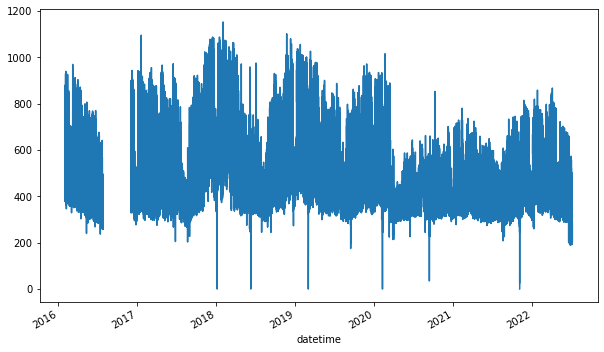

In [122]:
df['kW'].plot(figsize=(10,6))
plt.show()

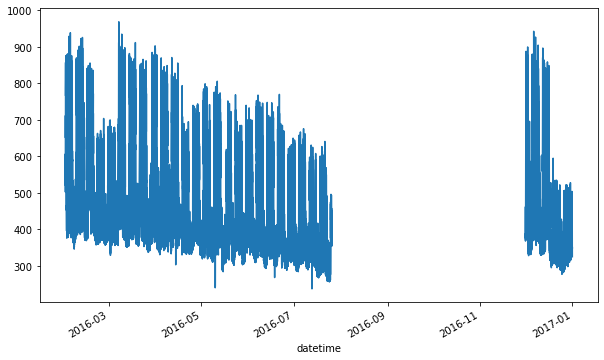

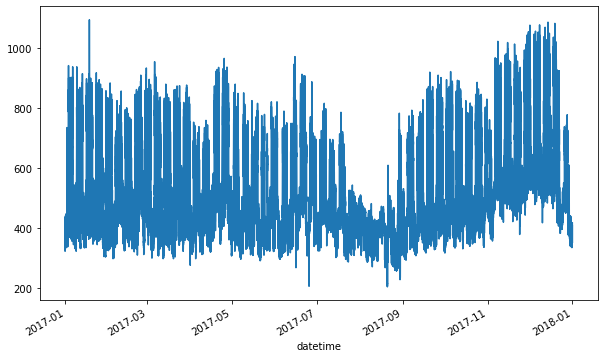

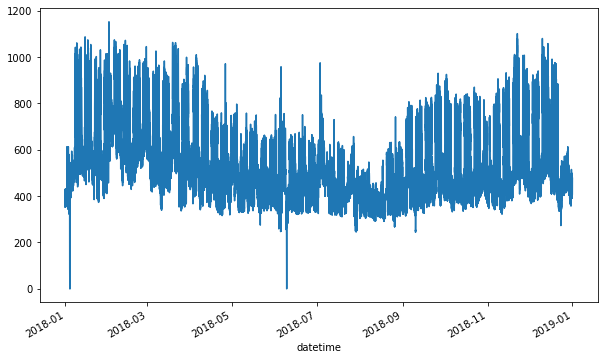

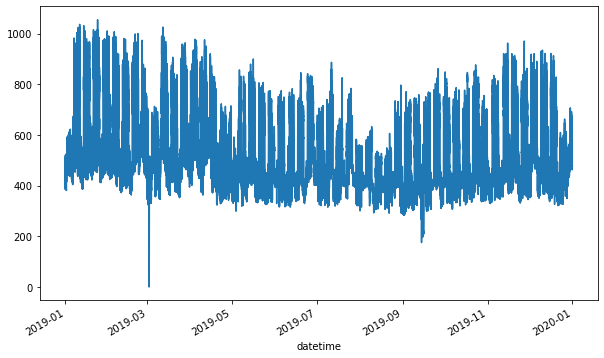

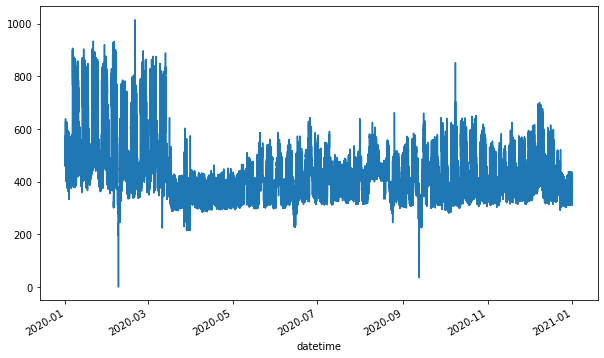

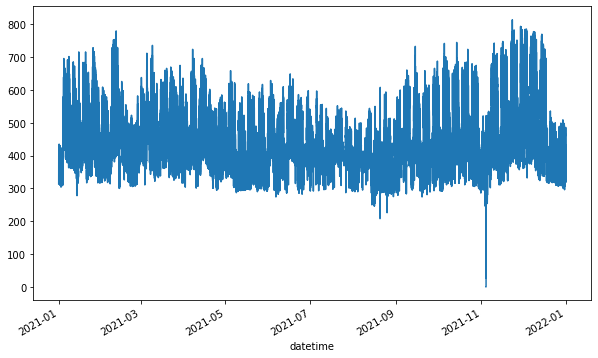

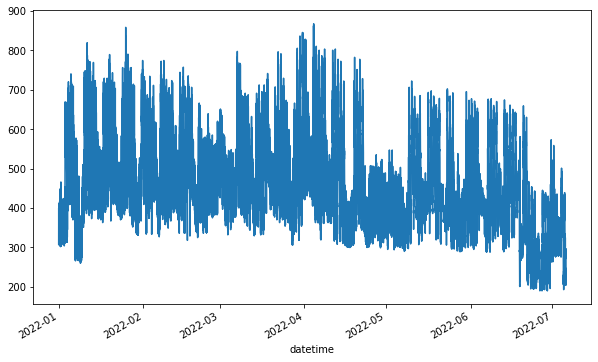

In [123]:
for year in years:
    Years = df.loc[year]
    Years['kW'].plot(figsize=(10,6))
    plt.show()

En observant les plots on remarque qu'en 2016, il y a 4 mois où la consommation est égale à 0. On a alors choisi de selectionner notre série temporelle de 2017 à 2022.

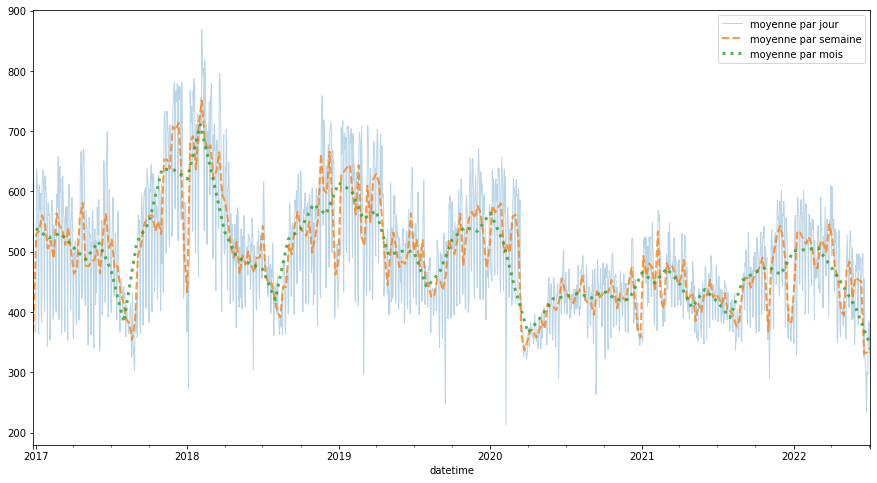

In [124]:
plt.figure(figsize=(15,8))
df.loc['2017':'2022','kW'].resample('D').mean().plot(label='moyenne par jour', lw=1, ls='-', alpha=0.3)
df.loc['2017':'2022','kW'].resample('W').mean().plot(label='moyenne par semaine', lw=2, ls='--', alpha=0.8)
df.loc['2017':'2022','kW'].resample('M').mean().plot(label='moyenne par mois', lw=3, ls=':', alpha=0.8)
plt.legend()
plt.show()

Nous affichons maintenant une figure avec nos données réorganisé en prenant la valeur moyenne par mois, par semaine et par jour.
Nous pouvons observer plusieurs chose :
- Tout d'abord, à chaque début de chaque année nous pouvons observons une net augmentation de la consommation électrique. A contrario, la consommation baisse au milieu de chaque année. Nous pouvons alors suspecter que la consommation est influencé par la température ou par les saisons.
- Deuxièmement, la consommation à fortement chuté en 2020. En effet, l'établissement à fermé à cause du covid 19.
- Lorsque nous regardons la courbe par semaine et des jours, on observe que certaine semaine et certain jours sont moins consommateurs que d'autre. Cela peut être dû au jours férier et aux vacances.

Afin de vérifier tout celà, nous créons des nouvelles features.

In [125]:
# Création des colonnes de saison
Spring = []
Summer = []
Autumn = []
Winter = []

for year in years:
    Spring.append(pd.date_range(year + '-03-21 00:00:00', year + '-06-20 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Summer.append(pd.date_range(year + '-06-21 00:00:00', year + '-09-22 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Autumn.append(pd.date_range(year + '-09-23 00:00:00', year + '-12-20 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Winter.append(pd.date_range(year + '-12-21 00:00:00', year + '-12-31 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Winter.append(pd.date_range(year + '-01-01 00:00:00', year + '-03-20 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    
spring = [item for sublist in Spring for item in sublist]
summer = [item for sublist in Summer for item in sublist]
autumn = [item for sublist in Autumn for item in sublist]
winter = [item for sublist in Winter for item in sublist]

error = ['2016-03-27 02:00:00', '2016-03-27 02:10:00', '2016-03-27 02:20:00', '2016-03-27 02:30:00', '2016-03-27 02:40:00', '2016-03-27 02:50:00', '2017-03-26 02:00:00', '2017-03-26 02:10:00', '2017-03-26 02:20:00', '2017-03-26 02:30:00', '2017-03-26 02:40:00', '2017-03-26 02:50:00', '2018-03-25 02:00:00', '2018-03-25 02:10:00', '2018-03-25 02:20:00', '2018-03-25 02:30:00', '2018-03-25 02:40:00', '2018-03-25 02:50:00', '2019-03-31 02:00:00', '2019-03-31 02:10:00', '2019-03-31 02:20:00', '2019-03-31 02:30:00', '2019-03-31 02:40:00', '2019-03-31 02:50:00', '2020-03-29 02:00:00', '2020-03-29 02:10:00', '2020-03-29 02:20:00', '2020-03-29 02:30:00', '2020-03-29 02:40:00', '2020-03-29 02:50:00', '2021-03-28 02:00:00', '2021-03-28 02:10:00', '2021-03-28 02:20:00', '2021-03-28 02:30:00', '2021-03-28 02:40:00', '2021-03-28 02:50:00', '2022-03-27 02:00:00', '2022-03-27 02:10:00', '2022-03-27 02:20:00', '2022-03-27 02:30:00', '2022-03-27 02:40:00', '2022-03-27 02:50:00']

for i in error:
    spring.remove(i)
    
error2022summer = ['2022-07-06 00:00:00', '2022-07-06 00:10:00', '2022-07-06 00:20:00', '2022-07-06 00:30:00', '2022-07-06 00:40:00', '2022-07-06 00:50:00', '2022-07-06 01:00:00', '2022-07-06 01:10:00', '2022-07-06 01:20:00', '2022-07-06 01:30:00', '2022-07-06 01:40:00', '2022-07-06 01:50:00', '2022-07-06 02:00:00', '2022-07-06 02:10:00', '2022-07-06 02:20:00', '2022-07-06 02:30:00', '2022-07-06 02:40:00', '2022-07-06 02:50:00', '2022-07-06 03:00:00', '2022-07-06 03:10:00', '2022-07-06 03:20:00', '2022-07-06 03:30:00', '2022-07-06 03:40:00', '2022-07-06 03:50:00', '2022-07-06 04:00:00', '2022-07-06 04:10:00', '2022-07-06 04:20:00', '2022-07-06 04:30:00', '2022-07-06 04:40:00', '2022-07-06 04:50:00', '2022-07-06 05:00:00', '2022-07-06 05:10:00', '2022-07-06 05:20:00', '2022-07-06 05:30:00', '2022-07-06 05:40:00', '2022-07-06 05:50:00', '2022-07-06 06:00:00', '2022-07-06 06:10:00', '2022-07-06 06:20:00', '2022-07-06 06:30:00', '2022-07-06 06:40:00', '2022-07-06 06:50:00', '2022-07-06 07:00:00', '2022-07-06 07:10:00', '2022-07-06 07:20:00', '2022-07-06 07:30:00', '2022-07-06 07:40:00', '2022-07-06 07:50:00', '2022-07-06 08:00:00', '2022-07-06 08:10:00', '2022-07-06 08:20:00', '2022-07-06 08:30:00', '2022-07-06 08:40:00', '2022-07-06 08:50:00', '2022-07-06 09:00:00', '2022-07-06 09:10:00', '2022-07-06 09:20:00', '2022-07-06 09:30:00', '2022-07-06 09:40:00', '2022-07-06 09:50:00', '2022-07-06 10:00:00', '2022-07-06 10:10:00', '2022-07-06 10:20:00', '2022-07-06 10:30:00', '2022-07-06 10:40:00', '2022-07-06 10:50:00', '2022-07-06 11:00:00', '2022-07-06 11:10:00', '2022-07-06 11:20:00', '2022-07-06 11:30:00', '2022-07-06 11:40:00', '2022-07-06 11:50:00', '2022-07-06 12:00:00', '2022-07-06 12:10:00', '2022-07-06 12:20:00', '2022-07-06 12:30:00', '2022-07-06 12:40:00', '2022-07-06 12:50:00', '2022-07-06 13:00:00', '2022-07-06 13:10:00', '2022-07-06 13:20:00', '2022-07-06 13:30:00', '2022-07-06 13:40:00', '2022-07-06 13:50:00', '2022-07-06 14:00:00', '2022-07-06 14:10:00', '2022-07-06 14:20:00', '2022-07-06 14:30:00', '2022-07-06 14:40:00', '2022-07-06 14:50:00', '2022-07-06 15:00:00', '2022-07-06 15:10:00', '2022-07-06 15:20:00', '2022-07-06 15:30:00', '2022-07-06 15:40:00', '2022-07-06 15:50:00', '2022-07-06 16:00:00', '2022-07-06 16:10:00', '2022-07-06 16:20:00', '2022-07-06 16:30:00', '2022-07-06 16:40:00', '2022-07-06 16:50:00', '2022-07-06 17:00:00', '2022-07-06 17:10:00', '2022-07-06 17:20:00', '2022-07-06 17:30:00', '2022-07-06 17:40:00', '2022-07-06 17:50:00', '2022-07-06 18:00:00', '2022-07-06 18:10:00', '2022-07-06 18:20:00', '2022-07-06 18:30:00', '2022-07-06 18:40:00', '2022-07-06 18:50:00', '2022-07-06 19:00:00', '2022-07-06 19:10:00', '2022-07-06 19:20:00', '2022-07-06 19:30:00', '2022-07-06 19:40:00', '2022-07-06 19:50:00', '2022-07-06 20:00:00', '2022-07-06 20:10:00', '2022-07-06 20:20:00', '2022-07-06 20:30:00', '2022-07-06 20:40:00', '2022-07-06 20:50:00', '2022-07-06 21:00:00', '2022-07-06 21:10:00', '2022-07-06 21:20:00', '2022-07-06 21:30:00', '2022-07-06 21:40:00', '2022-07-06 21:50:00', '2022-07-06 22:00:00', '2022-07-06 22:10:00', '2022-07-06 22:20:00', '2022-07-06 22:30:00', '2022-07-06 22:40:00', '2022-07-06 22:50:00', '2022-07-06 23:00:00', '2022-07-06 23:10:00', '2022-07-06 23:20:00', '2022-07-06 23:30:00', '2022-07-06 23:40:00', '2022-07-06 23:50:00', '2022-07-07 00:00:00', '2022-07-07 00:10:00', '2022-07-07 00:20:00', '2022-07-07 00:30:00', '2022-07-07 00:40:00', '2022-07-07 00:50:00', '2022-07-07 01:00:00', '2022-07-07 01:10:00', '2022-07-07 01:20:00', '2022-07-07 01:30:00', '2022-07-07 01:40:00', '2022-07-07 01:50:00', '2022-07-07 02:00:00', '2022-07-07 02:10:00', '2022-07-07 02:20:00', '2022-07-07 02:30:00', '2022-07-07 02:40:00', '2022-07-07 02:50:00', '2022-07-07 03:00:00', '2022-07-07 03:10:00', '2022-07-07 03:20:00', '2022-07-07 03:30:00', '2022-07-07 03:40:00', '2022-07-07 03:50:00', '2022-07-07 04:00:00', '2022-07-07 04:10:00', '2022-07-07 04:20:00', '2022-07-07 04:30:00', '2022-07-07 04:40:00', '2022-07-07 04:50:00', '2022-07-07 05:00:00', '2022-07-07 05:10:00', '2022-07-07 05:20:00', '2022-07-07 05:30:00', '2022-07-07 05:40:00', '2022-07-07 05:50:00', '2022-07-07 06:00:00', '2022-07-07 06:10:00', '2022-07-07 06:20:00', '2022-07-07 06:30:00', '2022-07-07 06:40:00', '2022-07-07 06:50:00', '2022-07-07 07:00:00', '2022-07-07 07:10:00', '2022-07-07 07:20:00', '2022-07-07 07:30:00', '2022-07-07 07:40:00', '2022-07-07 07:50:00', '2022-07-07 08:00:00', '2022-07-07 08:10:00', '2022-07-07 08:20:00', '2022-07-07 08:30:00', '2022-07-07 08:40:00', '2022-07-07 08:50:00', '2022-07-07 09:00:00', '2022-07-07 09:10:00', '2022-07-07 09:20:00', '2022-07-07 09:30:00', '2022-07-07 09:40:00', '2022-07-07 09:50:00', '2022-07-07 10:00:00', '2022-07-07 10:10:00', '2022-07-07 10:20:00', '2022-07-07 10:30:00', '2022-07-07 10:40:00', '2022-07-07 10:50:00', '2022-07-07 11:00:00', '2022-07-07 11:10:00', '2022-07-07 11:20:00', '2022-07-07 11:30:00', '2022-07-07 11:40:00', '2022-07-07 11:50:00', '2022-07-07 12:00:00', '2022-07-07 12:10:00', '2022-07-07 12:20:00', '2022-07-07 12:30:00', '2022-07-07 12:40:00', '2022-07-07 12:50:00', '2022-07-07 13:00:00', '2022-07-07 13:10:00', '2022-07-07 13:20:00', '2022-07-07 13:30:00', '2022-07-07 13:40:00', '2022-07-07 13:50:00', '2022-07-07 14:00:00', '2022-07-07 14:10:00', '2022-07-07 14:20:00', '2022-07-07 14:30:00', '2022-07-07 14:40:00', '2022-07-07 14:50:00', '2022-07-07 15:00:00', '2022-07-07 15:10:00', '2022-07-07 15:20:00', '2022-07-07 15:30:00', '2022-07-07 15:40:00', '2022-07-07 15:50:00', '2022-07-07 16:00:00', '2022-07-07 16:10:00', '2022-07-07 16:20:00', '2022-07-07 16:30:00', '2022-07-07 16:40:00', '2022-07-07 16:50:00', '2022-07-07 17:00:00', '2022-07-07 17:10:00', '2022-07-07 17:20:00', '2022-07-07 17:30:00', '2022-07-07 17:40:00', '2022-07-07 17:50:00', '2022-07-07 18:00:00', '2022-07-07 18:10:00', '2022-07-07 18:20:00', '2022-07-07 18:30:00', '2022-07-07 18:40:00', '2022-07-07 18:50:00', '2022-07-07 19:00:00', '2022-07-07 19:10:00', '2022-07-07 19:20:00', '2022-07-07 19:30:00', '2022-07-07 19:40:00', '2022-07-07 19:50:00', '2022-07-07 20:00:00', '2022-07-07 20:10:00', '2022-07-07 20:20:00', '2022-07-07 20:30:00', '2022-07-07 20:40:00', '2022-07-07 20:50:00', '2022-07-07 21:00:00', '2022-07-07 21:10:00', '2022-07-07 21:20:00', '2022-07-07 21:30:00', '2022-07-07 21:40:00', '2022-07-07 21:50:00', '2022-07-07 22:00:00', '2022-07-07 22:10:00', '2022-07-07 22:20:00', '2022-07-07 22:30:00', '2022-07-07 22:40:00', '2022-07-07 22:50:00', '2022-07-07 23:00:00', '2022-07-07 23:10:00', '2022-07-07 23:20:00', '2022-07-07 23:30:00', '2022-07-07 23:40:00', '2022-07-07 23:50:00', '2022-07-08 00:00:00', '2022-07-08 00:10:00', '2022-07-08 00:20:00', '2022-07-08 00:30:00', '2022-07-08 00:40:00', '2022-07-08 00:50:00', '2022-07-08 01:00:00', '2022-07-08 01:10:00', '2022-07-08 01:20:00', '2022-07-08 01:30:00', '2022-07-08 01:40:00', '2022-07-08 01:50:00', '2022-07-08 02:00:00', '2022-07-08 02:10:00', '2022-07-08 02:20:00', '2022-07-08 02:30:00', '2022-07-08 02:40:00', '2022-07-08 02:50:00', '2022-07-08 03:00:00', '2022-07-08 03:10:00', '2022-07-08 03:20:00', '2022-07-08 03:30:00', '2022-07-08 03:40:00', '2022-07-08 03:50:00', '2022-07-08 04:00:00', '2022-07-08 04:10:00', '2022-07-08 04:20:00', '2022-07-08 04:30:00', '2022-07-08 04:40:00', '2022-07-08 04:50:00', '2022-07-08 05:00:00', '2022-07-08 05:10:00', '2022-07-08 05:20:00', '2022-07-08 05:30:00', '2022-07-08 05:40:00', '2022-07-08 05:50:00', '2022-07-08 06:00:00', '2022-07-08 06:10:00', '2022-07-08 06:20:00', '2022-07-08 06:30:00', '2022-07-08 06:40:00', '2022-07-08 06:50:00', '2022-07-08 07:00:00', '2022-07-08 07:10:00', '2022-07-08 07:20:00', '2022-07-08 07:30:00', '2022-07-08 07:40:00', '2022-07-08 07:50:00', '2022-07-08 08:00:00', '2022-07-08 08:10:00', '2022-07-08 08:20:00', '2022-07-08 08:30:00', '2022-07-08 08:40:00', '2022-07-08 08:50:00', '2022-07-08 09:00:00', '2022-07-08 09:10:00', '2022-07-08 09:20:00', '2022-07-08 09:30:00', '2022-07-08 09:40:00', '2022-07-08 09:50:00', '2022-07-08 10:00:00', '2022-07-08 10:10:00', '2022-07-08 10:20:00', '2022-07-08 10:30:00', '2022-07-08 10:40:00', '2022-07-08 10:50:00', '2022-07-08 11:00:00', '2022-07-08 11:10:00', '2022-07-08 11:20:00', '2022-07-08 11:30:00', '2022-07-08 11:40:00', '2022-07-08 11:50:00', '2022-07-08 12:00:00', '2022-07-08 12:10:00', '2022-07-08 12:20:00', '2022-07-08 12:30:00', '2022-07-08 12:40:00', '2022-07-08 12:50:00', '2022-07-08 13:00:00', '2022-07-08 13:10:00', '2022-07-08 13:20:00', '2022-07-08 13:30:00', '2022-07-08 13:40:00', '2022-07-08 13:50:00', '2022-07-08 14:00:00', '2022-07-08 14:10:00', '2022-07-08 14:20:00', '2022-07-08 14:30:00', '2022-07-08 14:40:00', '2022-07-08 14:50:00', '2022-07-08 15:00:00', '2022-07-08 15:10:00', '2022-07-08 15:20:00', '2022-07-08 15:30:00', '2022-07-08 15:40:00', '2022-07-08 15:50:00', '2022-07-08 16:00:00', '2022-07-08 16:10:00', '2022-07-08 16:20:00', '2022-07-08 16:30:00', '2022-07-08 16:40:00', '2022-07-08 16:50:00', '2022-07-08 17:00:00', '2022-07-08 17:10:00', '2022-07-08 17:20:00', '2022-07-08 17:30:00', '2022-07-08 17:40:00', '2022-07-08 17:50:00', '2022-07-08 18:00:00', '2022-07-08 18:10:00', '2022-07-08 18:20:00', '2022-07-08 18:30:00', '2022-07-08 18:40:00', '2022-07-08 18:50:00', '2022-07-08 19:00:00', '2022-07-08 19:10:00', '2022-07-08 19:20:00', '2022-07-08 19:30:00', '2022-07-08 19:40:00', '2022-07-08 19:50:00', '2022-07-08 20:00:00', '2022-07-08 20:10:00', '2022-07-08 20:20:00', '2022-07-08 20:30:00', '2022-07-08 20:40:00', '2022-07-08 20:50:00', '2022-07-08 21:00:00', '2022-07-08 21:10:00', '2022-07-08 21:20:00', '2022-07-08 21:30:00', '2022-07-08 21:40:00', '2022-07-08 21:50:00', '2022-07-08 22:00:00', '2022-07-08 22:10:00', '2022-07-08 22:20:00', '2022-07-08 22:30:00', '2022-07-08 22:40:00', '2022-07-08 22:50:00', '2022-07-08 23:00:00', '2022-07-08 23:10:00', '2022-07-08 23:20:00', '2022-07-08 23:30:00', '2022-07-08 23:40:00', '2022-07-08 23:50:00', '2022-07-09 00:00:00', '2022-07-09 00:10:00', '2022-07-09 00:20:00', '2022-07-09 00:30:00', '2022-07-09 00:40:00', '2022-07-09 00:50:00', '2022-07-09 01:00:00', '2022-07-09 01:10:00', '2022-07-09 01:20:00', '2022-07-09 01:30:00', '2022-07-09 01:40:00', '2022-07-09 01:50:00', '2022-07-09 02:00:00', '2022-07-09 02:10:00', '2022-07-09 02:20:00', '2022-07-09 02:30:00', '2022-07-09 02:40:00', '2022-07-09 02:50:00', '2022-07-09 03:00:00', '2022-07-09 03:10:00', '2022-07-09 03:20:00', '2022-07-09 03:30:00', '2022-07-09 03:40:00', '2022-07-09 03:50:00', '2022-07-09 04:00:00', '2022-07-09 04:10:00', '2022-07-09 04:20:00', '2022-07-09 04:30:00', '2022-07-09 04:40:00', '2022-07-09 04:50:00', '2022-07-09 05:00:00', '2022-07-09 05:10:00', '2022-07-09 05:20:00', '2022-07-09 05:30:00', '2022-07-09 05:40:00', '2022-07-09 05:50:00', '2022-07-09 06:00:00', '2022-07-09 06:10:00', '2022-07-09 06:20:00', '2022-07-09 06:30:00', '2022-07-09 06:40:00', '2022-07-09 06:50:00', '2022-07-09 07:00:00', '2022-07-09 07:10:00', '2022-07-09 07:20:00', '2022-07-09 07:30:00', '2022-07-09 07:40:00', '2022-07-09 07:50:00', '2022-07-09 08:00:00', '2022-07-09 08:10:00', '2022-07-09 08:20:00', '2022-07-09 08:30:00', '2022-07-09 08:40:00', '2022-07-09 08:50:00', '2022-07-09 09:00:00', '2022-07-09 09:10:00', '2022-07-09 09:20:00', '2022-07-09 09:30:00', '2022-07-09 09:40:00', '2022-07-09 09:50:00', '2022-07-09 10:00:00', '2022-07-09 10:10:00', '2022-07-09 10:20:00', '2022-07-09 10:30:00', '2022-07-09 10:40:00', '2022-07-09 10:50:00', '2022-07-09 11:00:00', '2022-07-09 11:10:00', '2022-07-09 11:20:00', '2022-07-09 11:30:00', '2022-07-09 11:40:00', '2022-07-09 11:50:00', '2022-07-09 12:00:00', '2022-07-09 12:10:00', '2022-07-09 12:20:00', '2022-07-09 12:30:00', '2022-07-09 12:40:00', '2022-07-09 12:50:00', '2022-07-09 13:00:00', '2022-07-09 13:10:00', '2022-07-09 13:20:00', '2022-07-09 13:30:00', '2022-07-09 13:40:00', '2022-07-09 13:50:00', '2022-07-09 14:00:00', '2022-07-09 14:10:00', '2022-07-09 14:20:00', '2022-07-09 14:30:00', '2022-07-09 14:40:00', '2022-07-09 14:50:00', '2022-07-09 15:00:00', '2022-07-09 15:10:00', '2022-07-09 15:20:00', '2022-07-09 15:30:00', '2022-07-09 15:40:00', '2022-07-09 15:50:00', '2022-07-09 16:00:00', '2022-07-09 16:10:00', '2022-07-09 16:20:00', '2022-07-09 16:30:00', '2022-07-09 16:40:00', '2022-07-09 16:50:00', '2022-07-09 17:00:00', '2022-07-09 17:10:00', '2022-07-09 17:20:00', '2022-07-09 17:30:00', '2022-07-09 17:40:00', '2022-07-09 17:50:00', '2022-07-09 18:00:00', '2022-07-09 18:10:00', '2022-07-09 18:20:00', '2022-07-09 18:30:00', '2022-07-09 18:40:00', '2022-07-09 18:50:00', '2022-07-09 19:00:00', '2022-07-09 19:10:00', '2022-07-09 19:20:00', '2022-07-09 19:30:00', '2022-07-09 19:40:00', '2022-07-09 19:50:00', '2022-07-09 20:00:00', '2022-07-09 20:10:00', '2022-07-09 20:20:00', '2022-07-09 20:30:00', '2022-07-09 20:40:00', '2022-07-09 20:50:00', '2022-07-09 21:00:00', '2022-07-09 21:10:00', '2022-07-09 21:20:00', '2022-07-09 21:30:00', '2022-07-09 21:40:00', '2022-07-09 21:50:00', '2022-07-09 22:00:00', '2022-07-09 22:10:00', '2022-07-09 22:20:00', '2022-07-09 22:30:00', '2022-07-09 22:40:00', '2022-07-09 22:50:00', '2022-07-09 23:00:00', '2022-07-09 23:10:00', '2022-07-09 23:20:00', '2022-07-09 23:30:00', '2022-07-09 23:40:00', '2022-07-09 23:50:00', '2022-07-10 00:00:00', '2022-07-10 00:10:00', '2022-07-10 00:20:00', '2022-07-10 00:30:00', '2022-07-10 00:40:00', '2022-07-10 00:50:00', '2022-07-10 01:00:00', '2022-07-10 01:10:00', '2022-07-10 01:20:00', '2022-07-10 01:30:00', '2022-07-10 01:40:00', '2022-07-10 01:50:00', '2022-07-10 02:00:00', '2022-07-10 02:10:00', '2022-07-10 02:20:00', '2022-07-10 02:30:00', '2022-07-10 02:40:00', '2022-07-10 02:50:00', '2022-07-10 03:00:00', '2022-07-10 03:10:00', '2022-07-10 03:20:00', '2022-07-10 03:30:00', '2022-07-10 03:40:00', '2022-07-10 03:50:00', '2022-07-10 04:00:00', '2022-07-10 04:10:00', '2022-07-10 04:20:00', '2022-07-10 04:30:00', '2022-07-10 04:40:00', '2022-07-10 04:50:00', '2022-07-10 05:00:00', '2022-07-10 05:10:00', '2022-07-10 05:20:00', '2022-07-10 05:30:00', '2022-07-10 05:40:00', '2022-07-10 05:50:00', '2022-07-10 06:00:00', '2022-07-10 06:10:00', '2022-07-10 06:20:00', '2022-07-10 06:30:00', '2022-07-10 06:40:00', '2022-07-10 06:50:00', '2022-07-10 07:00:00', '2022-07-10 07:10:00', '2022-07-10 07:20:00', '2022-07-10 07:30:00', '2022-07-10 07:40:00', '2022-07-10 07:50:00', '2022-07-10 08:00:00', '2022-07-10 08:10:00', '2022-07-10 08:20:00', '2022-07-10 08:30:00', '2022-07-10 08:40:00', '2022-07-10 08:50:00', '2022-07-10 09:00:00', '2022-07-10 09:10:00', '2022-07-10 09:20:00', '2022-07-10 09:30:00', '2022-07-10 09:40:00', '2022-07-10 09:50:00', '2022-07-10 10:00:00', '2022-07-10 10:10:00', '2022-07-10 10:20:00', '2022-07-10 10:30:00', '2022-07-10 10:40:00', '2022-07-10 10:50:00', '2022-07-10 11:00:00', '2022-07-10 11:10:00', '2022-07-10 11:20:00', '2022-07-10 11:30:00', '2022-07-10 11:40:00', '2022-07-10 11:50:00', '2022-07-10 12:00:00', '2022-07-10 12:10:00', '2022-07-10 12:20:00', '2022-07-10 12:30:00', '2022-07-10 12:40:00', '2022-07-10 12:50:00', '2022-07-10 13:00:00', '2022-07-10 13:10:00', '2022-07-10 13:20:00', '2022-07-10 13:30:00', '2022-07-10 13:40:00', '2022-07-10 13:50:00', '2022-07-10 14:00:00', '2022-07-10 14:10:00', '2022-07-10 14:20:00', '2022-07-10 14:30:00', '2022-07-10 14:40:00', '2022-07-10 14:50:00', '2022-07-10 15:00:00', '2022-07-10 15:10:00', '2022-07-10 15:20:00', '2022-07-10 15:30:00', '2022-07-10 15:40:00', '2022-07-10 15:50:00', '2022-07-10 16:00:00', '2022-07-10 16:10:00', '2022-07-10 16:20:00', '2022-07-10 16:30:00', '2022-07-10 16:40:00', '2022-07-10 16:50:00', '2022-07-10 17:00:00', '2022-07-10 17:10:00', '2022-07-10 17:20:00', '2022-07-10 17:30:00', '2022-07-10 17:40:00', '2022-07-10 17:50:00', '2022-07-10 18:00:00', '2022-07-10 18:10:00', '2022-07-10 18:20:00', '2022-07-10 18:30:00', '2022-07-10 18:40:00', '2022-07-10 18:50:00', '2022-07-10 19:00:00', '2022-07-10 19:10:00', '2022-07-10 19:20:00', '2022-07-10 19:30:00', '2022-07-10 19:40:00', '2022-07-10 19:50:00', '2022-07-10 20:00:00', '2022-07-10 20:10:00', '2022-07-10 20:20:00', '2022-07-10 20:30:00', '2022-07-10 20:40:00', '2022-07-10 20:50:00', '2022-07-10 21:00:00', '2022-07-10 21:10:00', '2022-07-10 21:20:00', '2022-07-10 21:30:00', '2022-07-10 21:40:00', '2022-07-10 21:50:00', '2022-07-10 22:00:00', '2022-07-10 22:10:00', '2022-07-10 22:20:00', '2022-07-10 22:30:00', '2022-07-10 22:40:00', '2022-07-10 22:50:00', '2022-07-10 23:00:00', '2022-07-10 23:10:00', '2022-07-10 23:20:00', '2022-07-10 23:30:00', '2022-07-10 23:40:00', '2022-07-10 23:50:00', '2022-07-11 00:00:00', '2022-07-11 00:10:00', '2022-07-11 00:20:00', '2022-07-11 00:30:00', '2022-07-11 00:40:00', '2022-07-11 00:50:00', '2022-07-11 01:00:00', '2022-07-11 01:10:00', '2022-07-11 01:20:00', '2022-07-11 01:30:00', '2022-07-11 01:40:00', '2022-07-11 01:50:00', '2022-07-11 02:00:00', '2022-07-11 02:10:00', '2022-07-11 02:20:00', '2022-07-11 02:30:00', '2022-07-11 02:40:00', '2022-07-11 02:50:00', '2022-07-11 03:00:00', '2022-07-11 03:10:00', '2022-07-11 03:20:00', '2022-07-11 03:30:00', '2022-07-11 03:40:00', '2022-07-11 03:50:00', '2022-07-11 04:00:00', '2022-07-11 04:10:00', '2022-07-11 04:20:00', '2022-07-11 04:30:00', '2022-07-11 04:40:00', '2022-07-11 04:50:00', '2022-07-11 05:00:00', '2022-07-11 05:10:00', '2022-07-11 05:20:00', '2022-07-11 05:30:00', '2022-07-11 05:40:00', '2022-07-11 05:50:00', '2022-07-11 06:00:00', '2022-07-11 06:10:00', '2022-07-11 06:20:00', '2022-07-11 06:30:00', '2022-07-11 06:40:00', '2022-07-11 06:50:00', '2022-07-11 07:00:00', '2022-07-11 07:10:00', '2022-07-11 07:20:00', '2022-07-11 07:30:00', '2022-07-11 07:40:00', '2022-07-11 07:50:00', '2022-07-11 08:00:00', '2022-07-11 08:10:00', '2022-07-11 08:20:00', '2022-07-11 08:30:00', '2022-07-11 08:40:00', '2022-07-11 08:50:00', '2022-07-11 09:00:00', '2022-07-11 09:10:00', '2022-07-11 09:20:00', '2022-07-11 09:30:00', '2022-07-11 09:40:00', '2022-07-11 09:50:00', '2022-07-11 10:00:00', '2022-07-11 10:10:00', '2022-07-11 10:20:00', '2022-07-11 10:30:00', '2022-07-11 10:40:00', '2022-07-11 10:50:00', '2022-07-11 11:00:00', '2022-07-11 11:10:00', '2022-07-11 11:20:00', '2022-07-11 11:30:00', '2022-07-11 11:40:00', '2022-07-11 11:50:00', '2022-07-11 12:00:00', '2022-07-11 12:10:00', '2022-07-11 12:20:00', '2022-07-11 12:30:00', '2022-07-11 12:40:00', '2022-07-11 12:50:00', '2022-07-11 13:00:00', '2022-07-11 13:10:00', '2022-07-11 13:20:00', '2022-07-11 13:30:00', '2022-07-11 13:40:00', '2022-07-11 13:50:00', '2022-07-11 14:00:00', '2022-07-11 14:10:00', '2022-07-11 14:20:00', '2022-07-11 14:30:00', '2022-07-11 14:40:00', '2022-07-11 14:50:00', '2022-07-11 15:00:00', '2022-07-11 15:10:00', '2022-07-11 15:20:00', '2022-07-11 15:30:00', '2022-07-11 15:40:00', '2022-07-11 15:50:00', '2022-07-11 16:00:00', '2022-07-11 16:10:00', '2022-07-11 16:20:00', '2022-07-11 16:30:00', '2022-07-11 16:40:00', '2022-07-11 16:50:00', '2022-07-11 17:00:00', '2022-07-11 17:10:00', '2022-07-11 17:20:00', '2022-07-11 17:30:00', '2022-07-11 17:40:00', '2022-07-11 17:50:00', '2022-07-11 18:00:00', '2022-07-11 18:10:00', '2022-07-11 18:20:00', '2022-07-11 18:30:00', '2022-07-11 18:40:00', '2022-07-11 18:50:00', '2022-07-11 19:00:00', '2022-07-11 19:10:00', '2022-07-11 19:20:00', '2022-07-11 19:30:00', '2022-07-11 19:40:00', '2022-07-11 19:50:00', '2022-07-11 20:00:00', '2022-07-11 20:10:00', '2022-07-11 20:20:00', '2022-07-11 20:30:00', '2022-07-11 20:40:00', '2022-07-11 20:50:00', '2022-07-11 21:00:00', '2022-07-11 21:10:00', '2022-07-11 21:20:00', '2022-07-11 21:30:00', '2022-07-11 21:40:00', '2022-07-11 21:50:00', '2022-07-11 22:00:00', '2022-07-11 22:10:00', '2022-07-11 22:20:00', '2022-07-11 22:30:00', '2022-07-11 22:40:00', '2022-07-11 22:50:00', '2022-07-11 23:00:00', '2022-07-11 23:10:00', '2022-07-11 23:20:00', '2022-07-11 23:30:00', '2022-07-11 23:40:00', '2022-07-11 23:50:00', '2022-07-12 00:00:00', '2022-07-12 00:10:00', '2022-07-12 00:20:00', '2022-07-12 00:30:00', '2022-07-12 00:40:00', '2022-07-12 00:50:00', '2022-07-12 01:00:00', '2022-07-12 01:10:00', '2022-07-12 01:20:00', '2022-07-12 01:30:00', '2022-07-12 01:40:00', '2022-07-12 01:50:00', '2022-07-12 02:00:00', '2022-07-12 02:10:00', '2022-07-12 02:20:00', '2022-07-12 02:30:00', '2022-07-12 02:40:00', '2022-07-12 02:50:00', '2022-07-12 03:00:00', '2022-07-12 03:10:00', '2022-07-12 03:20:00', '2022-07-12 03:30:00', '2022-07-12 03:40:00', '2022-07-12 03:50:00', '2022-07-12 04:00:00', '2022-07-12 04:10:00', '2022-07-12 04:20:00', '2022-07-12 04:30:00', '2022-07-12 04:40:00', '2022-07-12 04:50:00', '2022-07-12 05:00:00', '2022-07-12 05:10:00', '2022-07-12 05:20:00', '2022-07-12 05:30:00', '2022-07-12 05:40:00', '2022-07-12 05:50:00', '2022-07-12 06:00:00', '2022-07-12 06:10:00', '2022-07-12 06:20:00', '2022-07-12 06:30:00', '2022-07-12 06:40:00', '2022-07-12 06:50:00', '2022-07-12 07:00:00', '2022-07-12 07:10:00', '2022-07-12 07:20:00', '2022-07-12 07:30:00', '2022-07-12 07:40:00', '2022-07-12 07:50:00', '2022-07-12 08:00:00', '2022-07-12 08:10:00', '2022-07-12 08:20:00', '2022-07-12 08:30:00', '2022-07-12 08:40:00', '2022-07-12 08:50:00', '2022-07-12 09:00:00', '2022-07-12 09:10:00', '2022-07-12 09:20:00', '2022-07-12 09:30:00', '2022-07-12 09:40:00', '2022-07-12 09:50:00', '2022-07-12 10:00:00', '2022-07-12 10:10:00', '2022-07-12 10:20:00', '2022-07-12 10:30:00', '2022-07-12 10:40:00', '2022-07-12 10:50:00', '2022-07-12 11:00:00', '2022-07-12 11:10:00', '2022-07-12 11:20:00', '2022-07-12 11:30:00', '2022-07-12 11:40:00', '2022-07-12 11:50:00', '2022-07-12 12:00:00', '2022-07-12 12:10:00', '2022-07-12 12:20:00', '2022-07-12 12:30:00', '2022-07-12 12:40:00', '2022-07-12 12:50:00', '2022-07-12 13:00:00', '2022-07-12 13:10:00', '2022-07-12 13:20:00', '2022-07-12 13:30:00', '2022-07-12 13:40:00', '2022-07-12 13:50:00', '2022-07-12 14:00:00', '2022-07-12 14:10:00', '2022-07-12 14:20:00', '2022-07-12 14:30:00', '2022-07-12 14:40:00', '2022-07-12 14:50:00', '2022-07-12 15:00:00', '2022-07-12 15:10:00', '2022-07-12 15:20:00', '2022-07-12 15:30:00', '2022-07-12 15:40:00', '2022-07-12 15:50:00', '2022-07-12 16:00:00', '2022-07-12 16:10:00', '2022-07-12 16:20:00', '2022-07-12 16:30:00', '2022-07-12 16:40:00', '2022-07-12 16:50:00', '2022-07-12 17:00:00', '2022-07-12 17:10:00', '2022-07-12 17:20:00', '2022-07-12 17:30:00', '2022-07-12 17:40:00', '2022-07-12 17:50:00', '2022-07-12 18:00:00', '2022-07-12 18:10:00', '2022-07-12 18:20:00', '2022-07-12 18:30:00', '2022-07-12 18:40:00', '2022-07-12 18:50:00', '2022-07-12 19:00:00', '2022-07-12 19:10:00', '2022-07-12 19:20:00', '2022-07-12 19:30:00', '2022-07-12 19:40:00', '2022-07-12 19:50:00', '2022-07-12 20:00:00', '2022-07-12 20:10:00', '2022-07-12 20:20:00', '2022-07-12 20:30:00', '2022-07-12 20:40:00', '2022-07-12 20:50:00', '2022-07-12 21:00:00', '2022-07-12 21:10:00', '2022-07-12 21:20:00', '2022-07-12 21:30:00', '2022-07-12 21:40:00', '2022-07-12 21:50:00', '2022-07-12 22:00:00', '2022-07-12 22:10:00', '2022-07-12 22:20:00', '2022-07-12 22:30:00', '2022-07-12 22:40:00', '2022-07-12 22:50:00', '2022-07-12 23:00:00', '2022-07-12 23:10:00', '2022-07-12 23:20:00', '2022-07-12 23:30:00', '2022-07-12 23:40:00', '2022-07-12 23:50:00', '2022-07-13 00:00:00', '2022-07-13 00:10:00', '2022-07-13 00:20:00', '2022-07-13 00:30:00', '2022-07-13 00:40:00', '2022-07-13 00:50:00', '2022-07-13 01:00:00', '2022-07-13 01:10:00', '2022-07-13 01:20:00', '2022-07-13 01:30:00', '2022-07-13 01:40:00', '2022-07-13 01:50:00', '2022-07-13 02:00:00', '2022-07-13 02:10:00', '2022-07-13 02:20:00', '2022-07-13 02:30:00', '2022-07-13 02:40:00', '2022-07-13 02:50:00', '2022-07-13 03:00:00', '2022-07-13 03:10:00', '2022-07-13 03:20:00', '2022-07-13 03:30:00', '2022-07-13 03:40:00', '2022-07-13 03:50:00', '2022-07-13 04:00:00', '2022-07-13 04:10:00', '2022-07-13 04:20:00', '2022-07-13 04:30:00', '2022-07-13 04:40:00', '2022-07-13 04:50:00', '2022-07-13 05:00:00', '2022-07-13 05:10:00', '2022-07-13 05:20:00', '2022-07-13 05:30:00', '2022-07-13 05:40:00', '2022-07-13 05:50:00', '2022-07-13 06:00:00', '2022-07-13 06:10:00', '2022-07-13 06:20:00', '2022-07-13 06:30:00', '2022-07-13 06:40:00', '2022-07-13 06:50:00', '2022-07-13 07:00:00', '2022-07-13 07:10:00', '2022-07-13 07:20:00', '2022-07-13 07:30:00', '2022-07-13 07:40:00', '2022-07-13 07:50:00', '2022-07-13 08:00:00', '2022-07-13 08:10:00', '2022-07-13 08:20:00', '2022-07-13 08:30:00', '2022-07-13 08:40:00', '2022-07-13 08:50:00', '2022-07-13 09:00:00', '2022-07-13 09:10:00', '2022-07-13 09:20:00', '2022-07-13 09:30:00', '2022-07-13 09:40:00', '2022-07-13 09:50:00', '2022-07-13 10:00:00', '2022-07-13 10:10:00', '2022-07-13 10:20:00', '2022-07-13 10:30:00', '2022-07-13 10:40:00', '2022-07-13 10:50:00', '2022-07-13 11:00:00', '2022-07-13 11:10:00', '2022-07-13 11:20:00', '2022-07-13 11:30:00', '2022-07-13 11:40:00', '2022-07-13 11:50:00', '2022-07-13 12:00:00', '2022-07-13 12:10:00', '2022-07-13 12:20:00', '2022-07-13 12:30:00', '2022-07-13 12:40:00', '2022-07-13 12:50:00', '2022-07-13 13:00:00', '2022-07-13 13:10:00', '2022-07-13 13:20:00', '2022-07-13 13:30:00', '2022-07-13 13:40:00', '2022-07-13 13:50:00', '2022-07-13 14:00:00', '2022-07-13 14:10:00', '2022-07-13 14:20:00', '2022-07-13 14:30:00', '2022-07-13 14:40:00', '2022-07-13 14:50:00', '2022-07-13 15:00:00', '2022-07-13 15:10:00', '2022-07-13 15:20:00', '2022-07-13 15:30:00', '2022-07-13 15:40:00', '2022-07-13 15:50:00', '2022-07-13 16:00:00', '2022-07-13 16:10:00', '2022-07-13 16:20:00', '2022-07-13 16:30:00', '2022-07-13 16:40:00', '2022-07-13 16:50:00', '2022-07-13 17:00:00', '2022-07-13 17:10:00', '2022-07-13 17:20:00', '2022-07-13 17:30:00', '2022-07-13 17:40:00', '2022-07-13 17:50:00', '2022-07-13 18:00:00', '2022-07-13 18:10:00', '2022-07-13 18:20:00', '2022-07-13 18:30:00', '2022-07-13 18:40:00', '2022-07-13 18:50:00', '2022-07-13 19:00:00', '2022-07-13 19:10:00', '2022-07-13 19:20:00', '2022-07-13 19:30:00', '2022-07-13 19:40:00', '2022-07-13 19:50:00', '2022-07-13 20:00:00', '2022-07-13 20:10:00', '2022-07-13 20:20:00', '2022-07-13 20:30:00', '2022-07-13 20:40:00', '2022-07-13 20:50:00', '2022-07-13 21:00:00', '2022-07-13 21:10:00', '2022-07-13 21:20:00', '2022-07-13 21:30:00', '2022-07-13 21:40:00', '2022-07-13 21:50:00', '2022-07-13 22:00:00', '2022-07-13 22:10:00', '2022-07-13 22:20:00', '2022-07-13 22:30:00', '2022-07-13 22:40:00', '2022-07-13 22:50:00', '2022-07-13 23:00:00', '2022-07-13 23:10:00', '2022-07-13 23:20:00', '2022-07-13 23:30:00', '2022-07-13 23:40:00', '2022-07-13 23:50:00', '2022-07-14 00:00:00', '2022-07-14 00:10:00', '2022-07-14 00:20:00', '2022-07-14 00:30:00', '2022-07-14 00:40:00', '2022-07-14 00:50:00', '2022-07-14 01:00:00', '2022-07-14 01:10:00', '2022-07-14 01:20:00', '2022-07-14 01:30:00', '2022-07-14 01:40:00', '2022-07-14 01:50:00', '2022-07-14 02:00:00', '2022-07-14 02:10:00', '2022-07-14 02:20:00', '2022-07-14 02:30:00', '2022-07-14 02:40:00', '2022-07-14 02:50:00', '2022-07-14 03:00:00', '2022-07-14 03:10:00', '2022-07-14 03:20:00', '2022-07-14 03:30:00', '2022-07-14 03:40:00', '2022-07-14 03:50:00', '2022-07-14 04:00:00', '2022-07-14 04:10:00', '2022-07-14 04:20:00', '2022-07-14 04:30:00', '2022-07-14 04:40:00', '2022-07-14 04:50:00', '2022-07-14 05:00:00', '2022-07-14 05:10:00', '2022-07-14 05:20:00', '2022-07-14 05:30:00', '2022-07-14 05:40:00', '2022-07-14 05:50:00', '2022-07-14 06:00:00', '2022-07-14 06:10:00', '2022-07-14 06:20:00', '2022-07-14 06:30:00', '2022-07-14 06:40:00', '2022-07-14 06:50:00', '2022-07-14 07:00:00', '2022-07-14 07:10:00', '2022-07-14 07:20:00', '2022-07-14 07:30:00', '2022-07-14 07:40:00', '2022-07-14 07:50:00', '2022-07-14 08:00:00', '2022-07-14 08:10:00', '2022-07-14 08:20:00', '2022-07-14 08:30:00', '2022-07-14 08:40:00', '2022-07-14 08:50:00', '2022-07-14 09:00:00', '2022-07-14 09:10:00', '2022-07-14 09:20:00', '2022-07-14 09:30:00', '2022-07-14 09:40:00', '2022-07-14 09:50:00', '2022-07-14 10:00:00', '2022-07-14 10:10:00', '2022-07-14 10:20:00', '2022-07-14 10:30:00', '2022-07-14 10:40:00', '2022-07-14 10:50:00', '2022-07-14 11:00:00', '2022-07-14 11:10:00', '2022-07-14 11:20:00', '2022-07-14 11:30:00', '2022-07-14 11:40:00', '2022-07-14 11:50:00', '2022-07-14 12:00:00', '2022-07-14 12:10:00', '2022-07-14 12:20:00', '2022-07-14 12:30:00', '2022-07-14 12:40:00', '2022-07-14 12:50:00', '2022-07-14 13:00:00', '2022-07-14 13:10:00', '2022-07-14 13:20:00', '2022-07-14 13:30:00', '2022-07-14 13:40:00', '2022-07-14 13:50:00', '2022-07-14 14:00:00', '2022-07-14 14:10:00', '2022-07-14 14:20:00', '2022-07-14 14:30:00', '2022-07-14 14:40:00', '2022-07-14 14:50:00', '2022-07-14 15:00:00', '2022-07-14 15:10:00', '2022-07-14 15:20:00', '2022-07-14 15:30:00', '2022-07-14 15:40:00', '2022-07-14 15:50:00', '2022-07-14 16:00:00', '2022-07-14 16:10:00', '2022-07-14 16:20:00', '2022-07-14 16:30:00', '2022-07-14 16:40:00', '2022-07-14 16:50:00', '2022-07-14 17:00:00', '2022-07-14 17:10:00', '2022-07-14 17:20:00', '2022-07-14 17:30:00', '2022-07-14 17:40:00', '2022-07-14 17:50:00', '2022-07-14 18:00:00', '2022-07-14 18:10:00', '2022-07-14 18:20:00', '2022-07-14 18:30:00', '2022-07-14 18:40:00', '2022-07-14 18:50:00', '2022-07-14 19:00:00', '2022-07-14 19:10:00', '2022-07-14 19:20:00', '2022-07-14 19:30:00', '2022-07-14 19:40:00', '2022-07-14 19:50:00', '2022-07-14 20:00:00', '2022-07-14 20:10:00', '2022-07-14 20:20:00', '2022-07-14 20:30:00', '2022-07-14 20:40:00', '2022-07-14 20:50:00', '2022-07-14 21:00:00', '2022-07-14 21:10:00', '2022-07-14 21:20:00', '2022-07-14 21:30:00', '2022-07-14 21:40:00', '2022-07-14 21:50:00', '2022-07-14 22:00:00', '2022-07-14 22:10:00', '2022-07-14 22:20:00', '2022-07-14 22:30:00', '2022-07-14 22:40:00', '2022-07-14 22:50:00', '2022-07-14 23:00:00', '2022-07-14 23:10:00', '2022-07-14 23:20:00', '2022-07-14 23:30:00', '2022-07-14 23:40:00', '2022-07-14 23:50:00', '2022-07-15 00:00:00', '2022-07-15 00:10:00', '2022-07-15 00:20:00', '2022-07-15 00:30:00', '2022-07-15 00:40:00', '2022-07-15 00:50:00', '2022-07-15 01:00:00', '2022-07-15 01:10:00', '2022-07-15 01:20:00', '2022-07-15 01:30:00', '2022-07-15 01:40:00', '2022-07-15 01:50:00', '2022-07-15 02:00:00', '2022-07-15 02:10:00', '2022-07-15 02:20:00', '2022-07-15 02:30:00', '2022-07-15 02:40:00', '2022-07-15 02:50:00', '2022-07-15 03:00:00', '2022-07-15 03:10:00', '2022-07-15 03:20:00', '2022-07-15 03:30:00', '2022-07-15 03:40:00', '2022-07-15 03:50:00', '2022-07-15 04:00:00', '2022-07-15 04:10:00', '2022-07-15 04:20:00', '2022-07-15 04:30:00', '2022-07-15 04:40:00', '2022-07-15 04:50:00', '2022-07-15 05:00:00', '2022-07-15 05:10:00', '2022-07-15 05:20:00', '2022-07-15 05:30:00', '2022-07-15 05:40:00', '2022-07-15 05:50:00', '2022-07-15 06:00:00', '2022-07-15 06:10:00', '2022-07-15 06:20:00', '2022-07-15 06:30:00', '2022-07-15 06:40:00', '2022-07-15 06:50:00', '2022-07-15 07:00:00', '2022-07-15 07:10:00', '2022-07-15 07:20:00', '2022-07-15 07:30:00', '2022-07-15 07:40:00', '2022-07-15 07:50:00', '2022-07-15 08:00:00', '2022-07-15 08:10:00', '2022-07-15 08:20:00', '2022-07-15 08:30:00', '2022-07-15 08:40:00', '2022-07-15 08:50:00', '2022-07-15 09:00:00', '2022-07-15 09:10:00', '2022-07-15 09:20:00', '2022-07-15 09:30:00', '2022-07-15 09:40:00', '2022-07-15 09:50:00', '2022-07-15 10:00:00', '2022-07-15 10:10:00', '2022-07-15 10:20:00', '2022-07-15 10:30:00', '2022-07-15 10:40:00', '2022-07-15 10:50:00', '2022-07-15 11:00:00', '2022-07-15 11:10:00', '2022-07-15 11:20:00', '2022-07-15 11:30:00', '2022-07-15 11:40:00', '2022-07-15 11:50:00', '2022-07-15 12:00:00', '2022-07-15 12:10:00', '2022-07-15 12:20:00', '2022-07-15 12:30:00', '2022-07-15 12:40:00', '2022-07-15 12:50:00', '2022-07-15 13:00:00', '2022-07-15 13:10:00', '2022-07-15 13:20:00', '2022-07-15 13:30:00', '2022-07-15 13:40:00', '2022-07-15 13:50:00', '2022-07-15 14:00:00', '2022-07-15 14:10:00', '2022-07-15 14:20:00', '2022-07-15 14:30:00', '2022-07-15 14:40:00', '2022-07-15 14:50:00', '2022-07-15 15:00:00', '2022-07-15 15:10:00', '2022-07-15 15:20:00', '2022-07-15 15:30:00', '2022-07-15 15:40:00', '2022-07-15 15:50:00', '2022-07-15 16:00:00', '2022-07-15 16:10:00', '2022-07-15 16:20:00', '2022-07-15 16:30:00', '2022-07-15 16:40:00', '2022-07-15 16:50:00', '2022-07-15 17:00:00', '2022-07-15 17:10:00', '2022-07-15 17:20:00', '2022-07-15 17:30:00', '2022-07-15 17:40:00', '2022-07-15 17:50:00', '2022-07-15 18:00:00', '2022-07-15 18:10:00', '2022-07-15 18:20:00', '2022-07-15 18:30:00', '2022-07-15 18:40:00', '2022-07-15 18:50:00', '2022-07-15 19:00:00', '2022-07-15 19:10:00', '2022-07-15 19:20:00', '2022-07-15 19:30:00', '2022-07-15 19:40:00', '2022-07-15 19:50:00', '2022-07-15 20:00:00', '2022-07-15 20:10:00', '2022-07-15 20:20:00', '2022-07-15 20:30:00', '2022-07-15 20:40:00', '2022-07-15 20:50:00', '2022-07-15 21:00:00', '2022-07-15 21:10:00', '2022-07-15 21:20:00', '2022-07-15 21:30:00', '2022-07-15 21:40:00', '2022-07-15 21:50:00', '2022-07-15 22:00:00', '2022-07-15 22:10:00', '2022-07-15 22:20:00', '2022-07-15 22:30:00', '2022-07-15 22:40:00', '2022-07-15 22:50:00', '2022-07-15 23:00:00', '2022-07-15 23:10:00', '2022-07-15 23:20:00', '2022-07-15 23:30:00', '2022-07-15 23:40:00', '2022-07-15 23:50:00', '2022-07-16 00:00:00', '2022-07-16 00:10:00', '2022-07-16 00:20:00', '2022-07-16 00:30:00', '2022-07-16 00:40:00', '2022-07-16 00:50:00', '2022-07-16 01:00:00', '2022-07-16 01:10:00', '2022-07-16 01:20:00', '2022-07-16 01:30:00', '2022-07-16 01:40:00', '2022-07-16 01:50:00', '2022-07-16 02:00:00', '2022-07-16 02:10:00', '2022-07-16 02:20:00', '2022-07-16 02:30:00', '2022-07-16 02:40:00', '2022-07-16 02:50:00', '2022-07-16 03:00:00', '2022-07-16 03:10:00', '2022-07-16 03:20:00', '2022-07-16 03:30:00', '2022-07-16 03:40:00', '2022-07-16 03:50:00', '2022-07-16 04:00:00', '2022-07-16 04:10:00', '2022-07-16 04:20:00', '2022-07-16 04:30:00', '2022-07-16 04:40:00', '2022-07-16 04:50:00', '2022-07-16 05:00:00', '2022-07-16 05:10:00', '2022-07-16 05:20:00', '2022-07-16 05:30:00', '2022-07-16 05:40:00', '2022-07-16 05:50:00', '2022-07-16 06:00:00', '2022-07-16 06:10:00', '2022-07-16 06:20:00', '2022-07-16 06:30:00', '2022-07-16 06:40:00', '2022-07-16 06:50:00', '2022-07-16 07:00:00', '2022-07-16 07:10:00', '2022-07-16 07:20:00', '2022-07-16 07:30:00', '2022-07-16 07:40:00', '2022-07-16 07:50:00', '2022-07-16 08:00:00', '2022-07-16 08:10:00', '2022-07-16 08:20:00', '2022-07-16 08:30:00', '2022-07-16 08:40:00', '2022-07-16 08:50:00', '2022-07-16 09:00:00', '2022-07-16 09:10:00', '2022-07-16 09:20:00', '2022-07-16 09:30:00', '2022-07-16 09:40:00', '2022-07-16 09:50:00', '2022-07-16 10:00:00', '2022-07-16 10:10:00', '2022-07-16 10:20:00', '2022-07-16 10:30:00', '2022-07-16 10:40:00', '2022-07-16 10:50:00', '2022-07-16 11:00:00', '2022-07-16 11:10:00', '2022-07-16 11:20:00', '2022-07-16 11:30:00', '2022-07-16 11:40:00', '2022-07-16 11:50:00', '2022-07-16 12:00:00', '2022-07-16 12:10:00', '2022-07-16 12:20:00', '2022-07-16 12:30:00', '2022-07-16 12:40:00', '2022-07-16 12:50:00', '2022-07-16 13:00:00', '2022-07-16 13:10:00', '2022-07-16 13:20:00', '2022-07-16 13:30:00', '2022-07-16 13:40:00', '2022-07-16 13:50:00', '2022-07-16 14:00:00', '2022-07-16 14:10:00', '2022-07-16 14:20:00', '2022-07-16 14:30:00', '2022-07-16 14:40:00', '2022-07-16 14:50:00', '2022-07-16 15:00:00', '2022-07-16 15:10:00', '2022-07-16 15:20:00', '2022-07-16 15:30:00', '2022-07-16 15:40:00', '2022-07-16 15:50:00', '2022-07-16 16:00:00', '2022-07-16 16:10:00', '2022-07-16 16:20:00', '2022-07-16 16:30:00', '2022-07-16 16:40:00', '2022-07-16 16:50:00', '2022-07-16 17:00:00', '2022-07-16 17:10:00', '2022-07-16 17:20:00', '2022-07-16 17:30:00', '2022-07-16 17:40:00', '2022-07-16 17:50:00', '2022-07-16 18:00:00', '2022-07-16 18:10:00', '2022-07-16 18:20:00', '2022-07-16 18:30:00', '2022-07-16 18:40:00', '2022-07-16 18:50:00', '2022-07-16 19:00:00', '2022-07-16 19:10:00', '2022-07-16 19:20:00', '2022-07-16 19:30:00', '2022-07-16 19:40:00', '2022-07-16 19:50:00', '2022-07-16 20:00:00', '2022-07-16 20:10:00', '2022-07-16 20:20:00', '2022-07-16 20:30:00', '2022-07-16 20:40:00', '2022-07-16 20:50:00', '2022-07-16 21:00:00', '2022-07-16 21:10:00', '2022-07-16 21:20:00', '2022-07-16 21:30:00', '2022-07-16 21:40:00', '2022-07-16 21:50:00', '2022-07-16 22:00:00', '2022-07-16 22:10:00', '2022-07-16 22:20:00', '2022-07-16 22:30:00', '2022-07-16 22:40:00', '2022-07-16 22:50:00', '2022-07-16 23:00:00', '2022-07-16 23:10:00', '2022-07-16 23:20:00', '2022-07-16 23:30:00', '2022-07-16 23:40:00', '2022-07-16 23:50:00', '2022-07-17 00:00:00', '2022-07-17 00:10:00', '2022-07-17 00:20:00', '2022-07-17 00:30:00', '2022-07-17 00:40:00', '2022-07-17 00:50:00', '2022-07-17 01:00:00', '2022-07-17 01:10:00', '2022-07-17 01:20:00', '2022-07-17 01:30:00', '2022-07-17 01:40:00', '2022-07-17 01:50:00', '2022-07-17 02:00:00', '2022-07-17 02:10:00', '2022-07-17 02:20:00', '2022-07-17 02:30:00', '2022-07-17 02:40:00', '2022-07-17 02:50:00', '2022-07-17 03:00:00', '2022-07-17 03:10:00', '2022-07-17 03:20:00', '2022-07-17 03:30:00', '2022-07-17 03:40:00', '2022-07-17 03:50:00', '2022-07-17 04:00:00', '2022-07-17 04:10:00', '2022-07-17 04:20:00', '2022-07-17 04:30:00', '2022-07-17 04:40:00', '2022-07-17 04:50:00', '2022-07-17 05:00:00', '2022-07-17 05:10:00', '2022-07-17 05:20:00', '2022-07-17 05:30:00', '2022-07-17 05:40:00', '2022-07-17 05:50:00', '2022-07-17 06:00:00', '2022-07-17 06:10:00', '2022-07-17 06:20:00', '2022-07-17 06:30:00', '2022-07-17 06:40:00', '2022-07-17 06:50:00', '2022-07-17 07:00:00', '2022-07-17 07:10:00', '2022-07-17 07:20:00', '2022-07-17 07:30:00', '2022-07-17 07:40:00', '2022-07-17 07:50:00', '2022-07-17 08:00:00', '2022-07-17 08:10:00', '2022-07-17 08:20:00', '2022-07-17 08:30:00', '2022-07-17 08:40:00', '2022-07-17 08:50:00', '2022-07-17 09:00:00', '2022-07-17 09:10:00', '2022-07-17 09:20:00', '2022-07-17 09:30:00', '2022-07-17 09:40:00', '2022-07-17 09:50:00', '2022-07-17 10:00:00', '2022-07-17 10:10:00', '2022-07-17 10:20:00', '2022-07-17 10:30:00', '2022-07-17 10:40:00', '2022-07-17 10:50:00', '2022-07-17 11:00:00', '2022-07-17 11:10:00', '2022-07-17 11:20:00', '2022-07-17 11:30:00', '2022-07-17 11:40:00', '2022-07-17 11:50:00', '2022-07-17 12:00:00', '2022-07-17 12:10:00', '2022-07-17 12:20:00', '2022-07-17 12:30:00', '2022-07-17 12:40:00', '2022-07-17 12:50:00', '2022-07-17 13:00:00', '2022-07-17 13:10:00', '2022-07-17 13:20:00', '2022-07-17 13:30:00', '2022-07-17 13:40:00', '2022-07-17 13:50:00', '2022-07-17 14:00:00', '2022-07-17 14:10:00', '2022-07-17 14:20:00', '2022-07-17 14:30:00', '2022-07-17 14:40:00', '2022-07-17 14:50:00', '2022-07-17 15:00:00', '2022-07-17 15:10:00', '2022-07-17 15:20:00', '2022-07-17 15:30:00', '2022-07-17 15:40:00', '2022-07-17 15:50:00', '2022-07-17 16:00:00', '2022-07-17 16:10:00', '2022-07-17 16:20:00', '2022-07-17 16:30:00', '2022-07-17 16:40:00', '2022-07-17 16:50:00', '2022-07-17 17:00:00', '2022-07-17 17:10:00', '2022-07-17 17:20:00', '2022-07-17 17:30:00', '2022-07-17 17:40:00', '2022-07-17 17:50:00', '2022-07-17 18:00:00', '2022-07-17 18:10:00', '2022-07-17 18:20:00', '2022-07-17 18:30:00', '2022-07-17 18:40:00', '2022-07-17 18:50:00', '2022-07-17 19:00:00', '2022-07-17 19:10:00', '2022-07-17 19:20:00', '2022-07-17 19:30:00', '2022-07-17 19:40:00', '2022-07-17 19:50:00', '2022-07-17 20:00:00', '2022-07-17 20:10:00', '2022-07-17 20:20:00', '2022-07-17 20:30:00', '2022-07-17 20:40:00', '2022-07-17 20:50:00', '2022-07-17 21:00:00', '2022-07-17 21:10:00', '2022-07-17 21:20:00', '2022-07-17 21:30:00', '2022-07-17 21:40:00', '2022-07-17 21:50:00', '2022-07-17 22:00:00', '2022-07-17 22:10:00', '2022-07-17 22:20:00', '2022-07-17 22:30:00', '2022-07-17 22:40:00', '2022-07-17 22:50:00', '2022-07-17 23:00:00', '2022-07-17 23:10:00', '2022-07-17 23:20:00', '2022-07-17 23:30:00', '2022-07-17 23:40:00', '2022-07-17 23:50:00', '2022-07-18 00:00:00', '2022-07-18 00:10:00', '2022-07-18 00:20:00', '2022-07-18 00:30:00', '2022-07-18 00:40:00', '2022-07-18 00:50:00', '2022-07-18 01:00:00', '2022-07-18 01:10:00', '2022-07-18 01:20:00', '2022-07-18 01:30:00', '2022-07-18 01:40:00', '2022-07-18 01:50:00', '2022-07-18 02:00:00', '2022-07-18 02:10:00', '2022-07-18 02:20:00', '2022-07-18 02:30:00', '2022-07-18 02:40:00', '2022-07-18 02:50:00', '2022-07-18 03:00:00', '2022-07-18 03:10:00', '2022-07-18 03:20:00', '2022-07-18 03:30:00', '2022-07-18 03:40:00', '2022-07-18 03:50:00', '2022-07-18 04:00:00', '2022-07-18 04:10:00', '2022-07-18 04:20:00', '2022-07-18 04:30:00', '2022-07-18 04:40:00', '2022-07-18 04:50:00', '2022-07-18 05:00:00', '2022-07-18 05:10:00', '2022-07-18 05:20:00', '2022-07-18 05:30:00', '2022-07-18 05:40:00', '2022-07-18 05:50:00', '2022-07-18 06:00:00', '2022-07-18 06:10:00', '2022-07-18 06:20:00', '2022-07-18 06:30:00', '2022-07-18 06:40:00', '2022-07-18 06:50:00', '2022-07-18 07:00:00', '2022-07-18 07:10:00', '2022-07-18 07:20:00', '2022-07-18 07:30:00', '2022-07-18 07:40:00', '2022-07-18 07:50:00', '2022-07-18 08:00:00', '2022-07-18 08:10:00', '2022-07-18 08:20:00', '2022-07-18 08:30:00', '2022-07-18 08:40:00', '2022-07-18 08:50:00', '2022-07-18 09:00:00', '2022-07-18 09:10:00', '2022-07-18 09:20:00', '2022-07-18 09:30:00', '2022-07-18 09:40:00', '2022-07-18 09:50:00', '2022-07-18 10:00:00', '2022-07-18 10:10:00', '2022-07-18 10:20:00', '2022-07-18 10:30:00', '2022-07-18 10:40:00', '2022-07-18 10:50:00', '2022-07-18 11:00:00', '2022-07-18 11:10:00', '2022-07-18 11:20:00', '2022-07-18 11:30:00', '2022-07-18 11:40:00', '2022-07-18 11:50:00', '2022-07-18 12:00:00', '2022-07-18 12:10:00', '2022-07-18 12:20:00', '2022-07-18 12:30:00', '2022-07-18 12:40:00', '2022-07-18 12:50:00', '2022-07-18 13:00:00', '2022-07-18 13:10:00', '2022-07-18 13:20:00', '2022-07-18 13:30:00', '2022-07-18 13:40:00', '2022-07-18 13:50:00', '2022-07-18 14:00:00', '2022-07-18 14:10:00', '2022-07-18 14:20:00', '2022-07-18 14:30:00', '2022-07-18 14:40:00', '2022-07-18 14:50:00', '2022-07-18 15:00:00', '2022-07-18 15:10:00', '2022-07-18 15:20:00', '2022-07-18 15:30:00', '2022-07-18 15:40:00', '2022-07-18 15:50:00', '2022-07-18 16:00:00', '2022-07-18 16:10:00', '2022-07-18 16:20:00', '2022-07-18 16:30:00', '2022-07-18 16:40:00', '2022-07-18 16:50:00', '2022-07-18 17:00:00', '2022-07-18 17:10:00', '2022-07-18 17:20:00', '2022-07-18 17:30:00', '2022-07-18 17:40:00', '2022-07-18 17:50:00', '2022-07-18 18:00:00', '2022-07-18 18:10:00', '2022-07-18 18:20:00', '2022-07-18 18:30:00', '2022-07-18 18:40:00', '2022-07-18 18:50:00', '2022-07-18 19:00:00', '2022-07-18 19:10:00', '2022-07-18 19:20:00', '2022-07-18 19:30:00', '2022-07-18 19:40:00', '2022-07-18 19:50:00', '2022-07-18 20:00:00', '2022-07-18 20:10:00', '2022-07-18 20:20:00', '2022-07-18 20:30:00', '2022-07-18 20:40:00', '2022-07-18 20:50:00', '2022-07-18 21:00:00', '2022-07-18 21:10:00', '2022-07-18 21:20:00', '2022-07-18 21:30:00', '2022-07-18 21:40:00', '2022-07-18 21:50:00', '2022-07-18 22:00:00', '2022-07-18 22:10:00', '2022-07-18 22:20:00', '2022-07-18 22:30:00', '2022-07-18 22:40:00', '2022-07-18 22:50:00', '2022-07-18 23:00:00', '2022-07-18 23:10:00', '2022-07-18 23:20:00', '2022-07-18 23:30:00', '2022-07-18 23:40:00', '2022-07-18 23:50:00', '2022-07-19 00:00:00', '2022-07-19 00:10:00', '2022-07-19 00:20:00', '2022-07-19 00:30:00', '2022-07-19 00:40:00', '2022-07-19 00:50:00', '2022-07-19 01:00:00', '2022-07-19 01:10:00', '2022-07-19 01:20:00', '2022-07-19 01:30:00', '2022-07-19 01:40:00', '2022-07-19 01:50:00', '2022-07-19 02:00:00', '2022-07-19 02:10:00', '2022-07-19 02:20:00', '2022-07-19 02:30:00', '2022-07-19 02:40:00', '2022-07-19 02:50:00', '2022-07-19 03:00:00', '2022-07-19 03:10:00', '2022-07-19 03:20:00', '2022-07-19 03:30:00', '2022-07-19 03:40:00', '2022-07-19 03:50:00', '2022-07-19 04:00:00', '2022-07-19 04:10:00', '2022-07-19 04:20:00', '2022-07-19 04:30:00', '2022-07-19 04:40:00', '2022-07-19 04:50:00', '2022-07-19 05:00:00', '2022-07-19 05:10:00', '2022-07-19 05:20:00', '2022-07-19 05:30:00', '2022-07-19 05:40:00', '2022-07-19 05:50:00', '2022-07-19 06:00:00', '2022-07-19 06:10:00', '2022-07-19 06:20:00', '2022-07-19 06:30:00', '2022-07-19 06:40:00', '2022-07-19 06:50:00', '2022-07-19 07:00:00', '2022-07-19 07:10:00', '2022-07-19 07:20:00', '2022-07-19 07:30:00', '2022-07-19 07:40:00', '2022-07-19 07:50:00', '2022-07-19 08:00:00', '2022-07-19 08:10:00', '2022-07-19 08:20:00', '2022-07-19 08:30:00', '2022-07-19 08:40:00', '2022-07-19 08:50:00', '2022-07-19 09:00:00', '2022-07-19 09:10:00', '2022-07-19 09:20:00', '2022-07-19 09:30:00', '2022-07-19 09:40:00', '2022-07-19 09:50:00', '2022-07-19 10:00:00', '2022-07-19 10:10:00', '2022-07-19 10:20:00', '2022-07-19 10:30:00', '2022-07-19 10:40:00', '2022-07-19 10:50:00', '2022-07-19 11:00:00', '2022-07-19 11:10:00', '2022-07-19 11:20:00', '2022-07-19 11:30:00', '2022-07-19 11:40:00', '2022-07-19 11:50:00', '2022-07-19 12:00:00', '2022-07-19 12:10:00', '2022-07-19 12:20:00', '2022-07-19 12:30:00', '2022-07-19 12:40:00', '2022-07-19 12:50:00', '2022-07-19 13:00:00', '2022-07-19 13:10:00', '2022-07-19 13:20:00', '2022-07-19 13:30:00', '2022-07-19 13:40:00', '2022-07-19 13:50:00', '2022-07-19 14:00:00', '2022-07-19 14:10:00', '2022-07-19 14:20:00', '2022-07-19 14:30:00', '2022-07-19 14:40:00', '2022-07-19 14:50:00', '2022-07-19 15:00:00', '2022-07-19 15:10:00', '2022-07-19 15:20:00', '2022-07-19 15:30:00', '2022-07-19 15:40:00', '2022-07-19 15:50:00', '2022-07-19 16:00:00', '2022-07-19 16:10:00', '2022-07-19 16:20:00', '2022-07-19 16:30:00', '2022-07-19 16:40:00', '2022-07-19 16:50:00', '2022-07-19 17:00:00', '2022-07-19 17:10:00', '2022-07-19 17:20:00', '2022-07-19 17:30:00', '2022-07-19 17:40:00', '2022-07-19 17:50:00', '2022-07-19 18:00:00', '2022-07-19 18:10:00', '2022-07-19 18:20:00', '2022-07-19 18:30:00', '2022-07-19 18:40:00', '2022-07-19 18:50:00', '2022-07-19 19:00:00', '2022-07-19 19:10:00', '2022-07-19 19:20:00', '2022-07-19 19:30:00', '2022-07-19 19:40:00', '2022-07-19 19:50:00', '2022-07-19 20:00:00', '2022-07-19 20:10:00', '2022-07-19 20:20:00', '2022-07-19 20:30:00', '2022-07-19 20:40:00', '2022-07-19 20:50:00', '2022-07-19 21:00:00', '2022-07-19 21:10:00', '2022-07-19 21:20:00', '2022-07-19 21:30:00', '2022-07-19 21:40:00', '2022-07-19 21:50:00', '2022-07-19 22:00:00', '2022-07-19 22:10:00', '2022-07-19 22:20:00', '2022-07-19 22:30:00', '2022-07-19 22:40:00', '2022-07-19 22:50:00', '2022-07-19 23:00:00', '2022-07-19 23:10:00', '2022-07-19 23:20:00', '2022-07-19 23:30:00', '2022-07-19 23:40:00', '2022-07-19 23:50:00', '2022-07-20 00:00:00', '2022-07-20 00:10:00', '2022-07-20 00:20:00', '2022-07-20 00:30:00', '2022-07-20 00:40:00', '2022-07-20 00:50:00', '2022-07-20 01:00:00', '2022-07-20 01:10:00', '2022-07-20 01:20:00', '2022-07-20 01:30:00', '2022-07-20 01:40:00', '2022-07-20 01:50:00', '2022-07-20 02:00:00', '2022-07-20 02:10:00', '2022-07-20 02:20:00', '2022-07-20 02:30:00', '2022-07-20 02:40:00', '2022-07-20 02:50:00', '2022-07-20 03:00:00', '2022-07-20 03:10:00', '2022-07-20 03:20:00', '2022-07-20 03:30:00', '2022-07-20 03:40:00', '2022-07-20 03:50:00', '2022-07-20 04:00:00', '2022-07-20 04:10:00', '2022-07-20 04:20:00', '2022-07-20 04:30:00', '2022-07-20 04:40:00', '2022-07-20 04:50:00', '2022-07-20 05:00:00', '2022-07-20 05:10:00', '2022-07-20 05:20:00', '2022-07-20 05:30:00', '2022-07-20 05:40:00', '2022-07-20 05:50:00', '2022-07-20 06:00:00', '2022-07-20 06:10:00', '2022-07-20 06:20:00', '2022-07-20 06:30:00', '2022-07-20 06:40:00', '2022-07-20 06:50:00', '2022-07-20 07:00:00', '2022-07-20 07:10:00', '2022-07-20 07:20:00', '2022-07-20 07:30:00', '2022-07-20 07:40:00', '2022-07-20 07:50:00', '2022-07-20 08:00:00', '2022-07-20 08:10:00', '2022-07-20 08:20:00', '2022-07-20 08:30:00', '2022-07-20 08:40:00', '2022-07-20 08:50:00', '2022-07-20 09:00:00', '2022-07-20 09:10:00', '2022-07-20 09:20:00', '2022-07-20 09:30:00', '2022-07-20 09:40:00', '2022-07-20 09:50:00', '2022-07-20 10:00:00', '2022-07-20 10:10:00', '2022-07-20 10:20:00', '2022-07-20 10:30:00', '2022-07-20 10:40:00', '2022-07-20 10:50:00', '2022-07-20 11:00:00', '2022-07-20 11:10:00', '2022-07-20 11:20:00', '2022-07-20 11:30:00', '2022-07-20 11:40:00', '2022-07-20 11:50:00', '2022-07-20 12:00:00', '2022-07-20 12:10:00', '2022-07-20 12:20:00', '2022-07-20 12:30:00', '2022-07-20 12:40:00', '2022-07-20 12:50:00', '2022-07-20 13:00:00', '2022-07-20 13:10:00', '2022-07-20 13:20:00', '2022-07-20 13:30:00', '2022-07-20 13:40:00', '2022-07-20 13:50:00', '2022-07-20 14:00:00', '2022-07-20 14:10:00', '2022-07-20 14:20:00', '2022-07-20 14:30:00', '2022-07-20 14:40:00', '2022-07-20 14:50:00', '2022-07-20 15:00:00', '2022-07-20 15:10:00', '2022-07-20 15:20:00', '2022-07-20 15:30:00', '2022-07-20 15:40:00', '2022-07-20 15:50:00', '2022-07-20 16:00:00', '2022-07-20 16:10:00', '2022-07-20 16:20:00', '2022-07-20 16:30:00', '2022-07-20 16:40:00', '2022-07-20 16:50:00', '2022-07-20 17:00:00', '2022-07-20 17:10:00', '2022-07-20 17:20:00', '2022-07-20 17:30:00', '2022-07-20 17:40:00', '2022-07-20 17:50:00', '2022-07-20 18:00:00', '2022-07-20 18:10:00', '2022-07-20 18:20:00', '2022-07-20 18:30:00', '2022-07-20 18:40:00', '2022-07-20 18:50:00', '2022-07-20 19:00:00', '2022-07-20 19:10:00', '2022-07-20 19:20:00', '2022-07-20 19:30:00', '2022-07-20 19:40:00', '2022-07-20 19:50:00', '2022-07-20 20:00:00', '2022-07-20 20:10:00', '2022-07-20 20:20:00', '2022-07-20 20:30:00', '2022-07-20 20:40:00', '2022-07-20 20:50:00', '2022-07-20 21:00:00', '2022-07-20 21:10:00', '2022-07-20 21:20:00', '2022-07-20 21:30:00', '2022-07-20 21:40:00', '2022-07-20 21:50:00', '2022-07-20 22:00:00', '2022-07-20 22:10:00', '2022-07-20 22:20:00', '2022-07-20 22:30:00', '2022-07-20 22:40:00', '2022-07-20 22:50:00', '2022-07-20 23:00:00', '2022-07-20 23:10:00', '2022-07-20 23:20:00', '2022-07-20 23:30:00', '2022-07-20 23:40:00', '2022-07-20 23:50:00', '2022-07-21 00:00:00', '2022-07-21 00:10:00', '2022-07-21 00:20:00', '2022-07-21 00:30:00', '2022-07-21 00:40:00', '2022-07-21 00:50:00', '2022-07-21 01:00:00', '2022-07-21 01:10:00', '2022-07-21 01:20:00', '2022-07-21 01:30:00', '2022-07-21 01:40:00', '2022-07-21 01:50:00', '2022-07-21 02:00:00', '2022-07-21 02:10:00', '2022-07-21 02:20:00', '2022-07-21 02:30:00', '2022-07-21 02:40:00', '2022-07-21 02:50:00', '2022-07-21 03:00:00', '2022-07-21 03:10:00', '2022-07-21 03:20:00', '2022-07-21 03:30:00', '2022-07-21 03:40:00', '2022-07-21 03:50:00', '2022-07-21 04:00:00', '2022-07-21 04:10:00', '2022-07-21 04:20:00', '2022-07-21 04:30:00', '2022-07-21 04:40:00', '2022-07-21 04:50:00', '2022-07-21 05:00:00', '2022-07-21 05:10:00', '2022-07-21 05:20:00', '2022-07-21 05:30:00', '2022-07-21 05:40:00', '2022-07-21 05:50:00', '2022-07-21 06:00:00', '2022-07-21 06:10:00', '2022-07-21 06:20:00', '2022-07-21 06:30:00', '2022-07-21 06:40:00', '2022-07-21 06:50:00', '2022-07-21 07:00:00', '2022-07-21 07:10:00', '2022-07-21 07:20:00', '2022-07-21 07:30:00', '2022-07-21 07:40:00', '2022-07-21 07:50:00', '2022-07-21 08:00:00', '2022-07-21 08:10:00', '2022-07-21 08:20:00', '2022-07-21 08:30:00', '2022-07-21 08:40:00', '2022-07-21 08:50:00', '2022-07-21 09:00:00', '2022-07-21 09:10:00', '2022-07-21 09:20:00', '2022-07-21 09:30:00', '2022-07-21 09:40:00', '2022-07-21 09:50:00', '2022-07-21 10:00:00', '2022-07-21 10:10:00', '2022-07-21 10:20:00', '2022-07-21 10:30:00', '2022-07-21 10:40:00', '2022-07-21 10:50:00', '2022-07-21 11:00:00', '2022-07-21 11:10:00', '2022-07-21 11:20:00', '2022-07-21 11:30:00', '2022-07-21 11:40:00', '2022-07-21 11:50:00', '2022-07-21 12:00:00', '2022-07-21 12:10:00', '2022-07-21 12:20:00', '2022-07-21 12:30:00', '2022-07-21 12:40:00', '2022-07-21 12:50:00', '2022-07-21 13:00:00', '2022-07-21 13:10:00', '2022-07-21 13:20:00', '2022-07-21 13:30:00', '2022-07-21 13:40:00', '2022-07-21 13:50:00', '2022-07-21 14:00:00', '2022-07-21 14:10:00', '2022-07-21 14:20:00', '2022-07-21 14:30:00', '2022-07-21 14:40:00', '2022-07-21 14:50:00', '2022-07-21 15:00:00', '2022-07-21 15:10:00', '2022-07-21 15:20:00', '2022-07-21 15:30:00', '2022-07-21 15:40:00', '2022-07-21 15:50:00', '2022-07-21 16:00:00', '2022-07-21 16:10:00', '2022-07-21 16:20:00', '2022-07-21 16:30:00', '2022-07-21 16:40:00', '2022-07-21 16:50:00', '2022-07-21 17:00:00', '2022-07-21 17:10:00', '2022-07-21 17:20:00', '2022-07-21 17:30:00', '2022-07-21 17:40:00', '2022-07-21 17:50:00', '2022-07-21 18:00:00', '2022-07-21 18:10:00', '2022-07-21 18:20:00', '2022-07-21 18:30:00', '2022-07-21 18:40:00', '2022-07-21 18:50:00', '2022-07-21 19:00:00', '2022-07-21 19:10:00', '2022-07-21 19:20:00', '2022-07-21 19:30:00', '2022-07-21 19:40:00', '2022-07-21 19:50:00', '2022-07-21 20:00:00', '2022-07-21 20:10:00', '2022-07-21 20:20:00', '2022-07-21 20:30:00', '2022-07-21 20:40:00', '2022-07-21 20:50:00', '2022-07-21 21:00:00', '2022-07-21 21:10:00', '2022-07-21 21:20:00', '2022-07-21 21:30:00', '2022-07-21 21:40:00', '2022-07-21 21:50:00', '2022-07-21 22:00:00', '2022-07-21 22:10:00', '2022-07-21 22:20:00', '2022-07-21 22:30:00', '2022-07-21 22:40:00', '2022-07-21 22:50:00', '2022-07-21 23:00:00', '2022-07-21 23:10:00', '2022-07-21 23:20:00', '2022-07-21 23:30:00', '2022-07-21 23:40:00', '2022-07-21 23:50:00', '2022-07-22 00:00:00', '2022-07-22 00:10:00', '2022-07-22 00:20:00', '2022-07-22 00:30:00', '2022-07-22 00:40:00', '2022-07-22 00:50:00', '2022-07-22 01:00:00', '2022-07-22 01:10:00', '2022-07-22 01:20:00', '2022-07-22 01:30:00', '2022-07-22 01:40:00', '2022-07-22 01:50:00', '2022-07-22 02:00:00', '2022-07-22 02:10:00', '2022-07-22 02:20:00', '2022-07-22 02:30:00', '2022-07-22 02:40:00', '2022-07-22 02:50:00', '2022-07-22 03:00:00', '2022-07-22 03:10:00', '2022-07-22 03:20:00', '2022-07-22 03:30:00', '2022-07-22 03:40:00', '2022-07-22 03:50:00', '2022-07-22 04:00:00', '2022-07-22 04:10:00', '2022-07-22 04:20:00', '2022-07-22 04:30:00', '2022-07-22 04:40:00', '2022-07-22 04:50:00', '2022-07-22 05:00:00', '2022-07-22 05:10:00', '2022-07-22 05:20:00', '2022-07-22 05:30:00', '2022-07-22 05:40:00', '2022-07-22 05:50:00', '2022-07-22 06:00:00', '2022-07-22 06:10:00', '2022-07-22 06:20:00', '2022-07-22 06:30:00', '2022-07-22 06:40:00', '2022-07-22 06:50:00', '2022-07-22 07:00:00', '2022-07-22 07:10:00', '2022-07-22 07:20:00', '2022-07-22 07:30:00', '2022-07-22 07:40:00', '2022-07-22 07:50:00', '2022-07-22 08:00:00', '2022-07-22 08:10:00', '2022-07-22 08:20:00', '2022-07-22 08:30:00', '2022-07-22 08:40:00', '2022-07-22 08:50:00', '2022-07-22 09:00:00', '2022-07-22 09:10:00', '2022-07-22 09:20:00', '2022-07-22 09:30:00', '2022-07-22 09:40:00', '2022-07-22 09:50:00', '2022-07-22 10:00:00', '2022-07-22 10:10:00', '2022-07-22 10:20:00', '2022-07-22 10:30:00', '2022-07-22 10:40:00', '2022-07-22 10:50:00', '2022-07-22 11:00:00', '2022-07-22 11:10:00', '2022-07-22 11:20:00', '2022-07-22 11:30:00', '2022-07-22 11:40:00', '2022-07-22 11:50:00', '2022-07-22 12:00:00', '2022-07-22 12:10:00', '2022-07-22 12:20:00', '2022-07-22 12:30:00', '2022-07-22 12:40:00', '2022-07-22 12:50:00', '2022-07-22 13:00:00', '2022-07-22 13:10:00', '2022-07-22 13:20:00', '2022-07-22 13:30:00', '2022-07-22 13:40:00', '2022-07-22 13:50:00', '2022-07-22 14:00:00', '2022-07-22 14:10:00', '2022-07-22 14:20:00', '2022-07-22 14:30:00', '2022-07-22 14:40:00', '2022-07-22 14:50:00', '2022-07-22 15:00:00', '2022-07-22 15:10:00', '2022-07-22 15:20:00', '2022-07-22 15:30:00', '2022-07-22 15:40:00', '2022-07-22 15:50:00', '2022-07-22 16:00:00', '2022-07-22 16:10:00', '2022-07-22 16:20:00', '2022-07-22 16:30:00', '2022-07-22 16:40:00', '2022-07-22 16:50:00', '2022-07-22 17:00:00', '2022-07-22 17:10:00', '2022-07-22 17:20:00', '2022-07-22 17:30:00', '2022-07-22 17:40:00', '2022-07-22 17:50:00', '2022-07-22 18:00:00', '2022-07-22 18:10:00', '2022-07-22 18:20:00', '2022-07-22 18:30:00', '2022-07-22 18:40:00', '2022-07-22 18:50:00', '2022-07-22 19:00:00', '2022-07-22 19:10:00', '2022-07-22 19:20:00', '2022-07-22 19:30:00', '2022-07-22 19:40:00', '2022-07-22 19:50:00', '2022-07-22 20:00:00', '2022-07-22 20:10:00', '2022-07-22 20:20:00', '2022-07-22 20:30:00', '2022-07-22 20:40:00', '2022-07-22 20:50:00', '2022-07-22 21:00:00', '2022-07-22 21:10:00', '2022-07-22 21:20:00', '2022-07-22 21:30:00', '2022-07-22 21:40:00', '2022-07-22 21:50:00', '2022-07-22 22:00:00', '2022-07-22 22:10:00', '2022-07-22 22:20:00', '2022-07-22 22:30:00', '2022-07-22 22:40:00', '2022-07-22 22:50:00', '2022-07-22 23:00:00', '2022-07-22 23:10:00', '2022-07-22 23:20:00', '2022-07-22 23:30:00', '2022-07-22 23:40:00', '2022-07-22 23:50:00', '2022-07-23 00:00:00', '2022-07-23 00:10:00', '2022-07-23 00:20:00', '2022-07-23 00:30:00', '2022-07-23 00:40:00', '2022-07-23 00:50:00', '2022-07-23 01:00:00', '2022-07-23 01:10:00', '2022-07-23 01:20:00', '2022-07-23 01:30:00', '2022-07-23 01:40:00', '2022-07-23 01:50:00', '2022-07-23 02:00:00', '2022-07-23 02:10:00', '2022-07-23 02:20:00', '2022-07-23 02:30:00', '2022-07-23 02:40:00', '2022-07-23 02:50:00', '2022-07-23 03:00:00', '2022-07-23 03:10:00', '2022-07-23 03:20:00', '2022-07-23 03:30:00', '2022-07-23 03:40:00', '2022-07-23 03:50:00', '2022-07-23 04:00:00', '2022-07-23 04:10:00', '2022-07-23 04:20:00', '2022-07-23 04:30:00', '2022-07-23 04:40:00', '2022-07-23 04:50:00', '2022-07-23 05:00:00', '2022-07-23 05:10:00', '2022-07-23 05:20:00', '2022-07-23 05:30:00', '2022-07-23 05:40:00', '2022-07-23 05:50:00', '2022-07-23 06:00:00', '2022-07-23 06:10:00', '2022-07-23 06:20:00', '2022-07-23 06:30:00', '2022-07-23 06:40:00', '2022-07-23 06:50:00', '2022-07-23 07:00:00', '2022-07-23 07:10:00', '2022-07-23 07:20:00', '2022-07-23 07:30:00', '2022-07-23 07:40:00', '2022-07-23 07:50:00', '2022-07-23 08:00:00', '2022-07-23 08:10:00', '2022-07-23 08:20:00', '2022-07-23 08:30:00', '2022-07-23 08:40:00', '2022-07-23 08:50:00', '2022-07-23 09:00:00', '2022-07-23 09:10:00', '2022-07-23 09:20:00', '2022-07-23 09:30:00', '2022-07-23 09:40:00', '2022-07-23 09:50:00', '2022-07-23 10:00:00', '2022-07-23 10:10:00', '2022-07-23 10:20:00', '2022-07-23 10:30:00', '2022-07-23 10:40:00', '2022-07-23 10:50:00', '2022-07-23 11:00:00', '2022-07-23 11:10:00', '2022-07-23 11:20:00', '2022-07-23 11:30:00', '2022-07-23 11:40:00', '2022-07-23 11:50:00', '2022-07-23 12:00:00', '2022-07-23 12:10:00', '2022-07-23 12:20:00', '2022-07-23 12:30:00', '2022-07-23 12:40:00', '2022-07-23 12:50:00', '2022-07-23 13:00:00', '2022-07-23 13:10:00', '2022-07-23 13:20:00', '2022-07-23 13:30:00', '2022-07-23 13:40:00', '2022-07-23 13:50:00', '2022-07-23 14:00:00', '2022-07-23 14:10:00', '2022-07-23 14:20:00', '2022-07-23 14:30:00', '2022-07-23 14:40:00', '2022-07-23 14:50:00', '2022-07-23 15:00:00', '2022-07-23 15:10:00', '2022-07-23 15:20:00', '2022-07-23 15:30:00', '2022-07-23 15:40:00', '2022-07-23 15:50:00', '2022-07-23 16:00:00', '2022-07-23 16:10:00', '2022-07-23 16:20:00', '2022-07-23 16:30:00', '2022-07-23 16:40:00', '2022-07-23 16:50:00', '2022-07-23 17:00:00', '2022-07-23 17:10:00', '2022-07-23 17:20:00', '2022-07-23 17:30:00', '2022-07-23 17:40:00', '2022-07-23 17:50:00', '2022-07-23 18:00:00', '2022-07-23 18:10:00', '2022-07-23 18:20:00', '2022-07-23 18:30:00', '2022-07-23 18:40:00', '2022-07-23 18:50:00', '2022-07-23 19:00:00', '2022-07-23 19:10:00', '2022-07-23 19:20:00', '2022-07-23 19:30:00', '2022-07-23 19:40:00', '2022-07-23 19:50:00', '2022-07-23 20:00:00', '2022-07-23 20:10:00', '2022-07-23 20:20:00', '2022-07-23 20:30:00', '2022-07-23 20:40:00', '2022-07-23 20:50:00', '2022-07-23 21:00:00', '2022-07-23 21:10:00', '2022-07-23 21:20:00', '2022-07-23 21:30:00', '2022-07-23 21:40:00', '2022-07-23 21:50:00', '2022-07-23 22:00:00', '2022-07-23 22:10:00', '2022-07-23 22:20:00', '2022-07-23 22:30:00', '2022-07-23 22:40:00', '2022-07-23 22:50:00', '2022-07-23 23:00:00', '2022-07-23 23:10:00', '2022-07-23 23:20:00', '2022-07-23 23:30:00', '2022-07-23 23:40:00', '2022-07-23 23:50:00', '2022-07-24 00:00:00', '2022-07-24 00:10:00', '2022-07-24 00:20:00', '2022-07-24 00:30:00', '2022-07-24 00:40:00', '2022-07-24 00:50:00', '2022-07-24 01:00:00', '2022-07-24 01:10:00', '2022-07-24 01:20:00', '2022-07-24 01:30:00', '2022-07-24 01:40:00', '2022-07-24 01:50:00', '2022-07-24 02:00:00', '2022-07-24 02:10:00', '2022-07-24 02:20:00', '2022-07-24 02:30:00', '2022-07-24 02:40:00', '2022-07-24 02:50:00', '2022-07-24 03:00:00', '2022-07-24 03:10:00', '2022-07-24 03:20:00', '2022-07-24 03:30:00', '2022-07-24 03:40:00', '2022-07-24 03:50:00', '2022-07-24 04:00:00', '2022-07-24 04:10:00', '2022-07-24 04:20:00', '2022-07-24 04:30:00', '2022-07-24 04:40:00', '2022-07-24 04:50:00', '2022-07-24 05:00:00', '2022-07-24 05:10:00', '2022-07-24 05:20:00', '2022-07-24 05:30:00', '2022-07-24 05:40:00', '2022-07-24 05:50:00', '2022-07-24 06:00:00', '2022-07-24 06:10:00', '2022-07-24 06:20:00', '2022-07-24 06:30:00', '2022-07-24 06:40:00', '2022-07-24 06:50:00', '2022-07-24 07:00:00', '2022-07-24 07:10:00', '2022-07-24 07:20:00', '2022-07-24 07:30:00', '2022-07-24 07:40:00', '2022-07-24 07:50:00', '2022-07-24 08:00:00', '2022-07-24 08:10:00', '2022-07-24 08:20:00', '2022-07-24 08:30:00', '2022-07-24 08:40:00', '2022-07-24 08:50:00', '2022-07-24 09:00:00', '2022-07-24 09:10:00', '2022-07-24 09:20:00', '2022-07-24 09:30:00', '2022-07-24 09:40:00', '2022-07-24 09:50:00', '2022-07-24 10:00:00', '2022-07-24 10:10:00', '2022-07-24 10:20:00', '2022-07-24 10:30:00', '2022-07-24 10:40:00', '2022-07-24 10:50:00', '2022-07-24 11:00:00', '2022-07-24 11:10:00', '2022-07-24 11:20:00', '2022-07-24 11:30:00', '2022-07-24 11:40:00', '2022-07-24 11:50:00', '2022-07-24 12:00:00', '2022-07-24 12:10:00', '2022-07-24 12:20:00', '2022-07-24 12:30:00', '2022-07-24 12:40:00', '2022-07-24 12:50:00', '2022-07-24 13:00:00', '2022-07-24 13:10:00', '2022-07-24 13:20:00', '2022-07-24 13:30:00', '2022-07-24 13:40:00', '2022-07-24 13:50:00', '2022-07-24 14:00:00', '2022-07-24 14:10:00', '2022-07-24 14:20:00', '2022-07-24 14:30:00', '2022-07-24 14:40:00', '2022-07-24 14:50:00', '2022-07-24 15:00:00', '2022-07-24 15:10:00', '2022-07-24 15:20:00', '2022-07-24 15:30:00', '2022-07-24 15:40:00', '2022-07-24 15:50:00', '2022-07-24 16:00:00', '2022-07-24 16:10:00', '2022-07-24 16:20:00', '2022-07-24 16:30:00', '2022-07-24 16:40:00', '2022-07-24 16:50:00', '2022-07-24 17:00:00', '2022-07-24 17:10:00', '2022-07-24 17:20:00', '2022-07-24 17:30:00', '2022-07-24 17:40:00', '2022-07-24 17:50:00', '2022-07-24 18:00:00', '2022-07-24 18:10:00', '2022-07-24 18:20:00', '2022-07-24 18:30:00', '2022-07-24 18:40:00', '2022-07-24 18:50:00', '2022-07-24 19:00:00', '2022-07-24 19:10:00', '2022-07-24 19:20:00', '2022-07-24 19:30:00', '2022-07-24 19:40:00', '2022-07-24 19:50:00', '2022-07-24 20:00:00', '2022-07-24 20:10:00', '2022-07-24 20:20:00', '2022-07-24 20:30:00', '2022-07-24 20:40:00', '2022-07-24 20:50:00', '2022-07-24 21:00:00', '2022-07-24 21:10:00', '2022-07-24 21:20:00', '2022-07-24 21:30:00', '2022-07-24 21:40:00', '2022-07-24 21:50:00', '2022-07-24 22:00:00', '2022-07-24 22:10:00', '2022-07-24 22:20:00', '2022-07-24 22:30:00', '2022-07-24 22:40:00', '2022-07-24 22:50:00', '2022-07-24 23:00:00', '2022-07-24 23:10:00', '2022-07-24 23:20:00', '2022-07-24 23:30:00', '2022-07-24 23:40:00', '2022-07-24 23:50:00', '2022-07-25 00:00:00', '2022-07-25 00:10:00', '2022-07-25 00:20:00', '2022-07-25 00:30:00', '2022-07-25 00:40:00', '2022-07-25 00:50:00', '2022-07-25 01:00:00', '2022-07-25 01:10:00', '2022-07-25 01:20:00', '2022-07-25 01:30:00', '2022-07-25 01:40:00', '2022-07-25 01:50:00', '2022-07-25 02:00:00', '2022-07-25 02:10:00', '2022-07-25 02:20:00', '2022-07-25 02:30:00', '2022-07-25 02:40:00', '2022-07-25 02:50:00', '2022-07-25 03:00:00', '2022-07-25 03:10:00', '2022-07-25 03:20:00', '2022-07-25 03:30:00', '2022-07-25 03:40:00', '2022-07-25 03:50:00', '2022-07-25 04:00:00', '2022-07-25 04:10:00', '2022-07-25 04:20:00', '2022-07-25 04:30:00', '2022-07-25 04:40:00', '2022-07-25 04:50:00', '2022-07-25 05:00:00', '2022-07-25 05:10:00', '2022-07-25 05:20:00', '2022-07-25 05:30:00', '2022-07-25 05:40:00', '2022-07-25 05:50:00', '2022-07-25 06:00:00', '2022-07-25 06:10:00', '2022-07-25 06:20:00', '2022-07-25 06:30:00', '2022-07-25 06:40:00', '2022-07-25 06:50:00', '2022-07-25 07:00:00', '2022-07-25 07:10:00', '2022-07-25 07:20:00', '2022-07-25 07:30:00', '2022-07-25 07:40:00', '2022-07-25 07:50:00', '2022-07-25 08:00:00', '2022-07-25 08:10:00', '2022-07-25 08:20:00', '2022-07-25 08:30:00', '2022-07-25 08:40:00', '2022-07-25 08:50:00', '2022-07-25 09:00:00', '2022-07-25 09:10:00', '2022-07-25 09:20:00', '2022-07-25 09:30:00', '2022-07-25 09:40:00', '2022-07-25 09:50:00', '2022-07-25 10:00:00', '2022-07-25 10:10:00', '2022-07-25 10:20:00', '2022-07-25 10:30:00', '2022-07-25 10:40:00', '2022-07-25 10:50:00', '2022-07-25 11:00:00', '2022-07-25 11:10:00', '2022-07-25 11:20:00', '2022-07-25 11:30:00', '2022-07-25 11:40:00', '2022-07-25 11:50:00', '2022-07-25 12:00:00', '2022-07-25 12:10:00', '2022-07-25 12:20:00', '2022-07-25 12:30:00', '2022-07-25 12:40:00', '2022-07-25 12:50:00', '2022-07-25 13:00:00', '2022-07-25 13:10:00', '2022-07-25 13:20:00', '2022-07-25 13:30:00', '2022-07-25 13:40:00', '2022-07-25 13:50:00', '2022-07-25 14:00:00', '2022-07-25 14:10:00', '2022-07-25 14:20:00', '2022-07-25 14:30:00', '2022-07-25 14:40:00', '2022-07-25 14:50:00', '2022-07-25 15:00:00', '2022-07-25 15:10:00', '2022-07-25 15:20:00', '2022-07-25 15:30:00', '2022-07-25 15:40:00', '2022-07-25 15:50:00', '2022-07-25 16:00:00', '2022-07-25 16:10:00', '2022-07-25 16:20:00', '2022-07-25 16:30:00', '2022-07-25 16:40:00', '2022-07-25 16:50:00', '2022-07-25 17:00:00', '2022-07-25 17:10:00', '2022-07-25 17:20:00', '2022-07-25 17:30:00', '2022-07-25 17:40:00', '2022-07-25 17:50:00', '2022-07-25 18:00:00', '2022-07-25 18:10:00', '2022-07-25 18:20:00', '2022-07-25 18:30:00', '2022-07-25 18:40:00', '2022-07-25 18:50:00', '2022-07-25 19:00:00', '2022-07-25 19:10:00', '2022-07-25 19:20:00', '2022-07-25 19:30:00', '2022-07-25 19:40:00', '2022-07-25 19:50:00', '2022-07-25 20:00:00', '2022-07-25 20:10:00', '2022-07-25 20:20:00', '2022-07-25 20:30:00', '2022-07-25 20:40:00', '2022-07-25 20:50:00', '2022-07-25 21:00:00', '2022-07-25 21:10:00', '2022-07-25 21:20:00', '2022-07-25 21:30:00', '2022-07-25 21:40:00', '2022-07-25 21:50:00', '2022-07-25 22:00:00', '2022-07-25 22:10:00', '2022-07-25 22:20:00', '2022-07-25 22:30:00', '2022-07-25 22:40:00', '2022-07-25 22:50:00', '2022-07-25 23:00:00', '2022-07-25 23:10:00', '2022-07-25 23:20:00', '2022-07-25 23:30:00', '2022-07-25 23:40:00', '2022-07-25 23:50:00', '2022-07-26 00:00:00', '2022-07-26 00:10:00', '2022-07-26 00:20:00', '2022-07-26 00:30:00', '2022-07-26 00:40:00', '2022-07-26 00:50:00', '2022-07-26 01:00:00', '2022-07-26 01:10:00', '2022-07-26 01:20:00', '2022-07-26 01:30:00', '2022-07-26 01:40:00', '2022-07-26 01:50:00', '2022-07-26 02:00:00', '2022-07-26 02:10:00', '2022-07-26 02:20:00', '2022-07-26 02:30:00', '2022-07-26 02:40:00', '2022-07-26 02:50:00', '2022-07-26 03:00:00', '2022-07-26 03:10:00', '2022-07-26 03:20:00', '2022-07-26 03:30:00', '2022-07-26 03:40:00', '2022-07-26 03:50:00', '2022-07-26 04:00:00', '2022-07-26 04:10:00', '2022-07-26 04:20:00', '2022-07-26 04:30:00', '2022-07-26 04:40:00', '2022-07-26 04:50:00', '2022-07-26 05:00:00', '2022-07-26 05:10:00', '2022-07-26 05:20:00', '2022-07-26 05:30:00', '2022-07-26 05:40:00', '2022-07-26 05:50:00', '2022-07-26 06:00:00', '2022-07-26 06:10:00', '2022-07-26 06:20:00', '2022-07-26 06:30:00', '2022-07-26 06:40:00', '2022-07-26 06:50:00', '2022-07-26 07:00:00', '2022-07-26 07:10:00', '2022-07-26 07:20:00', '2022-07-26 07:30:00', '2022-07-26 07:40:00', '2022-07-26 07:50:00', '2022-07-26 08:00:00', '2022-07-26 08:10:00', '2022-07-26 08:20:00', '2022-07-26 08:30:00', '2022-07-26 08:40:00', '2022-07-26 08:50:00', '2022-07-26 09:00:00', '2022-07-26 09:10:00', '2022-07-26 09:20:00', '2022-07-26 09:30:00', '2022-07-26 09:40:00', '2022-07-26 09:50:00', '2022-07-26 10:00:00', '2022-07-26 10:10:00', '2022-07-26 10:20:00', '2022-07-26 10:30:00', '2022-07-26 10:40:00', '2022-07-26 10:50:00', '2022-07-26 11:00:00', '2022-07-26 11:10:00', '2022-07-26 11:20:00', '2022-07-26 11:30:00', '2022-07-26 11:40:00', '2022-07-26 11:50:00', '2022-07-26 12:00:00', '2022-07-26 12:10:00', '2022-07-26 12:20:00', '2022-07-26 12:30:00', '2022-07-26 12:40:00', '2022-07-26 12:50:00', '2022-07-26 13:00:00', '2022-07-26 13:10:00', '2022-07-26 13:20:00', '2022-07-26 13:30:00', '2022-07-26 13:40:00', '2022-07-26 13:50:00', '2022-07-26 14:00:00', '2022-07-26 14:10:00', '2022-07-26 14:20:00', '2022-07-26 14:30:00', '2022-07-26 14:40:00', '2022-07-26 14:50:00', '2022-07-26 15:00:00', '2022-07-26 15:10:00', '2022-07-26 15:20:00', '2022-07-26 15:30:00', '2022-07-26 15:40:00', '2022-07-26 15:50:00', '2022-07-26 16:00:00', '2022-07-26 16:10:00', '2022-07-26 16:20:00', '2022-07-26 16:30:00', '2022-07-26 16:40:00', '2022-07-26 16:50:00', '2022-07-26 17:00:00', '2022-07-26 17:10:00', '2022-07-26 17:20:00', '2022-07-26 17:30:00', '2022-07-26 17:40:00', '2022-07-26 17:50:00', '2022-07-26 18:00:00', '2022-07-26 18:10:00', '2022-07-26 18:20:00', '2022-07-26 18:30:00', '2022-07-26 18:40:00', '2022-07-26 18:50:00', '2022-07-26 19:00:00', '2022-07-26 19:10:00', '2022-07-26 19:20:00', '2022-07-26 19:30:00', '2022-07-26 19:40:00', '2022-07-26 19:50:00', '2022-07-26 20:00:00', '2022-07-26 20:10:00', '2022-07-26 20:20:00', '2022-07-26 20:30:00', '2022-07-26 20:40:00', '2022-07-26 20:50:00', '2022-07-26 21:00:00', '2022-07-26 21:10:00', '2022-07-26 21:20:00', '2022-07-26 21:30:00', '2022-07-26 21:40:00', '2022-07-26 21:50:00', '2022-07-26 22:00:00', '2022-07-26 22:10:00', '2022-07-26 22:20:00', '2022-07-26 22:30:00', '2022-07-26 22:40:00', '2022-07-26 22:50:00', '2022-07-26 23:00:00', '2022-07-26 23:10:00', '2022-07-26 23:20:00', '2022-07-26 23:30:00', '2022-07-26 23:40:00', '2022-07-26 23:50:00', '2022-07-27 00:00:00', '2022-07-27 00:10:00', '2022-07-27 00:20:00', '2022-07-27 00:30:00', '2022-07-27 00:40:00', '2022-07-27 00:50:00', '2022-07-27 01:00:00', '2022-07-27 01:10:00', '2022-07-27 01:20:00', '2022-07-27 01:30:00', '2022-07-27 01:40:00', '2022-07-27 01:50:00', '2022-07-27 02:00:00', '2022-07-27 02:10:00', '2022-07-27 02:20:00', '2022-07-27 02:30:00', '2022-07-27 02:40:00', '2022-07-27 02:50:00', '2022-07-27 03:00:00', '2022-07-27 03:10:00', '2022-07-27 03:20:00', '2022-07-27 03:30:00', '2022-07-27 03:40:00', '2022-07-27 03:50:00', '2022-07-27 04:00:00', '2022-07-27 04:10:00', '2022-07-27 04:20:00', '2022-07-27 04:30:00', '2022-07-27 04:40:00', '2022-07-27 04:50:00', '2022-07-27 05:00:00', '2022-07-27 05:10:00', '2022-07-27 05:20:00', '2022-07-27 05:30:00', '2022-07-27 05:40:00', '2022-07-27 05:50:00', '2022-07-27 06:00:00', '2022-07-27 06:10:00', '2022-07-27 06:20:00', '2022-07-27 06:30:00', '2022-07-27 06:40:00', '2022-07-27 06:50:00', '2022-07-27 07:00:00', '2022-07-27 07:10:00', '2022-07-27 07:20:00', '2022-07-27 07:30:00', '2022-07-27 07:40:00', '2022-07-27 07:50:00', '2022-07-27 08:00:00', '2022-07-27 08:10:00', '2022-07-27 08:20:00', '2022-07-27 08:30:00', '2022-07-27 08:40:00', '2022-07-27 08:50:00', '2022-07-27 09:00:00', '2022-07-27 09:10:00', '2022-07-27 09:20:00', '2022-07-27 09:30:00', '2022-07-27 09:40:00', '2022-07-27 09:50:00', '2022-07-27 10:00:00', '2022-07-27 10:10:00', '2022-07-27 10:20:00', '2022-07-27 10:30:00', '2022-07-27 10:40:00', '2022-07-27 10:50:00', '2022-07-27 11:00:00', '2022-07-27 11:10:00', '2022-07-27 11:20:00', '2022-07-27 11:30:00', '2022-07-27 11:40:00', '2022-07-27 11:50:00', '2022-07-27 12:00:00', '2022-07-27 12:10:00', '2022-07-27 12:20:00', '2022-07-27 12:30:00', '2022-07-27 12:40:00', '2022-07-27 12:50:00', '2022-07-27 13:00:00', '2022-07-27 13:10:00', '2022-07-27 13:20:00', '2022-07-27 13:30:00', '2022-07-27 13:40:00', '2022-07-27 13:50:00', '2022-07-27 14:00:00', '2022-07-27 14:10:00', '2022-07-27 14:20:00', '2022-07-27 14:30:00', '2022-07-27 14:40:00', '2022-07-27 14:50:00', '2022-07-27 15:00:00', '2022-07-27 15:10:00', '2022-07-27 15:20:00', '2022-07-27 15:30:00', '2022-07-27 15:40:00', '2022-07-27 15:50:00', '2022-07-27 16:00:00', '2022-07-27 16:10:00', '2022-07-27 16:20:00', '2022-07-27 16:30:00', '2022-07-27 16:40:00', '2022-07-27 16:50:00', '2022-07-27 17:00:00', '2022-07-27 17:10:00', '2022-07-27 17:20:00', '2022-07-27 17:30:00', '2022-07-27 17:40:00', '2022-07-27 17:50:00', '2022-07-27 18:00:00', '2022-07-27 18:10:00', '2022-07-27 18:20:00', '2022-07-27 18:30:00', '2022-07-27 18:40:00', '2022-07-27 18:50:00', '2022-07-27 19:00:00', '2022-07-27 19:10:00', '2022-07-27 19:20:00', '2022-07-27 19:30:00', '2022-07-27 19:40:00', '2022-07-27 19:50:00', '2022-07-27 20:00:00', '2022-07-27 20:10:00', '2022-07-27 20:20:00', '2022-07-27 20:30:00', '2022-07-27 20:40:00', '2022-07-27 20:50:00', '2022-07-27 21:00:00', '2022-07-27 21:10:00', '2022-07-27 21:20:00', '2022-07-27 21:30:00', '2022-07-27 21:40:00', '2022-07-27 21:50:00', '2022-07-27 22:00:00', '2022-07-27 22:10:00', '2022-07-27 22:20:00', '2022-07-27 22:30:00', '2022-07-27 22:40:00', '2022-07-27 22:50:00', '2022-07-27 23:00:00', '2022-07-27 23:10:00', '2022-07-27 23:20:00', '2022-07-27 23:30:00', '2022-07-27 23:40:00', '2022-07-27 23:50:00', '2022-07-28 00:00:00', '2022-07-28 00:10:00', '2022-07-28 00:20:00', '2022-07-28 00:30:00', '2022-07-28 00:40:00', '2022-07-28 00:50:00', '2022-07-28 01:00:00', '2022-07-28 01:10:00', '2022-07-28 01:20:00', '2022-07-28 01:30:00', '2022-07-28 01:40:00', '2022-07-28 01:50:00', '2022-07-28 02:00:00', '2022-07-28 02:10:00', '2022-07-28 02:20:00', '2022-07-28 02:30:00', '2022-07-28 02:40:00', '2022-07-28 02:50:00', '2022-07-28 03:00:00', '2022-07-28 03:10:00', '2022-07-28 03:20:00', '2022-07-28 03:30:00', '2022-07-28 03:40:00', '2022-07-28 03:50:00', '2022-07-28 04:00:00', '2022-07-28 04:10:00', '2022-07-28 04:20:00', '2022-07-28 04:30:00', '2022-07-28 04:40:00', '2022-07-28 04:50:00', '2022-07-28 05:00:00', '2022-07-28 05:10:00', '2022-07-28 05:20:00', '2022-07-28 05:30:00', '2022-07-28 05:40:00', '2022-07-28 05:50:00', '2022-07-28 06:00:00', '2022-07-28 06:10:00', '2022-07-28 06:20:00', '2022-07-28 06:30:00', '2022-07-28 06:40:00', '2022-07-28 06:50:00', '2022-07-28 07:00:00', '2022-07-28 07:10:00', '2022-07-28 07:20:00', '2022-07-28 07:30:00', '2022-07-28 07:40:00', '2022-07-28 07:50:00', '2022-07-28 08:00:00', '2022-07-28 08:10:00', '2022-07-28 08:20:00', '2022-07-28 08:30:00', '2022-07-28 08:40:00', '2022-07-28 08:50:00', '2022-07-28 09:00:00', '2022-07-28 09:10:00', '2022-07-28 09:20:00', '2022-07-28 09:30:00', '2022-07-28 09:40:00', '2022-07-28 09:50:00', '2022-07-28 10:00:00', '2022-07-28 10:10:00', '2022-07-28 10:20:00', '2022-07-28 10:30:00', '2022-07-28 10:40:00', '2022-07-28 10:50:00', '2022-07-28 11:00:00', '2022-07-28 11:10:00', '2022-07-28 11:20:00', '2022-07-28 11:30:00', '2022-07-28 11:40:00', '2022-07-28 11:50:00', '2022-07-28 12:00:00', '2022-07-28 12:10:00', '2022-07-28 12:20:00', '2022-07-28 12:30:00', '2022-07-28 12:40:00', '2022-07-28 12:50:00', '2022-07-28 13:00:00', '2022-07-28 13:10:00', '2022-07-28 13:20:00', '2022-07-28 13:30:00', '2022-07-28 13:40:00', '2022-07-28 13:50:00', '2022-07-28 14:00:00', '2022-07-28 14:10:00', '2022-07-28 14:20:00', '2022-07-28 14:30:00', '2022-07-28 14:40:00', '2022-07-28 14:50:00', '2022-07-28 15:00:00', '2022-07-28 15:10:00', '2022-07-28 15:20:00', '2022-07-28 15:30:00', '2022-07-28 15:40:00', '2022-07-28 15:50:00', '2022-07-28 16:00:00', '2022-07-28 16:10:00', '2022-07-28 16:20:00', '2022-07-28 16:30:00', '2022-07-28 16:40:00', '2022-07-28 16:50:00', '2022-07-28 17:00:00', '2022-07-28 17:10:00', '2022-07-28 17:20:00', '2022-07-28 17:30:00', '2022-07-28 17:40:00', '2022-07-28 17:50:00', '2022-07-28 18:00:00', '2022-07-28 18:10:00', '2022-07-28 18:20:00', '2022-07-28 18:30:00', '2022-07-28 18:40:00', '2022-07-28 18:50:00', '2022-07-28 19:00:00', '2022-07-28 19:10:00', '2022-07-28 19:20:00', '2022-07-28 19:30:00', '2022-07-28 19:40:00', '2022-07-28 19:50:00', '2022-07-28 20:00:00', '2022-07-28 20:10:00', '2022-07-28 20:20:00', '2022-07-28 20:30:00', '2022-07-28 20:40:00', '2022-07-28 20:50:00', '2022-07-28 21:00:00', '2022-07-28 21:10:00', '2022-07-28 21:20:00', '2022-07-28 21:30:00', '2022-07-28 21:40:00', '2022-07-28 21:50:00', '2022-07-28 22:00:00', '2022-07-28 22:10:00', '2022-07-28 22:20:00', '2022-07-28 22:30:00', '2022-07-28 22:40:00', '2022-07-28 22:50:00', '2022-07-28 23:00:00', '2022-07-28 23:10:00', '2022-07-28 23:20:00', '2022-07-28 23:30:00', '2022-07-28 23:40:00', '2022-07-28 23:50:00', '2022-07-29 00:00:00', '2022-07-29 00:10:00', '2022-07-29 00:20:00', '2022-07-29 00:30:00', '2022-07-29 00:40:00', '2022-07-29 00:50:00', '2022-07-29 01:00:00', '2022-07-29 01:10:00', '2022-07-29 01:20:00', '2022-07-29 01:30:00', '2022-07-29 01:40:00', '2022-07-29 01:50:00', '2022-07-29 02:00:00', '2022-07-29 02:10:00', '2022-07-29 02:20:00', '2022-07-29 02:30:00', '2022-07-29 02:40:00', '2022-07-29 02:50:00', '2022-07-29 03:00:00', '2022-07-29 03:10:00', '2022-07-29 03:20:00', '2022-07-29 03:30:00', '2022-07-29 03:40:00', '2022-07-29 03:50:00', '2022-07-29 04:00:00', '2022-07-29 04:10:00', '2022-07-29 04:20:00', '2022-07-29 04:30:00', '2022-07-29 04:40:00', '2022-07-29 04:50:00', '2022-07-29 05:00:00', '2022-07-29 05:10:00', '2022-07-29 05:20:00', '2022-07-29 05:30:00', '2022-07-29 05:40:00', '2022-07-29 05:50:00', '2022-07-29 06:00:00', '2022-07-29 06:10:00', '2022-07-29 06:20:00', '2022-07-29 06:30:00', '2022-07-29 06:40:00', '2022-07-29 06:50:00', '2022-07-29 07:00:00', '2022-07-29 07:10:00', '2022-07-29 07:20:00', '2022-07-29 07:30:00', '2022-07-29 07:40:00', '2022-07-29 07:50:00', '2022-07-29 08:00:00', '2022-07-29 08:10:00', '2022-07-29 08:20:00', '2022-07-29 08:30:00', '2022-07-29 08:40:00', '2022-07-29 08:50:00', '2022-07-29 09:00:00', '2022-07-29 09:10:00', '2022-07-29 09:20:00', '2022-07-29 09:30:00', '2022-07-29 09:40:00', '2022-07-29 09:50:00', '2022-07-29 10:00:00', '2022-07-29 10:10:00', '2022-07-29 10:20:00', '2022-07-29 10:30:00', '2022-07-29 10:40:00', '2022-07-29 10:50:00', '2022-07-29 11:00:00', '2022-07-29 11:10:00', '2022-07-29 11:20:00', '2022-07-29 11:30:00', '2022-07-29 11:40:00', '2022-07-29 11:50:00', '2022-07-29 12:00:00', '2022-07-29 12:10:00', '2022-07-29 12:20:00', '2022-07-29 12:30:00', '2022-07-29 12:40:00', '2022-07-29 12:50:00', '2022-07-29 13:00:00', '2022-07-29 13:10:00', '2022-07-29 13:20:00', '2022-07-29 13:30:00', '2022-07-29 13:40:00', '2022-07-29 13:50:00', '2022-07-29 14:00:00', '2022-07-29 14:10:00', '2022-07-29 14:20:00', '2022-07-29 14:30:00', '2022-07-29 14:40:00', '2022-07-29 14:50:00', '2022-07-29 15:00:00', '2022-07-29 15:10:00', '2022-07-29 15:20:00', '2022-07-29 15:30:00', '2022-07-29 15:40:00', '2022-07-29 15:50:00', '2022-07-29 16:00:00', '2022-07-29 16:10:00', '2022-07-29 16:20:00', '2022-07-29 16:30:00', '2022-07-29 16:40:00', '2022-07-29 16:50:00', '2022-07-29 17:00:00', '2022-07-29 17:10:00', '2022-07-29 17:20:00', '2022-07-29 17:30:00', '2022-07-29 17:40:00', '2022-07-29 17:50:00', '2022-07-29 18:00:00', '2022-07-29 18:10:00', '2022-07-29 18:20:00', '2022-07-29 18:30:00', '2022-07-29 18:40:00', '2022-07-29 18:50:00', '2022-07-29 19:00:00', '2022-07-29 19:10:00', '2022-07-29 19:20:00', '2022-07-29 19:30:00', '2022-07-29 19:40:00', '2022-07-29 19:50:00', '2022-07-29 20:00:00', '2022-07-29 20:10:00', '2022-07-29 20:20:00', '2022-07-29 20:30:00', '2022-07-29 20:40:00', '2022-07-29 20:50:00', '2022-07-29 21:00:00', '2022-07-29 21:10:00', '2022-07-29 21:20:00', '2022-07-29 21:30:00', '2022-07-29 21:40:00', '2022-07-29 21:50:00', '2022-07-29 22:00:00', '2022-07-29 22:10:00', '2022-07-29 22:20:00', '2022-07-29 22:30:00', '2022-07-29 22:40:00', '2022-07-29 22:50:00', '2022-07-29 23:00:00', '2022-07-29 23:10:00', '2022-07-29 23:20:00', '2022-07-29 23:30:00', '2022-07-29 23:40:00', '2022-07-29 23:50:00', '2022-07-30 00:00:00', '2022-07-30 00:10:00', '2022-07-30 00:20:00', '2022-07-30 00:30:00', '2022-07-30 00:40:00', '2022-07-30 00:50:00', '2022-07-30 01:00:00', '2022-07-30 01:10:00', '2022-07-30 01:20:00', '2022-07-30 01:30:00', '2022-07-30 01:40:00', '2022-07-30 01:50:00', '2022-07-30 02:00:00', '2022-07-30 02:10:00', '2022-07-30 02:20:00', '2022-07-30 02:30:00', '2022-07-30 02:40:00', '2022-07-30 02:50:00', '2022-07-30 03:00:00', '2022-07-30 03:10:00', '2022-07-30 03:20:00', '2022-07-30 03:30:00', '2022-07-30 03:40:00', '2022-07-30 03:50:00', '2022-07-30 04:00:00', '2022-07-30 04:10:00', '2022-07-30 04:20:00', '2022-07-30 04:30:00', '2022-07-30 04:40:00', '2022-07-30 04:50:00', '2022-07-30 05:00:00', '2022-07-30 05:10:00', '2022-07-30 05:20:00', '2022-07-30 05:30:00', '2022-07-30 05:40:00', '2022-07-30 05:50:00', '2022-07-30 06:00:00', '2022-07-30 06:10:00', '2022-07-30 06:20:00', '2022-07-30 06:30:00', '2022-07-30 06:40:00', '2022-07-30 06:50:00', '2022-07-30 07:00:00', '2022-07-30 07:10:00', '2022-07-30 07:20:00', '2022-07-30 07:30:00', '2022-07-30 07:40:00', '2022-07-30 07:50:00', '2022-07-30 08:00:00', '2022-07-30 08:10:00', '2022-07-30 08:20:00', '2022-07-30 08:30:00', '2022-07-30 08:40:00', '2022-07-30 08:50:00', '2022-07-30 09:00:00', '2022-07-30 09:10:00', '2022-07-30 09:20:00', '2022-07-30 09:30:00', '2022-07-30 09:40:00', '2022-07-30 09:50:00', '2022-07-30 10:00:00', '2022-07-30 10:10:00', '2022-07-30 10:20:00', '2022-07-30 10:30:00', '2022-07-30 10:40:00', '2022-07-30 10:50:00', '2022-07-30 11:00:00', '2022-07-30 11:10:00', '2022-07-30 11:20:00', '2022-07-30 11:30:00', '2022-07-30 11:40:00', '2022-07-30 11:50:00', '2022-07-30 12:00:00', '2022-07-30 12:10:00', '2022-07-30 12:20:00', '2022-07-30 12:30:00', '2022-07-30 12:40:00', '2022-07-30 12:50:00', '2022-07-30 13:00:00', '2022-07-30 13:10:00', '2022-07-30 13:20:00', '2022-07-30 13:30:00', '2022-07-30 13:40:00', '2022-07-30 13:50:00', '2022-07-30 14:00:00', '2022-07-30 14:10:00', '2022-07-30 14:20:00', '2022-07-30 14:30:00', '2022-07-30 14:40:00', '2022-07-30 14:50:00', '2022-07-30 15:00:00', '2022-07-30 15:10:00', '2022-07-30 15:20:00', '2022-07-30 15:30:00', '2022-07-30 15:40:00', '2022-07-30 15:50:00', '2022-07-30 16:00:00', '2022-07-30 16:10:00', '2022-07-30 16:20:00', '2022-07-30 16:30:00', '2022-07-30 16:40:00', '2022-07-30 16:50:00', '2022-07-30 17:00:00', '2022-07-30 17:10:00', '2022-07-30 17:20:00', '2022-07-30 17:30:00', '2022-07-30 17:40:00', '2022-07-30 17:50:00', '2022-07-30 18:00:00', '2022-07-30 18:10:00', '2022-07-30 18:20:00', '2022-07-30 18:30:00', '2022-07-30 18:40:00', '2022-07-30 18:50:00', '2022-07-30 19:00:00', '2022-07-30 19:10:00', '2022-07-30 19:20:00', '2022-07-30 19:30:00', '2022-07-30 19:40:00', '2022-07-30 19:50:00', '2022-07-30 20:00:00', '2022-07-30 20:10:00', '2022-07-30 20:20:00', '2022-07-30 20:30:00', '2022-07-30 20:40:00', '2022-07-30 20:50:00', '2022-07-30 21:00:00', '2022-07-30 21:10:00', '2022-07-30 21:20:00', '2022-07-30 21:30:00', '2022-07-30 21:40:00', '2022-07-30 21:50:00', '2022-07-30 22:00:00', '2022-07-30 22:10:00', '2022-07-30 22:20:00', '2022-07-30 22:30:00', '2022-07-30 22:40:00', '2022-07-30 22:50:00', '2022-07-30 23:00:00', '2022-07-30 23:10:00', '2022-07-30 23:20:00', '2022-07-30 23:30:00', '2022-07-30 23:40:00', '2022-07-30 23:50:00', '2022-07-31 00:00:00', '2022-07-31 00:10:00', '2022-07-31 00:20:00', '2022-07-31 00:30:00', '2022-07-31 00:40:00', '2022-07-31 00:50:00', '2022-07-31 01:00:00', '2022-07-31 01:10:00', '2022-07-31 01:20:00', '2022-07-31 01:30:00', '2022-07-31 01:40:00', '2022-07-31 01:50:00', '2022-07-31 02:00:00', '2022-07-31 02:10:00', '2022-07-31 02:20:00', '2022-07-31 02:30:00', '2022-07-31 02:40:00', '2022-07-31 02:50:00', '2022-07-31 03:00:00', '2022-07-31 03:10:00', '2022-07-31 03:20:00', '2022-07-31 03:30:00', '2022-07-31 03:40:00', '2022-07-31 03:50:00', '2022-07-31 04:00:00', '2022-07-31 04:10:00', '2022-07-31 04:20:00', '2022-07-31 04:30:00', '2022-07-31 04:40:00', '2022-07-31 04:50:00', '2022-07-31 05:00:00', '2022-07-31 05:10:00', '2022-07-31 05:20:00', '2022-07-31 05:30:00', '2022-07-31 05:40:00', '2022-07-31 05:50:00', '2022-07-31 06:00:00', '2022-07-31 06:10:00', '2022-07-31 06:20:00', '2022-07-31 06:30:00', '2022-07-31 06:40:00', '2022-07-31 06:50:00', '2022-07-31 07:00:00', '2022-07-31 07:10:00', '2022-07-31 07:20:00', '2022-07-31 07:30:00', '2022-07-31 07:40:00', '2022-07-31 07:50:00', '2022-07-31 08:00:00', '2022-07-31 08:10:00', '2022-07-31 08:20:00', '2022-07-31 08:30:00', '2022-07-31 08:40:00', '2022-07-31 08:50:00', '2022-07-31 09:00:00', '2022-07-31 09:10:00', '2022-07-31 09:20:00', '2022-07-31 09:30:00', '2022-07-31 09:40:00', '2022-07-31 09:50:00', '2022-07-31 10:00:00', '2022-07-31 10:10:00', '2022-07-31 10:20:00', '2022-07-31 10:30:00', '2022-07-31 10:40:00', '2022-07-31 10:50:00', '2022-07-31 11:00:00', '2022-07-31 11:10:00', '2022-07-31 11:20:00', '2022-07-31 11:30:00', '2022-07-31 11:40:00', '2022-07-31 11:50:00', '2022-07-31 12:00:00', '2022-07-31 12:10:00', '2022-07-31 12:20:00', '2022-07-31 12:30:00', '2022-07-31 12:40:00', '2022-07-31 12:50:00', '2022-07-31 13:00:00', '2022-07-31 13:10:00', '2022-07-31 13:20:00', '2022-07-31 13:30:00', '2022-07-31 13:40:00', '2022-07-31 13:50:00', '2022-07-31 14:00:00', '2022-07-31 14:10:00', '2022-07-31 14:20:00', '2022-07-31 14:30:00', '2022-07-31 14:40:00', '2022-07-31 14:50:00', '2022-07-31 15:00:00', '2022-07-31 15:10:00', '2022-07-31 15:20:00', '2022-07-31 15:30:00', '2022-07-31 15:40:00', '2022-07-31 15:50:00', '2022-07-31 16:00:00', '2022-07-31 16:10:00', '2022-07-31 16:20:00', '2022-07-31 16:30:00', '2022-07-31 16:40:00', '2022-07-31 16:50:00', '2022-07-31 17:00:00', '2022-07-31 17:10:00', '2022-07-31 17:20:00', '2022-07-31 17:30:00', '2022-07-31 17:40:00', '2022-07-31 17:50:00', '2022-07-31 18:00:00', '2022-07-31 18:10:00', '2022-07-31 18:20:00', '2022-07-31 18:30:00', '2022-07-31 18:40:00', '2022-07-31 18:50:00', '2022-07-31 19:00:00', '2022-07-31 19:10:00', '2022-07-31 19:20:00', '2022-07-31 19:30:00', '2022-07-31 19:40:00', '2022-07-31 19:50:00', '2022-07-31 20:00:00', '2022-07-31 20:10:00', '2022-07-31 20:20:00', '2022-07-31 20:30:00', '2022-07-31 20:40:00', '2022-07-31 20:50:00', '2022-07-31 21:00:00', '2022-07-31 21:10:00', '2022-07-31 21:20:00', '2022-07-31 21:30:00', '2022-07-31 21:40:00', '2022-07-31 21:50:00', '2022-07-31 22:00:00', '2022-07-31 22:10:00', '2022-07-31 22:20:00', '2022-07-31 22:30:00', '2022-07-31 22:40:00', '2022-07-31 22:50:00', '2022-07-31 23:00:00', '2022-07-31 23:10:00', '2022-07-31 23:20:00', '2022-07-31 23:30:00', '2022-07-31 23:40:00', '2022-07-31 23:50:00', '2022-08-01 00:00:00', '2022-08-01 00:10:00', '2022-08-01 00:20:00', '2022-08-01 00:30:00', '2022-08-01 00:40:00', '2022-08-01 00:50:00', '2022-08-01 01:00:00', '2022-08-01 01:10:00', '2022-08-01 01:20:00', '2022-08-01 01:30:00', '2022-08-01 01:40:00', '2022-08-01 01:50:00', '2022-08-01 02:00:00', '2022-08-01 02:10:00', '2022-08-01 02:20:00', '2022-08-01 02:30:00', '2022-08-01 02:40:00', '2022-08-01 02:50:00', '2022-08-01 03:00:00', '2022-08-01 03:10:00', '2022-08-01 03:20:00', '2022-08-01 03:30:00', '2022-08-01 03:40:00', '2022-08-01 03:50:00', '2022-08-01 04:00:00', '2022-08-01 04:10:00', '2022-08-01 04:20:00', '2022-08-01 04:30:00', '2022-08-01 04:40:00', '2022-08-01 04:50:00', '2022-08-01 05:00:00', '2022-08-01 05:10:00', '2022-08-01 05:20:00', '2022-08-01 05:30:00', '2022-08-01 05:40:00', '2022-08-01 05:50:00', '2022-08-01 06:00:00', '2022-08-01 06:10:00', '2022-08-01 06:20:00', '2022-08-01 06:30:00', '2022-08-01 06:40:00', '2022-08-01 06:50:00', '2022-08-01 07:00:00', '2022-08-01 07:10:00', '2022-08-01 07:20:00', '2022-08-01 07:30:00', '2022-08-01 07:40:00', '2022-08-01 07:50:00', '2022-08-01 08:00:00', '2022-08-01 08:10:00', '2022-08-01 08:20:00', '2022-08-01 08:30:00', '2022-08-01 08:40:00', '2022-08-01 08:50:00', '2022-08-01 09:00:00', '2022-08-01 09:10:00', '2022-08-01 09:20:00', '2022-08-01 09:30:00', '2022-08-01 09:40:00', '2022-08-01 09:50:00', '2022-08-01 10:00:00', '2022-08-01 10:10:00', '2022-08-01 10:20:00', '2022-08-01 10:30:00', '2022-08-01 10:40:00', '2022-08-01 10:50:00', '2022-08-01 11:00:00', '2022-08-01 11:10:00', '2022-08-01 11:20:00', '2022-08-01 11:30:00', '2022-08-01 11:40:00', '2022-08-01 11:50:00', '2022-08-01 12:00:00', '2022-08-01 12:10:00', '2022-08-01 12:20:00', '2022-08-01 12:30:00', '2022-08-01 12:40:00', '2022-08-01 12:50:00', '2022-08-01 13:00:00', '2022-08-01 13:10:00', '2022-08-01 13:20:00', '2022-08-01 13:30:00', '2022-08-01 13:40:00', '2022-08-01 13:50:00', '2022-08-01 14:00:00', '2022-08-01 14:10:00', '2022-08-01 14:20:00', '2022-08-01 14:30:00', '2022-08-01 14:40:00', '2022-08-01 14:50:00', '2022-08-01 15:00:00', '2022-08-01 15:10:00', '2022-08-01 15:20:00', '2022-08-01 15:30:00', '2022-08-01 15:40:00', '2022-08-01 15:50:00', '2022-08-01 16:00:00', '2022-08-01 16:10:00', '2022-08-01 16:20:00', '2022-08-01 16:30:00', '2022-08-01 16:40:00', '2022-08-01 16:50:00', '2022-08-01 17:00:00', '2022-08-01 17:10:00', '2022-08-01 17:20:00', '2022-08-01 17:30:00', '2022-08-01 17:40:00', '2022-08-01 17:50:00', '2022-08-01 18:00:00', '2022-08-01 18:10:00', '2022-08-01 18:20:00', '2022-08-01 18:30:00', '2022-08-01 18:40:00', '2022-08-01 18:50:00', '2022-08-01 19:00:00', '2022-08-01 19:10:00', '2022-08-01 19:20:00', '2022-08-01 19:30:00', '2022-08-01 19:40:00', '2022-08-01 19:50:00', '2022-08-01 20:00:00', '2022-08-01 20:10:00', '2022-08-01 20:20:00', '2022-08-01 20:30:00', '2022-08-01 20:40:00', '2022-08-01 20:50:00', '2022-08-01 21:00:00', '2022-08-01 21:10:00', '2022-08-01 21:20:00', '2022-08-01 21:30:00', '2022-08-01 21:40:00', '2022-08-01 21:50:00', '2022-08-01 22:00:00', '2022-08-01 22:10:00', '2022-08-01 22:20:00', '2022-08-01 22:30:00', '2022-08-01 22:40:00', '2022-08-01 22:50:00', '2022-08-01 23:00:00', '2022-08-01 23:10:00', '2022-08-01 23:20:00', '2022-08-01 23:30:00', '2022-08-01 23:40:00', '2022-08-01 23:50:00', '2022-08-02 00:00:00', '2022-08-02 00:10:00', '2022-08-02 00:20:00', '2022-08-02 00:30:00', '2022-08-02 00:40:00', '2022-08-02 00:50:00', '2022-08-02 01:00:00', '2022-08-02 01:10:00', '2022-08-02 01:20:00', '2022-08-02 01:30:00', '2022-08-02 01:40:00', '2022-08-02 01:50:00', '2022-08-02 02:00:00', '2022-08-02 02:10:00', '2022-08-02 02:20:00', '2022-08-02 02:30:00', '2022-08-02 02:40:00', '2022-08-02 02:50:00', '2022-08-02 03:00:00', '2022-08-02 03:10:00', '2022-08-02 03:20:00', '2022-08-02 03:30:00', '2022-08-02 03:40:00', '2022-08-02 03:50:00', '2022-08-02 04:00:00', '2022-08-02 04:10:00', '2022-08-02 04:20:00', '2022-08-02 04:30:00', '2022-08-02 04:40:00', '2022-08-02 04:50:00', '2022-08-02 05:00:00', '2022-08-02 05:10:00', '2022-08-02 05:20:00', '2022-08-02 05:30:00', '2022-08-02 05:40:00', '2022-08-02 05:50:00', '2022-08-02 06:00:00', '2022-08-02 06:10:00', '2022-08-02 06:20:00', '2022-08-02 06:30:00', '2022-08-02 06:40:00', '2022-08-02 06:50:00', '2022-08-02 07:00:00', '2022-08-02 07:10:00', '2022-08-02 07:20:00', '2022-08-02 07:30:00', '2022-08-02 07:40:00', '2022-08-02 07:50:00', '2022-08-02 08:00:00', '2022-08-02 08:10:00', '2022-08-02 08:20:00', '2022-08-02 08:30:00', '2022-08-02 08:40:00', '2022-08-02 08:50:00', '2022-08-02 09:00:00', '2022-08-02 09:10:00', '2022-08-02 09:20:00', '2022-08-02 09:30:00', '2022-08-02 09:40:00', '2022-08-02 09:50:00', '2022-08-02 10:00:00', '2022-08-02 10:10:00', '2022-08-02 10:20:00', '2022-08-02 10:30:00', '2022-08-02 10:40:00', '2022-08-02 10:50:00', '2022-08-02 11:00:00', '2022-08-02 11:10:00', '2022-08-02 11:20:00', '2022-08-02 11:30:00', '2022-08-02 11:40:00', '2022-08-02 11:50:00', '2022-08-02 12:00:00', '2022-08-02 12:10:00', '2022-08-02 12:20:00', '2022-08-02 12:30:00', '2022-08-02 12:40:00', '2022-08-02 12:50:00', '2022-08-02 13:00:00', '2022-08-02 13:10:00', '2022-08-02 13:20:00', '2022-08-02 13:30:00', '2022-08-02 13:40:00', '2022-08-02 13:50:00', '2022-08-02 14:00:00', '2022-08-02 14:10:00', '2022-08-02 14:20:00', '2022-08-02 14:30:00', '2022-08-02 14:40:00', '2022-08-02 14:50:00', '2022-08-02 15:00:00', '2022-08-02 15:10:00', '2022-08-02 15:20:00', '2022-08-02 15:30:00', '2022-08-02 15:40:00', '2022-08-02 15:50:00', '2022-08-02 16:00:00', '2022-08-02 16:10:00', '2022-08-02 16:20:00', '2022-08-02 16:30:00', '2022-08-02 16:40:00', '2022-08-02 16:50:00', '2022-08-02 17:00:00', '2022-08-02 17:10:00', '2022-08-02 17:20:00', '2022-08-02 17:30:00', '2022-08-02 17:40:00', '2022-08-02 17:50:00', '2022-08-02 18:00:00', '2022-08-02 18:10:00', '2022-08-02 18:20:00', '2022-08-02 18:30:00', '2022-08-02 18:40:00', '2022-08-02 18:50:00', '2022-08-02 19:00:00', '2022-08-02 19:10:00', '2022-08-02 19:20:00', '2022-08-02 19:30:00', '2022-08-02 19:40:00', '2022-08-02 19:50:00', '2022-08-02 20:00:00', '2022-08-02 20:10:00', '2022-08-02 20:20:00', '2022-08-02 20:30:00', '2022-08-02 20:40:00', '2022-08-02 20:50:00', '2022-08-02 21:00:00', '2022-08-02 21:10:00', '2022-08-02 21:20:00', '2022-08-02 21:30:00', '2022-08-02 21:40:00', '2022-08-02 21:50:00', '2022-08-02 22:00:00', '2022-08-02 22:10:00', '2022-08-02 22:20:00', '2022-08-02 22:30:00', '2022-08-02 22:40:00', '2022-08-02 22:50:00', '2022-08-02 23:00:00', '2022-08-02 23:10:00', '2022-08-02 23:20:00', '2022-08-02 23:30:00', '2022-08-02 23:40:00', '2022-08-02 23:50:00', '2022-08-03 00:00:00', '2022-08-03 00:10:00', '2022-08-03 00:20:00', '2022-08-03 00:30:00', '2022-08-03 00:40:00', '2022-08-03 00:50:00', '2022-08-03 01:00:00', '2022-08-03 01:10:00', '2022-08-03 01:20:00', '2022-08-03 01:30:00', '2022-08-03 01:40:00', '2022-08-03 01:50:00', '2022-08-03 02:00:00', '2022-08-03 02:10:00', '2022-08-03 02:20:00', '2022-08-03 02:30:00', '2022-08-03 02:40:00', '2022-08-03 02:50:00', '2022-08-03 03:00:00', '2022-08-03 03:10:00', '2022-08-03 03:20:00', '2022-08-03 03:30:00', '2022-08-03 03:40:00', '2022-08-03 03:50:00', '2022-08-03 04:00:00', '2022-08-03 04:10:00', '2022-08-03 04:20:00', '2022-08-03 04:30:00', '2022-08-03 04:40:00', '2022-08-03 04:50:00', '2022-08-03 05:00:00', '2022-08-03 05:10:00', '2022-08-03 05:20:00', '2022-08-03 05:30:00', '2022-08-03 05:40:00', '2022-08-03 05:50:00', '2022-08-03 06:00:00', '2022-08-03 06:10:00', '2022-08-03 06:20:00', '2022-08-03 06:30:00', '2022-08-03 06:40:00', '2022-08-03 06:50:00', '2022-08-03 07:00:00', '2022-08-03 07:10:00', '2022-08-03 07:20:00', '2022-08-03 07:30:00', '2022-08-03 07:40:00', '2022-08-03 07:50:00', '2022-08-03 08:00:00', '2022-08-03 08:10:00', '2022-08-03 08:20:00', '2022-08-03 08:30:00', '2022-08-03 08:40:00', '2022-08-03 08:50:00', '2022-08-03 09:00:00', '2022-08-03 09:10:00', '2022-08-03 09:20:00', '2022-08-03 09:30:00', '2022-08-03 09:40:00', '2022-08-03 09:50:00', '2022-08-03 10:00:00', '2022-08-03 10:10:00', '2022-08-03 10:20:00', '2022-08-03 10:30:00', '2022-08-03 10:40:00', '2022-08-03 10:50:00', '2022-08-03 11:00:00', '2022-08-03 11:10:00', '2022-08-03 11:20:00', '2022-08-03 11:30:00', '2022-08-03 11:40:00', '2022-08-03 11:50:00', '2022-08-03 12:00:00', '2022-08-03 12:10:00', '2022-08-03 12:20:00', '2022-08-03 12:30:00', '2022-08-03 12:40:00', '2022-08-03 12:50:00', '2022-08-03 13:00:00', '2022-08-03 13:10:00', '2022-08-03 13:20:00', '2022-08-03 13:30:00', '2022-08-03 13:40:00', '2022-08-03 13:50:00', '2022-08-03 14:00:00', '2022-08-03 14:10:00', '2022-08-03 14:20:00', '2022-08-03 14:30:00', '2022-08-03 14:40:00', '2022-08-03 14:50:00', '2022-08-03 15:00:00', '2022-08-03 15:10:00', '2022-08-03 15:20:00', '2022-08-03 15:30:00', '2022-08-03 15:40:00', '2022-08-03 15:50:00', '2022-08-03 16:00:00', '2022-08-03 16:10:00', '2022-08-03 16:20:00', '2022-08-03 16:30:00', '2022-08-03 16:40:00', '2022-08-03 16:50:00', '2022-08-03 17:00:00', '2022-08-03 17:10:00', '2022-08-03 17:20:00', '2022-08-03 17:30:00', '2022-08-03 17:40:00', '2022-08-03 17:50:00', '2022-08-03 18:00:00', '2022-08-03 18:10:00', '2022-08-03 18:20:00', '2022-08-03 18:30:00', '2022-08-03 18:40:00', '2022-08-03 18:50:00', '2022-08-03 19:00:00', '2022-08-03 19:10:00', '2022-08-03 19:20:00', '2022-08-03 19:30:00', '2022-08-03 19:40:00', '2022-08-03 19:50:00', '2022-08-03 20:00:00', '2022-08-03 20:10:00', '2022-08-03 20:20:00', '2022-08-03 20:30:00', '2022-08-03 20:40:00', '2022-08-03 20:50:00', '2022-08-03 21:00:00', '2022-08-03 21:10:00', '2022-08-03 21:20:00', '2022-08-03 21:30:00', '2022-08-03 21:40:00', '2022-08-03 21:50:00', '2022-08-03 22:00:00', '2022-08-03 22:10:00', '2022-08-03 22:20:00', '2022-08-03 22:30:00', '2022-08-03 22:40:00', '2022-08-03 22:50:00', '2022-08-03 23:00:00', '2022-08-03 23:10:00', '2022-08-03 23:20:00', '2022-08-03 23:30:00', '2022-08-03 23:40:00', '2022-08-03 23:50:00', '2022-08-04 00:00:00', '2022-08-04 00:10:00', '2022-08-04 00:20:00', '2022-08-04 00:30:00', '2022-08-04 00:40:00', '2022-08-04 00:50:00', '2022-08-04 01:00:00', '2022-08-04 01:10:00', '2022-08-04 01:20:00', '2022-08-04 01:30:00', '2022-08-04 01:40:00', '2022-08-04 01:50:00', '2022-08-04 02:00:00', '2022-08-04 02:10:00', '2022-08-04 02:20:00', '2022-08-04 02:30:00', '2022-08-04 02:40:00', '2022-08-04 02:50:00', '2022-08-04 03:00:00', '2022-08-04 03:10:00', '2022-08-04 03:20:00', '2022-08-04 03:30:00', '2022-08-04 03:40:00', '2022-08-04 03:50:00', '2022-08-04 04:00:00', '2022-08-04 04:10:00', '2022-08-04 04:20:00', '2022-08-04 04:30:00', '2022-08-04 04:40:00', '2022-08-04 04:50:00', '2022-08-04 05:00:00', '2022-08-04 05:10:00', '2022-08-04 05:20:00', '2022-08-04 05:30:00', '2022-08-04 05:40:00', '2022-08-04 05:50:00', '2022-08-04 06:00:00', '2022-08-04 06:10:00', '2022-08-04 06:20:00', '2022-08-04 06:30:00', '2022-08-04 06:40:00', '2022-08-04 06:50:00', '2022-08-04 07:00:00', '2022-08-04 07:10:00', '2022-08-04 07:20:00', '2022-08-04 07:30:00', '2022-08-04 07:40:00', '2022-08-04 07:50:00', '2022-08-04 08:00:00', '2022-08-04 08:10:00', '2022-08-04 08:20:00', '2022-08-04 08:30:00', '2022-08-04 08:40:00', '2022-08-04 08:50:00', '2022-08-04 09:00:00', '2022-08-04 09:10:00', '2022-08-04 09:20:00', '2022-08-04 09:30:00', '2022-08-04 09:40:00', '2022-08-04 09:50:00', '2022-08-04 10:00:00', '2022-08-04 10:10:00', '2022-08-04 10:20:00', '2022-08-04 10:30:00', '2022-08-04 10:40:00', '2022-08-04 10:50:00', '2022-08-04 11:00:00', '2022-08-04 11:10:00', '2022-08-04 11:20:00', '2022-08-04 11:30:00', '2022-08-04 11:40:00', '2022-08-04 11:50:00', '2022-08-04 12:00:00', '2022-08-04 12:10:00', '2022-08-04 12:20:00', '2022-08-04 12:30:00', '2022-08-04 12:40:00', '2022-08-04 12:50:00', '2022-08-04 13:00:00', '2022-08-04 13:10:00', '2022-08-04 13:20:00', '2022-08-04 13:30:00', '2022-08-04 13:40:00', '2022-08-04 13:50:00', '2022-08-04 14:00:00', '2022-08-04 14:10:00', '2022-08-04 14:20:00', '2022-08-04 14:30:00', '2022-08-04 14:40:00', '2022-08-04 14:50:00', '2022-08-04 15:00:00', '2022-08-04 15:10:00', '2022-08-04 15:20:00', '2022-08-04 15:30:00', '2022-08-04 15:40:00', '2022-08-04 15:50:00', '2022-08-04 16:00:00', '2022-08-04 16:10:00', '2022-08-04 16:20:00', '2022-08-04 16:30:00', '2022-08-04 16:40:00', '2022-08-04 16:50:00', '2022-08-04 17:00:00', '2022-08-04 17:10:00', '2022-08-04 17:20:00', '2022-08-04 17:30:00', '2022-08-04 17:40:00', '2022-08-04 17:50:00', '2022-08-04 18:00:00', '2022-08-04 18:10:00', '2022-08-04 18:20:00', '2022-08-04 18:30:00', '2022-08-04 18:40:00', '2022-08-04 18:50:00', '2022-08-04 19:00:00', '2022-08-04 19:10:00', '2022-08-04 19:20:00', '2022-08-04 19:30:00', '2022-08-04 19:40:00', '2022-08-04 19:50:00', '2022-08-04 20:00:00', '2022-08-04 20:10:00', '2022-08-04 20:20:00', '2022-08-04 20:30:00', '2022-08-04 20:40:00', '2022-08-04 20:50:00', '2022-08-04 21:00:00', '2022-08-04 21:10:00', '2022-08-04 21:20:00', '2022-08-04 21:30:00', '2022-08-04 21:40:00', '2022-08-04 21:50:00', '2022-08-04 22:00:00', '2022-08-04 22:10:00', '2022-08-04 22:20:00', '2022-08-04 22:30:00', '2022-08-04 22:40:00', '2022-08-04 22:50:00', '2022-08-04 23:00:00', '2022-08-04 23:10:00', '2022-08-04 23:20:00', '2022-08-04 23:30:00', '2022-08-04 23:40:00', '2022-08-04 23:50:00', '2022-08-05 00:00:00', '2022-08-05 00:10:00', '2022-08-05 00:20:00', '2022-08-05 00:30:00', '2022-08-05 00:40:00', '2022-08-05 00:50:00', '2022-08-05 01:00:00', '2022-08-05 01:10:00', '2022-08-05 01:20:00', '2022-08-05 01:30:00', '2022-08-05 01:40:00', '2022-08-05 01:50:00', '2022-08-05 02:00:00', '2022-08-05 02:10:00', '2022-08-05 02:20:00', '2022-08-05 02:30:00', '2022-08-05 02:40:00', '2022-08-05 02:50:00', '2022-08-05 03:00:00', '2022-08-05 03:10:00', '2022-08-05 03:20:00', '2022-08-05 03:30:00', '2022-08-05 03:40:00', '2022-08-05 03:50:00', '2022-08-05 04:00:00', '2022-08-05 04:10:00', '2022-08-05 04:20:00', '2022-08-05 04:30:00', '2022-08-05 04:40:00', '2022-08-05 04:50:00', '2022-08-05 05:00:00', '2022-08-05 05:10:00', '2022-08-05 05:20:00', '2022-08-05 05:30:00', '2022-08-05 05:40:00', '2022-08-05 05:50:00', '2022-08-05 06:00:00', '2022-08-05 06:10:00', '2022-08-05 06:20:00', '2022-08-05 06:30:00', '2022-08-05 06:40:00', '2022-08-05 06:50:00', '2022-08-05 07:00:00', '2022-08-05 07:10:00', '2022-08-05 07:20:00', '2022-08-05 07:30:00', '2022-08-05 07:40:00', '2022-08-05 07:50:00', '2022-08-05 08:00:00', '2022-08-05 08:10:00', '2022-08-05 08:20:00', '2022-08-05 08:30:00', '2022-08-05 08:40:00', '2022-08-05 08:50:00', '2022-08-05 09:00:00', '2022-08-05 09:10:00', '2022-08-05 09:20:00', '2022-08-05 09:30:00', '2022-08-05 09:40:00', '2022-08-05 09:50:00', '2022-08-05 10:00:00', '2022-08-05 10:10:00', '2022-08-05 10:20:00', '2022-08-05 10:30:00', '2022-08-05 10:40:00', '2022-08-05 10:50:00', '2022-08-05 11:00:00', '2022-08-05 11:10:00', '2022-08-05 11:20:00', '2022-08-05 11:30:00', '2022-08-05 11:40:00', '2022-08-05 11:50:00', '2022-08-05 12:00:00', '2022-08-05 12:10:00', '2022-08-05 12:20:00', '2022-08-05 12:30:00', '2022-08-05 12:40:00', '2022-08-05 12:50:00', '2022-08-05 13:00:00', '2022-08-05 13:10:00', '2022-08-05 13:20:00', '2022-08-05 13:30:00', '2022-08-05 13:40:00', '2022-08-05 13:50:00', '2022-08-05 14:00:00', '2022-08-05 14:10:00', '2022-08-05 14:20:00', '2022-08-05 14:30:00', '2022-08-05 14:40:00', '2022-08-05 14:50:00', '2022-08-05 15:00:00', '2022-08-05 15:10:00', '2022-08-05 15:20:00', '2022-08-05 15:30:00', '2022-08-05 15:40:00', '2022-08-05 15:50:00', '2022-08-05 16:00:00', '2022-08-05 16:10:00', '2022-08-05 16:20:00', '2022-08-05 16:30:00', '2022-08-05 16:40:00', '2022-08-05 16:50:00', '2022-08-05 17:00:00', '2022-08-05 17:10:00', '2022-08-05 17:20:00', '2022-08-05 17:30:00', '2022-08-05 17:40:00', '2022-08-05 17:50:00', '2022-08-05 18:00:00', '2022-08-05 18:10:00', '2022-08-05 18:20:00', '2022-08-05 18:30:00', '2022-08-05 18:40:00', '2022-08-05 18:50:00', '2022-08-05 19:00:00', '2022-08-05 19:10:00', '2022-08-05 19:20:00', '2022-08-05 19:30:00', '2022-08-05 19:40:00', '2022-08-05 19:50:00', '2022-08-05 20:00:00', '2022-08-05 20:10:00', '2022-08-05 20:20:00', '2022-08-05 20:30:00', '2022-08-05 20:40:00', '2022-08-05 20:50:00', '2022-08-05 21:00:00', '2022-08-05 21:10:00', '2022-08-05 21:20:00', '2022-08-05 21:30:00', '2022-08-05 21:40:00', '2022-08-05 21:50:00', '2022-08-05 22:00:00', '2022-08-05 22:10:00', '2022-08-05 22:20:00', '2022-08-05 22:30:00', '2022-08-05 22:40:00', '2022-08-05 22:50:00', '2022-08-05 23:00:00', '2022-08-05 23:10:00', '2022-08-05 23:20:00', '2022-08-05 23:30:00', '2022-08-05 23:40:00', '2022-08-05 23:50:00', '2022-08-06 00:00:00', '2022-08-06 00:10:00', '2022-08-06 00:20:00', '2022-08-06 00:30:00', '2022-08-06 00:40:00', '2022-08-06 00:50:00', '2022-08-06 01:00:00', '2022-08-06 01:10:00', '2022-08-06 01:20:00', '2022-08-06 01:30:00', '2022-08-06 01:40:00', '2022-08-06 01:50:00', '2022-08-06 02:00:00', '2022-08-06 02:10:00', '2022-08-06 02:20:00', '2022-08-06 02:30:00', '2022-08-06 02:40:00', '2022-08-06 02:50:00', '2022-08-06 03:00:00', '2022-08-06 03:10:00', '2022-08-06 03:20:00', '2022-08-06 03:30:00', '2022-08-06 03:40:00', '2022-08-06 03:50:00', '2022-08-06 04:00:00', '2022-08-06 04:10:00', '2022-08-06 04:20:00', '2022-08-06 04:30:00', '2022-08-06 04:40:00', '2022-08-06 04:50:00', '2022-08-06 05:00:00', '2022-08-06 05:10:00', '2022-08-06 05:20:00', '2022-08-06 05:30:00', '2022-08-06 05:40:00', '2022-08-06 05:50:00', '2022-08-06 06:00:00', '2022-08-06 06:10:00', '2022-08-06 06:20:00', '2022-08-06 06:30:00', '2022-08-06 06:40:00', '2022-08-06 06:50:00', '2022-08-06 07:00:00', '2022-08-06 07:10:00', '2022-08-06 07:20:00', '2022-08-06 07:30:00', '2022-08-06 07:40:00', '2022-08-06 07:50:00', '2022-08-06 08:00:00', '2022-08-06 08:10:00', '2022-08-06 08:20:00', '2022-08-06 08:30:00', '2022-08-06 08:40:00', '2022-08-06 08:50:00', '2022-08-06 09:00:00', '2022-08-06 09:10:00', '2022-08-06 09:20:00', '2022-08-06 09:30:00', '2022-08-06 09:40:00', '2022-08-06 09:50:00', '2022-08-06 10:00:00', '2022-08-06 10:10:00', '2022-08-06 10:20:00', '2022-08-06 10:30:00', '2022-08-06 10:40:00', '2022-08-06 10:50:00', '2022-08-06 11:00:00', '2022-08-06 11:10:00', '2022-08-06 11:20:00', '2022-08-06 11:30:00', '2022-08-06 11:40:00', '2022-08-06 11:50:00', '2022-08-06 12:00:00', '2022-08-06 12:10:00', '2022-08-06 12:20:00', '2022-08-06 12:30:00', '2022-08-06 12:40:00', '2022-08-06 12:50:00', '2022-08-06 13:00:00', '2022-08-06 13:10:00', '2022-08-06 13:20:00', '2022-08-06 13:30:00', '2022-08-06 13:40:00', '2022-08-06 13:50:00', '2022-08-06 14:00:00', '2022-08-06 14:10:00', '2022-08-06 14:20:00', '2022-08-06 14:30:00', '2022-08-06 14:40:00', '2022-08-06 14:50:00', '2022-08-06 15:00:00', '2022-08-06 15:10:00', '2022-08-06 15:20:00', '2022-08-06 15:30:00', '2022-08-06 15:40:00', '2022-08-06 15:50:00', '2022-08-06 16:00:00', '2022-08-06 16:10:00', '2022-08-06 16:20:00', '2022-08-06 16:30:00', '2022-08-06 16:40:00', '2022-08-06 16:50:00', '2022-08-06 17:00:00', '2022-08-06 17:10:00', '2022-08-06 17:20:00', '2022-08-06 17:30:00', '2022-08-06 17:40:00', '2022-08-06 17:50:00', '2022-08-06 18:00:00', '2022-08-06 18:10:00', '2022-08-06 18:20:00', '2022-08-06 18:30:00', '2022-08-06 18:40:00', '2022-08-06 18:50:00', '2022-08-06 19:00:00', '2022-08-06 19:10:00', '2022-08-06 19:20:00', '2022-08-06 19:30:00', '2022-08-06 19:40:00', '2022-08-06 19:50:00', '2022-08-06 20:00:00', '2022-08-06 20:10:00', '2022-08-06 20:20:00', '2022-08-06 20:30:00', '2022-08-06 20:40:00', '2022-08-06 20:50:00', '2022-08-06 21:00:00', '2022-08-06 21:10:00', '2022-08-06 21:20:00', '2022-08-06 21:30:00', '2022-08-06 21:40:00', '2022-08-06 21:50:00', '2022-08-06 22:00:00', '2022-08-06 22:10:00', '2022-08-06 22:20:00', '2022-08-06 22:30:00', '2022-08-06 22:40:00', '2022-08-06 22:50:00', '2022-08-06 23:00:00', '2022-08-06 23:10:00', '2022-08-06 23:20:00', '2022-08-06 23:30:00', '2022-08-06 23:40:00', '2022-08-06 23:50:00', '2022-08-07 00:00:00', '2022-08-07 00:10:00', '2022-08-07 00:20:00', '2022-08-07 00:30:00', '2022-08-07 00:40:00', '2022-08-07 00:50:00', '2022-08-07 01:00:00', '2022-08-07 01:10:00', '2022-08-07 01:20:00', '2022-08-07 01:30:00', '2022-08-07 01:40:00', '2022-08-07 01:50:00', '2022-08-07 02:00:00', '2022-08-07 02:10:00', '2022-08-07 02:20:00', '2022-08-07 02:30:00', '2022-08-07 02:40:00', '2022-08-07 02:50:00', '2022-08-07 03:00:00', '2022-08-07 03:10:00', '2022-08-07 03:20:00', '2022-08-07 03:30:00', '2022-08-07 03:40:00', '2022-08-07 03:50:00', '2022-08-07 04:00:00', '2022-08-07 04:10:00', '2022-08-07 04:20:00', '2022-08-07 04:30:00', '2022-08-07 04:40:00', '2022-08-07 04:50:00', '2022-08-07 05:00:00', '2022-08-07 05:10:00', '2022-08-07 05:20:00', '2022-08-07 05:30:00', '2022-08-07 05:40:00', '2022-08-07 05:50:00', '2022-08-07 06:00:00', '2022-08-07 06:10:00', '2022-08-07 06:20:00', '2022-08-07 06:30:00', '2022-08-07 06:40:00', '2022-08-07 06:50:00', '2022-08-07 07:00:00', '2022-08-07 07:10:00', '2022-08-07 07:20:00', '2022-08-07 07:30:00', '2022-08-07 07:40:00', '2022-08-07 07:50:00', '2022-08-07 08:00:00', '2022-08-07 08:10:00', '2022-08-07 08:20:00', '2022-08-07 08:30:00', '2022-08-07 08:40:00', '2022-08-07 08:50:00', '2022-08-07 09:00:00', '2022-08-07 09:10:00', '2022-08-07 09:20:00', '2022-08-07 09:30:00', '2022-08-07 09:40:00', '2022-08-07 09:50:00', '2022-08-07 10:00:00', '2022-08-07 10:10:00', '2022-08-07 10:20:00', '2022-08-07 10:30:00', '2022-08-07 10:40:00', '2022-08-07 10:50:00', '2022-08-07 11:00:00', '2022-08-07 11:10:00', '2022-08-07 11:20:00', '2022-08-07 11:30:00', '2022-08-07 11:40:00', '2022-08-07 11:50:00', '2022-08-07 12:00:00', '2022-08-07 12:10:00', '2022-08-07 12:20:00', '2022-08-07 12:30:00', '2022-08-07 12:40:00', '2022-08-07 12:50:00', '2022-08-07 13:00:00', '2022-08-07 13:10:00', '2022-08-07 13:20:00', '2022-08-07 13:30:00', '2022-08-07 13:40:00', '2022-08-07 13:50:00', '2022-08-07 14:00:00', '2022-08-07 14:10:00', '2022-08-07 14:20:00', '2022-08-07 14:30:00', '2022-08-07 14:40:00', '2022-08-07 14:50:00', '2022-08-07 15:00:00', '2022-08-07 15:10:00', '2022-08-07 15:20:00', '2022-08-07 15:30:00', '2022-08-07 15:40:00', '2022-08-07 15:50:00', '2022-08-07 16:00:00', '2022-08-07 16:10:00', '2022-08-07 16:20:00', '2022-08-07 16:30:00', '2022-08-07 16:40:00', '2022-08-07 16:50:00', '2022-08-07 17:00:00', '2022-08-07 17:10:00', '2022-08-07 17:20:00', '2022-08-07 17:30:00', '2022-08-07 17:40:00', '2022-08-07 17:50:00', '2022-08-07 18:00:00', '2022-08-07 18:10:00', '2022-08-07 18:20:00', '2022-08-07 18:30:00', '2022-08-07 18:40:00', '2022-08-07 18:50:00', '2022-08-07 19:00:00', '2022-08-07 19:10:00', '2022-08-07 19:20:00', '2022-08-07 19:30:00', '2022-08-07 19:40:00', '2022-08-07 19:50:00', '2022-08-07 20:00:00', '2022-08-07 20:10:00', '2022-08-07 20:20:00', '2022-08-07 20:30:00', '2022-08-07 20:40:00', '2022-08-07 20:50:00', '2022-08-07 21:00:00', '2022-08-07 21:10:00', '2022-08-07 21:20:00', '2022-08-07 21:30:00', '2022-08-07 21:40:00', '2022-08-07 21:50:00', '2022-08-07 22:00:00', '2022-08-07 22:10:00', '2022-08-07 22:20:00', '2022-08-07 22:30:00', '2022-08-07 22:40:00', '2022-08-07 22:50:00', '2022-08-07 23:00:00', '2022-08-07 23:10:00', '2022-08-07 23:20:00', '2022-08-07 23:30:00', '2022-08-07 23:40:00', '2022-08-07 23:50:00', '2022-08-08 00:00:00', '2022-08-08 00:10:00', '2022-08-08 00:20:00', '2022-08-08 00:30:00', '2022-08-08 00:40:00', '2022-08-08 00:50:00', '2022-08-08 01:00:00', '2022-08-08 01:10:00', '2022-08-08 01:20:00', '2022-08-08 01:30:00', '2022-08-08 01:40:00', '2022-08-08 01:50:00', '2022-08-08 02:00:00', '2022-08-08 02:10:00', '2022-08-08 02:20:00', '2022-08-08 02:30:00', '2022-08-08 02:40:00', '2022-08-08 02:50:00', '2022-08-08 03:00:00', '2022-08-08 03:10:00', '2022-08-08 03:20:00', '2022-08-08 03:30:00', '2022-08-08 03:40:00', '2022-08-08 03:50:00', '2022-08-08 04:00:00', '2022-08-08 04:10:00', '2022-08-08 04:20:00', '2022-08-08 04:30:00', '2022-08-08 04:40:00', '2022-08-08 04:50:00', '2022-08-08 05:00:00', '2022-08-08 05:10:00', '2022-08-08 05:20:00', '2022-08-08 05:30:00', '2022-08-08 05:40:00', '2022-08-08 05:50:00', '2022-08-08 06:00:00', '2022-08-08 06:10:00', '2022-08-08 06:20:00', '2022-08-08 06:30:00', '2022-08-08 06:40:00', '2022-08-08 06:50:00', '2022-08-08 07:00:00', '2022-08-08 07:10:00', '2022-08-08 07:20:00', '2022-08-08 07:30:00', '2022-08-08 07:40:00', '2022-08-08 07:50:00', '2022-08-08 08:00:00', '2022-08-08 08:10:00', '2022-08-08 08:20:00', '2022-08-08 08:30:00', '2022-08-08 08:40:00', '2022-08-08 08:50:00', '2022-08-08 09:00:00', '2022-08-08 09:10:00', '2022-08-08 09:20:00', '2022-08-08 09:30:00', '2022-08-08 09:40:00', '2022-08-08 09:50:00', '2022-08-08 10:00:00', '2022-08-08 10:10:00', '2022-08-08 10:20:00', '2022-08-08 10:30:00', '2022-08-08 10:40:00', '2022-08-08 10:50:00', '2022-08-08 11:00:00', '2022-08-08 11:10:00', '2022-08-08 11:20:00', '2022-08-08 11:30:00', '2022-08-08 11:40:00', '2022-08-08 11:50:00', '2022-08-08 12:00:00', '2022-08-08 12:10:00', '2022-08-08 12:20:00', '2022-08-08 12:30:00', '2022-08-08 12:40:00', '2022-08-08 12:50:00', '2022-08-08 13:00:00', '2022-08-08 13:10:00', '2022-08-08 13:20:00', '2022-08-08 13:30:00', '2022-08-08 13:40:00', '2022-08-08 13:50:00', '2022-08-08 14:00:00', '2022-08-08 14:10:00', '2022-08-08 14:20:00', '2022-08-08 14:30:00', '2022-08-08 14:40:00', '2022-08-08 14:50:00', '2022-08-08 15:00:00', '2022-08-08 15:10:00', '2022-08-08 15:20:00', '2022-08-08 15:30:00', '2022-08-08 15:40:00', '2022-08-08 15:50:00', '2022-08-08 16:00:00', '2022-08-08 16:10:00', '2022-08-08 16:20:00', '2022-08-08 16:30:00', '2022-08-08 16:40:00', '2022-08-08 16:50:00', '2022-08-08 17:00:00', '2022-08-08 17:10:00', '2022-08-08 17:20:00', '2022-08-08 17:30:00', '2022-08-08 17:40:00', '2022-08-08 17:50:00', '2022-08-08 18:00:00', '2022-08-08 18:10:00', '2022-08-08 18:20:00', '2022-08-08 18:30:00', '2022-08-08 18:40:00', '2022-08-08 18:50:00', '2022-08-08 19:00:00', '2022-08-08 19:10:00', '2022-08-08 19:20:00', '2022-08-08 19:30:00', '2022-08-08 19:40:00', '2022-08-08 19:50:00', '2022-08-08 20:00:00', '2022-08-08 20:10:00', '2022-08-08 20:20:00', '2022-08-08 20:30:00', '2022-08-08 20:40:00', '2022-08-08 20:50:00', '2022-08-08 21:00:00', '2022-08-08 21:10:00', '2022-08-08 21:20:00', '2022-08-08 21:30:00', '2022-08-08 21:40:00', '2022-08-08 21:50:00', '2022-08-08 22:00:00', '2022-08-08 22:10:00', '2022-08-08 22:20:00', '2022-08-08 22:30:00', '2022-08-08 22:40:00', '2022-08-08 22:50:00', '2022-08-08 23:00:00', '2022-08-08 23:10:00', '2022-08-08 23:20:00', '2022-08-08 23:30:00', '2022-08-08 23:40:00', '2022-08-08 23:50:00', '2022-08-09 00:00:00', '2022-08-09 00:10:00', '2022-08-09 00:20:00', '2022-08-09 00:30:00', '2022-08-09 00:40:00', '2022-08-09 00:50:00', '2022-08-09 01:00:00', '2022-08-09 01:10:00', '2022-08-09 01:20:00', '2022-08-09 01:30:00', '2022-08-09 01:40:00', '2022-08-09 01:50:00', '2022-08-09 02:00:00', '2022-08-09 02:10:00', '2022-08-09 02:20:00', '2022-08-09 02:30:00', '2022-08-09 02:40:00', '2022-08-09 02:50:00', '2022-08-09 03:00:00', '2022-08-09 03:10:00', '2022-08-09 03:20:00', '2022-08-09 03:30:00', '2022-08-09 03:40:00', '2022-08-09 03:50:00', '2022-08-09 04:00:00', '2022-08-09 04:10:00', '2022-08-09 04:20:00', '2022-08-09 04:30:00', '2022-08-09 04:40:00', '2022-08-09 04:50:00', '2022-08-09 05:00:00', '2022-08-09 05:10:00', '2022-08-09 05:20:00', '2022-08-09 05:30:00', '2022-08-09 05:40:00', '2022-08-09 05:50:00', '2022-08-09 06:00:00', '2022-08-09 06:10:00', '2022-08-09 06:20:00', '2022-08-09 06:30:00', '2022-08-09 06:40:00', '2022-08-09 06:50:00', '2022-08-09 07:00:00', '2022-08-09 07:10:00', '2022-08-09 07:20:00', '2022-08-09 07:30:00', '2022-08-09 07:40:00', '2022-08-09 07:50:00', '2022-08-09 08:00:00', '2022-08-09 08:10:00', '2022-08-09 08:20:00', '2022-08-09 08:30:00', '2022-08-09 08:40:00', '2022-08-09 08:50:00', '2022-08-09 09:00:00', '2022-08-09 09:10:00', '2022-08-09 09:20:00', '2022-08-09 09:30:00', '2022-08-09 09:40:00', '2022-08-09 09:50:00', '2022-08-09 10:00:00', '2022-08-09 10:10:00', '2022-08-09 10:20:00', '2022-08-09 10:30:00', '2022-08-09 10:40:00', '2022-08-09 10:50:00', '2022-08-09 11:00:00', '2022-08-09 11:10:00', '2022-08-09 11:20:00', '2022-08-09 11:30:00', '2022-08-09 11:40:00', '2022-08-09 11:50:00', '2022-08-09 12:00:00', '2022-08-09 12:10:00', '2022-08-09 12:20:00', '2022-08-09 12:30:00', '2022-08-09 12:40:00', '2022-08-09 12:50:00', '2022-08-09 13:00:00', '2022-08-09 13:10:00', '2022-08-09 13:20:00', '2022-08-09 13:30:00', '2022-08-09 13:40:00', '2022-08-09 13:50:00', '2022-08-09 14:00:00', '2022-08-09 14:10:00', '2022-08-09 14:20:00', '2022-08-09 14:30:00', '2022-08-09 14:40:00', '2022-08-09 14:50:00', '2022-08-09 15:00:00', '2022-08-09 15:10:00', '2022-08-09 15:20:00', '2022-08-09 15:30:00', '2022-08-09 15:40:00', '2022-08-09 15:50:00', '2022-08-09 16:00:00', '2022-08-09 16:10:00', '2022-08-09 16:20:00', '2022-08-09 16:30:00', '2022-08-09 16:40:00', '2022-08-09 16:50:00', '2022-08-09 17:00:00', '2022-08-09 17:10:00', '2022-08-09 17:20:00', '2022-08-09 17:30:00', '2022-08-09 17:40:00', '2022-08-09 17:50:00', '2022-08-09 18:00:00', '2022-08-09 18:10:00', '2022-08-09 18:20:00', '2022-08-09 18:30:00', '2022-08-09 18:40:00', '2022-08-09 18:50:00', '2022-08-09 19:00:00', '2022-08-09 19:10:00', '2022-08-09 19:20:00', '2022-08-09 19:30:00', '2022-08-09 19:40:00', '2022-08-09 19:50:00', '2022-08-09 20:00:00', '2022-08-09 20:10:00', '2022-08-09 20:20:00', '2022-08-09 20:30:00', '2022-08-09 20:40:00', '2022-08-09 20:50:00', '2022-08-09 21:00:00', '2022-08-09 21:10:00', '2022-08-09 21:20:00', '2022-08-09 21:30:00', '2022-08-09 21:40:00', '2022-08-09 21:50:00', '2022-08-09 22:00:00', '2022-08-09 22:10:00', '2022-08-09 22:20:00', '2022-08-09 22:30:00', '2022-08-09 22:40:00', '2022-08-09 22:50:00', '2022-08-09 23:00:00', '2022-08-09 23:10:00', '2022-08-09 23:20:00', '2022-08-09 23:30:00', '2022-08-09 23:40:00', '2022-08-09 23:50:00', '2022-08-10 00:00:00', '2022-08-10 00:10:00', '2022-08-10 00:20:00', '2022-08-10 00:30:00', '2022-08-10 00:40:00', '2022-08-10 00:50:00', '2022-08-10 01:00:00', '2022-08-10 01:10:00', '2022-08-10 01:20:00', '2022-08-10 01:30:00', '2022-08-10 01:40:00', '2022-08-10 01:50:00', '2022-08-10 02:00:00', '2022-08-10 02:10:00', '2022-08-10 02:20:00', '2022-08-10 02:30:00', '2022-08-10 02:40:00', '2022-08-10 02:50:00', '2022-08-10 03:00:00', '2022-08-10 03:10:00', '2022-08-10 03:20:00', '2022-08-10 03:30:00', '2022-08-10 03:40:00', '2022-08-10 03:50:00', '2022-08-10 04:00:00', '2022-08-10 04:10:00', '2022-08-10 04:20:00', '2022-08-10 04:30:00', '2022-08-10 04:40:00', '2022-08-10 04:50:00', '2022-08-10 05:00:00', '2022-08-10 05:10:00', '2022-08-10 05:20:00', '2022-08-10 05:30:00', '2022-08-10 05:40:00', '2022-08-10 05:50:00', '2022-08-10 06:00:00', '2022-08-10 06:10:00', '2022-08-10 06:20:00', '2022-08-10 06:30:00', '2022-08-10 06:40:00', '2022-08-10 06:50:00', '2022-08-10 07:00:00', '2022-08-10 07:10:00', '2022-08-10 07:20:00', '2022-08-10 07:30:00', '2022-08-10 07:40:00', '2022-08-10 07:50:00', '2022-08-10 08:00:00', '2022-08-10 08:10:00', '2022-08-10 08:20:00', '2022-08-10 08:30:00', '2022-08-10 08:40:00', '2022-08-10 08:50:00', '2022-08-10 09:00:00', '2022-08-10 09:10:00', '2022-08-10 09:20:00', '2022-08-10 09:30:00', '2022-08-10 09:40:00', '2022-08-10 09:50:00', '2022-08-10 10:00:00', '2022-08-10 10:10:00', '2022-08-10 10:20:00', '2022-08-10 10:30:00', '2022-08-10 10:40:00', '2022-08-10 10:50:00', '2022-08-10 11:00:00', '2022-08-10 11:10:00', '2022-08-10 11:20:00', '2022-08-10 11:30:00', '2022-08-10 11:40:00', '2022-08-10 11:50:00', '2022-08-10 12:00:00', '2022-08-10 12:10:00', '2022-08-10 12:20:00', '2022-08-10 12:30:00', '2022-08-10 12:40:00', '2022-08-10 12:50:00', '2022-08-10 13:00:00', '2022-08-10 13:10:00', '2022-08-10 13:20:00', '2022-08-10 13:30:00', '2022-08-10 13:40:00', '2022-08-10 13:50:00', '2022-08-10 14:00:00', '2022-08-10 14:10:00', '2022-08-10 14:20:00', '2022-08-10 14:30:00', '2022-08-10 14:40:00', '2022-08-10 14:50:00', '2022-08-10 15:00:00', '2022-08-10 15:10:00', '2022-08-10 15:20:00', '2022-08-10 15:30:00', '2022-08-10 15:40:00', '2022-08-10 15:50:00', '2022-08-10 16:00:00', '2022-08-10 16:10:00', '2022-08-10 16:20:00', '2022-08-10 16:30:00', '2022-08-10 16:40:00', '2022-08-10 16:50:00', '2022-08-10 17:00:00', '2022-08-10 17:10:00', '2022-08-10 17:20:00', '2022-08-10 17:30:00', '2022-08-10 17:40:00', '2022-08-10 17:50:00', '2022-08-10 18:00:00', '2022-08-10 18:10:00', '2022-08-10 18:20:00', '2022-08-10 18:30:00', '2022-08-10 18:40:00', '2022-08-10 18:50:00', '2022-08-10 19:00:00', '2022-08-10 19:10:00', '2022-08-10 19:20:00', '2022-08-10 19:30:00', '2022-08-10 19:40:00', '2022-08-10 19:50:00', '2022-08-10 20:00:00', '2022-08-10 20:10:00', '2022-08-10 20:20:00', '2022-08-10 20:30:00', '2022-08-10 20:40:00', '2022-08-10 20:50:00', '2022-08-10 21:00:00', '2022-08-10 21:10:00', '2022-08-10 21:20:00', '2022-08-10 21:30:00', '2022-08-10 21:40:00', '2022-08-10 21:50:00', '2022-08-10 22:00:00', '2022-08-10 22:10:00', '2022-08-10 22:20:00', '2022-08-10 22:30:00', '2022-08-10 22:40:00', '2022-08-10 22:50:00', '2022-08-10 23:00:00', '2022-08-10 23:10:00', '2022-08-10 23:20:00', '2022-08-10 23:30:00', '2022-08-10 23:40:00', '2022-08-10 23:50:00', '2022-08-11 00:00:00', '2022-08-11 00:10:00', '2022-08-11 00:20:00', '2022-08-11 00:30:00', '2022-08-11 00:40:00', '2022-08-11 00:50:00', '2022-08-11 01:00:00', '2022-08-11 01:10:00', '2022-08-11 01:20:00', '2022-08-11 01:30:00', '2022-08-11 01:40:00', '2022-08-11 01:50:00', '2022-08-11 02:00:00', '2022-08-11 02:10:00', '2022-08-11 02:20:00', '2022-08-11 02:30:00', '2022-08-11 02:40:00', '2022-08-11 02:50:00', '2022-08-11 03:00:00', '2022-08-11 03:10:00', '2022-08-11 03:20:00', '2022-08-11 03:30:00', '2022-08-11 03:40:00', '2022-08-11 03:50:00', '2022-08-11 04:00:00', '2022-08-11 04:10:00', '2022-08-11 04:20:00', '2022-08-11 04:30:00', '2022-08-11 04:40:00', '2022-08-11 04:50:00', '2022-08-11 05:00:00', '2022-08-11 05:10:00', '2022-08-11 05:20:00', '2022-08-11 05:30:00', '2022-08-11 05:40:00', '2022-08-11 05:50:00', '2022-08-11 06:00:00', '2022-08-11 06:10:00', '2022-08-11 06:20:00', '2022-08-11 06:30:00', '2022-08-11 06:40:00', '2022-08-11 06:50:00', '2022-08-11 07:00:00', '2022-08-11 07:10:00', '2022-08-11 07:20:00', '2022-08-11 07:30:00', '2022-08-11 07:40:00', '2022-08-11 07:50:00', '2022-08-11 08:00:00', '2022-08-11 08:10:00', '2022-08-11 08:20:00', '2022-08-11 08:30:00', '2022-08-11 08:40:00', '2022-08-11 08:50:00', '2022-08-11 09:00:00', '2022-08-11 09:10:00', '2022-08-11 09:20:00', '2022-08-11 09:30:00', '2022-08-11 09:40:00', '2022-08-11 09:50:00', '2022-08-11 10:00:00', '2022-08-11 10:10:00', '2022-08-11 10:20:00', '2022-08-11 10:30:00', '2022-08-11 10:40:00', '2022-08-11 10:50:00', '2022-08-11 11:00:00', '2022-08-11 11:10:00', '2022-08-11 11:20:00', '2022-08-11 11:30:00', '2022-08-11 11:40:00', '2022-08-11 11:50:00', '2022-08-11 12:00:00', '2022-08-11 12:10:00', '2022-08-11 12:20:00', '2022-08-11 12:30:00', '2022-08-11 12:40:00', '2022-08-11 12:50:00', '2022-08-11 13:00:00', '2022-08-11 13:10:00', '2022-08-11 13:20:00', '2022-08-11 13:30:00', '2022-08-11 13:40:00', '2022-08-11 13:50:00', '2022-08-11 14:00:00', '2022-08-11 14:10:00', '2022-08-11 14:20:00', '2022-08-11 14:30:00', '2022-08-11 14:40:00', '2022-08-11 14:50:00', '2022-08-11 15:00:00', '2022-08-11 15:10:00', '2022-08-11 15:20:00', '2022-08-11 15:30:00', '2022-08-11 15:40:00', '2022-08-11 15:50:00', '2022-08-11 16:00:00', '2022-08-11 16:10:00', '2022-08-11 16:20:00', '2022-08-11 16:30:00', '2022-08-11 16:40:00', '2022-08-11 16:50:00', '2022-08-11 17:00:00', '2022-08-11 17:10:00', '2022-08-11 17:20:00', '2022-08-11 17:30:00', '2022-08-11 17:40:00', '2022-08-11 17:50:00', '2022-08-11 18:00:00', '2022-08-11 18:10:00', '2022-08-11 18:20:00', '2022-08-11 18:30:00', '2022-08-11 18:40:00', '2022-08-11 18:50:00', '2022-08-11 19:00:00', '2022-08-11 19:10:00', '2022-08-11 19:20:00', '2022-08-11 19:30:00', '2022-08-11 19:40:00', '2022-08-11 19:50:00', '2022-08-11 20:00:00', '2022-08-11 20:10:00', '2022-08-11 20:20:00', '2022-08-11 20:30:00', '2022-08-11 20:40:00', '2022-08-11 20:50:00', '2022-08-11 21:00:00', '2022-08-11 21:10:00', '2022-08-11 21:20:00', '2022-08-11 21:30:00', '2022-08-11 21:40:00', '2022-08-11 21:50:00', '2022-08-11 22:00:00', '2022-08-11 22:10:00', '2022-08-11 22:20:00', '2022-08-11 22:30:00', '2022-08-11 22:40:00', '2022-08-11 22:50:00', '2022-08-11 23:00:00', '2022-08-11 23:10:00', '2022-08-11 23:20:00', '2022-08-11 23:30:00', '2022-08-11 23:40:00', '2022-08-11 23:50:00', '2022-08-12 00:00:00', '2022-08-12 00:10:00', '2022-08-12 00:20:00', '2022-08-12 00:30:00', '2022-08-12 00:40:00', '2022-08-12 00:50:00', '2022-08-12 01:00:00', '2022-08-12 01:10:00', '2022-08-12 01:20:00', '2022-08-12 01:30:00', '2022-08-12 01:40:00', '2022-08-12 01:50:00', '2022-08-12 02:00:00', '2022-08-12 02:10:00', '2022-08-12 02:20:00', '2022-08-12 02:30:00', '2022-08-12 02:40:00', '2022-08-12 02:50:00', '2022-08-12 03:00:00', '2022-08-12 03:10:00', '2022-08-12 03:20:00', '2022-08-12 03:30:00', '2022-08-12 03:40:00', '2022-08-12 03:50:00', '2022-08-12 04:00:00', '2022-08-12 04:10:00', '2022-08-12 04:20:00', '2022-08-12 04:30:00', '2022-08-12 04:40:00', '2022-08-12 04:50:00', '2022-08-12 05:00:00', '2022-08-12 05:10:00', '2022-08-12 05:20:00', '2022-08-12 05:30:00', '2022-08-12 05:40:00', '2022-08-12 05:50:00', '2022-08-12 06:00:00', '2022-08-12 06:10:00', '2022-08-12 06:20:00', '2022-08-12 06:30:00', '2022-08-12 06:40:00', '2022-08-12 06:50:00', '2022-08-12 07:00:00', '2022-08-12 07:10:00', '2022-08-12 07:20:00', '2022-08-12 07:30:00', '2022-08-12 07:40:00', '2022-08-12 07:50:00', '2022-08-12 08:00:00', '2022-08-12 08:10:00', '2022-08-12 08:20:00', '2022-08-12 08:30:00', '2022-08-12 08:40:00', '2022-08-12 08:50:00', '2022-08-12 09:00:00', '2022-08-12 09:10:00', '2022-08-12 09:20:00', '2022-08-12 09:30:00', '2022-08-12 09:40:00', '2022-08-12 09:50:00', '2022-08-12 10:00:00', '2022-08-12 10:10:00', '2022-08-12 10:20:00', '2022-08-12 10:30:00', '2022-08-12 10:40:00', '2022-08-12 10:50:00', '2022-08-12 11:00:00', '2022-08-12 11:10:00', '2022-08-12 11:20:00', '2022-08-12 11:30:00', '2022-08-12 11:40:00', '2022-08-12 11:50:00', '2022-08-12 12:00:00', '2022-08-12 12:10:00', '2022-08-12 12:20:00', '2022-08-12 12:30:00', '2022-08-12 12:40:00', '2022-08-12 12:50:00', '2022-08-12 13:00:00', '2022-08-12 13:10:00', '2022-08-12 13:20:00', '2022-08-12 13:30:00', '2022-08-12 13:40:00', '2022-08-12 13:50:00', '2022-08-12 14:00:00', '2022-08-12 14:10:00', '2022-08-12 14:20:00', '2022-08-12 14:30:00', '2022-08-12 14:40:00', '2022-08-12 14:50:00', '2022-08-12 15:00:00', '2022-08-12 15:10:00', '2022-08-12 15:20:00', '2022-08-12 15:30:00', '2022-08-12 15:40:00', '2022-08-12 15:50:00', '2022-08-12 16:00:00', '2022-08-12 16:10:00', '2022-08-12 16:20:00', '2022-08-12 16:30:00', '2022-08-12 16:40:00', '2022-08-12 16:50:00', '2022-08-12 17:00:00', '2022-08-12 17:10:00', '2022-08-12 17:20:00', '2022-08-12 17:30:00', '2022-08-12 17:40:00', '2022-08-12 17:50:00', '2022-08-12 18:00:00', '2022-08-12 18:10:00', '2022-08-12 18:20:00', '2022-08-12 18:30:00', '2022-08-12 18:40:00', '2022-08-12 18:50:00', '2022-08-12 19:00:00', '2022-08-12 19:10:00', '2022-08-12 19:20:00', '2022-08-12 19:30:00', '2022-08-12 19:40:00', '2022-08-12 19:50:00', '2022-08-12 20:00:00', '2022-08-12 20:10:00', '2022-08-12 20:20:00', '2022-08-12 20:30:00', '2022-08-12 20:40:00', '2022-08-12 20:50:00', '2022-08-12 21:00:00', '2022-08-12 21:10:00', '2022-08-12 21:20:00', '2022-08-12 21:30:00', '2022-08-12 21:40:00', '2022-08-12 21:50:00', '2022-08-12 22:00:00', '2022-08-12 22:10:00', '2022-08-12 22:20:00', '2022-08-12 22:30:00', '2022-08-12 22:40:00', '2022-08-12 22:50:00', '2022-08-12 23:00:00', '2022-08-12 23:10:00', '2022-08-12 23:20:00', '2022-08-12 23:30:00', '2022-08-12 23:40:00', '2022-08-12 23:50:00', '2022-08-13 00:00:00', '2022-08-13 00:10:00', '2022-08-13 00:20:00', '2022-08-13 00:30:00', '2022-08-13 00:40:00', '2022-08-13 00:50:00', '2022-08-13 01:00:00', '2022-08-13 01:10:00', '2022-08-13 01:20:00', '2022-08-13 01:30:00', '2022-08-13 01:40:00', '2022-08-13 01:50:00', '2022-08-13 02:00:00', '2022-08-13 02:10:00', '2022-08-13 02:20:00', '2022-08-13 02:30:00', '2022-08-13 02:40:00', '2022-08-13 02:50:00', '2022-08-13 03:00:00', '2022-08-13 03:10:00', '2022-08-13 03:20:00', '2022-08-13 03:30:00', '2022-08-13 03:40:00', '2022-08-13 03:50:00', '2022-08-13 04:00:00', '2022-08-13 04:10:00', '2022-08-13 04:20:00', '2022-08-13 04:30:00', '2022-08-13 04:40:00', '2022-08-13 04:50:00', '2022-08-13 05:00:00', '2022-08-13 05:10:00', '2022-08-13 05:20:00', '2022-08-13 05:30:00', '2022-08-13 05:40:00', '2022-08-13 05:50:00', '2022-08-13 06:00:00', '2022-08-13 06:10:00', '2022-08-13 06:20:00', '2022-08-13 06:30:00', '2022-08-13 06:40:00', '2022-08-13 06:50:00', '2022-08-13 07:00:00', '2022-08-13 07:10:00', '2022-08-13 07:20:00', '2022-08-13 07:30:00', '2022-08-13 07:40:00', '2022-08-13 07:50:00', '2022-08-13 08:00:00', '2022-08-13 08:10:00', '2022-08-13 08:20:00', '2022-08-13 08:30:00', '2022-08-13 08:40:00', '2022-08-13 08:50:00', '2022-08-13 09:00:00', '2022-08-13 09:10:00', '2022-08-13 09:20:00', '2022-08-13 09:30:00', '2022-08-13 09:40:00', '2022-08-13 09:50:00', '2022-08-13 10:00:00', '2022-08-13 10:10:00', '2022-08-13 10:20:00', '2022-08-13 10:30:00', '2022-08-13 10:40:00', '2022-08-13 10:50:00', '2022-08-13 11:00:00', '2022-08-13 11:10:00', '2022-08-13 11:20:00', '2022-08-13 11:30:00', '2022-08-13 11:40:00', '2022-08-13 11:50:00', '2022-08-13 12:00:00', '2022-08-13 12:10:00', '2022-08-13 12:20:00', '2022-08-13 12:30:00', '2022-08-13 12:40:00', '2022-08-13 12:50:00', '2022-08-13 13:00:00', '2022-08-13 13:10:00', '2022-08-13 13:20:00', '2022-08-13 13:30:00', '2022-08-13 13:40:00', '2022-08-13 13:50:00', '2022-08-13 14:00:00', '2022-08-13 14:10:00', '2022-08-13 14:20:00', '2022-08-13 14:30:00', '2022-08-13 14:40:00', '2022-08-13 14:50:00', '2022-08-13 15:00:00', '2022-08-13 15:10:00', '2022-08-13 15:20:00', '2022-08-13 15:30:00', '2022-08-13 15:40:00', '2022-08-13 15:50:00', '2022-08-13 16:00:00', '2022-08-13 16:10:00', '2022-08-13 16:20:00', '2022-08-13 16:30:00', '2022-08-13 16:40:00', '2022-08-13 16:50:00', '2022-08-13 17:00:00', '2022-08-13 17:10:00', '2022-08-13 17:20:00', '2022-08-13 17:30:00', '2022-08-13 17:40:00', '2022-08-13 17:50:00', '2022-08-13 18:00:00', '2022-08-13 18:10:00', '2022-08-13 18:20:00', '2022-08-13 18:30:00', '2022-08-13 18:40:00', '2022-08-13 18:50:00', '2022-08-13 19:00:00', '2022-08-13 19:10:00', '2022-08-13 19:20:00', '2022-08-13 19:30:00', '2022-08-13 19:40:00', '2022-08-13 19:50:00', '2022-08-13 20:00:00', '2022-08-13 20:10:00', '2022-08-13 20:20:00', '2022-08-13 20:30:00', '2022-08-13 20:40:00', '2022-08-13 20:50:00', '2022-08-13 21:00:00', '2022-08-13 21:10:00', '2022-08-13 21:20:00', '2022-08-13 21:30:00', '2022-08-13 21:40:00', '2022-08-13 21:50:00', '2022-08-13 22:00:00', '2022-08-13 22:10:00', '2022-08-13 22:20:00', '2022-08-13 22:30:00', '2022-08-13 22:40:00', '2022-08-13 22:50:00', '2022-08-13 23:00:00', '2022-08-13 23:10:00', '2022-08-13 23:20:00', '2022-08-13 23:30:00', '2022-08-13 23:40:00', '2022-08-13 23:50:00', '2022-08-14 00:00:00', '2022-08-14 00:10:00', '2022-08-14 00:20:00', '2022-08-14 00:30:00', '2022-08-14 00:40:00', '2022-08-14 00:50:00', '2022-08-14 01:00:00', '2022-08-14 01:10:00', '2022-08-14 01:20:00', '2022-08-14 01:30:00', '2022-08-14 01:40:00', '2022-08-14 01:50:00', '2022-08-14 02:00:00', '2022-08-14 02:10:00', '2022-08-14 02:20:00', '2022-08-14 02:30:00', '2022-08-14 02:40:00', '2022-08-14 02:50:00', '2022-08-14 03:00:00', '2022-08-14 03:10:00', '2022-08-14 03:20:00', '2022-08-14 03:30:00', '2022-08-14 03:40:00', '2022-08-14 03:50:00', '2022-08-14 04:00:00', '2022-08-14 04:10:00', '2022-08-14 04:20:00', '2022-08-14 04:30:00', '2022-08-14 04:40:00', '2022-08-14 04:50:00', '2022-08-14 05:00:00', '2022-08-14 05:10:00', '2022-08-14 05:20:00', '2022-08-14 05:30:00', '2022-08-14 05:40:00', '2022-08-14 05:50:00', '2022-08-14 06:00:00', '2022-08-14 06:10:00', '2022-08-14 06:20:00', '2022-08-14 06:30:00', '2022-08-14 06:40:00', '2022-08-14 06:50:00', '2022-08-14 07:00:00', '2022-08-14 07:10:00', '2022-08-14 07:20:00', '2022-08-14 07:30:00', '2022-08-14 07:40:00', '2022-08-14 07:50:00', '2022-08-14 08:00:00', '2022-08-14 08:10:00', '2022-08-14 08:20:00', '2022-08-14 08:30:00', '2022-08-14 08:40:00', '2022-08-14 08:50:00', '2022-08-14 09:00:00', '2022-08-14 09:10:00', '2022-08-14 09:20:00', '2022-08-14 09:30:00', '2022-08-14 09:40:00', '2022-08-14 09:50:00', '2022-08-14 10:00:00', '2022-08-14 10:10:00', '2022-08-14 10:20:00', '2022-08-14 10:30:00', '2022-08-14 10:40:00', '2022-08-14 10:50:00', '2022-08-14 11:00:00', '2022-08-14 11:10:00', '2022-08-14 11:20:00', '2022-08-14 11:30:00', '2022-08-14 11:40:00', '2022-08-14 11:50:00', '2022-08-14 12:00:00', '2022-08-14 12:10:00', '2022-08-14 12:20:00', '2022-08-14 12:30:00', '2022-08-14 12:40:00', '2022-08-14 12:50:00', '2022-08-14 13:00:00', '2022-08-14 13:10:00', '2022-08-14 13:20:00', '2022-08-14 13:30:00', '2022-08-14 13:40:00', '2022-08-14 13:50:00', '2022-08-14 14:00:00', '2022-08-14 14:10:00', '2022-08-14 14:20:00', '2022-08-14 14:30:00', '2022-08-14 14:40:00', '2022-08-14 14:50:00', '2022-08-14 15:00:00', '2022-08-14 15:10:00', '2022-08-14 15:20:00', '2022-08-14 15:30:00', '2022-08-14 15:40:00', '2022-08-14 15:50:00', '2022-08-14 16:00:00', '2022-08-14 16:10:00', '2022-08-14 16:20:00', '2022-08-14 16:30:00', '2022-08-14 16:40:00', '2022-08-14 16:50:00', '2022-08-14 17:00:00', '2022-08-14 17:10:00', '2022-08-14 17:20:00', '2022-08-14 17:30:00', '2022-08-14 17:40:00', '2022-08-14 17:50:00', '2022-08-14 18:00:00', '2022-08-14 18:10:00', '2022-08-14 18:20:00', '2022-08-14 18:30:00', '2022-08-14 18:40:00', '2022-08-14 18:50:00', '2022-08-14 19:00:00', '2022-08-14 19:10:00', '2022-08-14 19:20:00', '2022-08-14 19:30:00', '2022-08-14 19:40:00', '2022-08-14 19:50:00', '2022-08-14 20:00:00', '2022-08-14 20:10:00', '2022-08-14 20:20:00', '2022-08-14 20:30:00', '2022-08-14 20:40:00', '2022-08-14 20:50:00', '2022-08-14 21:00:00', '2022-08-14 21:10:00', '2022-08-14 21:20:00', '2022-08-14 21:30:00', '2022-08-14 21:40:00', '2022-08-14 21:50:00', '2022-08-14 22:00:00', '2022-08-14 22:10:00', '2022-08-14 22:20:00', '2022-08-14 22:30:00', '2022-08-14 22:40:00', '2022-08-14 22:50:00', '2022-08-14 23:00:00', '2022-08-14 23:10:00', '2022-08-14 23:20:00', '2022-08-14 23:30:00', '2022-08-14 23:40:00', '2022-08-14 23:50:00', '2022-08-15 00:00:00', '2022-08-15 00:10:00', '2022-08-15 00:20:00', '2022-08-15 00:30:00', '2022-08-15 00:40:00', '2022-08-15 00:50:00', '2022-08-15 01:00:00', '2022-08-15 01:10:00', '2022-08-15 01:20:00', '2022-08-15 01:30:00', '2022-08-15 01:40:00', '2022-08-15 01:50:00', '2022-08-15 02:00:00', '2022-08-15 02:10:00', '2022-08-15 02:20:00', '2022-08-15 02:30:00', '2022-08-15 02:40:00', '2022-08-15 02:50:00', '2022-08-15 03:00:00', '2022-08-15 03:10:00', '2022-08-15 03:20:00', '2022-08-15 03:30:00', '2022-08-15 03:40:00', '2022-08-15 03:50:00', '2022-08-15 04:00:00', '2022-08-15 04:10:00', '2022-08-15 04:20:00', '2022-08-15 04:30:00', '2022-08-15 04:40:00', '2022-08-15 04:50:00', '2022-08-15 05:00:00', '2022-08-15 05:10:00', '2022-08-15 05:20:00', '2022-08-15 05:30:00', '2022-08-15 05:40:00', '2022-08-15 05:50:00', '2022-08-15 06:00:00', '2022-08-15 06:10:00', '2022-08-15 06:20:00', '2022-08-15 06:30:00', '2022-08-15 06:40:00', '2022-08-15 06:50:00', '2022-08-15 07:00:00', '2022-08-15 07:10:00', '2022-08-15 07:20:00', '2022-08-15 07:30:00', '2022-08-15 07:40:00', '2022-08-15 07:50:00', '2022-08-15 08:00:00', '2022-08-15 08:10:00', '2022-08-15 08:20:00', '2022-08-15 08:30:00', '2022-08-15 08:40:00', '2022-08-15 08:50:00', '2022-08-15 09:00:00', '2022-08-15 09:10:00', '2022-08-15 09:20:00', '2022-08-15 09:30:00', '2022-08-15 09:40:00', '2022-08-15 09:50:00', '2022-08-15 10:00:00', '2022-08-15 10:10:00', '2022-08-15 10:20:00', '2022-08-15 10:30:00', '2022-08-15 10:40:00', '2022-08-15 10:50:00', '2022-08-15 11:00:00', '2022-08-15 11:10:00', '2022-08-15 11:20:00', '2022-08-15 11:30:00', '2022-08-15 11:40:00', '2022-08-15 11:50:00', '2022-08-15 12:00:00', '2022-08-15 12:10:00', '2022-08-15 12:20:00', '2022-08-15 12:30:00', '2022-08-15 12:40:00', '2022-08-15 12:50:00', '2022-08-15 13:00:00', '2022-08-15 13:10:00', '2022-08-15 13:20:00', '2022-08-15 13:30:00', '2022-08-15 13:40:00', '2022-08-15 13:50:00', '2022-08-15 14:00:00', '2022-08-15 14:10:00', '2022-08-15 14:20:00', '2022-08-15 14:30:00', '2022-08-15 14:40:00', '2022-08-15 14:50:00', '2022-08-15 15:00:00', '2022-08-15 15:10:00', '2022-08-15 15:20:00', '2022-08-15 15:30:00', '2022-08-15 15:40:00', '2022-08-15 15:50:00', '2022-08-15 16:00:00', '2022-08-15 16:10:00', '2022-08-15 16:20:00', '2022-08-15 16:30:00', '2022-08-15 16:40:00', '2022-08-15 16:50:00', '2022-08-15 17:00:00', '2022-08-15 17:10:00', '2022-08-15 17:20:00', '2022-08-15 17:30:00', '2022-08-15 17:40:00', '2022-08-15 17:50:00', '2022-08-15 18:00:00', '2022-08-15 18:10:00', '2022-08-15 18:20:00', '2022-08-15 18:30:00', '2022-08-15 18:40:00', '2022-08-15 18:50:00', '2022-08-15 19:00:00', '2022-08-15 19:10:00', '2022-08-15 19:20:00', '2022-08-15 19:30:00', '2022-08-15 19:40:00', '2022-08-15 19:50:00', '2022-08-15 20:00:00', '2022-08-15 20:10:00', '2022-08-15 20:20:00', '2022-08-15 20:30:00', '2022-08-15 20:40:00', '2022-08-15 20:50:00', '2022-08-15 21:00:00', '2022-08-15 21:10:00', '2022-08-15 21:20:00', '2022-08-15 21:30:00', '2022-08-15 21:40:00', '2022-08-15 21:50:00', '2022-08-15 22:00:00', '2022-08-15 22:10:00', '2022-08-15 22:20:00', '2022-08-15 22:30:00', '2022-08-15 22:40:00', '2022-08-15 22:50:00', '2022-08-15 23:00:00', '2022-08-15 23:10:00', '2022-08-15 23:20:00', '2022-08-15 23:30:00', '2022-08-15 23:40:00', '2022-08-15 23:50:00', '2022-08-16 00:00:00', '2022-08-16 00:10:00', '2022-08-16 00:20:00', '2022-08-16 00:30:00', '2022-08-16 00:40:00', '2022-08-16 00:50:00', '2022-08-16 01:00:00', '2022-08-16 01:10:00', '2022-08-16 01:20:00', '2022-08-16 01:30:00', '2022-08-16 01:40:00', '2022-08-16 01:50:00', '2022-08-16 02:00:00', '2022-08-16 02:10:00', '2022-08-16 02:20:00', '2022-08-16 02:30:00', '2022-08-16 02:40:00', '2022-08-16 02:50:00', '2022-08-16 03:00:00', '2022-08-16 03:10:00', '2022-08-16 03:20:00', '2022-08-16 03:30:00', '2022-08-16 03:40:00', '2022-08-16 03:50:00', '2022-08-16 04:00:00', '2022-08-16 04:10:00', '2022-08-16 04:20:00', '2022-08-16 04:30:00', '2022-08-16 04:40:00', '2022-08-16 04:50:00', '2022-08-16 05:00:00', '2022-08-16 05:10:00', '2022-08-16 05:20:00', '2022-08-16 05:30:00', '2022-08-16 05:40:00', '2022-08-16 05:50:00', '2022-08-16 06:00:00', '2022-08-16 06:10:00', '2022-08-16 06:20:00', '2022-08-16 06:30:00', '2022-08-16 06:40:00', '2022-08-16 06:50:00', '2022-08-16 07:00:00', '2022-08-16 07:10:00', '2022-08-16 07:20:00', '2022-08-16 07:30:00', '2022-08-16 07:40:00', '2022-08-16 07:50:00', '2022-08-16 08:00:00', '2022-08-16 08:10:00', '2022-08-16 08:20:00', '2022-08-16 08:30:00', '2022-08-16 08:40:00', '2022-08-16 08:50:00', '2022-08-16 09:00:00', '2022-08-16 09:10:00', '2022-08-16 09:20:00', '2022-08-16 09:30:00', '2022-08-16 09:40:00', '2022-08-16 09:50:00', '2022-08-16 10:00:00', '2022-08-16 10:10:00', '2022-08-16 10:20:00', '2022-08-16 10:30:00', '2022-08-16 10:40:00', '2022-08-16 10:50:00', '2022-08-16 11:00:00', '2022-08-16 11:10:00', '2022-08-16 11:20:00', '2022-08-16 11:30:00', '2022-08-16 11:40:00', '2022-08-16 11:50:00', '2022-08-16 12:00:00', '2022-08-16 12:10:00', '2022-08-16 12:20:00', '2022-08-16 12:30:00', '2022-08-16 12:40:00', '2022-08-16 12:50:00', '2022-08-16 13:00:00', '2022-08-16 13:10:00', '2022-08-16 13:20:00', '2022-08-16 13:30:00', '2022-08-16 13:40:00', '2022-08-16 13:50:00', '2022-08-16 14:00:00', '2022-08-16 14:10:00', '2022-08-16 14:20:00', '2022-08-16 14:30:00', '2022-08-16 14:40:00', '2022-08-16 14:50:00', '2022-08-16 15:00:00', '2022-08-16 15:10:00', '2022-08-16 15:20:00', '2022-08-16 15:30:00', '2022-08-16 15:40:00', '2022-08-16 15:50:00', '2022-08-16 16:00:00', '2022-08-16 16:10:00', '2022-08-16 16:20:00', '2022-08-16 16:30:00', '2022-08-16 16:40:00', '2022-08-16 16:50:00', '2022-08-16 17:00:00', '2022-08-16 17:10:00', '2022-08-16 17:20:00', '2022-08-16 17:30:00', '2022-08-16 17:40:00', '2022-08-16 17:50:00', '2022-08-16 18:00:00', '2022-08-16 18:10:00', '2022-08-16 18:20:00', '2022-08-16 18:30:00', '2022-08-16 18:40:00', '2022-08-16 18:50:00', '2022-08-16 19:00:00', '2022-08-16 19:10:00', '2022-08-16 19:20:00', '2022-08-16 19:30:00', '2022-08-16 19:40:00', '2022-08-16 19:50:00', '2022-08-16 20:00:00', '2022-08-16 20:10:00', '2022-08-16 20:20:00', '2022-08-16 20:30:00', '2022-08-16 20:40:00', '2022-08-16 20:50:00', '2022-08-16 21:00:00', '2022-08-16 21:10:00', '2022-08-16 21:20:00', '2022-08-16 21:30:00', '2022-08-16 21:40:00', '2022-08-16 21:50:00', '2022-08-16 22:00:00', '2022-08-16 22:10:00', '2022-08-16 22:20:00', '2022-08-16 22:30:00', '2022-08-16 22:40:00', '2022-08-16 22:50:00', '2022-08-16 23:00:00', '2022-08-16 23:10:00', '2022-08-16 23:20:00', '2022-08-16 23:30:00', '2022-08-16 23:40:00', '2022-08-16 23:50:00', '2022-08-17 00:00:00', '2022-08-17 00:10:00', '2022-08-17 00:20:00', '2022-08-17 00:30:00', '2022-08-17 00:40:00', '2022-08-17 00:50:00', '2022-08-17 01:00:00', '2022-08-17 01:10:00', '2022-08-17 01:20:00', '2022-08-17 01:30:00', '2022-08-17 01:40:00', '2022-08-17 01:50:00', '2022-08-17 02:00:00', '2022-08-17 02:10:00', '2022-08-17 02:20:00', '2022-08-17 02:30:00', '2022-08-17 02:40:00', '2022-08-17 02:50:00', '2022-08-17 03:00:00', '2022-08-17 03:10:00', '2022-08-17 03:20:00', '2022-08-17 03:30:00', '2022-08-17 03:40:00', '2022-08-17 03:50:00', '2022-08-17 04:00:00', '2022-08-17 04:10:00', '2022-08-17 04:20:00', '2022-08-17 04:30:00', '2022-08-17 04:40:00', '2022-08-17 04:50:00', '2022-08-17 05:00:00', '2022-08-17 05:10:00', '2022-08-17 05:20:00', '2022-08-17 05:30:00', '2022-08-17 05:40:00', '2022-08-17 05:50:00', '2022-08-17 06:00:00', '2022-08-17 06:10:00', '2022-08-17 06:20:00', '2022-08-17 06:30:00', '2022-08-17 06:40:00', '2022-08-17 06:50:00', '2022-08-17 07:00:00', '2022-08-17 07:10:00', '2022-08-17 07:20:00', '2022-08-17 07:30:00', '2022-08-17 07:40:00', '2022-08-17 07:50:00', '2022-08-17 08:00:00', '2022-08-17 08:10:00', '2022-08-17 08:20:00', '2022-08-17 08:30:00', '2022-08-17 08:40:00', '2022-08-17 08:50:00', '2022-08-17 09:00:00', '2022-08-17 09:10:00', '2022-08-17 09:20:00', '2022-08-17 09:30:00', '2022-08-17 09:40:00', '2022-08-17 09:50:00', '2022-08-17 10:00:00', '2022-08-17 10:10:00', '2022-08-17 10:20:00', '2022-08-17 10:30:00', '2022-08-17 10:40:00', '2022-08-17 10:50:00', '2022-08-17 11:00:00', '2022-08-17 11:10:00', '2022-08-17 11:20:00', '2022-08-17 11:30:00', '2022-08-17 11:40:00', '2022-08-17 11:50:00', '2022-08-17 12:00:00', '2022-08-17 12:10:00', '2022-08-17 12:20:00', '2022-08-17 12:30:00', '2022-08-17 12:40:00', '2022-08-17 12:50:00', '2022-08-17 13:00:00', '2022-08-17 13:10:00', '2022-08-17 13:20:00', '2022-08-17 13:30:00', '2022-08-17 13:40:00', '2022-08-17 13:50:00', '2022-08-17 14:00:00', '2022-08-17 14:10:00', '2022-08-17 14:20:00', '2022-08-17 14:30:00', '2022-08-17 14:40:00', '2022-08-17 14:50:00', '2022-08-17 15:00:00', '2022-08-17 15:10:00', '2022-08-17 15:20:00', '2022-08-17 15:30:00', '2022-08-17 15:40:00', '2022-08-17 15:50:00', '2022-08-17 16:00:00', '2022-08-17 16:10:00', '2022-08-17 16:20:00', '2022-08-17 16:30:00', '2022-08-17 16:40:00', '2022-08-17 16:50:00', '2022-08-17 17:00:00', '2022-08-17 17:10:00', '2022-08-17 17:20:00', '2022-08-17 17:30:00', '2022-08-17 17:40:00', '2022-08-17 17:50:00', '2022-08-17 18:00:00', '2022-08-17 18:10:00', '2022-08-17 18:20:00', '2022-08-17 18:30:00', '2022-08-17 18:40:00', '2022-08-17 18:50:00', '2022-08-17 19:00:00', '2022-08-17 19:10:00', '2022-08-17 19:20:00', '2022-08-17 19:30:00', '2022-08-17 19:40:00', '2022-08-17 19:50:00', '2022-08-17 20:00:00', '2022-08-17 20:10:00', '2022-08-17 20:20:00', '2022-08-17 20:30:00', '2022-08-17 20:40:00', '2022-08-17 20:50:00', '2022-08-17 21:00:00', '2022-08-17 21:10:00', '2022-08-17 21:20:00', '2022-08-17 21:30:00', '2022-08-17 21:40:00', '2022-08-17 21:50:00', '2022-08-17 22:00:00', '2022-08-17 22:10:00', '2022-08-17 22:20:00', '2022-08-17 22:30:00', '2022-08-17 22:40:00', '2022-08-17 22:50:00', '2022-08-17 23:00:00', '2022-08-17 23:10:00', '2022-08-17 23:20:00', '2022-08-17 23:30:00', '2022-08-17 23:40:00', '2022-08-17 23:50:00', '2022-08-18 00:00:00', '2022-08-18 00:10:00', '2022-08-18 00:20:00', '2022-08-18 00:30:00', '2022-08-18 00:40:00', '2022-08-18 00:50:00', '2022-08-18 01:00:00', '2022-08-18 01:10:00', '2022-08-18 01:20:00', '2022-08-18 01:30:00', '2022-08-18 01:40:00', '2022-08-18 01:50:00', '2022-08-18 02:00:00', '2022-08-18 02:10:00', '2022-08-18 02:20:00', '2022-08-18 02:30:00', '2022-08-18 02:40:00', '2022-08-18 02:50:00', '2022-08-18 03:00:00', '2022-08-18 03:10:00', '2022-08-18 03:20:00', '2022-08-18 03:30:00', '2022-08-18 03:40:00', '2022-08-18 03:50:00', '2022-08-18 04:00:00', '2022-08-18 04:10:00', '2022-08-18 04:20:00', '2022-08-18 04:30:00', '2022-08-18 04:40:00', '2022-08-18 04:50:00', '2022-08-18 05:00:00', '2022-08-18 05:10:00', '2022-08-18 05:20:00', '2022-08-18 05:30:00', '2022-08-18 05:40:00', '2022-08-18 05:50:00', '2022-08-18 06:00:00', '2022-08-18 06:10:00', '2022-08-18 06:20:00', '2022-08-18 06:30:00', '2022-08-18 06:40:00', '2022-08-18 06:50:00', '2022-08-18 07:00:00', '2022-08-18 07:10:00', '2022-08-18 07:20:00', '2022-08-18 07:30:00', '2022-08-18 07:40:00', '2022-08-18 07:50:00', '2022-08-18 08:00:00', '2022-08-18 08:10:00', '2022-08-18 08:20:00', '2022-08-18 08:30:00', '2022-08-18 08:40:00', '2022-08-18 08:50:00', '2022-08-18 09:00:00', '2022-08-18 09:10:00', '2022-08-18 09:20:00', '2022-08-18 09:30:00', '2022-08-18 09:40:00', '2022-08-18 09:50:00', '2022-08-18 10:00:00', '2022-08-18 10:10:00', '2022-08-18 10:20:00', '2022-08-18 10:30:00', '2022-08-18 10:40:00', '2022-08-18 10:50:00', '2022-08-18 11:00:00', '2022-08-18 11:10:00', '2022-08-18 11:20:00', '2022-08-18 11:30:00', '2022-08-18 11:40:00', '2022-08-18 11:50:00', '2022-08-18 12:00:00', '2022-08-18 12:10:00', '2022-08-18 12:20:00', '2022-08-18 12:30:00', '2022-08-18 12:40:00', '2022-08-18 12:50:00', '2022-08-18 13:00:00', '2022-08-18 13:10:00', '2022-08-18 13:20:00', '2022-08-18 13:30:00', '2022-08-18 13:40:00', '2022-08-18 13:50:00', '2022-08-18 14:00:00', '2022-08-18 14:10:00', '2022-08-18 14:20:00', '2022-08-18 14:30:00', '2022-08-18 14:40:00', '2022-08-18 14:50:00', '2022-08-18 15:00:00', '2022-08-18 15:10:00', '2022-08-18 15:20:00', '2022-08-18 15:30:00', '2022-08-18 15:40:00', '2022-08-18 15:50:00', '2022-08-18 16:00:00', '2022-08-18 16:10:00', '2022-08-18 16:20:00', '2022-08-18 16:30:00', '2022-08-18 16:40:00', '2022-08-18 16:50:00', '2022-08-18 17:00:00', '2022-08-18 17:10:00', '2022-08-18 17:20:00', '2022-08-18 17:30:00', '2022-08-18 17:40:00', '2022-08-18 17:50:00', '2022-08-18 18:00:00', '2022-08-18 18:10:00', '2022-08-18 18:20:00', '2022-08-18 18:30:00', '2022-08-18 18:40:00', '2022-08-18 18:50:00', '2022-08-18 19:00:00', '2022-08-18 19:10:00', '2022-08-18 19:20:00', '2022-08-18 19:30:00', '2022-08-18 19:40:00', '2022-08-18 19:50:00', '2022-08-18 20:00:00', '2022-08-18 20:10:00', '2022-08-18 20:20:00', '2022-08-18 20:30:00', '2022-08-18 20:40:00', '2022-08-18 20:50:00', '2022-08-18 21:00:00', '2022-08-18 21:10:00', '2022-08-18 21:20:00', '2022-08-18 21:30:00', '2022-08-18 21:40:00', '2022-08-18 21:50:00', '2022-08-18 22:00:00', '2022-08-18 22:10:00', '2022-08-18 22:20:00', '2022-08-18 22:30:00', '2022-08-18 22:40:00', '2022-08-18 22:50:00', '2022-08-18 23:00:00', '2022-08-18 23:10:00', '2022-08-18 23:20:00', '2022-08-18 23:30:00', '2022-08-18 23:40:00', '2022-08-18 23:50:00', '2022-08-19 00:00:00', '2022-08-19 00:10:00', '2022-08-19 00:20:00', '2022-08-19 00:30:00', '2022-08-19 00:40:00', '2022-08-19 00:50:00', '2022-08-19 01:00:00', '2022-08-19 01:10:00', '2022-08-19 01:20:00', '2022-08-19 01:30:00', '2022-08-19 01:40:00', '2022-08-19 01:50:00', '2022-08-19 02:00:00', '2022-08-19 02:10:00', '2022-08-19 02:20:00', '2022-08-19 02:30:00', '2022-08-19 02:40:00', '2022-08-19 02:50:00', '2022-08-19 03:00:00', '2022-08-19 03:10:00', '2022-08-19 03:20:00', '2022-08-19 03:30:00', '2022-08-19 03:40:00', '2022-08-19 03:50:00', '2022-08-19 04:00:00', '2022-08-19 04:10:00', '2022-08-19 04:20:00', '2022-08-19 04:30:00', '2022-08-19 04:40:00', '2022-08-19 04:50:00', '2022-08-19 05:00:00', '2022-08-19 05:10:00', '2022-08-19 05:20:00', '2022-08-19 05:30:00', '2022-08-19 05:40:00', '2022-08-19 05:50:00', '2022-08-19 06:00:00', '2022-08-19 06:10:00', '2022-08-19 06:20:00', '2022-08-19 06:30:00', '2022-08-19 06:40:00', '2022-08-19 06:50:00', '2022-08-19 07:00:00', '2022-08-19 07:10:00', '2022-08-19 07:20:00', '2022-08-19 07:30:00', '2022-08-19 07:40:00', '2022-08-19 07:50:00', '2022-08-19 08:00:00', '2022-08-19 08:10:00', '2022-08-19 08:20:00', '2022-08-19 08:30:00', '2022-08-19 08:40:00', '2022-08-19 08:50:00', '2022-08-19 09:00:00', '2022-08-19 09:10:00', '2022-08-19 09:20:00', '2022-08-19 09:30:00', '2022-08-19 09:40:00', '2022-08-19 09:50:00', '2022-08-19 10:00:00', '2022-08-19 10:10:00', '2022-08-19 10:20:00', '2022-08-19 10:30:00', '2022-08-19 10:40:00', '2022-08-19 10:50:00', '2022-08-19 11:00:00', '2022-08-19 11:10:00', '2022-08-19 11:20:00', '2022-08-19 11:30:00', '2022-08-19 11:40:00', '2022-08-19 11:50:00', '2022-08-19 12:00:00', '2022-08-19 12:10:00', '2022-08-19 12:20:00', '2022-08-19 12:30:00', '2022-08-19 12:40:00', '2022-08-19 12:50:00', '2022-08-19 13:00:00', '2022-08-19 13:10:00', '2022-08-19 13:20:00', '2022-08-19 13:30:00', '2022-08-19 13:40:00', '2022-08-19 13:50:00', '2022-08-19 14:00:00', '2022-08-19 14:10:00', '2022-08-19 14:20:00', '2022-08-19 14:30:00', '2022-08-19 14:40:00', '2022-08-19 14:50:00', '2022-08-19 15:00:00', '2022-08-19 15:10:00', '2022-08-19 15:20:00', '2022-08-19 15:30:00', '2022-08-19 15:40:00', '2022-08-19 15:50:00', '2022-08-19 16:00:00', '2022-08-19 16:10:00', '2022-08-19 16:20:00', '2022-08-19 16:30:00', '2022-08-19 16:40:00', '2022-08-19 16:50:00', '2022-08-19 17:00:00', '2022-08-19 17:10:00', '2022-08-19 17:20:00', '2022-08-19 17:30:00', '2022-08-19 17:40:00', '2022-08-19 17:50:00', '2022-08-19 18:00:00', '2022-08-19 18:10:00', '2022-08-19 18:20:00', '2022-08-19 18:30:00', '2022-08-19 18:40:00', '2022-08-19 18:50:00', '2022-08-19 19:00:00', '2022-08-19 19:10:00', '2022-08-19 19:20:00', '2022-08-19 19:30:00', '2022-08-19 19:40:00', '2022-08-19 19:50:00', '2022-08-19 20:00:00', '2022-08-19 20:10:00', '2022-08-19 20:20:00', '2022-08-19 20:30:00', '2022-08-19 20:40:00', '2022-08-19 20:50:00', '2022-08-19 21:00:00', '2022-08-19 21:10:00', '2022-08-19 21:20:00', '2022-08-19 21:30:00', '2022-08-19 21:40:00', '2022-08-19 21:50:00', '2022-08-19 22:00:00', '2022-08-19 22:10:00', '2022-08-19 22:20:00', '2022-08-19 22:30:00', '2022-08-19 22:40:00', '2022-08-19 22:50:00', '2022-08-19 23:00:00', '2022-08-19 23:10:00', '2022-08-19 23:20:00', '2022-08-19 23:30:00', '2022-08-19 23:40:00', '2022-08-19 23:50:00', '2022-08-20 00:00:00', '2022-08-20 00:10:00', '2022-08-20 00:20:00', '2022-08-20 00:30:00', '2022-08-20 00:40:00', '2022-08-20 00:50:00', '2022-08-20 01:00:00', '2022-08-20 01:10:00', '2022-08-20 01:20:00', '2022-08-20 01:30:00', '2022-08-20 01:40:00', '2022-08-20 01:50:00', '2022-08-20 02:00:00', '2022-08-20 02:10:00', '2022-08-20 02:20:00', '2022-08-20 02:30:00', '2022-08-20 02:40:00', '2022-08-20 02:50:00', '2022-08-20 03:00:00', '2022-08-20 03:10:00', '2022-08-20 03:20:00', '2022-08-20 03:30:00', '2022-08-20 03:40:00', '2022-08-20 03:50:00', '2022-08-20 04:00:00', '2022-08-20 04:10:00', '2022-08-20 04:20:00', '2022-08-20 04:30:00', '2022-08-20 04:40:00', '2022-08-20 04:50:00', '2022-08-20 05:00:00', '2022-08-20 05:10:00', '2022-08-20 05:20:00', '2022-08-20 05:30:00', '2022-08-20 05:40:00', '2022-08-20 05:50:00', '2022-08-20 06:00:00', '2022-08-20 06:10:00', '2022-08-20 06:20:00', '2022-08-20 06:30:00', '2022-08-20 06:40:00', '2022-08-20 06:50:00', '2022-08-20 07:00:00', '2022-08-20 07:10:00', '2022-08-20 07:20:00', '2022-08-20 07:30:00', '2022-08-20 07:40:00', '2022-08-20 07:50:00', '2022-08-20 08:00:00', '2022-08-20 08:10:00', '2022-08-20 08:20:00', '2022-08-20 08:30:00', '2022-08-20 08:40:00', '2022-08-20 08:50:00', '2022-08-20 09:00:00', '2022-08-20 09:10:00', '2022-08-20 09:20:00', '2022-08-20 09:30:00', '2022-08-20 09:40:00', '2022-08-20 09:50:00', '2022-08-20 10:00:00', '2022-08-20 10:10:00', '2022-08-20 10:20:00', '2022-08-20 10:30:00', '2022-08-20 10:40:00', '2022-08-20 10:50:00', '2022-08-20 11:00:00', '2022-08-20 11:10:00', '2022-08-20 11:20:00', '2022-08-20 11:30:00', '2022-08-20 11:40:00', '2022-08-20 11:50:00', '2022-08-20 12:00:00', '2022-08-20 12:10:00', '2022-08-20 12:20:00', '2022-08-20 12:30:00', '2022-08-20 12:40:00', '2022-08-20 12:50:00', '2022-08-20 13:00:00', '2022-08-20 13:10:00', '2022-08-20 13:20:00', '2022-08-20 13:30:00', '2022-08-20 13:40:00', '2022-08-20 13:50:00', '2022-08-20 14:00:00', '2022-08-20 14:10:00', '2022-08-20 14:20:00', '2022-08-20 14:30:00', '2022-08-20 14:40:00', '2022-08-20 14:50:00', '2022-08-20 15:00:00', '2022-08-20 15:10:00', '2022-08-20 15:20:00', '2022-08-20 15:30:00', '2022-08-20 15:40:00', '2022-08-20 15:50:00', '2022-08-20 16:00:00', '2022-08-20 16:10:00', '2022-08-20 16:20:00', '2022-08-20 16:30:00', '2022-08-20 16:40:00', '2022-08-20 16:50:00', '2022-08-20 17:00:00', '2022-08-20 17:10:00', '2022-08-20 17:20:00', '2022-08-20 17:30:00', '2022-08-20 17:40:00', '2022-08-20 17:50:00', '2022-08-20 18:00:00', '2022-08-20 18:10:00', '2022-08-20 18:20:00', '2022-08-20 18:30:00', '2022-08-20 18:40:00', '2022-08-20 18:50:00', '2022-08-20 19:00:00', '2022-08-20 19:10:00', '2022-08-20 19:20:00', '2022-08-20 19:30:00', '2022-08-20 19:40:00', '2022-08-20 19:50:00', '2022-08-20 20:00:00', '2022-08-20 20:10:00', '2022-08-20 20:20:00', '2022-08-20 20:30:00', '2022-08-20 20:40:00', '2022-08-20 20:50:00', '2022-08-20 21:00:00', '2022-08-20 21:10:00', '2022-08-20 21:20:00', '2022-08-20 21:30:00', '2022-08-20 21:40:00', '2022-08-20 21:50:00', '2022-08-20 22:00:00', '2022-08-20 22:10:00', '2022-08-20 22:20:00', '2022-08-20 22:30:00', '2022-08-20 22:40:00', '2022-08-20 22:50:00', '2022-08-20 23:00:00', '2022-08-20 23:10:00', '2022-08-20 23:20:00', '2022-08-20 23:30:00', '2022-08-20 23:40:00', '2022-08-20 23:50:00', '2022-08-21 00:00:00', '2022-08-21 00:10:00', '2022-08-21 00:20:00', '2022-08-21 00:30:00', '2022-08-21 00:40:00', '2022-08-21 00:50:00', '2022-08-21 01:00:00', '2022-08-21 01:10:00', '2022-08-21 01:20:00', '2022-08-21 01:30:00', '2022-08-21 01:40:00', '2022-08-21 01:50:00', '2022-08-21 02:00:00', '2022-08-21 02:10:00', '2022-08-21 02:20:00', '2022-08-21 02:30:00', '2022-08-21 02:40:00', '2022-08-21 02:50:00', '2022-08-21 03:00:00', '2022-08-21 03:10:00', '2022-08-21 03:20:00', '2022-08-21 03:30:00', '2022-08-21 03:40:00', '2022-08-21 03:50:00', '2022-08-21 04:00:00', '2022-08-21 04:10:00', '2022-08-21 04:20:00', '2022-08-21 04:30:00', '2022-08-21 04:40:00', '2022-08-21 04:50:00', '2022-08-21 05:00:00', '2022-08-21 05:10:00', '2022-08-21 05:20:00', '2022-08-21 05:30:00', '2022-08-21 05:40:00', '2022-08-21 05:50:00', '2022-08-21 06:00:00', '2022-08-21 06:10:00', '2022-08-21 06:20:00', '2022-08-21 06:30:00', '2022-08-21 06:40:00', '2022-08-21 06:50:00', '2022-08-21 07:00:00', '2022-08-21 07:10:00', '2022-08-21 07:20:00', '2022-08-21 07:30:00', '2022-08-21 07:40:00', '2022-08-21 07:50:00', '2022-08-21 08:00:00', '2022-08-21 08:10:00', '2022-08-21 08:20:00', '2022-08-21 08:30:00', '2022-08-21 08:40:00', '2022-08-21 08:50:00', '2022-08-21 09:00:00', '2022-08-21 09:10:00', '2022-08-21 09:20:00', '2022-08-21 09:30:00', '2022-08-21 09:40:00', '2022-08-21 09:50:00', '2022-08-21 10:00:00', '2022-08-21 10:10:00', '2022-08-21 10:20:00', '2022-08-21 10:30:00', '2022-08-21 10:40:00', '2022-08-21 10:50:00', '2022-08-21 11:00:00', '2022-08-21 11:10:00', '2022-08-21 11:20:00', '2022-08-21 11:30:00', '2022-08-21 11:40:00', '2022-08-21 11:50:00', '2022-08-21 12:00:00', '2022-08-21 12:10:00', '2022-08-21 12:20:00', '2022-08-21 12:30:00', '2022-08-21 12:40:00', '2022-08-21 12:50:00', '2022-08-21 13:00:00', '2022-08-21 13:10:00', '2022-08-21 13:20:00', '2022-08-21 13:30:00', '2022-08-21 13:40:00', '2022-08-21 13:50:00', '2022-08-21 14:00:00', '2022-08-21 14:10:00', '2022-08-21 14:20:00', '2022-08-21 14:30:00', '2022-08-21 14:40:00', '2022-08-21 14:50:00', '2022-08-21 15:00:00', '2022-08-21 15:10:00', '2022-08-21 15:20:00', '2022-08-21 15:30:00', '2022-08-21 15:40:00', '2022-08-21 15:50:00', '2022-08-21 16:00:00', '2022-08-21 16:10:00', '2022-08-21 16:20:00', '2022-08-21 16:30:00', '2022-08-21 16:40:00', '2022-08-21 16:50:00', '2022-08-21 17:00:00', '2022-08-21 17:10:00', '2022-08-21 17:20:00', '2022-08-21 17:30:00', '2022-08-21 17:40:00', '2022-08-21 17:50:00', '2022-08-21 18:00:00', '2022-08-21 18:10:00', '2022-08-21 18:20:00', '2022-08-21 18:30:00', '2022-08-21 18:40:00', '2022-08-21 18:50:00', '2022-08-21 19:00:00', '2022-08-21 19:10:00', '2022-08-21 19:20:00', '2022-08-21 19:30:00', '2022-08-21 19:40:00', '2022-08-21 19:50:00', '2022-08-21 20:00:00', '2022-08-21 20:10:00', '2022-08-21 20:20:00', '2022-08-21 20:30:00', '2022-08-21 20:40:00', '2022-08-21 20:50:00', '2022-08-21 21:00:00', '2022-08-21 21:10:00', '2022-08-21 21:20:00', '2022-08-21 21:30:00', '2022-08-21 21:40:00', '2022-08-21 21:50:00', '2022-08-21 22:00:00', '2022-08-21 22:10:00', '2022-08-21 22:20:00', '2022-08-21 22:30:00', '2022-08-21 22:40:00', '2022-08-21 22:50:00', '2022-08-21 23:00:00', '2022-08-21 23:10:00', '2022-08-21 23:20:00', '2022-08-21 23:30:00', '2022-08-21 23:40:00', '2022-08-21 23:50:00', '2022-08-22 00:00:00', '2022-08-22 00:10:00', '2022-08-22 00:20:00', '2022-08-22 00:30:00', '2022-08-22 00:40:00', '2022-08-22 00:50:00', '2022-08-22 01:00:00', '2022-08-22 01:10:00', '2022-08-22 01:20:00', '2022-08-22 01:30:00', '2022-08-22 01:40:00', '2022-08-22 01:50:00', '2022-08-22 02:00:00', '2022-08-22 02:10:00', '2022-08-22 02:20:00', '2022-08-22 02:30:00', '2022-08-22 02:40:00', '2022-08-22 02:50:00', '2022-08-22 03:00:00', '2022-08-22 03:10:00', '2022-08-22 03:20:00', '2022-08-22 03:30:00', '2022-08-22 03:40:00', '2022-08-22 03:50:00', '2022-08-22 04:00:00', '2022-08-22 04:10:00', '2022-08-22 04:20:00', '2022-08-22 04:30:00', '2022-08-22 04:40:00', '2022-08-22 04:50:00', '2022-08-22 05:00:00', '2022-08-22 05:10:00', '2022-08-22 05:20:00', '2022-08-22 05:30:00', '2022-08-22 05:40:00', '2022-08-22 05:50:00', '2022-08-22 06:00:00', '2022-08-22 06:10:00', '2022-08-22 06:20:00', '2022-08-22 06:30:00', '2022-08-22 06:40:00', '2022-08-22 06:50:00', '2022-08-22 07:00:00', '2022-08-22 07:10:00', '2022-08-22 07:20:00', '2022-08-22 07:30:00', '2022-08-22 07:40:00', '2022-08-22 07:50:00', '2022-08-22 08:00:00', '2022-08-22 08:10:00', '2022-08-22 08:20:00', '2022-08-22 08:30:00', '2022-08-22 08:40:00', '2022-08-22 08:50:00', '2022-08-22 09:00:00', '2022-08-22 09:10:00', '2022-08-22 09:20:00', '2022-08-22 09:30:00', '2022-08-22 09:40:00', '2022-08-22 09:50:00', '2022-08-22 10:00:00', '2022-08-22 10:10:00', '2022-08-22 10:20:00', '2022-08-22 10:30:00', '2022-08-22 10:40:00', '2022-08-22 10:50:00', '2022-08-22 11:00:00', '2022-08-22 11:10:00', '2022-08-22 11:20:00', '2022-08-22 11:30:00', '2022-08-22 11:40:00', '2022-08-22 11:50:00', '2022-08-22 12:00:00', '2022-08-22 12:10:00', '2022-08-22 12:20:00', '2022-08-22 12:30:00', '2022-08-22 12:40:00', '2022-08-22 12:50:00', '2022-08-22 13:00:00', '2022-08-22 13:10:00', '2022-08-22 13:20:00', '2022-08-22 13:30:00', '2022-08-22 13:40:00', '2022-08-22 13:50:00', '2022-08-22 14:00:00', '2022-08-22 14:10:00', '2022-08-22 14:20:00', '2022-08-22 14:30:00', '2022-08-22 14:40:00', '2022-08-22 14:50:00', '2022-08-22 15:00:00', '2022-08-22 15:10:00', '2022-08-22 15:20:00', '2022-08-22 15:30:00', '2022-08-22 15:40:00', '2022-08-22 15:50:00', '2022-08-22 16:00:00', '2022-08-22 16:10:00', '2022-08-22 16:20:00', '2022-08-22 16:30:00', '2022-08-22 16:40:00', '2022-08-22 16:50:00', '2022-08-22 17:00:00', '2022-08-22 17:10:00', '2022-08-22 17:20:00', '2022-08-22 17:30:00', '2022-08-22 17:40:00', '2022-08-22 17:50:00', '2022-08-22 18:00:00', '2022-08-22 18:10:00', '2022-08-22 18:20:00', '2022-08-22 18:30:00', '2022-08-22 18:40:00', '2022-08-22 18:50:00', '2022-08-22 19:00:00', '2022-08-22 19:10:00', '2022-08-22 19:20:00', '2022-08-22 19:30:00', '2022-08-22 19:40:00', '2022-08-22 19:50:00', '2022-08-22 20:00:00', '2022-08-22 20:10:00', '2022-08-22 20:20:00', '2022-08-22 20:30:00', '2022-08-22 20:40:00', '2022-08-22 20:50:00', '2022-08-22 21:00:00', '2022-08-22 21:10:00', '2022-08-22 21:20:00', '2022-08-22 21:30:00', '2022-08-22 21:40:00', '2022-08-22 21:50:00', '2022-08-22 22:00:00', '2022-08-22 22:10:00', '2022-08-22 22:20:00', '2022-08-22 22:30:00', '2022-08-22 22:40:00', '2022-08-22 22:50:00', '2022-08-22 23:00:00', '2022-08-22 23:10:00', '2022-08-22 23:20:00', '2022-08-22 23:30:00', '2022-08-22 23:40:00', '2022-08-22 23:50:00', '2022-08-23 00:00:00', '2022-08-23 00:10:00', '2022-08-23 00:20:00', '2022-08-23 00:30:00', '2022-08-23 00:40:00', '2022-08-23 00:50:00', '2022-08-23 01:00:00', '2022-08-23 01:10:00', '2022-08-23 01:20:00', '2022-08-23 01:30:00', '2022-08-23 01:40:00', '2022-08-23 01:50:00', '2022-08-23 02:00:00', '2022-08-23 02:10:00', '2022-08-23 02:20:00', '2022-08-23 02:30:00', '2022-08-23 02:40:00', '2022-08-23 02:50:00', '2022-08-23 03:00:00', '2022-08-23 03:10:00', '2022-08-23 03:20:00', '2022-08-23 03:30:00', '2022-08-23 03:40:00', '2022-08-23 03:50:00', '2022-08-23 04:00:00', '2022-08-23 04:10:00', '2022-08-23 04:20:00', '2022-08-23 04:30:00', '2022-08-23 04:40:00', '2022-08-23 04:50:00', '2022-08-23 05:00:00', '2022-08-23 05:10:00', '2022-08-23 05:20:00', '2022-08-23 05:30:00', '2022-08-23 05:40:00', '2022-08-23 05:50:00', '2022-08-23 06:00:00', '2022-08-23 06:10:00', '2022-08-23 06:20:00', '2022-08-23 06:30:00', '2022-08-23 06:40:00', '2022-08-23 06:50:00', '2022-08-23 07:00:00', '2022-08-23 07:10:00', '2022-08-23 07:20:00', '2022-08-23 07:30:00', '2022-08-23 07:40:00', '2022-08-23 07:50:00', '2022-08-23 08:00:00', '2022-08-23 08:10:00', '2022-08-23 08:20:00', '2022-08-23 08:30:00', '2022-08-23 08:40:00', '2022-08-23 08:50:00', '2022-08-23 09:00:00', '2022-08-23 09:10:00', '2022-08-23 09:20:00', '2022-08-23 09:30:00', '2022-08-23 09:40:00', '2022-08-23 09:50:00', '2022-08-23 10:00:00', '2022-08-23 10:10:00', '2022-08-23 10:20:00', '2022-08-23 10:30:00', '2022-08-23 10:40:00', '2022-08-23 10:50:00', '2022-08-23 11:00:00', '2022-08-23 11:10:00', '2022-08-23 11:20:00', '2022-08-23 11:30:00', '2022-08-23 11:40:00', '2022-08-23 11:50:00', '2022-08-23 12:00:00', '2022-08-23 12:10:00', '2022-08-23 12:20:00', '2022-08-23 12:30:00', '2022-08-23 12:40:00', '2022-08-23 12:50:00', '2022-08-23 13:00:00', '2022-08-23 13:10:00', '2022-08-23 13:20:00', '2022-08-23 13:30:00', '2022-08-23 13:40:00', '2022-08-23 13:50:00', '2022-08-23 14:00:00', '2022-08-23 14:10:00', '2022-08-23 14:20:00', '2022-08-23 14:30:00', '2022-08-23 14:40:00', '2022-08-23 14:50:00', '2022-08-23 15:00:00', '2022-08-23 15:10:00', '2022-08-23 15:20:00', '2022-08-23 15:30:00', '2022-08-23 15:40:00', '2022-08-23 15:50:00', '2022-08-23 16:00:00', '2022-08-23 16:10:00', '2022-08-23 16:20:00', '2022-08-23 16:30:00', '2022-08-23 16:40:00', '2022-08-23 16:50:00', '2022-08-23 17:00:00', '2022-08-23 17:10:00', '2022-08-23 17:20:00', '2022-08-23 17:30:00', '2022-08-23 17:40:00', '2022-08-23 17:50:00', '2022-08-23 18:00:00', '2022-08-23 18:10:00', '2022-08-23 18:20:00', '2022-08-23 18:30:00', '2022-08-23 18:40:00', '2022-08-23 18:50:00', '2022-08-23 19:00:00', '2022-08-23 19:10:00', '2022-08-23 19:20:00', '2022-08-23 19:30:00', '2022-08-23 19:40:00', '2022-08-23 19:50:00', '2022-08-23 20:00:00', '2022-08-23 20:10:00', '2022-08-23 20:20:00', '2022-08-23 20:30:00', '2022-08-23 20:40:00', '2022-08-23 20:50:00', '2022-08-23 21:00:00', '2022-08-23 21:10:00', '2022-08-23 21:20:00', '2022-08-23 21:30:00', '2022-08-23 21:40:00', '2022-08-23 21:50:00', '2022-08-23 22:00:00', '2022-08-23 22:10:00', '2022-08-23 22:20:00', '2022-08-23 22:30:00', '2022-08-23 22:40:00', '2022-08-23 22:50:00', '2022-08-23 23:00:00', '2022-08-23 23:10:00', '2022-08-23 23:20:00', '2022-08-23 23:30:00', '2022-08-23 23:40:00', '2022-08-23 23:50:00', '2022-08-24 00:00:00', '2022-08-24 00:10:00', '2022-08-24 00:20:00', '2022-08-24 00:30:00', '2022-08-24 00:40:00', '2022-08-24 00:50:00', '2022-08-24 01:00:00', '2022-08-24 01:10:00', '2022-08-24 01:20:00', '2022-08-24 01:30:00', '2022-08-24 01:40:00', '2022-08-24 01:50:00', '2022-08-24 02:00:00', '2022-08-24 02:10:00', '2022-08-24 02:20:00', '2022-08-24 02:30:00', '2022-08-24 02:40:00', '2022-08-24 02:50:00', '2022-08-24 03:00:00', '2022-08-24 03:10:00', '2022-08-24 03:20:00', '2022-08-24 03:30:00', '2022-08-24 03:40:00', '2022-08-24 03:50:00', '2022-08-24 04:00:00', '2022-08-24 04:10:00', '2022-08-24 04:20:00', '2022-08-24 04:30:00', '2022-08-24 04:40:00', '2022-08-24 04:50:00', '2022-08-24 05:00:00', '2022-08-24 05:10:00', '2022-08-24 05:20:00', '2022-08-24 05:30:00', '2022-08-24 05:40:00', '2022-08-24 05:50:00', '2022-08-24 06:00:00', '2022-08-24 06:10:00', '2022-08-24 06:20:00', '2022-08-24 06:30:00', '2022-08-24 06:40:00', '2022-08-24 06:50:00', '2022-08-24 07:00:00', '2022-08-24 07:10:00', '2022-08-24 07:20:00', '2022-08-24 07:30:00', '2022-08-24 07:40:00', '2022-08-24 07:50:00', '2022-08-24 08:00:00', '2022-08-24 08:10:00', '2022-08-24 08:20:00', '2022-08-24 08:30:00', '2022-08-24 08:40:00', '2022-08-24 08:50:00', '2022-08-24 09:00:00', '2022-08-24 09:10:00', '2022-08-24 09:20:00', '2022-08-24 09:30:00', '2022-08-24 09:40:00', '2022-08-24 09:50:00', '2022-08-24 10:00:00', '2022-08-24 10:10:00', '2022-08-24 10:20:00', '2022-08-24 10:30:00', '2022-08-24 10:40:00', '2022-08-24 10:50:00', '2022-08-24 11:00:00', '2022-08-24 11:10:00', '2022-08-24 11:20:00', '2022-08-24 11:30:00', '2022-08-24 11:40:00', '2022-08-24 11:50:00', '2022-08-24 12:00:00', '2022-08-24 12:10:00', '2022-08-24 12:20:00', '2022-08-24 12:30:00', '2022-08-24 12:40:00', '2022-08-24 12:50:00', '2022-08-24 13:00:00', '2022-08-24 13:10:00', '2022-08-24 13:20:00', '2022-08-24 13:30:00', '2022-08-24 13:40:00', '2022-08-24 13:50:00', '2022-08-24 14:00:00', '2022-08-24 14:10:00', '2022-08-24 14:20:00', '2022-08-24 14:30:00', '2022-08-24 14:40:00', '2022-08-24 14:50:00', '2022-08-24 15:00:00', '2022-08-24 15:10:00', '2022-08-24 15:20:00', '2022-08-24 15:30:00', '2022-08-24 15:40:00', '2022-08-24 15:50:00', '2022-08-24 16:00:00', '2022-08-24 16:10:00', '2022-08-24 16:20:00', '2022-08-24 16:30:00', '2022-08-24 16:40:00', '2022-08-24 16:50:00', '2022-08-24 17:00:00', '2022-08-24 17:10:00', '2022-08-24 17:20:00', '2022-08-24 17:30:00', '2022-08-24 17:40:00', '2022-08-24 17:50:00', '2022-08-24 18:00:00', '2022-08-24 18:10:00', '2022-08-24 18:20:00', '2022-08-24 18:30:00', '2022-08-24 18:40:00', '2022-08-24 18:50:00', '2022-08-24 19:00:00', '2022-08-24 19:10:00', '2022-08-24 19:20:00', '2022-08-24 19:30:00', '2022-08-24 19:40:00', '2022-08-24 19:50:00', '2022-08-24 20:00:00', '2022-08-24 20:10:00', '2022-08-24 20:20:00', '2022-08-24 20:30:00', '2022-08-24 20:40:00', '2022-08-24 20:50:00', '2022-08-24 21:00:00', '2022-08-24 21:10:00', '2022-08-24 21:20:00', '2022-08-24 21:30:00', '2022-08-24 21:40:00', '2022-08-24 21:50:00', '2022-08-24 22:00:00', '2022-08-24 22:10:00', '2022-08-24 22:20:00', '2022-08-24 22:30:00', '2022-08-24 22:40:00', '2022-08-24 22:50:00', '2022-08-24 23:00:00', '2022-08-24 23:10:00', '2022-08-24 23:20:00', '2022-08-24 23:30:00', '2022-08-24 23:40:00', '2022-08-24 23:50:00', '2022-08-25 00:00:00', '2022-08-25 00:10:00', '2022-08-25 00:20:00', '2022-08-25 00:30:00', '2022-08-25 00:40:00', '2022-08-25 00:50:00', '2022-08-25 01:00:00', '2022-08-25 01:10:00', '2022-08-25 01:20:00', '2022-08-25 01:30:00', '2022-08-25 01:40:00', '2022-08-25 01:50:00', '2022-08-25 02:00:00', '2022-08-25 02:10:00', '2022-08-25 02:20:00', '2022-08-25 02:30:00', '2022-08-25 02:40:00', '2022-08-25 02:50:00', '2022-08-25 03:00:00', '2022-08-25 03:10:00', '2022-08-25 03:20:00', '2022-08-25 03:30:00', '2022-08-25 03:40:00', '2022-08-25 03:50:00', '2022-08-25 04:00:00', '2022-08-25 04:10:00', '2022-08-25 04:20:00', '2022-08-25 04:30:00', '2022-08-25 04:40:00', '2022-08-25 04:50:00', '2022-08-25 05:00:00', '2022-08-25 05:10:00', '2022-08-25 05:20:00', '2022-08-25 05:30:00', '2022-08-25 05:40:00', '2022-08-25 05:50:00', '2022-08-25 06:00:00', '2022-08-25 06:10:00', '2022-08-25 06:20:00', '2022-08-25 06:30:00', '2022-08-25 06:40:00', '2022-08-25 06:50:00', '2022-08-25 07:00:00', '2022-08-25 07:10:00', '2022-08-25 07:20:00', '2022-08-25 07:30:00', '2022-08-25 07:40:00', '2022-08-25 07:50:00', '2022-08-25 08:00:00', '2022-08-25 08:10:00', '2022-08-25 08:20:00', '2022-08-25 08:30:00', '2022-08-25 08:40:00', '2022-08-25 08:50:00', '2022-08-25 09:00:00', '2022-08-25 09:10:00', '2022-08-25 09:20:00', '2022-08-25 09:30:00', '2022-08-25 09:40:00', '2022-08-25 09:50:00', '2022-08-25 10:00:00', '2022-08-25 10:10:00', '2022-08-25 10:20:00', '2022-08-25 10:30:00', '2022-08-25 10:40:00', '2022-08-25 10:50:00', '2022-08-25 11:00:00', '2022-08-25 11:10:00', '2022-08-25 11:20:00', '2022-08-25 11:30:00', '2022-08-25 11:40:00', '2022-08-25 11:50:00', '2022-08-25 12:00:00', '2022-08-25 12:10:00', '2022-08-25 12:20:00', '2022-08-25 12:30:00', '2022-08-25 12:40:00', '2022-08-25 12:50:00', '2022-08-25 13:00:00', '2022-08-25 13:10:00', '2022-08-25 13:20:00', '2022-08-25 13:30:00', '2022-08-25 13:40:00', '2022-08-25 13:50:00', '2022-08-25 14:00:00', '2022-08-25 14:10:00', '2022-08-25 14:20:00', '2022-08-25 14:30:00', '2022-08-25 14:40:00', '2022-08-25 14:50:00', '2022-08-25 15:00:00', '2022-08-25 15:10:00', '2022-08-25 15:20:00', '2022-08-25 15:30:00', '2022-08-25 15:40:00', '2022-08-25 15:50:00', '2022-08-25 16:00:00', '2022-08-25 16:10:00', '2022-08-25 16:20:00', '2022-08-25 16:30:00', '2022-08-25 16:40:00', '2022-08-25 16:50:00', '2022-08-25 17:00:00', '2022-08-25 17:10:00', '2022-08-25 17:20:00', '2022-08-25 17:30:00', '2022-08-25 17:40:00', '2022-08-25 17:50:00', '2022-08-25 18:00:00', '2022-08-25 18:10:00', '2022-08-25 18:20:00', '2022-08-25 18:30:00', '2022-08-25 18:40:00', '2022-08-25 18:50:00', '2022-08-25 19:00:00', '2022-08-25 19:10:00', '2022-08-25 19:20:00', '2022-08-25 19:30:00', '2022-08-25 19:40:00', '2022-08-25 19:50:00', '2022-08-25 20:00:00', '2022-08-25 20:10:00', '2022-08-25 20:20:00', '2022-08-25 20:30:00', '2022-08-25 20:40:00', '2022-08-25 20:50:00', '2022-08-25 21:00:00', '2022-08-25 21:10:00', '2022-08-25 21:20:00', '2022-08-25 21:30:00', '2022-08-25 21:40:00', '2022-08-25 21:50:00', '2022-08-25 22:00:00', '2022-08-25 22:10:00', '2022-08-25 22:20:00', '2022-08-25 22:30:00', '2022-08-25 22:40:00', '2022-08-25 22:50:00', '2022-08-25 23:00:00', '2022-08-25 23:10:00', '2022-08-25 23:20:00', '2022-08-25 23:30:00', '2022-08-25 23:40:00', '2022-08-25 23:50:00', '2022-08-26 00:00:00', '2022-08-26 00:10:00', '2022-08-26 00:20:00', '2022-08-26 00:30:00', '2022-08-26 00:40:00', '2022-08-26 00:50:00', '2022-08-26 01:00:00', '2022-08-26 01:10:00', '2022-08-26 01:20:00', '2022-08-26 01:30:00', '2022-08-26 01:40:00', '2022-08-26 01:50:00', '2022-08-26 02:00:00', '2022-08-26 02:10:00', '2022-08-26 02:20:00', '2022-08-26 02:30:00', '2022-08-26 02:40:00', '2022-08-26 02:50:00', '2022-08-26 03:00:00', '2022-08-26 03:10:00', '2022-08-26 03:20:00', '2022-08-26 03:30:00', '2022-08-26 03:40:00', '2022-08-26 03:50:00', '2022-08-26 04:00:00', '2022-08-26 04:10:00', '2022-08-26 04:20:00', '2022-08-26 04:30:00', '2022-08-26 04:40:00', '2022-08-26 04:50:00', '2022-08-26 05:00:00', '2022-08-26 05:10:00', '2022-08-26 05:20:00', '2022-08-26 05:30:00', '2022-08-26 05:40:00', '2022-08-26 05:50:00', '2022-08-26 06:00:00', '2022-08-26 06:10:00', '2022-08-26 06:20:00', '2022-08-26 06:30:00', '2022-08-26 06:40:00', '2022-08-26 06:50:00', '2022-08-26 07:00:00', '2022-08-26 07:10:00', '2022-08-26 07:20:00', '2022-08-26 07:30:00', '2022-08-26 07:40:00', '2022-08-26 07:50:00', '2022-08-26 08:00:00', '2022-08-26 08:10:00', '2022-08-26 08:20:00', '2022-08-26 08:30:00', '2022-08-26 08:40:00', '2022-08-26 08:50:00', '2022-08-26 09:00:00', '2022-08-26 09:10:00', '2022-08-26 09:20:00', '2022-08-26 09:30:00', '2022-08-26 09:40:00', '2022-08-26 09:50:00', '2022-08-26 10:00:00', '2022-08-26 10:10:00', '2022-08-26 10:20:00', '2022-08-26 10:30:00', '2022-08-26 10:40:00', '2022-08-26 10:50:00', '2022-08-26 11:00:00', '2022-08-26 11:10:00', '2022-08-26 11:20:00', '2022-08-26 11:30:00', '2022-08-26 11:40:00', '2022-08-26 11:50:00', '2022-08-26 12:00:00', '2022-08-26 12:10:00', '2022-08-26 12:20:00', '2022-08-26 12:30:00', '2022-08-26 12:40:00', '2022-08-26 12:50:00', '2022-08-26 13:00:00', '2022-08-26 13:10:00', '2022-08-26 13:20:00', '2022-08-26 13:30:00', '2022-08-26 13:40:00', '2022-08-26 13:50:00', '2022-08-26 14:00:00', '2022-08-26 14:10:00', '2022-08-26 14:20:00', '2022-08-26 14:30:00', '2022-08-26 14:40:00', '2022-08-26 14:50:00', '2022-08-26 15:00:00', '2022-08-26 15:10:00', '2022-08-26 15:20:00', '2022-08-26 15:30:00', '2022-08-26 15:40:00', '2022-08-26 15:50:00', '2022-08-26 16:00:00', '2022-08-26 16:10:00', '2022-08-26 16:20:00', '2022-08-26 16:30:00', '2022-08-26 16:40:00', '2022-08-26 16:50:00', '2022-08-26 17:00:00', '2022-08-26 17:10:00', '2022-08-26 17:20:00', '2022-08-26 17:30:00', '2022-08-26 17:40:00', '2022-08-26 17:50:00', '2022-08-26 18:00:00', '2022-08-26 18:10:00', '2022-08-26 18:20:00', '2022-08-26 18:30:00', '2022-08-26 18:40:00', '2022-08-26 18:50:00', '2022-08-26 19:00:00', '2022-08-26 19:10:00', '2022-08-26 19:20:00', '2022-08-26 19:30:00', '2022-08-26 19:40:00', '2022-08-26 19:50:00', '2022-08-26 20:00:00', '2022-08-26 20:10:00', '2022-08-26 20:20:00', '2022-08-26 20:30:00', '2022-08-26 20:40:00', '2022-08-26 20:50:00', '2022-08-26 21:00:00', '2022-08-26 21:10:00', '2022-08-26 21:20:00', '2022-08-26 21:30:00', '2022-08-26 21:40:00', '2022-08-26 21:50:00', '2022-08-26 22:00:00', '2022-08-26 22:10:00', '2022-08-26 22:20:00', '2022-08-26 22:30:00', '2022-08-26 22:40:00', '2022-08-26 22:50:00', '2022-08-26 23:00:00', '2022-08-26 23:10:00', '2022-08-26 23:20:00', '2022-08-26 23:30:00', '2022-08-26 23:40:00', '2022-08-26 23:50:00', '2022-08-27 00:00:00', '2022-08-27 00:10:00', '2022-08-27 00:20:00', '2022-08-27 00:30:00', '2022-08-27 00:40:00', '2022-08-27 00:50:00', '2022-08-27 01:00:00', '2022-08-27 01:10:00', '2022-08-27 01:20:00', '2022-08-27 01:30:00', '2022-08-27 01:40:00', '2022-08-27 01:50:00', '2022-08-27 02:00:00', '2022-08-27 02:10:00', '2022-08-27 02:20:00', '2022-08-27 02:30:00', '2022-08-27 02:40:00', '2022-08-27 02:50:00', '2022-08-27 03:00:00', '2022-08-27 03:10:00', '2022-08-27 03:20:00', '2022-08-27 03:30:00', '2022-08-27 03:40:00', '2022-08-27 03:50:00', '2022-08-27 04:00:00', '2022-08-27 04:10:00', '2022-08-27 04:20:00', '2022-08-27 04:30:00', '2022-08-27 04:40:00', '2022-08-27 04:50:00', '2022-08-27 05:00:00', '2022-08-27 05:10:00', '2022-08-27 05:20:00', '2022-08-27 05:30:00', '2022-08-27 05:40:00', '2022-08-27 05:50:00', '2022-08-27 06:00:00', '2022-08-27 06:10:00', '2022-08-27 06:20:00', '2022-08-27 06:30:00', '2022-08-27 06:40:00', '2022-08-27 06:50:00', '2022-08-27 07:00:00', '2022-08-27 07:10:00', '2022-08-27 07:20:00', '2022-08-27 07:30:00', '2022-08-27 07:40:00', '2022-08-27 07:50:00', '2022-08-27 08:00:00', '2022-08-27 08:10:00', '2022-08-27 08:20:00', '2022-08-27 08:30:00', '2022-08-27 08:40:00', '2022-08-27 08:50:00', '2022-08-27 09:00:00', '2022-08-27 09:10:00', '2022-08-27 09:20:00', '2022-08-27 09:30:00', '2022-08-27 09:40:00', '2022-08-27 09:50:00', '2022-08-27 10:00:00', '2022-08-27 10:10:00', '2022-08-27 10:20:00', '2022-08-27 10:30:00', '2022-08-27 10:40:00', '2022-08-27 10:50:00', '2022-08-27 11:00:00', '2022-08-27 11:10:00', '2022-08-27 11:20:00', '2022-08-27 11:30:00', '2022-08-27 11:40:00', '2022-08-27 11:50:00', '2022-08-27 12:00:00', '2022-08-27 12:10:00', '2022-08-27 12:20:00', '2022-08-27 12:30:00', '2022-08-27 12:40:00', '2022-08-27 12:50:00', '2022-08-27 13:00:00', '2022-08-27 13:10:00', '2022-08-27 13:20:00', '2022-08-27 13:30:00', '2022-08-27 13:40:00', '2022-08-27 13:50:00', '2022-08-27 14:00:00', '2022-08-27 14:10:00', '2022-08-27 14:20:00', '2022-08-27 14:30:00', '2022-08-27 14:40:00', '2022-08-27 14:50:00', '2022-08-27 15:00:00', '2022-08-27 15:10:00', '2022-08-27 15:20:00', '2022-08-27 15:30:00', '2022-08-27 15:40:00', '2022-08-27 15:50:00', '2022-08-27 16:00:00', '2022-08-27 16:10:00', '2022-08-27 16:20:00', '2022-08-27 16:30:00', '2022-08-27 16:40:00', '2022-08-27 16:50:00', '2022-08-27 17:00:00', '2022-08-27 17:10:00', '2022-08-27 17:20:00', '2022-08-27 17:30:00', '2022-08-27 17:40:00', '2022-08-27 17:50:00', '2022-08-27 18:00:00', '2022-08-27 18:10:00', '2022-08-27 18:20:00', '2022-08-27 18:30:00', '2022-08-27 18:40:00', '2022-08-27 18:50:00', '2022-08-27 19:00:00', '2022-08-27 19:10:00', '2022-08-27 19:20:00', '2022-08-27 19:30:00', '2022-08-27 19:40:00', '2022-08-27 19:50:00', '2022-08-27 20:00:00', '2022-08-27 20:10:00', '2022-08-27 20:20:00', '2022-08-27 20:30:00', '2022-08-27 20:40:00', '2022-08-27 20:50:00', '2022-08-27 21:00:00', '2022-08-27 21:10:00', '2022-08-27 21:20:00', '2022-08-27 21:30:00', '2022-08-27 21:40:00', '2022-08-27 21:50:00', '2022-08-27 22:00:00', '2022-08-27 22:10:00', '2022-08-27 22:20:00', '2022-08-27 22:30:00', '2022-08-27 22:40:00', '2022-08-27 22:50:00', '2022-08-27 23:00:00', '2022-08-27 23:10:00', '2022-08-27 23:20:00', '2022-08-27 23:30:00', '2022-08-27 23:40:00', '2022-08-27 23:50:00', '2022-08-28 00:00:00', '2022-08-28 00:10:00', '2022-08-28 00:20:00', '2022-08-28 00:30:00', '2022-08-28 00:40:00', '2022-08-28 00:50:00', '2022-08-28 01:00:00', '2022-08-28 01:10:00', '2022-08-28 01:20:00', '2022-08-28 01:30:00', '2022-08-28 01:40:00', '2022-08-28 01:50:00', '2022-08-28 02:00:00', '2022-08-28 02:10:00', '2022-08-28 02:20:00', '2022-08-28 02:30:00', '2022-08-28 02:40:00', '2022-08-28 02:50:00', '2022-08-28 03:00:00', '2022-08-28 03:10:00', '2022-08-28 03:20:00', '2022-08-28 03:30:00', '2022-08-28 03:40:00', '2022-08-28 03:50:00', '2022-08-28 04:00:00', '2022-08-28 04:10:00', '2022-08-28 04:20:00', '2022-08-28 04:30:00', '2022-08-28 04:40:00', '2022-08-28 04:50:00', '2022-08-28 05:00:00', '2022-08-28 05:10:00', '2022-08-28 05:20:00', '2022-08-28 05:30:00', '2022-08-28 05:40:00', '2022-08-28 05:50:00', '2022-08-28 06:00:00', '2022-08-28 06:10:00', '2022-08-28 06:20:00', '2022-08-28 06:30:00', '2022-08-28 06:40:00', '2022-08-28 06:50:00', '2022-08-28 07:00:00', '2022-08-28 07:10:00', '2022-08-28 07:20:00', '2022-08-28 07:30:00', '2022-08-28 07:40:00', '2022-08-28 07:50:00', '2022-08-28 08:00:00', '2022-08-28 08:10:00', '2022-08-28 08:20:00', '2022-08-28 08:30:00', '2022-08-28 08:40:00', '2022-08-28 08:50:00', '2022-08-28 09:00:00', '2022-08-28 09:10:00', '2022-08-28 09:20:00', '2022-08-28 09:30:00', '2022-08-28 09:40:00', '2022-08-28 09:50:00', '2022-08-28 10:00:00', '2022-08-28 10:10:00', '2022-08-28 10:20:00', '2022-08-28 10:30:00', '2022-08-28 10:40:00', '2022-08-28 10:50:00', '2022-08-28 11:00:00', '2022-08-28 11:10:00', '2022-08-28 11:20:00', '2022-08-28 11:30:00', '2022-08-28 11:40:00', '2022-08-28 11:50:00', '2022-08-28 12:00:00', '2022-08-28 12:10:00', '2022-08-28 12:20:00', '2022-08-28 12:30:00', '2022-08-28 12:40:00', '2022-08-28 12:50:00', '2022-08-28 13:00:00', '2022-08-28 13:10:00', '2022-08-28 13:20:00', '2022-08-28 13:30:00', '2022-08-28 13:40:00', '2022-08-28 13:50:00', '2022-08-28 14:00:00', '2022-08-28 14:10:00', '2022-08-28 14:20:00', '2022-08-28 14:30:00', '2022-08-28 14:40:00', '2022-08-28 14:50:00', '2022-08-28 15:00:00', '2022-08-28 15:10:00', '2022-08-28 15:20:00', '2022-08-28 15:30:00', '2022-08-28 15:40:00', '2022-08-28 15:50:00', '2022-08-28 16:00:00', '2022-08-28 16:10:00', '2022-08-28 16:20:00', '2022-08-28 16:30:00', '2022-08-28 16:40:00', '2022-08-28 16:50:00', '2022-08-28 17:00:00', '2022-08-28 17:10:00', '2022-08-28 17:20:00', '2022-08-28 17:30:00', '2022-08-28 17:40:00', '2022-08-28 17:50:00', '2022-08-28 18:00:00', '2022-08-28 18:10:00', '2022-08-28 18:20:00', '2022-08-28 18:30:00', '2022-08-28 18:40:00', '2022-08-28 18:50:00', '2022-08-28 19:00:00', '2022-08-28 19:10:00', '2022-08-28 19:20:00', '2022-08-28 19:30:00', '2022-08-28 19:40:00', '2022-08-28 19:50:00', '2022-08-28 20:00:00', '2022-08-28 20:10:00', '2022-08-28 20:20:00', '2022-08-28 20:30:00', '2022-08-28 20:40:00', '2022-08-28 20:50:00', '2022-08-28 21:00:00', '2022-08-28 21:10:00', '2022-08-28 21:20:00', '2022-08-28 21:30:00', '2022-08-28 21:40:00', '2022-08-28 21:50:00', '2022-08-28 22:00:00', '2022-08-28 22:10:00', '2022-08-28 22:20:00', '2022-08-28 22:30:00', '2022-08-28 22:40:00', '2022-08-28 22:50:00', '2022-08-28 23:00:00', '2022-08-28 23:10:00', '2022-08-28 23:20:00', '2022-08-28 23:30:00', '2022-08-28 23:40:00', '2022-08-28 23:50:00', '2022-08-29 00:00:00', '2022-08-29 00:10:00', '2022-08-29 00:20:00', '2022-08-29 00:30:00', '2022-08-29 00:40:00', '2022-08-29 00:50:00', '2022-08-29 01:00:00', '2022-08-29 01:10:00', '2022-08-29 01:20:00', '2022-08-29 01:30:00', '2022-08-29 01:40:00', '2022-08-29 01:50:00', '2022-08-29 02:00:00', '2022-08-29 02:10:00', '2022-08-29 02:20:00', '2022-08-29 02:30:00', '2022-08-29 02:40:00', '2022-08-29 02:50:00', '2022-08-29 03:00:00', '2022-08-29 03:10:00', '2022-08-29 03:20:00', '2022-08-29 03:30:00', '2022-08-29 03:40:00', '2022-08-29 03:50:00', '2022-08-29 04:00:00', '2022-08-29 04:10:00', '2022-08-29 04:20:00', '2022-08-29 04:30:00', '2022-08-29 04:40:00', '2022-08-29 04:50:00', '2022-08-29 05:00:00', '2022-08-29 05:10:00', '2022-08-29 05:20:00', '2022-08-29 05:30:00', '2022-08-29 05:40:00', '2022-08-29 05:50:00', '2022-08-29 06:00:00', '2022-08-29 06:10:00', '2022-08-29 06:20:00', '2022-08-29 06:30:00', '2022-08-29 06:40:00', '2022-08-29 06:50:00', '2022-08-29 07:00:00', '2022-08-29 07:10:00', '2022-08-29 07:20:00', '2022-08-29 07:30:00', '2022-08-29 07:40:00', '2022-08-29 07:50:00', '2022-08-29 08:00:00', '2022-08-29 08:10:00', '2022-08-29 08:20:00', '2022-08-29 08:30:00', '2022-08-29 08:40:00', '2022-08-29 08:50:00', '2022-08-29 09:00:00', '2022-08-29 09:10:00', '2022-08-29 09:20:00', '2022-08-29 09:30:00', '2022-08-29 09:40:00', '2022-08-29 09:50:00', '2022-08-29 10:00:00', '2022-08-29 10:10:00', '2022-08-29 10:20:00', '2022-08-29 10:30:00', '2022-08-29 10:40:00', '2022-08-29 10:50:00', '2022-08-29 11:00:00', '2022-08-29 11:10:00', '2022-08-29 11:20:00', '2022-08-29 11:30:00', '2022-08-29 11:40:00', '2022-08-29 11:50:00', '2022-08-29 12:00:00', '2022-08-29 12:10:00', '2022-08-29 12:20:00', '2022-08-29 12:30:00', '2022-08-29 12:40:00', '2022-08-29 12:50:00', '2022-08-29 13:00:00', '2022-08-29 13:10:00', '2022-08-29 13:20:00', '2022-08-29 13:30:00', '2022-08-29 13:40:00', '2022-08-29 13:50:00', '2022-08-29 14:00:00', '2022-08-29 14:10:00', '2022-08-29 14:20:00', '2022-08-29 14:30:00', '2022-08-29 14:40:00', '2022-08-29 14:50:00', '2022-08-29 15:00:00', '2022-08-29 15:10:00', '2022-08-29 15:20:00', '2022-08-29 15:30:00', '2022-08-29 15:40:00', '2022-08-29 15:50:00', '2022-08-29 16:00:00', '2022-08-29 16:10:00', '2022-08-29 16:20:00', '2022-08-29 16:30:00', '2022-08-29 16:40:00', '2022-08-29 16:50:00', '2022-08-29 17:00:00', '2022-08-29 17:10:00', '2022-08-29 17:20:00', '2022-08-29 17:30:00', '2022-08-29 17:40:00', '2022-08-29 17:50:00', '2022-08-29 18:00:00', '2022-08-29 18:10:00', '2022-08-29 18:20:00', '2022-08-29 18:30:00', '2022-08-29 18:40:00', '2022-08-29 18:50:00', '2022-08-29 19:00:00', '2022-08-29 19:10:00', '2022-08-29 19:20:00', '2022-08-29 19:30:00', '2022-08-29 19:40:00', '2022-08-29 19:50:00', '2022-08-29 20:00:00', '2022-08-29 20:10:00', '2022-08-29 20:20:00', '2022-08-29 20:30:00', '2022-08-29 20:40:00', '2022-08-29 20:50:00', '2022-08-29 21:00:00', '2022-08-29 21:10:00', '2022-08-29 21:20:00', '2022-08-29 21:30:00', '2022-08-29 21:40:00', '2022-08-29 21:50:00', '2022-08-29 22:00:00', '2022-08-29 22:10:00', '2022-08-29 22:20:00', '2022-08-29 22:30:00', '2022-08-29 22:40:00', '2022-08-29 22:50:00', '2022-08-29 23:00:00', '2022-08-29 23:10:00', '2022-08-29 23:20:00', '2022-08-29 23:30:00', '2022-08-29 23:40:00', '2022-08-29 23:50:00', '2022-08-30 00:00:00', '2022-08-30 00:10:00', '2022-08-30 00:20:00', '2022-08-30 00:30:00', '2022-08-30 00:40:00', '2022-08-30 00:50:00', '2022-08-30 01:00:00', '2022-08-30 01:10:00', '2022-08-30 01:20:00', '2022-08-30 01:30:00', '2022-08-30 01:40:00', '2022-08-30 01:50:00', '2022-08-30 02:00:00', '2022-08-30 02:10:00', '2022-08-30 02:20:00', '2022-08-30 02:30:00', '2022-08-30 02:40:00', '2022-08-30 02:50:00', '2022-08-30 03:00:00', '2022-08-30 03:10:00', '2022-08-30 03:20:00', '2022-08-30 03:30:00', '2022-08-30 03:40:00', '2022-08-30 03:50:00', '2022-08-30 04:00:00', '2022-08-30 04:10:00', '2022-08-30 04:20:00', '2022-08-30 04:30:00', '2022-08-30 04:40:00', '2022-08-30 04:50:00', '2022-08-30 05:00:00', '2022-08-30 05:10:00', '2022-08-30 05:20:00', '2022-08-30 05:30:00', '2022-08-30 05:40:00', '2022-08-30 05:50:00', '2022-08-30 06:00:00', '2022-08-30 06:10:00', '2022-08-30 06:20:00', '2022-08-30 06:30:00', '2022-08-30 06:40:00', '2022-08-30 06:50:00', '2022-08-30 07:00:00', '2022-08-30 07:10:00', '2022-08-30 07:20:00', '2022-08-30 07:30:00', '2022-08-30 07:40:00', '2022-08-30 07:50:00', '2022-08-30 08:00:00', '2022-08-30 08:10:00', '2022-08-30 08:20:00', '2022-08-30 08:30:00', '2022-08-30 08:40:00', '2022-08-30 08:50:00', '2022-08-30 09:00:00', '2022-08-30 09:10:00', '2022-08-30 09:20:00', '2022-08-30 09:30:00', '2022-08-30 09:40:00', '2022-08-30 09:50:00', '2022-08-30 10:00:00', '2022-08-30 10:10:00', '2022-08-30 10:20:00', '2022-08-30 10:30:00', '2022-08-30 10:40:00', '2022-08-30 10:50:00', '2022-08-30 11:00:00', '2022-08-30 11:10:00', '2022-08-30 11:20:00', '2022-08-30 11:30:00', '2022-08-30 11:40:00', '2022-08-30 11:50:00', '2022-08-30 12:00:00', '2022-08-30 12:10:00', '2022-08-30 12:20:00', '2022-08-30 12:30:00', '2022-08-30 12:40:00', '2022-08-30 12:50:00', '2022-08-30 13:00:00', '2022-08-30 13:10:00', '2022-08-30 13:20:00', '2022-08-30 13:30:00', '2022-08-30 13:40:00', '2022-08-30 13:50:00', '2022-08-30 14:00:00', '2022-08-30 14:10:00', '2022-08-30 14:20:00', '2022-08-30 14:30:00', '2022-08-30 14:40:00', '2022-08-30 14:50:00', '2022-08-30 15:00:00', '2022-08-30 15:10:00', '2022-08-30 15:20:00', '2022-08-30 15:30:00', '2022-08-30 15:40:00', '2022-08-30 15:50:00', '2022-08-30 16:00:00', '2022-08-30 16:10:00', '2022-08-30 16:20:00', '2022-08-30 16:30:00', '2022-08-30 16:40:00', '2022-08-30 16:50:00', '2022-08-30 17:00:00', '2022-08-30 17:10:00', '2022-08-30 17:20:00', '2022-08-30 17:30:00', '2022-08-30 17:40:00', '2022-08-30 17:50:00', '2022-08-30 18:00:00', '2022-08-30 18:10:00', '2022-08-30 18:20:00', '2022-08-30 18:30:00', '2022-08-30 18:40:00', '2022-08-30 18:50:00', '2022-08-30 19:00:00', '2022-08-30 19:10:00', '2022-08-30 19:20:00', '2022-08-30 19:30:00', '2022-08-30 19:40:00', '2022-08-30 19:50:00', '2022-08-30 20:00:00', '2022-08-30 20:10:00', '2022-08-30 20:20:00', '2022-08-30 20:30:00', '2022-08-30 20:40:00', '2022-08-30 20:50:00', '2022-08-30 21:00:00', '2022-08-30 21:10:00', '2022-08-30 21:20:00', '2022-08-30 21:30:00', '2022-08-30 21:40:00', '2022-08-30 21:50:00', '2022-08-30 22:00:00', '2022-08-30 22:10:00', '2022-08-30 22:20:00', '2022-08-30 22:30:00', '2022-08-30 22:40:00', '2022-08-30 22:50:00', '2022-08-30 23:00:00', '2022-08-30 23:10:00', '2022-08-30 23:20:00', '2022-08-30 23:30:00', '2022-08-30 23:40:00', '2022-08-30 23:50:00', '2022-08-31 00:00:00', '2022-08-31 00:10:00', '2022-08-31 00:20:00', '2022-08-31 00:30:00', '2022-08-31 00:40:00', '2022-08-31 00:50:00', '2022-08-31 01:00:00', '2022-08-31 01:10:00', '2022-08-31 01:20:00', '2022-08-31 01:30:00', '2022-08-31 01:40:00', '2022-08-31 01:50:00', '2022-08-31 02:00:00', '2022-08-31 02:10:00', '2022-08-31 02:20:00', '2022-08-31 02:30:00', '2022-08-31 02:40:00', '2022-08-31 02:50:00', '2022-08-31 03:00:00', '2022-08-31 03:10:00', '2022-08-31 03:20:00', '2022-08-31 03:30:00', '2022-08-31 03:40:00', '2022-08-31 03:50:00', '2022-08-31 04:00:00', '2022-08-31 04:10:00', '2022-08-31 04:20:00', '2022-08-31 04:30:00', '2022-08-31 04:40:00', '2022-08-31 04:50:00', '2022-08-31 05:00:00', '2022-08-31 05:10:00', '2022-08-31 05:20:00', '2022-08-31 05:30:00', '2022-08-31 05:40:00', '2022-08-31 05:50:00', '2022-08-31 06:00:00', '2022-08-31 06:10:00', '2022-08-31 06:20:00', '2022-08-31 06:30:00', '2022-08-31 06:40:00', '2022-08-31 06:50:00', '2022-08-31 07:00:00', '2022-08-31 07:10:00', '2022-08-31 07:20:00', '2022-08-31 07:30:00', '2022-08-31 07:40:00', '2022-08-31 07:50:00', '2022-08-31 08:00:00', '2022-08-31 08:10:00', '2022-08-31 08:20:00', '2022-08-31 08:30:00', '2022-08-31 08:40:00', '2022-08-31 08:50:00', '2022-08-31 09:00:00', '2022-08-31 09:10:00', '2022-08-31 09:20:00', '2022-08-31 09:30:00', '2022-08-31 09:40:00', '2022-08-31 09:50:00', '2022-08-31 10:00:00', '2022-08-31 10:10:00', '2022-08-31 10:20:00', '2022-08-31 10:30:00', '2022-08-31 10:40:00', '2022-08-31 10:50:00', '2022-08-31 11:00:00', '2022-08-31 11:10:00', '2022-08-31 11:20:00', '2022-08-31 11:30:00', '2022-08-31 11:40:00', '2022-08-31 11:50:00', '2022-08-31 12:00:00', '2022-08-31 12:10:00', '2022-08-31 12:20:00', '2022-08-31 12:30:00', '2022-08-31 12:40:00', '2022-08-31 12:50:00', '2022-08-31 13:00:00', '2022-08-31 13:10:00', '2022-08-31 13:20:00', '2022-08-31 13:30:00', '2022-08-31 13:40:00', '2022-08-31 13:50:00', '2022-08-31 14:00:00', '2022-08-31 14:10:00', '2022-08-31 14:20:00', '2022-08-31 14:30:00', '2022-08-31 14:40:00', '2022-08-31 14:50:00', '2022-08-31 15:00:00', '2022-08-31 15:10:00', '2022-08-31 15:20:00', '2022-08-31 15:30:00', '2022-08-31 15:40:00', '2022-08-31 15:50:00', '2022-08-31 16:00:00', '2022-08-31 16:10:00', '2022-08-31 16:20:00', '2022-08-31 16:30:00', '2022-08-31 16:40:00', '2022-08-31 16:50:00', '2022-08-31 17:00:00', '2022-08-31 17:10:00', '2022-08-31 17:20:00', '2022-08-31 17:30:00', '2022-08-31 17:40:00', '2022-08-31 17:50:00', '2022-08-31 18:00:00', '2022-08-31 18:10:00', '2022-08-31 18:20:00', '2022-08-31 18:30:00', '2022-08-31 18:40:00', '2022-08-31 18:50:00', '2022-08-31 19:00:00', '2022-08-31 19:10:00', '2022-08-31 19:20:00', '2022-08-31 19:30:00', '2022-08-31 19:40:00', '2022-08-31 19:50:00', '2022-08-31 20:00:00', '2022-08-31 20:10:00', '2022-08-31 20:20:00', '2022-08-31 20:30:00', '2022-08-31 20:40:00', '2022-08-31 20:50:00', '2022-08-31 21:00:00', '2022-08-31 21:10:00', '2022-08-31 21:20:00', '2022-08-31 21:30:00', '2022-08-31 21:40:00', '2022-08-31 21:50:00', '2022-08-31 22:00:00', '2022-08-31 22:10:00', '2022-08-31 22:20:00', '2022-08-31 22:30:00', '2022-08-31 22:40:00', '2022-08-31 22:50:00', '2022-08-31 23:00:00', '2022-08-31 23:10:00', '2022-08-31 23:20:00', '2022-08-31 23:30:00', '2022-08-31 23:40:00', '2022-08-31 23:50:00', '2022-09-01 00:00:00', '2022-09-01 00:10:00', '2022-09-01 00:20:00', '2022-09-01 00:30:00', '2022-09-01 00:40:00', '2022-09-01 00:50:00', '2022-09-01 01:00:00', '2022-09-01 01:10:00', '2022-09-01 01:20:00', '2022-09-01 01:30:00', '2022-09-01 01:40:00', '2022-09-01 01:50:00', '2022-09-01 02:00:00', '2022-09-01 02:10:00', '2022-09-01 02:20:00', '2022-09-01 02:30:00', '2022-09-01 02:40:00', '2022-09-01 02:50:00', '2022-09-01 03:00:00', '2022-09-01 03:10:00', '2022-09-01 03:20:00', '2022-09-01 03:30:00', '2022-09-01 03:40:00', '2022-09-01 03:50:00', '2022-09-01 04:00:00', '2022-09-01 04:10:00', '2022-09-01 04:20:00', '2022-09-01 04:30:00', '2022-09-01 04:40:00', '2022-09-01 04:50:00', '2022-09-01 05:00:00', '2022-09-01 05:10:00', '2022-09-01 05:20:00', '2022-09-01 05:30:00', '2022-09-01 05:40:00', '2022-09-01 05:50:00', '2022-09-01 06:00:00', '2022-09-01 06:10:00', '2022-09-01 06:20:00', '2022-09-01 06:30:00', '2022-09-01 06:40:00', '2022-09-01 06:50:00', '2022-09-01 07:00:00', '2022-09-01 07:10:00', '2022-09-01 07:20:00', '2022-09-01 07:30:00', '2022-09-01 07:40:00', '2022-09-01 07:50:00', '2022-09-01 08:00:00', '2022-09-01 08:10:00', '2022-09-01 08:20:00', '2022-09-01 08:30:00', '2022-09-01 08:40:00', '2022-09-01 08:50:00', '2022-09-01 09:00:00', '2022-09-01 09:10:00', '2022-09-01 09:20:00', '2022-09-01 09:30:00', '2022-09-01 09:40:00', '2022-09-01 09:50:00', '2022-09-01 10:00:00', '2022-09-01 10:10:00', '2022-09-01 10:20:00', '2022-09-01 10:30:00', '2022-09-01 10:40:00', '2022-09-01 10:50:00', '2022-09-01 11:00:00', '2022-09-01 11:10:00', '2022-09-01 11:20:00', '2022-09-01 11:30:00', '2022-09-01 11:40:00', '2022-09-01 11:50:00', '2022-09-01 12:00:00', '2022-09-01 12:10:00', '2022-09-01 12:20:00', '2022-09-01 12:30:00', '2022-09-01 12:40:00', '2022-09-01 12:50:00', '2022-09-01 13:00:00', '2022-09-01 13:10:00', '2022-09-01 13:20:00', '2022-09-01 13:30:00', '2022-09-01 13:40:00', '2022-09-01 13:50:00', '2022-09-01 14:00:00', '2022-09-01 14:10:00', '2022-09-01 14:20:00', '2022-09-01 14:30:00', '2022-09-01 14:40:00', '2022-09-01 14:50:00', '2022-09-01 15:00:00', '2022-09-01 15:10:00', '2022-09-01 15:20:00', '2022-09-01 15:30:00', '2022-09-01 15:40:00', '2022-09-01 15:50:00', '2022-09-01 16:00:00', '2022-09-01 16:10:00', '2022-09-01 16:20:00', '2022-09-01 16:30:00', '2022-09-01 16:40:00', '2022-09-01 16:50:00', '2022-09-01 17:00:00', '2022-09-01 17:10:00', '2022-09-01 17:20:00', '2022-09-01 17:30:00', '2022-09-01 17:40:00', '2022-09-01 17:50:00', '2022-09-01 18:00:00', '2022-09-01 18:10:00', '2022-09-01 18:20:00', '2022-09-01 18:30:00', '2022-09-01 18:40:00', '2022-09-01 18:50:00', '2022-09-01 19:00:00', '2022-09-01 19:10:00', '2022-09-01 19:20:00', '2022-09-01 19:30:00', '2022-09-01 19:40:00', '2022-09-01 19:50:00', '2022-09-01 20:00:00', '2022-09-01 20:10:00', '2022-09-01 20:20:00', '2022-09-01 20:30:00', '2022-09-01 20:40:00', '2022-09-01 20:50:00', '2022-09-01 21:00:00', '2022-09-01 21:10:00', '2022-09-01 21:20:00', '2022-09-01 21:30:00', '2022-09-01 21:40:00', '2022-09-01 21:50:00', '2022-09-01 22:00:00', '2022-09-01 22:10:00', '2022-09-01 22:20:00', '2022-09-01 22:30:00', '2022-09-01 22:40:00', '2022-09-01 22:50:00', '2022-09-01 23:00:00', '2022-09-01 23:10:00', '2022-09-01 23:20:00', '2022-09-01 23:30:00', '2022-09-01 23:40:00', '2022-09-01 23:50:00', '2022-09-02 00:00:00', '2022-09-02 00:10:00', '2022-09-02 00:20:00', '2022-09-02 00:30:00', '2022-09-02 00:40:00', '2022-09-02 00:50:00', '2022-09-02 01:00:00', '2022-09-02 01:10:00', '2022-09-02 01:20:00', '2022-09-02 01:30:00', '2022-09-02 01:40:00', '2022-09-02 01:50:00', '2022-09-02 02:00:00', '2022-09-02 02:10:00', '2022-09-02 02:20:00', '2022-09-02 02:30:00', '2022-09-02 02:40:00', '2022-09-02 02:50:00', '2022-09-02 03:00:00', '2022-09-02 03:10:00', '2022-09-02 03:20:00', '2022-09-02 03:30:00', '2022-09-02 03:40:00', '2022-09-02 03:50:00', '2022-09-02 04:00:00', '2022-09-02 04:10:00', '2022-09-02 04:20:00', '2022-09-02 04:30:00', '2022-09-02 04:40:00', '2022-09-02 04:50:00', '2022-09-02 05:00:00', '2022-09-02 05:10:00', '2022-09-02 05:20:00', '2022-09-02 05:30:00', '2022-09-02 05:40:00', '2022-09-02 05:50:00', '2022-09-02 06:00:00', '2022-09-02 06:10:00', '2022-09-02 06:20:00', '2022-09-02 06:30:00', '2022-09-02 06:40:00', '2022-09-02 06:50:00', '2022-09-02 07:00:00', '2022-09-02 07:10:00', '2022-09-02 07:20:00', '2022-09-02 07:30:00', '2022-09-02 07:40:00', '2022-09-02 07:50:00', '2022-09-02 08:00:00', '2022-09-02 08:10:00', '2022-09-02 08:20:00', '2022-09-02 08:30:00', '2022-09-02 08:40:00', '2022-09-02 08:50:00', '2022-09-02 09:00:00', '2022-09-02 09:10:00', '2022-09-02 09:20:00', '2022-09-02 09:30:00', '2022-09-02 09:40:00', '2022-09-02 09:50:00', '2022-09-02 10:00:00', '2022-09-02 10:10:00', '2022-09-02 10:20:00', '2022-09-02 10:30:00', '2022-09-02 10:40:00', '2022-09-02 10:50:00', '2022-09-02 11:00:00', '2022-09-02 11:10:00', '2022-09-02 11:20:00', '2022-09-02 11:30:00', '2022-09-02 11:40:00', '2022-09-02 11:50:00', '2022-09-02 12:00:00', '2022-09-02 12:10:00', '2022-09-02 12:20:00', '2022-09-02 12:30:00', '2022-09-02 12:40:00', '2022-09-02 12:50:00', '2022-09-02 13:00:00', '2022-09-02 13:10:00', '2022-09-02 13:20:00', '2022-09-02 13:30:00', '2022-09-02 13:40:00', '2022-09-02 13:50:00', '2022-09-02 14:00:00', '2022-09-02 14:10:00', '2022-09-02 14:20:00', '2022-09-02 14:30:00', '2022-09-02 14:40:00', '2022-09-02 14:50:00', '2022-09-02 15:00:00', '2022-09-02 15:10:00', '2022-09-02 15:20:00', '2022-09-02 15:30:00', '2022-09-02 15:40:00', '2022-09-02 15:50:00', '2022-09-02 16:00:00', '2022-09-02 16:10:00', '2022-09-02 16:20:00', '2022-09-02 16:30:00', '2022-09-02 16:40:00', '2022-09-02 16:50:00', '2022-09-02 17:00:00', '2022-09-02 17:10:00', '2022-09-02 17:20:00', '2022-09-02 17:30:00', '2022-09-02 17:40:00', '2022-09-02 17:50:00', '2022-09-02 18:00:00', '2022-09-02 18:10:00', '2022-09-02 18:20:00', '2022-09-02 18:30:00', '2022-09-02 18:40:00', '2022-09-02 18:50:00', '2022-09-02 19:00:00', '2022-09-02 19:10:00', '2022-09-02 19:20:00', '2022-09-02 19:30:00', '2022-09-02 19:40:00', '2022-09-02 19:50:00', '2022-09-02 20:00:00', '2022-09-02 20:10:00', '2022-09-02 20:20:00', '2022-09-02 20:30:00', '2022-09-02 20:40:00', '2022-09-02 20:50:00', '2022-09-02 21:00:00', '2022-09-02 21:10:00', '2022-09-02 21:20:00', '2022-09-02 21:30:00', '2022-09-02 21:40:00', '2022-09-02 21:50:00', '2022-09-02 22:00:00', '2022-09-02 22:10:00', '2022-09-02 22:20:00', '2022-09-02 22:30:00', '2022-09-02 22:40:00', '2022-09-02 22:50:00', '2022-09-02 23:00:00', '2022-09-02 23:10:00', '2022-09-02 23:20:00', '2022-09-02 23:30:00', '2022-09-02 23:40:00', '2022-09-02 23:50:00', '2022-09-03 00:00:00', '2022-09-03 00:10:00', '2022-09-03 00:20:00', '2022-09-03 00:30:00', '2022-09-03 00:40:00', '2022-09-03 00:50:00', '2022-09-03 01:00:00', '2022-09-03 01:10:00', '2022-09-03 01:20:00', '2022-09-03 01:30:00', '2022-09-03 01:40:00', '2022-09-03 01:50:00', '2022-09-03 02:00:00', '2022-09-03 02:10:00', '2022-09-03 02:20:00', '2022-09-03 02:30:00', '2022-09-03 02:40:00', '2022-09-03 02:50:00', '2022-09-03 03:00:00', '2022-09-03 03:10:00', '2022-09-03 03:20:00', '2022-09-03 03:30:00', '2022-09-03 03:40:00', '2022-09-03 03:50:00', '2022-09-03 04:00:00', '2022-09-03 04:10:00', '2022-09-03 04:20:00', '2022-09-03 04:30:00', '2022-09-03 04:40:00', '2022-09-03 04:50:00', '2022-09-03 05:00:00', '2022-09-03 05:10:00', '2022-09-03 05:20:00', '2022-09-03 05:30:00', '2022-09-03 05:40:00', '2022-09-03 05:50:00', '2022-09-03 06:00:00', '2022-09-03 06:10:00', '2022-09-03 06:20:00', '2022-09-03 06:30:00', '2022-09-03 06:40:00', '2022-09-03 06:50:00', '2022-09-03 07:00:00', '2022-09-03 07:10:00', '2022-09-03 07:20:00', '2022-09-03 07:30:00', '2022-09-03 07:40:00', '2022-09-03 07:50:00', '2022-09-03 08:00:00', '2022-09-03 08:10:00', '2022-09-03 08:20:00', '2022-09-03 08:30:00', '2022-09-03 08:40:00', '2022-09-03 08:50:00', '2022-09-03 09:00:00', '2022-09-03 09:10:00', '2022-09-03 09:20:00', '2022-09-03 09:30:00', '2022-09-03 09:40:00', '2022-09-03 09:50:00', '2022-09-03 10:00:00', '2022-09-03 10:10:00', '2022-09-03 10:20:00', '2022-09-03 10:30:00', '2022-09-03 10:40:00', '2022-09-03 10:50:00', '2022-09-03 11:00:00', '2022-09-03 11:10:00', '2022-09-03 11:20:00', '2022-09-03 11:30:00', '2022-09-03 11:40:00', '2022-09-03 11:50:00', '2022-09-03 12:00:00', '2022-09-03 12:10:00', '2022-09-03 12:20:00', '2022-09-03 12:30:00', '2022-09-03 12:40:00', '2022-09-03 12:50:00', '2022-09-03 13:00:00', '2022-09-03 13:10:00', '2022-09-03 13:20:00', '2022-09-03 13:30:00', '2022-09-03 13:40:00', '2022-09-03 13:50:00', '2022-09-03 14:00:00', '2022-09-03 14:10:00', '2022-09-03 14:20:00', '2022-09-03 14:30:00', '2022-09-03 14:40:00', '2022-09-03 14:50:00', '2022-09-03 15:00:00', '2022-09-03 15:10:00', '2022-09-03 15:20:00', '2022-09-03 15:30:00', '2022-09-03 15:40:00', '2022-09-03 15:50:00', '2022-09-03 16:00:00', '2022-09-03 16:10:00', '2022-09-03 16:20:00', '2022-09-03 16:30:00', '2022-09-03 16:40:00', '2022-09-03 16:50:00', '2022-09-03 17:00:00', '2022-09-03 17:10:00', '2022-09-03 17:20:00', '2022-09-03 17:30:00', '2022-09-03 17:40:00', '2022-09-03 17:50:00', '2022-09-03 18:00:00', '2022-09-03 18:10:00', '2022-09-03 18:20:00', '2022-09-03 18:30:00', '2022-09-03 18:40:00', '2022-09-03 18:50:00', '2022-09-03 19:00:00', '2022-09-03 19:10:00', '2022-09-03 19:20:00', '2022-09-03 19:30:00', '2022-09-03 19:40:00', '2022-09-03 19:50:00', '2022-09-03 20:00:00', '2022-09-03 20:10:00', '2022-09-03 20:20:00', '2022-09-03 20:30:00', '2022-09-03 20:40:00', '2022-09-03 20:50:00', '2022-09-03 21:00:00', '2022-09-03 21:10:00', '2022-09-03 21:20:00', '2022-09-03 21:30:00', '2022-09-03 21:40:00', '2022-09-03 21:50:00', '2022-09-03 22:00:00', '2022-09-03 22:10:00', '2022-09-03 22:20:00', '2022-09-03 22:30:00', '2022-09-03 22:40:00', '2022-09-03 22:50:00', '2022-09-03 23:00:00', '2022-09-03 23:10:00', '2022-09-03 23:20:00', '2022-09-03 23:30:00', '2022-09-03 23:40:00', '2022-09-03 23:50:00', '2022-09-04 00:00:00', '2022-09-04 00:10:00', '2022-09-04 00:20:00', '2022-09-04 00:30:00', '2022-09-04 00:40:00', '2022-09-04 00:50:00', '2022-09-04 01:00:00', '2022-09-04 01:10:00', '2022-09-04 01:20:00', '2022-09-04 01:30:00', '2022-09-04 01:40:00', '2022-09-04 01:50:00', '2022-09-04 02:00:00', '2022-09-04 02:10:00', '2022-09-04 02:20:00', '2022-09-04 02:30:00', '2022-09-04 02:40:00', '2022-09-04 02:50:00', '2022-09-04 03:00:00', '2022-09-04 03:10:00', '2022-09-04 03:20:00', '2022-09-04 03:30:00', '2022-09-04 03:40:00', '2022-09-04 03:50:00', '2022-09-04 04:00:00', '2022-09-04 04:10:00', '2022-09-04 04:20:00', '2022-09-04 04:30:00', '2022-09-04 04:40:00', '2022-09-04 04:50:00', '2022-09-04 05:00:00', '2022-09-04 05:10:00', '2022-09-04 05:20:00', '2022-09-04 05:30:00', '2022-09-04 05:40:00', '2022-09-04 05:50:00', '2022-09-04 06:00:00', '2022-09-04 06:10:00', '2022-09-04 06:20:00', '2022-09-04 06:30:00', '2022-09-04 06:40:00', '2022-09-04 06:50:00', '2022-09-04 07:00:00', '2022-09-04 07:10:00', '2022-09-04 07:20:00', '2022-09-04 07:30:00', '2022-09-04 07:40:00', '2022-09-04 07:50:00', '2022-09-04 08:00:00', '2022-09-04 08:10:00', '2022-09-04 08:20:00', '2022-09-04 08:30:00', '2022-09-04 08:40:00', '2022-09-04 08:50:00', '2022-09-04 09:00:00', '2022-09-04 09:10:00', '2022-09-04 09:20:00', '2022-09-04 09:30:00', '2022-09-04 09:40:00', '2022-09-04 09:50:00', '2022-09-04 10:00:00', '2022-09-04 10:10:00', '2022-09-04 10:20:00', '2022-09-04 10:30:00', '2022-09-04 10:40:00', '2022-09-04 10:50:00', '2022-09-04 11:00:00', '2022-09-04 11:10:00', '2022-09-04 11:20:00', '2022-09-04 11:30:00', '2022-09-04 11:40:00', '2022-09-04 11:50:00', '2022-09-04 12:00:00', '2022-09-04 12:10:00', '2022-09-04 12:20:00', '2022-09-04 12:30:00', '2022-09-04 12:40:00', '2022-09-04 12:50:00', '2022-09-04 13:00:00', '2022-09-04 13:10:00', '2022-09-04 13:20:00', '2022-09-04 13:30:00', '2022-09-04 13:40:00', '2022-09-04 13:50:00', '2022-09-04 14:00:00', '2022-09-04 14:10:00', '2022-09-04 14:20:00', '2022-09-04 14:30:00', '2022-09-04 14:40:00', '2022-09-04 14:50:00', '2022-09-04 15:00:00', '2022-09-04 15:10:00', '2022-09-04 15:20:00', '2022-09-04 15:30:00', '2022-09-04 15:40:00', '2022-09-04 15:50:00', '2022-09-04 16:00:00', '2022-09-04 16:10:00', '2022-09-04 16:20:00', '2022-09-04 16:30:00', '2022-09-04 16:40:00', '2022-09-04 16:50:00', '2022-09-04 17:00:00', '2022-09-04 17:10:00', '2022-09-04 17:20:00', '2022-09-04 17:30:00', '2022-09-04 17:40:00', '2022-09-04 17:50:00', '2022-09-04 18:00:00', '2022-09-04 18:10:00', '2022-09-04 18:20:00', '2022-09-04 18:30:00', '2022-09-04 18:40:00', '2022-09-04 18:50:00', '2022-09-04 19:00:00', '2022-09-04 19:10:00', '2022-09-04 19:20:00', '2022-09-04 19:30:00', '2022-09-04 19:40:00', '2022-09-04 19:50:00', '2022-09-04 20:00:00', '2022-09-04 20:10:00', '2022-09-04 20:20:00', '2022-09-04 20:30:00', '2022-09-04 20:40:00', '2022-09-04 20:50:00', '2022-09-04 21:00:00', '2022-09-04 21:10:00', '2022-09-04 21:20:00', '2022-09-04 21:30:00', '2022-09-04 21:40:00', '2022-09-04 21:50:00', '2022-09-04 22:00:00', '2022-09-04 22:10:00', '2022-09-04 22:20:00', '2022-09-04 22:30:00', '2022-09-04 22:40:00', '2022-09-04 22:50:00', '2022-09-04 23:00:00', '2022-09-04 23:10:00', '2022-09-04 23:20:00', '2022-09-04 23:30:00', '2022-09-04 23:40:00', '2022-09-04 23:50:00', '2022-09-05 00:00:00', '2022-09-05 00:10:00', '2022-09-05 00:20:00', '2022-09-05 00:30:00', '2022-09-05 00:40:00', '2022-09-05 00:50:00', '2022-09-05 01:00:00', '2022-09-05 01:10:00', '2022-09-05 01:20:00', '2022-09-05 01:30:00', '2022-09-05 01:40:00', '2022-09-05 01:50:00', '2022-09-05 02:00:00', '2022-09-05 02:10:00', '2022-09-05 02:20:00', '2022-09-05 02:30:00', '2022-09-05 02:40:00', '2022-09-05 02:50:00', '2022-09-05 03:00:00', '2022-09-05 03:10:00', '2022-09-05 03:20:00', '2022-09-05 03:30:00', '2022-09-05 03:40:00', '2022-09-05 03:50:00', '2022-09-05 04:00:00', '2022-09-05 04:10:00', '2022-09-05 04:20:00', '2022-09-05 04:30:00', '2022-09-05 04:40:00', '2022-09-05 04:50:00', '2022-09-05 05:00:00', '2022-09-05 05:10:00', '2022-09-05 05:20:00', '2022-09-05 05:30:00', '2022-09-05 05:40:00', '2022-09-05 05:50:00', '2022-09-05 06:00:00', '2022-09-05 06:10:00', '2022-09-05 06:20:00', '2022-09-05 06:30:00', '2022-09-05 06:40:00', '2022-09-05 06:50:00', '2022-09-05 07:00:00', '2022-09-05 07:10:00', '2022-09-05 07:20:00', '2022-09-05 07:30:00', '2022-09-05 07:40:00', '2022-09-05 07:50:00', '2022-09-05 08:00:00', '2022-09-05 08:10:00', '2022-09-05 08:20:00', '2022-09-05 08:30:00', '2022-09-05 08:40:00', '2022-09-05 08:50:00', '2022-09-05 09:00:00', '2022-09-05 09:10:00', '2022-09-05 09:20:00', '2022-09-05 09:30:00', '2022-09-05 09:40:00', '2022-09-05 09:50:00', '2022-09-05 10:00:00', '2022-09-05 10:10:00', '2022-09-05 10:20:00', '2022-09-05 10:30:00', '2022-09-05 10:40:00', '2022-09-05 10:50:00', '2022-09-05 11:00:00', '2022-09-05 11:10:00', '2022-09-05 11:20:00', '2022-09-05 11:30:00', '2022-09-05 11:40:00', '2022-09-05 11:50:00', '2022-09-05 12:00:00', '2022-09-05 12:10:00', '2022-09-05 12:20:00', '2022-09-05 12:30:00', '2022-09-05 12:40:00', '2022-09-05 12:50:00', '2022-09-05 13:00:00', '2022-09-05 13:10:00', '2022-09-05 13:20:00', '2022-09-05 13:30:00', '2022-09-05 13:40:00', '2022-09-05 13:50:00', '2022-09-05 14:00:00', '2022-09-05 14:10:00', '2022-09-05 14:20:00', '2022-09-05 14:30:00', '2022-09-05 14:40:00', '2022-09-05 14:50:00', '2022-09-05 15:00:00', '2022-09-05 15:10:00', '2022-09-05 15:20:00', '2022-09-05 15:30:00', '2022-09-05 15:40:00', '2022-09-05 15:50:00', '2022-09-05 16:00:00', '2022-09-05 16:10:00', '2022-09-05 16:20:00', '2022-09-05 16:30:00', '2022-09-05 16:40:00', '2022-09-05 16:50:00', '2022-09-05 17:00:00', '2022-09-05 17:10:00', '2022-09-05 17:20:00', '2022-09-05 17:30:00', '2022-09-05 17:40:00', '2022-09-05 17:50:00', '2022-09-05 18:00:00', '2022-09-05 18:10:00', '2022-09-05 18:20:00', '2022-09-05 18:30:00', '2022-09-05 18:40:00', '2022-09-05 18:50:00', '2022-09-05 19:00:00', '2022-09-05 19:10:00', '2022-09-05 19:20:00', '2022-09-05 19:30:00', '2022-09-05 19:40:00', '2022-09-05 19:50:00', '2022-09-05 20:00:00', '2022-09-05 20:10:00', '2022-09-05 20:20:00', '2022-09-05 20:30:00', '2022-09-05 20:40:00', '2022-09-05 20:50:00', '2022-09-05 21:00:00', '2022-09-05 21:10:00', '2022-09-05 21:20:00', '2022-09-05 21:30:00', '2022-09-05 21:40:00', '2022-09-05 21:50:00', '2022-09-05 22:00:00', '2022-09-05 22:10:00', '2022-09-05 22:20:00', '2022-09-05 22:30:00', '2022-09-05 22:40:00', '2022-09-05 22:50:00', '2022-09-05 23:00:00', '2022-09-05 23:10:00', '2022-09-05 23:20:00', '2022-09-05 23:30:00', '2022-09-05 23:40:00', '2022-09-05 23:50:00', '2022-09-06 00:00:00', '2022-09-06 00:10:00', '2022-09-06 00:20:00', '2022-09-06 00:30:00', '2022-09-06 00:40:00', '2022-09-06 00:50:00', '2022-09-06 01:00:00', '2022-09-06 01:10:00', '2022-09-06 01:20:00', '2022-09-06 01:30:00', '2022-09-06 01:40:00', '2022-09-06 01:50:00', '2022-09-06 02:00:00', '2022-09-06 02:10:00', '2022-09-06 02:20:00', '2022-09-06 02:30:00', '2022-09-06 02:40:00', '2022-09-06 02:50:00', '2022-09-06 03:00:00', '2022-09-06 03:10:00', '2022-09-06 03:20:00', '2022-09-06 03:30:00', '2022-09-06 03:40:00', '2022-09-06 03:50:00', '2022-09-06 04:00:00', '2022-09-06 04:10:00', '2022-09-06 04:20:00', '2022-09-06 04:30:00', '2022-09-06 04:40:00', '2022-09-06 04:50:00', '2022-09-06 05:00:00', '2022-09-06 05:10:00', '2022-09-06 05:20:00', '2022-09-06 05:30:00', '2022-09-06 05:40:00', '2022-09-06 05:50:00', '2022-09-06 06:00:00', '2022-09-06 06:10:00', '2022-09-06 06:20:00', '2022-09-06 06:30:00', '2022-09-06 06:40:00', '2022-09-06 06:50:00', '2022-09-06 07:00:00', '2022-09-06 07:10:00', '2022-09-06 07:20:00', '2022-09-06 07:30:00', '2022-09-06 07:40:00', '2022-09-06 07:50:00', '2022-09-06 08:00:00', '2022-09-06 08:10:00', '2022-09-06 08:20:00', '2022-09-06 08:30:00', '2022-09-06 08:40:00', '2022-09-06 08:50:00', '2022-09-06 09:00:00', '2022-09-06 09:10:00', '2022-09-06 09:20:00', '2022-09-06 09:30:00', '2022-09-06 09:40:00', '2022-09-06 09:50:00', '2022-09-06 10:00:00', '2022-09-06 10:10:00', '2022-09-06 10:20:00', '2022-09-06 10:30:00', '2022-09-06 10:40:00', '2022-09-06 10:50:00', '2022-09-06 11:00:00', '2022-09-06 11:10:00', '2022-09-06 11:20:00', '2022-09-06 11:30:00', '2022-09-06 11:40:00', '2022-09-06 11:50:00', '2022-09-06 12:00:00', '2022-09-06 12:10:00', '2022-09-06 12:20:00', '2022-09-06 12:30:00', '2022-09-06 12:40:00', '2022-09-06 12:50:00', '2022-09-06 13:00:00', '2022-09-06 13:10:00', '2022-09-06 13:20:00', '2022-09-06 13:30:00', '2022-09-06 13:40:00', '2022-09-06 13:50:00', '2022-09-06 14:00:00', '2022-09-06 14:10:00', '2022-09-06 14:20:00', '2022-09-06 14:30:00', '2022-09-06 14:40:00', '2022-09-06 14:50:00', '2022-09-06 15:00:00', '2022-09-06 15:10:00', '2022-09-06 15:20:00', '2022-09-06 15:30:00', '2022-09-06 15:40:00', '2022-09-06 15:50:00', '2022-09-06 16:00:00', '2022-09-06 16:10:00', '2022-09-06 16:20:00', '2022-09-06 16:30:00', '2022-09-06 16:40:00', '2022-09-06 16:50:00', '2022-09-06 17:00:00', '2022-09-06 17:10:00', '2022-09-06 17:20:00', '2022-09-06 17:30:00', '2022-09-06 17:40:00', '2022-09-06 17:50:00', '2022-09-06 18:00:00', '2022-09-06 18:10:00', '2022-09-06 18:20:00', '2022-09-06 18:30:00', '2022-09-06 18:40:00', '2022-09-06 18:50:00', '2022-09-06 19:00:00', '2022-09-06 19:10:00', '2022-09-06 19:20:00', '2022-09-06 19:30:00', '2022-09-06 19:40:00', '2022-09-06 19:50:00', '2022-09-06 20:00:00', '2022-09-06 20:10:00', '2022-09-06 20:20:00', '2022-09-06 20:30:00', '2022-09-06 20:40:00', '2022-09-06 20:50:00', '2022-09-06 21:00:00', '2022-09-06 21:10:00', '2022-09-06 21:20:00', '2022-09-06 21:30:00', '2022-09-06 21:40:00', '2022-09-06 21:50:00', '2022-09-06 22:00:00', '2022-09-06 22:10:00', '2022-09-06 22:20:00', '2022-09-06 22:30:00', '2022-09-06 22:40:00', '2022-09-06 22:50:00', '2022-09-06 23:00:00', '2022-09-06 23:10:00', '2022-09-06 23:20:00', '2022-09-06 23:30:00', '2022-09-06 23:40:00', '2022-09-06 23:50:00', '2022-09-07 00:00:00', '2022-09-07 00:10:00', '2022-09-07 00:20:00', '2022-09-07 00:30:00', '2022-09-07 00:40:00', '2022-09-07 00:50:00', '2022-09-07 01:00:00', '2022-09-07 01:10:00', '2022-09-07 01:20:00', '2022-09-07 01:30:00', '2022-09-07 01:40:00', '2022-09-07 01:50:00', '2022-09-07 02:00:00', '2022-09-07 02:10:00', '2022-09-07 02:20:00', '2022-09-07 02:30:00', '2022-09-07 02:40:00', '2022-09-07 02:50:00', '2022-09-07 03:00:00', '2022-09-07 03:10:00', '2022-09-07 03:20:00', '2022-09-07 03:30:00', '2022-09-07 03:40:00', '2022-09-07 03:50:00', '2022-09-07 04:00:00', '2022-09-07 04:10:00', '2022-09-07 04:20:00', '2022-09-07 04:30:00', '2022-09-07 04:40:00', '2022-09-07 04:50:00', '2022-09-07 05:00:00', '2022-09-07 05:10:00', '2022-09-07 05:20:00', '2022-09-07 05:30:00', '2022-09-07 05:40:00', '2022-09-07 05:50:00', '2022-09-07 06:00:00', '2022-09-07 06:10:00', '2022-09-07 06:20:00', '2022-09-07 06:30:00', '2022-09-07 06:40:00', '2022-09-07 06:50:00', '2022-09-07 07:00:00', '2022-09-07 07:10:00', '2022-09-07 07:20:00', '2022-09-07 07:30:00', '2022-09-07 07:40:00', '2022-09-07 07:50:00', '2022-09-07 08:00:00', '2022-09-07 08:10:00', '2022-09-07 08:20:00', '2022-09-07 08:30:00', '2022-09-07 08:40:00', '2022-09-07 08:50:00', '2022-09-07 09:00:00', '2022-09-07 09:10:00', '2022-09-07 09:20:00', '2022-09-07 09:30:00', '2022-09-07 09:40:00', '2022-09-07 09:50:00', '2022-09-07 10:00:00', '2022-09-07 10:10:00', '2022-09-07 10:20:00', '2022-09-07 10:30:00', '2022-09-07 10:40:00', '2022-09-07 10:50:00', '2022-09-07 11:00:00', '2022-09-07 11:10:00', '2022-09-07 11:20:00', '2022-09-07 11:30:00', '2022-09-07 11:40:00', '2022-09-07 11:50:00', '2022-09-07 12:00:00', '2022-09-07 12:10:00', '2022-09-07 12:20:00', '2022-09-07 12:30:00', '2022-09-07 12:40:00', '2022-09-07 12:50:00', '2022-09-07 13:00:00', '2022-09-07 13:10:00', '2022-09-07 13:20:00', '2022-09-07 13:30:00', '2022-09-07 13:40:00', '2022-09-07 13:50:00', '2022-09-07 14:00:00', '2022-09-07 14:10:00', '2022-09-07 14:20:00', '2022-09-07 14:30:00', '2022-09-07 14:40:00', '2022-09-07 14:50:00', '2022-09-07 15:00:00', '2022-09-07 15:10:00', '2022-09-07 15:20:00', '2022-09-07 15:30:00', '2022-09-07 15:40:00', '2022-09-07 15:50:00', '2022-09-07 16:00:00', '2022-09-07 16:10:00', '2022-09-07 16:20:00', '2022-09-07 16:30:00', '2022-09-07 16:40:00', '2022-09-07 16:50:00', '2022-09-07 17:00:00', '2022-09-07 17:10:00', '2022-09-07 17:20:00', '2022-09-07 17:30:00', '2022-09-07 17:40:00', '2022-09-07 17:50:00', '2022-09-07 18:00:00', '2022-09-07 18:10:00', '2022-09-07 18:20:00', '2022-09-07 18:30:00', '2022-09-07 18:40:00', '2022-09-07 18:50:00', '2022-09-07 19:00:00', '2022-09-07 19:10:00', '2022-09-07 19:20:00', '2022-09-07 19:30:00', '2022-09-07 19:40:00', '2022-09-07 19:50:00', '2022-09-07 20:00:00', '2022-09-07 20:10:00', '2022-09-07 20:20:00', '2022-09-07 20:30:00', '2022-09-07 20:40:00', '2022-09-07 20:50:00', '2022-09-07 21:00:00', '2022-09-07 21:10:00', '2022-09-07 21:20:00', '2022-09-07 21:30:00', '2022-09-07 21:40:00', '2022-09-07 21:50:00', '2022-09-07 22:00:00', '2022-09-07 22:10:00', '2022-09-07 22:20:00', '2022-09-07 22:30:00', '2022-09-07 22:40:00', '2022-09-07 22:50:00', '2022-09-07 23:00:00', '2022-09-07 23:10:00', '2022-09-07 23:20:00', '2022-09-07 23:30:00', '2022-09-07 23:40:00', '2022-09-07 23:50:00', '2022-09-08 00:00:00', '2022-09-08 00:10:00', '2022-09-08 00:20:00', '2022-09-08 00:30:00', '2022-09-08 00:40:00', '2022-09-08 00:50:00', '2022-09-08 01:00:00', '2022-09-08 01:10:00', '2022-09-08 01:20:00', '2022-09-08 01:30:00', '2022-09-08 01:40:00', '2022-09-08 01:50:00', '2022-09-08 02:00:00', '2022-09-08 02:10:00', '2022-09-08 02:20:00', '2022-09-08 02:30:00', '2022-09-08 02:40:00', '2022-09-08 02:50:00', '2022-09-08 03:00:00', '2022-09-08 03:10:00', '2022-09-08 03:20:00', '2022-09-08 03:30:00', '2022-09-08 03:40:00', '2022-09-08 03:50:00', '2022-09-08 04:00:00', '2022-09-08 04:10:00', '2022-09-08 04:20:00', '2022-09-08 04:30:00', '2022-09-08 04:40:00', '2022-09-08 04:50:00', '2022-09-08 05:00:00', '2022-09-08 05:10:00', '2022-09-08 05:20:00', '2022-09-08 05:30:00', '2022-09-08 05:40:00', '2022-09-08 05:50:00', '2022-09-08 06:00:00', '2022-09-08 06:10:00', '2022-09-08 06:20:00', '2022-09-08 06:30:00', '2022-09-08 06:40:00', '2022-09-08 06:50:00', '2022-09-08 07:00:00', '2022-09-08 07:10:00', '2022-09-08 07:20:00', '2022-09-08 07:30:00', '2022-09-08 07:40:00', '2022-09-08 07:50:00', '2022-09-08 08:00:00', '2022-09-08 08:10:00', '2022-09-08 08:20:00', '2022-09-08 08:30:00', '2022-09-08 08:40:00', '2022-09-08 08:50:00', '2022-09-08 09:00:00', '2022-09-08 09:10:00', '2022-09-08 09:20:00', '2022-09-08 09:30:00', '2022-09-08 09:40:00', '2022-09-08 09:50:00', '2022-09-08 10:00:00', '2022-09-08 10:10:00', '2022-09-08 10:20:00', '2022-09-08 10:30:00', '2022-09-08 10:40:00', '2022-09-08 10:50:00', '2022-09-08 11:00:00', '2022-09-08 11:10:00', '2022-09-08 11:20:00', '2022-09-08 11:30:00', '2022-09-08 11:40:00', '2022-09-08 11:50:00', '2022-09-08 12:00:00', '2022-09-08 12:10:00', '2022-09-08 12:20:00', '2022-09-08 12:30:00', '2022-09-08 12:40:00', '2022-09-08 12:50:00', '2022-09-08 13:00:00', '2022-09-08 13:10:00', '2022-09-08 13:20:00', '2022-09-08 13:30:00', '2022-09-08 13:40:00', '2022-09-08 13:50:00', '2022-09-08 14:00:00', '2022-09-08 14:10:00', '2022-09-08 14:20:00', '2022-09-08 14:30:00', '2022-09-08 14:40:00', '2022-09-08 14:50:00', '2022-09-08 15:00:00', '2022-09-08 15:10:00', '2022-09-08 15:20:00', '2022-09-08 15:30:00', '2022-09-08 15:40:00', '2022-09-08 15:50:00', '2022-09-08 16:00:00', '2022-09-08 16:10:00', '2022-09-08 16:20:00', '2022-09-08 16:30:00', '2022-09-08 16:40:00', '2022-09-08 16:50:00', '2022-09-08 17:00:00', '2022-09-08 17:10:00', '2022-09-08 17:20:00', '2022-09-08 17:30:00', '2022-09-08 17:40:00', '2022-09-08 17:50:00', '2022-09-08 18:00:00', '2022-09-08 18:10:00', '2022-09-08 18:20:00', '2022-09-08 18:30:00', '2022-09-08 18:40:00', '2022-09-08 18:50:00', '2022-09-08 19:00:00', '2022-09-08 19:10:00', '2022-09-08 19:20:00', '2022-09-08 19:30:00', '2022-09-08 19:40:00', '2022-09-08 19:50:00', '2022-09-08 20:00:00', '2022-09-08 20:10:00', '2022-09-08 20:20:00', '2022-09-08 20:30:00', '2022-09-08 20:40:00', '2022-09-08 20:50:00', '2022-09-08 21:00:00', '2022-09-08 21:10:00', '2022-09-08 21:20:00', '2022-09-08 21:30:00', '2022-09-08 21:40:00', '2022-09-08 21:50:00', '2022-09-08 22:00:00', '2022-09-08 22:10:00', '2022-09-08 22:20:00', '2022-09-08 22:30:00', '2022-09-08 22:40:00', '2022-09-08 22:50:00', '2022-09-08 23:00:00', '2022-09-08 23:10:00', '2022-09-08 23:20:00', '2022-09-08 23:30:00', '2022-09-08 23:40:00', '2022-09-08 23:50:00', '2022-09-09 00:00:00', '2022-09-09 00:10:00', '2022-09-09 00:20:00', '2022-09-09 00:30:00', '2022-09-09 00:40:00', '2022-09-09 00:50:00', '2022-09-09 01:00:00', '2022-09-09 01:10:00', '2022-09-09 01:20:00', '2022-09-09 01:30:00', '2022-09-09 01:40:00', '2022-09-09 01:50:00', '2022-09-09 02:00:00', '2022-09-09 02:10:00', '2022-09-09 02:20:00', '2022-09-09 02:30:00', '2022-09-09 02:40:00', '2022-09-09 02:50:00', '2022-09-09 03:00:00', '2022-09-09 03:10:00', '2022-09-09 03:20:00', '2022-09-09 03:30:00', '2022-09-09 03:40:00', '2022-09-09 03:50:00', '2022-09-09 04:00:00', '2022-09-09 04:10:00', '2022-09-09 04:20:00', '2022-09-09 04:30:00', '2022-09-09 04:40:00', '2022-09-09 04:50:00', '2022-09-09 05:00:00', '2022-09-09 05:10:00', '2022-09-09 05:20:00', '2022-09-09 05:30:00', '2022-09-09 05:40:00', '2022-09-09 05:50:00', '2022-09-09 06:00:00', '2022-09-09 06:10:00', '2022-09-09 06:20:00', '2022-09-09 06:30:00', '2022-09-09 06:40:00', '2022-09-09 06:50:00', '2022-09-09 07:00:00', '2022-09-09 07:10:00', '2022-09-09 07:20:00', '2022-09-09 07:30:00', '2022-09-09 07:40:00', '2022-09-09 07:50:00', '2022-09-09 08:00:00', '2022-09-09 08:10:00', '2022-09-09 08:20:00', '2022-09-09 08:30:00', '2022-09-09 08:40:00', '2022-09-09 08:50:00', '2022-09-09 09:00:00', '2022-09-09 09:10:00', '2022-09-09 09:20:00', '2022-09-09 09:30:00', '2022-09-09 09:40:00', '2022-09-09 09:50:00', '2022-09-09 10:00:00', '2022-09-09 10:10:00', '2022-09-09 10:20:00', '2022-09-09 10:30:00', '2022-09-09 10:40:00', '2022-09-09 10:50:00', '2022-09-09 11:00:00', '2022-09-09 11:10:00', '2022-09-09 11:20:00', '2022-09-09 11:30:00', '2022-09-09 11:40:00', '2022-09-09 11:50:00', '2022-09-09 12:00:00', '2022-09-09 12:10:00', '2022-09-09 12:20:00', '2022-09-09 12:30:00', '2022-09-09 12:40:00', '2022-09-09 12:50:00', '2022-09-09 13:00:00', '2022-09-09 13:10:00', '2022-09-09 13:20:00', '2022-09-09 13:30:00', '2022-09-09 13:40:00', '2022-09-09 13:50:00', '2022-09-09 14:00:00', '2022-09-09 14:10:00', '2022-09-09 14:20:00', '2022-09-09 14:30:00', '2022-09-09 14:40:00', '2022-09-09 14:50:00', '2022-09-09 15:00:00', '2022-09-09 15:10:00', '2022-09-09 15:20:00', '2022-09-09 15:30:00', '2022-09-09 15:40:00', '2022-09-09 15:50:00', '2022-09-09 16:00:00', '2022-09-09 16:10:00', '2022-09-09 16:20:00', '2022-09-09 16:30:00', '2022-09-09 16:40:00', '2022-09-09 16:50:00', '2022-09-09 17:00:00', '2022-09-09 17:10:00', '2022-09-09 17:20:00', '2022-09-09 17:30:00', '2022-09-09 17:40:00', '2022-09-09 17:50:00', '2022-09-09 18:00:00', '2022-09-09 18:10:00', '2022-09-09 18:20:00', '2022-09-09 18:30:00', '2022-09-09 18:40:00', '2022-09-09 18:50:00', '2022-09-09 19:00:00', '2022-09-09 19:10:00', '2022-09-09 19:20:00', '2022-09-09 19:30:00', '2022-09-09 19:40:00', '2022-09-09 19:50:00', '2022-09-09 20:00:00', '2022-09-09 20:10:00', '2022-09-09 20:20:00', '2022-09-09 20:30:00', '2022-09-09 20:40:00', '2022-09-09 20:50:00', '2022-09-09 21:00:00', '2022-09-09 21:10:00', '2022-09-09 21:20:00', '2022-09-09 21:30:00', '2022-09-09 21:40:00', '2022-09-09 21:50:00', '2022-09-09 22:00:00', '2022-09-09 22:10:00', '2022-09-09 22:20:00', '2022-09-09 22:30:00', '2022-09-09 22:40:00', '2022-09-09 22:50:00', '2022-09-09 23:00:00', '2022-09-09 23:10:00', '2022-09-09 23:20:00', '2022-09-09 23:30:00', '2022-09-09 23:40:00', '2022-09-09 23:50:00', '2022-09-10 00:00:00', '2022-09-10 00:10:00', '2022-09-10 00:20:00', '2022-09-10 00:30:00', '2022-09-10 00:40:00', '2022-09-10 00:50:00', '2022-09-10 01:00:00', '2022-09-10 01:10:00', '2022-09-10 01:20:00', '2022-09-10 01:30:00', '2022-09-10 01:40:00', '2022-09-10 01:50:00', '2022-09-10 02:00:00', '2022-09-10 02:10:00', '2022-09-10 02:20:00', '2022-09-10 02:30:00', '2022-09-10 02:40:00', '2022-09-10 02:50:00', '2022-09-10 03:00:00', '2022-09-10 03:10:00', '2022-09-10 03:20:00', '2022-09-10 03:30:00', '2022-09-10 03:40:00', '2022-09-10 03:50:00', '2022-09-10 04:00:00', '2022-09-10 04:10:00', '2022-09-10 04:20:00', '2022-09-10 04:30:00', '2022-09-10 04:40:00', '2022-09-10 04:50:00', '2022-09-10 05:00:00', '2022-09-10 05:10:00', '2022-09-10 05:20:00', '2022-09-10 05:30:00', '2022-09-10 05:40:00', '2022-09-10 05:50:00', '2022-09-10 06:00:00', '2022-09-10 06:10:00', '2022-09-10 06:20:00', '2022-09-10 06:30:00', '2022-09-10 06:40:00', '2022-09-10 06:50:00', '2022-09-10 07:00:00', '2022-09-10 07:10:00', '2022-09-10 07:20:00', '2022-09-10 07:30:00', '2022-09-10 07:40:00', '2022-09-10 07:50:00', '2022-09-10 08:00:00', '2022-09-10 08:10:00', '2022-09-10 08:20:00', '2022-09-10 08:30:00', '2022-09-10 08:40:00', '2022-09-10 08:50:00', '2022-09-10 09:00:00', '2022-09-10 09:10:00', '2022-09-10 09:20:00', '2022-09-10 09:30:00', '2022-09-10 09:40:00', '2022-09-10 09:50:00', '2022-09-10 10:00:00', '2022-09-10 10:10:00', '2022-09-10 10:20:00', '2022-09-10 10:30:00', '2022-09-10 10:40:00', '2022-09-10 10:50:00', '2022-09-10 11:00:00', '2022-09-10 11:10:00', '2022-09-10 11:20:00', '2022-09-10 11:30:00', '2022-09-10 11:40:00', '2022-09-10 11:50:00', '2022-09-10 12:00:00', '2022-09-10 12:10:00', '2022-09-10 12:20:00', '2022-09-10 12:30:00', '2022-09-10 12:40:00', '2022-09-10 12:50:00', '2022-09-10 13:00:00', '2022-09-10 13:10:00', '2022-09-10 13:20:00', '2022-09-10 13:30:00', '2022-09-10 13:40:00', '2022-09-10 13:50:00', '2022-09-10 14:00:00', '2022-09-10 14:10:00', '2022-09-10 14:20:00', '2022-09-10 14:30:00', '2022-09-10 14:40:00', '2022-09-10 14:50:00', '2022-09-10 15:00:00', '2022-09-10 15:10:00', '2022-09-10 15:20:00', '2022-09-10 15:30:00', '2022-09-10 15:40:00', '2022-09-10 15:50:00', '2022-09-10 16:00:00', '2022-09-10 16:10:00', '2022-09-10 16:20:00', '2022-09-10 16:30:00', '2022-09-10 16:40:00', '2022-09-10 16:50:00', '2022-09-10 17:00:00', '2022-09-10 17:10:00', '2022-09-10 17:20:00', '2022-09-10 17:30:00', '2022-09-10 17:40:00', '2022-09-10 17:50:00', '2022-09-10 18:00:00', '2022-09-10 18:10:00', '2022-09-10 18:20:00', '2022-09-10 18:30:00', '2022-09-10 18:40:00', '2022-09-10 18:50:00', '2022-09-10 19:00:00', '2022-09-10 19:10:00', '2022-09-10 19:20:00', '2022-09-10 19:30:00', '2022-09-10 19:40:00', '2022-09-10 19:50:00', '2022-09-10 20:00:00', '2022-09-10 20:10:00', '2022-09-10 20:20:00', '2022-09-10 20:30:00', '2022-09-10 20:40:00', '2022-09-10 20:50:00', '2022-09-10 21:00:00', '2022-09-10 21:10:00', '2022-09-10 21:20:00', '2022-09-10 21:30:00', '2022-09-10 21:40:00', '2022-09-10 21:50:00', '2022-09-10 22:00:00', '2022-09-10 22:10:00', '2022-09-10 22:20:00', '2022-09-10 22:30:00', '2022-09-10 22:40:00', '2022-09-10 22:50:00', '2022-09-10 23:00:00', '2022-09-10 23:10:00', '2022-09-10 23:20:00', '2022-09-10 23:30:00', '2022-09-10 23:40:00', '2022-09-10 23:50:00', '2022-09-11 00:00:00', '2022-09-11 00:10:00', '2022-09-11 00:20:00', '2022-09-11 00:30:00', '2022-09-11 00:40:00', '2022-09-11 00:50:00', '2022-09-11 01:00:00', '2022-09-11 01:10:00', '2022-09-11 01:20:00', '2022-09-11 01:30:00', '2022-09-11 01:40:00', '2022-09-11 01:50:00', '2022-09-11 02:00:00', '2022-09-11 02:10:00', '2022-09-11 02:20:00', '2022-09-11 02:30:00', '2022-09-11 02:40:00', '2022-09-11 02:50:00', '2022-09-11 03:00:00', '2022-09-11 03:10:00', '2022-09-11 03:20:00', '2022-09-11 03:30:00', '2022-09-11 03:40:00', '2022-09-11 03:50:00', '2022-09-11 04:00:00', '2022-09-11 04:10:00', '2022-09-11 04:20:00', '2022-09-11 04:30:00', '2022-09-11 04:40:00', '2022-09-11 04:50:00', '2022-09-11 05:00:00', '2022-09-11 05:10:00', '2022-09-11 05:20:00', '2022-09-11 05:30:00', '2022-09-11 05:40:00', '2022-09-11 05:50:00', '2022-09-11 06:00:00', '2022-09-11 06:10:00', '2022-09-11 06:20:00', '2022-09-11 06:30:00', '2022-09-11 06:40:00', '2022-09-11 06:50:00', '2022-09-11 07:00:00', '2022-09-11 07:10:00', '2022-09-11 07:20:00', '2022-09-11 07:30:00', '2022-09-11 07:40:00', '2022-09-11 07:50:00', '2022-09-11 08:00:00', '2022-09-11 08:10:00', '2022-09-11 08:20:00', '2022-09-11 08:30:00', '2022-09-11 08:40:00', '2022-09-11 08:50:00', '2022-09-11 09:00:00', '2022-09-11 09:10:00', '2022-09-11 09:20:00', '2022-09-11 09:30:00', '2022-09-11 09:40:00', '2022-09-11 09:50:00', '2022-09-11 10:00:00', '2022-09-11 10:10:00', '2022-09-11 10:20:00', '2022-09-11 10:30:00', '2022-09-11 10:40:00', '2022-09-11 10:50:00', '2022-09-11 11:00:00', '2022-09-11 11:10:00', '2022-09-11 11:20:00', '2022-09-11 11:30:00', '2022-09-11 11:40:00', '2022-09-11 11:50:00', '2022-09-11 12:00:00', '2022-09-11 12:10:00', '2022-09-11 12:20:00', '2022-09-11 12:30:00', '2022-09-11 12:40:00', '2022-09-11 12:50:00', '2022-09-11 13:00:00', '2022-09-11 13:10:00', '2022-09-11 13:20:00', '2022-09-11 13:30:00', '2022-09-11 13:40:00', '2022-09-11 13:50:00', '2022-09-11 14:00:00', '2022-09-11 14:10:00', '2022-09-11 14:20:00', '2022-09-11 14:30:00', '2022-09-11 14:40:00', '2022-09-11 14:50:00', '2022-09-11 15:00:00', '2022-09-11 15:10:00', '2022-09-11 15:20:00', '2022-09-11 15:30:00', '2022-09-11 15:40:00', '2022-09-11 15:50:00', '2022-09-11 16:00:00', '2022-09-11 16:10:00', '2022-09-11 16:20:00', '2022-09-11 16:30:00', '2022-09-11 16:40:00', '2022-09-11 16:50:00', '2022-09-11 17:00:00', '2022-09-11 17:10:00', '2022-09-11 17:20:00', '2022-09-11 17:30:00', '2022-09-11 17:40:00', '2022-09-11 17:50:00', '2022-09-11 18:00:00', '2022-09-11 18:10:00', '2022-09-11 18:20:00', '2022-09-11 18:30:00', '2022-09-11 18:40:00', '2022-09-11 18:50:00', '2022-09-11 19:00:00', '2022-09-11 19:10:00', '2022-09-11 19:20:00', '2022-09-11 19:30:00', '2022-09-11 19:40:00', '2022-09-11 19:50:00', '2022-09-11 20:00:00', '2022-09-11 20:10:00', '2022-09-11 20:20:00', '2022-09-11 20:30:00', '2022-09-11 20:40:00', '2022-09-11 20:50:00', '2022-09-11 21:00:00', '2022-09-11 21:10:00', '2022-09-11 21:20:00', '2022-09-11 21:30:00', '2022-09-11 21:40:00', '2022-09-11 21:50:00', '2022-09-11 22:00:00', '2022-09-11 22:10:00', '2022-09-11 22:20:00', '2022-09-11 22:30:00', '2022-09-11 22:40:00', '2022-09-11 22:50:00', '2022-09-11 23:00:00', '2022-09-11 23:10:00', '2022-09-11 23:20:00', '2022-09-11 23:30:00', '2022-09-11 23:40:00', '2022-09-11 23:50:00', '2022-09-12 00:00:00', '2022-09-12 00:10:00', '2022-09-12 00:20:00', '2022-09-12 00:30:00', '2022-09-12 00:40:00', '2022-09-12 00:50:00', '2022-09-12 01:00:00', '2022-09-12 01:10:00', '2022-09-12 01:20:00', '2022-09-12 01:30:00', '2022-09-12 01:40:00', '2022-09-12 01:50:00', '2022-09-12 02:00:00', '2022-09-12 02:10:00', '2022-09-12 02:20:00', '2022-09-12 02:30:00', '2022-09-12 02:40:00', '2022-09-12 02:50:00', '2022-09-12 03:00:00', '2022-09-12 03:10:00', '2022-09-12 03:20:00', '2022-09-12 03:30:00', '2022-09-12 03:40:00', '2022-09-12 03:50:00', '2022-09-12 04:00:00', '2022-09-12 04:10:00', '2022-09-12 04:20:00', '2022-09-12 04:30:00', '2022-09-12 04:40:00', '2022-09-12 04:50:00', '2022-09-12 05:00:00', '2022-09-12 05:10:00', '2022-09-12 05:20:00', '2022-09-12 05:30:00', '2022-09-12 05:40:00', '2022-09-12 05:50:00', '2022-09-12 06:00:00', '2022-09-12 06:10:00', '2022-09-12 06:20:00', '2022-09-12 06:30:00', '2022-09-12 06:40:00', '2022-09-12 06:50:00', '2022-09-12 07:00:00', '2022-09-12 07:10:00', '2022-09-12 07:20:00', '2022-09-12 07:30:00', '2022-09-12 07:40:00', '2022-09-12 07:50:00', '2022-09-12 08:00:00', '2022-09-12 08:10:00', '2022-09-12 08:20:00', '2022-09-12 08:30:00', '2022-09-12 08:40:00', '2022-09-12 08:50:00', '2022-09-12 09:00:00', '2022-09-12 09:10:00', '2022-09-12 09:20:00', '2022-09-12 09:30:00', '2022-09-12 09:40:00', '2022-09-12 09:50:00', '2022-09-12 10:00:00', '2022-09-12 10:10:00', '2022-09-12 10:20:00', '2022-09-12 10:30:00', '2022-09-12 10:40:00', '2022-09-12 10:50:00', '2022-09-12 11:00:00', '2022-09-12 11:10:00', '2022-09-12 11:20:00', '2022-09-12 11:30:00', '2022-09-12 11:40:00', '2022-09-12 11:50:00', '2022-09-12 12:00:00', '2022-09-12 12:10:00', '2022-09-12 12:20:00', '2022-09-12 12:30:00', '2022-09-12 12:40:00', '2022-09-12 12:50:00', '2022-09-12 13:00:00', '2022-09-12 13:10:00', '2022-09-12 13:20:00', '2022-09-12 13:30:00', '2022-09-12 13:40:00', '2022-09-12 13:50:00', '2022-09-12 14:00:00', '2022-09-12 14:10:00', '2022-09-12 14:20:00', '2022-09-12 14:30:00', '2022-09-12 14:40:00', '2022-09-12 14:50:00', '2022-09-12 15:00:00', '2022-09-12 15:10:00', '2022-09-12 15:20:00', '2022-09-12 15:30:00', '2022-09-12 15:40:00', '2022-09-12 15:50:00', '2022-09-12 16:00:00', '2022-09-12 16:10:00', '2022-09-12 16:20:00', '2022-09-12 16:30:00', '2022-09-12 16:40:00', '2022-09-12 16:50:00', '2022-09-12 17:00:00', '2022-09-12 17:10:00', '2022-09-12 17:20:00', '2022-09-12 17:30:00', '2022-09-12 17:40:00', '2022-09-12 17:50:00', '2022-09-12 18:00:00', '2022-09-12 18:10:00', '2022-09-12 18:20:00', '2022-09-12 18:30:00', '2022-09-12 18:40:00', '2022-09-12 18:50:00', '2022-09-12 19:00:00', '2022-09-12 19:10:00', '2022-09-12 19:20:00', '2022-09-12 19:30:00', '2022-09-12 19:40:00', '2022-09-12 19:50:00', '2022-09-12 20:00:00', '2022-09-12 20:10:00', '2022-09-12 20:20:00', '2022-09-12 20:30:00', '2022-09-12 20:40:00', '2022-09-12 20:50:00', '2022-09-12 21:00:00', '2022-09-12 21:10:00', '2022-09-12 21:20:00', '2022-09-12 21:30:00', '2022-09-12 21:40:00', '2022-09-12 21:50:00', '2022-09-12 22:00:00', '2022-09-12 22:10:00', '2022-09-12 22:20:00', '2022-09-12 22:30:00', '2022-09-12 22:40:00', '2022-09-12 22:50:00', '2022-09-12 23:00:00', '2022-09-12 23:10:00', '2022-09-12 23:20:00', '2022-09-12 23:30:00', '2022-09-12 23:40:00', '2022-09-12 23:50:00', '2022-09-13 00:00:00', '2022-09-13 00:10:00', '2022-09-13 00:20:00', '2022-09-13 00:30:00', '2022-09-13 00:40:00', '2022-09-13 00:50:00', '2022-09-13 01:00:00', '2022-09-13 01:10:00', '2022-09-13 01:20:00', '2022-09-13 01:30:00', '2022-09-13 01:40:00', '2022-09-13 01:50:00', '2022-09-13 02:00:00', '2022-09-13 02:10:00', '2022-09-13 02:20:00', '2022-09-13 02:30:00', '2022-09-13 02:40:00', '2022-09-13 02:50:00', '2022-09-13 03:00:00', '2022-09-13 03:10:00', '2022-09-13 03:20:00', '2022-09-13 03:30:00', '2022-09-13 03:40:00', '2022-09-13 03:50:00', '2022-09-13 04:00:00', '2022-09-13 04:10:00', '2022-09-13 04:20:00', '2022-09-13 04:30:00', '2022-09-13 04:40:00', '2022-09-13 04:50:00', '2022-09-13 05:00:00', '2022-09-13 05:10:00', '2022-09-13 05:20:00', '2022-09-13 05:30:00', '2022-09-13 05:40:00', '2022-09-13 05:50:00', '2022-09-13 06:00:00', '2022-09-13 06:10:00', '2022-09-13 06:20:00', '2022-09-13 06:30:00', '2022-09-13 06:40:00', '2022-09-13 06:50:00', '2022-09-13 07:00:00', '2022-09-13 07:10:00', '2022-09-13 07:20:00', '2022-09-13 07:30:00', '2022-09-13 07:40:00', '2022-09-13 07:50:00', '2022-09-13 08:00:00', '2022-09-13 08:10:00', '2022-09-13 08:20:00', '2022-09-13 08:30:00', '2022-09-13 08:40:00', '2022-09-13 08:50:00', '2022-09-13 09:00:00', '2022-09-13 09:10:00', '2022-09-13 09:20:00', '2022-09-13 09:30:00', '2022-09-13 09:40:00', '2022-09-13 09:50:00', '2022-09-13 10:00:00', '2022-09-13 10:10:00', '2022-09-13 10:20:00', '2022-09-13 10:30:00', '2022-09-13 10:40:00', '2022-09-13 10:50:00', '2022-09-13 11:00:00', '2022-09-13 11:10:00', '2022-09-13 11:20:00', '2022-09-13 11:30:00', '2022-09-13 11:40:00', '2022-09-13 11:50:00', '2022-09-13 12:00:00', '2022-09-13 12:10:00', '2022-09-13 12:20:00', '2022-09-13 12:30:00', '2022-09-13 12:40:00', '2022-09-13 12:50:00', '2022-09-13 13:00:00', '2022-09-13 13:10:00', '2022-09-13 13:20:00', '2022-09-13 13:30:00', '2022-09-13 13:40:00', '2022-09-13 13:50:00', '2022-09-13 14:00:00', '2022-09-13 14:10:00', '2022-09-13 14:20:00', '2022-09-13 14:30:00', '2022-09-13 14:40:00', '2022-09-13 14:50:00', '2022-09-13 15:00:00', '2022-09-13 15:10:00', '2022-09-13 15:20:00', '2022-09-13 15:30:00', '2022-09-13 15:40:00', '2022-09-13 15:50:00', '2022-09-13 16:00:00', '2022-09-13 16:10:00', '2022-09-13 16:20:00', '2022-09-13 16:30:00', '2022-09-13 16:40:00', '2022-09-13 16:50:00', '2022-09-13 17:00:00', '2022-09-13 17:10:00', '2022-09-13 17:20:00', '2022-09-13 17:30:00', '2022-09-13 17:40:00', '2022-09-13 17:50:00', '2022-09-13 18:00:00', '2022-09-13 18:10:00', '2022-09-13 18:20:00', '2022-09-13 18:30:00', '2022-09-13 18:40:00', '2022-09-13 18:50:00', '2022-09-13 19:00:00', '2022-09-13 19:10:00', '2022-09-13 19:20:00', '2022-09-13 19:30:00', '2022-09-13 19:40:00', '2022-09-13 19:50:00', '2022-09-13 20:00:00', '2022-09-13 20:10:00', '2022-09-13 20:20:00', '2022-09-13 20:30:00', '2022-09-13 20:40:00', '2022-09-13 20:50:00', '2022-09-13 21:00:00', '2022-09-13 21:10:00', '2022-09-13 21:20:00', '2022-09-13 21:30:00', '2022-09-13 21:40:00', '2022-09-13 21:50:00', '2022-09-13 22:00:00', '2022-09-13 22:10:00', '2022-09-13 22:20:00', '2022-09-13 22:30:00', '2022-09-13 22:40:00', '2022-09-13 22:50:00', '2022-09-13 23:00:00', '2022-09-13 23:10:00', '2022-09-13 23:20:00', '2022-09-13 23:30:00', '2022-09-13 23:40:00', '2022-09-13 23:50:00', '2022-09-14 00:00:00', '2022-09-14 00:10:00', '2022-09-14 00:20:00', '2022-09-14 00:30:00', '2022-09-14 00:40:00', '2022-09-14 00:50:00', '2022-09-14 01:00:00', '2022-09-14 01:10:00', '2022-09-14 01:20:00', '2022-09-14 01:30:00', '2022-09-14 01:40:00', '2022-09-14 01:50:00', '2022-09-14 02:00:00', '2022-09-14 02:10:00', '2022-09-14 02:20:00', '2022-09-14 02:30:00', '2022-09-14 02:40:00', '2022-09-14 02:50:00', '2022-09-14 03:00:00', '2022-09-14 03:10:00', '2022-09-14 03:20:00', '2022-09-14 03:30:00', '2022-09-14 03:40:00', '2022-09-14 03:50:00', '2022-09-14 04:00:00', '2022-09-14 04:10:00', '2022-09-14 04:20:00', '2022-09-14 04:30:00', '2022-09-14 04:40:00', '2022-09-14 04:50:00', '2022-09-14 05:00:00', '2022-09-14 05:10:00', '2022-09-14 05:20:00', '2022-09-14 05:30:00', '2022-09-14 05:40:00', '2022-09-14 05:50:00', '2022-09-14 06:00:00', '2022-09-14 06:10:00', '2022-09-14 06:20:00', '2022-09-14 06:30:00', '2022-09-14 06:40:00', '2022-09-14 06:50:00', '2022-09-14 07:00:00', '2022-09-14 07:10:00', '2022-09-14 07:20:00', '2022-09-14 07:30:00', '2022-09-14 07:40:00', '2022-09-14 07:50:00', '2022-09-14 08:00:00', '2022-09-14 08:10:00', '2022-09-14 08:20:00', '2022-09-14 08:30:00', '2022-09-14 08:40:00', '2022-09-14 08:50:00', '2022-09-14 09:00:00', '2022-09-14 09:10:00', '2022-09-14 09:20:00', '2022-09-14 09:30:00', '2022-09-14 09:40:00', '2022-09-14 09:50:00', '2022-09-14 10:00:00', '2022-09-14 10:10:00', '2022-09-14 10:20:00', '2022-09-14 10:30:00', '2022-09-14 10:40:00', '2022-09-14 10:50:00', '2022-09-14 11:00:00', '2022-09-14 11:10:00', '2022-09-14 11:20:00', '2022-09-14 11:30:00', '2022-09-14 11:40:00', '2022-09-14 11:50:00', '2022-09-14 12:00:00', '2022-09-14 12:10:00', '2022-09-14 12:20:00', '2022-09-14 12:30:00', '2022-09-14 12:40:00', '2022-09-14 12:50:00', '2022-09-14 13:00:00', '2022-09-14 13:10:00', '2022-09-14 13:20:00', '2022-09-14 13:30:00', '2022-09-14 13:40:00', '2022-09-14 13:50:00', '2022-09-14 14:00:00', '2022-09-14 14:10:00', '2022-09-14 14:20:00', '2022-09-14 14:30:00', '2022-09-14 14:40:00', '2022-09-14 14:50:00', '2022-09-14 15:00:00', '2022-09-14 15:10:00', '2022-09-14 15:20:00', '2022-09-14 15:30:00', '2022-09-14 15:40:00', '2022-09-14 15:50:00', '2022-09-14 16:00:00', '2022-09-14 16:10:00', '2022-09-14 16:20:00', '2022-09-14 16:30:00', '2022-09-14 16:40:00', '2022-09-14 16:50:00', '2022-09-14 17:00:00', '2022-09-14 17:10:00', '2022-09-14 17:20:00', '2022-09-14 17:30:00', '2022-09-14 17:40:00', '2022-09-14 17:50:00', '2022-09-14 18:00:00', '2022-09-14 18:10:00', '2022-09-14 18:20:00', '2022-09-14 18:30:00', '2022-09-14 18:40:00', '2022-09-14 18:50:00', '2022-09-14 19:00:00', '2022-09-14 19:10:00', '2022-09-14 19:20:00', '2022-09-14 19:30:00', '2022-09-14 19:40:00', '2022-09-14 19:50:00', '2022-09-14 20:00:00', '2022-09-14 20:10:00', '2022-09-14 20:20:00', '2022-09-14 20:30:00', '2022-09-14 20:40:00', '2022-09-14 20:50:00', '2022-09-14 21:00:00', '2022-09-14 21:10:00', '2022-09-14 21:20:00', '2022-09-14 21:30:00', '2022-09-14 21:40:00', '2022-09-14 21:50:00', '2022-09-14 22:00:00', '2022-09-14 22:10:00', '2022-09-14 22:20:00', '2022-09-14 22:30:00', '2022-09-14 22:40:00', '2022-09-14 22:50:00', '2022-09-14 23:00:00', '2022-09-14 23:10:00', '2022-09-14 23:20:00', '2022-09-14 23:30:00', '2022-09-14 23:40:00', '2022-09-14 23:50:00', '2022-09-15 00:00:00', '2022-09-15 00:10:00', '2022-09-15 00:20:00', '2022-09-15 00:30:00', '2022-09-15 00:40:00', '2022-09-15 00:50:00', '2022-09-15 01:00:00', '2022-09-15 01:10:00', '2022-09-15 01:20:00', '2022-09-15 01:30:00', '2022-09-15 01:40:00', '2022-09-15 01:50:00', '2022-09-15 02:00:00', '2022-09-15 02:10:00', '2022-09-15 02:20:00', '2022-09-15 02:30:00', '2022-09-15 02:40:00', '2022-09-15 02:50:00', '2022-09-15 03:00:00', '2022-09-15 03:10:00', '2022-09-15 03:20:00', '2022-09-15 03:30:00', '2022-09-15 03:40:00', '2022-09-15 03:50:00', '2022-09-15 04:00:00', '2022-09-15 04:10:00', '2022-09-15 04:20:00', '2022-09-15 04:30:00', '2022-09-15 04:40:00', '2022-09-15 04:50:00', '2022-09-15 05:00:00', '2022-09-15 05:10:00', '2022-09-15 05:20:00', '2022-09-15 05:30:00', '2022-09-15 05:40:00', '2022-09-15 05:50:00', '2022-09-15 06:00:00', '2022-09-15 06:10:00', '2022-09-15 06:20:00', '2022-09-15 06:30:00', '2022-09-15 06:40:00', '2022-09-15 06:50:00', '2022-09-15 07:00:00', '2022-09-15 07:10:00', '2022-09-15 07:20:00', '2022-09-15 07:30:00', '2022-09-15 07:40:00', '2022-09-15 07:50:00', '2022-09-15 08:00:00', '2022-09-15 08:10:00', '2022-09-15 08:20:00', '2022-09-15 08:30:00', '2022-09-15 08:40:00', '2022-09-15 08:50:00', '2022-09-15 09:00:00', '2022-09-15 09:10:00', '2022-09-15 09:20:00', '2022-09-15 09:30:00', '2022-09-15 09:40:00', '2022-09-15 09:50:00', '2022-09-15 10:00:00', '2022-09-15 10:10:00', '2022-09-15 10:20:00', '2022-09-15 10:30:00', '2022-09-15 10:40:00', '2022-09-15 10:50:00', '2022-09-15 11:00:00', '2022-09-15 11:10:00', '2022-09-15 11:20:00', '2022-09-15 11:30:00', '2022-09-15 11:40:00', '2022-09-15 11:50:00', '2022-09-15 12:00:00', '2022-09-15 12:10:00', '2022-09-15 12:20:00', '2022-09-15 12:30:00', '2022-09-15 12:40:00', '2022-09-15 12:50:00', '2022-09-15 13:00:00', '2022-09-15 13:10:00', '2022-09-15 13:20:00', '2022-09-15 13:30:00', '2022-09-15 13:40:00', '2022-09-15 13:50:00', '2022-09-15 14:00:00', '2022-09-15 14:10:00', '2022-09-15 14:20:00', '2022-09-15 14:30:00', '2022-09-15 14:40:00', '2022-09-15 14:50:00', '2022-09-15 15:00:00', '2022-09-15 15:10:00', '2022-09-15 15:20:00', '2022-09-15 15:30:00', '2022-09-15 15:40:00', '2022-09-15 15:50:00', '2022-09-15 16:00:00', '2022-09-15 16:10:00', '2022-09-15 16:20:00', '2022-09-15 16:30:00', '2022-09-15 16:40:00', '2022-09-15 16:50:00', '2022-09-15 17:00:00', '2022-09-15 17:10:00', '2022-09-15 17:20:00', '2022-09-15 17:30:00', '2022-09-15 17:40:00', '2022-09-15 17:50:00', '2022-09-15 18:00:00', '2022-09-15 18:10:00', '2022-09-15 18:20:00', '2022-09-15 18:30:00', '2022-09-15 18:40:00', '2022-09-15 18:50:00', '2022-09-15 19:00:00', '2022-09-15 19:10:00', '2022-09-15 19:20:00', '2022-09-15 19:30:00', '2022-09-15 19:40:00', '2022-09-15 19:50:00', '2022-09-15 20:00:00', '2022-09-15 20:10:00', '2022-09-15 20:20:00', '2022-09-15 20:30:00', '2022-09-15 20:40:00', '2022-09-15 20:50:00', '2022-09-15 21:00:00', '2022-09-15 21:10:00', '2022-09-15 21:20:00', '2022-09-15 21:30:00', '2022-09-15 21:40:00', '2022-09-15 21:50:00', '2022-09-15 22:00:00', '2022-09-15 22:10:00', '2022-09-15 22:20:00', '2022-09-15 22:30:00', '2022-09-15 22:40:00', '2022-09-15 22:50:00', '2022-09-15 23:00:00', '2022-09-15 23:10:00', '2022-09-15 23:20:00', '2022-09-15 23:30:00', '2022-09-15 23:40:00', '2022-09-15 23:50:00', '2022-09-16 00:00:00', '2022-09-16 00:10:00', '2022-09-16 00:20:00', '2022-09-16 00:30:00', '2022-09-16 00:40:00', '2022-09-16 00:50:00', '2022-09-16 01:00:00', '2022-09-16 01:10:00', '2022-09-16 01:20:00', '2022-09-16 01:30:00', '2022-09-16 01:40:00', '2022-09-16 01:50:00', '2022-09-16 02:00:00', '2022-09-16 02:10:00', '2022-09-16 02:20:00', '2022-09-16 02:30:00', '2022-09-16 02:40:00', '2022-09-16 02:50:00', '2022-09-16 03:00:00', '2022-09-16 03:10:00', '2022-09-16 03:20:00', '2022-09-16 03:30:00', '2022-09-16 03:40:00', '2022-09-16 03:50:00', '2022-09-16 04:00:00', '2022-09-16 04:10:00', '2022-09-16 04:20:00', '2022-09-16 04:30:00', '2022-09-16 04:40:00', '2022-09-16 04:50:00', '2022-09-16 05:00:00', '2022-09-16 05:10:00', '2022-09-16 05:20:00', '2022-09-16 05:30:00', '2022-09-16 05:40:00', '2022-09-16 05:50:00', '2022-09-16 06:00:00', '2022-09-16 06:10:00', '2022-09-16 06:20:00', '2022-09-16 06:30:00', '2022-09-16 06:40:00', '2022-09-16 06:50:00', '2022-09-16 07:00:00', '2022-09-16 07:10:00', '2022-09-16 07:20:00', '2022-09-16 07:30:00', '2022-09-16 07:40:00', '2022-09-16 07:50:00', '2022-09-16 08:00:00', '2022-09-16 08:10:00', '2022-09-16 08:20:00', '2022-09-16 08:30:00', '2022-09-16 08:40:00', '2022-09-16 08:50:00', '2022-09-16 09:00:00', '2022-09-16 09:10:00', '2022-09-16 09:20:00', '2022-09-16 09:30:00', '2022-09-16 09:40:00', '2022-09-16 09:50:00', '2022-09-16 10:00:00', '2022-09-16 10:10:00', '2022-09-16 10:20:00', '2022-09-16 10:30:00', '2022-09-16 10:40:00', '2022-09-16 10:50:00', '2022-09-16 11:00:00', '2022-09-16 11:10:00', '2022-09-16 11:20:00', '2022-09-16 11:30:00', '2022-09-16 11:40:00', '2022-09-16 11:50:00', '2022-09-16 12:00:00', '2022-09-16 12:10:00', '2022-09-16 12:20:00', '2022-09-16 12:30:00', '2022-09-16 12:40:00', '2022-09-16 12:50:00', '2022-09-16 13:00:00', '2022-09-16 13:10:00', '2022-09-16 13:20:00', '2022-09-16 13:30:00', '2022-09-16 13:40:00', '2022-09-16 13:50:00', '2022-09-16 14:00:00', '2022-09-16 14:10:00', '2022-09-16 14:20:00', '2022-09-16 14:30:00', '2022-09-16 14:40:00', '2022-09-16 14:50:00', '2022-09-16 15:00:00', '2022-09-16 15:10:00', '2022-09-16 15:20:00', '2022-09-16 15:30:00', '2022-09-16 15:40:00', '2022-09-16 15:50:00', '2022-09-16 16:00:00', '2022-09-16 16:10:00', '2022-09-16 16:20:00', '2022-09-16 16:30:00', '2022-09-16 16:40:00', '2022-09-16 16:50:00', '2022-09-16 17:00:00', '2022-09-16 17:10:00', '2022-09-16 17:20:00', '2022-09-16 17:30:00', '2022-09-16 17:40:00', '2022-09-16 17:50:00', '2022-09-16 18:00:00', '2022-09-16 18:10:00', '2022-09-16 18:20:00', '2022-09-16 18:30:00', '2022-09-16 18:40:00', '2022-09-16 18:50:00', '2022-09-16 19:00:00', '2022-09-16 19:10:00', '2022-09-16 19:20:00', '2022-09-16 19:30:00', '2022-09-16 19:40:00', '2022-09-16 19:50:00', '2022-09-16 20:00:00', '2022-09-16 20:10:00', '2022-09-16 20:20:00', '2022-09-16 20:30:00', '2022-09-16 20:40:00', '2022-09-16 20:50:00', '2022-09-16 21:00:00', '2022-09-16 21:10:00', '2022-09-16 21:20:00', '2022-09-16 21:30:00', '2022-09-16 21:40:00', '2022-09-16 21:50:00', '2022-09-16 22:00:00', '2022-09-16 22:10:00', '2022-09-16 22:20:00', '2022-09-16 22:30:00', '2022-09-16 22:40:00', '2022-09-16 22:50:00', '2022-09-16 23:00:00', '2022-09-16 23:10:00', '2022-09-16 23:20:00', '2022-09-16 23:30:00', '2022-09-16 23:40:00', '2022-09-16 23:50:00', '2022-09-17 00:00:00', '2022-09-17 00:10:00', '2022-09-17 00:20:00', '2022-09-17 00:30:00', '2022-09-17 00:40:00', '2022-09-17 00:50:00', '2022-09-17 01:00:00', '2022-09-17 01:10:00', '2022-09-17 01:20:00', '2022-09-17 01:30:00', '2022-09-17 01:40:00', '2022-09-17 01:50:00', '2022-09-17 02:00:00', '2022-09-17 02:10:00', '2022-09-17 02:20:00', '2022-09-17 02:30:00', '2022-09-17 02:40:00', '2022-09-17 02:50:00', '2022-09-17 03:00:00', '2022-09-17 03:10:00', '2022-09-17 03:20:00', '2022-09-17 03:30:00', '2022-09-17 03:40:00', '2022-09-17 03:50:00', '2022-09-17 04:00:00', '2022-09-17 04:10:00', '2022-09-17 04:20:00', '2022-09-17 04:30:00', '2022-09-17 04:40:00', '2022-09-17 04:50:00', '2022-09-17 05:00:00', '2022-09-17 05:10:00', '2022-09-17 05:20:00', '2022-09-17 05:30:00', '2022-09-17 05:40:00', '2022-09-17 05:50:00', '2022-09-17 06:00:00', '2022-09-17 06:10:00', '2022-09-17 06:20:00', '2022-09-17 06:30:00', '2022-09-17 06:40:00', '2022-09-17 06:50:00', '2022-09-17 07:00:00', '2022-09-17 07:10:00', '2022-09-17 07:20:00', '2022-09-17 07:30:00', '2022-09-17 07:40:00', '2022-09-17 07:50:00', '2022-09-17 08:00:00', '2022-09-17 08:10:00', '2022-09-17 08:20:00', '2022-09-17 08:30:00', '2022-09-17 08:40:00', '2022-09-17 08:50:00', '2022-09-17 09:00:00', '2022-09-17 09:10:00', '2022-09-17 09:20:00', '2022-09-17 09:30:00', '2022-09-17 09:40:00', '2022-09-17 09:50:00', '2022-09-17 10:00:00', '2022-09-17 10:10:00', '2022-09-17 10:20:00', '2022-09-17 10:30:00', '2022-09-17 10:40:00', '2022-09-17 10:50:00', '2022-09-17 11:00:00', '2022-09-17 11:10:00', '2022-09-17 11:20:00', '2022-09-17 11:30:00', '2022-09-17 11:40:00', '2022-09-17 11:50:00', '2022-09-17 12:00:00', '2022-09-17 12:10:00', '2022-09-17 12:20:00', '2022-09-17 12:30:00', '2022-09-17 12:40:00', '2022-09-17 12:50:00', '2022-09-17 13:00:00', '2022-09-17 13:10:00', '2022-09-17 13:20:00', '2022-09-17 13:30:00', '2022-09-17 13:40:00', '2022-09-17 13:50:00', '2022-09-17 14:00:00', '2022-09-17 14:10:00', '2022-09-17 14:20:00', '2022-09-17 14:30:00', '2022-09-17 14:40:00', '2022-09-17 14:50:00', '2022-09-17 15:00:00', '2022-09-17 15:10:00', '2022-09-17 15:20:00', '2022-09-17 15:30:00', '2022-09-17 15:40:00', '2022-09-17 15:50:00', '2022-09-17 16:00:00', '2022-09-17 16:10:00', '2022-09-17 16:20:00', '2022-09-17 16:30:00', '2022-09-17 16:40:00', '2022-09-17 16:50:00', '2022-09-17 17:00:00', '2022-09-17 17:10:00', '2022-09-17 17:20:00', '2022-09-17 17:30:00', '2022-09-17 17:40:00', '2022-09-17 17:50:00', '2022-09-17 18:00:00', '2022-09-17 18:10:00', '2022-09-17 18:20:00', '2022-09-17 18:30:00', '2022-09-17 18:40:00', '2022-09-17 18:50:00', '2022-09-17 19:00:00', '2022-09-17 19:10:00', '2022-09-17 19:20:00', '2022-09-17 19:30:00', '2022-09-17 19:40:00', '2022-09-17 19:50:00', '2022-09-17 20:00:00', '2022-09-17 20:10:00', '2022-09-17 20:20:00', '2022-09-17 20:30:00', '2022-09-17 20:40:00', '2022-09-17 20:50:00', '2022-09-17 21:00:00', '2022-09-17 21:10:00', '2022-09-17 21:20:00', '2022-09-17 21:30:00', '2022-09-17 21:40:00', '2022-09-17 21:50:00', '2022-09-17 22:00:00', '2022-09-17 22:10:00', '2022-09-17 22:20:00', '2022-09-17 22:30:00', '2022-09-17 22:40:00', '2022-09-17 22:50:00', '2022-09-17 23:00:00', '2022-09-17 23:10:00', '2022-09-17 23:20:00', '2022-09-17 23:30:00', '2022-09-17 23:40:00', '2022-09-17 23:50:00', '2022-09-18 00:00:00', '2022-09-18 00:10:00', '2022-09-18 00:20:00', '2022-09-18 00:30:00', '2022-09-18 00:40:00', '2022-09-18 00:50:00', '2022-09-18 01:00:00', '2022-09-18 01:10:00', '2022-09-18 01:20:00', '2022-09-18 01:30:00', '2022-09-18 01:40:00', '2022-09-18 01:50:00', '2022-09-18 02:00:00', '2022-09-18 02:10:00', '2022-09-18 02:20:00', '2022-09-18 02:30:00', '2022-09-18 02:40:00', '2022-09-18 02:50:00', '2022-09-18 03:00:00', '2022-09-18 03:10:00', '2022-09-18 03:20:00', '2022-09-18 03:30:00', '2022-09-18 03:40:00', '2022-09-18 03:50:00', '2022-09-18 04:00:00', '2022-09-18 04:10:00', '2022-09-18 04:20:00', '2022-09-18 04:30:00', '2022-09-18 04:40:00', '2022-09-18 04:50:00', '2022-09-18 05:00:00', '2022-09-18 05:10:00', '2022-09-18 05:20:00', '2022-09-18 05:30:00', '2022-09-18 05:40:00', '2022-09-18 05:50:00', '2022-09-18 06:00:00', '2022-09-18 06:10:00', '2022-09-18 06:20:00', '2022-09-18 06:30:00', '2022-09-18 06:40:00', '2022-09-18 06:50:00', '2022-09-18 07:00:00', '2022-09-18 07:10:00', '2022-09-18 07:20:00', '2022-09-18 07:30:00', '2022-09-18 07:40:00', '2022-09-18 07:50:00', '2022-09-18 08:00:00', '2022-09-18 08:10:00', '2022-09-18 08:20:00', '2022-09-18 08:30:00', '2022-09-18 08:40:00', '2022-09-18 08:50:00', '2022-09-18 09:00:00', '2022-09-18 09:10:00', '2022-09-18 09:20:00', '2022-09-18 09:30:00', '2022-09-18 09:40:00', '2022-09-18 09:50:00', '2022-09-18 10:00:00', '2022-09-18 10:10:00', '2022-09-18 10:20:00', '2022-09-18 10:30:00', '2022-09-18 10:40:00', '2022-09-18 10:50:00', '2022-09-18 11:00:00', '2022-09-18 11:10:00', '2022-09-18 11:20:00', '2022-09-18 11:30:00', '2022-09-18 11:40:00', '2022-09-18 11:50:00', '2022-09-18 12:00:00', '2022-09-18 12:10:00', '2022-09-18 12:20:00', '2022-09-18 12:30:00', '2022-09-18 12:40:00', '2022-09-18 12:50:00', '2022-09-18 13:00:00', '2022-09-18 13:10:00', '2022-09-18 13:20:00', '2022-09-18 13:30:00', '2022-09-18 13:40:00', '2022-09-18 13:50:00', '2022-09-18 14:00:00', '2022-09-18 14:10:00', '2022-09-18 14:20:00', '2022-09-18 14:30:00', '2022-09-18 14:40:00', '2022-09-18 14:50:00', '2022-09-18 15:00:00', '2022-09-18 15:10:00', '2022-09-18 15:20:00', '2022-09-18 15:30:00', '2022-09-18 15:40:00', '2022-09-18 15:50:00', '2022-09-18 16:00:00', '2022-09-18 16:10:00', '2022-09-18 16:20:00', '2022-09-18 16:30:00', '2022-09-18 16:40:00', '2022-09-18 16:50:00', '2022-09-18 17:00:00', '2022-09-18 17:10:00', '2022-09-18 17:20:00', '2022-09-18 17:30:00', '2022-09-18 17:40:00', '2022-09-18 17:50:00', '2022-09-18 18:00:00', '2022-09-18 18:10:00', '2022-09-18 18:20:00', '2022-09-18 18:30:00', '2022-09-18 18:40:00', '2022-09-18 18:50:00', '2022-09-18 19:00:00', '2022-09-18 19:10:00', '2022-09-18 19:20:00', '2022-09-18 19:30:00', '2022-09-18 19:40:00', '2022-09-18 19:50:00', '2022-09-18 20:00:00', '2022-09-18 20:10:00', '2022-09-18 20:20:00', '2022-09-18 20:30:00', '2022-09-18 20:40:00', '2022-09-18 20:50:00', '2022-09-18 21:00:00', '2022-09-18 21:10:00', '2022-09-18 21:20:00', '2022-09-18 21:30:00', '2022-09-18 21:40:00', '2022-09-18 21:50:00', '2022-09-18 22:00:00', '2022-09-18 22:10:00', '2022-09-18 22:20:00', '2022-09-18 22:30:00', '2022-09-18 22:40:00', '2022-09-18 22:50:00', '2022-09-18 23:00:00', '2022-09-18 23:10:00', '2022-09-18 23:20:00', '2022-09-18 23:30:00', '2022-09-18 23:40:00', '2022-09-18 23:50:00', '2022-09-19 00:00:00', '2022-09-19 00:10:00', '2022-09-19 00:20:00', '2022-09-19 00:30:00', '2022-09-19 00:40:00', '2022-09-19 00:50:00', '2022-09-19 01:00:00', '2022-09-19 01:10:00', '2022-09-19 01:20:00', '2022-09-19 01:30:00', '2022-09-19 01:40:00', '2022-09-19 01:50:00', '2022-09-19 02:00:00', '2022-09-19 02:10:00', '2022-09-19 02:20:00', '2022-09-19 02:30:00', '2022-09-19 02:40:00', '2022-09-19 02:50:00', '2022-09-19 03:00:00', '2022-09-19 03:10:00', '2022-09-19 03:20:00', '2022-09-19 03:30:00', '2022-09-19 03:40:00', '2022-09-19 03:50:00', '2022-09-19 04:00:00', '2022-09-19 04:10:00', '2022-09-19 04:20:00', '2022-09-19 04:30:00', '2022-09-19 04:40:00', '2022-09-19 04:50:00', '2022-09-19 05:00:00', '2022-09-19 05:10:00', '2022-09-19 05:20:00', '2022-09-19 05:30:00', '2022-09-19 05:40:00', '2022-09-19 05:50:00', '2022-09-19 06:00:00', '2022-09-19 06:10:00', '2022-09-19 06:20:00', '2022-09-19 06:30:00', '2022-09-19 06:40:00', '2022-09-19 06:50:00', '2022-09-19 07:00:00', '2022-09-19 07:10:00', '2022-09-19 07:20:00', '2022-09-19 07:30:00', '2022-09-19 07:40:00', '2022-09-19 07:50:00', '2022-09-19 08:00:00', '2022-09-19 08:10:00', '2022-09-19 08:20:00', '2022-09-19 08:30:00', '2022-09-19 08:40:00', '2022-09-19 08:50:00', '2022-09-19 09:00:00', '2022-09-19 09:10:00', '2022-09-19 09:20:00', '2022-09-19 09:30:00', '2022-09-19 09:40:00', '2022-09-19 09:50:00', '2022-09-19 10:00:00', '2022-09-19 10:10:00', '2022-09-19 10:20:00', '2022-09-19 10:30:00', '2022-09-19 10:40:00', '2022-09-19 10:50:00', '2022-09-19 11:00:00', '2022-09-19 11:10:00', '2022-09-19 11:20:00', '2022-09-19 11:30:00', '2022-09-19 11:40:00', '2022-09-19 11:50:00', '2022-09-19 12:00:00', '2022-09-19 12:10:00', '2022-09-19 12:20:00', '2022-09-19 12:30:00', '2022-09-19 12:40:00', '2022-09-19 12:50:00', '2022-09-19 13:00:00', '2022-09-19 13:10:00', '2022-09-19 13:20:00', '2022-09-19 13:30:00', '2022-09-19 13:40:00', '2022-09-19 13:50:00', '2022-09-19 14:00:00', '2022-09-19 14:10:00', '2022-09-19 14:20:00', '2022-09-19 14:30:00', '2022-09-19 14:40:00', '2022-09-19 14:50:00', '2022-09-19 15:00:00', '2022-09-19 15:10:00', '2022-09-19 15:20:00', '2022-09-19 15:30:00', '2022-09-19 15:40:00', '2022-09-19 15:50:00', '2022-09-19 16:00:00', '2022-09-19 16:10:00', '2022-09-19 16:20:00', '2022-09-19 16:30:00', '2022-09-19 16:40:00', '2022-09-19 16:50:00', '2022-09-19 17:00:00', '2022-09-19 17:10:00', '2022-09-19 17:20:00', '2022-09-19 17:30:00', '2022-09-19 17:40:00', '2022-09-19 17:50:00', '2022-09-19 18:00:00', '2022-09-19 18:10:00', '2022-09-19 18:20:00', '2022-09-19 18:30:00', '2022-09-19 18:40:00', '2022-09-19 18:50:00', '2022-09-19 19:00:00', '2022-09-19 19:10:00', '2022-09-19 19:20:00', '2022-09-19 19:30:00', '2022-09-19 19:40:00', '2022-09-19 19:50:00', '2022-09-19 20:00:00', '2022-09-19 20:10:00', '2022-09-19 20:20:00', '2022-09-19 20:30:00', '2022-09-19 20:40:00', '2022-09-19 20:50:00', '2022-09-19 21:00:00', '2022-09-19 21:10:00', '2022-09-19 21:20:00', '2022-09-19 21:30:00', '2022-09-19 21:40:00', '2022-09-19 21:50:00', '2022-09-19 22:00:00', '2022-09-19 22:10:00', '2022-09-19 22:20:00', '2022-09-19 22:30:00', '2022-09-19 22:40:00', '2022-09-19 22:50:00', '2022-09-19 23:00:00', '2022-09-19 23:10:00', '2022-09-19 23:20:00', '2022-09-19 23:30:00', '2022-09-19 23:40:00', '2022-09-19 23:50:00', '2022-09-20 00:00:00', '2022-09-20 00:10:00', '2022-09-20 00:20:00', '2022-09-20 00:30:00', '2022-09-20 00:40:00', '2022-09-20 00:50:00', '2022-09-20 01:00:00', '2022-09-20 01:10:00', '2022-09-20 01:20:00', '2022-09-20 01:30:00', '2022-09-20 01:40:00', '2022-09-20 01:50:00', '2022-09-20 02:00:00', '2022-09-20 02:10:00', '2022-09-20 02:20:00', '2022-09-20 02:30:00', '2022-09-20 02:40:00', '2022-09-20 02:50:00', '2022-09-20 03:00:00', '2022-09-20 03:10:00', '2022-09-20 03:20:00', '2022-09-20 03:30:00', '2022-09-20 03:40:00', '2022-09-20 03:50:00', '2022-09-20 04:00:00', '2022-09-20 04:10:00', '2022-09-20 04:20:00', '2022-09-20 04:30:00', '2022-09-20 04:40:00', '2022-09-20 04:50:00', '2022-09-20 05:00:00', '2022-09-20 05:10:00', '2022-09-20 05:20:00', '2022-09-20 05:30:00', '2022-09-20 05:40:00', '2022-09-20 05:50:00', '2022-09-20 06:00:00', '2022-09-20 06:10:00', '2022-09-20 06:20:00', '2022-09-20 06:30:00', '2022-09-20 06:40:00', '2022-09-20 06:50:00', '2022-09-20 07:00:00', '2022-09-20 07:10:00', '2022-09-20 07:20:00', '2022-09-20 07:30:00', '2022-09-20 07:40:00', '2022-09-20 07:50:00', '2022-09-20 08:00:00', '2022-09-20 08:10:00', '2022-09-20 08:20:00', '2022-09-20 08:30:00', '2022-09-20 08:40:00', '2022-09-20 08:50:00', '2022-09-20 09:00:00', '2022-09-20 09:10:00', '2022-09-20 09:20:00', '2022-09-20 09:30:00', '2022-09-20 09:40:00', '2022-09-20 09:50:00', '2022-09-20 10:00:00', '2022-09-20 10:10:00', '2022-09-20 10:20:00', '2022-09-20 10:30:00', '2022-09-20 10:40:00', '2022-09-20 10:50:00', '2022-09-20 11:00:00', '2022-09-20 11:10:00', '2022-09-20 11:20:00', '2022-09-20 11:30:00', '2022-09-20 11:40:00', '2022-09-20 11:50:00', '2022-09-20 12:00:00', '2022-09-20 12:10:00', '2022-09-20 12:20:00', '2022-09-20 12:30:00', '2022-09-20 12:40:00', '2022-09-20 12:50:00', '2022-09-20 13:00:00', '2022-09-20 13:10:00', '2022-09-20 13:20:00', '2022-09-20 13:30:00', '2022-09-20 13:40:00', '2022-09-20 13:50:00', '2022-09-20 14:00:00', '2022-09-20 14:10:00', '2022-09-20 14:20:00', '2022-09-20 14:30:00', '2022-09-20 14:40:00', '2022-09-20 14:50:00', '2022-09-20 15:00:00', '2022-09-20 15:10:00', '2022-09-20 15:20:00', '2022-09-20 15:30:00', '2022-09-20 15:40:00', '2022-09-20 15:50:00', '2022-09-20 16:00:00', '2022-09-20 16:10:00', '2022-09-20 16:20:00', '2022-09-20 16:30:00', '2022-09-20 16:40:00', '2022-09-20 16:50:00', '2022-09-20 17:00:00', '2022-09-20 17:10:00', '2022-09-20 17:20:00', '2022-09-20 17:30:00', '2022-09-20 17:40:00', '2022-09-20 17:50:00', '2022-09-20 18:00:00', '2022-09-20 18:10:00', '2022-09-20 18:20:00', '2022-09-20 18:30:00', '2022-09-20 18:40:00', '2022-09-20 18:50:00', '2022-09-20 19:00:00', '2022-09-20 19:10:00', '2022-09-20 19:20:00', '2022-09-20 19:30:00', '2022-09-20 19:40:00', '2022-09-20 19:50:00', '2022-09-20 20:00:00', '2022-09-20 20:10:00', '2022-09-20 20:20:00', '2022-09-20 20:30:00', '2022-09-20 20:40:00', '2022-09-20 20:50:00', '2022-09-20 21:00:00', '2022-09-20 21:10:00', '2022-09-20 21:20:00', '2022-09-20 21:30:00', '2022-09-20 21:40:00', '2022-09-20 21:50:00', '2022-09-20 22:00:00', '2022-09-20 22:10:00', '2022-09-20 22:20:00', '2022-09-20 22:30:00', '2022-09-20 22:40:00', '2022-09-20 22:50:00', '2022-09-20 23:00:00', '2022-09-20 23:10:00', '2022-09-20 23:20:00', '2022-09-20 23:30:00', '2022-09-20 23:40:00', '2022-09-20 23:50:00', '2022-09-21 00:00:00', '2022-09-21 00:10:00', '2022-09-21 00:20:00', '2022-09-21 00:30:00', '2022-09-21 00:40:00', '2022-09-21 00:50:00', '2022-09-21 01:00:00', '2022-09-21 01:10:00', '2022-09-21 01:20:00', '2022-09-21 01:30:00', '2022-09-21 01:40:00', '2022-09-21 01:50:00', '2022-09-21 02:00:00', '2022-09-21 02:10:00', '2022-09-21 02:20:00', '2022-09-21 02:30:00', '2022-09-21 02:40:00', '2022-09-21 02:50:00', '2022-09-21 03:00:00', '2022-09-21 03:10:00', '2022-09-21 03:20:00', '2022-09-21 03:30:00', '2022-09-21 03:40:00', '2022-09-21 03:50:00', '2022-09-21 04:00:00', '2022-09-21 04:10:00', '2022-09-21 04:20:00', '2022-09-21 04:30:00', '2022-09-21 04:40:00', '2022-09-21 04:50:00', '2022-09-21 05:00:00', '2022-09-21 05:10:00', '2022-09-21 05:20:00', '2022-09-21 05:30:00', '2022-09-21 05:40:00', '2022-09-21 05:50:00', '2022-09-21 06:00:00', '2022-09-21 06:10:00', '2022-09-21 06:20:00', '2022-09-21 06:30:00', '2022-09-21 06:40:00', '2022-09-21 06:50:00', '2022-09-21 07:00:00', '2022-09-21 07:10:00', '2022-09-21 07:20:00', '2022-09-21 07:30:00', '2022-09-21 07:40:00', '2022-09-21 07:50:00', '2022-09-21 08:00:00', '2022-09-21 08:10:00', '2022-09-21 08:20:00', '2022-09-21 08:30:00', '2022-09-21 08:40:00', '2022-09-21 08:50:00', '2022-09-21 09:00:00', '2022-09-21 09:10:00', '2022-09-21 09:20:00', '2022-09-21 09:30:00', '2022-09-21 09:40:00', '2022-09-21 09:50:00', '2022-09-21 10:00:00', '2022-09-21 10:10:00', '2022-09-21 10:20:00', '2022-09-21 10:30:00', '2022-09-21 10:40:00', '2022-09-21 10:50:00', '2022-09-21 11:00:00', '2022-09-21 11:10:00', '2022-09-21 11:20:00', '2022-09-21 11:30:00', '2022-09-21 11:40:00', '2022-09-21 11:50:00', '2022-09-21 12:00:00', '2022-09-21 12:10:00', '2022-09-21 12:20:00', '2022-09-21 12:30:00', '2022-09-21 12:40:00', '2022-09-21 12:50:00', '2022-09-21 13:00:00', '2022-09-21 13:10:00', '2022-09-21 13:20:00', '2022-09-21 13:30:00', '2022-09-21 13:40:00', '2022-09-21 13:50:00', '2022-09-21 14:00:00', '2022-09-21 14:10:00', '2022-09-21 14:20:00', '2022-09-21 14:30:00', '2022-09-21 14:40:00', '2022-09-21 14:50:00', '2022-09-21 15:00:00', '2022-09-21 15:10:00', '2022-09-21 15:20:00', '2022-09-21 15:30:00', '2022-09-21 15:40:00', '2022-09-21 15:50:00', '2022-09-21 16:00:00', '2022-09-21 16:10:00', '2022-09-21 16:20:00', '2022-09-21 16:30:00', '2022-09-21 16:40:00', '2022-09-21 16:50:00', '2022-09-21 17:00:00', '2022-09-21 17:10:00', '2022-09-21 17:20:00', '2022-09-21 17:30:00', '2022-09-21 17:40:00', '2022-09-21 17:50:00', '2022-09-21 18:00:00', '2022-09-21 18:10:00', '2022-09-21 18:20:00', '2022-09-21 18:30:00', '2022-09-21 18:40:00', '2022-09-21 18:50:00', '2022-09-21 19:00:00', '2022-09-21 19:10:00', '2022-09-21 19:20:00', '2022-09-21 19:30:00', '2022-09-21 19:40:00', '2022-09-21 19:50:00', '2022-09-21 20:00:00', '2022-09-21 20:10:00', '2022-09-21 20:20:00', '2022-09-21 20:30:00', '2022-09-21 20:40:00', '2022-09-21 20:50:00', '2022-09-21 21:00:00', '2022-09-21 21:10:00', '2022-09-21 21:20:00', '2022-09-21 21:30:00', '2022-09-21 21:40:00', '2022-09-21 21:50:00', '2022-09-21 22:00:00', '2022-09-21 22:10:00', '2022-09-21 22:20:00', '2022-09-21 22:30:00', '2022-09-21 22:40:00', '2022-09-21 22:50:00', '2022-09-21 23:00:00', '2022-09-21 23:10:00', '2022-09-21 23:20:00', '2022-09-21 23:30:00', '2022-09-21 23:40:00', '2022-09-21 23:50:00', '2022-09-22 00:00:00', '2022-09-22 00:10:00', '2022-09-22 00:20:00', '2022-09-22 00:30:00', '2022-09-22 00:40:00', '2022-09-22 00:50:00', '2022-09-22 01:00:00', '2022-09-22 01:10:00', '2022-09-22 01:20:00', '2022-09-22 01:30:00', '2022-09-22 01:40:00', '2022-09-22 01:50:00', '2022-09-22 02:00:00', '2022-09-22 02:10:00', '2022-09-22 02:20:00', '2022-09-22 02:30:00', '2022-09-22 02:40:00', '2022-09-22 02:50:00', '2022-09-22 03:00:00', '2022-09-22 03:10:00', '2022-09-22 03:20:00', '2022-09-22 03:30:00', '2022-09-22 03:40:00', '2022-09-22 03:50:00', '2022-09-22 04:00:00', '2022-09-22 04:10:00', '2022-09-22 04:20:00', '2022-09-22 04:30:00', '2022-09-22 04:40:00', '2022-09-22 04:50:00', '2022-09-22 05:00:00', '2022-09-22 05:10:00', '2022-09-22 05:20:00', '2022-09-22 05:30:00', '2022-09-22 05:40:00', '2022-09-22 05:50:00', '2022-09-22 06:00:00', '2022-09-22 06:10:00', '2022-09-22 06:20:00', '2022-09-22 06:30:00', '2022-09-22 06:40:00', '2022-09-22 06:50:00', '2022-09-22 07:00:00', '2022-09-22 07:10:00', '2022-09-22 07:20:00', '2022-09-22 07:30:00', '2022-09-22 07:40:00', '2022-09-22 07:50:00', '2022-09-22 08:00:00', '2022-09-22 08:10:00', '2022-09-22 08:20:00', '2022-09-22 08:30:00', '2022-09-22 08:40:00', '2022-09-22 08:50:00', '2022-09-22 09:00:00', '2022-09-22 09:10:00', '2022-09-22 09:20:00', '2022-09-22 09:30:00', '2022-09-22 09:40:00', '2022-09-22 09:50:00', '2022-09-22 10:00:00', '2022-09-22 10:10:00', '2022-09-22 10:20:00', '2022-09-22 10:30:00', '2022-09-22 10:40:00', '2022-09-22 10:50:00', '2022-09-22 11:00:00', '2022-09-22 11:10:00', '2022-09-22 11:20:00', '2022-09-22 11:30:00', '2022-09-22 11:40:00', '2022-09-22 11:50:00', '2022-09-22 12:00:00', '2022-09-22 12:10:00', '2022-09-22 12:20:00', '2022-09-22 12:30:00', '2022-09-22 12:40:00', '2022-09-22 12:50:00', '2022-09-22 13:00:00', '2022-09-22 13:10:00', '2022-09-22 13:20:00', '2022-09-22 13:30:00', '2022-09-22 13:40:00', '2022-09-22 13:50:00', '2022-09-22 14:00:00', '2022-09-22 14:10:00', '2022-09-22 14:20:00', '2022-09-22 14:30:00', '2022-09-22 14:40:00', '2022-09-22 14:50:00', '2022-09-22 15:00:00', '2022-09-22 15:10:00', '2022-09-22 15:20:00', '2022-09-22 15:30:00', '2022-09-22 15:40:00', '2022-09-22 15:50:00', '2022-09-22 16:00:00', '2022-09-22 16:10:00', '2022-09-22 16:20:00', '2022-09-22 16:30:00', '2022-09-22 16:40:00', '2022-09-22 16:50:00', '2022-09-22 17:00:00', '2022-09-22 17:10:00', '2022-09-22 17:20:00', '2022-09-22 17:30:00', '2022-09-22 17:40:00', '2022-09-22 17:50:00', '2022-09-22 18:00:00', '2022-09-22 18:10:00', '2022-09-22 18:20:00', '2022-09-22 18:30:00', '2022-09-22 18:40:00', '2022-09-22 18:50:00', '2022-09-22 19:00:00', '2022-09-22 19:10:00', '2022-09-22 19:20:00', '2022-09-22 19:30:00', '2022-09-22 19:40:00', '2022-09-22 19:50:00', '2022-09-22 20:00:00', '2022-09-22 20:10:00', '2022-09-22 20:20:00', '2022-09-22 20:30:00', '2022-09-22 20:40:00', '2022-09-22 20:50:00', '2022-09-22 21:00:00', '2022-09-22 21:10:00', '2022-09-22 21:20:00', '2022-09-22 21:30:00', '2022-09-22 21:40:00', '2022-09-22 21:50:00', '2022-09-22 22:00:00', '2022-09-22 22:10:00', '2022-09-22 22:20:00', '2022-09-22 22:30:00', '2022-09-22 22:40:00', '2022-09-22 22:50:00', '2022-09-22 23:00:00', '2022-09-22 23:10:00', '2022-09-22 23:20:00', '2022-09-22 23:30:00', '2022-09-22 23:40:00', '2022-09-22 23:50:00']
error2022autumn = ['2022-09-23 00:00:00', '2022-09-23 00:10:00', '2022-09-23 00:20:00', '2022-09-23 00:30:00', '2022-09-23 00:40:00', '2022-09-23 00:50:00', '2022-09-23 01:00:00', '2022-09-23 01:10:00', '2022-09-23 01:20:00', '2022-09-23 01:30:00', '2022-09-23 01:40:00', '2022-09-23 01:50:00', '2022-09-23 02:00:00', '2022-09-23 02:10:00', '2022-09-23 02:20:00', '2022-09-23 02:30:00', '2022-09-23 02:40:00', '2022-09-23 02:50:00', '2022-09-23 03:00:00', '2022-09-23 03:10:00', '2022-09-23 03:20:00', '2022-09-23 03:30:00', '2022-09-23 03:40:00', '2022-09-23 03:50:00', '2022-09-23 04:00:00', '2022-09-23 04:10:00', '2022-09-23 04:20:00', '2022-09-23 04:30:00', '2022-09-23 04:40:00', '2022-09-23 04:50:00', '2022-09-23 05:00:00', '2022-09-23 05:10:00', '2022-09-23 05:20:00', '2022-09-23 05:30:00', '2022-09-23 05:40:00', '2022-09-23 05:50:00', '2022-09-23 06:00:00', '2022-09-23 06:10:00', '2022-09-23 06:20:00', '2022-09-23 06:30:00', '2022-09-23 06:40:00', '2022-09-23 06:50:00', '2022-09-23 07:00:00', '2022-09-23 07:10:00', '2022-09-23 07:20:00', '2022-09-23 07:30:00', '2022-09-23 07:40:00', '2022-09-23 07:50:00', '2022-09-23 08:00:00', '2022-09-23 08:10:00', '2022-09-23 08:20:00', '2022-09-23 08:30:00', '2022-09-23 08:40:00', '2022-09-23 08:50:00', '2022-09-23 09:00:00', '2022-09-23 09:10:00', '2022-09-23 09:20:00', '2022-09-23 09:30:00', '2022-09-23 09:40:00', '2022-09-23 09:50:00', '2022-09-23 10:00:00', '2022-09-23 10:10:00', '2022-09-23 10:20:00', '2022-09-23 10:30:00', '2022-09-23 10:40:00', '2022-09-23 10:50:00', '2022-09-23 11:00:00', '2022-09-23 11:10:00', '2022-09-23 11:20:00', '2022-09-23 11:30:00', '2022-09-23 11:40:00', '2022-09-23 11:50:00', '2022-09-23 12:00:00', '2022-09-23 12:10:00', '2022-09-23 12:20:00', '2022-09-23 12:30:00', '2022-09-23 12:40:00', '2022-09-23 12:50:00', '2022-09-23 13:00:00', '2022-09-23 13:10:00', '2022-09-23 13:20:00', '2022-09-23 13:30:00', '2022-09-23 13:40:00', '2022-09-23 13:50:00', '2022-09-23 14:00:00', '2022-09-23 14:10:00', '2022-09-23 14:20:00', '2022-09-23 14:30:00', '2022-09-23 14:40:00', '2022-09-23 14:50:00', '2022-09-23 15:00:00', '2022-09-23 15:10:00', '2022-09-23 15:20:00', '2022-09-23 15:30:00', '2022-09-23 15:40:00', '2022-09-23 15:50:00', '2022-09-23 16:00:00', '2022-09-23 16:10:00', '2022-09-23 16:20:00', '2022-09-23 16:30:00', '2022-09-23 16:40:00', '2022-09-23 16:50:00', '2022-09-23 17:00:00', '2022-09-23 17:10:00', '2022-09-23 17:20:00', '2022-09-23 17:30:00', '2022-09-23 17:40:00', '2022-09-23 17:50:00', '2022-09-23 18:00:00', '2022-09-23 18:10:00', '2022-09-23 18:20:00', '2022-09-23 18:30:00', '2022-09-23 18:40:00', '2022-09-23 18:50:00', '2022-09-23 19:00:00', '2022-09-23 19:10:00', '2022-09-23 19:20:00', '2022-09-23 19:30:00', '2022-09-23 19:40:00', '2022-09-23 19:50:00', '2022-09-23 20:00:00', '2022-09-23 20:10:00', '2022-09-23 20:20:00', '2022-09-23 20:30:00', '2022-09-23 20:40:00', '2022-09-23 20:50:00', '2022-09-23 21:00:00', '2022-09-23 21:10:00', '2022-09-23 21:20:00', '2022-09-23 21:30:00', '2022-09-23 21:40:00', '2022-09-23 21:50:00', '2022-09-23 22:00:00', '2022-09-23 22:10:00', '2022-09-23 22:20:00', '2022-09-23 22:30:00', '2022-09-23 22:40:00', '2022-09-23 22:50:00', '2022-09-23 23:00:00', '2022-09-23 23:10:00', '2022-09-23 23:20:00', '2022-09-23 23:30:00', '2022-09-23 23:40:00', '2022-09-23 23:50:00', '2022-09-24 00:00:00', '2022-09-24 00:10:00', '2022-09-24 00:20:00', '2022-09-24 00:30:00', '2022-09-24 00:40:00', '2022-09-24 00:50:00', '2022-09-24 01:00:00', '2022-09-24 01:10:00', '2022-09-24 01:20:00', '2022-09-24 01:30:00', '2022-09-24 01:40:00', '2022-09-24 01:50:00', '2022-09-24 02:00:00', '2022-09-24 02:10:00', '2022-09-24 02:20:00', '2022-09-24 02:30:00', '2022-09-24 02:40:00', '2022-09-24 02:50:00', '2022-09-24 03:00:00', '2022-09-24 03:10:00', '2022-09-24 03:20:00', '2022-09-24 03:30:00', '2022-09-24 03:40:00', '2022-09-24 03:50:00', '2022-09-24 04:00:00', '2022-09-24 04:10:00', '2022-09-24 04:20:00', '2022-09-24 04:30:00', '2022-09-24 04:40:00', '2022-09-24 04:50:00', '2022-09-24 05:00:00', '2022-09-24 05:10:00', '2022-09-24 05:20:00', '2022-09-24 05:30:00', '2022-09-24 05:40:00', '2022-09-24 05:50:00', '2022-09-24 06:00:00', '2022-09-24 06:10:00', '2022-09-24 06:20:00', '2022-09-24 06:30:00', '2022-09-24 06:40:00', '2022-09-24 06:50:00', '2022-09-24 07:00:00', '2022-09-24 07:10:00', '2022-09-24 07:20:00', '2022-09-24 07:30:00', '2022-09-24 07:40:00', '2022-09-24 07:50:00', '2022-09-24 08:00:00', '2022-09-24 08:10:00', '2022-09-24 08:20:00', '2022-09-24 08:30:00', '2022-09-24 08:40:00', '2022-09-24 08:50:00', '2022-09-24 09:00:00', '2022-09-24 09:10:00', '2022-09-24 09:20:00', '2022-09-24 09:30:00', '2022-09-24 09:40:00', '2022-09-24 09:50:00', '2022-09-24 10:00:00', '2022-09-24 10:10:00', '2022-09-24 10:20:00', '2022-09-24 10:30:00', '2022-09-24 10:40:00', '2022-09-24 10:50:00', '2022-09-24 11:00:00', '2022-09-24 11:10:00', '2022-09-24 11:20:00', '2022-09-24 11:30:00', '2022-09-24 11:40:00', '2022-09-24 11:50:00', '2022-09-24 12:00:00', '2022-09-24 12:10:00', '2022-09-24 12:20:00', '2022-09-24 12:30:00', '2022-09-24 12:40:00', '2022-09-24 12:50:00', '2022-09-24 13:00:00', '2022-09-24 13:10:00', '2022-09-24 13:20:00', '2022-09-24 13:30:00', '2022-09-24 13:40:00', '2022-09-24 13:50:00', '2022-09-24 14:00:00', '2022-09-24 14:10:00', '2022-09-24 14:20:00', '2022-09-24 14:30:00', '2022-09-24 14:40:00', '2022-09-24 14:50:00', '2022-09-24 15:00:00', '2022-09-24 15:10:00', '2022-09-24 15:20:00', '2022-09-24 15:30:00', '2022-09-24 15:40:00', '2022-09-24 15:50:00', '2022-09-24 16:00:00', '2022-09-24 16:10:00', '2022-09-24 16:20:00', '2022-09-24 16:30:00', '2022-09-24 16:40:00', '2022-09-24 16:50:00', '2022-09-24 17:00:00', '2022-09-24 17:10:00', '2022-09-24 17:20:00', '2022-09-24 17:30:00', '2022-09-24 17:40:00', '2022-09-24 17:50:00', '2022-09-24 18:00:00', '2022-09-24 18:10:00', '2022-09-24 18:20:00', '2022-09-24 18:30:00', '2022-09-24 18:40:00', '2022-09-24 18:50:00', '2022-09-24 19:00:00', '2022-09-24 19:10:00', '2022-09-24 19:20:00', '2022-09-24 19:30:00', '2022-09-24 19:40:00', '2022-09-24 19:50:00', '2022-09-24 20:00:00', '2022-09-24 20:10:00', '2022-09-24 20:20:00', '2022-09-24 20:30:00', '2022-09-24 20:40:00', '2022-09-24 20:50:00', '2022-09-24 21:00:00', '2022-09-24 21:10:00', '2022-09-24 21:20:00', '2022-09-24 21:30:00', '2022-09-24 21:40:00', '2022-09-24 21:50:00', '2022-09-24 22:00:00', '2022-09-24 22:10:00', '2022-09-24 22:20:00', '2022-09-24 22:30:00', '2022-09-24 22:40:00', '2022-09-24 22:50:00', '2022-09-24 23:00:00', '2022-09-24 23:10:00', '2022-09-24 23:20:00', '2022-09-24 23:30:00', '2022-09-24 23:40:00', '2022-09-24 23:50:00', '2022-09-25 00:00:00', '2022-09-25 00:10:00', '2022-09-25 00:20:00', '2022-09-25 00:30:00', '2022-09-25 00:40:00', '2022-09-25 00:50:00', '2022-09-25 01:00:00', '2022-09-25 01:10:00', '2022-09-25 01:20:00', '2022-09-25 01:30:00', '2022-09-25 01:40:00', '2022-09-25 01:50:00', '2022-09-25 02:00:00', '2022-09-25 02:10:00', '2022-09-25 02:20:00', '2022-09-25 02:30:00', '2022-09-25 02:40:00', '2022-09-25 02:50:00', '2022-09-25 03:00:00', '2022-09-25 03:10:00', '2022-09-25 03:20:00', '2022-09-25 03:30:00', '2022-09-25 03:40:00', '2022-09-25 03:50:00', '2022-09-25 04:00:00', '2022-09-25 04:10:00', '2022-09-25 04:20:00', '2022-09-25 04:30:00', '2022-09-25 04:40:00', '2022-09-25 04:50:00', '2022-09-25 05:00:00', '2022-09-25 05:10:00', '2022-09-25 05:20:00', '2022-09-25 05:30:00', '2022-09-25 05:40:00', '2022-09-25 05:50:00', '2022-09-25 06:00:00', '2022-09-25 06:10:00', '2022-09-25 06:20:00', '2022-09-25 06:30:00', '2022-09-25 06:40:00', '2022-09-25 06:50:00', '2022-09-25 07:00:00', '2022-09-25 07:10:00', '2022-09-25 07:20:00', '2022-09-25 07:30:00', '2022-09-25 07:40:00', '2022-09-25 07:50:00', '2022-09-25 08:00:00', '2022-09-25 08:10:00', '2022-09-25 08:20:00', '2022-09-25 08:30:00', '2022-09-25 08:40:00', '2022-09-25 08:50:00', '2022-09-25 09:00:00', '2022-09-25 09:10:00', '2022-09-25 09:20:00', '2022-09-25 09:30:00', '2022-09-25 09:40:00', '2022-09-25 09:50:00', '2022-09-25 10:00:00', '2022-09-25 10:10:00', '2022-09-25 10:20:00', '2022-09-25 10:30:00', '2022-09-25 10:40:00', '2022-09-25 10:50:00', '2022-09-25 11:00:00', '2022-09-25 11:10:00', '2022-09-25 11:20:00', '2022-09-25 11:30:00', '2022-09-25 11:40:00', '2022-09-25 11:50:00', '2022-09-25 12:00:00', '2022-09-25 12:10:00', '2022-09-25 12:20:00', '2022-09-25 12:30:00', '2022-09-25 12:40:00', '2022-09-25 12:50:00', '2022-09-25 13:00:00', '2022-09-25 13:10:00', '2022-09-25 13:20:00', '2022-09-25 13:30:00', '2022-09-25 13:40:00', '2022-09-25 13:50:00', '2022-09-25 14:00:00', '2022-09-25 14:10:00', '2022-09-25 14:20:00', '2022-09-25 14:30:00', '2022-09-25 14:40:00', '2022-09-25 14:50:00', '2022-09-25 15:00:00', '2022-09-25 15:10:00', '2022-09-25 15:20:00', '2022-09-25 15:30:00', '2022-09-25 15:40:00', '2022-09-25 15:50:00', '2022-09-25 16:00:00', '2022-09-25 16:10:00', '2022-09-25 16:20:00', '2022-09-25 16:30:00', '2022-09-25 16:40:00', '2022-09-25 16:50:00', '2022-09-25 17:00:00', '2022-09-25 17:10:00', '2022-09-25 17:20:00', '2022-09-25 17:30:00', '2022-09-25 17:40:00', '2022-09-25 17:50:00', '2022-09-25 18:00:00', '2022-09-25 18:10:00', '2022-09-25 18:20:00', '2022-09-25 18:30:00', '2022-09-25 18:40:00', '2022-09-25 18:50:00', '2022-09-25 19:00:00', '2022-09-25 19:10:00', '2022-09-25 19:20:00', '2022-09-25 19:30:00', '2022-09-25 19:40:00', '2022-09-25 19:50:00', '2022-09-25 20:00:00', '2022-09-25 20:10:00', '2022-09-25 20:20:00', '2022-09-25 20:30:00', '2022-09-25 20:40:00', '2022-09-25 20:50:00', '2022-09-25 21:00:00', '2022-09-25 21:10:00', '2022-09-25 21:20:00', '2022-09-25 21:30:00', '2022-09-25 21:40:00', '2022-09-25 21:50:00', '2022-09-25 22:00:00', '2022-09-25 22:10:00', '2022-09-25 22:20:00', '2022-09-25 22:30:00', '2022-09-25 22:40:00', '2022-09-25 22:50:00', '2022-09-25 23:00:00', '2022-09-25 23:10:00', '2022-09-25 23:20:00', '2022-09-25 23:30:00', '2022-09-25 23:40:00', '2022-09-25 23:50:00', '2022-09-26 00:00:00', '2022-09-26 00:10:00', '2022-09-26 00:20:00', '2022-09-26 00:30:00', '2022-09-26 00:40:00', '2022-09-26 00:50:00', '2022-09-26 01:00:00', '2022-09-26 01:10:00', '2022-09-26 01:20:00', '2022-09-26 01:30:00', '2022-09-26 01:40:00', '2022-09-26 01:50:00', '2022-09-26 02:00:00', '2022-09-26 02:10:00', '2022-09-26 02:20:00', '2022-09-26 02:30:00', '2022-09-26 02:40:00', '2022-09-26 02:50:00', '2022-09-26 03:00:00', '2022-09-26 03:10:00', '2022-09-26 03:20:00', '2022-09-26 03:30:00', '2022-09-26 03:40:00', '2022-09-26 03:50:00', '2022-09-26 04:00:00', '2022-09-26 04:10:00', '2022-09-26 04:20:00', '2022-09-26 04:30:00', '2022-09-26 04:40:00', '2022-09-26 04:50:00', '2022-09-26 05:00:00', '2022-09-26 05:10:00', '2022-09-26 05:20:00', '2022-09-26 05:30:00', '2022-09-26 05:40:00', '2022-09-26 05:50:00', '2022-09-26 06:00:00', '2022-09-26 06:10:00', '2022-09-26 06:20:00', '2022-09-26 06:30:00', '2022-09-26 06:40:00', '2022-09-26 06:50:00', '2022-09-26 07:00:00', '2022-09-26 07:10:00', '2022-09-26 07:20:00', '2022-09-26 07:30:00', '2022-09-26 07:40:00', '2022-09-26 07:50:00', '2022-09-26 08:00:00', '2022-09-26 08:10:00', '2022-09-26 08:20:00', '2022-09-26 08:30:00', '2022-09-26 08:40:00', '2022-09-26 08:50:00', '2022-09-26 09:00:00', '2022-09-26 09:10:00', '2022-09-26 09:20:00', '2022-09-26 09:30:00', '2022-09-26 09:40:00', '2022-09-26 09:50:00', '2022-09-26 10:00:00', '2022-09-26 10:10:00', '2022-09-26 10:20:00', '2022-09-26 10:30:00', '2022-09-26 10:40:00', '2022-09-26 10:50:00', '2022-09-26 11:00:00', '2022-09-26 11:10:00', '2022-09-26 11:20:00', '2022-09-26 11:30:00', '2022-09-26 11:40:00', '2022-09-26 11:50:00', '2022-09-26 12:00:00', '2022-09-26 12:10:00', '2022-09-26 12:20:00', '2022-09-26 12:30:00', '2022-09-26 12:40:00', '2022-09-26 12:50:00', '2022-09-26 13:00:00', '2022-09-26 13:10:00', '2022-09-26 13:20:00', '2022-09-26 13:30:00', '2022-09-26 13:40:00', '2022-09-26 13:50:00', '2022-09-26 14:00:00', '2022-09-26 14:10:00', '2022-09-26 14:20:00', '2022-09-26 14:30:00', '2022-09-26 14:40:00', '2022-09-26 14:50:00', '2022-09-26 15:00:00', '2022-09-26 15:10:00', '2022-09-26 15:20:00', '2022-09-26 15:30:00', '2022-09-26 15:40:00', '2022-09-26 15:50:00', '2022-09-26 16:00:00', '2022-09-26 16:10:00', '2022-09-26 16:20:00', '2022-09-26 16:30:00', '2022-09-26 16:40:00', '2022-09-26 16:50:00', '2022-09-26 17:00:00', '2022-09-26 17:10:00', '2022-09-26 17:20:00', '2022-09-26 17:30:00', '2022-09-26 17:40:00', '2022-09-26 17:50:00', '2022-09-26 18:00:00', '2022-09-26 18:10:00', '2022-09-26 18:20:00', '2022-09-26 18:30:00', '2022-09-26 18:40:00', '2022-09-26 18:50:00', '2022-09-26 19:00:00', '2022-09-26 19:10:00', '2022-09-26 19:20:00', '2022-09-26 19:30:00', '2022-09-26 19:40:00', '2022-09-26 19:50:00', '2022-09-26 20:00:00', '2022-09-26 20:10:00', '2022-09-26 20:20:00', '2022-09-26 20:30:00', '2022-09-26 20:40:00', '2022-09-26 20:50:00', '2022-09-26 21:00:00', '2022-09-26 21:10:00', '2022-09-26 21:20:00', '2022-09-26 21:30:00', '2022-09-26 21:40:00', '2022-09-26 21:50:00', '2022-09-26 22:00:00', '2022-09-26 22:10:00', '2022-09-26 22:20:00', '2022-09-26 22:30:00', '2022-09-26 22:40:00', '2022-09-26 22:50:00', '2022-09-26 23:00:00', '2022-09-26 23:10:00', '2022-09-26 23:20:00', '2022-09-26 23:30:00', '2022-09-26 23:40:00', '2022-09-26 23:50:00', '2022-09-27 00:00:00', '2022-09-27 00:10:00', '2022-09-27 00:20:00', '2022-09-27 00:30:00', '2022-09-27 00:40:00', '2022-09-27 00:50:00', '2022-09-27 01:00:00', '2022-09-27 01:10:00', '2022-09-27 01:20:00', '2022-09-27 01:30:00', '2022-09-27 01:40:00', '2022-09-27 01:50:00', '2022-09-27 02:00:00', '2022-09-27 02:10:00', '2022-09-27 02:20:00', '2022-09-27 02:30:00', '2022-09-27 02:40:00', '2022-09-27 02:50:00', '2022-09-27 03:00:00', '2022-09-27 03:10:00', '2022-09-27 03:20:00', '2022-09-27 03:30:00', '2022-09-27 03:40:00', '2022-09-27 03:50:00', '2022-09-27 04:00:00', '2022-09-27 04:10:00', '2022-09-27 04:20:00', '2022-09-27 04:30:00', '2022-09-27 04:40:00', '2022-09-27 04:50:00', '2022-09-27 05:00:00', '2022-09-27 05:10:00', '2022-09-27 05:20:00', '2022-09-27 05:30:00', '2022-09-27 05:40:00', '2022-09-27 05:50:00', '2022-09-27 06:00:00', '2022-09-27 06:10:00', '2022-09-27 06:20:00', '2022-09-27 06:30:00', '2022-09-27 06:40:00', '2022-09-27 06:50:00', '2022-09-27 07:00:00', '2022-09-27 07:10:00', '2022-09-27 07:20:00', '2022-09-27 07:30:00', '2022-09-27 07:40:00', '2022-09-27 07:50:00', '2022-09-27 08:00:00', '2022-09-27 08:10:00', '2022-09-27 08:20:00', '2022-09-27 08:30:00', '2022-09-27 08:40:00', '2022-09-27 08:50:00', '2022-09-27 09:00:00', '2022-09-27 09:10:00', '2022-09-27 09:20:00', '2022-09-27 09:30:00', '2022-09-27 09:40:00', '2022-09-27 09:50:00', '2022-09-27 10:00:00', '2022-09-27 10:10:00', '2022-09-27 10:20:00', '2022-09-27 10:30:00', '2022-09-27 10:40:00', '2022-09-27 10:50:00', '2022-09-27 11:00:00', '2022-09-27 11:10:00', '2022-09-27 11:20:00', '2022-09-27 11:30:00', '2022-09-27 11:40:00', '2022-09-27 11:50:00', '2022-09-27 12:00:00', '2022-09-27 12:10:00', '2022-09-27 12:20:00', '2022-09-27 12:30:00', '2022-09-27 12:40:00', '2022-09-27 12:50:00', '2022-09-27 13:00:00', '2022-09-27 13:10:00', '2022-09-27 13:20:00', '2022-09-27 13:30:00', '2022-09-27 13:40:00', '2022-09-27 13:50:00', '2022-09-27 14:00:00', '2022-09-27 14:10:00', '2022-09-27 14:20:00', '2022-09-27 14:30:00', '2022-09-27 14:40:00', '2022-09-27 14:50:00', '2022-09-27 15:00:00', '2022-09-27 15:10:00', '2022-09-27 15:20:00', '2022-09-27 15:30:00', '2022-09-27 15:40:00', '2022-09-27 15:50:00', '2022-09-27 16:00:00', '2022-09-27 16:10:00', '2022-09-27 16:20:00', '2022-09-27 16:30:00', '2022-09-27 16:40:00', '2022-09-27 16:50:00', '2022-09-27 17:00:00', '2022-09-27 17:10:00', '2022-09-27 17:20:00', '2022-09-27 17:30:00', '2022-09-27 17:40:00', '2022-09-27 17:50:00', '2022-09-27 18:00:00', '2022-09-27 18:10:00', '2022-09-27 18:20:00', '2022-09-27 18:30:00', '2022-09-27 18:40:00', '2022-09-27 18:50:00', '2022-09-27 19:00:00', '2022-09-27 19:10:00', '2022-09-27 19:20:00', '2022-09-27 19:30:00', '2022-09-27 19:40:00', '2022-09-27 19:50:00', '2022-09-27 20:00:00', '2022-09-27 20:10:00', '2022-09-27 20:20:00', '2022-09-27 20:30:00', '2022-09-27 20:40:00', '2022-09-27 20:50:00', '2022-09-27 21:00:00', '2022-09-27 21:10:00', '2022-09-27 21:20:00', '2022-09-27 21:30:00', '2022-09-27 21:40:00', '2022-09-27 21:50:00', '2022-09-27 22:00:00', '2022-09-27 22:10:00', '2022-09-27 22:20:00', '2022-09-27 22:30:00', '2022-09-27 22:40:00', '2022-09-27 22:50:00', '2022-09-27 23:00:00', '2022-09-27 23:10:00', '2022-09-27 23:20:00', '2022-09-27 23:30:00', '2022-09-27 23:40:00', '2022-09-27 23:50:00', '2022-09-28 00:00:00', '2022-09-28 00:10:00', '2022-09-28 00:20:00', '2022-09-28 00:30:00', '2022-09-28 00:40:00', '2022-09-28 00:50:00', '2022-09-28 01:00:00', '2022-09-28 01:10:00', '2022-09-28 01:20:00', '2022-09-28 01:30:00', '2022-09-28 01:40:00', '2022-09-28 01:50:00', '2022-09-28 02:00:00', '2022-09-28 02:10:00', '2022-09-28 02:20:00', '2022-09-28 02:30:00', '2022-09-28 02:40:00', '2022-09-28 02:50:00', '2022-09-28 03:00:00', '2022-09-28 03:10:00', '2022-09-28 03:20:00', '2022-09-28 03:30:00', '2022-09-28 03:40:00', '2022-09-28 03:50:00', '2022-09-28 04:00:00', '2022-09-28 04:10:00', '2022-09-28 04:20:00', '2022-09-28 04:30:00', '2022-09-28 04:40:00', '2022-09-28 04:50:00', '2022-09-28 05:00:00', '2022-09-28 05:10:00', '2022-09-28 05:20:00', '2022-09-28 05:30:00', '2022-09-28 05:40:00', '2022-09-28 05:50:00', '2022-09-28 06:00:00', '2022-09-28 06:10:00', '2022-09-28 06:20:00', '2022-09-28 06:30:00', '2022-09-28 06:40:00', '2022-09-28 06:50:00', '2022-09-28 07:00:00', '2022-09-28 07:10:00', '2022-09-28 07:20:00', '2022-09-28 07:30:00', '2022-09-28 07:40:00', '2022-09-28 07:50:00', '2022-09-28 08:00:00', '2022-09-28 08:10:00', '2022-09-28 08:20:00', '2022-09-28 08:30:00', '2022-09-28 08:40:00', '2022-09-28 08:50:00', '2022-09-28 09:00:00', '2022-09-28 09:10:00', '2022-09-28 09:20:00', '2022-09-28 09:30:00', '2022-09-28 09:40:00', '2022-09-28 09:50:00', '2022-09-28 10:00:00', '2022-09-28 10:10:00', '2022-09-28 10:20:00', '2022-09-28 10:30:00', '2022-09-28 10:40:00', '2022-09-28 10:50:00', '2022-09-28 11:00:00', '2022-09-28 11:10:00', '2022-09-28 11:20:00', '2022-09-28 11:30:00', '2022-09-28 11:40:00', '2022-09-28 11:50:00', '2022-09-28 12:00:00', '2022-09-28 12:10:00', '2022-09-28 12:20:00', '2022-09-28 12:30:00', '2022-09-28 12:40:00', '2022-09-28 12:50:00', '2022-09-28 13:00:00', '2022-09-28 13:10:00', '2022-09-28 13:20:00', '2022-09-28 13:30:00', '2022-09-28 13:40:00', '2022-09-28 13:50:00', '2022-09-28 14:00:00', '2022-09-28 14:10:00', '2022-09-28 14:20:00', '2022-09-28 14:30:00', '2022-09-28 14:40:00', '2022-09-28 14:50:00', '2022-09-28 15:00:00', '2022-09-28 15:10:00', '2022-09-28 15:20:00', '2022-09-28 15:30:00', '2022-09-28 15:40:00', '2022-09-28 15:50:00', '2022-09-28 16:00:00', '2022-09-28 16:10:00', '2022-09-28 16:20:00', '2022-09-28 16:30:00', '2022-09-28 16:40:00', '2022-09-28 16:50:00', '2022-09-28 17:00:00', '2022-09-28 17:10:00', '2022-09-28 17:20:00', '2022-09-28 17:30:00', '2022-09-28 17:40:00', '2022-09-28 17:50:00', '2022-09-28 18:00:00', '2022-09-28 18:10:00', '2022-09-28 18:20:00', '2022-09-28 18:30:00', '2022-09-28 18:40:00', '2022-09-28 18:50:00', '2022-09-28 19:00:00', '2022-09-28 19:10:00', '2022-09-28 19:20:00', '2022-09-28 19:30:00', '2022-09-28 19:40:00', '2022-09-28 19:50:00', '2022-09-28 20:00:00', '2022-09-28 20:10:00', '2022-09-28 20:20:00', '2022-09-28 20:30:00', '2022-09-28 20:40:00', '2022-09-28 20:50:00', '2022-09-28 21:00:00', '2022-09-28 21:10:00', '2022-09-28 21:20:00', '2022-09-28 21:30:00', '2022-09-28 21:40:00', '2022-09-28 21:50:00', '2022-09-28 22:00:00', '2022-09-28 22:10:00', '2022-09-28 22:20:00', '2022-09-28 22:30:00', '2022-09-28 22:40:00', '2022-09-28 22:50:00', '2022-09-28 23:00:00', '2022-09-28 23:10:00', '2022-09-28 23:20:00', '2022-09-28 23:30:00', '2022-09-28 23:40:00', '2022-09-28 23:50:00', '2022-09-29 00:00:00', '2022-09-29 00:10:00', '2022-09-29 00:20:00', '2022-09-29 00:30:00', '2022-09-29 00:40:00', '2022-09-29 00:50:00', '2022-09-29 01:00:00', '2022-09-29 01:10:00', '2022-09-29 01:20:00', '2022-09-29 01:30:00', '2022-09-29 01:40:00', '2022-09-29 01:50:00', '2022-09-29 02:00:00', '2022-09-29 02:10:00', '2022-09-29 02:20:00', '2022-09-29 02:30:00', '2022-09-29 02:40:00', '2022-09-29 02:50:00', '2022-09-29 03:00:00', '2022-09-29 03:10:00', '2022-09-29 03:20:00', '2022-09-29 03:30:00', '2022-09-29 03:40:00', '2022-09-29 03:50:00', '2022-09-29 04:00:00', '2022-09-29 04:10:00', '2022-09-29 04:20:00', '2022-09-29 04:30:00', '2022-09-29 04:40:00', '2022-09-29 04:50:00', '2022-09-29 05:00:00', '2022-09-29 05:10:00', '2022-09-29 05:20:00', '2022-09-29 05:30:00', '2022-09-29 05:40:00', '2022-09-29 05:50:00', '2022-09-29 06:00:00', '2022-09-29 06:10:00', '2022-09-29 06:20:00', '2022-09-29 06:30:00', '2022-09-29 06:40:00', '2022-09-29 06:50:00', '2022-09-29 07:00:00', '2022-09-29 07:10:00', '2022-09-29 07:20:00', '2022-09-29 07:30:00', '2022-09-29 07:40:00', '2022-09-29 07:50:00', '2022-09-29 08:00:00', '2022-09-29 08:10:00', '2022-09-29 08:20:00', '2022-09-29 08:30:00', '2022-09-29 08:40:00', '2022-09-29 08:50:00', '2022-09-29 09:00:00', '2022-09-29 09:10:00', '2022-09-29 09:20:00', '2022-09-29 09:30:00', '2022-09-29 09:40:00', '2022-09-29 09:50:00', '2022-09-29 10:00:00', '2022-09-29 10:10:00', '2022-09-29 10:20:00', '2022-09-29 10:30:00', '2022-09-29 10:40:00', '2022-09-29 10:50:00', '2022-09-29 11:00:00', '2022-09-29 11:10:00', '2022-09-29 11:20:00', '2022-09-29 11:30:00', '2022-09-29 11:40:00', '2022-09-29 11:50:00', '2022-09-29 12:00:00', '2022-09-29 12:10:00', '2022-09-29 12:20:00', '2022-09-29 12:30:00', '2022-09-29 12:40:00', '2022-09-29 12:50:00', '2022-09-29 13:00:00', '2022-09-29 13:10:00', '2022-09-29 13:20:00', '2022-09-29 13:30:00', '2022-09-29 13:40:00', '2022-09-29 13:50:00', '2022-09-29 14:00:00', '2022-09-29 14:10:00', '2022-09-29 14:20:00', '2022-09-29 14:30:00', '2022-09-29 14:40:00', '2022-09-29 14:50:00', '2022-09-29 15:00:00', '2022-09-29 15:10:00', '2022-09-29 15:20:00', '2022-09-29 15:30:00', '2022-09-29 15:40:00', '2022-09-29 15:50:00', '2022-09-29 16:00:00', '2022-09-29 16:10:00', '2022-09-29 16:20:00', '2022-09-29 16:30:00', '2022-09-29 16:40:00', '2022-09-29 16:50:00', '2022-09-29 17:00:00', '2022-09-29 17:10:00', '2022-09-29 17:20:00', '2022-09-29 17:30:00', '2022-09-29 17:40:00', '2022-09-29 17:50:00', '2022-09-29 18:00:00', '2022-09-29 18:10:00', '2022-09-29 18:20:00', '2022-09-29 18:30:00', '2022-09-29 18:40:00', '2022-09-29 18:50:00', '2022-09-29 19:00:00', '2022-09-29 19:10:00', '2022-09-29 19:20:00', '2022-09-29 19:30:00', '2022-09-29 19:40:00', '2022-09-29 19:50:00', '2022-09-29 20:00:00', '2022-09-29 20:10:00', '2022-09-29 20:20:00', '2022-09-29 20:30:00', '2022-09-29 20:40:00', '2022-09-29 20:50:00', '2022-09-29 21:00:00', '2022-09-29 21:10:00', '2022-09-29 21:20:00', '2022-09-29 21:30:00', '2022-09-29 21:40:00', '2022-09-29 21:50:00', '2022-09-29 22:00:00', '2022-09-29 22:10:00', '2022-09-29 22:20:00', '2022-09-29 22:30:00', '2022-09-29 22:40:00', '2022-09-29 22:50:00', '2022-09-29 23:00:00', '2022-09-29 23:10:00', '2022-09-29 23:20:00', '2022-09-29 23:30:00', '2022-09-29 23:40:00', '2022-09-29 23:50:00', '2022-09-30 00:00:00', '2022-09-30 00:10:00', '2022-09-30 00:20:00', '2022-09-30 00:30:00', '2022-09-30 00:40:00', '2022-09-30 00:50:00', '2022-09-30 01:00:00', '2022-09-30 01:10:00', '2022-09-30 01:20:00', '2022-09-30 01:30:00', '2022-09-30 01:40:00', '2022-09-30 01:50:00', '2022-09-30 02:00:00', '2022-09-30 02:10:00', '2022-09-30 02:20:00', '2022-09-30 02:30:00', '2022-09-30 02:40:00', '2022-09-30 02:50:00', '2022-09-30 03:00:00', '2022-09-30 03:10:00', '2022-09-30 03:20:00', '2022-09-30 03:30:00', '2022-09-30 03:40:00', '2022-09-30 03:50:00', '2022-09-30 04:00:00', '2022-09-30 04:10:00', '2022-09-30 04:20:00', '2022-09-30 04:30:00', '2022-09-30 04:40:00', '2022-09-30 04:50:00', '2022-09-30 05:00:00', '2022-09-30 05:10:00', '2022-09-30 05:20:00', '2022-09-30 05:30:00', '2022-09-30 05:40:00', '2022-09-30 05:50:00', '2022-09-30 06:00:00', '2022-09-30 06:10:00', '2022-09-30 06:20:00', '2022-09-30 06:30:00', '2022-09-30 06:40:00', '2022-09-30 06:50:00', '2022-09-30 07:00:00', '2022-09-30 07:10:00', '2022-09-30 07:20:00', '2022-09-30 07:30:00', '2022-09-30 07:40:00', '2022-09-30 07:50:00', '2022-09-30 08:00:00', '2022-09-30 08:10:00', '2022-09-30 08:20:00', '2022-09-30 08:30:00', '2022-09-30 08:40:00', '2022-09-30 08:50:00', '2022-09-30 09:00:00', '2022-09-30 09:10:00', '2022-09-30 09:20:00', '2022-09-30 09:30:00', '2022-09-30 09:40:00', '2022-09-30 09:50:00', '2022-09-30 10:00:00', '2022-09-30 10:10:00', '2022-09-30 10:20:00', '2022-09-30 10:30:00', '2022-09-30 10:40:00', '2022-09-30 10:50:00', '2022-09-30 11:00:00', '2022-09-30 11:10:00', '2022-09-30 11:20:00', '2022-09-30 11:30:00', '2022-09-30 11:40:00', '2022-09-30 11:50:00', '2022-09-30 12:00:00', '2022-09-30 12:10:00', '2022-09-30 12:20:00', '2022-09-30 12:30:00', '2022-09-30 12:40:00', '2022-09-30 12:50:00', '2022-09-30 13:00:00', '2022-09-30 13:10:00', '2022-09-30 13:20:00', '2022-09-30 13:30:00', '2022-09-30 13:40:00', '2022-09-30 13:50:00', '2022-09-30 14:00:00', '2022-09-30 14:10:00', '2022-09-30 14:20:00', '2022-09-30 14:30:00', '2022-09-30 14:40:00', '2022-09-30 14:50:00', '2022-09-30 15:00:00', '2022-09-30 15:10:00', '2022-09-30 15:20:00', '2022-09-30 15:30:00', '2022-09-30 15:40:00', '2022-09-30 15:50:00', '2022-09-30 16:00:00', '2022-09-30 16:10:00', '2022-09-30 16:20:00', '2022-09-30 16:30:00', '2022-09-30 16:40:00', '2022-09-30 16:50:00', '2022-09-30 17:00:00', '2022-09-30 17:10:00', '2022-09-30 17:20:00', '2022-09-30 17:30:00', '2022-09-30 17:40:00', '2022-09-30 17:50:00', '2022-09-30 18:00:00', '2022-09-30 18:10:00', '2022-09-30 18:20:00', '2022-09-30 18:30:00', '2022-09-30 18:40:00', '2022-09-30 18:50:00', '2022-09-30 19:00:00', '2022-09-30 19:10:00', '2022-09-30 19:20:00', '2022-09-30 19:30:00', '2022-09-30 19:40:00', '2022-09-30 19:50:00', '2022-09-30 20:00:00', '2022-09-30 20:10:00', '2022-09-30 20:20:00', '2022-09-30 20:30:00', '2022-09-30 20:40:00', '2022-09-30 20:50:00', '2022-09-30 21:00:00', '2022-09-30 21:10:00', '2022-09-30 21:20:00', '2022-09-30 21:30:00', '2022-09-30 21:40:00', '2022-09-30 21:50:00', '2022-09-30 22:00:00', '2022-09-30 22:10:00', '2022-09-30 22:20:00', '2022-09-30 22:30:00', '2022-09-30 22:40:00', '2022-09-30 22:50:00', '2022-09-30 23:00:00', '2022-09-30 23:10:00', '2022-09-30 23:20:00', '2022-09-30 23:30:00', '2022-09-30 23:40:00', '2022-09-30 23:50:00', '2022-10-01 00:00:00', '2022-10-01 00:10:00', '2022-10-01 00:20:00', '2022-10-01 00:30:00', '2022-10-01 00:40:00', '2022-10-01 00:50:00', '2022-10-01 01:00:00', '2022-10-01 01:10:00', '2022-10-01 01:20:00', '2022-10-01 01:30:00', '2022-10-01 01:40:00', '2022-10-01 01:50:00', '2022-10-01 02:00:00', '2022-10-01 02:10:00', '2022-10-01 02:20:00', '2022-10-01 02:30:00', '2022-10-01 02:40:00', '2022-10-01 02:50:00', '2022-10-01 03:00:00', '2022-10-01 03:10:00', '2022-10-01 03:20:00', '2022-10-01 03:30:00', '2022-10-01 03:40:00', '2022-10-01 03:50:00', '2022-10-01 04:00:00', '2022-10-01 04:10:00', '2022-10-01 04:20:00', '2022-10-01 04:30:00', '2022-10-01 04:40:00', '2022-10-01 04:50:00', '2022-10-01 05:00:00', '2022-10-01 05:10:00', '2022-10-01 05:20:00', '2022-10-01 05:30:00', '2022-10-01 05:40:00', '2022-10-01 05:50:00', '2022-10-01 06:00:00', '2022-10-01 06:10:00', '2022-10-01 06:20:00', '2022-10-01 06:30:00', '2022-10-01 06:40:00', '2022-10-01 06:50:00', '2022-10-01 07:00:00', '2022-10-01 07:10:00', '2022-10-01 07:20:00', '2022-10-01 07:30:00', '2022-10-01 07:40:00', '2022-10-01 07:50:00', '2022-10-01 08:00:00', '2022-10-01 08:10:00', '2022-10-01 08:20:00', '2022-10-01 08:30:00', '2022-10-01 08:40:00', '2022-10-01 08:50:00', '2022-10-01 09:00:00', '2022-10-01 09:10:00', '2022-10-01 09:20:00', '2022-10-01 09:30:00', '2022-10-01 09:40:00', '2022-10-01 09:50:00', '2022-10-01 10:00:00', '2022-10-01 10:10:00', '2022-10-01 10:20:00', '2022-10-01 10:30:00', '2022-10-01 10:40:00', '2022-10-01 10:50:00', '2022-10-01 11:00:00', '2022-10-01 11:10:00', '2022-10-01 11:20:00', '2022-10-01 11:30:00', '2022-10-01 11:40:00', '2022-10-01 11:50:00', '2022-10-01 12:00:00', '2022-10-01 12:10:00', '2022-10-01 12:20:00', '2022-10-01 12:30:00', '2022-10-01 12:40:00', '2022-10-01 12:50:00', '2022-10-01 13:00:00', '2022-10-01 13:10:00', '2022-10-01 13:20:00', '2022-10-01 13:30:00', '2022-10-01 13:40:00', '2022-10-01 13:50:00', '2022-10-01 14:00:00', '2022-10-01 14:10:00', '2022-10-01 14:20:00', '2022-10-01 14:30:00', '2022-10-01 14:40:00', '2022-10-01 14:50:00', '2022-10-01 15:00:00', '2022-10-01 15:10:00', '2022-10-01 15:20:00', '2022-10-01 15:30:00', '2022-10-01 15:40:00', '2022-10-01 15:50:00', '2022-10-01 16:00:00', '2022-10-01 16:10:00', '2022-10-01 16:20:00', '2022-10-01 16:30:00', '2022-10-01 16:40:00', '2022-10-01 16:50:00', '2022-10-01 17:00:00', '2022-10-01 17:10:00', '2022-10-01 17:20:00', '2022-10-01 17:30:00', '2022-10-01 17:40:00', '2022-10-01 17:50:00', '2022-10-01 18:00:00', '2022-10-01 18:10:00', '2022-10-01 18:20:00', '2022-10-01 18:30:00', '2022-10-01 18:40:00', '2022-10-01 18:50:00', '2022-10-01 19:00:00', '2022-10-01 19:10:00', '2022-10-01 19:20:00', '2022-10-01 19:30:00', '2022-10-01 19:40:00', '2022-10-01 19:50:00', '2022-10-01 20:00:00', '2022-10-01 20:10:00', '2022-10-01 20:20:00', '2022-10-01 20:30:00', '2022-10-01 20:40:00', '2022-10-01 20:50:00', '2022-10-01 21:00:00', '2022-10-01 21:10:00', '2022-10-01 21:20:00', '2022-10-01 21:30:00', '2022-10-01 21:40:00', '2022-10-01 21:50:00', '2022-10-01 22:00:00', '2022-10-01 22:10:00', '2022-10-01 22:20:00', '2022-10-01 22:30:00', '2022-10-01 22:40:00', '2022-10-01 22:50:00', '2022-10-01 23:00:00', '2022-10-01 23:10:00', '2022-10-01 23:20:00', '2022-10-01 23:30:00', '2022-10-01 23:40:00', '2022-10-01 23:50:00', '2022-10-02 00:00:00', '2022-10-02 00:10:00', '2022-10-02 00:20:00', '2022-10-02 00:30:00', '2022-10-02 00:40:00', '2022-10-02 00:50:00', '2022-10-02 01:00:00', '2022-10-02 01:10:00', '2022-10-02 01:20:00', '2022-10-02 01:30:00', '2022-10-02 01:40:00', '2022-10-02 01:50:00', '2022-10-02 02:00:00', '2022-10-02 02:10:00', '2022-10-02 02:20:00', '2022-10-02 02:30:00', '2022-10-02 02:40:00', '2022-10-02 02:50:00', '2022-10-02 03:00:00', '2022-10-02 03:10:00', '2022-10-02 03:20:00', '2022-10-02 03:30:00', '2022-10-02 03:40:00', '2022-10-02 03:50:00', '2022-10-02 04:00:00', '2022-10-02 04:10:00', '2022-10-02 04:20:00', '2022-10-02 04:30:00', '2022-10-02 04:40:00', '2022-10-02 04:50:00', '2022-10-02 05:00:00', '2022-10-02 05:10:00', '2022-10-02 05:20:00', '2022-10-02 05:30:00', '2022-10-02 05:40:00', '2022-10-02 05:50:00', '2022-10-02 06:00:00', '2022-10-02 06:10:00', '2022-10-02 06:20:00', '2022-10-02 06:30:00', '2022-10-02 06:40:00', '2022-10-02 06:50:00', '2022-10-02 07:00:00', '2022-10-02 07:10:00', '2022-10-02 07:20:00', '2022-10-02 07:30:00', '2022-10-02 07:40:00', '2022-10-02 07:50:00', '2022-10-02 08:00:00', '2022-10-02 08:10:00', '2022-10-02 08:20:00', '2022-10-02 08:30:00', '2022-10-02 08:40:00', '2022-10-02 08:50:00', '2022-10-02 09:00:00', '2022-10-02 09:10:00', '2022-10-02 09:20:00', '2022-10-02 09:30:00', '2022-10-02 09:40:00', '2022-10-02 09:50:00', '2022-10-02 10:00:00', '2022-10-02 10:10:00', '2022-10-02 10:20:00', '2022-10-02 10:30:00', '2022-10-02 10:40:00', '2022-10-02 10:50:00', '2022-10-02 11:00:00', '2022-10-02 11:10:00', '2022-10-02 11:20:00', '2022-10-02 11:30:00', '2022-10-02 11:40:00', '2022-10-02 11:50:00', '2022-10-02 12:00:00', '2022-10-02 12:10:00', '2022-10-02 12:20:00', '2022-10-02 12:30:00', '2022-10-02 12:40:00', '2022-10-02 12:50:00', '2022-10-02 13:00:00', '2022-10-02 13:10:00', '2022-10-02 13:20:00', '2022-10-02 13:30:00', '2022-10-02 13:40:00', '2022-10-02 13:50:00', '2022-10-02 14:00:00', '2022-10-02 14:10:00', '2022-10-02 14:20:00', '2022-10-02 14:30:00', '2022-10-02 14:40:00', '2022-10-02 14:50:00', '2022-10-02 15:00:00', '2022-10-02 15:10:00', '2022-10-02 15:20:00', '2022-10-02 15:30:00', '2022-10-02 15:40:00', '2022-10-02 15:50:00', '2022-10-02 16:00:00', '2022-10-02 16:10:00', '2022-10-02 16:20:00', '2022-10-02 16:30:00', '2022-10-02 16:40:00', '2022-10-02 16:50:00', '2022-10-02 17:00:00', '2022-10-02 17:10:00', '2022-10-02 17:20:00', '2022-10-02 17:30:00', '2022-10-02 17:40:00', '2022-10-02 17:50:00', '2022-10-02 18:00:00', '2022-10-02 18:10:00', '2022-10-02 18:20:00', '2022-10-02 18:30:00', '2022-10-02 18:40:00', '2022-10-02 18:50:00', '2022-10-02 19:00:00', '2022-10-02 19:10:00', '2022-10-02 19:20:00', '2022-10-02 19:30:00', '2022-10-02 19:40:00', '2022-10-02 19:50:00', '2022-10-02 20:00:00', '2022-10-02 20:10:00', '2022-10-02 20:20:00', '2022-10-02 20:30:00', '2022-10-02 20:40:00', '2022-10-02 20:50:00', '2022-10-02 21:00:00', '2022-10-02 21:10:00', '2022-10-02 21:20:00', '2022-10-02 21:30:00', '2022-10-02 21:40:00', '2022-10-02 21:50:00', '2022-10-02 22:00:00', '2022-10-02 22:10:00', '2022-10-02 22:20:00', '2022-10-02 22:30:00', '2022-10-02 22:40:00', '2022-10-02 22:50:00', '2022-10-02 23:00:00', '2022-10-02 23:10:00', '2022-10-02 23:20:00', '2022-10-02 23:30:00', '2022-10-02 23:40:00', '2022-10-02 23:50:00', '2022-10-03 00:00:00', '2022-10-03 00:10:00', '2022-10-03 00:20:00', '2022-10-03 00:30:00', '2022-10-03 00:40:00', '2022-10-03 00:50:00', '2022-10-03 01:00:00', '2022-10-03 01:10:00', '2022-10-03 01:20:00', '2022-10-03 01:30:00', '2022-10-03 01:40:00', '2022-10-03 01:50:00', '2022-10-03 02:00:00', '2022-10-03 02:10:00', '2022-10-03 02:20:00', '2022-10-03 02:30:00', '2022-10-03 02:40:00', '2022-10-03 02:50:00', '2022-10-03 03:00:00', '2022-10-03 03:10:00', '2022-10-03 03:20:00', '2022-10-03 03:30:00', '2022-10-03 03:40:00', '2022-10-03 03:50:00', '2022-10-03 04:00:00', '2022-10-03 04:10:00', '2022-10-03 04:20:00', '2022-10-03 04:30:00', '2022-10-03 04:40:00', '2022-10-03 04:50:00', '2022-10-03 05:00:00', '2022-10-03 05:10:00', '2022-10-03 05:20:00', '2022-10-03 05:30:00', '2022-10-03 05:40:00', '2022-10-03 05:50:00', '2022-10-03 06:00:00', '2022-10-03 06:10:00', '2022-10-03 06:20:00', '2022-10-03 06:30:00', '2022-10-03 06:40:00', '2022-10-03 06:50:00', '2022-10-03 07:00:00', '2022-10-03 07:10:00', '2022-10-03 07:20:00', '2022-10-03 07:30:00', '2022-10-03 07:40:00', '2022-10-03 07:50:00', '2022-10-03 08:00:00', '2022-10-03 08:10:00', '2022-10-03 08:20:00', '2022-10-03 08:30:00', '2022-10-03 08:40:00', '2022-10-03 08:50:00', '2022-10-03 09:00:00', '2022-10-03 09:10:00', '2022-10-03 09:20:00', '2022-10-03 09:30:00', '2022-10-03 09:40:00', '2022-10-03 09:50:00', '2022-10-03 10:00:00', '2022-10-03 10:10:00', '2022-10-03 10:20:00', '2022-10-03 10:30:00', '2022-10-03 10:40:00', '2022-10-03 10:50:00', '2022-10-03 11:00:00', '2022-10-03 11:10:00', '2022-10-03 11:20:00', '2022-10-03 11:30:00', '2022-10-03 11:40:00', '2022-10-03 11:50:00', '2022-10-03 12:00:00', '2022-10-03 12:10:00', '2022-10-03 12:20:00', '2022-10-03 12:30:00', '2022-10-03 12:40:00', '2022-10-03 12:50:00', '2022-10-03 13:00:00', '2022-10-03 13:10:00', '2022-10-03 13:20:00', '2022-10-03 13:30:00', '2022-10-03 13:40:00', '2022-10-03 13:50:00', '2022-10-03 14:00:00', '2022-10-03 14:10:00', '2022-10-03 14:20:00', '2022-10-03 14:30:00', '2022-10-03 14:40:00', '2022-10-03 14:50:00', '2022-10-03 15:00:00', '2022-10-03 15:10:00', '2022-10-03 15:20:00', '2022-10-03 15:30:00', '2022-10-03 15:40:00', '2022-10-03 15:50:00', '2022-10-03 16:00:00', '2022-10-03 16:10:00', '2022-10-03 16:20:00', '2022-10-03 16:30:00', '2022-10-03 16:40:00', '2022-10-03 16:50:00', '2022-10-03 17:00:00', '2022-10-03 17:10:00', '2022-10-03 17:20:00', '2022-10-03 17:30:00', '2022-10-03 17:40:00', '2022-10-03 17:50:00', '2022-10-03 18:00:00', '2022-10-03 18:10:00', '2022-10-03 18:20:00', '2022-10-03 18:30:00', '2022-10-03 18:40:00', '2022-10-03 18:50:00', '2022-10-03 19:00:00', '2022-10-03 19:10:00', '2022-10-03 19:20:00', '2022-10-03 19:30:00', '2022-10-03 19:40:00', '2022-10-03 19:50:00', '2022-10-03 20:00:00', '2022-10-03 20:10:00', '2022-10-03 20:20:00', '2022-10-03 20:30:00', '2022-10-03 20:40:00', '2022-10-03 20:50:00', '2022-10-03 21:00:00', '2022-10-03 21:10:00', '2022-10-03 21:20:00', '2022-10-03 21:30:00', '2022-10-03 21:40:00', '2022-10-03 21:50:00', '2022-10-03 22:00:00', '2022-10-03 22:10:00', '2022-10-03 22:20:00', '2022-10-03 22:30:00', '2022-10-03 22:40:00', '2022-10-03 22:50:00', '2022-10-03 23:00:00', '2022-10-03 23:10:00', '2022-10-03 23:20:00', '2022-10-03 23:30:00', '2022-10-03 23:40:00', '2022-10-03 23:50:00', '2022-10-04 00:00:00', '2022-10-04 00:10:00', '2022-10-04 00:20:00', '2022-10-04 00:30:00', '2022-10-04 00:40:00', '2022-10-04 00:50:00', '2022-10-04 01:00:00', '2022-10-04 01:10:00', '2022-10-04 01:20:00', '2022-10-04 01:30:00', '2022-10-04 01:40:00', '2022-10-04 01:50:00', '2022-10-04 02:00:00', '2022-10-04 02:10:00', '2022-10-04 02:20:00', '2022-10-04 02:30:00', '2022-10-04 02:40:00', '2022-10-04 02:50:00', '2022-10-04 03:00:00', '2022-10-04 03:10:00', '2022-10-04 03:20:00', '2022-10-04 03:30:00', '2022-10-04 03:40:00', '2022-10-04 03:50:00', '2022-10-04 04:00:00', '2022-10-04 04:10:00', '2022-10-04 04:20:00', '2022-10-04 04:30:00', '2022-10-04 04:40:00', '2022-10-04 04:50:00', '2022-10-04 05:00:00', '2022-10-04 05:10:00', '2022-10-04 05:20:00', '2022-10-04 05:30:00', '2022-10-04 05:40:00', '2022-10-04 05:50:00', '2022-10-04 06:00:00', '2022-10-04 06:10:00', '2022-10-04 06:20:00', '2022-10-04 06:30:00', '2022-10-04 06:40:00', '2022-10-04 06:50:00', '2022-10-04 07:00:00', '2022-10-04 07:10:00', '2022-10-04 07:20:00', '2022-10-04 07:30:00', '2022-10-04 07:40:00', '2022-10-04 07:50:00', '2022-10-04 08:00:00', '2022-10-04 08:10:00', '2022-10-04 08:20:00', '2022-10-04 08:30:00', '2022-10-04 08:40:00', '2022-10-04 08:50:00', '2022-10-04 09:00:00', '2022-10-04 09:10:00', '2022-10-04 09:20:00', '2022-10-04 09:30:00', '2022-10-04 09:40:00', '2022-10-04 09:50:00', '2022-10-04 10:00:00', '2022-10-04 10:10:00', '2022-10-04 10:20:00', '2022-10-04 10:30:00', '2022-10-04 10:40:00', '2022-10-04 10:50:00', '2022-10-04 11:00:00', '2022-10-04 11:10:00', '2022-10-04 11:20:00', '2022-10-04 11:30:00', '2022-10-04 11:40:00', '2022-10-04 11:50:00', '2022-10-04 12:00:00', '2022-10-04 12:10:00', '2022-10-04 12:20:00', '2022-10-04 12:30:00', '2022-10-04 12:40:00', '2022-10-04 12:50:00', '2022-10-04 13:00:00', '2022-10-04 13:10:00', '2022-10-04 13:20:00', '2022-10-04 13:30:00', '2022-10-04 13:40:00', '2022-10-04 13:50:00', '2022-10-04 14:00:00', '2022-10-04 14:10:00', '2022-10-04 14:20:00', '2022-10-04 14:30:00', '2022-10-04 14:40:00', '2022-10-04 14:50:00', '2022-10-04 15:00:00', '2022-10-04 15:10:00', '2022-10-04 15:20:00', '2022-10-04 15:30:00', '2022-10-04 15:40:00', '2022-10-04 15:50:00', '2022-10-04 16:00:00', '2022-10-04 16:10:00', '2022-10-04 16:20:00', '2022-10-04 16:30:00', '2022-10-04 16:40:00', '2022-10-04 16:50:00', '2022-10-04 17:00:00', '2022-10-04 17:10:00', '2022-10-04 17:20:00', '2022-10-04 17:30:00', '2022-10-04 17:40:00', '2022-10-04 17:50:00', '2022-10-04 18:00:00', '2022-10-04 18:10:00', '2022-10-04 18:20:00', '2022-10-04 18:30:00', '2022-10-04 18:40:00', '2022-10-04 18:50:00', '2022-10-04 19:00:00', '2022-10-04 19:10:00', '2022-10-04 19:20:00', '2022-10-04 19:30:00', '2022-10-04 19:40:00', '2022-10-04 19:50:00', '2022-10-04 20:00:00', '2022-10-04 20:10:00', '2022-10-04 20:20:00', '2022-10-04 20:30:00', '2022-10-04 20:40:00', '2022-10-04 20:50:00', '2022-10-04 21:00:00', '2022-10-04 21:10:00', '2022-10-04 21:20:00', '2022-10-04 21:30:00', '2022-10-04 21:40:00', '2022-10-04 21:50:00', '2022-10-04 22:00:00', '2022-10-04 22:10:00', '2022-10-04 22:20:00', '2022-10-04 22:30:00', '2022-10-04 22:40:00', '2022-10-04 22:50:00', '2022-10-04 23:00:00', '2022-10-04 23:10:00', '2022-10-04 23:20:00', '2022-10-04 23:30:00', '2022-10-04 23:40:00', '2022-10-04 23:50:00', '2022-10-05 00:00:00', '2022-10-05 00:10:00', '2022-10-05 00:20:00', '2022-10-05 00:30:00', '2022-10-05 00:40:00', '2022-10-05 00:50:00', '2022-10-05 01:00:00', '2022-10-05 01:10:00', '2022-10-05 01:20:00', '2022-10-05 01:30:00', '2022-10-05 01:40:00', '2022-10-05 01:50:00', '2022-10-05 02:00:00', '2022-10-05 02:10:00', '2022-10-05 02:20:00', '2022-10-05 02:30:00', '2022-10-05 02:40:00', '2022-10-05 02:50:00', '2022-10-05 03:00:00', '2022-10-05 03:10:00', '2022-10-05 03:20:00', '2022-10-05 03:30:00', '2022-10-05 03:40:00', '2022-10-05 03:50:00', '2022-10-05 04:00:00', '2022-10-05 04:10:00', '2022-10-05 04:20:00', '2022-10-05 04:30:00', '2022-10-05 04:40:00', '2022-10-05 04:50:00', '2022-10-05 05:00:00', '2022-10-05 05:10:00', '2022-10-05 05:20:00', '2022-10-05 05:30:00', '2022-10-05 05:40:00', '2022-10-05 05:50:00', '2022-10-05 06:00:00', '2022-10-05 06:10:00', '2022-10-05 06:20:00', '2022-10-05 06:30:00', '2022-10-05 06:40:00', '2022-10-05 06:50:00', '2022-10-05 07:00:00', '2022-10-05 07:10:00', '2022-10-05 07:20:00', '2022-10-05 07:30:00', '2022-10-05 07:40:00', '2022-10-05 07:50:00', '2022-10-05 08:00:00', '2022-10-05 08:10:00', '2022-10-05 08:20:00', '2022-10-05 08:30:00', '2022-10-05 08:40:00', '2022-10-05 08:50:00', '2022-10-05 09:00:00', '2022-10-05 09:10:00', '2022-10-05 09:20:00', '2022-10-05 09:30:00', '2022-10-05 09:40:00', '2022-10-05 09:50:00', '2022-10-05 10:00:00', '2022-10-05 10:10:00', '2022-10-05 10:20:00', '2022-10-05 10:30:00', '2022-10-05 10:40:00', '2022-10-05 10:50:00', '2022-10-05 11:00:00', '2022-10-05 11:10:00', '2022-10-05 11:20:00', '2022-10-05 11:30:00', '2022-10-05 11:40:00', '2022-10-05 11:50:00', '2022-10-05 12:00:00', '2022-10-05 12:10:00', '2022-10-05 12:20:00', '2022-10-05 12:30:00', '2022-10-05 12:40:00', '2022-10-05 12:50:00', '2022-10-05 13:00:00', '2022-10-05 13:10:00', '2022-10-05 13:20:00', '2022-10-05 13:30:00', '2022-10-05 13:40:00', '2022-10-05 13:50:00', '2022-10-05 14:00:00', '2022-10-05 14:10:00', '2022-10-05 14:20:00', '2022-10-05 14:30:00', '2022-10-05 14:40:00', '2022-10-05 14:50:00', '2022-10-05 15:00:00', '2022-10-05 15:10:00', '2022-10-05 15:20:00', '2022-10-05 15:30:00', '2022-10-05 15:40:00', '2022-10-05 15:50:00', '2022-10-05 16:00:00', '2022-10-05 16:10:00', '2022-10-05 16:20:00', '2022-10-05 16:30:00', '2022-10-05 16:40:00', '2022-10-05 16:50:00', '2022-10-05 17:00:00', '2022-10-05 17:10:00', '2022-10-05 17:20:00', '2022-10-05 17:30:00', '2022-10-05 17:40:00', '2022-10-05 17:50:00', '2022-10-05 18:00:00', '2022-10-05 18:10:00', '2022-10-05 18:20:00', '2022-10-05 18:30:00', '2022-10-05 18:40:00', '2022-10-05 18:50:00', '2022-10-05 19:00:00', '2022-10-05 19:10:00', '2022-10-05 19:20:00', '2022-10-05 19:30:00', '2022-10-05 19:40:00', '2022-10-05 19:50:00', '2022-10-05 20:00:00', '2022-10-05 20:10:00', '2022-10-05 20:20:00', '2022-10-05 20:30:00', '2022-10-05 20:40:00', '2022-10-05 20:50:00', '2022-10-05 21:00:00', '2022-10-05 21:10:00', '2022-10-05 21:20:00', '2022-10-05 21:30:00', '2022-10-05 21:40:00', '2022-10-05 21:50:00', '2022-10-05 22:00:00', '2022-10-05 22:10:00', '2022-10-05 22:20:00', '2022-10-05 22:30:00', '2022-10-05 22:40:00', '2022-10-05 22:50:00', '2022-10-05 23:00:00', '2022-10-05 23:10:00', '2022-10-05 23:20:00', '2022-10-05 23:30:00', '2022-10-05 23:40:00', '2022-10-05 23:50:00', '2022-10-06 00:00:00', '2022-10-06 00:10:00', '2022-10-06 00:20:00', '2022-10-06 00:30:00', '2022-10-06 00:40:00', '2022-10-06 00:50:00', '2022-10-06 01:00:00', '2022-10-06 01:10:00', '2022-10-06 01:20:00', '2022-10-06 01:30:00', '2022-10-06 01:40:00', '2022-10-06 01:50:00', '2022-10-06 02:00:00', '2022-10-06 02:10:00', '2022-10-06 02:20:00', '2022-10-06 02:30:00', '2022-10-06 02:40:00', '2022-10-06 02:50:00', '2022-10-06 03:00:00', '2022-10-06 03:10:00', '2022-10-06 03:20:00', '2022-10-06 03:30:00', '2022-10-06 03:40:00', '2022-10-06 03:50:00', '2022-10-06 04:00:00', '2022-10-06 04:10:00', '2022-10-06 04:20:00', '2022-10-06 04:30:00', '2022-10-06 04:40:00', '2022-10-06 04:50:00', '2022-10-06 05:00:00', '2022-10-06 05:10:00', '2022-10-06 05:20:00', '2022-10-06 05:30:00', '2022-10-06 05:40:00', '2022-10-06 05:50:00', '2022-10-06 06:00:00', '2022-10-06 06:10:00', '2022-10-06 06:20:00', '2022-10-06 06:30:00', '2022-10-06 06:40:00', '2022-10-06 06:50:00', '2022-10-06 07:00:00', '2022-10-06 07:10:00', '2022-10-06 07:20:00', '2022-10-06 07:30:00', '2022-10-06 07:40:00', '2022-10-06 07:50:00', '2022-10-06 08:00:00', '2022-10-06 08:10:00', '2022-10-06 08:20:00', '2022-10-06 08:30:00', '2022-10-06 08:40:00', '2022-10-06 08:50:00', '2022-10-06 09:00:00', '2022-10-06 09:10:00', '2022-10-06 09:20:00', '2022-10-06 09:30:00', '2022-10-06 09:40:00', '2022-10-06 09:50:00', '2022-10-06 10:00:00', '2022-10-06 10:10:00', '2022-10-06 10:20:00', '2022-10-06 10:30:00', '2022-10-06 10:40:00', '2022-10-06 10:50:00', '2022-10-06 11:00:00', '2022-10-06 11:10:00', '2022-10-06 11:20:00', '2022-10-06 11:30:00', '2022-10-06 11:40:00', '2022-10-06 11:50:00', '2022-10-06 12:00:00', '2022-10-06 12:10:00', '2022-10-06 12:20:00', '2022-10-06 12:30:00', '2022-10-06 12:40:00', '2022-10-06 12:50:00', '2022-10-06 13:00:00', '2022-10-06 13:10:00', '2022-10-06 13:20:00', '2022-10-06 13:30:00', '2022-10-06 13:40:00', '2022-10-06 13:50:00', '2022-10-06 14:00:00', '2022-10-06 14:10:00', '2022-10-06 14:20:00', '2022-10-06 14:30:00', '2022-10-06 14:40:00', '2022-10-06 14:50:00', '2022-10-06 15:00:00', '2022-10-06 15:10:00', '2022-10-06 15:20:00', '2022-10-06 15:30:00', '2022-10-06 15:40:00', '2022-10-06 15:50:00', '2022-10-06 16:00:00', '2022-10-06 16:10:00', '2022-10-06 16:20:00', '2022-10-06 16:30:00', '2022-10-06 16:40:00', '2022-10-06 16:50:00', '2022-10-06 17:00:00', '2022-10-06 17:10:00', '2022-10-06 17:20:00', '2022-10-06 17:30:00', '2022-10-06 17:40:00', '2022-10-06 17:50:00', '2022-10-06 18:00:00', '2022-10-06 18:10:00', '2022-10-06 18:20:00', '2022-10-06 18:30:00', '2022-10-06 18:40:00', '2022-10-06 18:50:00', '2022-10-06 19:00:00', '2022-10-06 19:10:00', '2022-10-06 19:20:00', '2022-10-06 19:30:00', '2022-10-06 19:40:00', '2022-10-06 19:50:00', '2022-10-06 20:00:00', '2022-10-06 20:10:00', '2022-10-06 20:20:00', '2022-10-06 20:30:00', '2022-10-06 20:40:00', '2022-10-06 20:50:00', '2022-10-06 21:00:00', '2022-10-06 21:10:00', '2022-10-06 21:20:00', '2022-10-06 21:30:00', '2022-10-06 21:40:00', '2022-10-06 21:50:00', '2022-10-06 22:00:00', '2022-10-06 22:10:00', '2022-10-06 22:20:00', '2022-10-06 22:30:00', '2022-10-06 22:40:00', '2022-10-06 22:50:00', '2022-10-06 23:00:00', '2022-10-06 23:10:00', '2022-10-06 23:20:00', '2022-10-06 23:30:00', '2022-10-06 23:40:00', '2022-10-06 23:50:00', '2022-10-07 00:00:00', '2022-10-07 00:10:00', '2022-10-07 00:20:00', '2022-10-07 00:30:00', '2022-10-07 00:40:00', '2022-10-07 00:50:00', '2022-10-07 01:00:00', '2022-10-07 01:10:00', '2022-10-07 01:20:00', '2022-10-07 01:30:00', '2022-10-07 01:40:00', '2022-10-07 01:50:00', '2022-10-07 02:00:00', '2022-10-07 02:10:00', '2022-10-07 02:20:00', '2022-10-07 02:30:00', '2022-10-07 02:40:00', '2022-10-07 02:50:00', '2022-10-07 03:00:00', '2022-10-07 03:10:00', '2022-10-07 03:20:00', '2022-10-07 03:30:00', '2022-10-07 03:40:00', '2022-10-07 03:50:00', '2022-10-07 04:00:00', '2022-10-07 04:10:00', '2022-10-07 04:20:00', '2022-10-07 04:30:00', '2022-10-07 04:40:00', '2022-10-07 04:50:00', '2022-10-07 05:00:00', '2022-10-07 05:10:00', '2022-10-07 05:20:00', '2022-10-07 05:30:00', '2022-10-07 05:40:00', '2022-10-07 05:50:00', '2022-10-07 06:00:00', '2022-10-07 06:10:00', '2022-10-07 06:20:00', '2022-10-07 06:30:00', '2022-10-07 06:40:00', '2022-10-07 06:50:00', '2022-10-07 07:00:00', '2022-10-07 07:10:00', '2022-10-07 07:20:00', '2022-10-07 07:30:00', '2022-10-07 07:40:00', '2022-10-07 07:50:00', '2022-10-07 08:00:00', '2022-10-07 08:10:00', '2022-10-07 08:20:00', '2022-10-07 08:30:00', '2022-10-07 08:40:00', '2022-10-07 08:50:00', '2022-10-07 09:00:00', '2022-10-07 09:10:00', '2022-10-07 09:20:00', '2022-10-07 09:30:00', '2022-10-07 09:40:00', '2022-10-07 09:50:00', '2022-10-07 10:00:00', '2022-10-07 10:10:00', '2022-10-07 10:20:00', '2022-10-07 10:30:00', '2022-10-07 10:40:00', '2022-10-07 10:50:00', '2022-10-07 11:00:00', '2022-10-07 11:10:00', '2022-10-07 11:20:00', '2022-10-07 11:30:00', '2022-10-07 11:40:00', '2022-10-07 11:50:00', '2022-10-07 12:00:00', '2022-10-07 12:10:00', '2022-10-07 12:20:00', '2022-10-07 12:30:00', '2022-10-07 12:40:00', '2022-10-07 12:50:00', '2022-10-07 13:00:00', '2022-10-07 13:10:00', '2022-10-07 13:20:00', '2022-10-07 13:30:00', '2022-10-07 13:40:00', '2022-10-07 13:50:00', '2022-10-07 14:00:00', '2022-10-07 14:10:00', '2022-10-07 14:20:00', '2022-10-07 14:30:00', '2022-10-07 14:40:00', '2022-10-07 14:50:00', '2022-10-07 15:00:00', '2022-10-07 15:10:00', '2022-10-07 15:20:00', '2022-10-07 15:30:00', '2022-10-07 15:40:00', '2022-10-07 15:50:00', '2022-10-07 16:00:00', '2022-10-07 16:10:00', '2022-10-07 16:20:00', '2022-10-07 16:30:00', '2022-10-07 16:40:00', '2022-10-07 16:50:00', '2022-10-07 17:00:00', '2022-10-07 17:10:00', '2022-10-07 17:20:00', '2022-10-07 17:30:00', '2022-10-07 17:40:00', '2022-10-07 17:50:00', '2022-10-07 18:00:00', '2022-10-07 18:10:00', '2022-10-07 18:20:00', '2022-10-07 18:30:00', '2022-10-07 18:40:00', '2022-10-07 18:50:00', '2022-10-07 19:00:00', '2022-10-07 19:10:00', '2022-10-07 19:20:00', '2022-10-07 19:30:00', '2022-10-07 19:40:00', '2022-10-07 19:50:00', '2022-10-07 20:00:00', '2022-10-07 20:10:00', '2022-10-07 20:20:00', '2022-10-07 20:30:00', '2022-10-07 20:40:00', '2022-10-07 20:50:00', '2022-10-07 21:00:00', '2022-10-07 21:10:00', '2022-10-07 21:20:00', '2022-10-07 21:30:00', '2022-10-07 21:40:00', '2022-10-07 21:50:00', '2022-10-07 22:00:00', '2022-10-07 22:10:00', '2022-10-07 22:20:00', '2022-10-07 22:30:00', '2022-10-07 22:40:00', '2022-10-07 22:50:00', '2022-10-07 23:00:00', '2022-10-07 23:10:00', '2022-10-07 23:20:00', '2022-10-07 23:30:00', '2022-10-07 23:40:00', '2022-10-07 23:50:00', '2022-10-08 00:00:00', '2022-10-08 00:10:00', '2022-10-08 00:20:00', '2022-10-08 00:30:00', '2022-10-08 00:40:00', '2022-10-08 00:50:00', '2022-10-08 01:00:00', '2022-10-08 01:10:00', '2022-10-08 01:20:00', '2022-10-08 01:30:00', '2022-10-08 01:40:00', '2022-10-08 01:50:00', '2022-10-08 02:00:00', '2022-10-08 02:10:00', '2022-10-08 02:20:00', '2022-10-08 02:30:00', '2022-10-08 02:40:00', '2022-10-08 02:50:00', '2022-10-08 03:00:00', '2022-10-08 03:10:00', '2022-10-08 03:20:00', '2022-10-08 03:30:00', '2022-10-08 03:40:00', '2022-10-08 03:50:00', '2022-10-08 04:00:00', '2022-10-08 04:10:00', '2022-10-08 04:20:00', '2022-10-08 04:30:00', '2022-10-08 04:40:00', '2022-10-08 04:50:00', '2022-10-08 05:00:00', '2022-10-08 05:10:00', '2022-10-08 05:20:00', '2022-10-08 05:30:00', '2022-10-08 05:40:00', '2022-10-08 05:50:00', '2022-10-08 06:00:00', '2022-10-08 06:10:00', '2022-10-08 06:20:00', '2022-10-08 06:30:00', '2022-10-08 06:40:00', '2022-10-08 06:50:00', '2022-10-08 07:00:00', '2022-10-08 07:10:00', '2022-10-08 07:20:00', '2022-10-08 07:30:00', '2022-10-08 07:40:00', '2022-10-08 07:50:00', '2022-10-08 08:00:00', '2022-10-08 08:10:00', '2022-10-08 08:20:00', '2022-10-08 08:30:00', '2022-10-08 08:40:00', '2022-10-08 08:50:00', '2022-10-08 09:00:00', '2022-10-08 09:10:00', '2022-10-08 09:20:00', '2022-10-08 09:30:00', '2022-10-08 09:40:00', '2022-10-08 09:50:00', '2022-10-08 10:00:00', '2022-10-08 10:10:00', '2022-10-08 10:20:00', '2022-10-08 10:30:00', '2022-10-08 10:40:00', '2022-10-08 10:50:00', '2022-10-08 11:00:00', '2022-10-08 11:10:00', '2022-10-08 11:20:00', '2022-10-08 11:30:00', '2022-10-08 11:40:00', '2022-10-08 11:50:00', '2022-10-08 12:00:00', '2022-10-08 12:10:00', '2022-10-08 12:20:00', '2022-10-08 12:30:00', '2022-10-08 12:40:00', '2022-10-08 12:50:00', '2022-10-08 13:00:00', '2022-10-08 13:10:00', '2022-10-08 13:20:00', '2022-10-08 13:30:00', '2022-10-08 13:40:00', '2022-10-08 13:50:00', '2022-10-08 14:00:00', '2022-10-08 14:10:00', '2022-10-08 14:20:00', '2022-10-08 14:30:00', '2022-10-08 14:40:00', '2022-10-08 14:50:00', '2022-10-08 15:00:00', '2022-10-08 15:10:00', '2022-10-08 15:20:00', '2022-10-08 15:30:00', '2022-10-08 15:40:00', '2022-10-08 15:50:00', '2022-10-08 16:00:00', '2022-10-08 16:10:00', '2022-10-08 16:20:00', '2022-10-08 16:30:00', '2022-10-08 16:40:00', '2022-10-08 16:50:00', '2022-10-08 17:00:00', '2022-10-08 17:10:00', '2022-10-08 17:20:00', '2022-10-08 17:30:00', '2022-10-08 17:40:00', '2022-10-08 17:50:00', '2022-10-08 18:00:00', '2022-10-08 18:10:00', '2022-10-08 18:20:00', '2022-10-08 18:30:00', '2022-10-08 18:40:00', '2022-10-08 18:50:00', '2022-10-08 19:00:00', '2022-10-08 19:10:00', '2022-10-08 19:20:00', '2022-10-08 19:30:00', '2022-10-08 19:40:00', '2022-10-08 19:50:00', '2022-10-08 20:00:00', '2022-10-08 20:10:00', '2022-10-08 20:20:00', '2022-10-08 20:30:00', '2022-10-08 20:40:00', '2022-10-08 20:50:00', '2022-10-08 21:00:00', '2022-10-08 21:10:00', '2022-10-08 21:20:00', '2022-10-08 21:30:00', '2022-10-08 21:40:00', '2022-10-08 21:50:00', '2022-10-08 22:00:00', '2022-10-08 22:10:00', '2022-10-08 22:20:00', '2022-10-08 22:30:00', '2022-10-08 22:40:00', '2022-10-08 22:50:00', '2022-10-08 23:00:00', '2022-10-08 23:10:00', '2022-10-08 23:20:00', '2022-10-08 23:30:00', '2022-10-08 23:40:00', '2022-10-08 23:50:00', '2022-10-09 00:00:00', '2022-10-09 00:10:00', '2022-10-09 00:20:00', '2022-10-09 00:30:00', '2022-10-09 00:40:00', '2022-10-09 00:50:00', '2022-10-09 01:00:00', '2022-10-09 01:10:00', '2022-10-09 01:20:00', '2022-10-09 01:30:00', '2022-10-09 01:40:00', '2022-10-09 01:50:00', '2022-10-09 02:00:00', '2022-10-09 02:10:00', '2022-10-09 02:20:00', '2022-10-09 02:30:00', '2022-10-09 02:40:00', '2022-10-09 02:50:00', '2022-10-09 03:00:00', '2022-10-09 03:10:00', '2022-10-09 03:20:00', '2022-10-09 03:30:00', '2022-10-09 03:40:00', '2022-10-09 03:50:00', '2022-10-09 04:00:00', '2022-10-09 04:10:00', '2022-10-09 04:20:00', '2022-10-09 04:30:00', '2022-10-09 04:40:00', '2022-10-09 04:50:00', '2022-10-09 05:00:00', '2022-10-09 05:10:00', '2022-10-09 05:20:00', '2022-10-09 05:30:00', '2022-10-09 05:40:00', '2022-10-09 05:50:00', '2022-10-09 06:00:00', '2022-10-09 06:10:00', '2022-10-09 06:20:00', '2022-10-09 06:30:00', '2022-10-09 06:40:00', '2022-10-09 06:50:00', '2022-10-09 07:00:00', '2022-10-09 07:10:00', '2022-10-09 07:20:00', '2022-10-09 07:30:00', '2022-10-09 07:40:00', '2022-10-09 07:50:00', '2022-10-09 08:00:00', '2022-10-09 08:10:00', '2022-10-09 08:20:00', '2022-10-09 08:30:00', '2022-10-09 08:40:00', '2022-10-09 08:50:00', '2022-10-09 09:00:00', '2022-10-09 09:10:00', '2022-10-09 09:20:00', '2022-10-09 09:30:00', '2022-10-09 09:40:00', '2022-10-09 09:50:00', '2022-10-09 10:00:00', '2022-10-09 10:10:00', '2022-10-09 10:20:00', '2022-10-09 10:30:00', '2022-10-09 10:40:00', '2022-10-09 10:50:00', '2022-10-09 11:00:00', '2022-10-09 11:10:00', '2022-10-09 11:20:00', '2022-10-09 11:30:00', '2022-10-09 11:40:00', '2022-10-09 11:50:00', '2022-10-09 12:00:00', '2022-10-09 12:10:00', '2022-10-09 12:20:00', '2022-10-09 12:30:00', '2022-10-09 12:40:00', '2022-10-09 12:50:00', '2022-10-09 13:00:00', '2022-10-09 13:10:00', '2022-10-09 13:20:00', '2022-10-09 13:30:00', '2022-10-09 13:40:00', '2022-10-09 13:50:00', '2022-10-09 14:00:00', '2022-10-09 14:10:00', '2022-10-09 14:20:00', '2022-10-09 14:30:00', '2022-10-09 14:40:00', '2022-10-09 14:50:00', '2022-10-09 15:00:00', '2022-10-09 15:10:00', '2022-10-09 15:20:00', '2022-10-09 15:30:00', '2022-10-09 15:40:00', '2022-10-09 15:50:00', '2022-10-09 16:00:00', '2022-10-09 16:10:00', '2022-10-09 16:20:00', '2022-10-09 16:30:00', '2022-10-09 16:40:00', '2022-10-09 16:50:00', '2022-10-09 17:00:00', '2022-10-09 17:10:00', '2022-10-09 17:20:00', '2022-10-09 17:30:00', '2022-10-09 17:40:00', '2022-10-09 17:50:00', '2022-10-09 18:00:00', '2022-10-09 18:10:00', '2022-10-09 18:20:00', '2022-10-09 18:30:00', '2022-10-09 18:40:00', '2022-10-09 18:50:00', '2022-10-09 19:00:00', '2022-10-09 19:10:00', '2022-10-09 19:20:00', '2022-10-09 19:30:00', '2022-10-09 19:40:00', '2022-10-09 19:50:00', '2022-10-09 20:00:00', '2022-10-09 20:10:00', '2022-10-09 20:20:00', '2022-10-09 20:30:00', '2022-10-09 20:40:00', '2022-10-09 20:50:00', '2022-10-09 21:00:00', '2022-10-09 21:10:00', '2022-10-09 21:20:00', '2022-10-09 21:30:00', '2022-10-09 21:40:00', '2022-10-09 21:50:00', '2022-10-09 22:00:00', '2022-10-09 22:10:00', '2022-10-09 22:20:00', '2022-10-09 22:30:00', '2022-10-09 22:40:00', '2022-10-09 22:50:00', '2022-10-09 23:00:00', '2022-10-09 23:10:00', '2022-10-09 23:20:00', '2022-10-09 23:30:00', '2022-10-09 23:40:00', '2022-10-09 23:50:00', '2022-10-10 00:00:00', '2022-10-10 00:10:00', '2022-10-10 00:20:00', '2022-10-10 00:30:00', '2022-10-10 00:40:00', '2022-10-10 00:50:00', '2022-10-10 01:00:00', '2022-10-10 01:10:00', '2022-10-10 01:20:00', '2022-10-10 01:30:00', '2022-10-10 01:40:00', '2022-10-10 01:50:00', '2022-10-10 02:00:00', '2022-10-10 02:10:00', '2022-10-10 02:20:00', '2022-10-10 02:30:00', '2022-10-10 02:40:00', '2022-10-10 02:50:00', '2022-10-10 03:00:00', '2022-10-10 03:10:00', '2022-10-10 03:20:00', '2022-10-10 03:30:00', '2022-10-10 03:40:00', '2022-10-10 03:50:00', '2022-10-10 04:00:00', '2022-10-10 04:10:00', '2022-10-10 04:20:00', '2022-10-10 04:30:00', '2022-10-10 04:40:00', '2022-10-10 04:50:00', '2022-10-10 05:00:00', '2022-10-10 05:10:00', '2022-10-10 05:20:00', '2022-10-10 05:30:00', '2022-10-10 05:40:00', '2022-10-10 05:50:00', '2022-10-10 06:00:00', '2022-10-10 06:10:00', '2022-10-10 06:20:00', '2022-10-10 06:30:00', '2022-10-10 06:40:00', '2022-10-10 06:50:00', '2022-10-10 07:00:00', '2022-10-10 07:10:00', '2022-10-10 07:20:00', '2022-10-10 07:30:00', '2022-10-10 07:40:00', '2022-10-10 07:50:00', '2022-10-10 08:00:00', '2022-10-10 08:10:00', '2022-10-10 08:20:00', '2022-10-10 08:30:00', '2022-10-10 08:40:00', '2022-10-10 08:50:00', '2022-10-10 09:00:00', '2022-10-10 09:10:00', '2022-10-10 09:20:00', '2022-10-10 09:30:00', '2022-10-10 09:40:00', '2022-10-10 09:50:00', '2022-10-10 10:00:00', '2022-10-10 10:10:00', '2022-10-10 10:20:00', '2022-10-10 10:30:00', '2022-10-10 10:40:00', '2022-10-10 10:50:00', '2022-10-10 11:00:00', '2022-10-10 11:10:00', '2022-10-10 11:20:00', '2022-10-10 11:30:00', '2022-10-10 11:40:00', '2022-10-10 11:50:00', '2022-10-10 12:00:00', '2022-10-10 12:10:00', '2022-10-10 12:20:00', '2022-10-10 12:30:00', '2022-10-10 12:40:00', '2022-10-10 12:50:00', '2022-10-10 13:00:00', '2022-10-10 13:10:00', '2022-10-10 13:20:00', '2022-10-10 13:30:00', '2022-10-10 13:40:00', '2022-10-10 13:50:00', '2022-10-10 14:00:00', '2022-10-10 14:10:00', '2022-10-10 14:20:00', '2022-10-10 14:30:00', '2022-10-10 14:40:00', '2022-10-10 14:50:00', '2022-10-10 15:00:00', '2022-10-10 15:10:00', '2022-10-10 15:20:00', '2022-10-10 15:30:00', '2022-10-10 15:40:00', '2022-10-10 15:50:00', '2022-10-10 16:00:00', '2022-10-10 16:10:00', '2022-10-10 16:20:00', '2022-10-10 16:30:00', '2022-10-10 16:40:00', '2022-10-10 16:50:00', '2022-10-10 17:00:00', '2022-10-10 17:10:00', '2022-10-10 17:20:00', '2022-10-10 17:30:00', '2022-10-10 17:40:00', '2022-10-10 17:50:00', '2022-10-10 18:00:00', '2022-10-10 18:10:00', '2022-10-10 18:20:00', '2022-10-10 18:30:00', '2022-10-10 18:40:00', '2022-10-10 18:50:00', '2022-10-10 19:00:00', '2022-10-10 19:10:00', '2022-10-10 19:20:00', '2022-10-10 19:30:00', '2022-10-10 19:40:00', '2022-10-10 19:50:00', '2022-10-10 20:00:00', '2022-10-10 20:10:00', '2022-10-10 20:20:00', '2022-10-10 20:30:00', '2022-10-10 20:40:00', '2022-10-10 20:50:00', '2022-10-10 21:00:00', '2022-10-10 21:10:00', '2022-10-10 21:20:00', '2022-10-10 21:30:00', '2022-10-10 21:40:00', '2022-10-10 21:50:00', '2022-10-10 22:00:00', '2022-10-10 22:10:00', '2022-10-10 22:20:00', '2022-10-10 22:30:00', '2022-10-10 22:40:00', '2022-10-10 22:50:00', '2022-10-10 23:00:00', '2022-10-10 23:10:00', '2022-10-10 23:20:00', '2022-10-10 23:30:00', '2022-10-10 23:40:00', '2022-10-10 23:50:00', '2022-10-11 00:00:00', '2022-10-11 00:10:00', '2022-10-11 00:20:00', '2022-10-11 00:30:00', '2022-10-11 00:40:00', '2022-10-11 00:50:00', '2022-10-11 01:00:00', '2022-10-11 01:10:00', '2022-10-11 01:20:00', '2022-10-11 01:30:00', '2022-10-11 01:40:00', '2022-10-11 01:50:00', '2022-10-11 02:00:00', '2022-10-11 02:10:00', '2022-10-11 02:20:00', '2022-10-11 02:30:00', '2022-10-11 02:40:00', '2022-10-11 02:50:00', '2022-10-11 03:00:00', '2022-10-11 03:10:00', '2022-10-11 03:20:00', '2022-10-11 03:30:00', '2022-10-11 03:40:00', '2022-10-11 03:50:00', '2022-10-11 04:00:00', '2022-10-11 04:10:00', '2022-10-11 04:20:00', '2022-10-11 04:30:00', '2022-10-11 04:40:00', '2022-10-11 04:50:00', '2022-10-11 05:00:00', '2022-10-11 05:10:00', '2022-10-11 05:20:00', '2022-10-11 05:30:00', '2022-10-11 05:40:00', '2022-10-11 05:50:00', '2022-10-11 06:00:00', '2022-10-11 06:10:00', '2022-10-11 06:20:00', '2022-10-11 06:30:00', '2022-10-11 06:40:00', '2022-10-11 06:50:00', '2022-10-11 07:00:00', '2022-10-11 07:10:00', '2022-10-11 07:20:00', '2022-10-11 07:30:00', '2022-10-11 07:40:00', '2022-10-11 07:50:00', '2022-10-11 08:00:00', '2022-10-11 08:10:00', '2022-10-11 08:20:00', '2022-10-11 08:30:00', '2022-10-11 08:40:00', '2022-10-11 08:50:00', '2022-10-11 09:00:00', '2022-10-11 09:10:00', '2022-10-11 09:20:00', '2022-10-11 09:30:00', '2022-10-11 09:40:00', '2022-10-11 09:50:00', '2022-10-11 10:00:00', '2022-10-11 10:10:00', '2022-10-11 10:20:00', '2022-10-11 10:30:00', '2022-10-11 10:40:00', '2022-10-11 10:50:00', '2022-10-11 11:00:00', '2022-10-11 11:10:00', '2022-10-11 11:20:00', '2022-10-11 11:30:00', '2022-10-11 11:40:00', '2022-10-11 11:50:00', '2022-10-11 12:00:00', '2022-10-11 12:10:00', '2022-10-11 12:20:00', '2022-10-11 12:30:00', '2022-10-11 12:40:00', '2022-10-11 12:50:00', '2022-10-11 13:00:00', '2022-10-11 13:10:00', '2022-10-11 13:20:00', '2022-10-11 13:30:00', '2022-10-11 13:40:00', '2022-10-11 13:50:00', '2022-10-11 14:00:00', '2022-10-11 14:10:00', '2022-10-11 14:20:00', '2022-10-11 14:30:00', '2022-10-11 14:40:00', '2022-10-11 14:50:00', '2022-10-11 15:00:00', '2022-10-11 15:10:00', '2022-10-11 15:20:00', '2022-10-11 15:30:00', '2022-10-11 15:40:00', '2022-10-11 15:50:00', '2022-10-11 16:00:00', '2022-10-11 16:10:00', '2022-10-11 16:20:00', '2022-10-11 16:30:00', '2022-10-11 16:40:00', '2022-10-11 16:50:00', '2022-10-11 17:00:00', '2022-10-11 17:10:00', '2022-10-11 17:20:00', '2022-10-11 17:30:00', '2022-10-11 17:40:00', '2022-10-11 17:50:00', '2022-10-11 18:00:00', '2022-10-11 18:10:00', '2022-10-11 18:20:00', '2022-10-11 18:30:00', '2022-10-11 18:40:00', '2022-10-11 18:50:00', '2022-10-11 19:00:00', '2022-10-11 19:10:00', '2022-10-11 19:20:00', '2022-10-11 19:30:00', '2022-10-11 19:40:00', '2022-10-11 19:50:00', '2022-10-11 20:00:00', '2022-10-11 20:10:00', '2022-10-11 20:20:00', '2022-10-11 20:30:00', '2022-10-11 20:40:00', '2022-10-11 20:50:00', '2022-10-11 21:00:00', '2022-10-11 21:10:00', '2022-10-11 21:20:00', '2022-10-11 21:30:00', '2022-10-11 21:40:00', '2022-10-11 21:50:00', '2022-10-11 22:00:00', '2022-10-11 22:10:00', '2022-10-11 22:20:00', '2022-10-11 22:30:00', '2022-10-11 22:40:00', '2022-10-11 22:50:00', '2022-10-11 23:00:00', '2022-10-11 23:10:00', '2022-10-11 23:20:00', '2022-10-11 23:30:00', '2022-10-11 23:40:00', '2022-10-11 23:50:00', '2022-10-12 00:00:00', '2022-10-12 00:10:00', '2022-10-12 00:20:00', '2022-10-12 00:30:00', '2022-10-12 00:40:00', '2022-10-12 00:50:00', '2022-10-12 01:00:00', '2022-10-12 01:10:00', '2022-10-12 01:20:00', '2022-10-12 01:30:00', '2022-10-12 01:40:00', '2022-10-12 01:50:00', '2022-10-12 02:00:00', '2022-10-12 02:10:00', '2022-10-12 02:20:00', '2022-10-12 02:30:00', '2022-10-12 02:40:00', '2022-10-12 02:50:00', '2022-10-12 03:00:00', '2022-10-12 03:10:00', '2022-10-12 03:20:00', '2022-10-12 03:30:00', '2022-10-12 03:40:00', '2022-10-12 03:50:00', '2022-10-12 04:00:00', '2022-10-12 04:10:00', '2022-10-12 04:20:00', '2022-10-12 04:30:00', '2022-10-12 04:40:00', '2022-10-12 04:50:00', '2022-10-12 05:00:00', '2022-10-12 05:10:00', '2022-10-12 05:20:00', '2022-10-12 05:30:00', '2022-10-12 05:40:00', '2022-10-12 05:50:00', '2022-10-12 06:00:00', '2022-10-12 06:10:00', '2022-10-12 06:20:00', '2022-10-12 06:30:00', '2022-10-12 06:40:00', '2022-10-12 06:50:00', '2022-10-12 07:00:00', '2022-10-12 07:10:00', '2022-10-12 07:20:00', '2022-10-12 07:30:00', '2022-10-12 07:40:00', '2022-10-12 07:50:00', '2022-10-12 08:00:00', '2022-10-12 08:10:00', '2022-10-12 08:20:00', '2022-10-12 08:30:00', '2022-10-12 08:40:00', '2022-10-12 08:50:00', '2022-10-12 09:00:00', '2022-10-12 09:10:00', '2022-10-12 09:20:00', '2022-10-12 09:30:00', '2022-10-12 09:40:00', '2022-10-12 09:50:00', '2022-10-12 10:00:00', '2022-10-12 10:10:00', '2022-10-12 10:20:00', '2022-10-12 10:30:00', '2022-10-12 10:40:00', '2022-10-12 10:50:00', '2022-10-12 11:00:00', '2022-10-12 11:10:00', '2022-10-12 11:20:00', '2022-10-12 11:30:00', '2022-10-12 11:40:00', '2022-10-12 11:50:00', '2022-10-12 12:00:00', '2022-10-12 12:10:00', '2022-10-12 12:20:00', '2022-10-12 12:30:00', '2022-10-12 12:40:00', '2022-10-12 12:50:00', '2022-10-12 13:00:00', '2022-10-12 13:10:00', '2022-10-12 13:20:00', '2022-10-12 13:30:00', '2022-10-12 13:40:00', '2022-10-12 13:50:00', '2022-10-12 14:00:00', '2022-10-12 14:10:00', '2022-10-12 14:20:00', '2022-10-12 14:30:00', '2022-10-12 14:40:00', '2022-10-12 14:50:00', '2022-10-12 15:00:00', '2022-10-12 15:10:00', '2022-10-12 15:20:00', '2022-10-12 15:30:00', '2022-10-12 15:40:00', '2022-10-12 15:50:00', '2022-10-12 16:00:00', '2022-10-12 16:10:00', '2022-10-12 16:20:00', '2022-10-12 16:30:00', '2022-10-12 16:40:00', '2022-10-12 16:50:00', '2022-10-12 17:00:00', '2022-10-12 17:10:00', '2022-10-12 17:20:00', '2022-10-12 17:30:00', '2022-10-12 17:40:00', '2022-10-12 17:50:00', '2022-10-12 18:00:00', '2022-10-12 18:10:00', '2022-10-12 18:20:00', '2022-10-12 18:30:00', '2022-10-12 18:40:00', '2022-10-12 18:50:00', '2022-10-12 19:00:00', '2022-10-12 19:10:00', '2022-10-12 19:20:00', '2022-10-12 19:30:00', '2022-10-12 19:40:00', '2022-10-12 19:50:00', '2022-10-12 20:00:00', '2022-10-12 20:10:00', '2022-10-12 20:20:00', '2022-10-12 20:30:00', '2022-10-12 20:40:00', '2022-10-12 20:50:00', '2022-10-12 21:00:00', '2022-10-12 21:10:00', '2022-10-12 21:20:00', '2022-10-12 21:30:00', '2022-10-12 21:40:00', '2022-10-12 21:50:00', '2022-10-12 22:00:00', '2022-10-12 22:10:00', '2022-10-12 22:20:00', '2022-10-12 22:30:00', '2022-10-12 22:40:00', '2022-10-12 22:50:00', '2022-10-12 23:00:00', '2022-10-12 23:10:00', '2022-10-12 23:20:00', '2022-10-12 23:30:00', '2022-10-12 23:40:00', '2022-10-12 23:50:00', '2022-10-13 00:00:00', '2022-10-13 00:10:00', '2022-10-13 00:20:00', '2022-10-13 00:30:00', '2022-10-13 00:40:00', '2022-10-13 00:50:00', '2022-10-13 01:00:00', '2022-10-13 01:10:00', '2022-10-13 01:20:00', '2022-10-13 01:30:00', '2022-10-13 01:40:00', '2022-10-13 01:50:00', '2022-10-13 02:00:00', '2022-10-13 02:10:00', '2022-10-13 02:20:00', '2022-10-13 02:30:00', '2022-10-13 02:40:00', '2022-10-13 02:50:00', '2022-10-13 03:00:00', '2022-10-13 03:10:00', '2022-10-13 03:20:00', '2022-10-13 03:30:00', '2022-10-13 03:40:00', '2022-10-13 03:50:00', '2022-10-13 04:00:00', '2022-10-13 04:10:00', '2022-10-13 04:20:00', '2022-10-13 04:30:00', '2022-10-13 04:40:00', '2022-10-13 04:50:00', '2022-10-13 05:00:00', '2022-10-13 05:10:00', '2022-10-13 05:20:00', '2022-10-13 05:30:00', '2022-10-13 05:40:00', '2022-10-13 05:50:00', '2022-10-13 06:00:00', '2022-10-13 06:10:00', '2022-10-13 06:20:00', '2022-10-13 06:30:00', '2022-10-13 06:40:00', '2022-10-13 06:50:00', '2022-10-13 07:00:00', '2022-10-13 07:10:00', '2022-10-13 07:20:00', '2022-10-13 07:30:00', '2022-10-13 07:40:00', '2022-10-13 07:50:00', '2022-10-13 08:00:00', '2022-10-13 08:10:00', '2022-10-13 08:20:00', '2022-10-13 08:30:00', '2022-10-13 08:40:00', '2022-10-13 08:50:00', '2022-10-13 09:00:00', '2022-10-13 09:10:00', '2022-10-13 09:20:00', '2022-10-13 09:30:00', '2022-10-13 09:40:00', '2022-10-13 09:50:00', '2022-10-13 10:00:00', '2022-10-13 10:10:00', '2022-10-13 10:20:00', '2022-10-13 10:30:00', '2022-10-13 10:40:00', '2022-10-13 10:50:00', '2022-10-13 11:00:00', '2022-10-13 11:10:00', '2022-10-13 11:20:00', '2022-10-13 11:30:00', '2022-10-13 11:40:00', '2022-10-13 11:50:00', '2022-10-13 12:00:00', '2022-10-13 12:10:00', '2022-10-13 12:20:00', '2022-10-13 12:30:00', '2022-10-13 12:40:00', '2022-10-13 12:50:00', '2022-10-13 13:00:00', '2022-10-13 13:10:00', '2022-10-13 13:20:00', '2022-10-13 13:30:00', '2022-10-13 13:40:00', '2022-10-13 13:50:00', '2022-10-13 14:00:00', '2022-10-13 14:10:00', '2022-10-13 14:20:00', '2022-10-13 14:30:00', '2022-10-13 14:40:00', '2022-10-13 14:50:00', '2022-10-13 15:00:00', '2022-10-13 15:10:00', '2022-10-13 15:20:00', '2022-10-13 15:30:00', '2022-10-13 15:40:00', '2022-10-13 15:50:00', '2022-10-13 16:00:00', '2022-10-13 16:10:00', '2022-10-13 16:20:00', '2022-10-13 16:30:00', '2022-10-13 16:40:00', '2022-10-13 16:50:00', '2022-10-13 17:00:00', '2022-10-13 17:10:00', '2022-10-13 17:20:00', '2022-10-13 17:30:00', '2022-10-13 17:40:00', '2022-10-13 17:50:00', '2022-10-13 18:00:00', '2022-10-13 18:10:00', '2022-10-13 18:20:00', '2022-10-13 18:30:00', '2022-10-13 18:40:00', '2022-10-13 18:50:00', '2022-10-13 19:00:00', '2022-10-13 19:10:00', '2022-10-13 19:20:00', '2022-10-13 19:30:00', '2022-10-13 19:40:00', '2022-10-13 19:50:00', '2022-10-13 20:00:00', '2022-10-13 20:10:00', '2022-10-13 20:20:00', '2022-10-13 20:30:00', '2022-10-13 20:40:00', '2022-10-13 20:50:00', '2022-10-13 21:00:00', '2022-10-13 21:10:00', '2022-10-13 21:20:00', '2022-10-13 21:30:00', '2022-10-13 21:40:00', '2022-10-13 21:50:00', '2022-10-13 22:00:00', '2022-10-13 22:10:00', '2022-10-13 22:20:00', '2022-10-13 22:30:00', '2022-10-13 22:40:00', '2022-10-13 22:50:00', '2022-10-13 23:00:00', '2022-10-13 23:10:00', '2022-10-13 23:20:00', '2022-10-13 23:30:00', '2022-10-13 23:40:00', '2022-10-13 23:50:00', '2022-10-14 00:00:00', '2022-10-14 00:10:00', '2022-10-14 00:20:00', '2022-10-14 00:30:00', '2022-10-14 00:40:00', '2022-10-14 00:50:00', '2022-10-14 01:00:00', '2022-10-14 01:10:00', '2022-10-14 01:20:00', '2022-10-14 01:30:00', '2022-10-14 01:40:00', '2022-10-14 01:50:00', '2022-10-14 02:00:00', '2022-10-14 02:10:00', '2022-10-14 02:20:00', '2022-10-14 02:30:00', '2022-10-14 02:40:00', '2022-10-14 02:50:00', '2022-10-14 03:00:00', '2022-10-14 03:10:00', '2022-10-14 03:20:00', '2022-10-14 03:30:00', '2022-10-14 03:40:00', '2022-10-14 03:50:00', '2022-10-14 04:00:00', '2022-10-14 04:10:00', '2022-10-14 04:20:00', '2022-10-14 04:30:00', '2022-10-14 04:40:00', '2022-10-14 04:50:00', '2022-10-14 05:00:00', '2022-10-14 05:10:00', '2022-10-14 05:20:00', '2022-10-14 05:30:00', '2022-10-14 05:40:00', '2022-10-14 05:50:00', '2022-10-14 06:00:00', '2022-10-14 06:10:00', '2022-10-14 06:20:00', '2022-10-14 06:30:00', '2022-10-14 06:40:00', '2022-10-14 06:50:00', '2022-10-14 07:00:00', '2022-10-14 07:10:00', '2022-10-14 07:20:00', '2022-10-14 07:30:00', '2022-10-14 07:40:00', '2022-10-14 07:50:00', '2022-10-14 08:00:00', '2022-10-14 08:10:00', '2022-10-14 08:20:00', '2022-10-14 08:30:00', '2022-10-14 08:40:00', '2022-10-14 08:50:00', '2022-10-14 09:00:00', '2022-10-14 09:10:00', '2022-10-14 09:20:00', '2022-10-14 09:30:00', '2022-10-14 09:40:00', '2022-10-14 09:50:00', '2022-10-14 10:00:00', '2022-10-14 10:10:00', '2022-10-14 10:20:00', '2022-10-14 10:30:00', '2022-10-14 10:40:00', '2022-10-14 10:50:00', '2022-10-14 11:00:00', '2022-10-14 11:10:00', '2022-10-14 11:20:00', '2022-10-14 11:30:00', '2022-10-14 11:40:00', '2022-10-14 11:50:00', '2022-10-14 12:00:00', '2022-10-14 12:10:00', '2022-10-14 12:20:00', '2022-10-14 12:30:00', '2022-10-14 12:40:00', '2022-10-14 12:50:00', '2022-10-14 13:00:00', '2022-10-14 13:10:00', '2022-10-14 13:20:00', '2022-10-14 13:30:00', '2022-10-14 13:40:00', '2022-10-14 13:50:00', '2022-10-14 14:00:00', '2022-10-14 14:10:00', '2022-10-14 14:20:00', '2022-10-14 14:30:00', '2022-10-14 14:40:00', '2022-10-14 14:50:00', '2022-10-14 15:00:00', '2022-10-14 15:10:00', '2022-10-14 15:20:00', '2022-10-14 15:30:00', '2022-10-14 15:40:00', '2022-10-14 15:50:00', '2022-10-14 16:00:00', '2022-10-14 16:10:00', '2022-10-14 16:20:00', '2022-10-14 16:30:00', '2022-10-14 16:40:00', '2022-10-14 16:50:00', '2022-10-14 17:00:00', '2022-10-14 17:10:00', '2022-10-14 17:20:00', '2022-10-14 17:30:00', '2022-10-14 17:40:00', '2022-10-14 17:50:00', '2022-10-14 18:00:00', '2022-10-14 18:10:00', '2022-10-14 18:20:00', '2022-10-14 18:30:00', '2022-10-14 18:40:00', '2022-10-14 18:50:00', '2022-10-14 19:00:00', '2022-10-14 19:10:00', '2022-10-14 19:20:00', '2022-10-14 19:30:00', '2022-10-14 19:40:00', '2022-10-14 19:50:00', '2022-10-14 20:00:00', '2022-10-14 20:10:00', '2022-10-14 20:20:00', '2022-10-14 20:30:00', '2022-10-14 20:40:00', '2022-10-14 20:50:00', '2022-10-14 21:00:00', '2022-10-14 21:10:00', '2022-10-14 21:20:00', '2022-10-14 21:30:00', '2022-10-14 21:40:00', '2022-10-14 21:50:00', '2022-10-14 22:00:00', '2022-10-14 22:10:00', '2022-10-14 22:20:00', '2022-10-14 22:30:00', '2022-10-14 22:40:00', '2022-10-14 22:50:00', '2022-10-14 23:00:00', '2022-10-14 23:10:00', '2022-10-14 23:20:00', '2022-10-14 23:30:00', '2022-10-14 23:40:00', '2022-10-14 23:50:00', '2022-10-15 00:00:00', '2022-10-15 00:10:00', '2022-10-15 00:20:00', '2022-10-15 00:30:00', '2022-10-15 00:40:00', '2022-10-15 00:50:00', '2022-10-15 01:00:00', '2022-10-15 01:10:00', '2022-10-15 01:20:00', '2022-10-15 01:30:00', '2022-10-15 01:40:00', '2022-10-15 01:50:00', '2022-10-15 02:00:00', '2022-10-15 02:10:00', '2022-10-15 02:20:00', '2022-10-15 02:30:00', '2022-10-15 02:40:00', '2022-10-15 02:50:00', '2022-10-15 03:00:00', '2022-10-15 03:10:00', '2022-10-15 03:20:00', '2022-10-15 03:30:00', '2022-10-15 03:40:00', '2022-10-15 03:50:00', '2022-10-15 04:00:00', '2022-10-15 04:10:00', '2022-10-15 04:20:00', '2022-10-15 04:30:00', '2022-10-15 04:40:00', '2022-10-15 04:50:00', '2022-10-15 05:00:00', '2022-10-15 05:10:00', '2022-10-15 05:20:00', '2022-10-15 05:30:00', '2022-10-15 05:40:00', '2022-10-15 05:50:00', '2022-10-15 06:00:00', '2022-10-15 06:10:00', '2022-10-15 06:20:00', '2022-10-15 06:30:00', '2022-10-15 06:40:00', '2022-10-15 06:50:00', '2022-10-15 07:00:00', '2022-10-15 07:10:00', '2022-10-15 07:20:00', '2022-10-15 07:30:00', '2022-10-15 07:40:00', '2022-10-15 07:50:00', '2022-10-15 08:00:00', '2022-10-15 08:10:00', '2022-10-15 08:20:00', '2022-10-15 08:30:00', '2022-10-15 08:40:00', '2022-10-15 08:50:00', '2022-10-15 09:00:00', '2022-10-15 09:10:00', '2022-10-15 09:20:00', '2022-10-15 09:30:00', '2022-10-15 09:40:00', '2022-10-15 09:50:00', '2022-10-15 10:00:00', '2022-10-15 10:10:00', '2022-10-15 10:20:00', '2022-10-15 10:30:00', '2022-10-15 10:40:00', '2022-10-15 10:50:00', '2022-10-15 11:00:00', '2022-10-15 11:10:00', '2022-10-15 11:20:00', '2022-10-15 11:30:00', '2022-10-15 11:40:00', '2022-10-15 11:50:00', '2022-10-15 12:00:00', '2022-10-15 12:10:00', '2022-10-15 12:20:00', '2022-10-15 12:30:00', '2022-10-15 12:40:00', '2022-10-15 12:50:00', '2022-10-15 13:00:00', '2022-10-15 13:10:00', '2022-10-15 13:20:00', '2022-10-15 13:30:00', '2022-10-15 13:40:00', '2022-10-15 13:50:00', '2022-10-15 14:00:00', '2022-10-15 14:10:00', '2022-10-15 14:20:00', '2022-10-15 14:30:00', '2022-10-15 14:40:00', '2022-10-15 14:50:00', '2022-10-15 15:00:00', '2022-10-15 15:10:00', '2022-10-15 15:20:00', '2022-10-15 15:30:00', '2022-10-15 15:40:00', '2022-10-15 15:50:00', '2022-10-15 16:00:00', '2022-10-15 16:10:00', '2022-10-15 16:20:00', '2022-10-15 16:30:00', '2022-10-15 16:40:00', '2022-10-15 16:50:00', '2022-10-15 17:00:00', '2022-10-15 17:10:00', '2022-10-15 17:20:00', '2022-10-15 17:30:00', '2022-10-15 17:40:00', '2022-10-15 17:50:00', '2022-10-15 18:00:00', '2022-10-15 18:10:00', '2022-10-15 18:20:00', '2022-10-15 18:30:00', '2022-10-15 18:40:00', '2022-10-15 18:50:00', '2022-10-15 19:00:00', '2022-10-15 19:10:00', '2022-10-15 19:20:00', '2022-10-15 19:30:00', '2022-10-15 19:40:00', '2022-10-15 19:50:00', '2022-10-15 20:00:00', '2022-10-15 20:10:00', '2022-10-15 20:20:00', '2022-10-15 20:30:00', '2022-10-15 20:40:00', '2022-10-15 20:50:00', '2022-10-15 21:00:00', '2022-10-15 21:10:00', '2022-10-15 21:20:00', '2022-10-15 21:30:00', '2022-10-15 21:40:00', '2022-10-15 21:50:00', '2022-10-15 22:00:00', '2022-10-15 22:10:00', '2022-10-15 22:20:00', '2022-10-15 22:30:00', '2022-10-15 22:40:00', '2022-10-15 22:50:00', '2022-10-15 23:00:00', '2022-10-15 23:10:00', '2022-10-15 23:20:00', '2022-10-15 23:30:00', '2022-10-15 23:40:00', '2022-10-15 23:50:00', '2022-10-16 00:00:00', '2022-10-16 00:10:00', '2022-10-16 00:20:00', '2022-10-16 00:30:00', '2022-10-16 00:40:00', '2022-10-16 00:50:00', '2022-10-16 01:00:00', '2022-10-16 01:10:00', '2022-10-16 01:20:00', '2022-10-16 01:30:00', '2022-10-16 01:40:00', '2022-10-16 01:50:00', '2022-10-16 02:00:00', '2022-10-16 02:10:00', '2022-10-16 02:20:00', '2022-10-16 02:30:00', '2022-10-16 02:40:00', '2022-10-16 02:50:00', '2022-10-16 03:00:00', '2022-10-16 03:10:00', '2022-10-16 03:20:00', '2022-10-16 03:30:00', '2022-10-16 03:40:00', '2022-10-16 03:50:00', '2022-10-16 04:00:00', '2022-10-16 04:10:00', '2022-10-16 04:20:00', '2022-10-16 04:30:00', '2022-10-16 04:40:00', '2022-10-16 04:50:00', '2022-10-16 05:00:00', '2022-10-16 05:10:00', '2022-10-16 05:20:00', '2022-10-16 05:30:00', '2022-10-16 05:40:00', '2022-10-16 05:50:00', '2022-10-16 06:00:00', '2022-10-16 06:10:00', '2022-10-16 06:20:00', '2022-10-16 06:30:00', '2022-10-16 06:40:00', '2022-10-16 06:50:00', '2022-10-16 07:00:00', '2022-10-16 07:10:00', '2022-10-16 07:20:00', '2022-10-16 07:30:00', '2022-10-16 07:40:00', '2022-10-16 07:50:00', '2022-10-16 08:00:00', '2022-10-16 08:10:00', '2022-10-16 08:20:00', '2022-10-16 08:30:00', '2022-10-16 08:40:00', '2022-10-16 08:50:00', '2022-10-16 09:00:00', '2022-10-16 09:10:00', '2022-10-16 09:20:00', '2022-10-16 09:30:00', '2022-10-16 09:40:00', '2022-10-16 09:50:00', '2022-10-16 10:00:00', '2022-10-16 10:10:00', '2022-10-16 10:20:00', '2022-10-16 10:30:00', '2022-10-16 10:40:00', '2022-10-16 10:50:00', '2022-10-16 11:00:00', '2022-10-16 11:10:00', '2022-10-16 11:20:00', '2022-10-16 11:30:00', '2022-10-16 11:40:00', '2022-10-16 11:50:00', '2022-10-16 12:00:00', '2022-10-16 12:10:00', '2022-10-16 12:20:00', '2022-10-16 12:30:00', '2022-10-16 12:40:00', '2022-10-16 12:50:00', '2022-10-16 13:00:00', '2022-10-16 13:10:00', '2022-10-16 13:20:00', '2022-10-16 13:30:00', '2022-10-16 13:40:00', '2022-10-16 13:50:00', '2022-10-16 14:00:00', '2022-10-16 14:10:00', '2022-10-16 14:20:00', '2022-10-16 14:30:00', '2022-10-16 14:40:00', '2022-10-16 14:50:00', '2022-10-16 15:00:00', '2022-10-16 15:10:00', '2022-10-16 15:20:00', '2022-10-16 15:30:00', '2022-10-16 15:40:00', '2022-10-16 15:50:00', '2022-10-16 16:00:00', '2022-10-16 16:10:00', '2022-10-16 16:20:00', '2022-10-16 16:30:00', '2022-10-16 16:40:00', '2022-10-16 16:50:00', '2022-10-16 17:00:00', '2022-10-16 17:10:00', '2022-10-16 17:20:00', '2022-10-16 17:30:00', '2022-10-16 17:40:00', '2022-10-16 17:50:00', '2022-10-16 18:00:00', '2022-10-16 18:10:00', '2022-10-16 18:20:00', '2022-10-16 18:30:00', '2022-10-16 18:40:00', '2022-10-16 18:50:00', '2022-10-16 19:00:00', '2022-10-16 19:10:00', '2022-10-16 19:20:00', '2022-10-16 19:30:00', '2022-10-16 19:40:00', '2022-10-16 19:50:00', '2022-10-16 20:00:00', '2022-10-16 20:10:00', '2022-10-16 20:20:00', '2022-10-16 20:30:00', '2022-10-16 20:40:00', '2022-10-16 20:50:00', '2022-10-16 21:00:00', '2022-10-16 21:10:00', '2022-10-16 21:20:00', '2022-10-16 21:30:00', '2022-10-16 21:40:00', '2022-10-16 21:50:00', '2022-10-16 22:00:00', '2022-10-16 22:10:00', '2022-10-16 22:20:00', '2022-10-16 22:30:00', '2022-10-16 22:40:00', '2022-10-16 22:50:00', '2022-10-16 23:00:00', '2022-10-16 23:10:00', '2022-10-16 23:20:00', '2022-10-16 23:30:00', '2022-10-16 23:40:00', '2022-10-16 23:50:00', '2022-10-17 00:00:00', '2022-10-17 00:10:00', '2022-10-17 00:20:00', '2022-10-17 00:30:00', '2022-10-17 00:40:00', '2022-10-17 00:50:00', '2022-10-17 01:00:00', '2022-10-17 01:10:00', '2022-10-17 01:20:00', '2022-10-17 01:30:00', '2022-10-17 01:40:00', '2022-10-17 01:50:00', '2022-10-17 02:00:00', '2022-10-17 02:10:00', '2022-10-17 02:20:00', '2022-10-17 02:30:00', '2022-10-17 02:40:00', '2022-10-17 02:50:00', '2022-10-17 03:00:00', '2022-10-17 03:10:00', '2022-10-17 03:20:00', '2022-10-17 03:30:00', '2022-10-17 03:40:00', '2022-10-17 03:50:00', '2022-10-17 04:00:00', '2022-10-17 04:10:00', '2022-10-17 04:20:00', '2022-10-17 04:30:00', '2022-10-17 04:40:00', '2022-10-17 04:50:00', '2022-10-17 05:00:00', '2022-10-17 05:10:00', '2022-10-17 05:20:00', '2022-10-17 05:30:00', '2022-10-17 05:40:00', '2022-10-17 05:50:00', '2022-10-17 06:00:00', '2022-10-17 06:10:00', '2022-10-17 06:20:00', '2022-10-17 06:30:00', '2022-10-17 06:40:00', '2022-10-17 06:50:00', '2022-10-17 07:00:00', '2022-10-17 07:10:00', '2022-10-17 07:20:00', '2022-10-17 07:30:00', '2022-10-17 07:40:00', '2022-10-17 07:50:00', '2022-10-17 08:00:00', '2022-10-17 08:10:00', '2022-10-17 08:20:00', '2022-10-17 08:30:00', '2022-10-17 08:40:00', '2022-10-17 08:50:00', '2022-10-17 09:00:00', '2022-10-17 09:10:00', '2022-10-17 09:20:00', '2022-10-17 09:30:00', '2022-10-17 09:40:00', '2022-10-17 09:50:00', '2022-10-17 10:00:00', '2022-10-17 10:10:00', '2022-10-17 10:20:00', '2022-10-17 10:30:00', '2022-10-17 10:40:00', '2022-10-17 10:50:00', '2022-10-17 11:00:00', '2022-10-17 11:10:00', '2022-10-17 11:20:00', '2022-10-17 11:30:00', '2022-10-17 11:40:00', '2022-10-17 11:50:00', '2022-10-17 12:00:00', '2022-10-17 12:10:00', '2022-10-17 12:20:00', '2022-10-17 12:30:00', '2022-10-17 12:40:00', '2022-10-17 12:50:00', '2022-10-17 13:00:00', '2022-10-17 13:10:00', '2022-10-17 13:20:00', '2022-10-17 13:30:00', '2022-10-17 13:40:00', '2022-10-17 13:50:00', '2022-10-17 14:00:00', '2022-10-17 14:10:00', '2022-10-17 14:20:00', '2022-10-17 14:30:00', '2022-10-17 14:40:00', '2022-10-17 14:50:00', '2022-10-17 15:00:00', '2022-10-17 15:10:00', '2022-10-17 15:20:00', '2022-10-17 15:30:00', '2022-10-17 15:40:00', '2022-10-17 15:50:00', '2022-10-17 16:00:00', '2022-10-17 16:10:00', '2022-10-17 16:20:00', '2022-10-17 16:30:00', '2022-10-17 16:40:00', '2022-10-17 16:50:00', '2022-10-17 17:00:00', '2022-10-17 17:10:00', '2022-10-17 17:20:00', '2022-10-17 17:30:00', '2022-10-17 17:40:00', '2022-10-17 17:50:00', '2022-10-17 18:00:00', '2022-10-17 18:10:00', '2022-10-17 18:20:00', '2022-10-17 18:30:00', '2022-10-17 18:40:00', '2022-10-17 18:50:00', '2022-10-17 19:00:00', '2022-10-17 19:10:00', '2022-10-17 19:20:00', '2022-10-17 19:30:00', '2022-10-17 19:40:00', '2022-10-17 19:50:00', '2022-10-17 20:00:00', '2022-10-17 20:10:00', '2022-10-17 20:20:00', '2022-10-17 20:30:00', '2022-10-17 20:40:00', '2022-10-17 20:50:00', '2022-10-17 21:00:00', '2022-10-17 21:10:00', '2022-10-17 21:20:00', '2022-10-17 21:30:00', '2022-10-17 21:40:00', '2022-10-17 21:50:00', '2022-10-17 22:00:00', '2022-10-17 22:10:00', '2022-10-17 22:20:00', '2022-10-17 22:30:00', '2022-10-17 22:40:00', '2022-10-17 22:50:00', '2022-10-17 23:00:00', '2022-10-17 23:10:00', '2022-10-17 23:20:00', '2022-10-17 23:30:00', '2022-10-17 23:40:00', '2022-10-17 23:50:00', '2022-10-18 00:00:00', '2022-10-18 00:10:00', '2022-10-18 00:20:00', '2022-10-18 00:30:00', '2022-10-18 00:40:00', '2022-10-18 00:50:00', '2022-10-18 01:00:00', '2022-10-18 01:10:00', '2022-10-18 01:20:00', '2022-10-18 01:30:00', '2022-10-18 01:40:00', '2022-10-18 01:50:00', '2022-10-18 02:00:00', '2022-10-18 02:10:00', '2022-10-18 02:20:00', '2022-10-18 02:30:00', '2022-10-18 02:40:00', '2022-10-18 02:50:00', '2022-10-18 03:00:00', '2022-10-18 03:10:00', '2022-10-18 03:20:00', '2022-10-18 03:30:00', '2022-10-18 03:40:00', '2022-10-18 03:50:00', '2022-10-18 04:00:00', '2022-10-18 04:10:00', '2022-10-18 04:20:00', '2022-10-18 04:30:00', '2022-10-18 04:40:00', '2022-10-18 04:50:00', '2022-10-18 05:00:00', '2022-10-18 05:10:00', '2022-10-18 05:20:00', '2022-10-18 05:30:00', '2022-10-18 05:40:00', '2022-10-18 05:50:00', '2022-10-18 06:00:00', '2022-10-18 06:10:00', '2022-10-18 06:20:00', '2022-10-18 06:30:00', '2022-10-18 06:40:00', '2022-10-18 06:50:00', '2022-10-18 07:00:00', '2022-10-18 07:10:00', '2022-10-18 07:20:00', '2022-10-18 07:30:00', '2022-10-18 07:40:00', '2022-10-18 07:50:00', '2022-10-18 08:00:00', '2022-10-18 08:10:00', '2022-10-18 08:20:00', '2022-10-18 08:30:00', '2022-10-18 08:40:00', '2022-10-18 08:50:00', '2022-10-18 09:00:00', '2022-10-18 09:10:00', '2022-10-18 09:20:00', '2022-10-18 09:30:00', '2022-10-18 09:40:00', '2022-10-18 09:50:00', '2022-10-18 10:00:00', '2022-10-18 10:10:00', '2022-10-18 10:20:00', '2022-10-18 10:30:00', '2022-10-18 10:40:00', '2022-10-18 10:50:00', '2022-10-18 11:00:00', '2022-10-18 11:10:00', '2022-10-18 11:20:00', '2022-10-18 11:30:00', '2022-10-18 11:40:00', '2022-10-18 11:50:00', '2022-10-18 12:00:00', '2022-10-18 12:10:00', '2022-10-18 12:20:00', '2022-10-18 12:30:00', '2022-10-18 12:40:00', '2022-10-18 12:50:00', '2022-10-18 13:00:00', '2022-10-18 13:10:00', '2022-10-18 13:20:00', '2022-10-18 13:30:00', '2022-10-18 13:40:00', '2022-10-18 13:50:00', '2022-10-18 14:00:00', '2022-10-18 14:10:00', '2022-10-18 14:20:00', '2022-10-18 14:30:00', '2022-10-18 14:40:00', '2022-10-18 14:50:00', '2022-10-18 15:00:00', '2022-10-18 15:10:00', '2022-10-18 15:20:00', '2022-10-18 15:30:00', '2022-10-18 15:40:00', '2022-10-18 15:50:00', '2022-10-18 16:00:00', '2022-10-18 16:10:00', '2022-10-18 16:20:00', '2022-10-18 16:30:00', '2022-10-18 16:40:00', '2022-10-18 16:50:00', '2022-10-18 17:00:00', '2022-10-18 17:10:00', '2022-10-18 17:20:00', '2022-10-18 17:30:00', '2022-10-18 17:40:00', '2022-10-18 17:50:00', '2022-10-18 18:00:00', '2022-10-18 18:10:00', '2022-10-18 18:20:00', '2022-10-18 18:30:00', '2022-10-18 18:40:00', '2022-10-18 18:50:00', '2022-10-18 19:00:00', '2022-10-18 19:10:00', '2022-10-18 19:20:00', '2022-10-18 19:30:00', '2022-10-18 19:40:00', '2022-10-18 19:50:00', '2022-10-18 20:00:00', '2022-10-18 20:10:00', '2022-10-18 20:20:00', '2022-10-18 20:30:00', '2022-10-18 20:40:00', '2022-10-18 20:50:00', '2022-10-18 21:00:00', '2022-10-18 21:10:00', '2022-10-18 21:20:00', '2022-10-18 21:30:00', '2022-10-18 21:40:00', '2022-10-18 21:50:00', '2022-10-18 22:00:00', '2022-10-18 22:10:00', '2022-10-18 22:20:00', '2022-10-18 22:30:00', '2022-10-18 22:40:00', '2022-10-18 22:50:00', '2022-10-18 23:00:00', '2022-10-18 23:10:00', '2022-10-18 23:20:00', '2022-10-18 23:30:00', '2022-10-18 23:40:00', '2022-10-18 23:50:00', '2022-10-19 00:00:00', '2022-10-19 00:10:00', '2022-10-19 00:20:00', '2022-10-19 00:30:00', '2022-10-19 00:40:00', '2022-10-19 00:50:00', '2022-10-19 01:00:00', '2022-10-19 01:10:00', '2022-10-19 01:20:00', '2022-10-19 01:30:00', '2022-10-19 01:40:00', '2022-10-19 01:50:00', '2022-10-19 02:00:00', '2022-10-19 02:10:00', '2022-10-19 02:20:00', '2022-10-19 02:30:00', '2022-10-19 02:40:00', '2022-10-19 02:50:00', '2022-10-19 03:00:00', '2022-10-19 03:10:00', '2022-10-19 03:20:00', '2022-10-19 03:30:00', '2022-10-19 03:40:00', '2022-10-19 03:50:00', '2022-10-19 04:00:00', '2022-10-19 04:10:00', '2022-10-19 04:20:00', '2022-10-19 04:30:00', '2022-10-19 04:40:00', '2022-10-19 04:50:00', '2022-10-19 05:00:00', '2022-10-19 05:10:00', '2022-10-19 05:20:00', '2022-10-19 05:30:00', '2022-10-19 05:40:00', '2022-10-19 05:50:00', '2022-10-19 06:00:00', '2022-10-19 06:10:00', '2022-10-19 06:20:00', '2022-10-19 06:30:00', '2022-10-19 06:40:00', '2022-10-19 06:50:00', '2022-10-19 07:00:00', '2022-10-19 07:10:00', '2022-10-19 07:20:00', '2022-10-19 07:30:00', '2022-10-19 07:40:00', '2022-10-19 07:50:00', '2022-10-19 08:00:00', '2022-10-19 08:10:00', '2022-10-19 08:20:00', '2022-10-19 08:30:00', '2022-10-19 08:40:00', '2022-10-19 08:50:00', '2022-10-19 09:00:00', '2022-10-19 09:10:00', '2022-10-19 09:20:00', '2022-10-19 09:30:00', '2022-10-19 09:40:00', '2022-10-19 09:50:00', '2022-10-19 10:00:00', '2022-10-19 10:10:00', '2022-10-19 10:20:00', '2022-10-19 10:30:00', '2022-10-19 10:40:00', '2022-10-19 10:50:00', '2022-10-19 11:00:00', '2022-10-19 11:10:00', '2022-10-19 11:20:00', '2022-10-19 11:30:00', '2022-10-19 11:40:00', '2022-10-19 11:50:00', '2022-10-19 12:00:00', '2022-10-19 12:10:00', '2022-10-19 12:20:00', '2022-10-19 12:30:00', '2022-10-19 12:40:00', '2022-10-19 12:50:00', '2022-10-19 13:00:00', '2022-10-19 13:10:00', '2022-10-19 13:20:00', '2022-10-19 13:30:00', '2022-10-19 13:40:00', '2022-10-19 13:50:00', '2022-10-19 14:00:00', '2022-10-19 14:10:00', '2022-10-19 14:20:00', '2022-10-19 14:30:00', '2022-10-19 14:40:00', '2022-10-19 14:50:00', '2022-10-19 15:00:00', '2022-10-19 15:10:00', '2022-10-19 15:20:00', '2022-10-19 15:30:00', '2022-10-19 15:40:00', '2022-10-19 15:50:00', '2022-10-19 16:00:00', '2022-10-19 16:10:00', '2022-10-19 16:20:00', '2022-10-19 16:30:00', '2022-10-19 16:40:00', '2022-10-19 16:50:00', '2022-10-19 17:00:00', '2022-10-19 17:10:00', '2022-10-19 17:20:00', '2022-10-19 17:30:00', '2022-10-19 17:40:00', '2022-10-19 17:50:00', '2022-10-19 18:00:00', '2022-10-19 18:10:00', '2022-10-19 18:20:00', '2022-10-19 18:30:00', '2022-10-19 18:40:00', '2022-10-19 18:50:00', '2022-10-19 19:00:00', '2022-10-19 19:10:00', '2022-10-19 19:20:00', '2022-10-19 19:30:00', '2022-10-19 19:40:00', '2022-10-19 19:50:00', '2022-10-19 20:00:00', '2022-10-19 20:10:00', '2022-10-19 20:20:00', '2022-10-19 20:30:00', '2022-10-19 20:40:00', '2022-10-19 20:50:00', '2022-10-19 21:00:00', '2022-10-19 21:10:00', '2022-10-19 21:20:00', '2022-10-19 21:30:00', '2022-10-19 21:40:00', '2022-10-19 21:50:00', '2022-10-19 22:00:00', '2022-10-19 22:10:00', '2022-10-19 22:20:00', '2022-10-19 22:30:00', '2022-10-19 22:40:00', '2022-10-19 22:50:00', '2022-10-19 23:00:00', '2022-10-19 23:10:00', '2022-10-19 23:20:00', '2022-10-19 23:30:00', '2022-10-19 23:40:00', '2022-10-19 23:50:00', '2022-10-20 00:00:00', '2022-10-20 00:10:00', '2022-10-20 00:20:00', '2022-10-20 00:30:00', '2022-10-20 00:40:00', '2022-10-20 00:50:00', '2022-10-20 01:00:00', '2022-10-20 01:10:00', '2022-10-20 01:20:00', '2022-10-20 01:30:00', '2022-10-20 01:40:00', '2022-10-20 01:50:00', '2022-10-20 02:00:00', '2022-10-20 02:10:00', '2022-10-20 02:20:00', '2022-10-20 02:30:00', '2022-10-20 02:40:00', '2022-10-20 02:50:00', '2022-10-20 03:00:00', '2022-10-20 03:10:00', '2022-10-20 03:20:00', '2022-10-20 03:30:00', '2022-10-20 03:40:00', '2022-10-20 03:50:00', '2022-10-20 04:00:00', '2022-10-20 04:10:00', '2022-10-20 04:20:00', '2022-10-20 04:30:00', '2022-10-20 04:40:00', '2022-10-20 04:50:00', '2022-10-20 05:00:00', '2022-10-20 05:10:00', '2022-10-20 05:20:00', '2022-10-20 05:30:00', '2022-10-20 05:40:00', '2022-10-20 05:50:00', '2022-10-20 06:00:00', '2022-10-20 06:10:00', '2022-10-20 06:20:00', '2022-10-20 06:30:00', '2022-10-20 06:40:00', '2022-10-20 06:50:00', '2022-10-20 07:00:00', '2022-10-20 07:10:00', '2022-10-20 07:20:00', '2022-10-20 07:30:00', '2022-10-20 07:40:00', '2022-10-20 07:50:00', '2022-10-20 08:00:00', '2022-10-20 08:10:00', '2022-10-20 08:20:00', '2022-10-20 08:30:00', '2022-10-20 08:40:00', '2022-10-20 08:50:00', '2022-10-20 09:00:00', '2022-10-20 09:10:00', '2022-10-20 09:20:00', '2022-10-20 09:30:00', '2022-10-20 09:40:00', '2022-10-20 09:50:00', '2022-10-20 10:00:00', '2022-10-20 10:10:00', '2022-10-20 10:20:00', '2022-10-20 10:30:00', '2022-10-20 10:40:00', '2022-10-20 10:50:00', '2022-10-20 11:00:00', '2022-10-20 11:10:00', '2022-10-20 11:20:00', '2022-10-20 11:30:00', '2022-10-20 11:40:00', '2022-10-20 11:50:00', '2022-10-20 12:00:00', '2022-10-20 12:10:00', '2022-10-20 12:20:00', '2022-10-20 12:30:00', '2022-10-20 12:40:00', '2022-10-20 12:50:00', '2022-10-20 13:00:00', '2022-10-20 13:10:00', '2022-10-20 13:20:00', '2022-10-20 13:30:00', '2022-10-20 13:40:00', '2022-10-20 13:50:00', '2022-10-20 14:00:00', '2022-10-20 14:10:00', '2022-10-20 14:20:00', '2022-10-20 14:30:00', '2022-10-20 14:40:00', '2022-10-20 14:50:00', '2022-10-20 15:00:00', '2022-10-20 15:10:00', '2022-10-20 15:20:00', '2022-10-20 15:30:00', '2022-10-20 15:40:00', '2022-10-20 15:50:00', '2022-10-20 16:00:00', '2022-10-20 16:10:00', '2022-10-20 16:20:00', '2022-10-20 16:30:00', '2022-10-20 16:40:00', '2022-10-20 16:50:00', '2022-10-20 17:00:00', '2022-10-20 17:10:00', '2022-10-20 17:20:00', '2022-10-20 17:30:00', '2022-10-20 17:40:00', '2022-10-20 17:50:00', '2022-10-20 18:00:00', '2022-10-20 18:10:00', '2022-10-20 18:20:00', '2022-10-20 18:30:00', '2022-10-20 18:40:00', '2022-10-20 18:50:00', '2022-10-20 19:00:00', '2022-10-20 19:10:00', '2022-10-20 19:20:00', '2022-10-20 19:30:00', '2022-10-20 19:40:00', '2022-10-20 19:50:00', '2022-10-20 20:00:00', '2022-10-20 20:10:00', '2022-10-20 20:20:00', '2022-10-20 20:30:00', '2022-10-20 20:40:00', '2022-10-20 20:50:00', '2022-10-20 21:00:00', '2022-10-20 21:10:00', '2022-10-20 21:20:00', '2022-10-20 21:30:00', '2022-10-20 21:40:00', '2022-10-20 21:50:00', '2022-10-20 22:00:00', '2022-10-20 22:10:00', '2022-10-20 22:20:00', '2022-10-20 22:30:00', '2022-10-20 22:40:00', '2022-10-20 22:50:00', '2022-10-20 23:00:00', '2022-10-20 23:10:00', '2022-10-20 23:20:00', '2022-10-20 23:30:00', '2022-10-20 23:40:00', '2022-10-20 23:50:00', '2022-10-21 00:00:00', '2022-10-21 00:10:00', '2022-10-21 00:20:00', '2022-10-21 00:30:00', '2022-10-21 00:40:00', '2022-10-21 00:50:00', '2022-10-21 01:00:00', '2022-10-21 01:10:00', '2022-10-21 01:20:00', '2022-10-21 01:30:00', '2022-10-21 01:40:00', '2022-10-21 01:50:00', '2022-10-21 02:00:00', '2022-10-21 02:10:00', '2022-10-21 02:20:00', '2022-10-21 02:30:00', '2022-10-21 02:40:00', '2022-10-21 02:50:00', '2022-10-21 03:00:00', '2022-10-21 03:10:00', '2022-10-21 03:20:00', '2022-10-21 03:30:00', '2022-10-21 03:40:00', '2022-10-21 03:50:00', '2022-10-21 04:00:00', '2022-10-21 04:10:00', '2022-10-21 04:20:00', '2022-10-21 04:30:00', '2022-10-21 04:40:00', '2022-10-21 04:50:00', '2022-10-21 05:00:00', '2022-10-21 05:10:00', '2022-10-21 05:20:00', '2022-10-21 05:30:00', '2022-10-21 05:40:00', '2022-10-21 05:50:00', '2022-10-21 06:00:00', '2022-10-21 06:10:00', '2022-10-21 06:20:00', '2022-10-21 06:30:00', '2022-10-21 06:40:00', '2022-10-21 06:50:00', '2022-10-21 07:00:00', '2022-10-21 07:10:00', '2022-10-21 07:20:00', '2022-10-21 07:30:00', '2022-10-21 07:40:00', '2022-10-21 07:50:00', '2022-10-21 08:00:00', '2022-10-21 08:10:00', '2022-10-21 08:20:00', '2022-10-21 08:30:00', '2022-10-21 08:40:00', '2022-10-21 08:50:00', '2022-10-21 09:00:00', '2022-10-21 09:10:00', '2022-10-21 09:20:00', '2022-10-21 09:30:00', '2022-10-21 09:40:00', '2022-10-21 09:50:00', '2022-10-21 10:00:00', '2022-10-21 10:10:00', '2022-10-21 10:20:00', '2022-10-21 10:30:00', '2022-10-21 10:40:00', '2022-10-21 10:50:00', '2022-10-21 11:00:00', '2022-10-21 11:10:00', '2022-10-21 11:20:00', '2022-10-21 11:30:00', '2022-10-21 11:40:00', '2022-10-21 11:50:00', '2022-10-21 12:00:00', '2022-10-21 12:10:00', '2022-10-21 12:20:00', '2022-10-21 12:30:00', '2022-10-21 12:40:00', '2022-10-21 12:50:00', '2022-10-21 13:00:00', '2022-10-21 13:10:00', '2022-10-21 13:20:00', '2022-10-21 13:30:00', '2022-10-21 13:40:00', '2022-10-21 13:50:00', '2022-10-21 14:00:00', '2022-10-21 14:10:00', '2022-10-21 14:20:00', '2022-10-21 14:30:00', '2022-10-21 14:40:00', '2022-10-21 14:50:00', '2022-10-21 15:00:00', '2022-10-21 15:10:00', '2022-10-21 15:20:00', '2022-10-21 15:30:00', '2022-10-21 15:40:00', '2022-10-21 15:50:00', '2022-10-21 16:00:00', '2022-10-21 16:10:00', '2022-10-21 16:20:00', '2022-10-21 16:30:00', '2022-10-21 16:40:00', '2022-10-21 16:50:00', '2022-10-21 17:00:00', '2022-10-21 17:10:00', '2022-10-21 17:20:00', '2022-10-21 17:30:00', '2022-10-21 17:40:00', '2022-10-21 17:50:00', '2022-10-21 18:00:00', '2022-10-21 18:10:00', '2022-10-21 18:20:00', '2022-10-21 18:30:00', '2022-10-21 18:40:00', '2022-10-21 18:50:00', '2022-10-21 19:00:00', '2022-10-21 19:10:00', '2022-10-21 19:20:00', '2022-10-21 19:30:00', '2022-10-21 19:40:00', '2022-10-21 19:50:00', '2022-10-21 20:00:00', '2022-10-21 20:10:00', '2022-10-21 20:20:00', '2022-10-21 20:30:00', '2022-10-21 20:40:00', '2022-10-21 20:50:00', '2022-10-21 21:00:00', '2022-10-21 21:10:00', '2022-10-21 21:20:00', '2022-10-21 21:30:00', '2022-10-21 21:40:00', '2022-10-21 21:50:00', '2022-10-21 22:00:00', '2022-10-21 22:10:00', '2022-10-21 22:20:00', '2022-10-21 22:30:00', '2022-10-21 22:40:00', '2022-10-21 22:50:00', '2022-10-21 23:00:00', '2022-10-21 23:10:00', '2022-10-21 23:20:00', '2022-10-21 23:30:00', '2022-10-21 23:40:00', '2022-10-21 23:50:00', '2022-10-22 00:00:00', '2022-10-22 00:10:00', '2022-10-22 00:20:00', '2022-10-22 00:30:00', '2022-10-22 00:40:00', '2022-10-22 00:50:00', '2022-10-22 01:00:00', '2022-10-22 01:10:00', '2022-10-22 01:20:00', '2022-10-22 01:30:00', '2022-10-22 01:40:00', '2022-10-22 01:50:00', '2022-10-22 02:00:00', '2022-10-22 02:10:00', '2022-10-22 02:20:00', '2022-10-22 02:30:00', '2022-10-22 02:40:00', '2022-10-22 02:50:00', '2022-10-22 03:00:00', '2022-10-22 03:10:00', '2022-10-22 03:20:00', '2022-10-22 03:30:00', '2022-10-22 03:40:00', '2022-10-22 03:50:00', '2022-10-22 04:00:00', '2022-10-22 04:10:00', '2022-10-22 04:20:00', '2022-10-22 04:30:00', '2022-10-22 04:40:00', '2022-10-22 04:50:00', '2022-10-22 05:00:00', '2022-10-22 05:10:00', '2022-10-22 05:20:00', '2022-10-22 05:30:00', '2022-10-22 05:40:00', '2022-10-22 05:50:00', '2022-10-22 06:00:00', '2022-10-22 06:10:00', '2022-10-22 06:20:00', '2022-10-22 06:30:00', '2022-10-22 06:40:00', '2022-10-22 06:50:00', '2022-10-22 07:00:00', '2022-10-22 07:10:00', '2022-10-22 07:20:00', '2022-10-22 07:30:00', '2022-10-22 07:40:00', '2022-10-22 07:50:00', '2022-10-22 08:00:00', '2022-10-22 08:10:00', '2022-10-22 08:20:00', '2022-10-22 08:30:00', '2022-10-22 08:40:00', '2022-10-22 08:50:00', '2022-10-22 09:00:00', '2022-10-22 09:10:00', '2022-10-22 09:20:00', '2022-10-22 09:30:00', '2022-10-22 09:40:00', '2022-10-22 09:50:00', '2022-10-22 10:00:00', '2022-10-22 10:10:00', '2022-10-22 10:20:00', '2022-10-22 10:30:00', '2022-10-22 10:40:00', '2022-10-22 10:50:00', '2022-10-22 11:00:00', '2022-10-22 11:10:00', '2022-10-22 11:20:00', '2022-10-22 11:30:00', '2022-10-22 11:40:00', '2022-10-22 11:50:00', '2022-10-22 12:00:00', '2022-10-22 12:10:00', '2022-10-22 12:20:00', '2022-10-22 12:30:00', '2022-10-22 12:40:00', '2022-10-22 12:50:00', '2022-10-22 13:00:00', '2022-10-22 13:10:00', '2022-10-22 13:20:00', '2022-10-22 13:30:00', '2022-10-22 13:40:00', '2022-10-22 13:50:00', '2022-10-22 14:00:00', '2022-10-22 14:10:00', '2022-10-22 14:20:00', '2022-10-22 14:30:00', '2022-10-22 14:40:00', '2022-10-22 14:50:00', '2022-10-22 15:00:00', '2022-10-22 15:10:00', '2022-10-22 15:20:00', '2022-10-22 15:30:00', '2022-10-22 15:40:00', '2022-10-22 15:50:00', '2022-10-22 16:00:00', '2022-10-22 16:10:00', '2022-10-22 16:20:00', '2022-10-22 16:30:00', '2022-10-22 16:40:00', '2022-10-22 16:50:00', '2022-10-22 17:00:00', '2022-10-22 17:10:00', '2022-10-22 17:20:00', '2022-10-22 17:30:00', '2022-10-22 17:40:00', '2022-10-22 17:50:00', '2022-10-22 18:00:00', '2022-10-22 18:10:00', '2022-10-22 18:20:00', '2022-10-22 18:30:00', '2022-10-22 18:40:00', '2022-10-22 18:50:00', '2022-10-22 19:00:00', '2022-10-22 19:10:00', '2022-10-22 19:20:00', '2022-10-22 19:30:00', '2022-10-22 19:40:00', '2022-10-22 19:50:00', '2022-10-22 20:00:00', '2022-10-22 20:10:00', '2022-10-22 20:20:00', '2022-10-22 20:30:00', '2022-10-22 20:40:00', '2022-10-22 20:50:00', '2022-10-22 21:00:00', '2022-10-22 21:10:00', '2022-10-22 21:20:00', '2022-10-22 21:30:00', '2022-10-22 21:40:00', '2022-10-22 21:50:00', '2022-10-22 22:00:00', '2022-10-22 22:10:00', '2022-10-22 22:20:00', '2022-10-22 22:30:00', '2022-10-22 22:40:00', '2022-10-22 22:50:00', '2022-10-22 23:00:00', '2022-10-22 23:10:00', '2022-10-22 23:20:00', '2022-10-22 23:30:00', '2022-10-22 23:40:00', '2022-10-22 23:50:00', '2022-10-23 00:00:00', '2022-10-23 00:10:00', '2022-10-23 00:20:00', '2022-10-23 00:30:00', '2022-10-23 00:40:00', '2022-10-23 00:50:00', '2022-10-23 01:00:00', '2022-10-23 01:10:00', '2022-10-23 01:20:00', '2022-10-23 01:30:00', '2022-10-23 01:40:00', '2022-10-23 01:50:00', '2022-10-23 02:00:00', '2022-10-23 02:10:00', '2022-10-23 02:20:00', '2022-10-23 02:30:00', '2022-10-23 02:40:00', '2022-10-23 02:50:00', '2022-10-23 03:00:00', '2022-10-23 03:10:00', '2022-10-23 03:20:00', '2022-10-23 03:30:00', '2022-10-23 03:40:00', '2022-10-23 03:50:00', '2022-10-23 04:00:00', '2022-10-23 04:10:00', '2022-10-23 04:20:00', '2022-10-23 04:30:00', '2022-10-23 04:40:00', '2022-10-23 04:50:00', '2022-10-23 05:00:00', '2022-10-23 05:10:00', '2022-10-23 05:20:00', '2022-10-23 05:30:00', '2022-10-23 05:40:00', '2022-10-23 05:50:00', '2022-10-23 06:00:00', '2022-10-23 06:10:00', '2022-10-23 06:20:00', '2022-10-23 06:30:00', '2022-10-23 06:40:00', '2022-10-23 06:50:00', '2022-10-23 07:00:00', '2022-10-23 07:10:00', '2022-10-23 07:20:00', '2022-10-23 07:30:00', '2022-10-23 07:40:00', '2022-10-23 07:50:00', '2022-10-23 08:00:00', '2022-10-23 08:10:00', '2022-10-23 08:20:00', '2022-10-23 08:30:00', '2022-10-23 08:40:00', '2022-10-23 08:50:00', '2022-10-23 09:00:00', '2022-10-23 09:10:00', '2022-10-23 09:20:00', '2022-10-23 09:30:00', '2022-10-23 09:40:00', '2022-10-23 09:50:00', '2022-10-23 10:00:00', '2022-10-23 10:10:00', '2022-10-23 10:20:00', '2022-10-23 10:30:00', '2022-10-23 10:40:00', '2022-10-23 10:50:00', '2022-10-23 11:00:00', '2022-10-23 11:10:00', '2022-10-23 11:20:00', '2022-10-23 11:30:00', '2022-10-23 11:40:00', '2022-10-23 11:50:00', '2022-10-23 12:00:00', '2022-10-23 12:10:00', '2022-10-23 12:20:00', '2022-10-23 12:30:00', '2022-10-23 12:40:00', '2022-10-23 12:50:00', '2022-10-23 13:00:00', '2022-10-23 13:10:00', '2022-10-23 13:20:00', '2022-10-23 13:30:00', '2022-10-23 13:40:00', '2022-10-23 13:50:00', '2022-10-23 14:00:00', '2022-10-23 14:10:00', '2022-10-23 14:20:00', '2022-10-23 14:30:00', '2022-10-23 14:40:00', '2022-10-23 14:50:00', '2022-10-23 15:00:00', '2022-10-23 15:10:00', '2022-10-23 15:20:00', '2022-10-23 15:30:00', '2022-10-23 15:40:00', '2022-10-23 15:50:00', '2022-10-23 16:00:00', '2022-10-23 16:10:00', '2022-10-23 16:20:00', '2022-10-23 16:30:00', '2022-10-23 16:40:00', '2022-10-23 16:50:00', '2022-10-23 17:00:00', '2022-10-23 17:10:00', '2022-10-23 17:20:00', '2022-10-23 17:30:00', '2022-10-23 17:40:00', '2022-10-23 17:50:00', '2022-10-23 18:00:00', '2022-10-23 18:10:00', '2022-10-23 18:20:00', '2022-10-23 18:30:00', '2022-10-23 18:40:00', '2022-10-23 18:50:00', '2022-10-23 19:00:00', '2022-10-23 19:10:00', '2022-10-23 19:20:00', '2022-10-23 19:30:00', '2022-10-23 19:40:00', '2022-10-23 19:50:00', '2022-10-23 20:00:00', '2022-10-23 20:10:00', '2022-10-23 20:20:00', '2022-10-23 20:30:00', '2022-10-23 20:40:00', '2022-10-23 20:50:00', '2022-10-23 21:00:00', '2022-10-23 21:10:00', '2022-10-23 21:20:00', '2022-10-23 21:30:00', '2022-10-23 21:40:00', '2022-10-23 21:50:00', '2022-10-23 22:00:00', '2022-10-23 22:10:00', '2022-10-23 22:20:00', '2022-10-23 22:30:00', '2022-10-23 22:40:00', '2022-10-23 22:50:00', '2022-10-23 23:00:00', '2022-10-23 23:10:00', '2022-10-23 23:20:00', '2022-10-23 23:30:00', '2022-10-23 23:40:00', '2022-10-23 23:50:00', '2022-10-24 00:00:00', '2022-10-24 00:10:00', '2022-10-24 00:20:00', '2022-10-24 00:30:00', '2022-10-24 00:40:00', '2022-10-24 00:50:00', '2022-10-24 01:00:00', '2022-10-24 01:10:00', '2022-10-24 01:20:00', '2022-10-24 01:30:00', '2022-10-24 01:40:00', '2022-10-24 01:50:00', '2022-10-24 02:00:00', '2022-10-24 02:10:00', '2022-10-24 02:20:00', '2022-10-24 02:30:00', '2022-10-24 02:40:00', '2022-10-24 02:50:00', '2022-10-24 03:00:00', '2022-10-24 03:10:00', '2022-10-24 03:20:00', '2022-10-24 03:30:00', '2022-10-24 03:40:00', '2022-10-24 03:50:00', '2022-10-24 04:00:00', '2022-10-24 04:10:00', '2022-10-24 04:20:00', '2022-10-24 04:30:00', '2022-10-24 04:40:00', '2022-10-24 04:50:00', '2022-10-24 05:00:00', '2022-10-24 05:10:00', '2022-10-24 05:20:00', '2022-10-24 05:30:00', '2022-10-24 05:40:00', '2022-10-24 05:50:00', '2022-10-24 06:00:00', '2022-10-24 06:10:00', '2022-10-24 06:20:00', '2022-10-24 06:30:00', '2022-10-24 06:40:00', '2022-10-24 06:50:00', '2022-10-24 07:00:00', '2022-10-24 07:10:00', '2022-10-24 07:20:00', '2022-10-24 07:30:00', '2022-10-24 07:40:00', '2022-10-24 07:50:00', '2022-10-24 08:00:00', '2022-10-24 08:10:00', '2022-10-24 08:20:00', '2022-10-24 08:30:00', '2022-10-24 08:40:00', '2022-10-24 08:50:00', '2022-10-24 09:00:00', '2022-10-24 09:10:00', '2022-10-24 09:20:00', '2022-10-24 09:30:00', '2022-10-24 09:40:00', '2022-10-24 09:50:00', '2022-10-24 10:00:00', '2022-10-24 10:10:00', '2022-10-24 10:20:00', '2022-10-24 10:30:00', '2022-10-24 10:40:00', '2022-10-24 10:50:00', '2022-10-24 11:00:00', '2022-10-24 11:10:00', '2022-10-24 11:20:00', '2022-10-24 11:30:00', '2022-10-24 11:40:00', '2022-10-24 11:50:00', '2022-10-24 12:00:00', '2022-10-24 12:10:00', '2022-10-24 12:20:00', '2022-10-24 12:30:00', '2022-10-24 12:40:00', '2022-10-24 12:50:00', '2022-10-24 13:00:00', '2022-10-24 13:10:00', '2022-10-24 13:20:00', '2022-10-24 13:30:00', '2022-10-24 13:40:00', '2022-10-24 13:50:00', '2022-10-24 14:00:00', '2022-10-24 14:10:00', '2022-10-24 14:20:00', '2022-10-24 14:30:00', '2022-10-24 14:40:00', '2022-10-24 14:50:00', '2022-10-24 15:00:00', '2022-10-24 15:10:00', '2022-10-24 15:20:00', '2022-10-24 15:30:00', '2022-10-24 15:40:00', '2022-10-24 15:50:00', '2022-10-24 16:00:00', '2022-10-24 16:10:00', '2022-10-24 16:20:00', '2022-10-24 16:30:00', '2022-10-24 16:40:00', '2022-10-24 16:50:00', '2022-10-24 17:00:00', '2022-10-24 17:10:00', '2022-10-24 17:20:00', '2022-10-24 17:30:00', '2022-10-24 17:40:00', '2022-10-24 17:50:00', '2022-10-24 18:00:00', '2022-10-24 18:10:00', '2022-10-24 18:20:00', '2022-10-24 18:30:00', '2022-10-24 18:40:00', '2022-10-24 18:50:00', '2022-10-24 19:00:00', '2022-10-24 19:10:00', '2022-10-24 19:20:00', '2022-10-24 19:30:00', '2022-10-24 19:40:00', '2022-10-24 19:50:00', '2022-10-24 20:00:00', '2022-10-24 20:10:00', '2022-10-24 20:20:00', '2022-10-24 20:30:00', '2022-10-24 20:40:00', '2022-10-24 20:50:00', '2022-10-24 21:00:00', '2022-10-24 21:10:00', '2022-10-24 21:20:00', '2022-10-24 21:30:00', '2022-10-24 21:40:00', '2022-10-24 21:50:00', '2022-10-24 22:00:00', '2022-10-24 22:10:00', '2022-10-24 22:20:00', '2022-10-24 22:30:00', '2022-10-24 22:40:00', '2022-10-24 22:50:00', '2022-10-24 23:00:00', '2022-10-24 23:10:00', '2022-10-24 23:20:00', '2022-10-24 23:30:00', '2022-10-24 23:40:00', '2022-10-24 23:50:00', '2022-10-25 00:00:00', '2022-10-25 00:10:00', '2022-10-25 00:20:00', '2022-10-25 00:30:00', '2022-10-25 00:40:00', '2022-10-25 00:50:00', '2022-10-25 01:00:00', '2022-10-25 01:10:00', '2022-10-25 01:20:00', '2022-10-25 01:30:00', '2022-10-25 01:40:00', '2022-10-25 01:50:00', '2022-10-25 02:00:00', '2022-10-25 02:10:00', '2022-10-25 02:20:00', '2022-10-25 02:30:00', '2022-10-25 02:40:00', '2022-10-25 02:50:00', '2022-10-25 03:00:00', '2022-10-25 03:10:00', '2022-10-25 03:20:00', '2022-10-25 03:30:00', '2022-10-25 03:40:00', '2022-10-25 03:50:00', '2022-10-25 04:00:00', '2022-10-25 04:10:00', '2022-10-25 04:20:00', '2022-10-25 04:30:00', '2022-10-25 04:40:00', '2022-10-25 04:50:00', '2022-10-25 05:00:00', '2022-10-25 05:10:00', '2022-10-25 05:20:00', '2022-10-25 05:30:00', '2022-10-25 05:40:00', '2022-10-25 05:50:00', '2022-10-25 06:00:00', '2022-10-25 06:10:00', '2022-10-25 06:20:00', '2022-10-25 06:30:00', '2022-10-25 06:40:00', '2022-10-25 06:50:00', '2022-10-25 07:00:00', '2022-10-25 07:10:00', '2022-10-25 07:20:00', '2022-10-25 07:30:00', '2022-10-25 07:40:00', '2022-10-25 07:50:00', '2022-10-25 08:00:00', '2022-10-25 08:10:00', '2022-10-25 08:20:00', '2022-10-25 08:30:00', '2022-10-25 08:40:00', '2022-10-25 08:50:00', '2022-10-25 09:00:00', '2022-10-25 09:10:00', '2022-10-25 09:20:00', '2022-10-25 09:30:00', '2022-10-25 09:40:00', '2022-10-25 09:50:00', '2022-10-25 10:00:00', '2022-10-25 10:10:00', '2022-10-25 10:20:00', '2022-10-25 10:30:00', '2022-10-25 10:40:00', '2022-10-25 10:50:00', '2022-10-25 11:00:00', '2022-10-25 11:10:00', '2022-10-25 11:20:00', '2022-10-25 11:30:00', '2022-10-25 11:40:00', '2022-10-25 11:50:00', '2022-10-25 12:00:00', '2022-10-25 12:10:00', '2022-10-25 12:20:00', '2022-10-25 12:30:00', '2022-10-25 12:40:00', '2022-10-25 12:50:00', '2022-10-25 13:00:00', '2022-10-25 13:10:00', '2022-10-25 13:20:00', '2022-10-25 13:30:00', '2022-10-25 13:40:00', '2022-10-25 13:50:00', '2022-10-25 14:00:00', '2022-10-25 14:10:00', '2022-10-25 14:20:00', '2022-10-25 14:30:00', '2022-10-25 14:40:00', '2022-10-25 14:50:00', '2022-10-25 15:00:00', '2022-10-25 15:10:00', '2022-10-25 15:20:00', '2022-10-25 15:30:00', '2022-10-25 15:40:00', '2022-10-25 15:50:00', '2022-10-25 16:00:00', '2022-10-25 16:10:00', '2022-10-25 16:20:00', '2022-10-25 16:30:00', '2022-10-25 16:40:00', '2022-10-25 16:50:00', '2022-10-25 17:00:00', '2022-10-25 17:10:00', '2022-10-25 17:20:00', '2022-10-25 17:30:00', '2022-10-25 17:40:00', '2022-10-25 17:50:00', '2022-10-25 18:00:00', '2022-10-25 18:10:00', '2022-10-25 18:20:00', '2022-10-25 18:30:00', '2022-10-25 18:40:00', '2022-10-25 18:50:00', '2022-10-25 19:00:00', '2022-10-25 19:10:00', '2022-10-25 19:20:00', '2022-10-25 19:30:00', '2022-10-25 19:40:00', '2022-10-25 19:50:00', '2022-10-25 20:00:00', '2022-10-25 20:10:00', '2022-10-25 20:20:00', '2022-10-25 20:30:00', '2022-10-25 20:40:00', '2022-10-25 20:50:00', '2022-10-25 21:00:00', '2022-10-25 21:10:00', '2022-10-25 21:20:00', '2022-10-25 21:30:00', '2022-10-25 21:40:00', '2022-10-25 21:50:00', '2022-10-25 22:00:00', '2022-10-25 22:10:00', '2022-10-25 22:20:00', '2022-10-25 22:30:00', '2022-10-25 22:40:00', '2022-10-25 22:50:00', '2022-10-25 23:00:00', '2022-10-25 23:10:00', '2022-10-25 23:20:00', '2022-10-25 23:30:00', '2022-10-25 23:40:00', '2022-10-25 23:50:00', '2022-10-26 00:00:00', '2022-10-26 00:10:00', '2022-10-26 00:20:00', '2022-10-26 00:30:00', '2022-10-26 00:40:00', '2022-10-26 00:50:00', '2022-10-26 01:00:00', '2022-10-26 01:10:00', '2022-10-26 01:20:00', '2022-10-26 01:30:00', '2022-10-26 01:40:00', '2022-10-26 01:50:00', '2022-10-26 02:00:00', '2022-10-26 02:10:00', '2022-10-26 02:20:00', '2022-10-26 02:30:00', '2022-10-26 02:40:00', '2022-10-26 02:50:00', '2022-10-26 03:00:00', '2022-10-26 03:10:00', '2022-10-26 03:20:00', '2022-10-26 03:30:00', '2022-10-26 03:40:00', '2022-10-26 03:50:00', '2022-10-26 04:00:00', '2022-10-26 04:10:00', '2022-10-26 04:20:00', '2022-10-26 04:30:00', '2022-10-26 04:40:00', '2022-10-26 04:50:00', '2022-10-26 05:00:00', '2022-10-26 05:10:00', '2022-10-26 05:20:00', '2022-10-26 05:30:00', '2022-10-26 05:40:00', '2022-10-26 05:50:00', '2022-10-26 06:00:00', '2022-10-26 06:10:00', '2022-10-26 06:20:00', '2022-10-26 06:30:00', '2022-10-26 06:40:00', '2022-10-26 06:50:00', '2022-10-26 07:00:00', '2022-10-26 07:10:00', '2022-10-26 07:20:00', '2022-10-26 07:30:00', '2022-10-26 07:40:00', '2022-10-26 07:50:00', '2022-10-26 08:00:00', '2022-10-26 08:10:00', '2022-10-26 08:20:00', '2022-10-26 08:30:00', '2022-10-26 08:40:00', '2022-10-26 08:50:00', '2022-10-26 09:00:00', '2022-10-26 09:10:00', '2022-10-26 09:20:00', '2022-10-26 09:30:00', '2022-10-26 09:40:00', '2022-10-26 09:50:00', '2022-10-26 10:00:00', '2022-10-26 10:10:00', '2022-10-26 10:20:00', '2022-10-26 10:30:00', '2022-10-26 10:40:00', '2022-10-26 10:50:00', '2022-10-26 11:00:00', '2022-10-26 11:10:00', '2022-10-26 11:20:00', '2022-10-26 11:30:00', '2022-10-26 11:40:00', '2022-10-26 11:50:00', '2022-10-26 12:00:00', '2022-10-26 12:10:00', '2022-10-26 12:20:00', '2022-10-26 12:30:00', '2022-10-26 12:40:00', '2022-10-26 12:50:00', '2022-10-26 13:00:00', '2022-10-26 13:10:00', '2022-10-26 13:20:00', '2022-10-26 13:30:00', '2022-10-26 13:40:00', '2022-10-26 13:50:00', '2022-10-26 14:00:00', '2022-10-26 14:10:00', '2022-10-26 14:20:00', '2022-10-26 14:30:00', '2022-10-26 14:40:00', '2022-10-26 14:50:00', '2022-10-26 15:00:00', '2022-10-26 15:10:00', '2022-10-26 15:20:00', '2022-10-26 15:30:00', '2022-10-26 15:40:00', '2022-10-26 15:50:00', '2022-10-26 16:00:00', '2022-10-26 16:10:00', '2022-10-26 16:20:00', '2022-10-26 16:30:00', '2022-10-26 16:40:00', '2022-10-26 16:50:00', '2022-10-26 17:00:00', '2022-10-26 17:10:00', '2022-10-26 17:20:00', '2022-10-26 17:30:00', '2022-10-26 17:40:00', '2022-10-26 17:50:00', '2022-10-26 18:00:00', '2022-10-26 18:10:00', '2022-10-26 18:20:00', '2022-10-26 18:30:00', '2022-10-26 18:40:00', '2022-10-26 18:50:00', '2022-10-26 19:00:00', '2022-10-26 19:10:00', '2022-10-26 19:20:00', '2022-10-26 19:30:00', '2022-10-26 19:40:00', '2022-10-26 19:50:00', '2022-10-26 20:00:00', '2022-10-26 20:10:00', '2022-10-26 20:20:00', '2022-10-26 20:30:00', '2022-10-26 20:40:00', '2022-10-26 20:50:00', '2022-10-26 21:00:00', '2022-10-26 21:10:00', '2022-10-26 21:20:00', '2022-10-26 21:30:00', '2022-10-26 21:40:00', '2022-10-26 21:50:00', '2022-10-26 22:00:00', '2022-10-26 22:10:00', '2022-10-26 22:20:00', '2022-10-26 22:30:00', '2022-10-26 22:40:00', '2022-10-26 22:50:00', '2022-10-26 23:00:00', '2022-10-26 23:10:00', '2022-10-26 23:20:00', '2022-10-26 23:30:00', '2022-10-26 23:40:00', '2022-10-26 23:50:00', '2022-10-27 00:00:00', '2022-10-27 00:10:00', '2022-10-27 00:20:00', '2022-10-27 00:30:00', '2022-10-27 00:40:00', '2022-10-27 00:50:00', '2022-10-27 01:00:00', '2022-10-27 01:10:00', '2022-10-27 01:20:00', '2022-10-27 01:30:00', '2022-10-27 01:40:00', '2022-10-27 01:50:00', '2022-10-27 02:00:00', '2022-10-27 02:10:00', '2022-10-27 02:20:00', '2022-10-27 02:30:00', '2022-10-27 02:40:00', '2022-10-27 02:50:00', '2022-10-27 03:00:00', '2022-10-27 03:10:00', '2022-10-27 03:20:00', '2022-10-27 03:30:00', '2022-10-27 03:40:00', '2022-10-27 03:50:00', '2022-10-27 04:00:00', '2022-10-27 04:10:00', '2022-10-27 04:20:00', '2022-10-27 04:30:00', '2022-10-27 04:40:00', '2022-10-27 04:50:00', '2022-10-27 05:00:00', '2022-10-27 05:10:00', '2022-10-27 05:20:00', '2022-10-27 05:30:00', '2022-10-27 05:40:00', '2022-10-27 05:50:00', '2022-10-27 06:00:00', '2022-10-27 06:10:00', '2022-10-27 06:20:00', '2022-10-27 06:30:00', '2022-10-27 06:40:00', '2022-10-27 06:50:00', '2022-10-27 07:00:00', '2022-10-27 07:10:00', '2022-10-27 07:20:00', '2022-10-27 07:30:00', '2022-10-27 07:40:00', '2022-10-27 07:50:00', '2022-10-27 08:00:00', '2022-10-27 08:10:00', '2022-10-27 08:20:00', '2022-10-27 08:30:00', '2022-10-27 08:40:00', '2022-10-27 08:50:00', '2022-10-27 09:00:00', '2022-10-27 09:10:00', '2022-10-27 09:20:00', '2022-10-27 09:30:00', '2022-10-27 09:40:00', '2022-10-27 09:50:00', '2022-10-27 10:00:00', '2022-10-27 10:10:00', '2022-10-27 10:20:00', '2022-10-27 10:30:00', '2022-10-27 10:40:00', '2022-10-27 10:50:00', '2022-10-27 11:00:00', '2022-10-27 11:10:00', '2022-10-27 11:20:00', '2022-10-27 11:30:00', '2022-10-27 11:40:00', '2022-10-27 11:50:00', '2022-10-27 12:00:00', '2022-10-27 12:10:00', '2022-10-27 12:20:00', '2022-10-27 12:30:00', '2022-10-27 12:40:00', '2022-10-27 12:50:00', '2022-10-27 13:00:00', '2022-10-27 13:10:00', '2022-10-27 13:20:00', '2022-10-27 13:30:00', '2022-10-27 13:40:00', '2022-10-27 13:50:00', '2022-10-27 14:00:00', '2022-10-27 14:10:00', '2022-10-27 14:20:00', '2022-10-27 14:30:00', '2022-10-27 14:40:00', '2022-10-27 14:50:00', '2022-10-27 15:00:00', '2022-10-27 15:10:00', '2022-10-27 15:20:00', '2022-10-27 15:30:00', '2022-10-27 15:40:00', '2022-10-27 15:50:00', '2022-10-27 16:00:00', '2022-10-27 16:10:00', '2022-10-27 16:20:00', '2022-10-27 16:30:00', '2022-10-27 16:40:00', '2022-10-27 16:50:00', '2022-10-27 17:00:00', '2022-10-27 17:10:00', '2022-10-27 17:20:00', '2022-10-27 17:30:00', '2022-10-27 17:40:00', '2022-10-27 17:50:00', '2022-10-27 18:00:00', '2022-10-27 18:10:00', '2022-10-27 18:20:00', '2022-10-27 18:30:00', '2022-10-27 18:40:00', '2022-10-27 18:50:00', '2022-10-27 19:00:00', '2022-10-27 19:10:00', '2022-10-27 19:20:00', '2022-10-27 19:30:00', '2022-10-27 19:40:00', '2022-10-27 19:50:00', '2022-10-27 20:00:00', '2022-10-27 20:10:00', '2022-10-27 20:20:00', '2022-10-27 20:30:00', '2022-10-27 20:40:00', '2022-10-27 20:50:00', '2022-10-27 21:00:00', '2022-10-27 21:10:00', '2022-10-27 21:20:00', '2022-10-27 21:30:00', '2022-10-27 21:40:00', '2022-10-27 21:50:00', '2022-10-27 22:00:00', '2022-10-27 22:10:00', '2022-10-27 22:20:00', '2022-10-27 22:30:00', '2022-10-27 22:40:00', '2022-10-27 22:50:00', '2022-10-27 23:00:00', '2022-10-27 23:10:00', '2022-10-27 23:20:00', '2022-10-27 23:30:00', '2022-10-27 23:40:00', '2022-10-27 23:50:00', '2022-10-28 00:00:00', '2022-10-28 00:10:00', '2022-10-28 00:20:00', '2022-10-28 00:30:00', '2022-10-28 00:40:00', '2022-10-28 00:50:00', '2022-10-28 01:00:00', '2022-10-28 01:10:00', '2022-10-28 01:20:00', '2022-10-28 01:30:00', '2022-10-28 01:40:00', '2022-10-28 01:50:00', '2022-10-28 02:00:00', '2022-10-28 02:10:00', '2022-10-28 02:20:00', '2022-10-28 02:30:00', '2022-10-28 02:40:00', '2022-10-28 02:50:00', '2022-10-28 03:00:00', '2022-10-28 03:10:00', '2022-10-28 03:20:00', '2022-10-28 03:30:00', '2022-10-28 03:40:00', '2022-10-28 03:50:00', '2022-10-28 04:00:00', '2022-10-28 04:10:00', '2022-10-28 04:20:00', '2022-10-28 04:30:00', '2022-10-28 04:40:00', '2022-10-28 04:50:00', '2022-10-28 05:00:00', '2022-10-28 05:10:00', '2022-10-28 05:20:00', '2022-10-28 05:30:00', '2022-10-28 05:40:00', '2022-10-28 05:50:00', '2022-10-28 06:00:00', '2022-10-28 06:10:00', '2022-10-28 06:20:00', '2022-10-28 06:30:00', '2022-10-28 06:40:00', '2022-10-28 06:50:00', '2022-10-28 07:00:00', '2022-10-28 07:10:00', '2022-10-28 07:20:00', '2022-10-28 07:30:00', '2022-10-28 07:40:00', '2022-10-28 07:50:00', '2022-10-28 08:00:00', '2022-10-28 08:10:00', '2022-10-28 08:20:00', '2022-10-28 08:30:00', '2022-10-28 08:40:00', '2022-10-28 08:50:00', '2022-10-28 09:00:00', '2022-10-28 09:10:00', '2022-10-28 09:20:00', '2022-10-28 09:30:00', '2022-10-28 09:40:00', '2022-10-28 09:50:00', '2022-10-28 10:00:00', '2022-10-28 10:10:00', '2022-10-28 10:20:00', '2022-10-28 10:30:00', '2022-10-28 10:40:00', '2022-10-28 10:50:00', '2022-10-28 11:00:00', '2022-10-28 11:10:00', '2022-10-28 11:20:00', '2022-10-28 11:30:00', '2022-10-28 11:40:00', '2022-10-28 11:50:00', '2022-10-28 12:00:00', '2022-10-28 12:10:00', '2022-10-28 12:20:00', '2022-10-28 12:30:00', '2022-10-28 12:40:00', '2022-10-28 12:50:00', '2022-10-28 13:00:00', '2022-10-28 13:10:00', '2022-10-28 13:20:00', '2022-10-28 13:30:00', '2022-10-28 13:40:00', '2022-10-28 13:50:00', '2022-10-28 14:00:00', '2022-10-28 14:10:00', '2022-10-28 14:20:00', '2022-10-28 14:30:00', '2022-10-28 14:40:00', '2022-10-28 14:50:00', '2022-10-28 15:00:00', '2022-10-28 15:10:00', '2022-10-28 15:20:00', '2022-10-28 15:30:00', '2022-10-28 15:40:00', '2022-10-28 15:50:00', '2022-10-28 16:00:00', '2022-10-28 16:10:00', '2022-10-28 16:20:00', '2022-10-28 16:30:00', '2022-10-28 16:40:00', '2022-10-28 16:50:00', '2022-10-28 17:00:00', '2022-10-28 17:10:00', '2022-10-28 17:20:00', '2022-10-28 17:30:00', '2022-10-28 17:40:00', '2022-10-28 17:50:00', '2022-10-28 18:00:00', '2022-10-28 18:10:00', '2022-10-28 18:20:00', '2022-10-28 18:30:00', '2022-10-28 18:40:00', '2022-10-28 18:50:00', '2022-10-28 19:00:00', '2022-10-28 19:10:00', '2022-10-28 19:20:00', '2022-10-28 19:30:00', '2022-10-28 19:40:00', '2022-10-28 19:50:00', '2022-10-28 20:00:00', '2022-10-28 20:10:00', '2022-10-28 20:20:00', '2022-10-28 20:30:00', '2022-10-28 20:40:00', '2022-10-28 20:50:00', '2022-10-28 21:00:00', '2022-10-28 21:10:00', '2022-10-28 21:20:00', '2022-10-28 21:30:00', '2022-10-28 21:40:00', '2022-10-28 21:50:00', '2022-10-28 22:00:00', '2022-10-28 22:10:00', '2022-10-28 22:20:00', '2022-10-28 22:30:00', '2022-10-28 22:40:00', '2022-10-28 22:50:00', '2022-10-28 23:00:00', '2022-10-28 23:10:00', '2022-10-28 23:20:00', '2022-10-28 23:30:00', '2022-10-28 23:40:00', '2022-10-28 23:50:00', '2022-10-29 00:00:00', '2022-10-29 00:10:00', '2022-10-29 00:20:00', '2022-10-29 00:30:00', '2022-10-29 00:40:00', '2022-10-29 00:50:00', '2022-10-29 01:00:00', '2022-10-29 01:10:00', '2022-10-29 01:20:00', '2022-10-29 01:30:00', '2022-10-29 01:40:00', '2022-10-29 01:50:00', '2022-10-29 02:00:00', '2022-10-29 02:10:00', '2022-10-29 02:20:00', '2022-10-29 02:30:00', '2022-10-29 02:40:00', '2022-10-29 02:50:00', '2022-10-29 03:00:00', '2022-10-29 03:10:00', '2022-10-29 03:20:00', '2022-10-29 03:30:00', '2022-10-29 03:40:00', '2022-10-29 03:50:00', '2022-10-29 04:00:00', '2022-10-29 04:10:00', '2022-10-29 04:20:00', '2022-10-29 04:30:00', '2022-10-29 04:40:00', '2022-10-29 04:50:00', '2022-10-29 05:00:00', '2022-10-29 05:10:00', '2022-10-29 05:20:00', '2022-10-29 05:30:00', '2022-10-29 05:40:00', '2022-10-29 05:50:00', '2022-10-29 06:00:00', '2022-10-29 06:10:00', '2022-10-29 06:20:00', '2022-10-29 06:30:00', '2022-10-29 06:40:00', '2022-10-29 06:50:00', '2022-10-29 07:00:00', '2022-10-29 07:10:00', '2022-10-29 07:20:00', '2022-10-29 07:30:00', '2022-10-29 07:40:00', '2022-10-29 07:50:00', '2022-10-29 08:00:00', '2022-10-29 08:10:00', '2022-10-29 08:20:00', '2022-10-29 08:30:00', '2022-10-29 08:40:00', '2022-10-29 08:50:00', '2022-10-29 09:00:00', '2022-10-29 09:10:00', '2022-10-29 09:20:00', '2022-10-29 09:30:00', '2022-10-29 09:40:00', '2022-10-29 09:50:00', '2022-10-29 10:00:00', '2022-10-29 10:10:00', '2022-10-29 10:20:00', '2022-10-29 10:30:00', '2022-10-29 10:40:00', '2022-10-29 10:50:00', '2022-10-29 11:00:00', '2022-10-29 11:10:00', '2022-10-29 11:20:00', '2022-10-29 11:30:00', '2022-10-29 11:40:00', '2022-10-29 11:50:00', '2022-10-29 12:00:00', '2022-10-29 12:10:00', '2022-10-29 12:20:00', '2022-10-29 12:30:00', '2022-10-29 12:40:00', '2022-10-29 12:50:00', '2022-10-29 13:00:00', '2022-10-29 13:10:00', '2022-10-29 13:20:00', '2022-10-29 13:30:00', '2022-10-29 13:40:00', '2022-10-29 13:50:00', '2022-10-29 14:00:00', '2022-10-29 14:10:00', '2022-10-29 14:20:00', '2022-10-29 14:30:00', '2022-10-29 14:40:00', '2022-10-29 14:50:00', '2022-10-29 15:00:00', '2022-10-29 15:10:00', '2022-10-29 15:20:00', '2022-10-29 15:30:00', '2022-10-29 15:40:00', '2022-10-29 15:50:00', '2022-10-29 16:00:00', '2022-10-29 16:10:00', '2022-10-29 16:20:00', '2022-10-29 16:30:00', '2022-10-29 16:40:00', '2022-10-29 16:50:00', '2022-10-29 17:00:00', '2022-10-29 17:10:00', '2022-10-29 17:20:00', '2022-10-29 17:30:00', '2022-10-29 17:40:00', '2022-10-29 17:50:00', '2022-10-29 18:00:00', '2022-10-29 18:10:00', '2022-10-29 18:20:00', '2022-10-29 18:30:00', '2022-10-29 18:40:00', '2022-10-29 18:50:00', '2022-10-29 19:00:00', '2022-10-29 19:10:00', '2022-10-29 19:20:00', '2022-10-29 19:30:00', '2022-10-29 19:40:00', '2022-10-29 19:50:00', '2022-10-29 20:00:00', '2022-10-29 20:10:00', '2022-10-29 20:20:00', '2022-10-29 20:30:00', '2022-10-29 20:40:00', '2022-10-29 20:50:00', '2022-10-29 21:00:00', '2022-10-29 21:10:00', '2022-10-29 21:20:00', '2022-10-29 21:30:00', '2022-10-29 21:40:00', '2022-10-29 21:50:00', '2022-10-29 22:00:00', '2022-10-29 22:10:00', '2022-10-29 22:20:00', '2022-10-29 22:30:00', '2022-10-29 22:40:00', '2022-10-29 22:50:00', '2022-10-29 23:00:00', '2022-10-29 23:10:00', '2022-10-29 23:20:00', '2022-10-29 23:30:00', '2022-10-29 23:40:00', '2022-10-29 23:50:00', '2022-10-30 00:00:00', '2022-10-30 00:10:00', '2022-10-30 00:20:00', '2022-10-30 00:30:00', '2022-10-30 00:40:00', '2022-10-30 00:50:00', '2022-10-30 01:00:00', '2022-10-30 01:10:00', '2022-10-30 01:20:00', '2022-10-30 01:30:00', '2022-10-30 01:40:00', '2022-10-30 01:50:00', '2022-10-30 02:00:00', '2022-10-30 02:10:00', '2022-10-30 02:20:00', '2022-10-30 02:30:00', '2022-10-30 02:40:00', '2022-10-30 02:50:00', '2022-10-30 03:00:00', '2022-10-30 03:10:00', '2022-10-30 03:20:00', '2022-10-30 03:30:00', '2022-10-30 03:40:00', '2022-10-30 03:50:00', '2022-10-30 04:00:00', '2022-10-30 04:10:00', '2022-10-30 04:20:00', '2022-10-30 04:30:00', '2022-10-30 04:40:00', '2022-10-30 04:50:00', '2022-10-30 05:00:00', '2022-10-30 05:10:00', '2022-10-30 05:20:00', '2022-10-30 05:30:00', '2022-10-30 05:40:00', '2022-10-30 05:50:00', '2022-10-30 06:00:00', '2022-10-30 06:10:00', '2022-10-30 06:20:00', '2022-10-30 06:30:00', '2022-10-30 06:40:00', '2022-10-30 06:50:00', '2022-10-30 07:00:00', '2022-10-30 07:10:00', '2022-10-30 07:20:00', '2022-10-30 07:30:00', '2022-10-30 07:40:00', '2022-10-30 07:50:00', '2022-10-30 08:00:00', '2022-10-30 08:10:00', '2022-10-30 08:20:00', '2022-10-30 08:30:00', '2022-10-30 08:40:00', '2022-10-30 08:50:00', '2022-10-30 09:00:00', '2022-10-30 09:10:00', '2022-10-30 09:20:00', '2022-10-30 09:30:00', '2022-10-30 09:40:00', '2022-10-30 09:50:00', '2022-10-30 10:00:00', '2022-10-30 10:10:00', '2022-10-30 10:20:00', '2022-10-30 10:30:00', '2022-10-30 10:40:00', '2022-10-30 10:50:00', '2022-10-30 11:00:00', '2022-10-30 11:10:00', '2022-10-30 11:20:00', '2022-10-30 11:30:00', '2022-10-30 11:40:00', '2022-10-30 11:50:00', '2022-10-30 12:00:00', '2022-10-30 12:10:00', '2022-10-30 12:20:00', '2022-10-30 12:30:00', '2022-10-30 12:40:00', '2022-10-30 12:50:00', '2022-10-30 13:00:00', '2022-10-30 13:10:00', '2022-10-30 13:20:00', '2022-10-30 13:30:00', '2022-10-30 13:40:00', '2022-10-30 13:50:00', '2022-10-30 14:00:00', '2022-10-30 14:10:00', '2022-10-30 14:20:00', '2022-10-30 14:30:00', '2022-10-30 14:40:00', '2022-10-30 14:50:00', '2022-10-30 15:00:00', '2022-10-30 15:10:00', '2022-10-30 15:20:00', '2022-10-30 15:30:00', '2022-10-30 15:40:00', '2022-10-30 15:50:00', '2022-10-30 16:00:00', '2022-10-30 16:10:00', '2022-10-30 16:20:00', '2022-10-30 16:30:00', '2022-10-30 16:40:00', '2022-10-30 16:50:00', '2022-10-30 17:00:00', '2022-10-30 17:10:00', '2022-10-30 17:20:00', '2022-10-30 17:30:00', '2022-10-30 17:40:00', '2022-10-30 17:50:00', '2022-10-30 18:00:00', '2022-10-30 18:10:00', '2022-10-30 18:20:00', '2022-10-30 18:30:00', '2022-10-30 18:40:00', '2022-10-30 18:50:00', '2022-10-30 19:00:00', '2022-10-30 19:10:00', '2022-10-30 19:20:00', '2022-10-30 19:30:00', '2022-10-30 19:40:00', '2022-10-30 19:50:00', '2022-10-30 20:00:00', '2022-10-30 20:10:00', '2022-10-30 20:20:00', '2022-10-30 20:30:00', '2022-10-30 20:40:00', '2022-10-30 20:50:00', '2022-10-30 21:00:00', '2022-10-30 21:10:00', '2022-10-30 21:20:00', '2022-10-30 21:30:00', '2022-10-30 21:40:00', '2022-10-30 21:50:00', '2022-10-30 22:00:00', '2022-10-30 22:10:00', '2022-10-30 22:20:00', '2022-10-30 22:30:00', '2022-10-30 22:40:00', '2022-10-30 22:50:00', '2022-10-30 23:00:00', '2022-10-30 23:10:00', '2022-10-30 23:20:00', '2022-10-30 23:30:00', '2022-10-30 23:40:00', '2022-10-30 23:50:00', '2022-10-31 00:00:00', '2022-10-31 00:10:00', '2022-10-31 00:20:00', '2022-10-31 00:30:00', '2022-10-31 00:40:00', '2022-10-31 00:50:00', '2022-10-31 01:00:00', '2022-10-31 01:10:00', '2022-10-31 01:20:00', '2022-10-31 01:30:00', '2022-10-31 01:40:00', '2022-10-31 01:50:00', '2022-10-31 02:00:00', '2022-10-31 02:10:00', '2022-10-31 02:20:00', '2022-10-31 02:30:00', '2022-10-31 02:40:00', '2022-10-31 02:50:00', '2022-10-31 03:00:00', '2022-10-31 03:10:00', '2022-10-31 03:20:00', '2022-10-31 03:30:00', '2022-10-31 03:40:00', '2022-10-31 03:50:00', '2022-10-31 04:00:00', '2022-10-31 04:10:00', '2022-10-31 04:20:00', '2022-10-31 04:30:00', '2022-10-31 04:40:00', '2022-10-31 04:50:00', '2022-10-31 05:00:00', '2022-10-31 05:10:00', '2022-10-31 05:20:00', '2022-10-31 05:30:00', '2022-10-31 05:40:00', '2022-10-31 05:50:00', '2022-10-31 06:00:00', '2022-10-31 06:10:00', '2022-10-31 06:20:00', '2022-10-31 06:30:00', '2022-10-31 06:40:00', '2022-10-31 06:50:00', '2022-10-31 07:00:00', '2022-10-31 07:10:00', '2022-10-31 07:20:00', '2022-10-31 07:30:00', '2022-10-31 07:40:00', '2022-10-31 07:50:00', '2022-10-31 08:00:00', '2022-10-31 08:10:00', '2022-10-31 08:20:00', '2022-10-31 08:30:00', '2022-10-31 08:40:00', '2022-10-31 08:50:00', '2022-10-31 09:00:00', '2022-10-31 09:10:00', '2022-10-31 09:20:00', '2022-10-31 09:30:00', '2022-10-31 09:40:00', '2022-10-31 09:50:00', '2022-10-31 10:00:00', '2022-10-31 10:10:00', '2022-10-31 10:20:00', '2022-10-31 10:30:00', '2022-10-31 10:40:00', '2022-10-31 10:50:00', '2022-10-31 11:00:00', '2022-10-31 11:10:00', '2022-10-31 11:20:00', '2022-10-31 11:30:00', '2022-10-31 11:40:00', '2022-10-31 11:50:00', '2022-10-31 12:00:00', '2022-10-31 12:10:00', '2022-10-31 12:20:00', '2022-10-31 12:30:00', '2022-10-31 12:40:00', '2022-10-31 12:50:00', '2022-10-31 13:00:00', '2022-10-31 13:10:00', '2022-10-31 13:20:00', '2022-10-31 13:30:00', '2022-10-31 13:40:00', '2022-10-31 13:50:00', '2022-10-31 14:00:00', '2022-10-31 14:10:00', '2022-10-31 14:20:00', '2022-10-31 14:30:00', '2022-10-31 14:40:00', '2022-10-31 14:50:00', '2022-10-31 15:00:00', '2022-10-31 15:10:00', '2022-10-31 15:20:00', '2022-10-31 15:30:00', '2022-10-31 15:40:00', '2022-10-31 15:50:00', '2022-10-31 16:00:00', '2022-10-31 16:10:00', '2022-10-31 16:20:00', '2022-10-31 16:30:00', '2022-10-31 16:40:00', '2022-10-31 16:50:00', '2022-10-31 17:00:00', '2022-10-31 17:10:00', '2022-10-31 17:20:00', '2022-10-31 17:30:00', '2022-10-31 17:40:00', '2022-10-31 17:50:00', '2022-10-31 18:00:00', '2022-10-31 18:10:00', '2022-10-31 18:20:00', '2022-10-31 18:30:00', '2022-10-31 18:40:00', '2022-10-31 18:50:00', '2022-10-31 19:00:00', '2022-10-31 19:10:00', '2022-10-31 19:20:00', '2022-10-31 19:30:00', '2022-10-31 19:40:00', '2022-10-31 19:50:00', '2022-10-31 20:00:00', '2022-10-31 20:10:00', '2022-10-31 20:20:00', '2022-10-31 20:30:00', '2022-10-31 20:40:00', '2022-10-31 20:50:00', '2022-10-31 21:00:00', '2022-10-31 21:10:00', '2022-10-31 21:20:00', '2022-10-31 21:30:00', '2022-10-31 21:40:00', '2022-10-31 21:50:00', '2022-10-31 22:00:00', '2022-10-31 22:10:00', '2022-10-31 22:20:00', '2022-10-31 22:30:00', '2022-10-31 22:40:00', '2022-10-31 22:50:00', '2022-10-31 23:00:00', '2022-10-31 23:10:00', '2022-10-31 23:20:00', '2022-10-31 23:30:00', '2022-10-31 23:40:00', '2022-10-31 23:50:00', '2022-11-01 00:00:00', '2022-11-01 00:10:00', '2022-11-01 00:20:00', '2022-11-01 00:30:00', '2022-11-01 00:40:00', '2022-11-01 00:50:00', '2022-11-01 01:00:00', '2022-11-01 01:10:00', '2022-11-01 01:20:00', '2022-11-01 01:30:00', '2022-11-01 01:40:00', '2022-11-01 01:50:00', '2022-11-01 02:00:00', '2022-11-01 02:10:00', '2022-11-01 02:20:00', '2022-11-01 02:30:00', '2022-11-01 02:40:00', '2022-11-01 02:50:00', '2022-11-01 03:00:00', '2022-11-01 03:10:00', '2022-11-01 03:20:00', '2022-11-01 03:30:00', '2022-11-01 03:40:00', '2022-11-01 03:50:00', '2022-11-01 04:00:00', '2022-11-01 04:10:00', '2022-11-01 04:20:00', '2022-11-01 04:30:00', '2022-11-01 04:40:00', '2022-11-01 04:50:00', '2022-11-01 05:00:00', '2022-11-01 05:10:00', '2022-11-01 05:20:00', '2022-11-01 05:30:00', '2022-11-01 05:40:00', '2022-11-01 05:50:00', '2022-11-01 06:00:00', '2022-11-01 06:10:00', '2022-11-01 06:20:00', '2022-11-01 06:30:00', '2022-11-01 06:40:00', '2022-11-01 06:50:00', '2022-11-01 07:00:00', '2022-11-01 07:10:00', '2022-11-01 07:20:00', '2022-11-01 07:30:00', '2022-11-01 07:40:00', '2022-11-01 07:50:00', '2022-11-01 08:00:00', '2022-11-01 08:10:00', '2022-11-01 08:20:00', '2022-11-01 08:30:00', '2022-11-01 08:40:00', '2022-11-01 08:50:00', '2022-11-01 09:00:00', '2022-11-01 09:10:00', '2022-11-01 09:20:00', '2022-11-01 09:30:00', '2022-11-01 09:40:00', '2022-11-01 09:50:00', '2022-11-01 10:00:00', '2022-11-01 10:10:00', '2022-11-01 10:20:00', '2022-11-01 10:30:00', '2022-11-01 10:40:00', '2022-11-01 10:50:00', '2022-11-01 11:00:00', '2022-11-01 11:10:00', '2022-11-01 11:20:00', '2022-11-01 11:30:00', '2022-11-01 11:40:00', '2022-11-01 11:50:00', '2022-11-01 12:00:00', '2022-11-01 12:10:00', '2022-11-01 12:20:00', '2022-11-01 12:30:00', '2022-11-01 12:40:00', '2022-11-01 12:50:00', '2022-11-01 13:00:00', '2022-11-01 13:10:00', '2022-11-01 13:20:00', '2022-11-01 13:30:00', '2022-11-01 13:40:00', '2022-11-01 13:50:00', '2022-11-01 14:00:00', '2022-11-01 14:10:00', '2022-11-01 14:20:00', '2022-11-01 14:30:00', '2022-11-01 14:40:00', '2022-11-01 14:50:00', '2022-11-01 15:00:00', '2022-11-01 15:10:00', '2022-11-01 15:20:00', '2022-11-01 15:30:00', '2022-11-01 15:40:00', '2022-11-01 15:50:00', '2022-11-01 16:00:00', '2022-11-01 16:10:00', '2022-11-01 16:20:00', '2022-11-01 16:30:00', '2022-11-01 16:40:00', '2022-11-01 16:50:00', '2022-11-01 17:00:00', '2022-11-01 17:10:00', '2022-11-01 17:20:00', '2022-11-01 17:30:00', '2022-11-01 17:40:00', '2022-11-01 17:50:00', '2022-11-01 18:00:00', '2022-11-01 18:10:00', '2022-11-01 18:20:00', '2022-11-01 18:30:00', '2022-11-01 18:40:00', '2022-11-01 18:50:00', '2022-11-01 19:00:00', '2022-11-01 19:10:00', '2022-11-01 19:20:00', '2022-11-01 19:30:00', '2022-11-01 19:40:00', '2022-11-01 19:50:00', '2022-11-01 20:00:00', '2022-11-01 20:10:00', '2022-11-01 20:20:00', '2022-11-01 20:30:00', '2022-11-01 20:40:00', '2022-11-01 20:50:00', '2022-11-01 21:00:00', '2022-11-01 21:10:00', '2022-11-01 21:20:00', '2022-11-01 21:30:00', '2022-11-01 21:40:00', '2022-11-01 21:50:00', '2022-11-01 22:00:00', '2022-11-01 22:10:00', '2022-11-01 22:20:00', '2022-11-01 22:30:00', '2022-11-01 22:40:00', '2022-11-01 22:50:00', '2022-11-01 23:00:00', '2022-11-01 23:10:00', '2022-11-01 23:20:00', '2022-11-01 23:30:00', '2022-11-01 23:40:00', '2022-11-01 23:50:00', '2022-11-02 00:00:00', '2022-11-02 00:10:00', '2022-11-02 00:20:00', '2022-11-02 00:30:00', '2022-11-02 00:40:00', '2022-11-02 00:50:00', '2022-11-02 01:00:00', '2022-11-02 01:10:00', '2022-11-02 01:20:00', '2022-11-02 01:30:00', '2022-11-02 01:40:00', '2022-11-02 01:50:00', '2022-11-02 02:00:00', '2022-11-02 02:10:00', '2022-11-02 02:20:00', '2022-11-02 02:30:00', '2022-11-02 02:40:00', '2022-11-02 02:50:00', '2022-11-02 03:00:00', '2022-11-02 03:10:00', '2022-11-02 03:20:00', '2022-11-02 03:30:00', '2022-11-02 03:40:00', '2022-11-02 03:50:00', '2022-11-02 04:00:00', '2022-11-02 04:10:00', '2022-11-02 04:20:00', '2022-11-02 04:30:00', '2022-11-02 04:40:00', '2022-11-02 04:50:00', '2022-11-02 05:00:00', '2022-11-02 05:10:00', '2022-11-02 05:20:00', '2022-11-02 05:30:00', '2022-11-02 05:40:00', '2022-11-02 05:50:00', '2022-11-02 06:00:00', '2022-11-02 06:10:00', '2022-11-02 06:20:00', '2022-11-02 06:30:00', '2022-11-02 06:40:00', '2022-11-02 06:50:00', '2022-11-02 07:00:00', '2022-11-02 07:10:00', '2022-11-02 07:20:00', '2022-11-02 07:30:00', '2022-11-02 07:40:00', '2022-11-02 07:50:00', '2022-11-02 08:00:00', '2022-11-02 08:10:00', '2022-11-02 08:20:00', '2022-11-02 08:30:00', '2022-11-02 08:40:00', '2022-11-02 08:50:00', '2022-11-02 09:00:00', '2022-11-02 09:10:00', '2022-11-02 09:20:00', '2022-11-02 09:30:00', '2022-11-02 09:40:00', '2022-11-02 09:50:00', '2022-11-02 10:00:00', '2022-11-02 10:10:00', '2022-11-02 10:20:00', '2022-11-02 10:30:00', '2022-11-02 10:40:00', '2022-11-02 10:50:00', '2022-11-02 11:00:00', '2022-11-02 11:10:00', '2022-11-02 11:20:00', '2022-11-02 11:30:00', '2022-11-02 11:40:00', '2022-11-02 11:50:00', '2022-11-02 12:00:00', '2022-11-02 12:10:00', '2022-11-02 12:20:00', '2022-11-02 12:30:00', '2022-11-02 12:40:00', '2022-11-02 12:50:00', '2022-11-02 13:00:00', '2022-11-02 13:10:00', '2022-11-02 13:20:00', '2022-11-02 13:30:00', '2022-11-02 13:40:00', '2022-11-02 13:50:00', '2022-11-02 14:00:00', '2022-11-02 14:10:00', '2022-11-02 14:20:00', '2022-11-02 14:30:00', '2022-11-02 14:40:00', '2022-11-02 14:50:00', '2022-11-02 15:00:00', '2022-11-02 15:10:00', '2022-11-02 15:20:00', '2022-11-02 15:30:00', '2022-11-02 15:40:00', '2022-11-02 15:50:00', '2022-11-02 16:00:00', '2022-11-02 16:10:00', '2022-11-02 16:20:00', '2022-11-02 16:30:00', '2022-11-02 16:40:00', '2022-11-02 16:50:00', '2022-11-02 17:00:00', '2022-11-02 17:10:00', '2022-11-02 17:20:00', '2022-11-02 17:30:00', '2022-11-02 17:40:00', '2022-11-02 17:50:00', '2022-11-02 18:00:00', '2022-11-02 18:10:00', '2022-11-02 18:20:00', '2022-11-02 18:30:00', '2022-11-02 18:40:00', '2022-11-02 18:50:00', '2022-11-02 19:00:00', '2022-11-02 19:10:00', '2022-11-02 19:20:00', '2022-11-02 19:30:00', '2022-11-02 19:40:00', '2022-11-02 19:50:00', '2022-11-02 20:00:00', '2022-11-02 20:10:00', '2022-11-02 20:20:00', '2022-11-02 20:30:00', '2022-11-02 20:40:00', '2022-11-02 20:50:00', '2022-11-02 21:00:00', '2022-11-02 21:10:00', '2022-11-02 21:20:00', '2022-11-02 21:30:00', '2022-11-02 21:40:00', '2022-11-02 21:50:00', '2022-11-02 22:00:00', '2022-11-02 22:10:00', '2022-11-02 22:20:00', '2022-11-02 22:30:00', '2022-11-02 22:40:00', '2022-11-02 22:50:00', '2022-11-02 23:00:00', '2022-11-02 23:10:00', '2022-11-02 23:20:00', '2022-11-02 23:30:00', '2022-11-02 23:40:00', '2022-11-02 23:50:00', '2022-11-03 00:00:00', '2022-11-03 00:10:00', '2022-11-03 00:20:00', '2022-11-03 00:30:00', '2022-11-03 00:40:00', '2022-11-03 00:50:00', '2022-11-03 01:00:00', '2022-11-03 01:10:00', '2022-11-03 01:20:00', '2022-11-03 01:30:00', '2022-11-03 01:40:00', '2022-11-03 01:50:00', '2022-11-03 02:00:00', '2022-11-03 02:10:00', '2022-11-03 02:20:00', '2022-11-03 02:30:00', '2022-11-03 02:40:00', '2022-11-03 02:50:00', '2022-11-03 03:00:00', '2022-11-03 03:10:00', '2022-11-03 03:20:00', '2022-11-03 03:30:00', '2022-11-03 03:40:00', '2022-11-03 03:50:00', '2022-11-03 04:00:00', '2022-11-03 04:10:00', '2022-11-03 04:20:00', '2022-11-03 04:30:00', '2022-11-03 04:40:00', '2022-11-03 04:50:00', '2022-11-03 05:00:00', '2022-11-03 05:10:00', '2022-11-03 05:20:00', '2022-11-03 05:30:00', '2022-11-03 05:40:00', '2022-11-03 05:50:00', '2022-11-03 06:00:00', '2022-11-03 06:10:00', '2022-11-03 06:20:00', '2022-11-03 06:30:00', '2022-11-03 06:40:00', '2022-11-03 06:50:00', '2022-11-03 07:00:00', '2022-11-03 07:10:00', '2022-11-03 07:20:00', '2022-11-03 07:30:00', '2022-11-03 07:40:00', '2022-11-03 07:50:00', '2022-11-03 08:00:00', '2022-11-03 08:10:00', '2022-11-03 08:20:00', '2022-11-03 08:30:00', '2022-11-03 08:40:00', '2022-11-03 08:50:00', '2022-11-03 09:00:00', '2022-11-03 09:10:00', '2022-11-03 09:20:00', '2022-11-03 09:30:00', '2022-11-03 09:40:00', '2022-11-03 09:50:00', '2022-11-03 10:00:00', '2022-11-03 10:10:00', '2022-11-03 10:20:00', '2022-11-03 10:30:00', '2022-11-03 10:40:00', '2022-11-03 10:50:00', '2022-11-03 11:00:00', '2022-11-03 11:10:00', '2022-11-03 11:20:00', '2022-11-03 11:30:00', '2022-11-03 11:40:00', '2022-11-03 11:50:00', '2022-11-03 12:00:00', '2022-11-03 12:10:00', '2022-11-03 12:20:00', '2022-11-03 12:30:00', '2022-11-03 12:40:00', '2022-11-03 12:50:00', '2022-11-03 13:00:00', '2022-11-03 13:10:00', '2022-11-03 13:20:00', '2022-11-03 13:30:00', '2022-11-03 13:40:00', '2022-11-03 13:50:00', '2022-11-03 14:00:00', '2022-11-03 14:10:00', '2022-11-03 14:20:00', '2022-11-03 14:30:00', '2022-11-03 14:40:00', '2022-11-03 14:50:00', '2022-11-03 15:00:00', '2022-11-03 15:10:00', '2022-11-03 15:20:00', '2022-11-03 15:30:00', '2022-11-03 15:40:00', '2022-11-03 15:50:00', '2022-11-03 16:00:00', '2022-11-03 16:10:00', '2022-11-03 16:20:00', '2022-11-03 16:30:00', '2022-11-03 16:40:00', '2022-11-03 16:50:00', '2022-11-03 17:00:00', '2022-11-03 17:10:00', '2022-11-03 17:20:00', '2022-11-03 17:30:00', '2022-11-03 17:40:00', '2022-11-03 17:50:00', '2022-11-03 18:00:00', '2022-11-03 18:10:00', '2022-11-03 18:20:00', '2022-11-03 18:30:00', '2022-11-03 18:40:00', '2022-11-03 18:50:00', '2022-11-03 19:00:00', '2022-11-03 19:10:00', '2022-11-03 19:20:00', '2022-11-03 19:30:00', '2022-11-03 19:40:00', '2022-11-03 19:50:00', '2022-11-03 20:00:00', '2022-11-03 20:10:00', '2022-11-03 20:20:00', '2022-11-03 20:30:00', '2022-11-03 20:40:00', '2022-11-03 20:50:00', '2022-11-03 21:00:00', '2022-11-03 21:10:00', '2022-11-03 21:20:00', '2022-11-03 21:30:00', '2022-11-03 21:40:00', '2022-11-03 21:50:00', '2022-11-03 22:00:00', '2022-11-03 22:10:00', '2022-11-03 22:20:00', '2022-11-03 22:30:00', '2022-11-03 22:40:00', '2022-11-03 22:50:00', '2022-11-03 23:00:00', '2022-11-03 23:10:00', '2022-11-03 23:20:00', '2022-11-03 23:30:00', '2022-11-03 23:40:00', '2022-11-03 23:50:00', '2022-11-04 00:00:00', '2022-11-04 00:10:00', '2022-11-04 00:20:00', '2022-11-04 00:30:00', '2022-11-04 00:40:00', '2022-11-04 00:50:00', '2022-11-04 01:00:00', '2022-11-04 01:10:00', '2022-11-04 01:20:00', '2022-11-04 01:30:00', '2022-11-04 01:40:00', '2022-11-04 01:50:00', '2022-11-04 02:00:00', '2022-11-04 02:10:00', '2022-11-04 02:20:00', '2022-11-04 02:30:00', '2022-11-04 02:40:00', '2022-11-04 02:50:00', '2022-11-04 03:00:00', '2022-11-04 03:10:00', '2022-11-04 03:20:00', '2022-11-04 03:30:00', '2022-11-04 03:40:00', '2022-11-04 03:50:00', '2022-11-04 04:00:00', '2022-11-04 04:10:00', '2022-11-04 04:20:00', '2022-11-04 04:30:00', '2022-11-04 04:40:00', '2022-11-04 04:50:00', '2022-11-04 05:00:00', '2022-11-04 05:10:00', '2022-11-04 05:20:00', '2022-11-04 05:30:00', '2022-11-04 05:40:00', '2022-11-04 05:50:00', '2022-11-04 06:00:00', '2022-11-04 06:10:00', '2022-11-04 06:20:00', '2022-11-04 06:30:00', '2022-11-04 06:40:00', '2022-11-04 06:50:00', '2022-11-04 07:00:00', '2022-11-04 07:10:00', '2022-11-04 07:20:00', '2022-11-04 07:30:00', '2022-11-04 07:40:00', '2022-11-04 07:50:00', '2022-11-04 08:00:00', '2022-11-04 08:10:00', '2022-11-04 08:20:00', '2022-11-04 08:30:00', '2022-11-04 08:40:00', '2022-11-04 08:50:00', '2022-11-04 09:00:00', '2022-11-04 09:10:00', '2022-11-04 09:20:00', '2022-11-04 09:30:00', '2022-11-04 09:40:00', '2022-11-04 09:50:00', '2022-11-04 10:00:00', '2022-11-04 10:10:00', '2022-11-04 10:20:00', '2022-11-04 10:30:00', '2022-11-04 10:40:00', '2022-11-04 10:50:00', '2022-11-04 11:00:00', '2022-11-04 11:10:00', '2022-11-04 11:20:00', '2022-11-04 11:30:00', '2022-11-04 11:40:00', '2022-11-04 11:50:00', '2022-11-04 12:00:00', '2022-11-04 12:10:00', '2022-11-04 12:20:00', '2022-11-04 12:30:00', '2022-11-04 12:40:00', '2022-11-04 12:50:00', '2022-11-04 13:00:00', '2022-11-04 13:10:00', '2022-11-04 13:20:00', '2022-11-04 13:30:00', '2022-11-04 13:40:00', '2022-11-04 13:50:00', '2022-11-04 14:00:00', '2022-11-04 14:10:00', '2022-11-04 14:20:00', '2022-11-04 14:30:00', '2022-11-04 14:40:00', '2022-11-04 14:50:00', '2022-11-04 15:00:00', '2022-11-04 15:10:00', '2022-11-04 15:20:00', '2022-11-04 15:30:00', '2022-11-04 15:40:00', '2022-11-04 15:50:00', '2022-11-04 16:00:00', '2022-11-04 16:10:00', '2022-11-04 16:20:00', '2022-11-04 16:30:00', '2022-11-04 16:40:00', '2022-11-04 16:50:00', '2022-11-04 17:00:00', '2022-11-04 17:10:00', '2022-11-04 17:20:00', '2022-11-04 17:30:00', '2022-11-04 17:40:00', '2022-11-04 17:50:00', '2022-11-04 18:00:00', '2022-11-04 18:10:00', '2022-11-04 18:20:00', '2022-11-04 18:30:00', '2022-11-04 18:40:00', '2022-11-04 18:50:00', '2022-11-04 19:00:00', '2022-11-04 19:10:00', '2022-11-04 19:20:00', '2022-11-04 19:30:00', '2022-11-04 19:40:00', '2022-11-04 19:50:00', '2022-11-04 20:00:00', '2022-11-04 20:10:00', '2022-11-04 20:20:00', '2022-11-04 20:30:00', '2022-11-04 20:40:00', '2022-11-04 20:50:00', '2022-11-04 21:00:00', '2022-11-04 21:10:00', '2022-11-04 21:20:00', '2022-11-04 21:30:00', '2022-11-04 21:40:00', '2022-11-04 21:50:00', '2022-11-04 22:00:00', '2022-11-04 22:10:00', '2022-11-04 22:20:00', '2022-11-04 22:30:00', '2022-11-04 22:40:00', '2022-11-04 22:50:00', '2022-11-04 23:00:00', '2022-11-04 23:10:00', '2022-11-04 23:20:00', '2022-11-04 23:30:00', '2022-11-04 23:40:00', '2022-11-04 23:50:00', '2022-11-05 00:00:00', '2022-11-05 00:10:00', '2022-11-05 00:20:00', '2022-11-05 00:30:00', '2022-11-05 00:40:00', '2022-11-05 00:50:00', '2022-11-05 01:00:00', '2022-11-05 01:10:00', '2022-11-05 01:20:00', '2022-11-05 01:30:00', '2022-11-05 01:40:00', '2022-11-05 01:50:00', '2022-11-05 02:00:00', '2022-11-05 02:10:00', '2022-11-05 02:20:00', '2022-11-05 02:30:00', '2022-11-05 02:40:00', '2022-11-05 02:50:00', '2022-11-05 03:00:00', '2022-11-05 03:10:00', '2022-11-05 03:20:00', '2022-11-05 03:30:00', '2022-11-05 03:40:00', '2022-11-05 03:50:00', '2022-11-05 04:00:00', '2022-11-05 04:10:00', '2022-11-05 04:20:00', '2022-11-05 04:30:00', '2022-11-05 04:40:00', '2022-11-05 04:50:00', '2022-11-05 05:00:00', '2022-11-05 05:10:00', '2022-11-05 05:20:00', '2022-11-05 05:30:00', '2022-11-05 05:40:00', '2022-11-05 05:50:00', '2022-11-05 06:00:00', '2022-11-05 06:10:00', '2022-11-05 06:20:00', '2022-11-05 06:30:00', '2022-11-05 06:40:00', '2022-11-05 06:50:00', '2022-11-05 07:00:00', '2022-11-05 07:10:00', '2022-11-05 07:20:00', '2022-11-05 07:30:00', '2022-11-05 07:40:00', '2022-11-05 07:50:00', '2022-11-05 08:00:00', '2022-11-05 08:10:00', '2022-11-05 08:20:00', '2022-11-05 08:30:00', '2022-11-05 08:40:00', '2022-11-05 08:50:00', '2022-11-05 09:00:00', '2022-11-05 09:10:00', '2022-11-05 09:20:00', '2022-11-05 09:30:00', '2022-11-05 09:40:00', '2022-11-05 09:50:00', '2022-11-05 10:00:00', '2022-11-05 10:10:00', '2022-11-05 10:20:00', '2022-11-05 10:30:00', '2022-11-05 10:40:00', '2022-11-05 10:50:00', '2022-11-05 11:00:00', '2022-11-05 11:10:00', '2022-11-05 11:20:00', '2022-11-05 11:30:00', '2022-11-05 11:40:00', '2022-11-05 11:50:00', '2022-11-05 12:00:00', '2022-11-05 12:10:00', '2022-11-05 12:20:00', '2022-11-05 12:30:00', '2022-11-05 12:40:00', '2022-11-05 12:50:00', '2022-11-05 13:00:00', '2022-11-05 13:10:00', '2022-11-05 13:20:00', '2022-11-05 13:30:00', '2022-11-05 13:40:00', '2022-11-05 13:50:00', '2022-11-05 14:00:00', '2022-11-05 14:10:00', '2022-11-05 14:20:00', '2022-11-05 14:30:00', '2022-11-05 14:40:00', '2022-11-05 14:50:00', '2022-11-05 15:00:00', '2022-11-05 15:10:00', '2022-11-05 15:20:00', '2022-11-05 15:30:00', '2022-11-05 15:40:00', '2022-11-05 15:50:00', '2022-11-05 16:00:00', '2022-11-05 16:10:00', '2022-11-05 16:20:00', '2022-11-05 16:30:00', '2022-11-05 16:40:00', '2022-11-05 16:50:00', '2022-11-05 17:00:00', '2022-11-05 17:10:00', '2022-11-05 17:20:00', '2022-11-05 17:30:00', '2022-11-05 17:40:00', '2022-11-05 17:50:00', '2022-11-05 18:00:00', '2022-11-05 18:10:00', '2022-11-05 18:20:00', '2022-11-05 18:30:00', '2022-11-05 18:40:00', '2022-11-05 18:50:00', '2022-11-05 19:00:00', '2022-11-05 19:10:00', '2022-11-05 19:20:00', '2022-11-05 19:30:00', '2022-11-05 19:40:00', '2022-11-05 19:50:00', '2022-11-05 20:00:00', '2022-11-05 20:10:00', '2022-11-05 20:20:00', '2022-11-05 20:30:00', '2022-11-05 20:40:00', '2022-11-05 20:50:00', '2022-11-05 21:00:00', '2022-11-05 21:10:00', '2022-11-05 21:20:00', '2022-11-05 21:30:00', '2022-11-05 21:40:00', '2022-11-05 21:50:00', '2022-11-05 22:00:00', '2022-11-05 22:10:00', '2022-11-05 22:20:00', '2022-11-05 22:30:00', '2022-11-05 22:40:00', '2022-11-05 22:50:00', '2022-11-05 23:00:00', '2022-11-05 23:10:00', '2022-11-05 23:20:00', '2022-11-05 23:30:00', '2022-11-05 23:40:00', '2022-11-05 23:50:00', '2022-11-06 00:00:00', '2022-11-06 00:10:00', '2022-11-06 00:20:00', '2022-11-06 00:30:00', '2022-11-06 00:40:00', '2022-11-06 00:50:00', '2022-11-06 01:00:00', '2022-11-06 01:10:00', '2022-11-06 01:20:00', '2022-11-06 01:30:00', '2022-11-06 01:40:00', '2022-11-06 01:50:00', '2022-11-06 02:00:00', '2022-11-06 02:10:00', '2022-11-06 02:20:00', '2022-11-06 02:30:00', '2022-11-06 02:40:00', '2022-11-06 02:50:00', '2022-11-06 03:00:00', '2022-11-06 03:10:00', '2022-11-06 03:20:00', '2022-11-06 03:30:00', '2022-11-06 03:40:00', '2022-11-06 03:50:00', '2022-11-06 04:00:00', '2022-11-06 04:10:00', '2022-11-06 04:20:00', '2022-11-06 04:30:00', '2022-11-06 04:40:00', '2022-11-06 04:50:00', '2022-11-06 05:00:00', '2022-11-06 05:10:00', '2022-11-06 05:20:00', '2022-11-06 05:30:00', '2022-11-06 05:40:00', '2022-11-06 05:50:00', '2022-11-06 06:00:00', '2022-11-06 06:10:00', '2022-11-06 06:20:00', '2022-11-06 06:30:00', '2022-11-06 06:40:00', '2022-11-06 06:50:00', '2022-11-06 07:00:00', '2022-11-06 07:10:00', '2022-11-06 07:20:00', '2022-11-06 07:30:00', '2022-11-06 07:40:00', '2022-11-06 07:50:00', '2022-11-06 08:00:00', '2022-11-06 08:10:00', '2022-11-06 08:20:00', '2022-11-06 08:30:00', '2022-11-06 08:40:00', '2022-11-06 08:50:00', '2022-11-06 09:00:00', '2022-11-06 09:10:00', '2022-11-06 09:20:00', '2022-11-06 09:30:00', '2022-11-06 09:40:00', '2022-11-06 09:50:00', '2022-11-06 10:00:00', '2022-11-06 10:10:00', '2022-11-06 10:20:00', '2022-11-06 10:30:00', '2022-11-06 10:40:00', '2022-11-06 10:50:00', '2022-11-06 11:00:00', '2022-11-06 11:10:00', '2022-11-06 11:20:00', '2022-11-06 11:30:00', '2022-11-06 11:40:00', '2022-11-06 11:50:00', '2022-11-06 12:00:00', '2022-11-06 12:10:00', '2022-11-06 12:20:00', '2022-11-06 12:30:00', '2022-11-06 12:40:00', '2022-11-06 12:50:00', '2022-11-06 13:00:00', '2022-11-06 13:10:00', '2022-11-06 13:20:00', '2022-11-06 13:30:00', '2022-11-06 13:40:00', '2022-11-06 13:50:00', '2022-11-06 14:00:00', '2022-11-06 14:10:00', '2022-11-06 14:20:00', '2022-11-06 14:30:00', '2022-11-06 14:40:00', '2022-11-06 14:50:00', '2022-11-06 15:00:00', '2022-11-06 15:10:00', '2022-11-06 15:20:00', '2022-11-06 15:30:00', '2022-11-06 15:40:00', '2022-11-06 15:50:00', '2022-11-06 16:00:00', '2022-11-06 16:10:00', '2022-11-06 16:20:00', '2022-11-06 16:30:00', '2022-11-06 16:40:00', '2022-11-06 16:50:00', '2022-11-06 17:00:00', '2022-11-06 17:10:00', '2022-11-06 17:20:00', '2022-11-06 17:30:00', '2022-11-06 17:40:00', '2022-11-06 17:50:00', '2022-11-06 18:00:00', '2022-11-06 18:10:00', '2022-11-06 18:20:00', '2022-11-06 18:30:00', '2022-11-06 18:40:00', '2022-11-06 18:50:00', '2022-11-06 19:00:00', '2022-11-06 19:10:00', '2022-11-06 19:20:00', '2022-11-06 19:30:00', '2022-11-06 19:40:00', '2022-11-06 19:50:00', '2022-11-06 20:00:00', '2022-11-06 20:10:00', '2022-11-06 20:20:00', '2022-11-06 20:30:00', '2022-11-06 20:40:00', '2022-11-06 20:50:00', '2022-11-06 21:00:00', '2022-11-06 21:10:00', '2022-11-06 21:20:00', '2022-11-06 21:30:00', '2022-11-06 21:40:00', '2022-11-06 21:50:00', '2022-11-06 22:00:00', '2022-11-06 22:10:00', '2022-11-06 22:20:00', '2022-11-06 22:30:00', '2022-11-06 22:40:00', '2022-11-06 22:50:00', '2022-11-06 23:00:00', '2022-11-06 23:10:00', '2022-11-06 23:20:00', '2022-11-06 23:30:00', '2022-11-06 23:40:00', '2022-11-06 23:50:00', '2022-11-07 00:00:00', '2022-11-07 00:10:00', '2022-11-07 00:20:00', '2022-11-07 00:30:00', '2022-11-07 00:40:00', '2022-11-07 00:50:00', '2022-11-07 01:00:00', '2022-11-07 01:10:00', '2022-11-07 01:20:00', '2022-11-07 01:30:00', '2022-11-07 01:40:00', '2022-11-07 01:50:00', '2022-11-07 02:00:00', '2022-11-07 02:10:00', '2022-11-07 02:20:00', '2022-11-07 02:30:00', '2022-11-07 02:40:00', '2022-11-07 02:50:00', '2022-11-07 03:00:00', '2022-11-07 03:10:00', '2022-11-07 03:20:00', '2022-11-07 03:30:00', '2022-11-07 03:40:00', '2022-11-07 03:50:00', '2022-11-07 04:00:00', '2022-11-07 04:10:00', '2022-11-07 04:20:00', '2022-11-07 04:30:00', '2022-11-07 04:40:00', '2022-11-07 04:50:00', '2022-11-07 05:00:00', '2022-11-07 05:10:00', '2022-11-07 05:20:00', '2022-11-07 05:30:00', '2022-11-07 05:40:00', '2022-11-07 05:50:00', '2022-11-07 06:00:00', '2022-11-07 06:10:00', '2022-11-07 06:20:00', '2022-11-07 06:30:00', '2022-11-07 06:40:00', '2022-11-07 06:50:00', '2022-11-07 07:00:00', '2022-11-07 07:10:00', '2022-11-07 07:20:00', '2022-11-07 07:30:00', '2022-11-07 07:40:00', '2022-11-07 07:50:00', '2022-11-07 08:00:00', '2022-11-07 08:10:00', '2022-11-07 08:20:00', '2022-11-07 08:30:00', '2022-11-07 08:40:00', '2022-11-07 08:50:00', '2022-11-07 09:00:00', '2022-11-07 09:10:00', '2022-11-07 09:20:00', '2022-11-07 09:30:00', '2022-11-07 09:40:00', '2022-11-07 09:50:00', '2022-11-07 10:00:00', '2022-11-07 10:10:00', '2022-11-07 10:20:00', '2022-11-07 10:30:00', '2022-11-07 10:40:00', '2022-11-07 10:50:00', '2022-11-07 11:00:00', '2022-11-07 11:10:00', '2022-11-07 11:20:00', '2022-11-07 11:30:00', '2022-11-07 11:40:00', '2022-11-07 11:50:00', '2022-11-07 12:00:00', '2022-11-07 12:10:00', '2022-11-07 12:20:00', '2022-11-07 12:30:00', '2022-11-07 12:40:00', '2022-11-07 12:50:00', '2022-11-07 13:00:00', '2022-11-07 13:10:00', '2022-11-07 13:20:00', '2022-11-07 13:30:00', '2022-11-07 13:40:00', '2022-11-07 13:50:00', '2022-11-07 14:00:00', '2022-11-07 14:10:00', '2022-11-07 14:20:00', '2022-11-07 14:30:00', '2022-11-07 14:40:00', '2022-11-07 14:50:00', '2022-11-07 15:00:00', '2022-11-07 15:10:00', '2022-11-07 15:20:00', '2022-11-07 15:30:00', '2022-11-07 15:40:00', '2022-11-07 15:50:00', '2022-11-07 16:00:00', '2022-11-07 16:10:00', '2022-11-07 16:20:00', '2022-11-07 16:30:00', '2022-11-07 16:40:00', '2022-11-07 16:50:00', '2022-11-07 17:00:00', '2022-11-07 17:10:00', '2022-11-07 17:20:00', '2022-11-07 17:30:00', '2022-11-07 17:40:00', '2022-11-07 17:50:00', '2022-11-07 18:00:00', '2022-11-07 18:10:00', '2022-11-07 18:20:00', '2022-11-07 18:30:00', '2022-11-07 18:40:00', '2022-11-07 18:50:00', '2022-11-07 19:00:00', '2022-11-07 19:10:00', '2022-11-07 19:20:00', '2022-11-07 19:30:00', '2022-11-07 19:40:00', '2022-11-07 19:50:00', '2022-11-07 20:00:00', '2022-11-07 20:10:00', '2022-11-07 20:20:00', '2022-11-07 20:30:00', '2022-11-07 20:40:00', '2022-11-07 20:50:00', '2022-11-07 21:00:00', '2022-11-07 21:10:00', '2022-11-07 21:20:00', '2022-11-07 21:30:00', '2022-11-07 21:40:00', '2022-11-07 21:50:00', '2022-11-07 22:00:00', '2022-11-07 22:10:00', '2022-11-07 22:20:00', '2022-11-07 22:30:00', '2022-11-07 22:40:00', '2022-11-07 22:50:00', '2022-11-07 23:00:00', '2022-11-07 23:10:00', '2022-11-07 23:20:00', '2022-11-07 23:30:00', '2022-11-07 23:40:00', '2022-11-07 23:50:00', '2022-11-08 00:00:00', '2022-11-08 00:10:00', '2022-11-08 00:20:00', '2022-11-08 00:30:00', '2022-11-08 00:40:00', '2022-11-08 00:50:00', '2022-11-08 01:00:00', '2022-11-08 01:10:00', '2022-11-08 01:20:00', '2022-11-08 01:30:00', '2022-11-08 01:40:00', '2022-11-08 01:50:00', '2022-11-08 02:00:00', '2022-11-08 02:10:00', '2022-11-08 02:20:00', '2022-11-08 02:30:00', '2022-11-08 02:40:00', '2022-11-08 02:50:00', '2022-11-08 03:00:00', '2022-11-08 03:10:00', '2022-11-08 03:20:00', '2022-11-08 03:30:00', '2022-11-08 03:40:00', '2022-11-08 03:50:00', '2022-11-08 04:00:00', '2022-11-08 04:10:00', '2022-11-08 04:20:00', '2022-11-08 04:30:00', '2022-11-08 04:40:00', '2022-11-08 04:50:00', '2022-11-08 05:00:00', '2022-11-08 05:10:00', '2022-11-08 05:20:00', '2022-11-08 05:30:00', '2022-11-08 05:40:00', '2022-11-08 05:50:00', '2022-11-08 06:00:00', '2022-11-08 06:10:00', '2022-11-08 06:20:00', '2022-11-08 06:30:00', '2022-11-08 06:40:00', '2022-11-08 06:50:00', '2022-11-08 07:00:00', '2022-11-08 07:10:00', '2022-11-08 07:20:00', '2022-11-08 07:30:00', '2022-11-08 07:40:00', '2022-11-08 07:50:00', '2022-11-08 08:00:00', '2022-11-08 08:10:00', '2022-11-08 08:20:00', '2022-11-08 08:30:00', '2022-11-08 08:40:00', '2022-11-08 08:50:00', '2022-11-08 09:00:00', '2022-11-08 09:10:00', '2022-11-08 09:20:00', '2022-11-08 09:30:00', '2022-11-08 09:40:00', '2022-11-08 09:50:00', '2022-11-08 10:00:00', '2022-11-08 10:10:00', '2022-11-08 10:20:00', '2022-11-08 10:30:00', '2022-11-08 10:40:00', '2022-11-08 10:50:00', '2022-11-08 11:00:00', '2022-11-08 11:10:00', '2022-11-08 11:20:00', '2022-11-08 11:30:00', '2022-11-08 11:40:00', '2022-11-08 11:50:00', '2022-11-08 12:00:00', '2022-11-08 12:10:00', '2022-11-08 12:20:00', '2022-11-08 12:30:00', '2022-11-08 12:40:00', '2022-11-08 12:50:00', '2022-11-08 13:00:00', '2022-11-08 13:10:00', '2022-11-08 13:20:00', '2022-11-08 13:30:00', '2022-11-08 13:40:00', '2022-11-08 13:50:00', '2022-11-08 14:00:00', '2022-11-08 14:10:00', '2022-11-08 14:20:00', '2022-11-08 14:30:00', '2022-11-08 14:40:00', '2022-11-08 14:50:00', '2022-11-08 15:00:00', '2022-11-08 15:10:00', '2022-11-08 15:20:00', '2022-11-08 15:30:00', '2022-11-08 15:40:00', '2022-11-08 15:50:00', '2022-11-08 16:00:00', '2022-11-08 16:10:00', '2022-11-08 16:20:00', '2022-11-08 16:30:00', '2022-11-08 16:40:00', '2022-11-08 16:50:00', '2022-11-08 17:00:00', '2022-11-08 17:10:00', '2022-11-08 17:20:00', '2022-11-08 17:30:00', '2022-11-08 17:40:00', '2022-11-08 17:50:00', '2022-11-08 18:00:00', '2022-11-08 18:10:00', '2022-11-08 18:20:00', '2022-11-08 18:30:00', '2022-11-08 18:40:00', '2022-11-08 18:50:00', '2022-11-08 19:00:00', '2022-11-08 19:10:00', '2022-11-08 19:20:00', '2022-11-08 19:30:00', '2022-11-08 19:40:00', '2022-11-08 19:50:00', '2022-11-08 20:00:00', '2022-11-08 20:10:00', '2022-11-08 20:20:00', '2022-11-08 20:30:00', '2022-11-08 20:40:00', '2022-11-08 20:50:00', '2022-11-08 21:00:00', '2022-11-08 21:10:00', '2022-11-08 21:20:00', '2022-11-08 21:30:00', '2022-11-08 21:40:00', '2022-11-08 21:50:00', '2022-11-08 22:00:00', '2022-11-08 22:10:00', '2022-11-08 22:20:00', '2022-11-08 22:30:00', '2022-11-08 22:40:00', '2022-11-08 22:50:00', '2022-11-08 23:00:00', '2022-11-08 23:10:00', '2022-11-08 23:20:00', '2022-11-08 23:30:00', '2022-11-08 23:40:00', '2022-11-08 23:50:00', '2022-11-09 00:00:00', '2022-11-09 00:10:00', '2022-11-09 00:20:00', '2022-11-09 00:30:00', '2022-11-09 00:40:00', '2022-11-09 00:50:00', '2022-11-09 01:00:00', '2022-11-09 01:10:00', '2022-11-09 01:20:00', '2022-11-09 01:30:00', '2022-11-09 01:40:00', '2022-11-09 01:50:00', '2022-11-09 02:00:00', '2022-11-09 02:10:00', '2022-11-09 02:20:00', '2022-11-09 02:30:00', '2022-11-09 02:40:00', '2022-11-09 02:50:00', '2022-11-09 03:00:00', '2022-11-09 03:10:00', '2022-11-09 03:20:00', '2022-11-09 03:30:00', '2022-11-09 03:40:00', '2022-11-09 03:50:00', '2022-11-09 04:00:00', '2022-11-09 04:10:00', '2022-11-09 04:20:00', '2022-11-09 04:30:00', '2022-11-09 04:40:00', '2022-11-09 04:50:00', '2022-11-09 05:00:00', '2022-11-09 05:10:00', '2022-11-09 05:20:00', '2022-11-09 05:30:00', '2022-11-09 05:40:00', '2022-11-09 05:50:00', '2022-11-09 06:00:00', '2022-11-09 06:10:00', '2022-11-09 06:20:00', '2022-11-09 06:30:00', '2022-11-09 06:40:00', '2022-11-09 06:50:00', '2022-11-09 07:00:00', '2022-11-09 07:10:00', '2022-11-09 07:20:00', '2022-11-09 07:30:00', '2022-11-09 07:40:00', '2022-11-09 07:50:00', '2022-11-09 08:00:00', '2022-11-09 08:10:00', '2022-11-09 08:20:00', '2022-11-09 08:30:00', '2022-11-09 08:40:00', '2022-11-09 08:50:00', '2022-11-09 09:00:00', '2022-11-09 09:10:00', '2022-11-09 09:20:00', '2022-11-09 09:30:00', '2022-11-09 09:40:00', '2022-11-09 09:50:00', '2022-11-09 10:00:00', '2022-11-09 10:10:00', '2022-11-09 10:20:00', '2022-11-09 10:30:00', '2022-11-09 10:40:00', '2022-11-09 10:50:00', '2022-11-09 11:00:00', '2022-11-09 11:10:00', '2022-11-09 11:20:00', '2022-11-09 11:30:00', '2022-11-09 11:40:00', '2022-11-09 11:50:00', '2022-11-09 12:00:00', '2022-11-09 12:10:00', '2022-11-09 12:20:00', '2022-11-09 12:30:00', '2022-11-09 12:40:00', '2022-11-09 12:50:00', '2022-11-09 13:00:00', '2022-11-09 13:10:00', '2022-11-09 13:20:00', '2022-11-09 13:30:00', '2022-11-09 13:40:00', '2022-11-09 13:50:00', '2022-11-09 14:00:00', '2022-11-09 14:10:00', '2022-11-09 14:20:00', '2022-11-09 14:30:00', '2022-11-09 14:40:00', '2022-11-09 14:50:00', '2022-11-09 15:00:00', '2022-11-09 15:10:00', '2022-11-09 15:20:00', '2022-11-09 15:30:00', '2022-11-09 15:40:00', '2022-11-09 15:50:00', '2022-11-09 16:00:00', '2022-11-09 16:10:00', '2022-11-09 16:20:00', '2022-11-09 16:30:00', '2022-11-09 16:40:00', '2022-11-09 16:50:00', '2022-11-09 17:00:00', '2022-11-09 17:10:00', '2022-11-09 17:20:00', '2022-11-09 17:30:00', '2022-11-09 17:40:00', '2022-11-09 17:50:00', '2022-11-09 18:00:00', '2022-11-09 18:10:00', '2022-11-09 18:20:00', '2022-11-09 18:30:00', '2022-11-09 18:40:00', '2022-11-09 18:50:00', '2022-11-09 19:00:00', '2022-11-09 19:10:00', '2022-11-09 19:20:00', '2022-11-09 19:30:00', '2022-11-09 19:40:00', '2022-11-09 19:50:00', '2022-11-09 20:00:00', '2022-11-09 20:10:00', '2022-11-09 20:20:00', '2022-11-09 20:30:00', '2022-11-09 20:40:00', '2022-11-09 20:50:00', '2022-11-09 21:00:00', '2022-11-09 21:10:00', '2022-11-09 21:20:00', '2022-11-09 21:30:00', '2022-11-09 21:40:00', '2022-11-09 21:50:00', '2022-11-09 22:00:00', '2022-11-09 22:10:00', '2022-11-09 22:20:00', '2022-11-09 22:30:00', '2022-11-09 22:40:00', '2022-11-09 22:50:00', '2022-11-09 23:00:00', '2022-11-09 23:10:00', '2022-11-09 23:20:00', '2022-11-09 23:30:00', '2022-11-09 23:40:00', '2022-11-09 23:50:00', '2022-11-10 00:00:00', '2022-11-10 00:10:00', '2022-11-10 00:20:00', '2022-11-10 00:30:00', '2022-11-10 00:40:00', '2022-11-10 00:50:00', '2022-11-10 01:00:00', '2022-11-10 01:10:00', '2022-11-10 01:20:00', '2022-11-10 01:30:00', '2022-11-10 01:40:00', '2022-11-10 01:50:00', '2022-11-10 02:00:00', '2022-11-10 02:10:00', '2022-11-10 02:20:00', '2022-11-10 02:30:00', '2022-11-10 02:40:00', '2022-11-10 02:50:00', '2022-11-10 03:00:00', '2022-11-10 03:10:00', '2022-11-10 03:20:00', '2022-11-10 03:30:00', '2022-11-10 03:40:00', '2022-11-10 03:50:00', '2022-11-10 04:00:00', '2022-11-10 04:10:00', '2022-11-10 04:20:00', '2022-11-10 04:30:00', '2022-11-10 04:40:00', '2022-11-10 04:50:00', '2022-11-10 05:00:00', '2022-11-10 05:10:00', '2022-11-10 05:20:00', '2022-11-10 05:30:00', '2022-11-10 05:40:00', '2022-11-10 05:50:00', '2022-11-10 06:00:00', '2022-11-10 06:10:00', '2022-11-10 06:20:00', '2022-11-10 06:30:00', '2022-11-10 06:40:00', '2022-11-10 06:50:00', '2022-11-10 07:00:00', '2022-11-10 07:10:00', '2022-11-10 07:20:00', '2022-11-10 07:30:00', '2022-11-10 07:40:00', '2022-11-10 07:50:00', '2022-11-10 08:00:00', '2022-11-10 08:10:00', '2022-11-10 08:20:00', '2022-11-10 08:30:00', '2022-11-10 08:40:00', '2022-11-10 08:50:00', '2022-11-10 09:00:00', '2022-11-10 09:10:00', '2022-11-10 09:20:00', '2022-11-10 09:30:00', '2022-11-10 09:40:00', '2022-11-10 09:50:00', '2022-11-10 10:00:00', '2022-11-10 10:10:00', '2022-11-10 10:20:00', '2022-11-10 10:30:00', '2022-11-10 10:40:00', '2022-11-10 10:50:00', '2022-11-10 11:00:00', '2022-11-10 11:10:00', '2022-11-10 11:20:00', '2022-11-10 11:30:00', '2022-11-10 11:40:00', '2022-11-10 11:50:00', '2022-11-10 12:00:00', '2022-11-10 12:10:00', '2022-11-10 12:20:00', '2022-11-10 12:30:00', '2022-11-10 12:40:00', '2022-11-10 12:50:00', '2022-11-10 13:00:00', '2022-11-10 13:10:00', '2022-11-10 13:20:00', '2022-11-10 13:30:00', '2022-11-10 13:40:00', '2022-11-10 13:50:00', '2022-11-10 14:00:00', '2022-11-10 14:10:00', '2022-11-10 14:20:00', '2022-11-10 14:30:00', '2022-11-10 14:40:00', '2022-11-10 14:50:00', '2022-11-10 15:00:00', '2022-11-10 15:10:00', '2022-11-10 15:20:00', '2022-11-10 15:30:00', '2022-11-10 15:40:00', '2022-11-10 15:50:00', '2022-11-10 16:00:00', '2022-11-10 16:10:00', '2022-11-10 16:20:00', '2022-11-10 16:30:00', '2022-11-10 16:40:00', '2022-11-10 16:50:00', '2022-11-10 17:00:00', '2022-11-10 17:10:00', '2022-11-10 17:20:00', '2022-11-10 17:30:00', '2022-11-10 17:40:00', '2022-11-10 17:50:00', '2022-11-10 18:00:00', '2022-11-10 18:10:00', '2022-11-10 18:20:00', '2022-11-10 18:30:00', '2022-11-10 18:40:00', '2022-11-10 18:50:00', '2022-11-10 19:00:00', '2022-11-10 19:10:00', '2022-11-10 19:20:00', '2022-11-10 19:30:00', '2022-11-10 19:40:00', '2022-11-10 19:50:00', '2022-11-10 20:00:00', '2022-11-10 20:10:00', '2022-11-10 20:20:00', '2022-11-10 20:30:00', '2022-11-10 20:40:00', '2022-11-10 20:50:00', '2022-11-10 21:00:00', '2022-11-10 21:10:00', '2022-11-10 21:20:00', '2022-11-10 21:30:00', '2022-11-10 21:40:00', '2022-11-10 21:50:00', '2022-11-10 22:00:00', '2022-11-10 22:10:00', '2022-11-10 22:20:00', '2022-11-10 22:30:00', '2022-11-10 22:40:00', '2022-11-10 22:50:00', '2022-11-10 23:00:00', '2022-11-10 23:10:00', '2022-11-10 23:20:00', '2022-11-10 23:30:00', '2022-11-10 23:40:00', '2022-11-10 23:50:00', '2022-11-11 00:00:00', '2022-11-11 00:10:00', '2022-11-11 00:20:00', '2022-11-11 00:30:00', '2022-11-11 00:40:00', '2022-11-11 00:50:00', '2022-11-11 01:00:00', '2022-11-11 01:10:00', '2022-11-11 01:20:00', '2022-11-11 01:30:00', '2022-11-11 01:40:00', '2022-11-11 01:50:00', '2022-11-11 02:00:00', '2022-11-11 02:10:00', '2022-11-11 02:20:00', '2022-11-11 02:30:00', '2022-11-11 02:40:00', '2022-11-11 02:50:00', '2022-11-11 03:00:00', '2022-11-11 03:10:00', '2022-11-11 03:20:00', '2022-11-11 03:30:00', '2022-11-11 03:40:00', '2022-11-11 03:50:00', '2022-11-11 04:00:00', '2022-11-11 04:10:00', '2022-11-11 04:20:00', '2022-11-11 04:30:00', '2022-11-11 04:40:00', '2022-11-11 04:50:00', '2022-11-11 05:00:00', '2022-11-11 05:10:00', '2022-11-11 05:20:00', '2022-11-11 05:30:00', '2022-11-11 05:40:00', '2022-11-11 05:50:00', '2022-11-11 06:00:00', '2022-11-11 06:10:00', '2022-11-11 06:20:00', '2022-11-11 06:30:00', '2022-11-11 06:40:00', '2022-11-11 06:50:00', '2022-11-11 07:00:00', '2022-11-11 07:10:00', '2022-11-11 07:20:00', '2022-11-11 07:30:00', '2022-11-11 07:40:00', '2022-11-11 07:50:00', '2022-11-11 08:00:00', '2022-11-11 08:10:00', '2022-11-11 08:20:00', '2022-11-11 08:30:00', '2022-11-11 08:40:00', '2022-11-11 08:50:00', '2022-11-11 09:00:00', '2022-11-11 09:10:00', '2022-11-11 09:20:00', '2022-11-11 09:30:00', '2022-11-11 09:40:00', '2022-11-11 09:50:00', '2022-11-11 10:00:00', '2022-11-11 10:10:00', '2022-11-11 10:20:00', '2022-11-11 10:30:00', '2022-11-11 10:40:00', '2022-11-11 10:50:00', '2022-11-11 11:00:00', '2022-11-11 11:10:00', '2022-11-11 11:20:00', '2022-11-11 11:30:00', '2022-11-11 11:40:00', '2022-11-11 11:50:00', '2022-11-11 12:00:00', '2022-11-11 12:10:00', '2022-11-11 12:20:00', '2022-11-11 12:30:00', '2022-11-11 12:40:00', '2022-11-11 12:50:00', '2022-11-11 13:00:00', '2022-11-11 13:10:00', '2022-11-11 13:20:00', '2022-11-11 13:30:00', '2022-11-11 13:40:00', '2022-11-11 13:50:00', '2022-11-11 14:00:00', '2022-11-11 14:10:00', '2022-11-11 14:20:00', '2022-11-11 14:30:00', '2022-11-11 14:40:00', '2022-11-11 14:50:00', '2022-11-11 15:00:00', '2022-11-11 15:10:00', '2022-11-11 15:20:00', '2022-11-11 15:30:00', '2022-11-11 15:40:00', '2022-11-11 15:50:00', '2022-11-11 16:00:00', '2022-11-11 16:10:00', '2022-11-11 16:20:00', '2022-11-11 16:30:00', '2022-11-11 16:40:00', '2022-11-11 16:50:00', '2022-11-11 17:00:00', '2022-11-11 17:10:00', '2022-11-11 17:20:00', '2022-11-11 17:30:00', '2022-11-11 17:40:00', '2022-11-11 17:50:00', '2022-11-11 18:00:00', '2022-11-11 18:10:00', '2022-11-11 18:20:00', '2022-11-11 18:30:00', '2022-11-11 18:40:00', '2022-11-11 18:50:00', '2022-11-11 19:00:00', '2022-11-11 19:10:00', '2022-11-11 19:20:00', '2022-11-11 19:30:00', '2022-11-11 19:40:00', '2022-11-11 19:50:00', '2022-11-11 20:00:00', '2022-11-11 20:10:00', '2022-11-11 20:20:00', '2022-11-11 20:30:00', '2022-11-11 20:40:00', '2022-11-11 20:50:00', '2022-11-11 21:00:00', '2022-11-11 21:10:00', '2022-11-11 21:20:00', '2022-11-11 21:30:00', '2022-11-11 21:40:00', '2022-11-11 21:50:00', '2022-11-11 22:00:00', '2022-11-11 22:10:00', '2022-11-11 22:20:00', '2022-11-11 22:30:00', '2022-11-11 22:40:00', '2022-11-11 22:50:00', '2022-11-11 23:00:00', '2022-11-11 23:10:00', '2022-11-11 23:20:00', '2022-11-11 23:30:00', '2022-11-11 23:40:00', '2022-11-11 23:50:00', '2022-11-12 00:00:00', '2022-11-12 00:10:00', '2022-11-12 00:20:00', '2022-11-12 00:30:00', '2022-11-12 00:40:00', '2022-11-12 00:50:00', '2022-11-12 01:00:00', '2022-11-12 01:10:00', '2022-11-12 01:20:00', '2022-11-12 01:30:00', '2022-11-12 01:40:00', '2022-11-12 01:50:00', '2022-11-12 02:00:00', '2022-11-12 02:10:00', '2022-11-12 02:20:00', '2022-11-12 02:30:00', '2022-11-12 02:40:00', '2022-11-12 02:50:00', '2022-11-12 03:00:00', '2022-11-12 03:10:00', '2022-11-12 03:20:00', '2022-11-12 03:30:00', '2022-11-12 03:40:00', '2022-11-12 03:50:00', '2022-11-12 04:00:00', '2022-11-12 04:10:00', '2022-11-12 04:20:00', '2022-11-12 04:30:00', '2022-11-12 04:40:00', '2022-11-12 04:50:00', '2022-11-12 05:00:00', '2022-11-12 05:10:00', '2022-11-12 05:20:00', '2022-11-12 05:30:00', '2022-11-12 05:40:00', '2022-11-12 05:50:00', '2022-11-12 06:00:00', '2022-11-12 06:10:00', '2022-11-12 06:20:00', '2022-11-12 06:30:00', '2022-11-12 06:40:00', '2022-11-12 06:50:00', '2022-11-12 07:00:00', '2022-11-12 07:10:00', '2022-11-12 07:20:00', '2022-11-12 07:30:00', '2022-11-12 07:40:00', '2022-11-12 07:50:00', '2022-11-12 08:00:00', '2022-11-12 08:10:00', '2022-11-12 08:20:00', '2022-11-12 08:30:00', '2022-11-12 08:40:00', '2022-11-12 08:50:00', '2022-11-12 09:00:00', '2022-11-12 09:10:00', '2022-11-12 09:20:00', '2022-11-12 09:30:00', '2022-11-12 09:40:00', '2022-11-12 09:50:00', '2022-11-12 10:00:00', '2022-11-12 10:10:00', '2022-11-12 10:20:00', '2022-11-12 10:30:00', '2022-11-12 10:40:00', '2022-11-12 10:50:00', '2022-11-12 11:00:00', '2022-11-12 11:10:00', '2022-11-12 11:20:00', '2022-11-12 11:30:00', '2022-11-12 11:40:00', '2022-11-12 11:50:00', '2022-11-12 12:00:00', '2022-11-12 12:10:00', '2022-11-12 12:20:00', '2022-11-12 12:30:00', '2022-11-12 12:40:00', '2022-11-12 12:50:00', '2022-11-12 13:00:00', '2022-11-12 13:10:00', '2022-11-12 13:20:00', '2022-11-12 13:30:00', '2022-11-12 13:40:00', '2022-11-12 13:50:00', '2022-11-12 14:00:00', '2022-11-12 14:10:00', '2022-11-12 14:20:00', '2022-11-12 14:30:00', '2022-11-12 14:40:00', '2022-11-12 14:50:00', '2022-11-12 15:00:00', '2022-11-12 15:10:00', '2022-11-12 15:20:00', '2022-11-12 15:30:00', '2022-11-12 15:40:00', '2022-11-12 15:50:00', '2022-11-12 16:00:00', '2022-11-12 16:10:00', '2022-11-12 16:20:00', '2022-11-12 16:30:00', '2022-11-12 16:40:00', '2022-11-12 16:50:00', '2022-11-12 17:00:00', '2022-11-12 17:10:00', '2022-11-12 17:20:00', '2022-11-12 17:30:00', '2022-11-12 17:40:00', '2022-11-12 17:50:00', '2022-11-12 18:00:00', '2022-11-12 18:10:00', '2022-11-12 18:20:00', '2022-11-12 18:30:00', '2022-11-12 18:40:00', '2022-11-12 18:50:00', '2022-11-12 19:00:00', '2022-11-12 19:10:00', '2022-11-12 19:20:00', '2022-11-12 19:30:00', '2022-11-12 19:40:00', '2022-11-12 19:50:00', '2022-11-12 20:00:00', '2022-11-12 20:10:00', '2022-11-12 20:20:00', '2022-11-12 20:30:00', '2022-11-12 20:40:00', '2022-11-12 20:50:00', '2022-11-12 21:00:00', '2022-11-12 21:10:00', '2022-11-12 21:20:00', '2022-11-12 21:30:00', '2022-11-12 21:40:00', '2022-11-12 21:50:00', '2022-11-12 22:00:00', '2022-11-12 22:10:00', '2022-11-12 22:20:00', '2022-11-12 22:30:00', '2022-11-12 22:40:00', '2022-11-12 22:50:00', '2022-11-12 23:00:00', '2022-11-12 23:10:00', '2022-11-12 23:20:00', '2022-11-12 23:30:00', '2022-11-12 23:40:00', '2022-11-12 23:50:00', '2022-11-13 00:00:00', '2022-11-13 00:10:00', '2022-11-13 00:20:00', '2022-11-13 00:30:00', '2022-11-13 00:40:00', '2022-11-13 00:50:00', '2022-11-13 01:00:00', '2022-11-13 01:10:00', '2022-11-13 01:20:00', '2022-11-13 01:30:00', '2022-11-13 01:40:00', '2022-11-13 01:50:00', '2022-11-13 02:00:00', '2022-11-13 02:10:00', '2022-11-13 02:20:00', '2022-11-13 02:30:00', '2022-11-13 02:40:00', '2022-11-13 02:50:00', '2022-11-13 03:00:00', '2022-11-13 03:10:00', '2022-11-13 03:20:00', '2022-11-13 03:30:00', '2022-11-13 03:40:00', '2022-11-13 03:50:00', '2022-11-13 04:00:00', '2022-11-13 04:10:00', '2022-11-13 04:20:00', '2022-11-13 04:30:00', '2022-11-13 04:40:00', '2022-11-13 04:50:00', '2022-11-13 05:00:00', '2022-11-13 05:10:00', '2022-11-13 05:20:00', '2022-11-13 05:30:00', '2022-11-13 05:40:00', '2022-11-13 05:50:00', '2022-11-13 06:00:00', '2022-11-13 06:10:00', '2022-11-13 06:20:00', '2022-11-13 06:30:00', '2022-11-13 06:40:00', '2022-11-13 06:50:00', '2022-11-13 07:00:00', '2022-11-13 07:10:00', '2022-11-13 07:20:00', '2022-11-13 07:30:00', '2022-11-13 07:40:00', '2022-11-13 07:50:00', '2022-11-13 08:00:00', '2022-11-13 08:10:00', '2022-11-13 08:20:00', '2022-11-13 08:30:00', '2022-11-13 08:40:00', '2022-11-13 08:50:00', '2022-11-13 09:00:00', '2022-11-13 09:10:00', '2022-11-13 09:20:00', '2022-11-13 09:30:00', '2022-11-13 09:40:00', '2022-11-13 09:50:00', '2022-11-13 10:00:00', '2022-11-13 10:10:00', '2022-11-13 10:20:00', '2022-11-13 10:30:00', '2022-11-13 10:40:00', '2022-11-13 10:50:00', '2022-11-13 11:00:00', '2022-11-13 11:10:00', '2022-11-13 11:20:00', '2022-11-13 11:30:00', '2022-11-13 11:40:00', '2022-11-13 11:50:00', '2022-11-13 12:00:00', '2022-11-13 12:10:00', '2022-11-13 12:20:00', '2022-11-13 12:30:00', '2022-11-13 12:40:00', '2022-11-13 12:50:00', '2022-11-13 13:00:00', '2022-11-13 13:10:00', '2022-11-13 13:20:00', '2022-11-13 13:30:00', '2022-11-13 13:40:00', '2022-11-13 13:50:00', '2022-11-13 14:00:00', '2022-11-13 14:10:00', '2022-11-13 14:20:00', '2022-11-13 14:30:00', '2022-11-13 14:40:00', '2022-11-13 14:50:00', '2022-11-13 15:00:00', '2022-11-13 15:10:00', '2022-11-13 15:20:00', '2022-11-13 15:30:00', '2022-11-13 15:40:00', '2022-11-13 15:50:00', '2022-11-13 16:00:00', '2022-11-13 16:10:00', '2022-11-13 16:20:00', '2022-11-13 16:30:00', '2022-11-13 16:40:00', '2022-11-13 16:50:00', '2022-11-13 17:00:00', '2022-11-13 17:10:00', '2022-11-13 17:20:00', '2022-11-13 17:30:00', '2022-11-13 17:40:00', '2022-11-13 17:50:00', '2022-11-13 18:00:00', '2022-11-13 18:10:00', '2022-11-13 18:20:00', '2022-11-13 18:30:00', '2022-11-13 18:40:00', '2022-11-13 18:50:00', '2022-11-13 19:00:00', '2022-11-13 19:10:00', '2022-11-13 19:20:00', '2022-11-13 19:30:00', '2022-11-13 19:40:00', '2022-11-13 19:50:00', '2022-11-13 20:00:00', '2022-11-13 20:10:00', '2022-11-13 20:20:00', '2022-11-13 20:30:00', '2022-11-13 20:40:00', '2022-11-13 20:50:00', '2022-11-13 21:00:00', '2022-11-13 21:10:00', '2022-11-13 21:20:00', '2022-11-13 21:30:00', '2022-11-13 21:40:00', '2022-11-13 21:50:00', '2022-11-13 22:00:00', '2022-11-13 22:10:00', '2022-11-13 22:20:00', '2022-11-13 22:30:00', '2022-11-13 22:40:00', '2022-11-13 22:50:00', '2022-11-13 23:00:00', '2022-11-13 23:10:00', '2022-11-13 23:20:00', '2022-11-13 23:30:00', '2022-11-13 23:40:00', '2022-11-13 23:50:00', '2022-11-14 00:00:00', '2022-11-14 00:10:00', '2022-11-14 00:20:00', '2022-11-14 00:30:00', '2022-11-14 00:40:00', '2022-11-14 00:50:00', '2022-11-14 01:00:00', '2022-11-14 01:10:00', '2022-11-14 01:20:00', '2022-11-14 01:30:00', '2022-11-14 01:40:00', '2022-11-14 01:50:00', '2022-11-14 02:00:00', '2022-11-14 02:10:00', '2022-11-14 02:20:00', '2022-11-14 02:30:00', '2022-11-14 02:40:00', '2022-11-14 02:50:00', '2022-11-14 03:00:00', '2022-11-14 03:10:00', '2022-11-14 03:20:00', '2022-11-14 03:30:00', '2022-11-14 03:40:00', '2022-11-14 03:50:00', '2022-11-14 04:00:00', '2022-11-14 04:10:00', '2022-11-14 04:20:00', '2022-11-14 04:30:00', '2022-11-14 04:40:00', '2022-11-14 04:50:00', '2022-11-14 05:00:00', '2022-11-14 05:10:00', '2022-11-14 05:20:00', '2022-11-14 05:30:00', '2022-11-14 05:40:00', '2022-11-14 05:50:00', '2022-11-14 06:00:00', '2022-11-14 06:10:00', '2022-11-14 06:20:00', '2022-11-14 06:30:00', '2022-11-14 06:40:00', '2022-11-14 06:50:00', '2022-11-14 07:00:00', '2022-11-14 07:10:00', '2022-11-14 07:20:00', '2022-11-14 07:30:00', '2022-11-14 07:40:00', '2022-11-14 07:50:00', '2022-11-14 08:00:00', '2022-11-14 08:10:00', '2022-11-14 08:20:00', '2022-11-14 08:30:00', '2022-11-14 08:40:00', '2022-11-14 08:50:00', '2022-11-14 09:00:00', '2022-11-14 09:10:00', '2022-11-14 09:20:00', '2022-11-14 09:30:00', '2022-11-14 09:40:00', '2022-11-14 09:50:00', '2022-11-14 10:00:00', '2022-11-14 10:10:00', '2022-11-14 10:20:00', '2022-11-14 10:30:00', '2022-11-14 10:40:00', '2022-11-14 10:50:00', '2022-11-14 11:00:00', '2022-11-14 11:10:00', '2022-11-14 11:20:00', '2022-11-14 11:30:00', '2022-11-14 11:40:00', '2022-11-14 11:50:00', '2022-11-14 12:00:00', '2022-11-14 12:10:00', '2022-11-14 12:20:00', '2022-11-14 12:30:00', '2022-11-14 12:40:00', '2022-11-14 12:50:00', '2022-11-14 13:00:00', '2022-11-14 13:10:00', '2022-11-14 13:20:00', '2022-11-14 13:30:00', '2022-11-14 13:40:00', '2022-11-14 13:50:00', '2022-11-14 14:00:00', '2022-11-14 14:10:00', '2022-11-14 14:20:00', '2022-11-14 14:30:00', '2022-11-14 14:40:00', '2022-11-14 14:50:00', '2022-11-14 15:00:00', '2022-11-14 15:10:00', '2022-11-14 15:20:00', '2022-11-14 15:30:00', '2022-11-14 15:40:00', '2022-11-14 15:50:00', '2022-11-14 16:00:00', '2022-11-14 16:10:00', '2022-11-14 16:20:00', '2022-11-14 16:30:00', '2022-11-14 16:40:00', '2022-11-14 16:50:00', '2022-11-14 17:00:00', '2022-11-14 17:10:00', '2022-11-14 17:20:00', '2022-11-14 17:30:00', '2022-11-14 17:40:00', '2022-11-14 17:50:00', '2022-11-14 18:00:00', '2022-11-14 18:10:00', '2022-11-14 18:20:00', '2022-11-14 18:30:00', '2022-11-14 18:40:00', '2022-11-14 18:50:00', '2022-11-14 19:00:00', '2022-11-14 19:10:00', '2022-11-14 19:20:00', '2022-11-14 19:30:00', '2022-11-14 19:40:00', '2022-11-14 19:50:00', '2022-11-14 20:00:00', '2022-11-14 20:10:00', '2022-11-14 20:20:00', '2022-11-14 20:30:00', '2022-11-14 20:40:00', '2022-11-14 20:50:00', '2022-11-14 21:00:00', '2022-11-14 21:10:00', '2022-11-14 21:20:00', '2022-11-14 21:30:00', '2022-11-14 21:40:00', '2022-11-14 21:50:00', '2022-11-14 22:00:00', '2022-11-14 22:10:00', '2022-11-14 22:20:00', '2022-11-14 22:30:00', '2022-11-14 22:40:00', '2022-11-14 22:50:00', '2022-11-14 23:00:00', '2022-11-14 23:10:00', '2022-11-14 23:20:00', '2022-11-14 23:30:00', '2022-11-14 23:40:00', '2022-11-14 23:50:00', '2022-11-15 00:00:00', '2022-11-15 00:10:00', '2022-11-15 00:20:00', '2022-11-15 00:30:00', '2022-11-15 00:40:00', '2022-11-15 00:50:00', '2022-11-15 01:00:00', '2022-11-15 01:10:00', '2022-11-15 01:20:00', '2022-11-15 01:30:00', '2022-11-15 01:40:00', '2022-11-15 01:50:00', '2022-11-15 02:00:00', '2022-11-15 02:10:00', '2022-11-15 02:20:00', '2022-11-15 02:30:00', '2022-11-15 02:40:00', '2022-11-15 02:50:00', '2022-11-15 03:00:00', '2022-11-15 03:10:00', '2022-11-15 03:20:00', '2022-11-15 03:30:00', '2022-11-15 03:40:00', '2022-11-15 03:50:00', '2022-11-15 04:00:00', '2022-11-15 04:10:00', '2022-11-15 04:20:00', '2022-11-15 04:30:00', '2022-11-15 04:40:00', '2022-11-15 04:50:00', '2022-11-15 05:00:00', '2022-11-15 05:10:00', '2022-11-15 05:20:00', '2022-11-15 05:30:00', '2022-11-15 05:40:00', '2022-11-15 05:50:00', '2022-11-15 06:00:00', '2022-11-15 06:10:00', '2022-11-15 06:20:00', '2022-11-15 06:30:00', '2022-11-15 06:40:00', '2022-11-15 06:50:00', '2022-11-15 07:00:00', '2022-11-15 07:10:00', '2022-11-15 07:20:00', '2022-11-15 07:30:00', '2022-11-15 07:40:00', '2022-11-15 07:50:00', '2022-11-15 08:00:00', '2022-11-15 08:10:00', '2022-11-15 08:20:00', '2022-11-15 08:30:00', '2022-11-15 08:40:00', '2022-11-15 08:50:00', '2022-11-15 09:00:00', '2022-11-15 09:10:00', '2022-11-15 09:20:00', '2022-11-15 09:30:00', '2022-11-15 09:40:00', '2022-11-15 09:50:00', '2022-11-15 10:00:00', '2022-11-15 10:10:00', '2022-11-15 10:20:00', '2022-11-15 10:30:00', '2022-11-15 10:40:00', '2022-11-15 10:50:00', '2022-11-15 11:00:00', '2022-11-15 11:10:00', '2022-11-15 11:20:00', '2022-11-15 11:30:00', '2022-11-15 11:40:00', '2022-11-15 11:50:00', '2022-11-15 12:00:00', '2022-11-15 12:10:00', '2022-11-15 12:20:00', '2022-11-15 12:30:00', '2022-11-15 12:40:00', '2022-11-15 12:50:00', '2022-11-15 13:00:00', '2022-11-15 13:10:00', '2022-11-15 13:20:00', '2022-11-15 13:30:00', '2022-11-15 13:40:00', '2022-11-15 13:50:00', '2022-11-15 14:00:00', '2022-11-15 14:10:00', '2022-11-15 14:20:00', '2022-11-15 14:30:00', '2022-11-15 14:40:00', '2022-11-15 14:50:00', '2022-11-15 15:00:00', '2022-11-15 15:10:00', '2022-11-15 15:20:00', '2022-11-15 15:30:00', '2022-11-15 15:40:00', '2022-11-15 15:50:00', '2022-11-15 16:00:00', '2022-11-15 16:10:00', '2022-11-15 16:20:00', '2022-11-15 16:30:00', '2022-11-15 16:40:00', '2022-11-15 16:50:00', '2022-11-15 17:00:00', '2022-11-15 17:10:00', '2022-11-15 17:20:00', '2022-11-15 17:30:00', '2022-11-15 17:40:00', '2022-11-15 17:50:00', '2022-11-15 18:00:00', '2022-11-15 18:10:00', '2022-11-15 18:20:00', '2022-11-15 18:30:00', '2022-11-15 18:40:00', '2022-11-15 18:50:00', '2022-11-15 19:00:00', '2022-11-15 19:10:00', '2022-11-15 19:20:00', '2022-11-15 19:30:00', '2022-11-15 19:40:00', '2022-11-15 19:50:00', '2022-11-15 20:00:00', '2022-11-15 20:10:00', '2022-11-15 20:20:00', '2022-11-15 20:30:00', '2022-11-15 20:40:00', '2022-11-15 20:50:00', '2022-11-15 21:00:00', '2022-11-15 21:10:00', '2022-11-15 21:20:00', '2022-11-15 21:30:00', '2022-11-15 21:40:00', '2022-11-15 21:50:00', '2022-11-15 22:00:00', '2022-11-15 22:10:00', '2022-11-15 22:20:00', '2022-11-15 22:30:00', '2022-11-15 22:40:00', '2022-11-15 22:50:00', '2022-11-15 23:00:00', '2022-11-15 23:10:00', '2022-11-15 23:20:00', '2022-11-15 23:30:00', '2022-11-15 23:40:00', '2022-11-15 23:50:00', '2022-11-16 00:00:00', '2022-11-16 00:10:00', '2022-11-16 00:20:00', '2022-11-16 00:30:00', '2022-11-16 00:40:00', '2022-11-16 00:50:00', '2022-11-16 01:00:00', '2022-11-16 01:10:00', '2022-11-16 01:20:00', '2022-11-16 01:30:00', '2022-11-16 01:40:00', '2022-11-16 01:50:00', '2022-11-16 02:00:00', '2022-11-16 02:10:00', '2022-11-16 02:20:00', '2022-11-16 02:30:00', '2022-11-16 02:40:00', '2022-11-16 02:50:00', '2022-11-16 03:00:00', '2022-11-16 03:10:00', '2022-11-16 03:20:00', '2022-11-16 03:30:00', '2022-11-16 03:40:00', '2022-11-16 03:50:00', '2022-11-16 04:00:00', '2022-11-16 04:10:00', '2022-11-16 04:20:00', '2022-11-16 04:30:00', '2022-11-16 04:40:00', '2022-11-16 04:50:00', '2022-11-16 05:00:00', '2022-11-16 05:10:00', '2022-11-16 05:20:00', '2022-11-16 05:30:00', '2022-11-16 05:40:00', '2022-11-16 05:50:00', '2022-11-16 06:00:00', '2022-11-16 06:10:00', '2022-11-16 06:20:00', '2022-11-16 06:30:00', '2022-11-16 06:40:00', '2022-11-16 06:50:00', '2022-11-16 07:00:00', '2022-11-16 07:10:00', '2022-11-16 07:20:00', '2022-11-16 07:30:00', '2022-11-16 07:40:00', '2022-11-16 07:50:00', '2022-11-16 08:00:00', '2022-11-16 08:10:00', '2022-11-16 08:20:00', '2022-11-16 08:30:00', '2022-11-16 08:40:00', '2022-11-16 08:50:00', '2022-11-16 09:00:00', '2022-11-16 09:10:00', '2022-11-16 09:20:00', '2022-11-16 09:30:00', '2022-11-16 09:40:00', '2022-11-16 09:50:00', '2022-11-16 10:00:00', '2022-11-16 10:10:00', '2022-11-16 10:20:00', '2022-11-16 10:30:00', '2022-11-16 10:40:00', '2022-11-16 10:50:00', '2022-11-16 11:00:00', '2022-11-16 11:10:00', '2022-11-16 11:20:00', '2022-11-16 11:30:00', '2022-11-16 11:40:00', '2022-11-16 11:50:00', '2022-11-16 12:00:00', '2022-11-16 12:10:00', '2022-11-16 12:20:00', '2022-11-16 12:30:00', '2022-11-16 12:40:00', '2022-11-16 12:50:00', '2022-11-16 13:00:00', '2022-11-16 13:10:00', '2022-11-16 13:20:00', '2022-11-16 13:30:00', '2022-11-16 13:40:00', '2022-11-16 13:50:00', '2022-11-16 14:00:00', '2022-11-16 14:10:00', '2022-11-16 14:20:00', '2022-11-16 14:30:00', '2022-11-16 14:40:00', '2022-11-16 14:50:00', '2022-11-16 15:00:00', '2022-11-16 15:10:00', '2022-11-16 15:20:00', '2022-11-16 15:30:00', '2022-11-16 15:40:00', '2022-11-16 15:50:00', '2022-11-16 16:00:00', '2022-11-16 16:10:00', '2022-11-16 16:20:00', '2022-11-16 16:30:00', '2022-11-16 16:40:00', '2022-11-16 16:50:00', '2022-11-16 17:00:00', '2022-11-16 17:10:00', '2022-11-16 17:20:00', '2022-11-16 17:30:00', '2022-11-16 17:40:00', '2022-11-16 17:50:00', '2022-11-16 18:00:00', '2022-11-16 18:10:00', '2022-11-16 18:20:00', '2022-11-16 18:30:00', '2022-11-16 18:40:00', '2022-11-16 18:50:00', '2022-11-16 19:00:00', '2022-11-16 19:10:00', '2022-11-16 19:20:00', '2022-11-16 19:30:00', '2022-11-16 19:40:00', '2022-11-16 19:50:00', '2022-11-16 20:00:00', '2022-11-16 20:10:00', '2022-11-16 20:20:00', '2022-11-16 20:30:00', '2022-11-16 20:40:00', '2022-11-16 20:50:00', '2022-11-16 21:00:00', '2022-11-16 21:10:00', '2022-11-16 21:20:00', '2022-11-16 21:30:00', '2022-11-16 21:40:00', '2022-11-16 21:50:00', '2022-11-16 22:00:00', '2022-11-16 22:10:00', '2022-11-16 22:20:00', '2022-11-16 22:30:00', '2022-11-16 22:40:00', '2022-11-16 22:50:00', '2022-11-16 23:00:00', '2022-11-16 23:10:00', '2022-11-16 23:20:00', '2022-11-16 23:30:00', '2022-11-16 23:40:00', '2022-11-16 23:50:00', '2022-11-17 00:00:00', '2022-11-17 00:10:00', '2022-11-17 00:20:00', '2022-11-17 00:30:00', '2022-11-17 00:40:00', '2022-11-17 00:50:00', '2022-11-17 01:00:00', '2022-11-17 01:10:00', '2022-11-17 01:20:00', '2022-11-17 01:30:00', '2022-11-17 01:40:00', '2022-11-17 01:50:00', '2022-11-17 02:00:00', '2022-11-17 02:10:00', '2022-11-17 02:20:00', '2022-11-17 02:30:00', '2022-11-17 02:40:00', '2022-11-17 02:50:00', '2022-11-17 03:00:00', '2022-11-17 03:10:00', '2022-11-17 03:20:00', '2022-11-17 03:30:00', '2022-11-17 03:40:00', '2022-11-17 03:50:00', '2022-11-17 04:00:00', '2022-11-17 04:10:00', '2022-11-17 04:20:00', '2022-11-17 04:30:00', '2022-11-17 04:40:00', '2022-11-17 04:50:00', '2022-11-17 05:00:00', '2022-11-17 05:10:00', '2022-11-17 05:20:00', '2022-11-17 05:30:00', '2022-11-17 05:40:00', '2022-11-17 05:50:00', '2022-11-17 06:00:00', '2022-11-17 06:10:00', '2022-11-17 06:20:00', '2022-11-17 06:30:00', '2022-11-17 06:40:00', '2022-11-17 06:50:00', '2022-11-17 07:00:00', '2022-11-17 07:10:00', '2022-11-17 07:20:00', '2022-11-17 07:30:00', '2022-11-17 07:40:00', '2022-11-17 07:50:00', '2022-11-17 08:00:00', '2022-11-17 08:10:00', '2022-11-17 08:20:00', '2022-11-17 08:30:00', '2022-11-17 08:40:00', '2022-11-17 08:50:00', '2022-11-17 09:00:00', '2022-11-17 09:10:00', '2022-11-17 09:20:00', '2022-11-17 09:30:00', '2022-11-17 09:40:00', '2022-11-17 09:50:00', '2022-11-17 10:00:00', '2022-11-17 10:10:00', '2022-11-17 10:20:00', '2022-11-17 10:30:00', '2022-11-17 10:40:00', '2022-11-17 10:50:00', '2022-11-17 11:00:00', '2022-11-17 11:10:00', '2022-11-17 11:20:00', '2022-11-17 11:30:00', '2022-11-17 11:40:00', '2022-11-17 11:50:00', '2022-11-17 12:00:00', '2022-11-17 12:10:00', '2022-11-17 12:20:00', '2022-11-17 12:30:00', '2022-11-17 12:40:00', '2022-11-17 12:50:00', '2022-11-17 13:00:00', '2022-11-17 13:10:00', '2022-11-17 13:20:00', '2022-11-17 13:30:00', '2022-11-17 13:40:00', '2022-11-17 13:50:00', '2022-11-17 14:00:00', '2022-11-17 14:10:00', '2022-11-17 14:20:00', '2022-11-17 14:30:00', '2022-11-17 14:40:00', '2022-11-17 14:50:00', '2022-11-17 15:00:00', '2022-11-17 15:10:00', '2022-11-17 15:20:00', '2022-11-17 15:30:00', '2022-11-17 15:40:00', '2022-11-17 15:50:00', '2022-11-17 16:00:00', '2022-11-17 16:10:00', '2022-11-17 16:20:00', '2022-11-17 16:30:00', '2022-11-17 16:40:00', '2022-11-17 16:50:00', '2022-11-17 17:00:00', '2022-11-17 17:10:00', '2022-11-17 17:20:00', '2022-11-17 17:30:00', '2022-11-17 17:40:00', '2022-11-17 17:50:00', '2022-11-17 18:00:00', '2022-11-17 18:10:00', '2022-11-17 18:20:00', '2022-11-17 18:30:00', '2022-11-17 18:40:00', '2022-11-17 18:50:00', '2022-11-17 19:00:00', '2022-11-17 19:10:00', '2022-11-17 19:20:00', '2022-11-17 19:30:00', '2022-11-17 19:40:00', '2022-11-17 19:50:00', '2022-11-17 20:00:00', '2022-11-17 20:10:00', '2022-11-17 20:20:00', '2022-11-17 20:30:00', '2022-11-17 20:40:00', '2022-11-17 20:50:00', '2022-11-17 21:00:00', '2022-11-17 21:10:00', '2022-11-17 21:20:00', '2022-11-17 21:30:00', '2022-11-17 21:40:00', '2022-11-17 21:50:00', '2022-11-17 22:00:00', '2022-11-17 22:10:00', '2022-11-17 22:20:00', '2022-11-17 22:30:00', '2022-11-17 22:40:00', '2022-11-17 22:50:00', '2022-11-17 23:00:00', '2022-11-17 23:10:00', '2022-11-17 23:20:00', '2022-11-17 23:30:00', '2022-11-17 23:40:00', '2022-11-17 23:50:00', '2022-11-18 00:00:00', '2022-11-18 00:10:00', '2022-11-18 00:20:00', '2022-11-18 00:30:00', '2022-11-18 00:40:00', '2022-11-18 00:50:00', '2022-11-18 01:00:00', '2022-11-18 01:10:00', '2022-11-18 01:20:00', '2022-11-18 01:30:00', '2022-11-18 01:40:00', '2022-11-18 01:50:00', '2022-11-18 02:00:00', '2022-11-18 02:10:00', '2022-11-18 02:20:00', '2022-11-18 02:30:00', '2022-11-18 02:40:00', '2022-11-18 02:50:00', '2022-11-18 03:00:00', '2022-11-18 03:10:00', '2022-11-18 03:20:00', '2022-11-18 03:30:00', '2022-11-18 03:40:00', '2022-11-18 03:50:00', '2022-11-18 04:00:00', '2022-11-18 04:10:00', '2022-11-18 04:20:00', '2022-11-18 04:30:00', '2022-11-18 04:40:00', '2022-11-18 04:50:00', '2022-11-18 05:00:00', '2022-11-18 05:10:00', '2022-11-18 05:20:00', '2022-11-18 05:30:00', '2022-11-18 05:40:00', '2022-11-18 05:50:00', '2022-11-18 06:00:00', '2022-11-18 06:10:00', '2022-11-18 06:20:00', '2022-11-18 06:30:00', '2022-11-18 06:40:00', '2022-11-18 06:50:00', '2022-11-18 07:00:00', '2022-11-18 07:10:00', '2022-11-18 07:20:00', '2022-11-18 07:30:00', '2022-11-18 07:40:00', '2022-11-18 07:50:00', '2022-11-18 08:00:00', '2022-11-18 08:10:00', '2022-11-18 08:20:00', '2022-11-18 08:30:00', '2022-11-18 08:40:00', '2022-11-18 08:50:00', '2022-11-18 09:00:00', '2022-11-18 09:10:00', '2022-11-18 09:20:00', '2022-11-18 09:30:00', '2022-11-18 09:40:00', '2022-11-18 09:50:00', '2022-11-18 10:00:00', '2022-11-18 10:10:00', '2022-11-18 10:20:00', '2022-11-18 10:30:00', '2022-11-18 10:40:00', '2022-11-18 10:50:00', '2022-11-18 11:00:00', '2022-11-18 11:10:00', '2022-11-18 11:20:00', '2022-11-18 11:30:00', '2022-11-18 11:40:00', '2022-11-18 11:50:00', '2022-11-18 12:00:00', '2022-11-18 12:10:00', '2022-11-18 12:20:00', '2022-11-18 12:30:00', '2022-11-18 12:40:00', '2022-11-18 12:50:00', '2022-11-18 13:00:00', '2022-11-18 13:10:00', '2022-11-18 13:20:00', '2022-11-18 13:30:00', '2022-11-18 13:40:00', '2022-11-18 13:50:00', '2022-11-18 14:00:00', '2022-11-18 14:10:00', '2022-11-18 14:20:00', '2022-11-18 14:30:00', '2022-11-18 14:40:00', '2022-11-18 14:50:00', '2022-11-18 15:00:00', '2022-11-18 15:10:00', '2022-11-18 15:20:00', '2022-11-18 15:30:00', '2022-11-18 15:40:00', '2022-11-18 15:50:00', '2022-11-18 16:00:00', '2022-11-18 16:10:00', '2022-11-18 16:20:00', '2022-11-18 16:30:00', '2022-11-18 16:40:00', '2022-11-18 16:50:00', '2022-11-18 17:00:00', '2022-11-18 17:10:00', '2022-11-18 17:20:00', '2022-11-18 17:30:00', '2022-11-18 17:40:00', '2022-11-18 17:50:00', '2022-11-18 18:00:00', '2022-11-18 18:10:00', '2022-11-18 18:20:00', '2022-11-18 18:30:00', '2022-11-18 18:40:00', '2022-11-18 18:50:00', '2022-11-18 19:00:00', '2022-11-18 19:10:00', '2022-11-18 19:20:00', '2022-11-18 19:30:00', '2022-11-18 19:40:00', '2022-11-18 19:50:00', '2022-11-18 20:00:00', '2022-11-18 20:10:00', '2022-11-18 20:20:00', '2022-11-18 20:30:00', '2022-11-18 20:40:00', '2022-11-18 20:50:00', '2022-11-18 21:00:00', '2022-11-18 21:10:00', '2022-11-18 21:20:00', '2022-11-18 21:30:00', '2022-11-18 21:40:00', '2022-11-18 21:50:00', '2022-11-18 22:00:00', '2022-11-18 22:10:00', '2022-11-18 22:20:00', '2022-11-18 22:30:00', '2022-11-18 22:40:00', '2022-11-18 22:50:00', '2022-11-18 23:00:00', '2022-11-18 23:10:00', '2022-11-18 23:20:00', '2022-11-18 23:30:00', '2022-11-18 23:40:00', '2022-11-18 23:50:00', '2022-11-19 00:00:00', '2022-11-19 00:10:00', '2022-11-19 00:20:00', '2022-11-19 00:30:00', '2022-11-19 00:40:00', '2022-11-19 00:50:00', '2022-11-19 01:00:00', '2022-11-19 01:10:00', '2022-11-19 01:20:00', '2022-11-19 01:30:00', '2022-11-19 01:40:00', '2022-11-19 01:50:00', '2022-11-19 02:00:00', '2022-11-19 02:10:00', '2022-11-19 02:20:00', '2022-11-19 02:30:00', '2022-11-19 02:40:00', '2022-11-19 02:50:00', '2022-11-19 03:00:00', '2022-11-19 03:10:00', '2022-11-19 03:20:00', '2022-11-19 03:30:00', '2022-11-19 03:40:00', '2022-11-19 03:50:00', '2022-11-19 04:00:00', '2022-11-19 04:10:00', '2022-11-19 04:20:00', '2022-11-19 04:30:00', '2022-11-19 04:40:00', '2022-11-19 04:50:00', '2022-11-19 05:00:00', '2022-11-19 05:10:00', '2022-11-19 05:20:00', '2022-11-19 05:30:00', '2022-11-19 05:40:00', '2022-11-19 05:50:00', '2022-11-19 06:00:00', '2022-11-19 06:10:00', '2022-11-19 06:20:00', '2022-11-19 06:30:00', '2022-11-19 06:40:00', '2022-11-19 06:50:00', '2022-11-19 07:00:00', '2022-11-19 07:10:00', '2022-11-19 07:20:00', '2022-11-19 07:30:00', '2022-11-19 07:40:00', '2022-11-19 07:50:00', '2022-11-19 08:00:00', '2022-11-19 08:10:00', '2022-11-19 08:20:00', '2022-11-19 08:30:00', '2022-11-19 08:40:00', '2022-11-19 08:50:00', '2022-11-19 09:00:00', '2022-11-19 09:10:00', '2022-11-19 09:20:00', '2022-11-19 09:30:00', '2022-11-19 09:40:00', '2022-11-19 09:50:00', '2022-11-19 10:00:00', '2022-11-19 10:10:00', '2022-11-19 10:20:00', '2022-11-19 10:30:00', '2022-11-19 10:40:00', '2022-11-19 10:50:00', '2022-11-19 11:00:00', '2022-11-19 11:10:00', '2022-11-19 11:20:00', '2022-11-19 11:30:00', '2022-11-19 11:40:00', '2022-11-19 11:50:00', '2022-11-19 12:00:00', '2022-11-19 12:10:00', '2022-11-19 12:20:00', '2022-11-19 12:30:00', '2022-11-19 12:40:00', '2022-11-19 12:50:00', '2022-11-19 13:00:00', '2022-11-19 13:10:00', '2022-11-19 13:20:00', '2022-11-19 13:30:00', '2022-11-19 13:40:00', '2022-11-19 13:50:00', '2022-11-19 14:00:00', '2022-11-19 14:10:00', '2022-11-19 14:20:00', '2022-11-19 14:30:00', '2022-11-19 14:40:00', '2022-11-19 14:50:00', '2022-11-19 15:00:00', '2022-11-19 15:10:00', '2022-11-19 15:20:00', '2022-11-19 15:30:00', '2022-11-19 15:40:00', '2022-11-19 15:50:00', '2022-11-19 16:00:00', '2022-11-19 16:10:00', '2022-11-19 16:20:00', '2022-11-19 16:30:00', '2022-11-19 16:40:00', '2022-11-19 16:50:00', '2022-11-19 17:00:00', '2022-11-19 17:10:00', '2022-11-19 17:20:00', '2022-11-19 17:30:00', '2022-11-19 17:40:00', '2022-11-19 17:50:00', '2022-11-19 18:00:00', '2022-11-19 18:10:00', '2022-11-19 18:20:00', '2022-11-19 18:30:00', '2022-11-19 18:40:00', '2022-11-19 18:50:00', '2022-11-19 19:00:00', '2022-11-19 19:10:00', '2022-11-19 19:20:00', '2022-11-19 19:30:00', '2022-11-19 19:40:00', '2022-11-19 19:50:00', '2022-11-19 20:00:00', '2022-11-19 20:10:00', '2022-11-19 20:20:00', '2022-11-19 20:30:00', '2022-11-19 20:40:00', '2022-11-19 20:50:00', '2022-11-19 21:00:00', '2022-11-19 21:10:00', '2022-11-19 21:20:00', '2022-11-19 21:30:00', '2022-11-19 21:40:00', '2022-11-19 21:50:00', '2022-11-19 22:00:00', '2022-11-19 22:10:00', '2022-11-19 22:20:00', '2022-11-19 22:30:00', '2022-11-19 22:40:00', '2022-11-19 22:50:00', '2022-11-19 23:00:00', '2022-11-19 23:10:00', '2022-11-19 23:20:00', '2022-11-19 23:30:00', '2022-11-19 23:40:00', '2022-11-19 23:50:00', '2022-11-20 00:00:00', '2022-11-20 00:10:00', '2022-11-20 00:20:00', '2022-11-20 00:30:00', '2022-11-20 00:40:00', '2022-11-20 00:50:00', '2022-11-20 01:00:00', '2022-11-20 01:10:00', '2022-11-20 01:20:00', '2022-11-20 01:30:00', '2022-11-20 01:40:00', '2022-11-20 01:50:00', '2022-11-20 02:00:00', '2022-11-20 02:10:00', '2022-11-20 02:20:00', '2022-11-20 02:30:00', '2022-11-20 02:40:00', '2022-11-20 02:50:00', '2022-11-20 03:00:00', '2022-11-20 03:10:00', '2022-11-20 03:20:00', '2022-11-20 03:30:00', '2022-11-20 03:40:00', '2022-11-20 03:50:00', '2022-11-20 04:00:00', '2022-11-20 04:10:00', '2022-11-20 04:20:00', '2022-11-20 04:30:00', '2022-11-20 04:40:00', '2022-11-20 04:50:00', '2022-11-20 05:00:00', '2022-11-20 05:10:00', '2022-11-20 05:20:00', '2022-11-20 05:30:00', '2022-11-20 05:40:00', '2022-11-20 05:50:00', '2022-11-20 06:00:00', '2022-11-20 06:10:00', '2022-11-20 06:20:00', '2022-11-20 06:30:00', '2022-11-20 06:40:00', '2022-11-20 06:50:00', '2022-11-20 07:00:00', '2022-11-20 07:10:00', '2022-11-20 07:20:00', '2022-11-20 07:30:00', '2022-11-20 07:40:00', '2022-11-20 07:50:00', '2022-11-20 08:00:00', '2022-11-20 08:10:00', '2022-11-20 08:20:00', '2022-11-20 08:30:00', '2022-11-20 08:40:00', '2022-11-20 08:50:00', '2022-11-20 09:00:00', '2022-11-20 09:10:00', '2022-11-20 09:20:00', '2022-11-20 09:30:00', '2022-11-20 09:40:00', '2022-11-20 09:50:00', '2022-11-20 10:00:00', '2022-11-20 10:10:00', '2022-11-20 10:20:00', '2022-11-20 10:30:00', '2022-11-20 10:40:00', '2022-11-20 10:50:00', '2022-11-20 11:00:00', '2022-11-20 11:10:00', '2022-11-20 11:20:00', '2022-11-20 11:30:00', '2022-11-20 11:40:00', '2022-11-20 11:50:00', '2022-11-20 12:00:00', '2022-11-20 12:10:00', '2022-11-20 12:20:00', '2022-11-20 12:30:00', '2022-11-20 12:40:00', '2022-11-20 12:50:00', '2022-11-20 13:00:00', '2022-11-20 13:10:00', '2022-11-20 13:20:00', '2022-11-20 13:30:00', '2022-11-20 13:40:00', '2022-11-20 13:50:00', '2022-11-20 14:00:00', '2022-11-20 14:10:00', '2022-11-20 14:20:00', '2022-11-20 14:30:00', '2022-11-20 14:40:00', '2022-11-20 14:50:00', '2022-11-20 15:00:00', '2022-11-20 15:10:00', '2022-11-20 15:20:00', '2022-11-20 15:30:00', '2022-11-20 15:40:00', '2022-11-20 15:50:00', '2022-11-20 16:00:00', '2022-11-20 16:10:00', '2022-11-20 16:20:00', '2022-11-20 16:30:00', '2022-11-20 16:40:00', '2022-11-20 16:50:00', '2022-11-20 17:00:00', '2022-11-20 17:10:00', '2022-11-20 17:20:00', '2022-11-20 17:30:00', '2022-11-20 17:40:00', '2022-11-20 17:50:00', '2022-11-20 18:00:00', '2022-11-20 18:10:00', '2022-11-20 18:20:00', '2022-11-20 18:30:00', '2022-11-20 18:40:00', '2022-11-20 18:50:00', '2022-11-20 19:00:00', '2022-11-20 19:10:00', '2022-11-20 19:20:00', '2022-11-20 19:30:00', '2022-11-20 19:40:00', '2022-11-20 19:50:00', '2022-11-20 20:00:00', '2022-11-20 20:10:00', '2022-11-20 20:20:00', '2022-11-20 20:30:00', '2022-11-20 20:40:00', '2022-11-20 20:50:00', '2022-11-20 21:00:00', '2022-11-20 21:10:00', '2022-11-20 21:20:00', '2022-11-20 21:30:00', '2022-11-20 21:40:00', '2022-11-20 21:50:00', '2022-11-20 22:00:00', '2022-11-20 22:10:00', '2022-11-20 22:20:00', '2022-11-20 22:30:00', '2022-11-20 22:40:00', '2022-11-20 22:50:00', '2022-11-20 23:00:00', '2022-11-20 23:10:00', '2022-11-20 23:20:00', '2022-11-20 23:30:00', '2022-11-20 23:40:00', '2022-11-20 23:50:00', '2022-11-21 00:00:00', '2022-11-21 00:10:00', '2022-11-21 00:20:00', '2022-11-21 00:30:00', '2022-11-21 00:40:00', '2022-11-21 00:50:00', '2022-11-21 01:00:00', '2022-11-21 01:10:00', '2022-11-21 01:20:00', '2022-11-21 01:30:00', '2022-11-21 01:40:00', '2022-11-21 01:50:00', '2022-11-21 02:00:00', '2022-11-21 02:10:00', '2022-11-21 02:20:00', '2022-11-21 02:30:00', '2022-11-21 02:40:00', '2022-11-21 02:50:00', '2022-11-21 03:00:00', '2022-11-21 03:10:00', '2022-11-21 03:20:00', '2022-11-21 03:30:00', '2022-11-21 03:40:00', '2022-11-21 03:50:00', '2022-11-21 04:00:00', '2022-11-21 04:10:00', '2022-11-21 04:20:00', '2022-11-21 04:30:00', '2022-11-21 04:40:00', '2022-11-21 04:50:00', '2022-11-21 05:00:00', '2022-11-21 05:10:00', '2022-11-21 05:20:00', '2022-11-21 05:30:00', '2022-11-21 05:40:00', '2022-11-21 05:50:00', '2022-11-21 06:00:00', '2022-11-21 06:10:00', '2022-11-21 06:20:00', '2022-11-21 06:30:00', '2022-11-21 06:40:00', '2022-11-21 06:50:00', '2022-11-21 07:00:00', '2022-11-21 07:10:00', '2022-11-21 07:20:00', '2022-11-21 07:30:00', '2022-11-21 07:40:00', '2022-11-21 07:50:00', '2022-11-21 08:00:00', '2022-11-21 08:10:00', '2022-11-21 08:20:00', '2022-11-21 08:30:00', '2022-11-21 08:40:00', '2022-11-21 08:50:00', '2022-11-21 09:00:00', '2022-11-21 09:10:00', '2022-11-21 09:20:00', '2022-11-21 09:30:00', '2022-11-21 09:40:00', '2022-11-21 09:50:00', '2022-11-21 10:00:00', '2022-11-21 10:10:00', '2022-11-21 10:20:00', '2022-11-21 10:30:00', '2022-11-21 10:40:00', '2022-11-21 10:50:00', '2022-11-21 11:00:00', '2022-11-21 11:10:00', '2022-11-21 11:20:00', '2022-11-21 11:30:00', '2022-11-21 11:40:00', '2022-11-21 11:50:00', '2022-11-21 12:00:00', '2022-11-21 12:10:00', '2022-11-21 12:20:00', '2022-11-21 12:30:00', '2022-11-21 12:40:00', '2022-11-21 12:50:00', '2022-11-21 13:00:00', '2022-11-21 13:10:00', '2022-11-21 13:20:00', '2022-11-21 13:30:00', '2022-11-21 13:40:00', '2022-11-21 13:50:00', '2022-11-21 14:00:00', '2022-11-21 14:10:00', '2022-11-21 14:20:00', '2022-11-21 14:30:00', '2022-11-21 14:40:00', '2022-11-21 14:50:00', '2022-11-21 15:00:00', '2022-11-21 15:10:00', '2022-11-21 15:20:00', '2022-11-21 15:30:00', '2022-11-21 15:40:00', '2022-11-21 15:50:00', '2022-11-21 16:00:00', '2022-11-21 16:10:00', '2022-11-21 16:20:00', '2022-11-21 16:30:00', '2022-11-21 16:40:00', '2022-11-21 16:50:00', '2022-11-21 17:00:00', '2022-11-21 17:10:00', '2022-11-21 17:20:00', '2022-11-21 17:30:00', '2022-11-21 17:40:00', '2022-11-21 17:50:00', '2022-11-21 18:00:00', '2022-11-21 18:10:00', '2022-11-21 18:20:00', '2022-11-21 18:30:00', '2022-11-21 18:40:00', '2022-11-21 18:50:00', '2022-11-21 19:00:00', '2022-11-21 19:10:00', '2022-11-21 19:20:00', '2022-11-21 19:30:00', '2022-11-21 19:40:00', '2022-11-21 19:50:00', '2022-11-21 20:00:00', '2022-11-21 20:10:00', '2022-11-21 20:20:00', '2022-11-21 20:30:00', '2022-11-21 20:40:00', '2022-11-21 20:50:00', '2022-11-21 21:00:00', '2022-11-21 21:10:00', '2022-11-21 21:20:00', '2022-11-21 21:30:00', '2022-11-21 21:40:00', '2022-11-21 21:50:00', '2022-11-21 22:00:00', '2022-11-21 22:10:00', '2022-11-21 22:20:00', '2022-11-21 22:30:00', '2022-11-21 22:40:00', '2022-11-21 22:50:00', '2022-11-21 23:00:00', '2022-11-21 23:10:00', '2022-11-21 23:20:00', '2022-11-21 23:30:00', '2022-11-21 23:40:00', '2022-11-21 23:50:00', '2022-11-22 00:00:00', '2022-11-22 00:10:00', '2022-11-22 00:20:00', '2022-11-22 00:30:00', '2022-11-22 00:40:00', '2022-11-22 00:50:00', '2022-11-22 01:00:00', '2022-11-22 01:10:00', '2022-11-22 01:20:00', '2022-11-22 01:30:00', '2022-11-22 01:40:00', '2022-11-22 01:50:00', '2022-11-22 02:00:00', '2022-11-22 02:10:00', '2022-11-22 02:20:00', '2022-11-22 02:30:00', '2022-11-22 02:40:00', '2022-11-22 02:50:00', '2022-11-22 03:00:00', '2022-11-22 03:10:00', '2022-11-22 03:20:00', '2022-11-22 03:30:00', '2022-11-22 03:40:00', '2022-11-22 03:50:00', '2022-11-22 04:00:00', '2022-11-22 04:10:00', '2022-11-22 04:20:00', '2022-11-22 04:30:00', '2022-11-22 04:40:00', '2022-11-22 04:50:00', '2022-11-22 05:00:00', '2022-11-22 05:10:00', '2022-11-22 05:20:00', '2022-11-22 05:30:00', '2022-11-22 05:40:00', '2022-11-22 05:50:00', '2022-11-22 06:00:00', '2022-11-22 06:10:00', '2022-11-22 06:20:00', '2022-11-22 06:30:00', '2022-11-22 06:40:00', '2022-11-22 06:50:00', '2022-11-22 07:00:00', '2022-11-22 07:10:00', '2022-11-22 07:20:00', '2022-11-22 07:30:00', '2022-11-22 07:40:00', '2022-11-22 07:50:00', '2022-11-22 08:00:00', '2022-11-22 08:10:00', '2022-11-22 08:20:00', '2022-11-22 08:30:00', '2022-11-22 08:40:00', '2022-11-22 08:50:00', '2022-11-22 09:00:00', '2022-11-22 09:10:00', '2022-11-22 09:20:00', '2022-11-22 09:30:00', '2022-11-22 09:40:00', '2022-11-22 09:50:00', '2022-11-22 10:00:00', '2022-11-22 10:10:00', '2022-11-22 10:20:00', '2022-11-22 10:30:00', '2022-11-22 10:40:00', '2022-11-22 10:50:00', '2022-11-22 11:00:00', '2022-11-22 11:10:00', '2022-11-22 11:20:00', '2022-11-22 11:30:00', '2022-11-22 11:40:00', '2022-11-22 11:50:00', '2022-11-22 12:00:00', '2022-11-22 12:10:00', '2022-11-22 12:20:00', '2022-11-22 12:30:00', '2022-11-22 12:40:00', '2022-11-22 12:50:00', '2022-11-22 13:00:00', '2022-11-22 13:10:00', '2022-11-22 13:20:00', '2022-11-22 13:30:00', '2022-11-22 13:40:00', '2022-11-22 13:50:00', '2022-11-22 14:00:00', '2022-11-22 14:10:00', '2022-11-22 14:20:00', '2022-11-22 14:30:00', '2022-11-22 14:40:00', '2022-11-22 14:50:00', '2022-11-22 15:00:00', '2022-11-22 15:10:00', '2022-11-22 15:20:00', '2022-11-22 15:30:00', '2022-11-22 15:40:00', '2022-11-22 15:50:00', '2022-11-22 16:00:00', '2022-11-22 16:10:00', '2022-11-22 16:20:00', '2022-11-22 16:30:00', '2022-11-22 16:40:00', '2022-11-22 16:50:00', '2022-11-22 17:00:00', '2022-11-22 17:10:00', '2022-11-22 17:20:00', '2022-11-22 17:30:00', '2022-11-22 17:40:00', '2022-11-22 17:50:00', '2022-11-22 18:00:00', '2022-11-22 18:10:00', '2022-11-22 18:20:00', '2022-11-22 18:30:00', '2022-11-22 18:40:00', '2022-11-22 18:50:00', '2022-11-22 19:00:00', '2022-11-22 19:10:00', '2022-11-22 19:20:00', '2022-11-22 19:30:00', '2022-11-22 19:40:00', '2022-11-22 19:50:00', '2022-11-22 20:00:00', '2022-11-22 20:10:00', '2022-11-22 20:20:00', '2022-11-22 20:30:00', '2022-11-22 20:40:00', '2022-11-22 20:50:00', '2022-11-22 21:00:00', '2022-11-22 21:10:00', '2022-11-22 21:20:00', '2022-11-22 21:30:00', '2022-11-22 21:40:00', '2022-11-22 21:50:00', '2022-11-22 22:00:00', '2022-11-22 22:10:00', '2022-11-22 22:20:00', '2022-11-22 22:30:00', '2022-11-22 22:40:00', '2022-11-22 22:50:00', '2022-11-22 23:00:00', '2022-11-22 23:10:00', '2022-11-22 23:20:00', '2022-11-22 23:30:00', '2022-11-22 23:40:00', '2022-11-22 23:50:00', '2022-11-23 00:00:00', '2022-11-23 00:10:00', '2022-11-23 00:20:00', '2022-11-23 00:30:00', '2022-11-23 00:40:00', '2022-11-23 00:50:00', '2022-11-23 01:00:00', '2022-11-23 01:10:00', '2022-11-23 01:20:00', '2022-11-23 01:30:00', '2022-11-23 01:40:00', '2022-11-23 01:50:00', '2022-11-23 02:00:00', '2022-11-23 02:10:00', '2022-11-23 02:20:00', '2022-11-23 02:30:00', '2022-11-23 02:40:00', '2022-11-23 02:50:00', '2022-11-23 03:00:00', '2022-11-23 03:10:00', '2022-11-23 03:20:00', '2022-11-23 03:30:00', '2022-11-23 03:40:00', '2022-11-23 03:50:00', '2022-11-23 04:00:00', '2022-11-23 04:10:00', '2022-11-23 04:20:00', '2022-11-23 04:30:00', '2022-11-23 04:40:00', '2022-11-23 04:50:00', '2022-11-23 05:00:00', '2022-11-23 05:10:00', '2022-11-23 05:20:00', '2022-11-23 05:30:00', '2022-11-23 05:40:00', '2022-11-23 05:50:00', '2022-11-23 06:00:00', '2022-11-23 06:10:00', '2022-11-23 06:20:00', '2022-11-23 06:30:00', '2022-11-23 06:40:00', '2022-11-23 06:50:00', '2022-11-23 07:00:00', '2022-11-23 07:10:00', '2022-11-23 07:20:00', '2022-11-23 07:30:00', '2022-11-23 07:40:00', '2022-11-23 07:50:00', '2022-11-23 08:00:00', '2022-11-23 08:10:00', '2022-11-23 08:20:00', '2022-11-23 08:30:00', '2022-11-23 08:40:00', '2022-11-23 08:50:00', '2022-11-23 09:00:00', '2022-11-23 09:10:00', '2022-11-23 09:20:00', '2022-11-23 09:30:00', '2022-11-23 09:40:00', '2022-11-23 09:50:00', '2022-11-23 10:00:00', '2022-11-23 10:10:00', '2022-11-23 10:20:00', '2022-11-23 10:30:00', '2022-11-23 10:40:00', '2022-11-23 10:50:00', '2022-11-23 11:00:00', '2022-11-23 11:10:00', '2022-11-23 11:20:00', '2022-11-23 11:30:00', '2022-11-23 11:40:00', '2022-11-23 11:50:00', '2022-11-23 12:00:00', '2022-11-23 12:10:00', '2022-11-23 12:20:00', '2022-11-23 12:30:00', '2022-11-23 12:40:00', '2022-11-23 12:50:00', '2022-11-23 13:00:00', '2022-11-23 13:10:00', '2022-11-23 13:20:00', '2022-11-23 13:30:00', '2022-11-23 13:40:00', '2022-11-23 13:50:00', '2022-11-23 14:00:00', '2022-11-23 14:10:00', '2022-11-23 14:20:00', '2022-11-23 14:30:00', '2022-11-23 14:40:00', '2022-11-23 14:50:00', '2022-11-23 15:00:00', '2022-11-23 15:10:00', '2022-11-23 15:20:00', '2022-11-23 15:30:00', '2022-11-23 15:40:00', '2022-11-23 15:50:00', '2022-11-23 16:00:00', '2022-11-23 16:10:00', '2022-11-23 16:20:00', '2022-11-23 16:30:00', '2022-11-23 16:40:00', '2022-11-23 16:50:00', '2022-11-23 17:00:00', '2022-11-23 17:10:00', '2022-11-23 17:20:00', '2022-11-23 17:30:00', '2022-11-23 17:40:00', '2022-11-23 17:50:00', '2022-11-23 18:00:00', '2022-11-23 18:10:00', '2022-11-23 18:20:00', '2022-11-23 18:30:00', '2022-11-23 18:40:00', '2022-11-23 18:50:00', '2022-11-23 19:00:00', '2022-11-23 19:10:00', '2022-11-23 19:20:00', '2022-11-23 19:30:00', '2022-11-23 19:40:00', '2022-11-23 19:50:00', '2022-11-23 20:00:00', '2022-11-23 20:10:00', '2022-11-23 20:20:00', '2022-11-23 20:30:00', '2022-11-23 20:40:00', '2022-11-23 20:50:00', '2022-11-23 21:00:00', '2022-11-23 21:10:00', '2022-11-23 21:20:00', '2022-11-23 21:30:00', '2022-11-23 21:40:00', '2022-11-23 21:50:00', '2022-11-23 22:00:00', '2022-11-23 22:10:00', '2022-11-23 22:20:00', '2022-11-23 22:30:00', '2022-11-23 22:40:00', '2022-11-23 22:50:00', '2022-11-23 23:00:00', '2022-11-23 23:10:00', '2022-11-23 23:20:00', '2022-11-23 23:30:00', '2022-11-23 23:40:00', '2022-11-23 23:50:00', '2022-11-24 00:00:00', '2022-11-24 00:10:00', '2022-11-24 00:20:00', '2022-11-24 00:30:00', '2022-11-24 00:40:00', '2022-11-24 00:50:00', '2022-11-24 01:00:00', '2022-11-24 01:10:00', '2022-11-24 01:20:00', '2022-11-24 01:30:00', '2022-11-24 01:40:00', '2022-11-24 01:50:00', '2022-11-24 02:00:00', '2022-11-24 02:10:00', '2022-11-24 02:20:00', '2022-11-24 02:30:00', '2022-11-24 02:40:00', '2022-11-24 02:50:00', '2022-11-24 03:00:00', '2022-11-24 03:10:00', '2022-11-24 03:20:00', '2022-11-24 03:30:00', '2022-11-24 03:40:00', '2022-11-24 03:50:00', '2022-11-24 04:00:00', '2022-11-24 04:10:00', '2022-11-24 04:20:00', '2022-11-24 04:30:00', '2022-11-24 04:40:00', '2022-11-24 04:50:00', '2022-11-24 05:00:00', '2022-11-24 05:10:00', '2022-11-24 05:20:00', '2022-11-24 05:30:00', '2022-11-24 05:40:00', '2022-11-24 05:50:00', '2022-11-24 06:00:00', '2022-11-24 06:10:00', '2022-11-24 06:20:00', '2022-11-24 06:30:00', '2022-11-24 06:40:00', '2022-11-24 06:50:00', '2022-11-24 07:00:00', '2022-11-24 07:10:00', '2022-11-24 07:20:00', '2022-11-24 07:30:00', '2022-11-24 07:40:00', '2022-11-24 07:50:00', '2022-11-24 08:00:00', '2022-11-24 08:10:00', '2022-11-24 08:20:00', '2022-11-24 08:30:00', '2022-11-24 08:40:00', '2022-11-24 08:50:00', '2022-11-24 09:00:00', '2022-11-24 09:10:00', '2022-11-24 09:20:00', '2022-11-24 09:30:00', '2022-11-24 09:40:00', '2022-11-24 09:50:00', '2022-11-24 10:00:00', '2022-11-24 10:10:00', '2022-11-24 10:20:00', '2022-11-24 10:30:00', '2022-11-24 10:40:00', '2022-11-24 10:50:00', '2022-11-24 11:00:00', '2022-11-24 11:10:00', '2022-11-24 11:20:00', '2022-11-24 11:30:00', '2022-11-24 11:40:00', '2022-11-24 11:50:00', '2022-11-24 12:00:00', '2022-11-24 12:10:00', '2022-11-24 12:20:00', '2022-11-24 12:30:00', '2022-11-24 12:40:00', '2022-11-24 12:50:00', '2022-11-24 13:00:00', '2022-11-24 13:10:00', '2022-11-24 13:20:00', '2022-11-24 13:30:00', '2022-11-24 13:40:00', '2022-11-24 13:50:00', '2022-11-24 14:00:00', '2022-11-24 14:10:00', '2022-11-24 14:20:00', '2022-11-24 14:30:00', '2022-11-24 14:40:00', '2022-11-24 14:50:00', '2022-11-24 15:00:00', '2022-11-24 15:10:00', '2022-11-24 15:20:00', '2022-11-24 15:30:00', '2022-11-24 15:40:00', '2022-11-24 15:50:00', '2022-11-24 16:00:00', '2022-11-24 16:10:00', '2022-11-24 16:20:00', '2022-11-24 16:30:00', '2022-11-24 16:40:00', '2022-11-24 16:50:00', '2022-11-24 17:00:00', '2022-11-24 17:10:00', '2022-11-24 17:20:00', '2022-11-24 17:30:00', '2022-11-24 17:40:00', '2022-11-24 17:50:00', '2022-11-24 18:00:00', '2022-11-24 18:10:00', '2022-11-24 18:20:00', '2022-11-24 18:30:00', '2022-11-24 18:40:00', '2022-11-24 18:50:00', '2022-11-24 19:00:00', '2022-11-24 19:10:00', '2022-11-24 19:20:00', '2022-11-24 19:30:00', '2022-11-24 19:40:00', '2022-11-24 19:50:00', '2022-11-24 20:00:00', '2022-11-24 20:10:00', '2022-11-24 20:20:00', '2022-11-24 20:30:00', '2022-11-24 20:40:00', '2022-11-24 20:50:00', '2022-11-24 21:00:00', '2022-11-24 21:10:00', '2022-11-24 21:20:00', '2022-11-24 21:30:00', '2022-11-24 21:40:00', '2022-11-24 21:50:00', '2022-11-24 22:00:00', '2022-11-24 22:10:00', '2022-11-24 22:20:00', '2022-11-24 22:30:00', '2022-11-24 22:40:00', '2022-11-24 22:50:00', '2022-11-24 23:00:00', '2022-11-24 23:10:00', '2022-11-24 23:20:00', '2022-11-24 23:30:00', '2022-11-24 23:40:00', '2022-11-24 23:50:00', '2022-11-25 00:00:00', '2022-11-25 00:10:00', '2022-11-25 00:20:00', '2022-11-25 00:30:00', '2022-11-25 00:40:00', '2022-11-25 00:50:00', '2022-11-25 01:00:00', '2022-11-25 01:10:00', '2022-11-25 01:20:00', '2022-11-25 01:30:00', '2022-11-25 01:40:00', '2022-11-25 01:50:00', '2022-11-25 02:00:00', '2022-11-25 02:10:00', '2022-11-25 02:20:00', '2022-11-25 02:30:00', '2022-11-25 02:40:00', '2022-11-25 02:50:00', '2022-11-25 03:00:00', '2022-11-25 03:10:00', '2022-11-25 03:20:00', '2022-11-25 03:30:00', '2022-11-25 03:40:00', '2022-11-25 03:50:00', '2022-11-25 04:00:00', '2022-11-25 04:10:00', '2022-11-25 04:20:00', '2022-11-25 04:30:00', '2022-11-25 04:40:00', '2022-11-25 04:50:00', '2022-11-25 05:00:00', '2022-11-25 05:10:00', '2022-11-25 05:20:00', '2022-11-25 05:30:00', '2022-11-25 05:40:00', '2022-11-25 05:50:00', '2022-11-25 06:00:00', '2022-11-25 06:10:00', '2022-11-25 06:20:00', '2022-11-25 06:30:00', '2022-11-25 06:40:00', '2022-11-25 06:50:00', '2022-11-25 07:00:00', '2022-11-25 07:10:00', '2022-11-25 07:20:00', '2022-11-25 07:30:00', '2022-11-25 07:40:00', '2022-11-25 07:50:00', '2022-11-25 08:00:00', '2022-11-25 08:10:00', '2022-11-25 08:20:00', '2022-11-25 08:30:00', '2022-11-25 08:40:00', '2022-11-25 08:50:00', '2022-11-25 09:00:00', '2022-11-25 09:10:00', '2022-11-25 09:20:00', '2022-11-25 09:30:00', '2022-11-25 09:40:00', '2022-11-25 09:50:00', '2022-11-25 10:00:00', '2022-11-25 10:10:00', '2022-11-25 10:20:00', '2022-11-25 10:30:00', '2022-11-25 10:40:00', '2022-11-25 10:50:00', '2022-11-25 11:00:00', '2022-11-25 11:10:00', '2022-11-25 11:20:00', '2022-11-25 11:30:00', '2022-11-25 11:40:00', '2022-11-25 11:50:00', '2022-11-25 12:00:00', '2022-11-25 12:10:00', '2022-11-25 12:20:00', '2022-11-25 12:30:00', '2022-11-25 12:40:00', '2022-11-25 12:50:00', '2022-11-25 13:00:00', '2022-11-25 13:10:00', '2022-11-25 13:20:00', '2022-11-25 13:30:00', '2022-11-25 13:40:00', '2022-11-25 13:50:00', '2022-11-25 14:00:00', '2022-11-25 14:10:00', '2022-11-25 14:20:00', '2022-11-25 14:30:00', '2022-11-25 14:40:00', '2022-11-25 14:50:00', '2022-11-25 15:00:00', '2022-11-25 15:10:00', '2022-11-25 15:20:00', '2022-11-25 15:30:00', '2022-11-25 15:40:00', '2022-11-25 15:50:00', '2022-11-25 16:00:00', '2022-11-25 16:10:00', '2022-11-25 16:20:00', '2022-11-25 16:30:00', '2022-11-25 16:40:00', '2022-11-25 16:50:00', '2022-11-25 17:00:00', '2022-11-25 17:10:00', '2022-11-25 17:20:00', '2022-11-25 17:30:00', '2022-11-25 17:40:00', '2022-11-25 17:50:00', '2022-11-25 18:00:00', '2022-11-25 18:10:00', '2022-11-25 18:20:00', '2022-11-25 18:30:00', '2022-11-25 18:40:00', '2022-11-25 18:50:00', '2022-11-25 19:00:00', '2022-11-25 19:10:00', '2022-11-25 19:20:00', '2022-11-25 19:30:00', '2022-11-25 19:40:00', '2022-11-25 19:50:00', '2022-11-25 20:00:00', '2022-11-25 20:10:00', '2022-11-25 20:20:00', '2022-11-25 20:30:00', '2022-11-25 20:40:00', '2022-11-25 20:50:00', '2022-11-25 21:00:00', '2022-11-25 21:10:00', '2022-11-25 21:20:00', '2022-11-25 21:30:00', '2022-11-25 21:40:00', '2022-11-25 21:50:00', '2022-11-25 22:00:00', '2022-11-25 22:10:00', '2022-11-25 22:20:00', '2022-11-25 22:30:00', '2022-11-25 22:40:00', '2022-11-25 22:50:00', '2022-11-25 23:00:00', '2022-11-25 23:10:00', '2022-11-25 23:20:00', '2022-11-25 23:30:00', '2022-11-25 23:40:00', '2022-11-25 23:50:00', '2022-11-26 00:00:00', '2022-11-26 00:10:00', '2022-11-26 00:20:00', '2022-11-26 00:30:00', '2022-11-26 00:40:00', '2022-11-26 00:50:00', '2022-11-26 01:00:00', '2022-11-26 01:10:00', '2022-11-26 01:20:00', '2022-11-26 01:30:00', '2022-11-26 01:40:00', '2022-11-26 01:50:00', '2022-11-26 02:00:00', '2022-11-26 02:10:00', '2022-11-26 02:20:00', '2022-11-26 02:30:00', '2022-11-26 02:40:00', '2022-11-26 02:50:00', '2022-11-26 03:00:00', '2022-11-26 03:10:00', '2022-11-26 03:20:00', '2022-11-26 03:30:00', '2022-11-26 03:40:00', '2022-11-26 03:50:00', '2022-11-26 04:00:00', '2022-11-26 04:10:00', '2022-11-26 04:20:00', '2022-11-26 04:30:00', '2022-11-26 04:40:00', '2022-11-26 04:50:00', '2022-11-26 05:00:00', '2022-11-26 05:10:00', '2022-11-26 05:20:00', '2022-11-26 05:30:00', '2022-11-26 05:40:00', '2022-11-26 05:50:00', '2022-11-26 06:00:00', '2022-11-26 06:10:00', '2022-11-26 06:20:00', '2022-11-26 06:30:00', '2022-11-26 06:40:00', '2022-11-26 06:50:00', '2022-11-26 07:00:00', '2022-11-26 07:10:00', '2022-11-26 07:20:00', '2022-11-26 07:30:00', '2022-11-26 07:40:00', '2022-11-26 07:50:00', '2022-11-26 08:00:00', '2022-11-26 08:10:00', '2022-11-26 08:20:00', '2022-11-26 08:30:00', '2022-11-26 08:40:00', '2022-11-26 08:50:00', '2022-11-26 09:00:00', '2022-11-26 09:10:00', '2022-11-26 09:20:00', '2022-11-26 09:30:00', '2022-11-26 09:40:00', '2022-11-26 09:50:00', '2022-11-26 10:00:00', '2022-11-26 10:10:00', '2022-11-26 10:20:00', '2022-11-26 10:30:00', '2022-11-26 10:40:00', '2022-11-26 10:50:00', '2022-11-26 11:00:00', '2022-11-26 11:10:00', '2022-11-26 11:20:00', '2022-11-26 11:30:00', '2022-11-26 11:40:00', '2022-11-26 11:50:00', '2022-11-26 12:00:00', '2022-11-26 12:10:00', '2022-11-26 12:20:00', '2022-11-26 12:30:00', '2022-11-26 12:40:00', '2022-11-26 12:50:00', '2022-11-26 13:00:00', '2022-11-26 13:10:00', '2022-11-26 13:20:00', '2022-11-26 13:30:00', '2022-11-26 13:40:00', '2022-11-26 13:50:00', '2022-11-26 14:00:00', '2022-11-26 14:10:00', '2022-11-26 14:20:00', '2022-11-26 14:30:00', '2022-11-26 14:40:00', '2022-11-26 14:50:00', '2022-11-26 15:00:00', '2022-11-26 15:10:00', '2022-11-26 15:20:00', '2022-11-26 15:30:00', '2022-11-26 15:40:00', '2022-11-26 15:50:00', '2022-11-26 16:00:00', '2022-11-26 16:10:00', '2022-11-26 16:20:00', '2022-11-26 16:30:00', '2022-11-26 16:40:00', '2022-11-26 16:50:00', '2022-11-26 17:00:00', '2022-11-26 17:10:00', '2022-11-26 17:20:00', '2022-11-26 17:30:00', '2022-11-26 17:40:00', '2022-11-26 17:50:00', '2022-11-26 18:00:00', '2022-11-26 18:10:00', '2022-11-26 18:20:00', '2022-11-26 18:30:00', '2022-11-26 18:40:00', '2022-11-26 18:50:00', '2022-11-26 19:00:00', '2022-11-26 19:10:00', '2022-11-26 19:20:00', '2022-11-26 19:30:00', '2022-11-26 19:40:00', '2022-11-26 19:50:00', '2022-11-26 20:00:00', '2022-11-26 20:10:00', '2022-11-26 20:20:00', '2022-11-26 20:30:00', '2022-11-26 20:40:00', '2022-11-26 20:50:00', '2022-11-26 21:00:00', '2022-11-26 21:10:00', '2022-11-26 21:20:00', '2022-11-26 21:30:00', '2022-11-26 21:40:00', '2022-11-26 21:50:00', '2022-11-26 22:00:00', '2022-11-26 22:10:00', '2022-11-26 22:20:00', '2022-11-26 22:30:00', '2022-11-26 22:40:00', '2022-11-26 22:50:00', '2022-11-26 23:00:00', '2022-11-26 23:10:00', '2022-11-26 23:20:00', '2022-11-26 23:30:00', '2022-11-26 23:40:00', '2022-11-26 23:50:00', '2022-11-27 00:00:00', '2022-11-27 00:10:00', '2022-11-27 00:20:00', '2022-11-27 00:30:00', '2022-11-27 00:40:00', '2022-11-27 00:50:00', '2022-11-27 01:00:00', '2022-11-27 01:10:00', '2022-11-27 01:20:00', '2022-11-27 01:30:00', '2022-11-27 01:40:00', '2022-11-27 01:50:00', '2022-11-27 02:00:00', '2022-11-27 02:10:00', '2022-11-27 02:20:00', '2022-11-27 02:30:00', '2022-11-27 02:40:00', '2022-11-27 02:50:00', '2022-11-27 03:00:00', '2022-11-27 03:10:00', '2022-11-27 03:20:00', '2022-11-27 03:30:00', '2022-11-27 03:40:00', '2022-11-27 03:50:00', '2022-11-27 04:00:00', '2022-11-27 04:10:00', '2022-11-27 04:20:00', '2022-11-27 04:30:00', '2022-11-27 04:40:00', '2022-11-27 04:50:00', '2022-11-27 05:00:00', '2022-11-27 05:10:00', '2022-11-27 05:20:00', '2022-11-27 05:30:00', '2022-11-27 05:40:00', '2022-11-27 05:50:00', '2022-11-27 06:00:00', '2022-11-27 06:10:00', '2022-11-27 06:20:00', '2022-11-27 06:30:00', '2022-11-27 06:40:00', '2022-11-27 06:50:00', '2022-11-27 07:00:00', '2022-11-27 07:10:00', '2022-11-27 07:20:00', '2022-11-27 07:30:00', '2022-11-27 07:40:00', '2022-11-27 07:50:00', '2022-11-27 08:00:00', '2022-11-27 08:10:00', '2022-11-27 08:20:00', '2022-11-27 08:30:00', '2022-11-27 08:40:00', '2022-11-27 08:50:00', '2022-11-27 09:00:00', '2022-11-27 09:10:00', '2022-11-27 09:20:00', '2022-11-27 09:30:00', '2022-11-27 09:40:00', '2022-11-27 09:50:00', '2022-11-27 10:00:00', '2022-11-27 10:10:00', '2022-11-27 10:20:00', '2022-11-27 10:30:00', '2022-11-27 10:40:00', '2022-11-27 10:50:00', '2022-11-27 11:00:00', '2022-11-27 11:10:00', '2022-11-27 11:20:00', '2022-11-27 11:30:00', '2022-11-27 11:40:00', '2022-11-27 11:50:00', '2022-11-27 12:00:00', '2022-11-27 12:10:00', '2022-11-27 12:20:00', '2022-11-27 12:30:00', '2022-11-27 12:40:00', '2022-11-27 12:50:00', '2022-11-27 13:00:00', '2022-11-27 13:10:00', '2022-11-27 13:20:00', '2022-11-27 13:30:00', '2022-11-27 13:40:00', '2022-11-27 13:50:00', '2022-11-27 14:00:00', '2022-11-27 14:10:00', '2022-11-27 14:20:00', '2022-11-27 14:30:00', '2022-11-27 14:40:00', '2022-11-27 14:50:00', '2022-11-27 15:00:00', '2022-11-27 15:10:00', '2022-11-27 15:20:00', '2022-11-27 15:30:00', '2022-11-27 15:40:00', '2022-11-27 15:50:00', '2022-11-27 16:00:00', '2022-11-27 16:10:00', '2022-11-27 16:20:00', '2022-11-27 16:30:00', '2022-11-27 16:40:00', '2022-11-27 16:50:00', '2022-11-27 17:00:00', '2022-11-27 17:10:00', '2022-11-27 17:20:00', '2022-11-27 17:30:00', '2022-11-27 17:40:00', '2022-11-27 17:50:00', '2022-11-27 18:00:00', '2022-11-27 18:10:00', '2022-11-27 18:20:00', '2022-11-27 18:30:00', '2022-11-27 18:40:00', '2022-11-27 18:50:00', '2022-11-27 19:00:00', '2022-11-27 19:10:00', '2022-11-27 19:20:00', '2022-11-27 19:30:00', '2022-11-27 19:40:00', '2022-11-27 19:50:00', '2022-11-27 20:00:00', '2022-11-27 20:10:00', '2022-11-27 20:20:00', '2022-11-27 20:30:00', '2022-11-27 20:40:00', '2022-11-27 20:50:00', '2022-11-27 21:00:00', '2022-11-27 21:10:00', '2022-11-27 21:20:00', '2022-11-27 21:30:00', '2022-11-27 21:40:00', '2022-11-27 21:50:00', '2022-11-27 22:00:00', '2022-11-27 22:10:00', '2022-11-27 22:20:00', '2022-11-27 22:30:00', '2022-11-27 22:40:00', '2022-11-27 22:50:00', '2022-11-27 23:00:00', '2022-11-27 23:10:00', '2022-11-27 23:20:00', '2022-11-27 23:30:00', '2022-11-27 23:40:00', '2022-11-27 23:50:00', '2022-11-28 00:00:00', '2022-11-28 00:10:00', '2022-11-28 00:20:00', '2022-11-28 00:30:00', '2022-11-28 00:40:00', '2022-11-28 00:50:00', '2022-11-28 01:00:00', '2022-11-28 01:10:00', '2022-11-28 01:20:00', '2022-11-28 01:30:00', '2022-11-28 01:40:00', '2022-11-28 01:50:00', '2022-11-28 02:00:00', '2022-11-28 02:10:00', '2022-11-28 02:20:00', '2022-11-28 02:30:00', '2022-11-28 02:40:00', '2022-11-28 02:50:00', '2022-11-28 03:00:00', '2022-11-28 03:10:00', '2022-11-28 03:20:00', '2022-11-28 03:30:00', '2022-11-28 03:40:00', '2022-11-28 03:50:00', '2022-11-28 04:00:00', '2022-11-28 04:10:00', '2022-11-28 04:20:00', '2022-11-28 04:30:00', '2022-11-28 04:40:00', '2022-11-28 04:50:00', '2022-11-28 05:00:00', '2022-11-28 05:10:00', '2022-11-28 05:20:00', '2022-11-28 05:30:00', '2022-11-28 05:40:00', '2022-11-28 05:50:00', '2022-11-28 06:00:00', '2022-11-28 06:10:00', '2022-11-28 06:20:00', '2022-11-28 06:30:00', '2022-11-28 06:40:00', '2022-11-28 06:50:00', '2022-11-28 07:00:00', '2022-11-28 07:10:00', '2022-11-28 07:20:00', '2022-11-28 07:30:00', '2022-11-28 07:40:00', '2022-11-28 07:50:00', '2022-11-28 08:00:00', '2022-11-28 08:10:00', '2022-11-28 08:20:00', '2022-11-28 08:30:00', '2022-11-28 08:40:00', '2022-11-28 08:50:00', '2022-11-28 09:00:00', '2022-11-28 09:10:00', '2022-11-28 09:20:00', '2022-11-28 09:30:00', '2022-11-28 09:40:00', '2022-11-28 09:50:00', '2022-11-28 10:00:00', '2022-11-28 10:10:00', '2022-11-28 10:20:00', '2022-11-28 10:30:00', '2022-11-28 10:40:00', '2022-11-28 10:50:00', '2022-11-28 11:00:00', '2022-11-28 11:10:00', '2022-11-28 11:20:00', '2022-11-28 11:30:00', '2022-11-28 11:40:00', '2022-11-28 11:50:00', '2022-11-28 12:00:00', '2022-11-28 12:10:00', '2022-11-28 12:20:00', '2022-11-28 12:30:00', '2022-11-28 12:40:00', '2022-11-28 12:50:00', '2022-11-28 13:00:00', '2022-11-28 13:10:00', '2022-11-28 13:20:00', '2022-11-28 13:30:00', '2022-11-28 13:40:00', '2022-11-28 13:50:00', '2022-11-28 14:00:00', '2022-11-28 14:10:00', '2022-11-28 14:20:00', '2022-11-28 14:30:00', '2022-11-28 14:40:00', '2022-11-28 14:50:00', '2022-11-28 15:00:00', '2022-11-28 15:10:00', '2022-11-28 15:20:00', '2022-11-28 15:30:00', '2022-11-28 15:40:00', '2022-11-28 15:50:00', '2022-11-28 16:00:00', '2022-11-28 16:10:00', '2022-11-28 16:20:00', '2022-11-28 16:30:00', '2022-11-28 16:40:00', '2022-11-28 16:50:00', '2022-11-28 17:00:00', '2022-11-28 17:10:00', '2022-11-28 17:20:00', '2022-11-28 17:30:00', '2022-11-28 17:40:00', '2022-11-28 17:50:00', '2022-11-28 18:00:00', '2022-11-28 18:10:00', '2022-11-28 18:20:00', '2022-11-28 18:30:00', '2022-11-28 18:40:00', '2022-11-28 18:50:00', '2022-11-28 19:00:00', '2022-11-28 19:10:00', '2022-11-28 19:20:00', '2022-11-28 19:30:00', '2022-11-28 19:40:00', '2022-11-28 19:50:00', '2022-11-28 20:00:00', '2022-11-28 20:10:00', '2022-11-28 20:20:00', '2022-11-28 20:30:00', '2022-11-28 20:40:00', '2022-11-28 20:50:00', '2022-11-28 21:00:00', '2022-11-28 21:10:00', '2022-11-28 21:20:00', '2022-11-28 21:30:00', '2022-11-28 21:40:00', '2022-11-28 21:50:00', '2022-11-28 22:00:00', '2022-11-28 22:10:00', '2022-11-28 22:20:00', '2022-11-28 22:30:00', '2022-11-28 22:40:00', '2022-11-28 22:50:00', '2022-11-28 23:00:00', '2022-11-28 23:10:00', '2022-11-28 23:20:00', '2022-11-28 23:30:00', '2022-11-28 23:40:00', '2022-11-28 23:50:00', '2022-11-29 00:00:00', '2022-11-29 00:10:00', '2022-11-29 00:20:00', '2022-11-29 00:30:00', '2022-11-29 00:40:00', '2022-11-29 00:50:00', '2022-11-29 01:00:00', '2022-11-29 01:10:00', '2022-11-29 01:20:00', '2022-11-29 01:30:00', '2022-11-29 01:40:00', '2022-11-29 01:50:00', '2022-11-29 02:00:00', '2022-11-29 02:10:00', '2022-11-29 02:20:00', '2022-11-29 02:30:00', '2022-11-29 02:40:00', '2022-11-29 02:50:00', '2022-11-29 03:00:00', '2022-11-29 03:10:00', '2022-11-29 03:20:00', '2022-11-29 03:30:00', '2022-11-29 03:40:00', '2022-11-29 03:50:00', '2022-11-29 04:00:00', '2022-11-29 04:10:00', '2022-11-29 04:20:00', '2022-11-29 04:30:00', '2022-11-29 04:40:00', '2022-11-29 04:50:00', '2022-11-29 05:00:00', '2022-11-29 05:10:00', '2022-11-29 05:20:00', '2022-11-29 05:30:00', '2022-11-29 05:40:00', '2022-11-29 05:50:00', '2022-11-29 06:00:00', '2022-11-29 06:10:00', '2022-11-29 06:20:00', '2022-11-29 06:30:00', '2022-11-29 06:40:00', '2022-11-29 06:50:00', '2022-11-29 07:00:00', '2022-11-29 07:10:00', '2022-11-29 07:20:00', '2022-11-29 07:30:00', '2022-11-29 07:40:00', '2022-11-29 07:50:00', '2022-11-29 08:00:00', '2022-11-29 08:10:00', '2022-11-29 08:20:00', '2022-11-29 08:30:00', '2022-11-29 08:40:00', '2022-11-29 08:50:00', '2022-11-29 09:00:00', '2022-11-29 09:10:00', '2022-11-29 09:20:00', '2022-11-29 09:30:00', '2022-11-29 09:40:00', '2022-11-29 09:50:00', '2022-11-29 10:00:00', '2022-11-29 10:10:00', '2022-11-29 10:20:00', '2022-11-29 10:30:00', '2022-11-29 10:40:00', '2022-11-29 10:50:00', '2022-11-29 11:00:00', '2022-11-29 11:10:00', '2022-11-29 11:20:00', '2022-11-29 11:30:00', '2022-11-29 11:40:00', '2022-11-29 11:50:00', '2022-11-29 12:00:00', '2022-11-29 12:10:00', '2022-11-29 12:20:00', '2022-11-29 12:30:00', '2022-11-29 12:40:00', '2022-11-29 12:50:00', '2022-11-29 13:00:00', '2022-11-29 13:10:00', '2022-11-29 13:20:00', '2022-11-29 13:30:00', '2022-11-29 13:40:00', '2022-11-29 13:50:00', '2022-11-29 14:00:00', '2022-11-29 14:10:00', '2022-11-29 14:20:00', '2022-11-29 14:30:00', '2022-11-29 14:40:00', '2022-11-29 14:50:00', '2022-11-29 15:00:00', '2022-11-29 15:10:00', '2022-11-29 15:20:00', '2022-11-29 15:30:00', '2022-11-29 15:40:00', '2022-11-29 15:50:00', '2022-11-29 16:00:00', '2022-11-29 16:10:00', '2022-11-29 16:20:00', '2022-11-29 16:30:00', '2022-11-29 16:40:00', '2022-11-29 16:50:00', '2022-11-29 17:00:00', '2022-11-29 17:10:00', '2022-11-29 17:20:00', '2022-11-29 17:30:00', '2022-11-29 17:40:00', '2022-11-29 17:50:00', '2022-11-29 18:00:00', '2022-11-29 18:10:00', '2022-11-29 18:20:00', '2022-11-29 18:30:00', '2022-11-29 18:40:00', '2022-11-29 18:50:00', '2022-11-29 19:00:00', '2022-11-29 19:10:00', '2022-11-29 19:20:00', '2022-11-29 19:30:00', '2022-11-29 19:40:00', '2022-11-29 19:50:00', '2022-11-29 20:00:00', '2022-11-29 20:10:00', '2022-11-29 20:20:00', '2022-11-29 20:30:00', '2022-11-29 20:40:00', '2022-11-29 20:50:00', '2022-11-29 21:00:00', '2022-11-29 21:10:00', '2022-11-29 21:20:00', '2022-11-29 21:30:00', '2022-11-29 21:40:00', '2022-11-29 21:50:00', '2022-11-29 22:00:00', '2022-11-29 22:10:00', '2022-11-29 22:20:00', '2022-11-29 22:30:00', '2022-11-29 22:40:00', '2022-11-29 22:50:00', '2022-11-29 23:00:00', '2022-11-29 23:10:00', '2022-11-29 23:20:00', '2022-11-29 23:30:00', '2022-11-29 23:40:00', '2022-11-29 23:50:00', '2022-11-30 00:00:00', '2022-11-30 00:10:00', '2022-11-30 00:20:00', '2022-11-30 00:30:00', '2022-11-30 00:40:00', '2022-11-30 00:50:00', '2022-11-30 01:00:00', '2022-11-30 01:10:00', '2022-11-30 01:20:00', '2022-11-30 01:30:00', '2022-11-30 01:40:00', '2022-11-30 01:50:00', '2022-11-30 02:00:00', '2022-11-30 02:10:00', '2022-11-30 02:20:00', '2022-11-30 02:30:00', '2022-11-30 02:40:00', '2022-11-30 02:50:00', '2022-11-30 03:00:00', '2022-11-30 03:10:00', '2022-11-30 03:20:00', '2022-11-30 03:30:00', '2022-11-30 03:40:00', '2022-11-30 03:50:00', '2022-11-30 04:00:00', '2022-11-30 04:10:00', '2022-11-30 04:20:00', '2022-11-30 04:30:00', '2022-11-30 04:40:00', '2022-11-30 04:50:00', '2022-11-30 05:00:00', '2022-11-30 05:10:00', '2022-11-30 05:20:00', '2022-11-30 05:30:00', '2022-11-30 05:40:00', '2022-11-30 05:50:00', '2022-11-30 06:00:00', '2022-11-30 06:10:00', '2022-11-30 06:20:00', '2022-11-30 06:30:00', '2022-11-30 06:40:00', '2022-11-30 06:50:00', '2022-11-30 07:00:00', '2022-11-30 07:10:00', '2022-11-30 07:20:00', '2022-11-30 07:30:00', '2022-11-30 07:40:00', '2022-11-30 07:50:00', '2022-11-30 08:00:00', '2022-11-30 08:10:00', '2022-11-30 08:20:00', '2022-11-30 08:30:00', '2022-11-30 08:40:00', '2022-11-30 08:50:00', '2022-11-30 09:00:00', '2022-11-30 09:10:00', '2022-11-30 09:20:00', '2022-11-30 09:30:00', '2022-11-30 09:40:00', '2022-11-30 09:50:00', '2022-11-30 10:00:00', '2022-11-30 10:10:00', '2022-11-30 10:20:00', '2022-11-30 10:30:00', '2022-11-30 10:40:00', '2022-11-30 10:50:00', '2022-11-30 11:00:00', '2022-11-30 11:10:00', '2022-11-30 11:20:00', '2022-11-30 11:30:00', '2022-11-30 11:40:00', '2022-11-30 11:50:00', '2022-11-30 12:00:00', '2022-11-30 12:10:00', '2022-11-30 12:20:00', '2022-11-30 12:30:00', '2022-11-30 12:40:00', '2022-11-30 12:50:00', '2022-11-30 13:00:00', '2022-11-30 13:10:00', '2022-11-30 13:20:00', '2022-11-30 13:30:00', '2022-11-30 13:40:00', '2022-11-30 13:50:00', '2022-11-30 14:00:00', '2022-11-30 14:10:00', '2022-11-30 14:20:00', '2022-11-30 14:30:00', '2022-11-30 14:40:00', '2022-11-30 14:50:00', '2022-11-30 15:00:00', '2022-11-30 15:10:00', '2022-11-30 15:20:00', '2022-11-30 15:30:00', '2022-11-30 15:40:00', '2022-11-30 15:50:00', '2022-11-30 16:00:00', '2022-11-30 16:10:00', '2022-11-30 16:20:00', '2022-11-30 16:30:00', '2022-11-30 16:40:00', '2022-11-30 16:50:00', '2022-11-30 17:00:00', '2022-11-30 17:10:00', '2022-11-30 17:20:00', '2022-11-30 17:30:00', '2022-11-30 17:40:00', '2022-11-30 17:50:00', '2022-11-30 18:00:00', '2022-11-30 18:10:00', '2022-11-30 18:20:00', '2022-11-30 18:30:00', '2022-11-30 18:40:00', '2022-11-30 18:50:00', '2022-11-30 19:00:00', '2022-11-30 19:10:00', '2022-11-30 19:20:00', '2022-11-30 19:30:00', '2022-11-30 19:40:00', '2022-11-30 19:50:00', '2022-11-30 20:00:00', '2022-11-30 20:10:00', '2022-11-30 20:20:00', '2022-11-30 20:30:00', '2022-11-30 20:40:00', '2022-11-30 20:50:00', '2022-11-30 21:00:00', '2022-11-30 21:10:00', '2022-11-30 21:20:00', '2022-11-30 21:30:00', '2022-11-30 21:40:00', '2022-11-30 21:50:00', '2022-11-30 22:00:00', '2022-11-30 22:10:00', '2022-11-30 22:20:00', '2022-11-30 22:30:00', '2022-11-30 22:40:00', '2022-11-30 22:50:00', '2022-11-30 23:00:00', '2022-11-30 23:10:00', '2022-11-30 23:20:00', '2022-11-30 23:30:00', '2022-11-30 23:40:00', '2022-11-30 23:50:00', '2022-12-01 00:00:00', '2022-12-01 00:10:00', '2022-12-01 00:20:00', '2022-12-01 00:30:00', '2022-12-01 00:40:00', '2022-12-01 00:50:00', '2022-12-01 01:00:00', '2022-12-01 01:10:00', '2022-12-01 01:20:00', '2022-12-01 01:30:00', '2022-12-01 01:40:00', '2022-12-01 01:50:00', '2022-12-01 02:00:00', '2022-12-01 02:10:00', '2022-12-01 02:20:00', '2022-12-01 02:30:00', '2022-12-01 02:40:00', '2022-12-01 02:50:00', '2022-12-01 03:00:00', '2022-12-01 03:10:00', '2022-12-01 03:20:00', '2022-12-01 03:30:00', '2022-12-01 03:40:00', '2022-12-01 03:50:00', '2022-12-01 04:00:00', '2022-12-01 04:10:00', '2022-12-01 04:20:00', '2022-12-01 04:30:00', '2022-12-01 04:40:00', '2022-12-01 04:50:00', '2022-12-01 05:00:00', '2022-12-01 05:10:00', '2022-12-01 05:20:00', '2022-12-01 05:30:00', '2022-12-01 05:40:00', '2022-12-01 05:50:00', '2022-12-01 06:00:00', '2022-12-01 06:10:00', '2022-12-01 06:20:00', '2022-12-01 06:30:00', '2022-12-01 06:40:00', '2022-12-01 06:50:00', '2022-12-01 07:00:00', '2022-12-01 07:10:00', '2022-12-01 07:20:00', '2022-12-01 07:30:00', '2022-12-01 07:40:00', '2022-12-01 07:50:00', '2022-12-01 08:00:00', '2022-12-01 08:10:00', '2022-12-01 08:20:00', '2022-12-01 08:30:00', '2022-12-01 08:40:00', '2022-12-01 08:50:00', '2022-12-01 09:00:00', '2022-12-01 09:10:00', '2022-12-01 09:20:00', '2022-12-01 09:30:00', '2022-12-01 09:40:00', '2022-12-01 09:50:00', '2022-12-01 10:00:00', '2022-12-01 10:10:00', '2022-12-01 10:20:00', '2022-12-01 10:30:00', '2022-12-01 10:40:00', '2022-12-01 10:50:00', '2022-12-01 11:00:00', '2022-12-01 11:10:00', '2022-12-01 11:20:00', '2022-12-01 11:30:00', '2022-12-01 11:40:00', '2022-12-01 11:50:00', '2022-12-01 12:00:00', '2022-12-01 12:10:00', '2022-12-01 12:20:00', '2022-12-01 12:30:00', '2022-12-01 12:40:00', '2022-12-01 12:50:00', '2022-12-01 13:00:00', '2022-12-01 13:10:00', '2022-12-01 13:20:00', '2022-12-01 13:30:00', '2022-12-01 13:40:00', '2022-12-01 13:50:00', '2022-12-01 14:00:00', '2022-12-01 14:10:00', '2022-12-01 14:20:00', '2022-12-01 14:30:00', '2022-12-01 14:40:00', '2022-12-01 14:50:00', '2022-12-01 15:00:00', '2022-12-01 15:10:00', '2022-12-01 15:20:00', '2022-12-01 15:30:00', '2022-12-01 15:40:00', '2022-12-01 15:50:00', '2022-12-01 16:00:00', '2022-12-01 16:10:00', '2022-12-01 16:20:00', '2022-12-01 16:30:00', '2022-12-01 16:40:00', '2022-12-01 16:50:00', '2022-12-01 17:00:00', '2022-12-01 17:10:00', '2022-12-01 17:20:00', '2022-12-01 17:30:00', '2022-12-01 17:40:00', '2022-12-01 17:50:00', '2022-12-01 18:00:00', '2022-12-01 18:10:00', '2022-12-01 18:20:00', '2022-12-01 18:30:00', '2022-12-01 18:40:00', '2022-12-01 18:50:00', '2022-12-01 19:00:00', '2022-12-01 19:10:00', '2022-12-01 19:20:00', '2022-12-01 19:30:00', '2022-12-01 19:40:00', '2022-12-01 19:50:00', '2022-12-01 20:00:00', '2022-12-01 20:10:00', '2022-12-01 20:20:00', '2022-12-01 20:30:00', '2022-12-01 20:40:00', '2022-12-01 20:50:00', '2022-12-01 21:00:00', '2022-12-01 21:10:00', '2022-12-01 21:20:00', '2022-12-01 21:30:00', '2022-12-01 21:40:00', '2022-12-01 21:50:00', '2022-12-01 22:00:00', '2022-12-01 22:10:00', '2022-12-01 22:20:00', '2022-12-01 22:30:00', '2022-12-01 22:40:00', '2022-12-01 22:50:00', '2022-12-01 23:00:00', '2022-12-01 23:10:00', '2022-12-01 23:20:00', '2022-12-01 23:30:00', '2022-12-01 23:40:00', '2022-12-01 23:50:00', '2022-12-02 00:00:00', '2022-12-02 00:10:00', '2022-12-02 00:20:00', '2022-12-02 00:30:00', '2022-12-02 00:40:00', '2022-12-02 00:50:00', '2022-12-02 01:00:00', '2022-12-02 01:10:00', '2022-12-02 01:20:00', '2022-12-02 01:30:00', '2022-12-02 01:40:00', '2022-12-02 01:50:00', '2022-12-02 02:00:00', '2022-12-02 02:10:00', '2022-12-02 02:20:00', '2022-12-02 02:30:00', '2022-12-02 02:40:00', '2022-12-02 02:50:00', '2022-12-02 03:00:00', '2022-12-02 03:10:00', '2022-12-02 03:20:00', '2022-12-02 03:30:00', '2022-12-02 03:40:00', '2022-12-02 03:50:00', '2022-12-02 04:00:00', '2022-12-02 04:10:00', '2022-12-02 04:20:00', '2022-12-02 04:30:00', '2022-12-02 04:40:00', '2022-12-02 04:50:00', '2022-12-02 05:00:00', '2022-12-02 05:10:00', '2022-12-02 05:20:00', '2022-12-02 05:30:00', '2022-12-02 05:40:00', '2022-12-02 05:50:00', '2022-12-02 06:00:00', '2022-12-02 06:10:00', '2022-12-02 06:20:00', '2022-12-02 06:30:00', '2022-12-02 06:40:00', '2022-12-02 06:50:00', '2022-12-02 07:00:00', '2022-12-02 07:10:00', '2022-12-02 07:20:00', '2022-12-02 07:30:00', '2022-12-02 07:40:00', '2022-12-02 07:50:00', '2022-12-02 08:00:00', '2022-12-02 08:10:00', '2022-12-02 08:20:00', '2022-12-02 08:30:00', '2022-12-02 08:40:00', '2022-12-02 08:50:00', '2022-12-02 09:00:00', '2022-12-02 09:10:00', '2022-12-02 09:20:00', '2022-12-02 09:30:00', '2022-12-02 09:40:00', '2022-12-02 09:50:00', '2022-12-02 10:00:00', '2022-12-02 10:10:00', '2022-12-02 10:20:00', '2022-12-02 10:30:00', '2022-12-02 10:40:00', '2022-12-02 10:50:00', '2022-12-02 11:00:00', '2022-12-02 11:10:00', '2022-12-02 11:20:00', '2022-12-02 11:30:00', '2022-12-02 11:40:00', '2022-12-02 11:50:00', '2022-12-02 12:00:00', '2022-12-02 12:10:00', '2022-12-02 12:20:00', '2022-12-02 12:30:00', '2022-12-02 12:40:00', '2022-12-02 12:50:00', '2022-12-02 13:00:00', '2022-12-02 13:10:00', '2022-12-02 13:20:00', '2022-12-02 13:30:00', '2022-12-02 13:40:00', '2022-12-02 13:50:00', '2022-12-02 14:00:00', '2022-12-02 14:10:00', '2022-12-02 14:20:00', '2022-12-02 14:30:00', '2022-12-02 14:40:00', '2022-12-02 14:50:00', '2022-12-02 15:00:00', '2022-12-02 15:10:00', '2022-12-02 15:20:00', '2022-12-02 15:30:00', '2022-12-02 15:40:00', '2022-12-02 15:50:00', '2022-12-02 16:00:00', '2022-12-02 16:10:00', '2022-12-02 16:20:00', '2022-12-02 16:30:00', '2022-12-02 16:40:00', '2022-12-02 16:50:00', '2022-12-02 17:00:00', '2022-12-02 17:10:00', '2022-12-02 17:20:00', '2022-12-02 17:30:00', '2022-12-02 17:40:00', '2022-12-02 17:50:00', '2022-12-02 18:00:00', '2022-12-02 18:10:00', '2022-12-02 18:20:00', '2022-12-02 18:30:00', '2022-12-02 18:40:00', '2022-12-02 18:50:00', '2022-12-02 19:00:00', '2022-12-02 19:10:00', '2022-12-02 19:20:00', '2022-12-02 19:30:00', '2022-12-02 19:40:00', '2022-12-02 19:50:00', '2022-12-02 20:00:00', '2022-12-02 20:10:00', '2022-12-02 20:20:00', '2022-12-02 20:30:00', '2022-12-02 20:40:00', '2022-12-02 20:50:00', '2022-12-02 21:00:00', '2022-12-02 21:10:00', '2022-12-02 21:20:00', '2022-12-02 21:30:00', '2022-12-02 21:40:00', '2022-12-02 21:50:00', '2022-12-02 22:00:00', '2022-12-02 22:10:00', '2022-12-02 22:20:00', '2022-12-02 22:30:00', '2022-12-02 22:40:00', '2022-12-02 22:50:00', '2022-12-02 23:00:00', '2022-12-02 23:10:00', '2022-12-02 23:20:00', '2022-12-02 23:30:00', '2022-12-02 23:40:00', '2022-12-02 23:50:00', '2022-12-03 00:00:00', '2022-12-03 00:10:00', '2022-12-03 00:20:00', '2022-12-03 00:30:00', '2022-12-03 00:40:00', '2022-12-03 00:50:00', '2022-12-03 01:00:00', '2022-12-03 01:10:00', '2022-12-03 01:20:00', '2022-12-03 01:30:00', '2022-12-03 01:40:00', '2022-12-03 01:50:00', '2022-12-03 02:00:00', '2022-12-03 02:10:00', '2022-12-03 02:20:00', '2022-12-03 02:30:00', '2022-12-03 02:40:00', '2022-12-03 02:50:00', '2022-12-03 03:00:00', '2022-12-03 03:10:00', '2022-12-03 03:20:00', '2022-12-03 03:30:00', '2022-12-03 03:40:00', '2022-12-03 03:50:00', '2022-12-03 04:00:00', '2022-12-03 04:10:00', '2022-12-03 04:20:00', '2022-12-03 04:30:00', '2022-12-03 04:40:00', '2022-12-03 04:50:00', '2022-12-03 05:00:00', '2022-12-03 05:10:00', '2022-12-03 05:20:00', '2022-12-03 05:30:00', '2022-12-03 05:40:00', '2022-12-03 05:50:00', '2022-12-03 06:00:00', '2022-12-03 06:10:00', '2022-12-03 06:20:00', '2022-12-03 06:30:00', '2022-12-03 06:40:00', '2022-12-03 06:50:00', '2022-12-03 07:00:00', '2022-12-03 07:10:00', '2022-12-03 07:20:00', '2022-12-03 07:30:00', '2022-12-03 07:40:00', '2022-12-03 07:50:00', '2022-12-03 08:00:00', '2022-12-03 08:10:00', '2022-12-03 08:20:00', '2022-12-03 08:30:00', '2022-12-03 08:40:00', '2022-12-03 08:50:00', '2022-12-03 09:00:00', '2022-12-03 09:10:00', '2022-12-03 09:20:00', '2022-12-03 09:30:00', '2022-12-03 09:40:00', '2022-12-03 09:50:00', '2022-12-03 10:00:00', '2022-12-03 10:10:00', '2022-12-03 10:20:00', '2022-12-03 10:30:00', '2022-12-03 10:40:00', '2022-12-03 10:50:00', '2022-12-03 11:00:00', '2022-12-03 11:10:00', '2022-12-03 11:20:00', '2022-12-03 11:30:00', '2022-12-03 11:40:00', '2022-12-03 11:50:00', '2022-12-03 12:00:00', '2022-12-03 12:10:00', '2022-12-03 12:20:00', '2022-12-03 12:30:00', '2022-12-03 12:40:00', '2022-12-03 12:50:00', '2022-12-03 13:00:00', '2022-12-03 13:10:00', '2022-12-03 13:20:00', '2022-12-03 13:30:00', '2022-12-03 13:40:00', '2022-12-03 13:50:00', '2022-12-03 14:00:00', '2022-12-03 14:10:00', '2022-12-03 14:20:00', '2022-12-03 14:30:00', '2022-12-03 14:40:00', '2022-12-03 14:50:00', '2022-12-03 15:00:00', '2022-12-03 15:10:00', '2022-12-03 15:20:00', '2022-12-03 15:30:00', '2022-12-03 15:40:00', '2022-12-03 15:50:00', '2022-12-03 16:00:00', '2022-12-03 16:10:00', '2022-12-03 16:20:00', '2022-12-03 16:30:00', '2022-12-03 16:40:00', '2022-12-03 16:50:00', '2022-12-03 17:00:00', '2022-12-03 17:10:00', '2022-12-03 17:20:00', '2022-12-03 17:30:00', '2022-12-03 17:40:00', '2022-12-03 17:50:00', '2022-12-03 18:00:00', '2022-12-03 18:10:00', '2022-12-03 18:20:00', '2022-12-03 18:30:00', '2022-12-03 18:40:00', '2022-12-03 18:50:00', '2022-12-03 19:00:00', '2022-12-03 19:10:00', '2022-12-03 19:20:00', '2022-12-03 19:30:00', '2022-12-03 19:40:00', '2022-12-03 19:50:00', '2022-12-03 20:00:00', '2022-12-03 20:10:00', '2022-12-03 20:20:00', '2022-12-03 20:30:00', '2022-12-03 20:40:00', '2022-12-03 20:50:00', '2022-12-03 21:00:00', '2022-12-03 21:10:00', '2022-12-03 21:20:00', '2022-12-03 21:30:00', '2022-12-03 21:40:00', '2022-12-03 21:50:00', '2022-12-03 22:00:00', '2022-12-03 22:10:00', '2022-12-03 22:20:00', '2022-12-03 22:30:00', '2022-12-03 22:40:00', '2022-12-03 22:50:00', '2022-12-03 23:00:00', '2022-12-03 23:10:00', '2022-12-03 23:20:00', '2022-12-03 23:30:00', '2022-12-03 23:40:00', '2022-12-03 23:50:00', '2022-12-04 00:00:00', '2022-12-04 00:10:00', '2022-12-04 00:20:00', '2022-12-04 00:30:00', '2022-12-04 00:40:00', '2022-12-04 00:50:00', '2022-12-04 01:00:00', '2022-12-04 01:10:00', '2022-12-04 01:20:00', '2022-12-04 01:30:00', '2022-12-04 01:40:00', '2022-12-04 01:50:00', '2022-12-04 02:00:00', '2022-12-04 02:10:00', '2022-12-04 02:20:00', '2022-12-04 02:30:00', '2022-12-04 02:40:00', '2022-12-04 02:50:00', '2022-12-04 03:00:00', '2022-12-04 03:10:00', '2022-12-04 03:20:00', '2022-12-04 03:30:00', '2022-12-04 03:40:00', '2022-12-04 03:50:00', '2022-12-04 04:00:00', '2022-12-04 04:10:00', '2022-12-04 04:20:00', '2022-12-04 04:30:00', '2022-12-04 04:40:00', '2022-12-04 04:50:00', '2022-12-04 05:00:00', '2022-12-04 05:10:00', '2022-12-04 05:20:00', '2022-12-04 05:30:00', '2022-12-04 05:40:00', '2022-12-04 05:50:00', '2022-12-04 06:00:00', '2022-12-04 06:10:00', '2022-12-04 06:20:00', '2022-12-04 06:30:00', '2022-12-04 06:40:00', '2022-12-04 06:50:00', '2022-12-04 07:00:00', '2022-12-04 07:10:00', '2022-12-04 07:20:00', '2022-12-04 07:30:00', '2022-12-04 07:40:00', '2022-12-04 07:50:00', '2022-12-04 08:00:00', '2022-12-04 08:10:00', '2022-12-04 08:20:00', '2022-12-04 08:30:00', '2022-12-04 08:40:00', '2022-12-04 08:50:00', '2022-12-04 09:00:00', '2022-12-04 09:10:00', '2022-12-04 09:20:00', '2022-12-04 09:30:00', '2022-12-04 09:40:00', '2022-12-04 09:50:00', '2022-12-04 10:00:00', '2022-12-04 10:10:00', '2022-12-04 10:20:00', '2022-12-04 10:30:00', '2022-12-04 10:40:00', '2022-12-04 10:50:00', '2022-12-04 11:00:00', '2022-12-04 11:10:00', '2022-12-04 11:20:00', '2022-12-04 11:30:00', '2022-12-04 11:40:00', '2022-12-04 11:50:00', '2022-12-04 12:00:00', '2022-12-04 12:10:00', '2022-12-04 12:20:00', '2022-12-04 12:30:00', '2022-12-04 12:40:00', '2022-12-04 12:50:00', '2022-12-04 13:00:00', '2022-12-04 13:10:00', '2022-12-04 13:20:00', '2022-12-04 13:30:00', '2022-12-04 13:40:00', '2022-12-04 13:50:00', '2022-12-04 14:00:00', '2022-12-04 14:10:00', '2022-12-04 14:20:00', '2022-12-04 14:30:00', '2022-12-04 14:40:00', '2022-12-04 14:50:00', '2022-12-04 15:00:00', '2022-12-04 15:10:00', '2022-12-04 15:20:00', '2022-12-04 15:30:00', '2022-12-04 15:40:00', '2022-12-04 15:50:00', '2022-12-04 16:00:00', '2022-12-04 16:10:00', '2022-12-04 16:20:00', '2022-12-04 16:30:00', '2022-12-04 16:40:00', '2022-12-04 16:50:00', '2022-12-04 17:00:00', '2022-12-04 17:10:00', '2022-12-04 17:20:00', '2022-12-04 17:30:00', '2022-12-04 17:40:00', '2022-12-04 17:50:00', '2022-12-04 18:00:00', '2022-12-04 18:10:00', '2022-12-04 18:20:00', '2022-12-04 18:30:00', '2022-12-04 18:40:00', '2022-12-04 18:50:00', '2022-12-04 19:00:00', '2022-12-04 19:10:00', '2022-12-04 19:20:00', '2022-12-04 19:30:00', '2022-12-04 19:40:00', '2022-12-04 19:50:00', '2022-12-04 20:00:00', '2022-12-04 20:10:00', '2022-12-04 20:20:00', '2022-12-04 20:30:00', '2022-12-04 20:40:00', '2022-12-04 20:50:00', '2022-12-04 21:00:00', '2022-12-04 21:10:00', '2022-12-04 21:20:00', '2022-12-04 21:30:00', '2022-12-04 21:40:00', '2022-12-04 21:50:00', '2022-12-04 22:00:00', '2022-12-04 22:10:00', '2022-12-04 22:20:00', '2022-12-04 22:30:00', '2022-12-04 22:40:00', '2022-12-04 22:50:00', '2022-12-04 23:00:00', '2022-12-04 23:10:00', '2022-12-04 23:20:00', '2022-12-04 23:30:00', '2022-12-04 23:40:00', '2022-12-04 23:50:00', '2022-12-05 00:00:00', '2022-12-05 00:10:00', '2022-12-05 00:20:00', '2022-12-05 00:30:00', '2022-12-05 00:40:00', '2022-12-05 00:50:00', '2022-12-05 01:00:00', '2022-12-05 01:10:00', '2022-12-05 01:20:00', '2022-12-05 01:30:00', '2022-12-05 01:40:00', '2022-12-05 01:50:00', '2022-12-05 02:00:00', '2022-12-05 02:10:00', '2022-12-05 02:20:00', '2022-12-05 02:30:00', '2022-12-05 02:40:00', '2022-12-05 02:50:00', '2022-12-05 03:00:00', '2022-12-05 03:10:00', '2022-12-05 03:20:00', '2022-12-05 03:30:00', '2022-12-05 03:40:00', '2022-12-05 03:50:00', '2022-12-05 04:00:00', '2022-12-05 04:10:00', '2022-12-05 04:20:00', '2022-12-05 04:30:00', '2022-12-05 04:40:00', '2022-12-05 04:50:00', '2022-12-05 05:00:00', '2022-12-05 05:10:00', '2022-12-05 05:20:00', '2022-12-05 05:30:00', '2022-12-05 05:40:00', '2022-12-05 05:50:00', '2022-12-05 06:00:00', '2022-12-05 06:10:00', '2022-12-05 06:20:00', '2022-12-05 06:30:00', '2022-12-05 06:40:00', '2022-12-05 06:50:00', '2022-12-05 07:00:00', '2022-12-05 07:10:00', '2022-12-05 07:20:00', '2022-12-05 07:30:00', '2022-12-05 07:40:00', '2022-12-05 07:50:00', '2022-12-05 08:00:00', '2022-12-05 08:10:00', '2022-12-05 08:20:00', '2022-12-05 08:30:00', '2022-12-05 08:40:00', '2022-12-05 08:50:00', '2022-12-05 09:00:00', '2022-12-05 09:10:00', '2022-12-05 09:20:00', '2022-12-05 09:30:00', '2022-12-05 09:40:00', '2022-12-05 09:50:00', '2022-12-05 10:00:00', '2022-12-05 10:10:00', '2022-12-05 10:20:00', '2022-12-05 10:30:00', '2022-12-05 10:40:00', '2022-12-05 10:50:00', '2022-12-05 11:00:00', '2022-12-05 11:10:00', '2022-12-05 11:20:00', '2022-12-05 11:30:00', '2022-12-05 11:40:00', '2022-12-05 11:50:00', '2022-12-05 12:00:00', '2022-12-05 12:10:00', '2022-12-05 12:20:00', '2022-12-05 12:30:00', '2022-12-05 12:40:00', '2022-12-05 12:50:00', '2022-12-05 13:00:00', '2022-12-05 13:10:00', '2022-12-05 13:20:00', '2022-12-05 13:30:00', '2022-12-05 13:40:00', '2022-12-05 13:50:00', '2022-12-05 14:00:00', '2022-12-05 14:10:00', '2022-12-05 14:20:00', '2022-12-05 14:30:00', '2022-12-05 14:40:00', '2022-12-05 14:50:00', '2022-12-05 15:00:00', '2022-12-05 15:10:00', '2022-12-05 15:20:00', '2022-12-05 15:30:00', '2022-12-05 15:40:00', '2022-12-05 15:50:00', '2022-12-05 16:00:00', '2022-12-05 16:10:00', '2022-12-05 16:20:00', '2022-12-05 16:30:00', '2022-12-05 16:40:00', '2022-12-05 16:50:00', '2022-12-05 17:00:00', '2022-12-05 17:10:00', '2022-12-05 17:20:00', '2022-12-05 17:30:00', '2022-12-05 17:40:00', '2022-12-05 17:50:00', '2022-12-05 18:00:00', '2022-12-05 18:10:00', '2022-12-05 18:20:00', '2022-12-05 18:30:00', '2022-12-05 18:40:00', '2022-12-05 18:50:00', '2022-12-05 19:00:00', '2022-12-05 19:10:00', '2022-12-05 19:20:00', '2022-12-05 19:30:00', '2022-12-05 19:40:00', '2022-12-05 19:50:00', '2022-12-05 20:00:00', '2022-12-05 20:10:00', '2022-12-05 20:20:00', '2022-12-05 20:30:00', '2022-12-05 20:40:00', '2022-12-05 20:50:00', '2022-12-05 21:00:00', '2022-12-05 21:10:00', '2022-12-05 21:20:00', '2022-12-05 21:30:00', '2022-12-05 21:40:00', '2022-12-05 21:50:00', '2022-12-05 22:00:00', '2022-12-05 22:10:00', '2022-12-05 22:20:00', '2022-12-05 22:30:00', '2022-12-05 22:40:00', '2022-12-05 22:50:00', '2022-12-05 23:00:00', '2022-12-05 23:10:00', '2022-12-05 23:20:00', '2022-12-05 23:30:00', '2022-12-05 23:40:00', '2022-12-05 23:50:00', '2022-12-06 00:00:00', '2022-12-06 00:10:00', '2022-12-06 00:20:00', '2022-12-06 00:30:00', '2022-12-06 00:40:00', '2022-12-06 00:50:00', '2022-12-06 01:00:00', '2022-12-06 01:10:00', '2022-12-06 01:20:00', '2022-12-06 01:30:00', '2022-12-06 01:40:00', '2022-12-06 01:50:00', '2022-12-06 02:00:00', '2022-12-06 02:10:00', '2022-12-06 02:20:00', '2022-12-06 02:30:00', '2022-12-06 02:40:00', '2022-12-06 02:50:00', '2022-12-06 03:00:00', '2022-12-06 03:10:00', '2022-12-06 03:20:00', '2022-12-06 03:30:00', '2022-12-06 03:40:00', '2022-12-06 03:50:00', '2022-12-06 04:00:00', '2022-12-06 04:10:00', '2022-12-06 04:20:00', '2022-12-06 04:30:00', '2022-12-06 04:40:00', '2022-12-06 04:50:00', '2022-12-06 05:00:00', '2022-12-06 05:10:00', '2022-12-06 05:20:00', '2022-12-06 05:30:00', '2022-12-06 05:40:00', '2022-12-06 05:50:00', '2022-12-06 06:00:00', '2022-12-06 06:10:00', '2022-12-06 06:20:00', '2022-12-06 06:30:00', '2022-12-06 06:40:00', '2022-12-06 06:50:00', '2022-12-06 07:00:00', '2022-12-06 07:10:00', '2022-12-06 07:20:00', '2022-12-06 07:30:00', '2022-12-06 07:40:00', '2022-12-06 07:50:00', '2022-12-06 08:00:00', '2022-12-06 08:10:00', '2022-12-06 08:20:00', '2022-12-06 08:30:00', '2022-12-06 08:40:00', '2022-12-06 08:50:00', '2022-12-06 09:00:00', '2022-12-06 09:10:00', '2022-12-06 09:20:00', '2022-12-06 09:30:00', '2022-12-06 09:40:00', '2022-12-06 09:50:00', '2022-12-06 10:00:00', '2022-12-06 10:10:00', '2022-12-06 10:20:00', '2022-12-06 10:30:00', '2022-12-06 10:40:00', '2022-12-06 10:50:00', '2022-12-06 11:00:00', '2022-12-06 11:10:00', '2022-12-06 11:20:00', '2022-12-06 11:30:00', '2022-12-06 11:40:00', '2022-12-06 11:50:00', '2022-12-06 12:00:00', '2022-12-06 12:10:00', '2022-12-06 12:20:00', '2022-12-06 12:30:00', '2022-12-06 12:40:00', '2022-12-06 12:50:00', '2022-12-06 13:00:00', '2022-12-06 13:10:00', '2022-12-06 13:20:00', '2022-12-06 13:30:00', '2022-12-06 13:40:00', '2022-12-06 13:50:00', '2022-12-06 14:00:00', '2022-12-06 14:10:00', '2022-12-06 14:20:00', '2022-12-06 14:30:00', '2022-12-06 14:40:00', '2022-12-06 14:50:00', '2022-12-06 15:00:00', '2022-12-06 15:10:00', '2022-12-06 15:20:00', '2022-12-06 15:30:00', '2022-12-06 15:40:00', '2022-12-06 15:50:00', '2022-12-06 16:00:00', '2022-12-06 16:10:00', '2022-12-06 16:20:00', '2022-12-06 16:30:00', '2022-12-06 16:40:00', '2022-12-06 16:50:00', '2022-12-06 17:00:00', '2022-12-06 17:10:00', '2022-12-06 17:20:00', '2022-12-06 17:30:00', '2022-12-06 17:40:00', '2022-12-06 17:50:00', '2022-12-06 18:00:00', '2022-12-06 18:10:00', '2022-12-06 18:20:00', '2022-12-06 18:30:00', '2022-12-06 18:40:00', '2022-12-06 18:50:00', '2022-12-06 19:00:00', '2022-12-06 19:10:00', '2022-12-06 19:20:00', '2022-12-06 19:30:00', '2022-12-06 19:40:00', '2022-12-06 19:50:00', '2022-12-06 20:00:00', '2022-12-06 20:10:00', '2022-12-06 20:20:00', '2022-12-06 20:30:00', '2022-12-06 20:40:00', '2022-12-06 20:50:00', '2022-12-06 21:00:00', '2022-12-06 21:10:00', '2022-12-06 21:20:00', '2022-12-06 21:30:00', '2022-12-06 21:40:00', '2022-12-06 21:50:00', '2022-12-06 22:00:00', '2022-12-06 22:10:00', '2022-12-06 22:20:00', '2022-12-06 22:30:00', '2022-12-06 22:40:00', '2022-12-06 22:50:00', '2022-12-06 23:00:00', '2022-12-06 23:10:00', '2022-12-06 23:20:00', '2022-12-06 23:30:00', '2022-12-06 23:40:00', '2022-12-06 23:50:00', '2022-12-07 00:00:00', '2022-12-07 00:10:00', '2022-12-07 00:20:00', '2022-12-07 00:30:00', '2022-12-07 00:40:00', '2022-12-07 00:50:00', '2022-12-07 01:00:00', '2022-12-07 01:10:00', '2022-12-07 01:20:00', '2022-12-07 01:30:00', '2022-12-07 01:40:00', '2022-12-07 01:50:00', '2022-12-07 02:00:00', '2022-12-07 02:10:00', '2022-12-07 02:20:00', '2022-12-07 02:30:00', '2022-12-07 02:40:00', '2022-12-07 02:50:00', '2022-12-07 03:00:00', '2022-12-07 03:10:00', '2022-12-07 03:20:00', '2022-12-07 03:30:00', '2022-12-07 03:40:00', '2022-12-07 03:50:00', '2022-12-07 04:00:00', '2022-12-07 04:10:00', '2022-12-07 04:20:00', '2022-12-07 04:30:00', '2022-12-07 04:40:00', '2022-12-07 04:50:00', '2022-12-07 05:00:00', '2022-12-07 05:10:00', '2022-12-07 05:20:00', '2022-12-07 05:30:00', '2022-12-07 05:40:00', '2022-12-07 05:50:00', '2022-12-07 06:00:00', '2022-12-07 06:10:00', '2022-12-07 06:20:00', '2022-12-07 06:30:00', '2022-12-07 06:40:00', '2022-12-07 06:50:00', '2022-12-07 07:00:00', '2022-12-07 07:10:00', '2022-12-07 07:20:00', '2022-12-07 07:30:00', '2022-12-07 07:40:00', '2022-12-07 07:50:00', '2022-12-07 08:00:00', '2022-12-07 08:10:00', '2022-12-07 08:20:00', '2022-12-07 08:30:00', '2022-12-07 08:40:00', '2022-12-07 08:50:00', '2022-12-07 09:00:00', '2022-12-07 09:10:00', '2022-12-07 09:20:00', '2022-12-07 09:30:00', '2022-12-07 09:40:00', '2022-12-07 09:50:00', '2022-12-07 10:00:00', '2022-12-07 10:10:00', '2022-12-07 10:20:00', '2022-12-07 10:30:00', '2022-12-07 10:40:00', '2022-12-07 10:50:00', '2022-12-07 11:00:00', '2022-12-07 11:10:00', '2022-12-07 11:20:00', '2022-12-07 11:30:00', '2022-12-07 11:40:00', '2022-12-07 11:50:00', '2022-12-07 12:00:00', '2022-12-07 12:10:00', '2022-12-07 12:20:00', '2022-12-07 12:30:00', '2022-12-07 12:40:00', '2022-12-07 12:50:00', '2022-12-07 13:00:00', '2022-12-07 13:10:00', '2022-12-07 13:20:00', '2022-12-07 13:30:00', '2022-12-07 13:40:00', '2022-12-07 13:50:00', '2022-12-07 14:00:00', '2022-12-07 14:10:00', '2022-12-07 14:20:00', '2022-12-07 14:30:00', '2022-12-07 14:40:00', '2022-12-07 14:50:00', '2022-12-07 15:00:00', '2022-12-07 15:10:00', '2022-12-07 15:20:00', '2022-12-07 15:30:00', '2022-12-07 15:40:00', '2022-12-07 15:50:00', '2022-12-07 16:00:00', '2022-12-07 16:10:00', '2022-12-07 16:20:00', '2022-12-07 16:30:00', '2022-12-07 16:40:00', '2022-12-07 16:50:00', '2022-12-07 17:00:00', '2022-12-07 17:10:00', '2022-12-07 17:20:00', '2022-12-07 17:30:00', '2022-12-07 17:40:00', '2022-12-07 17:50:00', '2022-12-07 18:00:00', '2022-12-07 18:10:00', '2022-12-07 18:20:00', '2022-12-07 18:30:00', '2022-12-07 18:40:00', '2022-12-07 18:50:00', '2022-12-07 19:00:00', '2022-12-07 19:10:00', '2022-12-07 19:20:00', '2022-12-07 19:30:00', '2022-12-07 19:40:00', '2022-12-07 19:50:00', '2022-12-07 20:00:00', '2022-12-07 20:10:00', '2022-12-07 20:20:00', '2022-12-07 20:30:00', '2022-12-07 20:40:00', '2022-12-07 20:50:00', '2022-12-07 21:00:00', '2022-12-07 21:10:00', '2022-12-07 21:20:00', '2022-12-07 21:30:00', '2022-12-07 21:40:00', '2022-12-07 21:50:00', '2022-12-07 22:00:00', '2022-12-07 22:10:00', '2022-12-07 22:20:00', '2022-12-07 22:30:00', '2022-12-07 22:40:00', '2022-12-07 22:50:00', '2022-12-07 23:00:00', '2022-12-07 23:10:00', '2022-12-07 23:20:00', '2022-12-07 23:30:00', '2022-12-07 23:40:00', '2022-12-07 23:50:00', '2022-12-08 00:00:00', '2022-12-08 00:10:00', '2022-12-08 00:20:00', '2022-12-08 00:30:00', '2022-12-08 00:40:00', '2022-12-08 00:50:00', '2022-12-08 01:00:00', '2022-12-08 01:10:00', '2022-12-08 01:20:00', '2022-12-08 01:30:00', '2022-12-08 01:40:00', '2022-12-08 01:50:00', '2022-12-08 02:00:00', '2022-12-08 02:10:00', '2022-12-08 02:20:00', '2022-12-08 02:30:00', '2022-12-08 02:40:00', '2022-12-08 02:50:00', '2022-12-08 03:00:00', '2022-12-08 03:10:00', '2022-12-08 03:20:00', '2022-12-08 03:30:00', '2022-12-08 03:40:00', '2022-12-08 03:50:00', '2022-12-08 04:00:00', '2022-12-08 04:10:00', '2022-12-08 04:20:00', '2022-12-08 04:30:00', '2022-12-08 04:40:00', '2022-12-08 04:50:00', '2022-12-08 05:00:00', '2022-12-08 05:10:00', '2022-12-08 05:20:00', '2022-12-08 05:30:00', '2022-12-08 05:40:00', '2022-12-08 05:50:00', '2022-12-08 06:00:00', '2022-12-08 06:10:00', '2022-12-08 06:20:00', '2022-12-08 06:30:00', '2022-12-08 06:40:00', '2022-12-08 06:50:00', '2022-12-08 07:00:00', '2022-12-08 07:10:00', '2022-12-08 07:20:00', '2022-12-08 07:30:00', '2022-12-08 07:40:00', '2022-12-08 07:50:00', '2022-12-08 08:00:00', '2022-12-08 08:10:00', '2022-12-08 08:20:00', '2022-12-08 08:30:00', '2022-12-08 08:40:00', '2022-12-08 08:50:00', '2022-12-08 09:00:00', '2022-12-08 09:10:00', '2022-12-08 09:20:00', '2022-12-08 09:30:00', '2022-12-08 09:40:00', '2022-12-08 09:50:00', '2022-12-08 10:00:00', '2022-12-08 10:10:00', '2022-12-08 10:20:00', '2022-12-08 10:30:00', '2022-12-08 10:40:00', '2022-12-08 10:50:00', '2022-12-08 11:00:00', '2022-12-08 11:10:00', '2022-12-08 11:20:00', '2022-12-08 11:30:00', '2022-12-08 11:40:00', '2022-12-08 11:50:00', '2022-12-08 12:00:00', '2022-12-08 12:10:00', '2022-12-08 12:20:00', '2022-12-08 12:30:00', '2022-12-08 12:40:00', '2022-12-08 12:50:00', '2022-12-08 13:00:00', '2022-12-08 13:10:00', '2022-12-08 13:20:00', '2022-12-08 13:30:00', '2022-12-08 13:40:00', '2022-12-08 13:50:00', '2022-12-08 14:00:00', '2022-12-08 14:10:00', '2022-12-08 14:20:00', '2022-12-08 14:30:00', '2022-12-08 14:40:00', '2022-12-08 14:50:00', '2022-12-08 15:00:00', '2022-12-08 15:10:00', '2022-12-08 15:20:00', '2022-12-08 15:30:00', '2022-12-08 15:40:00', '2022-12-08 15:50:00', '2022-12-08 16:00:00', '2022-12-08 16:10:00', '2022-12-08 16:20:00', '2022-12-08 16:30:00', '2022-12-08 16:40:00', '2022-12-08 16:50:00', '2022-12-08 17:00:00', '2022-12-08 17:10:00', '2022-12-08 17:20:00', '2022-12-08 17:30:00', '2022-12-08 17:40:00', '2022-12-08 17:50:00', '2022-12-08 18:00:00', '2022-12-08 18:10:00', '2022-12-08 18:20:00', '2022-12-08 18:30:00', '2022-12-08 18:40:00', '2022-12-08 18:50:00', '2022-12-08 19:00:00', '2022-12-08 19:10:00', '2022-12-08 19:20:00', '2022-12-08 19:30:00', '2022-12-08 19:40:00', '2022-12-08 19:50:00', '2022-12-08 20:00:00', '2022-12-08 20:10:00', '2022-12-08 20:20:00', '2022-12-08 20:30:00', '2022-12-08 20:40:00', '2022-12-08 20:50:00', '2022-12-08 21:00:00', '2022-12-08 21:10:00', '2022-12-08 21:20:00', '2022-12-08 21:30:00', '2022-12-08 21:40:00', '2022-12-08 21:50:00', '2022-12-08 22:00:00', '2022-12-08 22:10:00', '2022-12-08 22:20:00', '2022-12-08 22:30:00', '2022-12-08 22:40:00', '2022-12-08 22:50:00', '2022-12-08 23:00:00', '2022-12-08 23:10:00', '2022-12-08 23:20:00', '2022-12-08 23:30:00', '2022-12-08 23:40:00', '2022-12-08 23:50:00', '2022-12-09 00:00:00', '2022-12-09 00:10:00', '2022-12-09 00:20:00', '2022-12-09 00:30:00', '2022-12-09 00:40:00', '2022-12-09 00:50:00', '2022-12-09 01:00:00', '2022-12-09 01:10:00', '2022-12-09 01:20:00', '2022-12-09 01:30:00', '2022-12-09 01:40:00', '2022-12-09 01:50:00', '2022-12-09 02:00:00', '2022-12-09 02:10:00', '2022-12-09 02:20:00', '2022-12-09 02:30:00', '2022-12-09 02:40:00', '2022-12-09 02:50:00', '2022-12-09 03:00:00', '2022-12-09 03:10:00', '2022-12-09 03:20:00', '2022-12-09 03:30:00', '2022-12-09 03:40:00', '2022-12-09 03:50:00', '2022-12-09 04:00:00', '2022-12-09 04:10:00', '2022-12-09 04:20:00', '2022-12-09 04:30:00', '2022-12-09 04:40:00', '2022-12-09 04:50:00', '2022-12-09 05:00:00', '2022-12-09 05:10:00', '2022-12-09 05:20:00', '2022-12-09 05:30:00', '2022-12-09 05:40:00', '2022-12-09 05:50:00', '2022-12-09 06:00:00', '2022-12-09 06:10:00', '2022-12-09 06:20:00', '2022-12-09 06:30:00', '2022-12-09 06:40:00', '2022-12-09 06:50:00', '2022-12-09 07:00:00', '2022-12-09 07:10:00', '2022-12-09 07:20:00', '2022-12-09 07:30:00', '2022-12-09 07:40:00', '2022-12-09 07:50:00', '2022-12-09 08:00:00', '2022-12-09 08:10:00', '2022-12-09 08:20:00', '2022-12-09 08:30:00', '2022-12-09 08:40:00', '2022-12-09 08:50:00', '2022-12-09 09:00:00', '2022-12-09 09:10:00', '2022-12-09 09:20:00', '2022-12-09 09:30:00', '2022-12-09 09:40:00', '2022-12-09 09:50:00', '2022-12-09 10:00:00', '2022-12-09 10:10:00', '2022-12-09 10:20:00', '2022-12-09 10:30:00', '2022-12-09 10:40:00', '2022-12-09 10:50:00', '2022-12-09 11:00:00', '2022-12-09 11:10:00', '2022-12-09 11:20:00', '2022-12-09 11:30:00', '2022-12-09 11:40:00', '2022-12-09 11:50:00', '2022-12-09 12:00:00', '2022-12-09 12:10:00', '2022-12-09 12:20:00', '2022-12-09 12:30:00', '2022-12-09 12:40:00', '2022-12-09 12:50:00', '2022-12-09 13:00:00', '2022-12-09 13:10:00', '2022-12-09 13:20:00', '2022-12-09 13:30:00', '2022-12-09 13:40:00', '2022-12-09 13:50:00', '2022-12-09 14:00:00', '2022-12-09 14:10:00', '2022-12-09 14:20:00', '2022-12-09 14:30:00', '2022-12-09 14:40:00', '2022-12-09 14:50:00', '2022-12-09 15:00:00', '2022-12-09 15:10:00', '2022-12-09 15:20:00', '2022-12-09 15:30:00', '2022-12-09 15:40:00', '2022-12-09 15:50:00', '2022-12-09 16:00:00', '2022-12-09 16:10:00', '2022-12-09 16:20:00', '2022-12-09 16:30:00', '2022-12-09 16:40:00', '2022-12-09 16:50:00', '2022-12-09 17:00:00', '2022-12-09 17:10:00', '2022-12-09 17:20:00', '2022-12-09 17:30:00', '2022-12-09 17:40:00', '2022-12-09 17:50:00', '2022-12-09 18:00:00', '2022-12-09 18:10:00', '2022-12-09 18:20:00', '2022-12-09 18:30:00', '2022-12-09 18:40:00', '2022-12-09 18:50:00', '2022-12-09 19:00:00', '2022-12-09 19:10:00', '2022-12-09 19:20:00', '2022-12-09 19:30:00', '2022-12-09 19:40:00', '2022-12-09 19:50:00', '2022-12-09 20:00:00', '2022-12-09 20:10:00', '2022-12-09 20:20:00', '2022-12-09 20:30:00', '2022-12-09 20:40:00', '2022-12-09 20:50:00', '2022-12-09 21:00:00', '2022-12-09 21:10:00', '2022-12-09 21:20:00', '2022-12-09 21:30:00', '2022-12-09 21:40:00', '2022-12-09 21:50:00', '2022-12-09 22:00:00', '2022-12-09 22:10:00', '2022-12-09 22:20:00', '2022-12-09 22:30:00', '2022-12-09 22:40:00', '2022-12-09 22:50:00', '2022-12-09 23:00:00', '2022-12-09 23:10:00', '2022-12-09 23:20:00', '2022-12-09 23:30:00', '2022-12-09 23:40:00', '2022-12-09 23:50:00', '2022-12-10 00:00:00', '2022-12-10 00:10:00', '2022-12-10 00:20:00', '2022-12-10 00:30:00', '2022-12-10 00:40:00', '2022-12-10 00:50:00', '2022-12-10 01:00:00', '2022-12-10 01:10:00', '2022-12-10 01:20:00', '2022-12-10 01:30:00', '2022-12-10 01:40:00', '2022-12-10 01:50:00', '2022-12-10 02:00:00', '2022-12-10 02:10:00', '2022-12-10 02:20:00', '2022-12-10 02:30:00', '2022-12-10 02:40:00', '2022-12-10 02:50:00', '2022-12-10 03:00:00', '2022-12-10 03:10:00', '2022-12-10 03:20:00', '2022-12-10 03:30:00', '2022-12-10 03:40:00', '2022-12-10 03:50:00', '2022-12-10 04:00:00', '2022-12-10 04:10:00', '2022-12-10 04:20:00', '2022-12-10 04:30:00', '2022-12-10 04:40:00', '2022-12-10 04:50:00', '2022-12-10 05:00:00', '2022-12-10 05:10:00', '2022-12-10 05:20:00', '2022-12-10 05:30:00', '2022-12-10 05:40:00', '2022-12-10 05:50:00', '2022-12-10 06:00:00', '2022-12-10 06:10:00', '2022-12-10 06:20:00', '2022-12-10 06:30:00', '2022-12-10 06:40:00', '2022-12-10 06:50:00', '2022-12-10 07:00:00', '2022-12-10 07:10:00', '2022-12-10 07:20:00', '2022-12-10 07:30:00', '2022-12-10 07:40:00', '2022-12-10 07:50:00', '2022-12-10 08:00:00', '2022-12-10 08:10:00', '2022-12-10 08:20:00', '2022-12-10 08:30:00', '2022-12-10 08:40:00', '2022-12-10 08:50:00', '2022-12-10 09:00:00', '2022-12-10 09:10:00', '2022-12-10 09:20:00', '2022-12-10 09:30:00', '2022-12-10 09:40:00', '2022-12-10 09:50:00', '2022-12-10 10:00:00', '2022-12-10 10:10:00', '2022-12-10 10:20:00', '2022-12-10 10:30:00', '2022-12-10 10:40:00', '2022-12-10 10:50:00', '2022-12-10 11:00:00', '2022-12-10 11:10:00', '2022-12-10 11:20:00', '2022-12-10 11:30:00', '2022-12-10 11:40:00', '2022-12-10 11:50:00', '2022-12-10 12:00:00', '2022-12-10 12:10:00', '2022-12-10 12:20:00', '2022-12-10 12:30:00', '2022-12-10 12:40:00', '2022-12-10 12:50:00', '2022-12-10 13:00:00', '2022-12-10 13:10:00', '2022-12-10 13:20:00', '2022-12-10 13:30:00', '2022-12-10 13:40:00', '2022-12-10 13:50:00', '2022-12-10 14:00:00', '2022-12-10 14:10:00', '2022-12-10 14:20:00', '2022-12-10 14:30:00', '2022-12-10 14:40:00', '2022-12-10 14:50:00', '2022-12-10 15:00:00', '2022-12-10 15:10:00', '2022-12-10 15:20:00', '2022-12-10 15:30:00', '2022-12-10 15:40:00', '2022-12-10 15:50:00', '2022-12-10 16:00:00', '2022-12-10 16:10:00', '2022-12-10 16:20:00', '2022-12-10 16:30:00', '2022-12-10 16:40:00', '2022-12-10 16:50:00', '2022-12-10 17:00:00', '2022-12-10 17:10:00', '2022-12-10 17:20:00', '2022-12-10 17:30:00', '2022-12-10 17:40:00', '2022-12-10 17:50:00', '2022-12-10 18:00:00', '2022-12-10 18:10:00', '2022-12-10 18:20:00', '2022-12-10 18:30:00', '2022-12-10 18:40:00', '2022-12-10 18:50:00', '2022-12-10 19:00:00', '2022-12-10 19:10:00', '2022-12-10 19:20:00', '2022-12-10 19:30:00', '2022-12-10 19:40:00', '2022-12-10 19:50:00', '2022-12-10 20:00:00', '2022-12-10 20:10:00', '2022-12-10 20:20:00', '2022-12-10 20:30:00', '2022-12-10 20:40:00', '2022-12-10 20:50:00', '2022-12-10 21:00:00', '2022-12-10 21:10:00', '2022-12-10 21:20:00', '2022-12-10 21:30:00', '2022-12-10 21:40:00', '2022-12-10 21:50:00', '2022-12-10 22:00:00', '2022-12-10 22:10:00', '2022-12-10 22:20:00', '2022-12-10 22:30:00', '2022-12-10 22:40:00', '2022-12-10 22:50:00', '2022-12-10 23:00:00', '2022-12-10 23:10:00', '2022-12-10 23:20:00', '2022-12-10 23:30:00', '2022-12-10 23:40:00', '2022-12-10 23:50:00', '2022-12-11 00:00:00', '2022-12-11 00:10:00', '2022-12-11 00:20:00', '2022-12-11 00:30:00', '2022-12-11 00:40:00', '2022-12-11 00:50:00', '2022-12-11 01:00:00', '2022-12-11 01:10:00', '2022-12-11 01:20:00', '2022-12-11 01:30:00', '2022-12-11 01:40:00', '2022-12-11 01:50:00', '2022-12-11 02:00:00', '2022-12-11 02:10:00', '2022-12-11 02:20:00', '2022-12-11 02:30:00', '2022-12-11 02:40:00', '2022-12-11 02:50:00', '2022-12-11 03:00:00', '2022-12-11 03:10:00', '2022-12-11 03:20:00', '2022-12-11 03:30:00', '2022-12-11 03:40:00', '2022-12-11 03:50:00', '2022-12-11 04:00:00', '2022-12-11 04:10:00', '2022-12-11 04:20:00', '2022-12-11 04:30:00', '2022-12-11 04:40:00', '2022-12-11 04:50:00', '2022-12-11 05:00:00', '2022-12-11 05:10:00', '2022-12-11 05:20:00', '2022-12-11 05:30:00', '2022-12-11 05:40:00', '2022-12-11 05:50:00', '2022-12-11 06:00:00', '2022-12-11 06:10:00', '2022-12-11 06:20:00', '2022-12-11 06:30:00', '2022-12-11 06:40:00', '2022-12-11 06:50:00', '2022-12-11 07:00:00', '2022-12-11 07:10:00', '2022-12-11 07:20:00', '2022-12-11 07:30:00', '2022-12-11 07:40:00', '2022-12-11 07:50:00', '2022-12-11 08:00:00', '2022-12-11 08:10:00', '2022-12-11 08:20:00', '2022-12-11 08:30:00', '2022-12-11 08:40:00', '2022-12-11 08:50:00', '2022-12-11 09:00:00', '2022-12-11 09:10:00', '2022-12-11 09:20:00', '2022-12-11 09:30:00', '2022-12-11 09:40:00', '2022-12-11 09:50:00', '2022-12-11 10:00:00', '2022-12-11 10:10:00', '2022-12-11 10:20:00', '2022-12-11 10:30:00', '2022-12-11 10:40:00', '2022-12-11 10:50:00', '2022-12-11 11:00:00', '2022-12-11 11:10:00', '2022-12-11 11:20:00', '2022-12-11 11:30:00', '2022-12-11 11:40:00', '2022-12-11 11:50:00', '2022-12-11 12:00:00', '2022-12-11 12:10:00', '2022-12-11 12:20:00', '2022-12-11 12:30:00', '2022-12-11 12:40:00', '2022-12-11 12:50:00', '2022-12-11 13:00:00', '2022-12-11 13:10:00', '2022-12-11 13:20:00', '2022-12-11 13:30:00', '2022-12-11 13:40:00', '2022-12-11 13:50:00', '2022-12-11 14:00:00', '2022-12-11 14:10:00', '2022-12-11 14:20:00', '2022-12-11 14:30:00', '2022-12-11 14:40:00', '2022-12-11 14:50:00', '2022-12-11 15:00:00', '2022-12-11 15:10:00', '2022-12-11 15:20:00', '2022-12-11 15:30:00', '2022-12-11 15:40:00', '2022-12-11 15:50:00', '2022-12-11 16:00:00', '2022-12-11 16:10:00', '2022-12-11 16:20:00', '2022-12-11 16:30:00', '2022-12-11 16:40:00', '2022-12-11 16:50:00', '2022-12-11 17:00:00', '2022-12-11 17:10:00', '2022-12-11 17:20:00', '2022-12-11 17:30:00', '2022-12-11 17:40:00', '2022-12-11 17:50:00', '2022-12-11 18:00:00', '2022-12-11 18:10:00', '2022-12-11 18:20:00', '2022-12-11 18:30:00', '2022-12-11 18:40:00', '2022-12-11 18:50:00', '2022-12-11 19:00:00', '2022-12-11 19:10:00', '2022-12-11 19:20:00', '2022-12-11 19:30:00', '2022-12-11 19:40:00', '2022-12-11 19:50:00', '2022-12-11 20:00:00', '2022-12-11 20:10:00', '2022-12-11 20:20:00', '2022-12-11 20:30:00', '2022-12-11 20:40:00', '2022-12-11 20:50:00', '2022-12-11 21:00:00', '2022-12-11 21:10:00', '2022-12-11 21:20:00', '2022-12-11 21:30:00', '2022-12-11 21:40:00', '2022-12-11 21:50:00', '2022-12-11 22:00:00', '2022-12-11 22:10:00', '2022-12-11 22:20:00', '2022-12-11 22:30:00', '2022-12-11 22:40:00', '2022-12-11 22:50:00', '2022-12-11 23:00:00', '2022-12-11 23:10:00', '2022-12-11 23:20:00', '2022-12-11 23:30:00', '2022-12-11 23:40:00', '2022-12-11 23:50:00', '2022-12-12 00:00:00', '2022-12-12 00:10:00', '2022-12-12 00:20:00', '2022-12-12 00:30:00', '2022-12-12 00:40:00', '2022-12-12 00:50:00', '2022-12-12 01:00:00', '2022-12-12 01:10:00', '2022-12-12 01:20:00', '2022-12-12 01:30:00', '2022-12-12 01:40:00', '2022-12-12 01:50:00', '2022-12-12 02:00:00', '2022-12-12 02:10:00', '2022-12-12 02:20:00', '2022-12-12 02:30:00', '2022-12-12 02:40:00', '2022-12-12 02:50:00', '2022-12-12 03:00:00', '2022-12-12 03:10:00', '2022-12-12 03:20:00', '2022-12-12 03:30:00', '2022-12-12 03:40:00', '2022-12-12 03:50:00', '2022-12-12 04:00:00', '2022-12-12 04:10:00', '2022-12-12 04:20:00', '2022-12-12 04:30:00', '2022-12-12 04:40:00', '2022-12-12 04:50:00', '2022-12-12 05:00:00', '2022-12-12 05:10:00', '2022-12-12 05:20:00', '2022-12-12 05:30:00', '2022-12-12 05:40:00', '2022-12-12 05:50:00', '2022-12-12 06:00:00', '2022-12-12 06:10:00', '2022-12-12 06:20:00', '2022-12-12 06:30:00', '2022-12-12 06:40:00', '2022-12-12 06:50:00', '2022-12-12 07:00:00', '2022-12-12 07:10:00', '2022-12-12 07:20:00', '2022-12-12 07:30:00', '2022-12-12 07:40:00', '2022-12-12 07:50:00', '2022-12-12 08:00:00', '2022-12-12 08:10:00', '2022-12-12 08:20:00', '2022-12-12 08:30:00', '2022-12-12 08:40:00', '2022-12-12 08:50:00', '2022-12-12 09:00:00', '2022-12-12 09:10:00', '2022-12-12 09:20:00', '2022-12-12 09:30:00', '2022-12-12 09:40:00', '2022-12-12 09:50:00', '2022-12-12 10:00:00', '2022-12-12 10:10:00', '2022-12-12 10:20:00', '2022-12-12 10:30:00', '2022-12-12 10:40:00', '2022-12-12 10:50:00', '2022-12-12 11:00:00', '2022-12-12 11:10:00', '2022-12-12 11:20:00', '2022-12-12 11:30:00', '2022-12-12 11:40:00', '2022-12-12 11:50:00', '2022-12-12 12:00:00', '2022-12-12 12:10:00', '2022-12-12 12:20:00', '2022-12-12 12:30:00', '2022-12-12 12:40:00', '2022-12-12 12:50:00', '2022-12-12 13:00:00', '2022-12-12 13:10:00', '2022-12-12 13:20:00', '2022-12-12 13:30:00', '2022-12-12 13:40:00', '2022-12-12 13:50:00', '2022-12-12 14:00:00', '2022-12-12 14:10:00', '2022-12-12 14:20:00', '2022-12-12 14:30:00', '2022-12-12 14:40:00', '2022-12-12 14:50:00', '2022-12-12 15:00:00', '2022-12-12 15:10:00', '2022-12-12 15:20:00', '2022-12-12 15:30:00', '2022-12-12 15:40:00', '2022-12-12 15:50:00', '2022-12-12 16:00:00', '2022-12-12 16:10:00', '2022-12-12 16:20:00', '2022-12-12 16:30:00', '2022-12-12 16:40:00', '2022-12-12 16:50:00', '2022-12-12 17:00:00', '2022-12-12 17:10:00', '2022-12-12 17:20:00', '2022-12-12 17:30:00', '2022-12-12 17:40:00', '2022-12-12 17:50:00', '2022-12-12 18:00:00', '2022-12-12 18:10:00', '2022-12-12 18:20:00', '2022-12-12 18:30:00', '2022-12-12 18:40:00', '2022-12-12 18:50:00', '2022-12-12 19:00:00', '2022-12-12 19:10:00', '2022-12-12 19:20:00', '2022-12-12 19:30:00', '2022-12-12 19:40:00', '2022-12-12 19:50:00', '2022-12-12 20:00:00', '2022-12-12 20:10:00', '2022-12-12 20:20:00', '2022-12-12 20:30:00', '2022-12-12 20:40:00', '2022-12-12 20:50:00', '2022-12-12 21:00:00', '2022-12-12 21:10:00', '2022-12-12 21:20:00', '2022-12-12 21:30:00', '2022-12-12 21:40:00', '2022-12-12 21:50:00', '2022-12-12 22:00:00', '2022-12-12 22:10:00', '2022-12-12 22:20:00', '2022-12-12 22:30:00', '2022-12-12 22:40:00', '2022-12-12 22:50:00', '2022-12-12 23:00:00', '2022-12-12 23:10:00', '2022-12-12 23:20:00', '2022-12-12 23:30:00', '2022-12-12 23:40:00', '2022-12-12 23:50:00', '2022-12-13 00:00:00', '2022-12-13 00:10:00', '2022-12-13 00:20:00', '2022-12-13 00:30:00', '2022-12-13 00:40:00', '2022-12-13 00:50:00', '2022-12-13 01:00:00', '2022-12-13 01:10:00', '2022-12-13 01:20:00', '2022-12-13 01:30:00', '2022-12-13 01:40:00', '2022-12-13 01:50:00', '2022-12-13 02:00:00', '2022-12-13 02:10:00', '2022-12-13 02:20:00', '2022-12-13 02:30:00', '2022-12-13 02:40:00', '2022-12-13 02:50:00', '2022-12-13 03:00:00', '2022-12-13 03:10:00', '2022-12-13 03:20:00', '2022-12-13 03:30:00', '2022-12-13 03:40:00', '2022-12-13 03:50:00', '2022-12-13 04:00:00', '2022-12-13 04:10:00', '2022-12-13 04:20:00', '2022-12-13 04:30:00', '2022-12-13 04:40:00', '2022-12-13 04:50:00', '2022-12-13 05:00:00', '2022-12-13 05:10:00', '2022-12-13 05:20:00', '2022-12-13 05:30:00', '2022-12-13 05:40:00', '2022-12-13 05:50:00', '2022-12-13 06:00:00', '2022-12-13 06:10:00', '2022-12-13 06:20:00', '2022-12-13 06:30:00', '2022-12-13 06:40:00', '2022-12-13 06:50:00', '2022-12-13 07:00:00', '2022-12-13 07:10:00', '2022-12-13 07:20:00', '2022-12-13 07:30:00', '2022-12-13 07:40:00', '2022-12-13 07:50:00', '2022-12-13 08:00:00', '2022-12-13 08:10:00', '2022-12-13 08:20:00', '2022-12-13 08:30:00', '2022-12-13 08:40:00', '2022-12-13 08:50:00', '2022-12-13 09:00:00', '2022-12-13 09:10:00', '2022-12-13 09:20:00', '2022-12-13 09:30:00', '2022-12-13 09:40:00', '2022-12-13 09:50:00', '2022-12-13 10:00:00', '2022-12-13 10:10:00', '2022-12-13 10:20:00', '2022-12-13 10:30:00', '2022-12-13 10:40:00', '2022-12-13 10:50:00', '2022-12-13 11:00:00', '2022-12-13 11:10:00', '2022-12-13 11:20:00', '2022-12-13 11:30:00', '2022-12-13 11:40:00', '2022-12-13 11:50:00', '2022-12-13 12:00:00', '2022-12-13 12:10:00', '2022-12-13 12:20:00', '2022-12-13 12:30:00', '2022-12-13 12:40:00', '2022-12-13 12:50:00', '2022-12-13 13:00:00', '2022-12-13 13:10:00', '2022-12-13 13:20:00', '2022-12-13 13:30:00', '2022-12-13 13:40:00', '2022-12-13 13:50:00', '2022-12-13 14:00:00', '2022-12-13 14:10:00', '2022-12-13 14:20:00', '2022-12-13 14:30:00', '2022-12-13 14:40:00', '2022-12-13 14:50:00', '2022-12-13 15:00:00', '2022-12-13 15:10:00', '2022-12-13 15:20:00', '2022-12-13 15:30:00', '2022-12-13 15:40:00', '2022-12-13 15:50:00', '2022-12-13 16:00:00', '2022-12-13 16:10:00', '2022-12-13 16:20:00', '2022-12-13 16:30:00', '2022-12-13 16:40:00', '2022-12-13 16:50:00', '2022-12-13 17:00:00', '2022-12-13 17:10:00', '2022-12-13 17:20:00', '2022-12-13 17:30:00', '2022-12-13 17:40:00', '2022-12-13 17:50:00', '2022-12-13 18:00:00', '2022-12-13 18:10:00', '2022-12-13 18:20:00', '2022-12-13 18:30:00', '2022-12-13 18:40:00', '2022-12-13 18:50:00', '2022-12-13 19:00:00', '2022-12-13 19:10:00', '2022-12-13 19:20:00', '2022-12-13 19:30:00', '2022-12-13 19:40:00', '2022-12-13 19:50:00', '2022-12-13 20:00:00', '2022-12-13 20:10:00', '2022-12-13 20:20:00', '2022-12-13 20:30:00', '2022-12-13 20:40:00', '2022-12-13 20:50:00', '2022-12-13 21:00:00', '2022-12-13 21:10:00', '2022-12-13 21:20:00', '2022-12-13 21:30:00', '2022-12-13 21:40:00', '2022-12-13 21:50:00', '2022-12-13 22:00:00', '2022-12-13 22:10:00', '2022-12-13 22:20:00', '2022-12-13 22:30:00', '2022-12-13 22:40:00', '2022-12-13 22:50:00', '2022-12-13 23:00:00', '2022-12-13 23:10:00', '2022-12-13 23:20:00', '2022-12-13 23:30:00', '2022-12-13 23:40:00', '2022-12-13 23:50:00', '2022-12-14 00:00:00', '2022-12-14 00:10:00', '2022-12-14 00:20:00', '2022-12-14 00:30:00', '2022-12-14 00:40:00', '2022-12-14 00:50:00', '2022-12-14 01:00:00', '2022-12-14 01:10:00', '2022-12-14 01:20:00', '2022-12-14 01:30:00', '2022-12-14 01:40:00', '2022-12-14 01:50:00', '2022-12-14 02:00:00', '2022-12-14 02:10:00', '2022-12-14 02:20:00', '2022-12-14 02:30:00', '2022-12-14 02:40:00', '2022-12-14 02:50:00', '2022-12-14 03:00:00', '2022-12-14 03:10:00', '2022-12-14 03:20:00', '2022-12-14 03:30:00', '2022-12-14 03:40:00', '2022-12-14 03:50:00', '2022-12-14 04:00:00', '2022-12-14 04:10:00', '2022-12-14 04:20:00', '2022-12-14 04:30:00', '2022-12-14 04:40:00', '2022-12-14 04:50:00', '2022-12-14 05:00:00', '2022-12-14 05:10:00', '2022-12-14 05:20:00', '2022-12-14 05:30:00', '2022-12-14 05:40:00', '2022-12-14 05:50:00', '2022-12-14 06:00:00', '2022-12-14 06:10:00', '2022-12-14 06:20:00', '2022-12-14 06:30:00', '2022-12-14 06:40:00', '2022-12-14 06:50:00', '2022-12-14 07:00:00', '2022-12-14 07:10:00', '2022-12-14 07:20:00', '2022-12-14 07:30:00', '2022-12-14 07:40:00', '2022-12-14 07:50:00', '2022-12-14 08:00:00', '2022-12-14 08:10:00', '2022-12-14 08:20:00', '2022-12-14 08:30:00', '2022-12-14 08:40:00', '2022-12-14 08:50:00', '2022-12-14 09:00:00', '2022-12-14 09:10:00', '2022-12-14 09:20:00', '2022-12-14 09:30:00', '2022-12-14 09:40:00', '2022-12-14 09:50:00', '2022-12-14 10:00:00', '2022-12-14 10:10:00', '2022-12-14 10:20:00', '2022-12-14 10:30:00', '2022-12-14 10:40:00', '2022-12-14 10:50:00', '2022-12-14 11:00:00', '2022-12-14 11:10:00', '2022-12-14 11:20:00', '2022-12-14 11:30:00', '2022-12-14 11:40:00', '2022-12-14 11:50:00', '2022-12-14 12:00:00', '2022-12-14 12:10:00', '2022-12-14 12:20:00', '2022-12-14 12:30:00', '2022-12-14 12:40:00', '2022-12-14 12:50:00', '2022-12-14 13:00:00', '2022-12-14 13:10:00', '2022-12-14 13:20:00', '2022-12-14 13:30:00', '2022-12-14 13:40:00', '2022-12-14 13:50:00', '2022-12-14 14:00:00', '2022-12-14 14:10:00', '2022-12-14 14:20:00', '2022-12-14 14:30:00', '2022-12-14 14:40:00', '2022-12-14 14:50:00', '2022-12-14 15:00:00', '2022-12-14 15:10:00', '2022-12-14 15:20:00', '2022-12-14 15:30:00', '2022-12-14 15:40:00', '2022-12-14 15:50:00', '2022-12-14 16:00:00', '2022-12-14 16:10:00', '2022-12-14 16:20:00', '2022-12-14 16:30:00', '2022-12-14 16:40:00', '2022-12-14 16:50:00', '2022-12-14 17:00:00', '2022-12-14 17:10:00', '2022-12-14 17:20:00', '2022-12-14 17:30:00', '2022-12-14 17:40:00', '2022-12-14 17:50:00', '2022-12-14 18:00:00', '2022-12-14 18:10:00', '2022-12-14 18:20:00', '2022-12-14 18:30:00', '2022-12-14 18:40:00', '2022-12-14 18:50:00', '2022-12-14 19:00:00', '2022-12-14 19:10:00', '2022-12-14 19:20:00', '2022-12-14 19:30:00', '2022-12-14 19:40:00', '2022-12-14 19:50:00', '2022-12-14 20:00:00', '2022-12-14 20:10:00', '2022-12-14 20:20:00', '2022-12-14 20:30:00', '2022-12-14 20:40:00', '2022-12-14 20:50:00', '2022-12-14 21:00:00', '2022-12-14 21:10:00', '2022-12-14 21:20:00', '2022-12-14 21:30:00', '2022-12-14 21:40:00', '2022-12-14 21:50:00', '2022-12-14 22:00:00', '2022-12-14 22:10:00', '2022-12-14 22:20:00', '2022-12-14 22:30:00', '2022-12-14 22:40:00', '2022-12-14 22:50:00', '2022-12-14 23:00:00', '2022-12-14 23:10:00', '2022-12-14 23:20:00', '2022-12-14 23:30:00', '2022-12-14 23:40:00', '2022-12-14 23:50:00', '2022-12-15 00:00:00', '2022-12-15 00:10:00', '2022-12-15 00:20:00', '2022-12-15 00:30:00', '2022-12-15 00:40:00', '2022-12-15 00:50:00', '2022-12-15 01:00:00', '2022-12-15 01:10:00', '2022-12-15 01:20:00', '2022-12-15 01:30:00', '2022-12-15 01:40:00', '2022-12-15 01:50:00', '2022-12-15 02:00:00', '2022-12-15 02:10:00', '2022-12-15 02:20:00', '2022-12-15 02:30:00', '2022-12-15 02:40:00', '2022-12-15 02:50:00', '2022-12-15 03:00:00', '2022-12-15 03:10:00', '2022-12-15 03:20:00', '2022-12-15 03:30:00', '2022-12-15 03:40:00', '2022-12-15 03:50:00', '2022-12-15 04:00:00', '2022-12-15 04:10:00', '2022-12-15 04:20:00', '2022-12-15 04:30:00', '2022-12-15 04:40:00', '2022-12-15 04:50:00', '2022-12-15 05:00:00', '2022-12-15 05:10:00', '2022-12-15 05:20:00', '2022-12-15 05:30:00', '2022-12-15 05:40:00', '2022-12-15 05:50:00', '2022-12-15 06:00:00', '2022-12-15 06:10:00', '2022-12-15 06:20:00', '2022-12-15 06:30:00', '2022-12-15 06:40:00', '2022-12-15 06:50:00', '2022-12-15 07:00:00', '2022-12-15 07:10:00', '2022-12-15 07:20:00', '2022-12-15 07:30:00', '2022-12-15 07:40:00', '2022-12-15 07:50:00', '2022-12-15 08:00:00', '2022-12-15 08:10:00', '2022-12-15 08:20:00', '2022-12-15 08:30:00', '2022-12-15 08:40:00', '2022-12-15 08:50:00', '2022-12-15 09:00:00', '2022-12-15 09:10:00', '2022-12-15 09:20:00', '2022-12-15 09:30:00', '2022-12-15 09:40:00', '2022-12-15 09:50:00', '2022-12-15 10:00:00', '2022-12-15 10:10:00', '2022-12-15 10:20:00', '2022-12-15 10:30:00', '2022-12-15 10:40:00', '2022-12-15 10:50:00', '2022-12-15 11:00:00', '2022-12-15 11:10:00', '2022-12-15 11:20:00', '2022-12-15 11:30:00', '2022-12-15 11:40:00', '2022-12-15 11:50:00', '2022-12-15 12:00:00', '2022-12-15 12:10:00', '2022-12-15 12:20:00', '2022-12-15 12:30:00', '2022-12-15 12:40:00', '2022-12-15 12:50:00', '2022-12-15 13:00:00', '2022-12-15 13:10:00', '2022-12-15 13:20:00', '2022-12-15 13:30:00', '2022-12-15 13:40:00', '2022-12-15 13:50:00', '2022-12-15 14:00:00', '2022-12-15 14:10:00', '2022-12-15 14:20:00', '2022-12-15 14:30:00', '2022-12-15 14:40:00', '2022-12-15 14:50:00', '2022-12-15 15:00:00', '2022-12-15 15:10:00', '2022-12-15 15:20:00', '2022-12-15 15:30:00', '2022-12-15 15:40:00', '2022-12-15 15:50:00', '2022-12-15 16:00:00', '2022-12-15 16:10:00', '2022-12-15 16:20:00', '2022-12-15 16:30:00', '2022-12-15 16:40:00', '2022-12-15 16:50:00', '2022-12-15 17:00:00', '2022-12-15 17:10:00', '2022-12-15 17:20:00', '2022-12-15 17:30:00', '2022-12-15 17:40:00', '2022-12-15 17:50:00', '2022-12-15 18:00:00', '2022-12-15 18:10:00', '2022-12-15 18:20:00', '2022-12-15 18:30:00', '2022-12-15 18:40:00', '2022-12-15 18:50:00', '2022-12-15 19:00:00', '2022-12-15 19:10:00', '2022-12-15 19:20:00', '2022-12-15 19:30:00', '2022-12-15 19:40:00', '2022-12-15 19:50:00', '2022-12-15 20:00:00', '2022-12-15 20:10:00', '2022-12-15 20:20:00', '2022-12-15 20:30:00', '2022-12-15 20:40:00', '2022-12-15 20:50:00', '2022-12-15 21:00:00', '2022-12-15 21:10:00', '2022-12-15 21:20:00', '2022-12-15 21:30:00', '2022-12-15 21:40:00', '2022-12-15 21:50:00', '2022-12-15 22:00:00', '2022-12-15 22:10:00', '2022-12-15 22:20:00', '2022-12-15 22:30:00', '2022-12-15 22:40:00', '2022-12-15 22:50:00', '2022-12-15 23:00:00', '2022-12-15 23:10:00', '2022-12-15 23:20:00', '2022-12-15 23:30:00', '2022-12-15 23:40:00', '2022-12-15 23:50:00', '2022-12-16 00:00:00', '2022-12-16 00:10:00', '2022-12-16 00:20:00', '2022-12-16 00:30:00', '2022-12-16 00:40:00', '2022-12-16 00:50:00', '2022-12-16 01:00:00', '2022-12-16 01:10:00', '2022-12-16 01:20:00', '2022-12-16 01:30:00', '2022-12-16 01:40:00', '2022-12-16 01:50:00', '2022-12-16 02:00:00', '2022-12-16 02:10:00', '2022-12-16 02:20:00', '2022-12-16 02:30:00', '2022-12-16 02:40:00', '2022-12-16 02:50:00', '2022-12-16 03:00:00', '2022-12-16 03:10:00', '2022-12-16 03:20:00', '2022-12-16 03:30:00', '2022-12-16 03:40:00', '2022-12-16 03:50:00', '2022-12-16 04:00:00', '2022-12-16 04:10:00', '2022-12-16 04:20:00', '2022-12-16 04:30:00', '2022-12-16 04:40:00', '2022-12-16 04:50:00', '2022-12-16 05:00:00', '2022-12-16 05:10:00', '2022-12-16 05:20:00', '2022-12-16 05:30:00', '2022-12-16 05:40:00', '2022-12-16 05:50:00', '2022-12-16 06:00:00', '2022-12-16 06:10:00', '2022-12-16 06:20:00', '2022-12-16 06:30:00', '2022-12-16 06:40:00', '2022-12-16 06:50:00', '2022-12-16 07:00:00', '2022-12-16 07:10:00', '2022-12-16 07:20:00', '2022-12-16 07:30:00', '2022-12-16 07:40:00', '2022-12-16 07:50:00', '2022-12-16 08:00:00', '2022-12-16 08:10:00', '2022-12-16 08:20:00', '2022-12-16 08:30:00', '2022-12-16 08:40:00', '2022-12-16 08:50:00', '2022-12-16 09:00:00', '2022-12-16 09:10:00', '2022-12-16 09:20:00', '2022-12-16 09:30:00', '2022-12-16 09:40:00', '2022-12-16 09:50:00', '2022-12-16 10:00:00', '2022-12-16 10:10:00', '2022-12-16 10:20:00', '2022-12-16 10:30:00', '2022-12-16 10:40:00', '2022-12-16 10:50:00', '2022-12-16 11:00:00', '2022-12-16 11:10:00', '2022-12-16 11:20:00', '2022-12-16 11:30:00', '2022-12-16 11:40:00', '2022-12-16 11:50:00', '2022-12-16 12:00:00', '2022-12-16 12:10:00', '2022-12-16 12:20:00', '2022-12-16 12:30:00', '2022-12-16 12:40:00', '2022-12-16 12:50:00', '2022-12-16 13:00:00', '2022-12-16 13:10:00', '2022-12-16 13:20:00', '2022-12-16 13:30:00', '2022-12-16 13:40:00', '2022-12-16 13:50:00', '2022-12-16 14:00:00', '2022-12-16 14:10:00', '2022-12-16 14:20:00', '2022-12-16 14:30:00', '2022-12-16 14:40:00', '2022-12-16 14:50:00', '2022-12-16 15:00:00', '2022-12-16 15:10:00', '2022-12-16 15:20:00', '2022-12-16 15:30:00', '2022-12-16 15:40:00', '2022-12-16 15:50:00', '2022-12-16 16:00:00', '2022-12-16 16:10:00', '2022-12-16 16:20:00', '2022-12-16 16:30:00', '2022-12-16 16:40:00', '2022-12-16 16:50:00', '2022-12-16 17:00:00', '2022-12-16 17:10:00', '2022-12-16 17:20:00', '2022-12-16 17:30:00', '2022-12-16 17:40:00', '2022-12-16 17:50:00', '2022-12-16 18:00:00', '2022-12-16 18:10:00', '2022-12-16 18:20:00', '2022-12-16 18:30:00', '2022-12-16 18:40:00', '2022-12-16 18:50:00', '2022-12-16 19:00:00', '2022-12-16 19:10:00', '2022-12-16 19:20:00', '2022-12-16 19:30:00', '2022-12-16 19:40:00', '2022-12-16 19:50:00', '2022-12-16 20:00:00', '2022-12-16 20:10:00', '2022-12-16 20:20:00', '2022-12-16 20:30:00', '2022-12-16 20:40:00', '2022-12-16 20:50:00', '2022-12-16 21:00:00', '2022-12-16 21:10:00', '2022-12-16 21:20:00', '2022-12-16 21:30:00', '2022-12-16 21:40:00', '2022-12-16 21:50:00', '2022-12-16 22:00:00', '2022-12-16 22:10:00', '2022-12-16 22:20:00', '2022-12-16 22:30:00', '2022-12-16 22:40:00', '2022-12-16 22:50:00', '2022-12-16 23:00:00', '2022-12-16 23:10:00', '2022-12-16 23:20:00', '2022-12-16 23:30:00', '2022-12-16 23:40:00', '2022-12-16 23:50:00', '2022-12-17 00:00:00', '2022-12-17 00:10:00', '2022-12-17 00:20:00', '2022-12-17 00:30:00', '2022-12-17 00:40:00', '2022-12-17 00:50:00', '2022-12-17 01:00:00', '2022-12-17 01:10:00', '2022-12-17 01:20:00', '2022-12-17 01:30:00', '2022-12-17 01:40:00', '2022-12-17 01:50:00', '2022-12-17 02:00:00', '2022-12-17 02:10:00', '2022-12-17 02:20:00', '2022-12-17 02:30:00', '2022-12-17 02:40:00', '2022-12-17 02:50:00', '2022-12-17 03:00:00', '2022-12-17 03:10:00', '2022-12-17 03:20:00', '2022-12-17 03:30:00', '2022-12-17 03:40:00', '2022-12-17 03:50:00', '2022-12-17 04:00:00', '2022-12-17 04:10:00', '2022-12-17 04:20:00', '2022-12-17 04:30:00', '2022-12-17 04:40:00', '2022-12-17 04:50:00', '2022-12-17 05:00:00', '2022-12-17 05:10:00', '2022-12-17 05:20:00', '2022-12-17 05:30:00', '2022-12-17 05:40:00', '2022-12-17 05:50:00', '2022-12-17 06:00:00', '2022-12-17 06:10:00', '2022-12-17 06:20:00', '2022-12-17 06:30:00', '2022-12-17 06:40:00', '2022-12-17 06:50:00', '2022-12-17 07:00:00', '2022-12-17 07:10:00', '2022-12-17 07:20:00', '2022-12-17 07:30:00', '2022-12-17 07:40:00', '2022-12-17 07:50:00', '2022-12-17 08:00:00', '2022-12-17 08:10:00', '2022-12-17 08:20:00', '2022-12-17 08:30:00', '2022-12-17 08:40:00', '2022-12-17 08:50:00', '2022-12-17 09:00:00', '2022-12-17 09:10:00', '2022-12-17 09:20:00', '2022-12-17 09:30:00', '2022-12-17 09:40:00', '2022-12-17 09:50:00', '2022-12-17 10:00:00', '2022-12-17 10:10:00', '2022-12-17 10:20:00', '2022-12-17 10:30:00', '2022-12-17 10:40:00', '2022-12-17 10:50:00', '2022-12-17 11:00:00', '2022-12-17 11:10:00', '2022-12-17 11:20:00', '2022-12-17 11:30:00', '2022-12-17 11:40:00', '2022-12-17 11:50:00', '2022-12-17 12:00:00', '2022-12-17 12:10:00', '2022-12-17 12:20:00', '2022-12-17 12:30:00', '2022-12-17 12:40:00', '2022-12-17 12:50:00', '2022-12-17 13:00:00', '2022-12-17 13:10:00', '2022-12-17 13:20:00', '2022-12-17 13:30:00', '2022-12-17 13:40:00', '2022-12-17 13:50:00', '2022-12-17 14:00:00', '2022-12-17 14:10:00', '2022-12-17 14:20:00', '2022-12-17 14:30:00', '2022-12-17 14:40:00', '2022-12-17 14:50:00', '2022-12-17 15:00:00', '2022-12-17 15:10:00', '2022-12-17 15:20:00', '2022-12-17 15:30:00', '2022-12-17 15:40:00', '2022-12-17 15:50:00', '2022-12-17 16:00:00', '2022-12-17 16:10:00', '2022-12-17 16:20:00', '2022-12-17 16:30:00', '2022-12-17 16:40:00', '2022-12-17 16:50:00', '2022-12-17 17:00:00', '2022-12-17 17:10:00', '2022-12-17 17:20:00', '2022-12-17 17:30:00', '2022-12-17 17:40:00', '2022-12-17 17:50:00', '2022-12-17 18:00:00', '2022-12-17 18:10:00', '2022-12-17 18:20:00', '2022-12-17 18:30:00', '2022-12-17 18:40:00', '2022-12-17 18:50:00', '2022-12-17 19:00:00', '2022-12-17 19:10:00', '2022-12-17 19:20:00', '2022-12-17 19:30:00', '2022-12-17 19:40:00', '2022-12-17 19:50:00', '2022-12-17 20:00:00', '2022-12-17 20:10:00', '2022-12-17 20:20:00', '2022-12-17 20:30:00', '2022-12-17 20:40:00', '2022-12-17 20:50:00', '2022-12-17 21:00:00', '2022-12-17 21:10:00', '2022-12-17 21:20:00', '2022-12-17 21:30:00', '2022-12-17 21:40:00', '2022-12-17 21:50:00', '2022-12-17 22:00:00', '2022-12-17 22:10:00', '2022-12-17 22:20:00', '2022-12-17 22:30:00', '2022-12-17 22:40:00', '2022-12-17 22:50:00', '2022-12-17 23:00:00', '2022-12-17 23:10:00', '2022-12-17 23:20:00', '2022-12-17 23:30:00', '2022-12-17 23:40:00', '2022-12-17 23:50:00', '2022-12-18 00:00:00', '2022-12-18 00:10:00', '2022-12-18 00:20:00', '2022-12-18 00:30:00', '2022-12-18 00:40:00', '2022-12-18 00:50:00', '2022-12-18 01:00:00', '2022-12-18 01:10:00', '2022-12-18 01:20:00', '2022-12-18 01:30:00', '2022-12-18 01:40:00', '2022-12-18 01:50:00', '2022-12-18 02:00:00', '2022-12-18 02:10:00', '2022-12-18 02:20:00', '2022-12-18 02:30:00', '2022-12-18 02:40:00', '2022-12-18 02:50:00', '2022-12-18 03:00:00', '2022-12-18 03:10:00', '2022-12-18 03:20:00', '2022-12-18 03:30:00', '2022-12-18 03:40:00', '2022-12-18 03:50:00', '2022-12-18 04:00:00', '2022-12-18 04:10:00', '2022-12-18 04:20:00', '2022-12-18 04:30:00', '2022-12-18 04:40:00', '2022-12-18 04:50:00', '2022-12-18 05:00:00', '2022-12-18 05:10:00', '2022-12-18 05:20:00', '2022-12-18 05:30:00', '2022-12-18 05:40:00', '2022-12-18 05:50:00', '2022-12-18 06:00:00', '2022-12-18 06:10:00', '2022-12-18 06:20:00', '2022-12-18 06:30:00', '2022-12-18 06:40:00', '2022-12-18 06:50:00', '2022-12-18 07:00:00', '2022-12-18 07:10:00', '2022-12-18 07:20:00', '2022-12-18 07:30:00', '2022-12-18 07:40:00', '2022-12-18 07:50:00', '2022-12-18 08:00:00', '2022-12-18 08:10:00', '2022-12-18 08:20:00', '2022-12-18 08:30:00', '2022-12-18 08:40:00', '2022-12-18 08:50:00', '2022-12-18 09:00:00', '2022-12-18 09:10:00', '2022-12-18 09:20:00', '2022-12-18 09:30:00', '2022-12-18 09:40:00', '2022-12-18 09:50:00', '2022-12-18 10:00:00', '2022-12-18 10:10:00', '2022-12-18 10:20:00', '2022-12-18 10:30:00', '2022-12-18 10:40:00', '2022-12-18 10:50:00', '2022-12-18 11:00:00', '2022-12-18 11:10:00', '2022-12-18 11:20:00', '2022-12-18 11:30:00', '2022-12-18 11:40:00', '2022-12-18 11:50:00', '2022-12-18 12:00:00', '2022-12-18 12:10:00', '2022-12-18 12:20:00', '2022-12-18 12:30:00', '2022-12-18 12:40:00', '2022-12-18 12:50:00', '2022-12-18 13:00:00', '2022-12-18 13:10:00', '2022-12-18 13:20:00', '2022-12-18 13:30:00', '2022-12-18 13:40:00', '2022-12-18 13:50:00', '2022-12-18 14:00:00', '2022-12-18 14:10:00', '2022-12-18 14:20:00', '2022-12-18 14:30:00', '2022-12-18 14:40:00', '2022-12-18 14:50:00', '2022-12-18 15:00:00', '2022-12-18 15:10:00', '2022-12-18 15:20:00', '2022-12-18 15:30:00', '2022-12-18 15:40:00', '2022-12-18 15:50:00', '2022-12-18 16:00:00', '2022-12-18 16:10:00', '2022-12-18 16:20:00', '2022-12-18 16:30:00', '2022-12-18 16:40:00', '2022-12-18 16:50:00', '2022-12-18 17:00:00', '2022-12-18 17:10:00', '2022-12-18 17:20:00', '2022-12-18 17:30:00', '2022-12-18 17:40:00', '2022-12-18 17:50:00', '2022-12-18 18:00:00', '2022-12-18 18:10:00', '2022-12-18 18:20:00', '2022-12-18 18:30:00', '2022-12-18 18:40:00', '2022-12-18 18:50:00', '2022-12-18 19:00:00', '2022-12-18 19:10:00', '2022-12-18 19:20:00', '2022-12-18 19:30:00', '2022-12-18 19:40:00', '2022-12-18 19:50:00', '2022-12-18 20:00:00', '2022-12-18 20:10:00', '2022-12-18 20:20:00', '2022-12-18 20:30:00', '2022-12-18 20:40:00', '2022-12-18 20:50:00', '2022-12-18 21:00:00', '2022-12-18 21:10:00', '2022-12-18 21:20:00', '2022-12-18 21:30:00', '2022-12-18 21:40:00', '2022-12-18 21:50:00', '2022-12-18 22:00:00', '2022-12-18 22:10:00', '2022-12-18 22:20:00', '2022-12-18 22:30:00', '2022-12-18 22:40:00', '2022-12-18 22:50:00', '2022-12-18 23:00:00', '2022-12-18 23:10:00', '2022-12-18 23:20:00', '2022-12-18 23:30:00', '2022-12-18 23:40:00', '2022-12-18 23:50:00', '2022-12-19 00:00:00', '2022-12-19 00:10:00', '2022-12-19 00:20:00', '2022-12-19 00:30:00', '2022-12-19 00:40:00', '2022-12-19 00:50:00', '2022-12-19 01:00:00', '2022-12-19 01:10:00', '2022-12-19 01:20:00', '2022-12-19 01:30:00', '2022-12-19 01:40:00', '2022-12-19 01:50:00', '2022-12-19 02:00:00', '2022-12-19 02:10:00', '2022-12-19 02:20:00', '2022-12-19 02:30:00', '2022-12-19 02:40:00', '2022-12-19 02:50:00', '2022-12-19 03:00:00', '2022-12-19 03:10:00', '2022-12-19 03:20:00', '2022-12-19 03:30:00', '2022-12-19 03:40:00', '2022-12-19 03:50:00', '2022-12-19 04:00:00', '2022-12-19 04:10:00', '2022-12-19 04:20:00', '2022-12-19 04:30:00', '2022-12-19 04:40:00', '2022-12-19 04:50:00', '2022-12-19 05:00:00', '2022-12-19 05:10:00', '2022-12-19 05:20:00', '2022-12-19 05:30:00', '2022-12-19 05:40:00', '2022-12-19 05:50:00', '2022-12-19 06:00:00', '2022-12-19 06:10:00', '2022-12-19 06:20:00', '2022-12-19 06:30:00', '2022-12-19 06:40:00', '2022-12-19 06:50:00', '2022-12-19 07:00:00', '2022-12-19 07:10:00', '2022-12-19 07:20:00', '2022-12-19 07:30:00', '2022-12-19 07:40:00', '2022-12-19 07:50:00', '2022-12-19 08:00:00', '2022-12-19 08:10:00', '2022-12-19 08:20:00', '2022-12-19 08:30:00', '2022-12-19 08:40:00', '2022-12-19 08:50:00', '2022-12-19 09:00:00', '2022-12-19 09:10:00', '2022-12-19 09:20:00', '2022-12-19 09:30:00', '2022-12-19 09:40:00', '2022-12-19 09:50:00', '2022-12-19 10:00:00', '2022-12-19 10:10:00', '2022-12-19 10:20:00', '2022-12-19 10:30:00', '2022-12-19 10:40:00', '2022-12-19 10:50:00', '2022-12-19 11:00:00', '2022-12-19 11:10:00', '2022-12-19 11:20:00', '2022-12-19 11:30:00', '2022-12-19 11:40:00', '2022-12-19 11:50:00', '2022-12-19 12:00:00', '2022-12-19 12:10:00', '2022-12-19 12:20:00', '2022-12-19 12:30:00', '2022-12-19 12:40:00', '2022-12-19 12:50:00', '2022-12-19 13:00:00', '2022-12-19 13:10:00', '2022-12-19 13:20:00', '2022-12-19 13:30:00', '2022-12-19 13:40:00', '2022-12-19 13:50:00', '2022-12-19 14:00:00', '2022-12-19 14:10:00', '2022-12-19 14:20:00', '2022-12-19 14:30:00', '2022-12-19 14:40:00', '2022-12-19 14:50:00', '2022-12-19 15:00:00', '2022-12-19 15:10:00', '2022-12-19 15:20:00', '2022-12-19 15:30:00', '2022-12-19 15:40:00', '2022-12-19 15:50:00', '2022-12-19 16:00:00', '2022-12-19 16:10:00', '2022-12-19 16:20:00', '2022-12-19 16:30:00', '2022-12-19 16:40:00', '2022-12-19 16:50:00', '2022-12-19 17:00:00', '2022-12-19 17:10:00', '2022-12-19 17:20:00', '2022-12-19 17:30:00', '2022-12-19 17:40:00', '2022-12-19 17:50:00', '2022-12-19 18:00:00', '2022-12-19 18:10:00', '2022-12-19 18:20:00', '2022-12-19 18:30:00', '2022-12-19 18:40:00', '2022-12-19 18:50:00', '2022-12-19 19:00:00', '2022-12-19 19:10:00', '2022-12-19 19:20:00', '2022-12-19 19:30:00', '2022-12-19 19:40:00', '2022-12-19 19:50:00', '2022-12-19 20:00:00', '2022-12-19 20:10:00', '2022-12-19 20:20:00', '2022-12-19 20:30:00', '2022-12-19 20:40:00', '2022-12-19 20:50:00', '2022-12-19 21:00:00', '2022-12-19 21:10:00', '2022-12-19 21:20:00', '2022-12-19 21:30:00', '2022-12-19 21:40:00', '2022-12-19 21:50:00', '2022-12-19 22:00:00', '2022-12-19 22:10:00', '2022-12-19 22:20:00', '2022-12-19 22:30:00', '2022-12-19 22:40:00', '2022-12-19 22:50:00', '2022-12-19 23:00:00', '2022-12-19 23:10:00', '2022-12-19 23:20:00', '2022-12-19 23:30:00', '2022-12-19 23:40:00', '2022-12-19 23:50:00', '2022-12-20 00:00:00', '2022-12-20 00:10:00', '2022-12-20 00:20:00', '2022-12-20 00:30:00', '2022-12-20 00:40:00', '2022-12-20 00:50:00', '2022-12-20 01:00:00', '2022-12-20 01:10:00', '2022-12-20 01:20:00', '2022-12-20 01:30:00', '2022-12-20 01:40:00', '2022-12-20 01:50:00', '2022-12-20 02:00:00', '2022-12-20 02:10:00', '2022-12-20 02:20:00', '2022-12-20 02:30:00', '2022-12-20 02:40:00', '2022-12-20 02:50:00', '2022-12-20 03:00:00', '2022-12-20 03:10:00', '2022-12-20 03:20:00', '2022-12-20 03:30:00', '2022-12-20 03:40:00', '2022-12-20 03:50:00', '2022-12-20 04:00:00', '2022-12-20 04:10:00', '2022-12-20 04:20:00', '2022-12-20 04:30:00', '2022-12-20 04:40:00', '2022-12-20 04:50:00', '2022-12-20 05:00:00', '2022-12-20 05:10:00', '2022-12-20 05:20:00', '2022-12-20 05:30:00', '2022-12-20 05:40:00', '2022-12-20 05:50:00', '2022-12-20 06:00:00', '2022-12-20 06:10:00', '2022-12-20 06:20:00', '2022-12-20 06:30:00', '2022-12-20 06:40:00', '2022-12-20 06:50:00', '2022-12-20 07:00:00', '2022-12-20 07:10:00', '2022-12-20 07:20:00', '2022-12-20 07:30:00', '2022-12-20 07:40:00', '2022-12-20 07:50:00', '2022-12-20 08:00:00', '2022-12-20 08:10:00', '2022-12-20 08:20:00', '2022-12-20 08:30:00', '2022-12-20 08:40:00', '2022-12-20 08:50:00', '2022-12-20 09:00:00', '2022-12-20 09:10:00', '2022-12-20 09:20:00', '2022-12-20 09:30:00', '2022-12-20 09:40:00', '2022-12-20 09:50:00', '2022-12-20 10:00:00', '2022-12-20 10:10:00', '2022-12-20 10:20:00', '2022-12-20 10:30:00', '2022-12-20 10:40:00', '2022-12-20 10:50:00', '2022-12-20 11:00:00', '2022-12-20 11:10:00', '2022-12-20 11:20:00', '2022-12-20 11:30:00', '2022-12-20 11:40:00', '2022-12-20 11:50:00', '2022-12-20 12:00:00', '2022-12-20 12:10:00', '2022-12-20 12:20:00', '2022-12-20 12:30:00', '2022-12-20 12:40:00', '2022-12-20 12:50:00', '2022-12-20 13:00:00', '2022-12-20 13:10:00', '2022-12-20 13:20:00', '2022-12-20 13:30:00', '2022-12-20 13:40:00', '2022-12-20 13:50:00', '2022-12-20 14:00:00', '2022-12-20 14:10:00', '2022-12-20 14:20:00', '2022-12-20 14:30:00', '2022-12-20 14:40:00', '2022-12-20 14:50:00', '2022-12-20 15:00:00', '2022-12-20 15:10:00', '2022-12-20 15:20:00', '2022-12-20 15:30:00', '2022-12-20 15:40:00', '2022-12-20 15:50:00', '2022-12-20 16:00:00', '2022-12-20 16:10:00', '2022-12-20 16:20:00', '2022-12-20 16:30:00', '2022-12-20 16:40:00', '2022-12-20 16:50:00', '2022-12-20 17:00:00', '2022-12-20 17:10:00', '2022-12-20 17:20:00', '2022-12-20 17:30:00', '2022-12-20 17:40:00', '2022-12-20 17:50:00', '2022-12-20 18:00:00', '2022-12-20 18:10:00', '2022-12-20 18:20:00', '2022-12-20 18:30:00', '2022-12-20 18:40:00', '2022-12-20 18:50:00', '2022-12-20 19:00:00', '2022-12-20 19:10:00', '2022-12-20 19:20:00', '2022-12-20 19:30:00', '2022-12-20 19:40:00', '2022-12-20 19:50:00', '2022-12-20 20:00:00', '2022-12-20 20:10:00', '2022-12-20 20:20:00', '2022-12-20 20:30:00', '2022-12-20 20:40:00', '2022-12-20 20:50:00', '2022-12-20 21:00:00', '2022-12-20 21:10:00', '2022-12-20 21:20:00', '2022-12-20 21:30:00', '2022-12-20 21:40:00', '2022-12-20 21:50:00', '2022-12-20 22:00:00', '2022-12-20 22:10:00', '2022-12-20 22:20:00', '2022-12-20 22:30:00', '2022-12-20 22:40:00', '2022-12-20 22:50:00', '2022-12-20 23:00:00', '2022-12-20 23:10:00', '2022-12-20 23:20:00', '2022-12-20 23:30:00', '2022-12-20 23:40:00', '2022-12-20 23:50:00']
errorwinter = ['2016-01-01 00:00:00', '2016-01-01 00:10:00', '2016-01-01 00:20:00', '2016-01-01 00:30:00', '2016-01-01 00:40:00', '2016-01-01 00:50:00', '2016-01-01 01:00:00', '2016-01-01 01:10:00', '2016-01-01 01:20:00', '2016-01-01 01:30:00', '2016-01-01 01:40:00', '2016-01-01 01:50:00', '2016-01-01 02:00:00', '2016-01-01 02:10:00', '2016-01-01 02:20:00', '2016-01-01 02:30:00', '2016-01-01 02:40:00', '2016-01-01 02:50:00', '2016-01-01 03:00:00', '2016-01-01 03:10:00', '2016-01-01 03:20:00', '2016-01-01 03:30:00', '2016-01-01 03:40:00', '2016-01-01 03:50:00', '2016-01-01 04:00:00', '2016-01-01 04:10:00', '2016-01-01 04:20:00', '2016-01-01 04:30:00', '2016-01-01 04:40:00', '2016-01-01 04:50:00', '2016-01-01 05:00:00', '2016-01-01 05:10:00', '2016-01-01 05:20:00', '2016-01-01 05:30:00', '2016-01-01 05:40:00', '2016-01-01 05:50:00', '2016-01-01 06:00:00', '2016-01-01 06:10:00', '2016-01-01 06:20:00', '2016-01-01 06:30:00', '2016-01-01 06:40:00', '2016-01-01 06:50:00', '2016-01-01 07:00:00', '2016-01-01 07:10:00', '2016-01-01 07:20:00', '2016-01-01 07:30:00', '2016-01-01 07:40:00', '2016-01-01 07:50:00', '2016-01-01 08:00:00', '2016-01-01 08:10:00', '2016-01-01 08:20:00', '2016-01-01 08:30:00', '2016-01-01 08:40:00', '2016-01-01 08:50:00', '2016-01-01 09:00:00', '2016-01-01 09:10:00', '2016-01-01 09:20:00', '2016-01-01 09:30:00', '2016-01-01 09:40:00', '2016-01-01 09:50:00', '2016-01-01 10:00:00', '2016-01-01 10:10:00', '2016-01-01 10:20:00', '2016-01-01 10:30:00', '2016-01-01 10:40:00', '2016-01-01 10:50:00', '2016-01-01 11:00:00', '2016-01-01 11:10:00', '2016-01-01 11:20:00', '2016-01-01 11:30:00', '2016-01-01 11:40:00', '2016-01-01 11:50:00', '2016-01-01 12:00:00', '2016-01-01 12:10:00', '2016-01-01 12:20:00', '2016-01-01 12:30:00', '2016-01-01 12:40:00', '2016-01-01 12:50:00', '2016-01-01 13:00:00', '2016-01-01 13:10:00', '2016-01-01 13:20:00', '2016-01-01 13:30:00', '2016-01-01 13:40:00', '2016-01-01 13:50:00', '2016-01-01 14:00:00', '2016-01-01 14:10:00', '2016-01-01 14:20:00', '2016-01-01 14:30:00', '2016-01-01 14:40:00', '2016-01-01 14:50:00', '2016-01-01 15:00:00', '2016-01-01 15:10:00', '2016-01-01 15:20:00', '2016-01-01 15:30:00', '2016-01-01 15:40:00', '2016-01-01 15:50:00', '2016-01-01 16:00:00', '2016-01-01 16:10:00', '2016-01-01 16:20:00', '2016-01-01 16:30:00', '2016-01-01 16:40:00', '2016-01-01 16:50:00', '2016-01-01 17:00:00', '2016-01-01 17:10:00', '2016-01-01 17:20:00', '2016-01-01 17:30:00', '2016-01-01 17:40:00', '2016-01-01 17:50:00', '2016-01-01 18:00:00', '2016-01-01 18:10:00', '2016-01-01 18:20:00', '2016-01-01 18:30:00', '2016-01-01 18:40:00', '2016-01-01 18:50:00', '2016-01-01 19:00:00', '2016-01-01 19:10:00', '2016-01-01 19:20:00', '2016-01-01 19:30:00', '2016-01-01 19:40:00', '2016-01-01 19:50:00', '2016-01-01 20:00:00', '2016-01-01 20:10:00', '2016-01-01 20:20:00', '2016-01-01 20:30:00', '2016-01-01 20:40:00', '2016-01-01 20:50:00', '2016-01-01 21:00:00', '2016-01-01 21:10:00', '2016-01-01 21:20:00', '2016-01-01 21:30:00', '2016-01-01 21:40:00', '2016-01-01 21:50:00', '2016-01-01 22:00:00', '2016-01-01 22:10:00', '2016-01-01 22:20:00', '2016-01-01 22:30:00', '2016-01-01 22:40:00', '2016-01-01 22:50:00', '2016-01-01 23:00:00', '2016-01-01 23:10:00', '2016-01-01 23:20:00', '2016-01-01 23:30:00', '2016-01-01 23:40:00', '2016-01-01 23:50:00', '2016-01-02 00:00:00', '2016-01-02 00:10:00', '2016-01-02 00:20:00', '2016-01-02 00:30:00', '2016-01-02 00:40:00', '2016-01-02 00:50:00', '2016-01-02 01:00:00', '2016-01-02 01:10:00', '2016-01-02 01:20:00', '2016-01-02 01:30:00', '2016-01-02 01:40:00', '2016-01-02 01:50:00', '2016-01-02 02:00:00', '2016-01-02 02:10:00', '2016-01-02 02:20:00', '2016-01-02 02:30:00', '2016-01-02 02:40:00', '2016-01-02 02:50:00', '2016-01-02 03:00:00', '2016-01-02 03:10:00', '2016-01-02 03:20:00', '2016-01-02 03:30:00', '2016-01-02 03:40:00', '2016-01-02 03:50:00', '2016-01-02 04:00:00', '2016-01-02 04:10:00', '2016-01-02 04:20:00', '2016-01-02 04:30:00', '2016-01-02 04:40:00', '2016-01-02 04:50:00', '2016-01-02 05:00:00', '2016-01-02 05:10:00', '2016-01-02 05:20:00', '2016-01-02 05:30:00', '2016-01-02 05:40:00', '2016-01-02 05:50:00', '2016-01-02 06:00:00', '2016-01-02 06:10:00', '2016-01-02 06:20:00', '2016-01-02 06:30:00', '2016-01-02 06:40:00', '2016-01-02 06:50:00', '2016-01-02 07:00:00', '2016-01-02 07:10:00', '2016-01-02 07:20:00', '2016-01-02 07:30:00', '2016-01-02 07:40:00', '2016-01-02 07:50:00', '2016-01-02 08:00:00', '2016-01-02 08:10:00', '2016-01-02 08:20:00', '2016-01-02 08:30:00', '2016-01-02 08:40:00', '2016-01-02 08:50:00', '2016-01-02 09:00:00', '2016-01-02 09:10:00', '2016-01-02 09:20:00', '2016-01-02 09:30:00', '2016-01-02 09:40:00', '2016-01-02 09:50:00', '2016-01-02 10:00:00', '2016-01-02 10:10:00', '2016-01-02 10:20:00', '2016-01-02 10:30:00', '2016-01-02 10:40:00', '2016-01-02 10:50:00', '2016-01-02 11:00:00', '2016-01-02 11:10:00', '2016-01-02 11:20:00', '2016-01-02 11:30:00', '2016-01-02 11:40:00', '2016-01-02 11:50:00', '2016-01-02 12:00:00', '2016-01-02 12:10:00', '2016-01-02 12:20:00', '2016-01-02 12:30:00', '2016-01-02 12:40:00', '2016-01-02 12:50:00', '2016-01-02 13:00:00', '2016-01-02 13:10:00', '2016-01-02 13:20:00', '2016-01-02 13:30:00', '2016-01-02 13:40:00', '2016-01-02 13:50:00', '2016-01-02 14:00:00', '2016-01-02 14:10:00', '2016-01-02 14:20:00', '2016-01-02 14:30:00', '2016-01-02 14:40:00', '2016-01-02 14:50:00', '2016-01-02 15:00:00', '2016-01-02 15:10:00', '2016-01-02 15:20:00', '2016-01-02 15:30:00', '2016-01-02 15:40:00', '2016-01-02 15:50:00', '2016-01-02 16:00:00', '2016-01-02 16:10:00', '2016-01-02 16:20:00', '2016-01-02 16:30:00', '2016-01-02 16:40:00', '2016-01-02 16:50:00', '2016-01-02 17:00:00', '2016-01-02 17:10:00', '2016-01-02 17:20:00', '2016-01-02 17:30:00', '2016-01-02 17:40:00', '2016-01-02 17:50:00', '2016-01-02 18:00:00', '2016-01-02 18:10:00', '2016-01-02 18:20:00', '2016-01-02 18:30:00', '2016-01-02 18:40:00', '2016-01-02 18:50:00', '2016-01-02 19:00:00', '2016-01-02 19:10:00', '2016-01-02 19:20:00', '2016-01-02 19:30:00', '2016-01-02 19:40:00', '2016-01-02 19:50:00', '2016-01-02 20:00:00', '2016-01-02 20:10:00', '2016-01-02 20:20:00', '2016-01-02 20:30:00', '2016-01-02 20:40:00', '2016-01-02 20:50:00', '2016-01-02 21:00:00', '2016-01-02 21:10:00', '2016-01-02 21:20:00', '2016-01-02 21:30:00', '2016-01-02 21:40:00', '2016-01-02 21:50:00', '2016-01-02 22:00:00', '2016-01-02 22:10:00', '2016-01-02 22:20:00', '2016-01-02 22:30:00', '2016-01-02 22:40:00', '2016-01-02 22:50:00', '2016-01-02 23:00:00', '2016-01-02 23:10:00', '2016-01-02 23:20:00', '2016-01-02 23:30:00', '2016-01-02 23:40:00', '2016-01-02 23:50:00', '2016-01-03 00:00:00', '2016-01-03 00:10:00', '2016-01-03 00:20:00', '2016-01-03 00:30:00', '2016-01-03 00:40:00', '2016-01-03 00:50:00', '2016-01-03 01:00:00', '2016-01-03 01:10:00', '2016-01-03 01:20:00', '2016-01-03 01:30:00', '2016-01-03 01:40:00', '2016-01-03 01:50:00', '2016-01-03 02:00:00', '2016-01-03 02:10:00', '2016-01-03 02:20:00', '2016-01-03 02:30:00', '2016-01-03 02:40:00', '2016-01-03 02:50:00', '2016-01-03 03:00:00', '2016-01-03 03:10:00', '2016-01-03 03:20:00', '2016-01-03 03:30:00', '2016-01-03 03:40:00', '2016-01-03 03:50:00', '2016-01-03 04:00:00', '2016-01-03 04:10:00', '2016-01-03 04:20:00', '2016-01-03 04:30:00', '2016-01-03 04:40:00', '2016-01-03 04:50:00', '2016-01-03 05:00:00', '2016-01-03 05:10:00', '2016-01-03 05:20:00', '2016-01-03 05:30:00', '2016-01-03 05:40:00', '2016-01-03 05:50:00', '2016-01-03 06:00:00', '2016-01-03 06:10:00', '2016-01-03 06:20:00', '2016-01-03 06:30:00', '2016-01-03 06:40:00', '2016-01-03 06:50:00', '2016-01-03 07:00:00', '2016-01-03 07:10:00', '2016-01-03 07:20:00', '2016-01-03 07:30:00', '2016-01-03 07:40:00', '2016-01-03 07:50:00', '2016-01-03 08:00:00', '2016-01-03 08:10:00', '2016-01-03 08:20:00', '2016-01-03 08:30:00', '2016-01-03 08:40:00', '2016-01-03 08:50:00', '2016-01-03 09:00:00', '2016-01-03 09:10:00', '2016-01-03 09:20:00', '2016-01-03 09:30:00', '2016-01-03 09:40:00', '2016-01-03 09:50:00', '2016-01-03 10:00:00', '2016-01-03 10:10:00', '2016-01-03 10:20:00', '2016-01-03 10:30:00', '2016-01-03 10:40:00', '2016-01-03 10:50:00', '2016-01-03 11:00:00', '2016-01-03 11:10:00', '2016-01-03 11:20:00', '2016-01-03 11:30:00', '2016-01-03 11:40:00', '2016-01-03 11:50:00', '2016-01-03 12:00:00', '2016-01-03 12:10:00', '2016-01-03 12:20:00', '2016-01-03 12:30:00', '2016-01-03 12:40:00', '2016-01-03 12:50:00', '2016-01-03 13:00:00', '2016-01-03 13:10:00', '2016-01-03 13:20:00', '2016-01-03 13:30:00', '2016-01-03 13:40:00', '2016-01-03 13:50:00', '2016-01-03 14:00:00', '2016-01-03 14:10:00', '2016-01-03 14:20:00', '2016-01-03 14:30:00', '2016-01-03 14:40:00', '2016-01-03 14:50:00', '2016-01-03 15:00:00', '2016-01-03 15:10:00', '2016-01-03 15:20:00', '2016-01-03 15:30:00', '2016-01-03 15:40:00', '2016-01-03 15:50:00', '2016-01-03 16:00:00', '2016-01-03 16:10:00', '2016-01-03 16:20:00', '2016-01-03 16:30:00', '2016-01-03 16:40:00', '2016-01-03 16:50:00', '2016-01-03 17:00:00', '2016-01-03 17:10:00', '2016-01-03 17:20:00', '2016-01-03 17:30:00', '2016-01-03 17:40:00', '2016-01-03 17:50:00', '2016-01-03 18:00:00', '2016-01-03 18:10:00', '2016-01-03 18:20:00', '2016-01-03 18:30:00', '2016-01-03 18:40:00', '2016-01-03 18:50:00', '2016-01-03 19:00:00', '2016-01-03 19:10:00', '2016-01-03 19:20:00', '2016-01-03 19:30:00', '2016-01-03 19:40:00', '2016-01-03 19:50:00', '2016-01-03 20:00:00', '2016-01-03 20:10:00', '2016-01-03 20:20:00', '2016-01-03 20:30:00', '2016-01-03 20:40:00', '2016-01-03 20:50:00', '2016-01-03 21:00:00', '2016-01-03 21:10:00', '2016-01-03 21:20:00', '2016-01-03 21:30:00', '2016-01-03 21:40:00', '2016-01-03 21:50:00', '2016-01-03 22:00:00', '2016-01-03 22:10:00', '2016-01-03 22:20:00', '2016-01-03 22:30:00', '2016-01-03 22:40:00', '2016-01-03 22:50:00', '2016-01-03 23:00:00', '2016-01-03 23:10:00', '2016-01-03 23:20:00', '2016-01-03 23:30:00', '2016-01-03 23:40:00', '2016-01-03 23:50:00', '2016-01-04 00:00:00', '2016-01-04 00:10:00', '2016-01-04 00:20:00', '2016-01-04 00:30:00', '2016-01-04 00:40:00', '2016-01-04 00:50:00', '2016-01-04 01:00:00', '2016-01-04 01:10:00', '2016-01-04 01:20:00', '2016-01-04 01:30:00', '2016-01-04 01:40:00', '2016-01-04 01:50:00', '2016-01-04 02:00:00', '2016-01-04 02:10:00', '2016-01-04 02:20:00', '2016-01-04 02:30:00', '2016-01-04 02:40:00', '2016-01-04 02:50:00', '2016-01-04 03:00:00', '2016-01-04 03:10:00', '2016-01-04 03:20:00', '2016-01-04 03:30:00', '2016-01-04 03:40:00', '2016-01-04 03:50:00', '2016-01-04 04:00:00', '2016-01-04 04:10:00', '2016-01-04 04:20:00', '2016-01-04 04:30:00', '2016-01-04 04:40:00', '2016-01-04 04:50:00', '2016-01-04 05:00:00', '2016-01-04 05:10:00', '2016-01-04 05:20:00', '2016-01-04 05:30:00', '2016-01-04 05:40:00', '2016-01-04 05:50:00', '2016-01-04 06:00:00', '2016-01-04 06:10:00', '2016-01-04 06:20:00', '2016-01-04 06:30:00', '2016-01-04 06:40:00', '2016-01-04 06:50:00', '2016-01-04 07:00:00', '2016-01-04 07:10:00', '2016-01-04 07:20:00', '2016-01-04 07:30:00', '2016-01-04 07:40:00', '2016-01-04 07:50:00', '2016-01-04 08:00:00', '2016-01-04 08:10:00', '2016-01-04 08:20:00', '2016-01-04 08:30:00', '2016-01-04 08:40:00', '2016-01-04 08:50:00', '2016-01-04 09:00:00', '2016-01-04 09:10:00', '2016-01-04 09:20:00', '2016-01-04 09:30:00', '2016-01-04 09:40:00', '2016-01-04 09:50:00', '2016-01-04 10:00:00', '2016-01-04 10:10:00', '2016-01-04 10:20:00', '2016-01-04 10:30:00', '2016-01-04 10:40:00', '2016-01-04 10:50:00', '2016-01-04 11:00:00', '2016-01-04 11:10:00', '2016-01-04 11:20:00', '2016-01-04 11:30:00', '2016-01-04 11:40:00', '2016-01-04 11:50:00', '2016-01-04 12:00:00', '2016-01-04 12:10:00', '2016-01-04 12:20:00', '2016-01-04 12:30:00', '2016-01-04 12:40:00', '2016-01-04 12:50:00', '2016-01-04 13:00:00', '2016-01-04 13:10:00', '2016-01-04 13:20:00', '2016-01-04 13:30:00', '2016-01-04 13:40:00', '2016-01-04 13:50:00', '2016-01-04 14:00:00', '2016-01-04 14:10:00', '2016-01-04 14:20:00', '2016-01-04 14:30:00', '2016-01-04 14:40:00', '2016-01-04 14:50:00', '2016-01-04 15:00:00', '2016-01-04 15:10:00', '2016-01-04 15:20:00', '2016-01-04 15:30:00', '2016-01-04 15:40:00', '2016-01-04 15:50:00', '2016-01-04 16:00:00', '2016-01-04 16:10:00', '2016-01-04 16:20:00', '2016-01-04 16:30:00', '2016-01-04 16:40:00', '2016-01-04 16:50:00', '2016-01-04 17:00:00', '2016-01-04 17:10:00', '2016-01-04 17:20:00', '2016-01-04 17:30:00', '2016-01-04 17:40:00', '2016-01-04 17:50:00', '2016-01-04 18:00:00', '2016-01-04 18:10:00', '2016-01-04 18:20:00', '2016-01-04 18:30:00', '2016-01-04 18:40:00', '2016-01-04 18:50:00', '2016-01-04 19:00:00', '2016-01-04 19:10:00', '2016-01-04 19:20:00', '2016-01-04 19:30:00', '2016-01-04 19:40:00', '2016-01-04 19:50:00', '2016-01-04 20:00:00', '2016-01-04 20:10:00', '2016-01-04 20:20:00', '2016-01-04 20:30:00', '2016-01-04 20:40:00', '2016-01-04 20:50:00', '2016-01-04 21:00:00', '2016-01-04 21:10:00', '2016-01-04 21:20:00', '2016-01-04 21:30:00', '2016-01-04 21:40:00', '2016-01-04 21:50:00', '2016-01-04 22:00:00', '2016-01-04 22:10:00', '2016-01-04 22:20:00', '2016-01-04 22:30:00', '2016-01-04 22:40:00', '2016-01-04 22:50:00', '2016-01-04 23:00:00', '2016-01-04 23:10:00', '2016-01-04 23:20:00', '2016-01-04 23:30:00', '2016-01-04 23:40:00', '2016-01-04 23:50:00', '2016-01-05 00:00:00', '2016-01-05 00:10:00', '2016-01-05 00:20:00', '2016-01-05 00:30:00', '2016-01-05 00:40:00', '2016-01-05 00:50:00', '2016-01-05 01:00:00', '2016-01-05 01:10:00', '2016-01-05 01:20:00', '2016-01-05 01:30:00', '2016-01-05 01:40:00', '2016-01-05 01:50:00', '2016-01-05 02:00:00', '2016-01-05 02:10:00', '2016-01-05 02:20:00', '2016-01-05 02:30:00', '2016-01-05 02:40:00', '2016-01-05 02:50:00', '2016-01-05 03:00:00', '2016-01-05 03:10:00', '2016-01-05 03:20:00', '2016-01-05 03:30:00', '2016-01-05 03:40:00', '2016-01-05 03:50:00', '2016-01-05 04:00:00', '2016-01-05 04:10:00', '2016-01-05 04:20:00', '2016-01-05 04:30:00', '2016-01-05 04:40:00', '2016-01-05 04:50:00', '2016-01-05 05:00:00', '2016-01-05 05:10:00', '2016-01-05 05:20:00', '2016-01-05 05:30:00', '2016-01-05 05:40:00', '2016-01-05 05:50:00', '2016-01-05 06:00:00', '2016-01-05 06:10:00', '2016-01-05 06:20:00', '2016-01-05 06:30:00', '2016-01-05 06:40:00', '2016-01-05 06:50:00', '2016-01-05 07:00:00', '2016-01-05 07:10:00', '2016-01-05 07:20:00', '2016-01-05 07:30:00', '2016-01-05 07:40:00', '2016-01-05 07:50:00', '2016-01-05 08:00:00', '2016-01-05 08:10:00', '2016-01-05 08:20:00', '2016-01-05 08:30:00', '2016-01-05 08:40:00', '2016-01-05 08:50:00', '2016-01-05 09:00:00', '2016-01-05 09:10:00', '2016-01-05 09:20:00', '2016-01-05 09:30:00', '2016-01-05 09:40:00', '2016-01-05 09:50:00', '2016-01-05 10:00:00', '2016-01-05 10:10:00', '2016-01-05 10:20:00', '2016-01-05 10:30:00', '2016-01-05 10:40:00', '2016-01-05 10:50:00', '2016-01-05 11:00:00', '2016-01-05 11:10:00', '2016-01-05 11:20:00', '2016-01-05 11:30:00', '2016-01-05 11:40:00', '2016-01-05 11:50:00', '2016-01-05 12:00:00', '2016-01-05 12:10:00', '2016-01-05 12:20:00', '2016-01-05 12:30:00', '2016-01-05 12:40:00', '2016-01-05 12:50:00', '2016-01-05 13:00:00', '2016-01-05 13:10:00', '2016-01-05 13:20:00', '2016-01-05 13:30:00', '2016-01-05 13:40:00', '2016-01-05 13:50:00', '2016-01-05 14:00:00', '2016-01-05 14:10:00', '2016-01-05 14:20:00', '2016-01-05 14:30:00', '2016-01-05 14:40:00', '2016-01-05 14:50:00', '2016-01-05 15:00:00', '2016-01-05 15:10:00', '2016-01-05 15:20:00', '2016-01-05 15:30:00', '2016-01-05 15:40:00', '2016-01-05 15:50:00', '2016-01-05 16:00:00', '2016-01-05 16:10:00', '2016-01-05 16:20:00', '2016-01-05 16:30:00', '2016-01-05 16:40:00', '2016-01-05 16:50:00', '2016-01-05 17:00:00', '2016-01-05 17:10:00', '2016-01-05 17:20:00', '2016-01-05 17:30:00', '2016-01-05 17:40:00', '2016-01-05 17:50:00', '2016-01-05 18:00:00', '2016-01-05 18:10:00', '2016-01-05 18:20:00', '2016-01-05 18:30:00', '2016-01-05 18:40:00', '2016-01-05 18:50:00', '2016-01-05 19:00:00', '2016-01-05 19:10:00', '2016-01-05 19:20:00', '2016-01-05 19:30:00', '2016-01-05 19:40:00', '2016-01-05 19:50:00', '2016-01-05 20:00:00', '2016-01-05 20:10:00', '2016-01-05 20:20:00', '2016-01-05 20:30:00', '2016-01-05 20:40:00', '2016-01-05 20:50:00', '2016-01-05 21:00:00', '2016-01-05 21:10:00', '2016-01-05 21:20:00', '2016-01-05 21:30:00', '2016-01-05 21:40:00', '2016-01-05 21:50:00', '2016-01-05 22:00:00', '2016-01-05 22:10:00', '2016-01-05 22:20:00', '2016-01-05 22:30:00', '2016-01-05 22:40:00', '2016-01-05 22:50:00', '2016-01-05 23:00:00', '2016-01-05 23:10:00', '2016-01-05 23:20:00', '2016-01-05 23:30:00', '2016-01-05 23:40:00', '2016-01-05 23:50:00', '2016-01-06 00:00:00', '2016-01-06 00:10:00', '2016-01-06 00:20:00', '2016-01-06 00:30:00', '2016-01-06 00:40:00', '2016-01-06 00:50:00', '2016-01-06 01:00:00', '2016-01-06 01:10:00', '2016-01-06 01:20:00', '2016-01-06 01:30:00', '2016-01-06 01:40:00', '2016-01-06 01:50:00', '2016-01-06 02:00:00', '2016-01-06 02:10:00', '2016-01-06 02:20:00', '2016-01-06 02:30:00', '2016-01-06 02:40:00', '2016-01-06 02:50:00', '2016-01-06 03:00:00', '2016-01-06 03:10:00', '2016-01-06 03:20:00', '2016-01-06 03:30:00', '2016-01-06 03:40:00', '2016-01-06 03:50:00', '2016-01-06 04:00:00', '2016-01-06 04:10:00', '2016-01-06 04:20:00', '2016-01-06 04:30:00', '2016-01-06 04:40:00', '2016-01-06 04:50:00', '2016-01-06 05:00:00', '2016-01-06 05:10:00', '2016-01-06 05:20:00', '2016-01-06 05:30:00', '2016-01-06 05:40:00', '2016-01-06 05:50:00', '2016-01-06 06:00:00', '2016-01-06 06:10:00', '2016-01-06 06:20:00', '2016-01-06 06:30:00', '2016-01-06 06:40:00', '2016-01-06 06:50:00', '2016-01-06 07:00:00', '2016-01-06 07:10:00', '2016-01-06 07:20:00', '2016-01-06 07:30:00', '2016-01-06 07:40:00', '2016-01-06 07:50:00', '2016-01-06 08:00:00', '2016-01-06 08:10:00', '2016-01-06 08:20:00', '2016-01-06 08:30:00', '2016-01-06 08:40:00', '2016-01-06 08:50:00', '2016-01-06 09:00:00', '2016-01-06 09:10:00', '2016-01-06 09:20:00', '2016-01-06 09:30:00', '2016-01-06 09:40:00', '2016-01-06 09:50:00', '2016-01-06 10:00:00', '2016-01-06 10:10:00', '2016-01-06 10:20:00', '2016-01-06 10:30:00', '2016-01-06 10:40:00', '2016-01-06 10:50:00', '2016-01-06 11:00:00', '2016-01-06 11:10:00', '2016-01-06 11:20:00', '2016-01-06 11:30:00', '2016-01-06 11:40:00', '2016-01-06 11:50:00', '2016-01-06 12:00:00', '2016-01-06 12:10:00', '2016-01-06 12:20:00', '2016-01-06 12:30:00', '2016-01-06 12:40:00', '2016-01-06 12:50:00', '2016-01-06 13:00:00', '2016-01-06 13:10:00', '2016-01-06 13:20:00', '2016-01-06 13:30:00', '2016-01-06 13:40:00', '2016-01-06 13:50:00', '2016-01-06 14:00:00', '2016-01-06 14:10:00', '2016-01-06 14:20:00', '2016-01-06 14:30:00', '2016-01-06 14:40:00', '2016-01-06 14:50:00', '2016-01-06 15:00:00', '2016-01-06 15:10:00', '2016-01-06 15:20:00', '2016-01-06 15:30:00', '2016-01-06 15:40:00', '2016-01-06 15:50:00', '2016-01-06 16:00:00', '2016-01-06 16:10:00', '2016-01-06 16:20:00', '2016-01-06 16:30:00', '2016-01-06 16:40:00', '2016-01-06 16:50:00', '2016-01-06 17:00:00', '2016-01-06 17:10:00', '2016-01-06 17:20:00', '2016-01-06 17:30:00', '2016-01-06 17:40:00', '2016-01-06 17:50:00', '2016-01-06 18:00:00', '2016-01-06 18:10:00', '2016-01-06 18:20:00', '2016-01-06 18:30:00', '2016-01-06 18:40:00', '2016-01-06 18:50:00', '2016-01-06 19:00:00', '2016-01-06 19:10:00', '2016-01-06 19:20:00', '2016-01-06 19:30:00', '2016-01-06 19:40:00', '2016-01-06 19:50:00', '2016-01-06 20:00:00', '2016-01-06 20:10:00', '2016-01-06 20:20:00', '2016-01-06 20:30:00', '2016-01-06 20:40:00', '2016-01-06 20:50:00', '2016-01-06 21:00:00', '2016-01-06 21:10:00', '2016-01-06 21:20:00', '2016-01-06 21:30:00', '2016-01-06 21:40:00', '2016-01-06 21:50:00', '2016-01-06 22:00:00', '2016-01-06 22:10:00', '2016-01-06 22:20:00', '2016-01-06 22:30:00', '2016-01-06 22:40:00', '2016-01-06 22:50:00', '2016-01-06 23:00:00', '2016-01-06 23:10:00', '2016-01-06 23:20:00', '2016-01-06 23:30:00', '2016-01-06 23:40:00', '2016-01-06 23:50:00', '2016-01-07 00:00:00', '2016-01-07 00:10:00', '2016-01-07 00:20:00', '2016-01-07 00:30:00', '2016-01-07 00:40:00', '2016-01-07 00:50:00', '2016-01-07 01:00:00', '2016-01-07 01:10:00', '2016-01-07 01:20:00', '2016-01-07 01:30:00', '2016-01-07 01:40:00', '2016-01-07 01:50:00', '2016-01-07 02:00:00', '2016-01-07 02:10:00', '2016-01-07 02:20:00', '2016-01-07 02:30:00', '2016-01-07 02:40:00', '2016-01-07 02:50:00', '2016-01-07 03:00:00', '2016-01-07 03:10:00', '2016-01-07 03:20:00', '2016-01-07 03:30:00', '2016-01-07 03:40:00', '2016-01-07 03:50:00', '2016-01-07 04:00:00', '2016-01-07 04:10:00', '2016-01-07 04:20:00', '2016-01-07 04:30:00', '2016-01-07 04:40:00', '2016-01-07 04:50:00', '2016-01-07 05:00:00', '2016-01-07 05:10:00', '2016-01-07 05:20:00', '2016-01-07 05:30:00', '2016-01-07 05:40:00', '2016-01-07 05:50:00', '2016-01-07 06:00:00', '2016-01-07 06:10:00', '2016-01-07 06:20:00', '2016-01-07 06:30:00', '2016-01-07 06:40:00', '2016-01-07 06:50:00', '2016-01-07 07:00:00', '2016-01-07 07:10:00', '2016-01-07 07:20:00', '2016-01-07 07:30:00', '2016-01-07 07:40:00', '2016-01-07 07:50:00', '2016-01-07 08:00:00', '2016-01-07 08:10:00', '2016-01-07 08:20:00', '2016-01-07 08:30:00', '2016-01-07 08:40:00', '2016-01-07 08:50:00', '2016-01-07 09:00:00', '2016-01-07 09:10:00', '2016-01-07 09:20:00', '2016-01-07 09:30:00', '2016-01-07 09:40:00', '2016-01-07 09:50:00', '2016-01-07 10:00:00', '2016-01-07 10:10:00', '2016-01-07 10:20:00', '2016-01-07 10:30:00', '2016-01-07 10:40:00', '2016-01-07 10:50:00', '2016-01-07 11:00:00', '2016-01-07 11:10:00', '2016-01-07 11:20:00', '2016-01-07 11:30:00', '2016-01-07 11:40:00', '2016-01-07 11:50:00', '2016-01-07 12:00:00', '2016-01-07 12:10:00', '2016-01-07 12:20:00', '2016-01-07 12:30:00', '2016-01-07 12:40:00', '2016-01-07 12:50:00', '2016-01-07 13:00:00', '2016-01-07 13:10:00', '2016-01-07 13:20:00', '2016-01-07 13:30:00', '2016-01-07 13:40:00', '2016-01-07 13:50:00', '2016-01-07 14:00:00', '2016-01-07 14:10:00', '2016-01-07 14:20:00', '2016-01-07 14:30:00', '2016-01-07 14:40:00', '2016-01-07 14:50:00', '2016-01-07 15:00:00', '2016-01-07 15:10:00', '2016-01-07 15:20:00', '2016-01-07 15:30:00', '2016-01-07 15:40:00', '2016-01-07 15:50:00', '2016-01-07 16:00:00', '2016-01-07 16:10:00', '2016-01-07 16:20:00', '2016-01-07 16:30:00', '2016-01-07 16:40:00', '2016-01-07 16:50:00', '2016-01-07 17:00:00', '2016-01-07 17:10:00', '2016-01-07 17:20:00', '2016-01-07 17:30:00', '2016-01-07 17:40:00', '2016-01-07 17:50:00', '2016-01-07 18:00:00', '2016-01-07 18:10:00', '2016-01-07 18:20:00', '2016-01-07 18:30:00', '2016-01-07 18:40:00', '2016-01-07 18:50:00', '2016-01-07 19:00:00', '2016-01-07 19:10:00', '2016-01-07 19:20:00', '2016-01-07 19:30:00', '2016-01-07 19:40:00', '2016-01-07 19:50:00', '2016-01-07 20:00:00', '2016-01-07 20:10:00', '2016-01-07 20:20:00', '2016-01-07 20:30:00', '2016-01-07 20:40:00', '2016-01-07 20:50:00', '2016-01-07 21:00:00', '2016-01-07 21:10:00', '2016-01-07 21:20:00', '2016-01-07 21:30:00', '2016-01-07 21:40:00', '2016-01-07 21:50:00', '2016-01-07 22:00:00', '2016-01-07 22:10:00', '2016-01-07 22:20:00', '2016-01-07 22:30:00', '2016-01-07 22:40:00', '2016-01-07 22:50:00', '2016-01-07 23:00:00', '2016-01-07 23:10:00', '2016-01-07 23:20:00', '2016-01-07 23:30:00', '2016-01-07 23:40:00', '2016-01-07 23:50:00', '2016-01-08 00:00:00', '2016-01-08 00:10:00', '2016-01-08 00:20:00', '2016-01-08 00:30:00', '2016-01-08 00:40:00', '2016-01-08 00:50:00', '2016-01-08 01:00:00', '2016-01-08 01:10:00', '2016-01-08 01:20:00', '2016-01-08 01:30:00', '2016-01-08 01:40:00', '2016-01-08 01:50:00', '2016-01-08 02:00:00', '2016-01-08 02:10:00', '2016-01-08 02:20:00', '2016-01-08 02:30:00', '2016-01-08 02:40:00', '2016-01-08 02:50:00', '2016-01-08 03:00:00', '2016-01-08 03:10:00', '2016-01-08 03:20:00', '2016-01-08 03:30:00', '2016-01-08 03:40:00', '2016-01-08 03:50:00', '2016-01-08 04:00:00', '2016-01-08 04:10:00', '2016-01-08 04:20:00', '2016-01-08 04:30:00', '2016-01-08 04:40:00', '2016-01-08 04:50:00', '2016-01-08 05:00:00', '2016-01-08 05:10:00', '2016-01-08 05:20:00', '2016-01-08 05:30:00', '2016-01-08 05:40:00', '2016-01-08 05:50:00', '2016-01-08 06:00:00', '2016-01-08 06:10:00', '2016-01-08 06:20:00', '2016-01-08 06:30:00', '2016-01-08 06:40:00', '2016-01-08 06:50:00', '2016-01-08 07:00:00', '2016-01-08 07:10:00', '2016-01-08 07:20:00', '2016-01-08 07:30:00', '2016-01-08 07:40:00', '2016-01-08 07:50:00', '2016-01-08 08:00:00', '2016-01-08 08:10:00', '2016-01-08 08:20:00', '2016-01-08 08:30:00', '2016-01-08 08:40:00', '2016-01-08 08:50:00', '2016-01-08 09:00:00', '2016-01-08 09:10:00', '2016-01-08 09:20:00', '2016-01-08 09:30:00', '2016-01-08 09:40:00', '2016-01-08 09:50:00', '2016-01-08 10:00:00', '2016-01-08 10:10:00', '2016-01-08 10:20:00', '2016-01-08 10:30:00', '2016-01-08 10:40:00', '2016-01-08 10:50:00', '2016-01-08 11:00:00', '2016-01-08 11:10:00', '2016-01-08 11:20:00', '2016-01-08 11:30:00', '2016-01-08 11:40:00', '2016-01-08 11:50:00', '2016-01-08 12:00:00', '2016-01-08 12:10:00', '2016-01-08 12:20:00', '2016-01-08 12:30:00', '2016-01-08 12:40:00', '2016-01-08 12:50:00', '2016-01-08 13:00:00', '2016-01-08 13:10:00', '2016-01-08 13:20:00', '2016-01-08 13:30:00', '2016-01-08 13:40:00', '2016-01-08 13:50:00', '2016-01-08 14:00:00', '2016-01-08 14:10:00', '2016-01-08 14:20:00', '2016-01-08 14:30:00', '2016-01-08 14:40:00', '2016-01-08 14:50:00', '2016-01-08 15:00:00', '2016-01-08 15:10:00', '2016-01-08 15:20:00', '2016-01-08 15:30:00', '2016-01-08 15:40:00', '2016-01-08 15:50:00', '2016-01-08 16:00:00', '2016-01-08 16:10:00', '2016-01-08 16:20:00', '2016-01-08 16:30:00', '2016-01-08 16:40:00', '2016-01-08 16:50:00', '2016-01-08 17:00:00', '2016-01-08 17:10:00', '2016-01-08 17:20:00', '2016-01-08 17:30:00', '2016-01-08 17:40:00', '2016-01-08 17:50:00', '2016-01-08 18:00:00', '2016-01-08 18:10:00', '2016-01-08 18:20:00', '2016-01-08 18:30:00', '2016-01-08 18:40:00', '2016-01-08 18:50:00', '2016-01-08 19:00:00', '2016-01-08 19:10:00', '2016-01-08 19:20:00', '2016-01-08 19:30:00', '2016-01-08 19:40:00', '2016-01-08 19:50:00', '2016-01-08 20:00:00', '2016-01-08 20:10:00', '2016-01-08 20:20:00', '2016-01-08 20:30:00', '2016-01-08 20:40:00', '2016-01-08 20:50:00', '2016-01-08 21:00:00', '2016-01-08 21:10:00', '2016-01-08 21:20:00', '2016-01-08 21:30:00', '2016-01-08 21:40:00', '2016-01-08 21:50:00', '2016-01-08 22:00:00', '2016-01-08 22:10:00', '2016-01-08 22:20:00', '2016-01-08 22:30:00', '2016-01-08 22:40:00', '2016-01-08 22:50:00', '2016-01-08 23:00:00', '2016-01-08 23:10:00', '2016-01-08 23:20:00', '2016-01-08 23:30:00', '2016-01-08 23:40:00', '2016-01-08 23:50:00', '2016-01-09 00:00:00', '2016-01-09 00:10:00', '2016-01-09 00:20:00', '2016-01-09 00:30:00', '2016-01-09 00:40:00', '2016-01-09 00:50:00', '2016-01-09 01:00:00', '2016-01-09 01:10:00', '2016-01-09 01:20:00', '2016-01-09 01:30:00', '2016-01-09 01:40:00', '2016-01-09 01:50:00', '2016-01-09 02:00:00', '2016-01-09 02:10:00', '2016-01-09 02:20:00', '2016-01-09 02:30:00', '2016-01-09 02:40:00', '2016-01-09 02:50:00', '2016-01-09 03:00:00', '2016-01-09 03:10:00', '2016-01-09 03:20:00', '2016-01-09 03:30:00', '2016-01-09 03:40:00', '2016-01-09 03:50:00', '2016-01-09 04:00:00', '2016-01-09 04:10:00', '2016-01-09 04:20:00', '2016-01-09 04:30:00', '2016-01-09 04:40:00', '2016-01-09 04:50:00', '2016-01-09 05:00:00', '2016-01-09 05:10:00', '2016-01-09 05:20:00', '2016-01-09 05:30:00', '2016-01-09 05:40:00', '2016-01-09 05:50:00', '2016-01-09 06:00:00', '2016-01-09 06:10:00', '2016-01-09 06:20:00', '2016-01-09 06:30:00', '2016-01-09 06:40:00', '2016-01-09 06:50:00', '2016-01-09 07:00:00', '2016-01-09 07:10:00', '2016-01-09 07:20:00', '2016-01-09 07:30:00', '2016-01-09 07:40:00', '2016-01-09 07:50:00', '2016-01-09 08:00:00', '2016-01-09 08:10:00', '2016-01-09 08:20:00', '2016-01-09 08:30:00', '2016-01-09 08:40:00', '2016-01-09 08:50:00', '2016-01-09 09:00:00', '2016-01-09 09:10:00', '2016-01-09 09:20:00', '2016-01-09 09:30:00', '2016-01-09 09:40:00', '2016-01-09 09:50:00', '2016-01-09 10:00:00', '2016-01-09 10:10:00', '2016-01-09 10:20:00', '2016-01-09 10:30:00', '2016-01-09 10:40:00', '2016-01-09 10:50:00', '2016-01-09 11:00:00', '2016-01-09 11:10:00', '2016-01-09 11:20:00', '2016-01-09 11:30:00', '2016-01-09 11:40:00', '2016-01-09 11:50:00', '2016-01-09 12:00:00', '2016-01-09 12:10:00', '2016-01-09 12:20:00', '2016-01-09 12:30:00', '2016-01-09 12:40:00', '2016-01-09 12:50:00', '2016-01-09 13:00:00', '2016-01-09 13:10:00', '2016-01-09 13:20:00', '2016-01-09 13:30:00', '2016-01-09 13:40:00', '2016-01-09 13:50:00', '2016-01-09 14:00:00', '2016-01-09 14:10:00', '2016-01-09 14:20:00', '2016-01-09 14:30:00', '2016-01-09 14:40:00', '2016-01-09 14:50:00', '2016-01-09 15:00:00', '2016-01-09 15:10:00', '2016-01-09 15:20:00', '2016-01-09 15:30:00', '2016-01-09 15:40:00', '2016-01-09 15:50:00', '2016-01-09 16:00:00', '2016-01-09 16:10:00', '2016-01-09 16:20:00', '2016-01-09 16:30:00', '2016-01-09 16:40:00', '2016-01-09 16:50:00', '2016-01-09 17:00:00', '2016-01-09 17:10:00', '2016-01-09 17:20:00', '2016-01-09 17:30:00', '2016-01-09 17:40:00', '2016-01-09 17:50:00', '2016-01-09 18:00:00', '2016-01-09 18:10:00', '2016-01-09 18:20:00', '2016-01-09 18:30:00', '2016-01-09 18:40:00', '2016-01-09 18:50:00', '2016-01-09 19:00:00', '2016-01-09 19:10:00', '2016-01-09 19:20:00', '2016-01-09 19:30:00', '2016-01-09 19:40:00', '2016-01-09 19:50:00', '2016-01-09 20:00:00', '2016-01-09 20:10:00', '2016-01-09 20:20:00', '2016-01-09 20:30:00', '2016-01-09 20:40:00', '2016-01-09 20:50:00', '2016-01-09 21:00:00', '2016-01-09 21:10:00', '2016-01-09 21:20:00', '2016-01-09 21:30:00', '2016-01-09 21:40:00', '2016-01-09 21:50:00', '2016-01-09 22:00:00', '2016-01-09 22:10:00', '2016-01-09 22:20:00', '2016-01-09 22:30:00', '2016-01-09 22:40:00', '2016-01-09 22:50:00', '2016-01-09 23:00:00', '2016-01-09 23:10:00', '2016-01-09 23:20:00', '2016-01-09 23:30:00', '2016-01-09 23:40:00', '2016-01-09 23:50:00', '2016-01-10 00:00:00', '2016-01-10 00:10:00', '2016-01-10 00:20:00', '2016-01-10 00:30:00', '2016-01-10 00:40:00', '2016-01-10 00:50:00', '2016-01-10 01:00:00', '2016-01-10 01:10:00', '2016-01-10 01:20:00', '2016-01-10 01:30:00', '2016-01-10 01:40:00', '2016-01-10 01:50:00', '2016-01-10 02:00:00', '2016-01-10 02:10:00', '2016-01-10 02:20:00', '2016-01-10 02:30:00', '2016-01-10 02:40:00', '2016-01-10 02:50:00', '2016-01-10 03:00:00', '2016-01-10 03:10:00', '2016-01-10 03:20:00', '2016-01-10 03:30:00', '2016-01-10 03:40:00', '2016-01-10 03:50:00', '2016-01-10 04:00:00', '2016-01-10 04:10:00', '2016-01-10 04:20:00', '2016-01-10 04:30:00', '2016-01-10 04:40:00', '2016-01-10 04:50:00', '2016-01-10 05:00:00', '2016-01-10 05:10:00', '2016-01-10 05:20:00', '2016-01-10 05:30:00', '2016-01-10 05:40:00', '2016-01-10 05:50:00', '2016-01-10 06:00:00', '2016-01-10 06:10:00', '2016-01-10 06:20:00', '2016-01-10 06:30:00', '2016-01-10 06:40:00', '2016-01-10 06:50:00', '2016-01-10 07:00:00', '2016-01-10 07:10:00', '2016-01-10 07:20:00', '2016-01-10 07:30:00', '2016-01-10 07:40:00', '2016-01-10 07:50:00', '2016-01-10 08:00:00', '2016-01-10 08:10:00', '2016-01-10 08:20:00', '2016-01-10 08:30:00', '2016-01-10 08:40:00', '2016-01-10 08:50:00', '2016-01-10 09:00:00', '2016-01-10 09:10:00', '2016-01-10 09:20:00', '2016-01-10 09:30:00', '2016-01-10 09:40:00', '2016-01-10 09:50:00', '2016-01-10 10:00:00', '2016-01-10 10:10:00', '2016-01-10 10:20:00', '2016-01-10 10:30:00', '2016-01-10 10:40:00', '2016-01-10 10:50:00', '2016-01-10 11:00:00', '2016-01-10 11:10:00', '2016-01-10 11:20:00', '2016-01-10 11:30:00', '2016-01-10 11:40:00', '2016-01-10 11:50:00', '2016-01-10 12:00:00', '2016-01-10 12:10:00', '2016-01-10 12:20:00', '2016-01-10 12:30:00', '2016-01-10 12:40:00', '2016-01-10 12:50:00', '2016-01-10 13:00:00', '2016-01-10 13:10:00', '2016-01-10 13:20:00', '2016-01-10 13:30:00', '2016-01-10 13:40:00', '2016-01-10 13:50:00', '2016-01-10 14:00:00', '2016-01-10 14:10:00', '2016-01-10 14:20:00', '2016-01-10 14:30:00', '2016-01-10 14:40:00', '2016-01-10 14:50:00', '2016-01-10 15:00:00', '2016-01-10 15:10:00', '2016-01-10 15:20:00', '2016-01-10 15:30:00', '2016-01-10 15:40:00', '2016-01-10 15:50:00', '2016-01-10 16:00:00', '2016-01-10 16:10:00', '2016-01-10 16:20:00', '2016-01-10 16:30:00', '2016-01-10 16:40:00', '2016-01-10 16:50:00', '2016-01-10 17:00:00', '2016-01-10 17:10:00', '2016-01-10 17:20:00', '2016-01-10 17:30:00', '2016-01-10 17:40:00', '2016-01-10 17:50:00', '2016-01-10 18:00:00', '2016-01-10 18:10:00', '2016-01-10 18:20:00', '2016-01-10 18:30:00', '2016-01-10 18:40:00', '2016-01-10 18:50:00', '2016-01-10 19:00:00', '2016-01-10 19:10:00', '2016-01-10 19:20:00', '2016-01-10 19:30:00', '2016-01-10 19:40:00', '2016-01-10 19:50:00', '2016-01-10 20:00:00', '2016-01-10 20:10:00', '2016-01-10 20:20:00', '2016-01-10 20:30:00', '2016-01-10 20:40:00', '2016-01-10 20:50:00', '2016-01-10 21:00:00', '2016-01-10 21:10:00', '2016-01-10 21:20:00', '2016-01-10 21:30:00', '2016-01-10 21:40:00', '2016-01-10 21:50:00', '2016-01-10 22:00:00', '2016-01-10 22:10:00', '2016-01-10 22:20:00', '2016-01-10 22:30:00', '2016-01-10 22:40:00', '2016-01-10 22:50:00', '2016-01-10 23:00:00', '2016-01-10 23:10:00', '2016-01-10 23:20:00', '2016-01-10 23:30:00', '2016-01-10 23:40:00', '2016-01-10 23:50:00', '2016-01-11 00:00:00', '2016-01-11 00:10:00', '2016-01-11 00:20:00', '2016-01-11 00:30:00', '2016-01-11 00:40:00', '2016-01-11 00:50:00', '2016-01-11 01:00:00', '2016-01-11 01:10:00', '2016-01-11 01:20:00', '2016-01-11 01:30:00', '2016-01-11 01:40:00', '2016-01-11 01:50:00', '2016-01-11 02:00:00', '2016-01-11 02:10:00', '2016-01-11 02:20:00', '2016-01-11 02:30:00', '2016-01-11 02:40:00', '2016-01-11 02:50:00', '2016-01-11 03:00:00', '2016-01-11 03:10:00', '2016-01-11 03:20:00', '2016-01-11 03:30:00', '2016-01-11 03:40:00', '2016-01-11 03:50:00', '2016-01-11 04:00:00', '2016-01-11 04:10:00', '2016-01-11 04:20:00', '2016-01-11 04:30:00', '2016-01-11 04:40:00', '2016-01-11 04:50:00', '2016-01-11 05:00:00', '2016-01-11 05:10:00', '2016-01-11 05:20:00', '2016-01-11 05:30:00', '2016-01-11 05:40:00', '2016-01-11 05:50:00', '2016-01-11 06:00:00', '2016-01-11 06:10:00', '2016-01-11 06:20:00', '2016-01-11 06:30:00', '2016-01-11 06:40:00', '2016-01-11 06:50:00', '2016-01-11 07:00:00', '2016-01-11 07:10:00', '2016-01-11 07:20:00', '2016-01-11 07:30:00', '2016-01-11 07:40:00', '2016-01-11 07:50:00', '2016-01-11 08:00:00', '2016-01-11 08:10:00', '2016-01-11 08:20:00', '2016-01-11 08:30:00', '2016-01-11 08:40:00', '2016-01-11 08:50:00', '2016-01-11 09:00:00', '2016-01-11 09:10:00', '2016-01-11 09:20:00', '2016-01-11 09:30:00', '2016-01-11 09:40:00', '2016-01-11 09:50:00', '2016-01-11 10:00:00', '2016-01-11 10:10:00', '2016-01-11 10:20:00', '2016-01-11 10:30:00', '2016-01-11 10:40:00', '2016-01-11 10:50:00', '2016-01-11 11:00:00', '2016-01-11 11:10:00', '2016-01-11 11:20:00', '2016-01-11 11:30:00', '2016-01-11 11:40:00', '2016-01-11 11:50:00', '2016-01-11 12:00:00', '2016-01-11 12:10:00', '2016-01-11 12:20:00', '2016-01-11 12:30:00', '2016-01-11 12:40:00', '2016-01-11 12:50:00', '2016-01-11 13:00:00', '2016-01-11 13:10:00', '2016-01-11 13:20:00', '2016-01-11 13:30:00', '2016-01-11 13:40:00', '2016-01-11 13:50:00', '2016-01-11 14:00:00', '2016-01-11 14:10:00', '2016-01-11 14:20:00', '2016-01-11 14:30:00', '2016-01-11 14:40:00', '2016-01-11 14:50:00', '2016-01-11 15:00:00', '2016-01-11 15:10:00', '2016-01-11 15:20:00', '2016-01-11 15:30:00', '2016-01-11 15:40:00', '2016-01-11 15:50:00', '2016-01-11 16:00:00', '2016-01-11 16:10:00', '2016-01-11 16:20:00', '2016-01-11 16:30:00', '2016-01-11 16:40:00', '2016-01-11 16:50:00', '2016-01-11 17:00:00', '2016-01-11 17:10:00', '2016-01-11 17:20:00', '2016-01-11 17:30:00', '2016-01-11 17:40:00', '2016-01-11 17:50:00', '2016-01-11 18:00:00', '2016-01-11 18:10:00', '2016-01-11 18:20:00', '2016-01-11 18:30:00', '2016-01-11 18:40:00', '2016-01-11 18:50:00', '2016-01-11 19:00:00', '2016-01-11 19:10:00', '2016-01-11 19:20:00', '2016-01-11 19:30:00', '2016-01-11 19:40:00', '2016-01-11 19:50:00', '2016-01-11 20:00:00', '2016-01-11 20:10:00', '2016-01-11 20:20:00', '2016-01-11 20:30:00', '2016-01-11 20:40:00', '2016-01-11 20:50:00', '2016-01-11 21:00:00', '2016-01-11 21:10:00', '2016-01-11 21:20:00', '2016-01-11 21:30:00', '2016-01-11 21:40:00', '2016-01-11 21:50:00', '2016-01-11 22:00:00', '2016-01-11 22:10:00', '2016-01-11 22:20:00', '2016-01-11 22:30:00', '2016-01-11 22:40:00', '2016-01-11 22:50:00', '2016-01-11 23:00:00', '2016-01-11 23:10:00', '2016-01-11 23:20:00', '2016-01-11 23:30:00', '2016-01-11 23:40:00', '2016-01-11 23:50:00', '2016-01-12 00:00:00', '2016-01-12 00:10:00', '2016-01-12 00:20:00', '2016-01-12 00:30:00', '2016-01-12 00:40:00', '2016-01-12 00:50:00', '2016-01-12 01:00:00', '2016-01-12 01:10:00', '2016-01-12 01:20:00', '2016-01-12 01:30:00', '2016-01-12 01:40:00', '2016-01-12 01:50:00', '2016-01-12 02:00:00', '2016-01-12 02:10:00', '2016-01-12 02:20:00', '2016-01-12 02:30:00', '2016-01-12 02:40:00', '2016-01-12 02:50:00', '2016-01-12 03:00:00', '2016-01-12 03:10:00', '2016-01-12 03:20:00', '2016-01-12 03:30:00', '2016-01-12 03:40:00', '2016-01-12 03:50:00', '2016-01-12 04:00:00', '2016-01-12 04:10:00', '2016-01-12 04:20:00', '2016-01-12 04:30:00', '2016-01-12 04:40:00', '2016-01-12 04:50:00', '2016-01-12 05:00:00', '2016-01-12 05:10:00', '2016-01-12 05:20:00', '2016-01-12 05:30:00', '2016-01-12 05:40:00', '2016-01-12 05:50:00', '2016-01-12 06:00:00', '2016-01-12 06:10:00', '2016-01-12 06:20:00', '2016-01-12 06:30:00', '2016-01-12 06:40:00', '2016-01-12 06:50:00', '2016-01-12 07:00:00', '2016-01-12 07:10:00', '2016-01-12 07:20:00', '2016-01-12 07:30:00', '2016-01-12 07:40:00', '2016-01-12 07:50:00', '2016-01-12 08:00:00', '2016-01-12 08:10:00', '2016-01-12 08:20:00', '2016-01-12 08:30:00', '2016-01-12 08:40:00', '2016-01-12 08:50:00', '2016-01-12 09:00:00', '2016-01-12 09:10:00', '2016-01-12 09:20:00', '2016-01-12 09:30:00', '2016-01-12 09:40:00', '2016-01-12 09:50:00', '2016-01-12 10:00:00', '2016-01-12 10:10:00', '2016-01-12 10:20:00', '2016-01-12 10:30:00', '2016-01-12 10:40:00', '2016-01-12 10:50:00', '2016-01-12 11:00:00', '2016-01-12 11:10:00', '2016-01-12 11:20:00', '2016-01-12 11:30:00', '2016-01-12 11:40:00', '2016-01-12 11:50:00', '2016-01-12 12:00:00', '2016-01-12 12:10:00', '2016-01-12 12:20:00', '2016-01-12 12:30:00', '2016-01-12 12:40:00', '2016-01-12 12:50:00', '2016-01-12 13:00:00', '2016-01-12 13:10:00', '2016-01-12 13:20:00', '2016-01-12 13:30:00', '2016-01-12 13:40:00', '2016-01-12 13:50:00', '2016-01-12 14:00:00', '2016-01-12 14:10:00', '2016-01-12 14:20:00', '2016-01-12 14:30:00', '2016-01-12 14:40:00', '2016-01-12 14:50:00', '2016-01-12 15:00:00', '2016-01-12 15:10:00', '2016-01-12 15:20:00', '2016-01-12 15:30:00', '2016-01-12 15:40:00', '2016-01-12 15:50:00', '2016-01-12 16:00:00', '2016-01-12 16:10:00', '2016-01-12 16:20:00', '2016-01-12 16:30:00', '2016-01-12 16:40:00', '2016-01-12 16:50:00', '2016-01-12 17:00:00', '2016-01-12 17:10:00', '2016-01-12 17:20:00', '2016-01-12 17:30:00', '2016-01-12 17:40:00', '2016-01-12 17:50:00', '2016-01-12 18:00:00', '2016-01-12 18:10:00', '2016-01-12 18:20:00', '2016-01-12 18:30:00', '2016-01-12 18:40:00', '2016-01-12 18:50:00', '2016-01-12 19:00:00', '2016-01-12 19:10:00', '2016-01-12 19:20:00', '2016-01-12 19:30:00', '2016-01-12 19:40:00', '2016-01-12 19:50:00', '2016-01-12 20:00:00', '2016-01-12 20:10:00', '2016-01-12 20:20:00', '2016-01-12 20:30:00', '2016-01-12 20:40:00', '2016-01-12 20:50:00', '2016-01-12 21:00:00', '2016-01-12 21:10:00', '2016-01-12 21:20:00', '2016-01-12 21:30:00', '2016-01-12 21:40:00', '2016-01-12 21:50:00', '2016-01-12 22:00:00', '2016-01-12 22:10:00', '2016-01-12 22:20:00', '2016-01-12 22:30:00', '2016-01-12 22:40:00', '2016-01-12 22:50:00', '2016-01-12 23:00:00', '2016-01-12 23:10:00', '2016-01-12 23:20:00', '2016-01-12 23:30:00', '2016-01-12 23:40:00', '2016-01-12 23:50:00', '2016-01-13 00:00:00', '2016-01-13 00:10:00', '2016-01-13 00:20:00', '2016-01-13 00:30:00', '2016-01-13 00:40:00', '2016-01-13 00:50:00', '2016-01-13 01:00:00', '2016-01-13 01:10:00', '2016-01-13 01:20:00', '2016-01-13 01:30:00', '2016-01-13 01:40:00', '2016-01-13 01:50:00', '2016-01-13 02:00:00', '2016-01-13 02:10:00', '2016-01-13 02:20:00', '2016-01-13 02:30:00', '2016-01-13 02:40:00', '2016-01-13 02:50:00', '2016-01-13 03:00:00', '2016-01-13 03:10:00', '2016-01-13 03:20:00', '2016-01-13 03:30:00', '2016-01-13 03:40:00', '2016-01-13 03:50:00', '2016-01-13 04:00:00', '2016-01-13 04:10:00', '2016-01-13 04:20:00', '2016-01-13 04:30:00', '2016-01-13 04:40:00', '2016-01-13 04:50:00', '2016-01-13 05:00:00', '2016-01-13 05:10:00', '2016-01-13 05:20:00', '2016-01-13 05:30:00', '2016-01-13 05:40:00', '2016-01-13 05:50:00', '2016-01-13 06:00:00', '2016-01-13 06:10:00', '2016-01-13 06:20:00', '2016-01-13 06:30:00', '2016-01-13 06:40:00', '2016-01-13 06:50:00', '2016-01-13 07:00:00', '2016-01-13 07:10:00', '2016-01-13 07:20:00', '2016-01-13 07:30:00', '2016-01-13 07:40:00', '2016-01-13 07:50:00', '2016-01-13 08:00:00', '2016-01-13 08:10:00', '2016-01-13 08:20:00', '2016-01-13 08:30:00', '2016-01-13 08:40:00', '2016-01-13 08:50:00', '2016-01-13 09:00:00', '2016-01-13 09:10:00', '2016-01-13 09:20:00', '2016-01-13 09:30:00', '2016-01-13 09:40:00', '2016-01-13 09:50:00', '2016-01-13 10:00:00', '2016-01-13 10:10:00', '2016-01-13 10:20:00', '2016-01-13 10:30:00', '2016-01-13 10:40:00', '2016-01-13 10:50:00', '2016-01-13 11:00:00', '2016-01-13 11:10:00', '2016-01-13 11:20:00', '2016-01-13 11:30:00', '2016-01-13 11:40:00', '2016-01-13 11:50:00', '2016-01-13 12:00:00', '2016-01-13 12:10:00', '2016-01-13 12:20:00', '2016-01-13 12:30:00', '2016-01-13 12:40:00', '2016-01-13 12:50:00', '2016-01-13 13:00:00', '2016-01-13 13:10:00', '2016-01-13 13:20:00', '2016-01-13 13:30:00', '2016-01-13 13:40:00', '2016-01-13 13:50:00', '2016-01-13 14:00:00', '2016-01-13 14:10:00', '2016-01-13 14:20:00', '2016-01-13 14:30:00', '2016-01-13 14:40:00', '2016-01-13 14:50:00', '2016-01-13 15:00:00', '2016-01-13 15:10:00', '2016-01-13 15:20:00', '2016-01-13 15:30:00', '2016-01-13 15:40:00', '2016-01-13 15:50:00', '2016-01-13 16:00:00', '2016-01-13 16:10:00', '2016-01-13 16:20:00', '2016-01-13 16:30:00', '2016-01-13 16:40:00', '2016-01-13 16:50:00', '2016-01-13 17:00:00', '2016-01-13 17:10:00', '2016-01-13 17:20:00', '2016-01-13 17:30:00', '2016-01-13 17:40:00', '2016-01-13 17:50:00', '2016-01-13 18:00:00', '2016-01-13 18:10:00', '2016-01-13 18:20:00', '2016-01-13 18:30:00', '2016-01-13 18:40:00', '2016-01-13 18:50:00', '2016-01-13 19:00:00', '2016-01-13 19:10:00', '2016-01-13 19:20:00', '2016-01-13 19:30:00', '2016-01-13 19:40:00', '2016-01-13 19:50:00', '2016-01-13 20:00:00', '2016-01-13 20:10:00', '2016-01-13 20:20:00', '2016-01-13 20:30:00', '2016-01-13 20:40:00', '2016-01-13 20:50:00', '2016-01-13 21:00:00', '2016-01-13 21:10:00', '2016-01-13 21:20:00', '2016-01-13 21:30:00', '2016-01-13 21:40:00', '2016-01-13 21:50:00', '2016-01-13 22:00:00', '2016-01-13 22:10:00', '2016-01-13 22:20:00', '2016-01-13 22:30:00', '2016-01-13 22:40:00', '2016-01-13 22:50:00', '2016-01-13 23:00:00', '2016-01-13 23:10:00', '2016-01-13 23:20:00', '2016-01-13 23:30:00', '2016-01-13 23:40:00', '2016-01-13 23:50:00', '2016-01-14 00:00:00', '2016-01-14 00:10:00', '2016-01-14 00:20:00', '2016-01-14 00:30:00', '2016-01-14 00:40:00', '2016-01-14 00:50:00', '2016-01-14 01:00:00', '2016-01-14 01:10:00', '2016-01-14 01:20:00', '2016-01-14 01:30:00', '2016-01-14 01:40:00', '2016-01-14 01:50:00', '2016-01-14 02:00:00', '2016-01-14 02:10:00', '2016-01-14 02:20:00', '2016-01-14 02:30:00', '2016-01-14 02:40:00', '2016-01-14 02:50:00', '2016-01-14 03:00:00', '2016-01-14 03:10:00', '2016-01-14 03:20:00', '2016-01-14 03:30:00', '2016-01-14 03:40:00', '2016-01-14 03:50:00', '2016-01-14 04:00:00', '2016-01-14 04:10:00', '2016-01-14 04:20:00', '2016-01-14 04:30:00', '2016-01-14 04:40:00', '2016-01-14 04:50:00', '2016-01-14 05:00:00', '2016-01-14 05:10:00', '2016-01-14 05:20:00', '2016-01-14 05:30:00', '2016-01-14 05:40:00', '2016-01-14 05:50:00', '2016-01-14 06:00:00', '2016-01-14 06:10:00', '2016-01-14 06:20:00', '2016-01-14 06:30:00', '2016-01-14 06:40:00', '2016-01-14 06:50:00', '2016-01-14 07:00:00', '2016-01-14 07:10:00', '2016-01-14 07:20:00', '2016-01-14 07:30:00', '2016-01-14 07:40:00', '2016-01-14 07:50:00', '2016-01-14 08:00:00', '2016-01-14 08:10:00', '2016-01-14 08:20:00', '2016-01-14 08:30:00', '2016-01-14 08:40:00', '2016-01-14 08:50:00', '2016-01-14 09:00:00', '2016-01-14 09:10:00', '2016-01-14 09:20:00', '2016-01-14 09:30:00', '2016-01-14 09:40:00', '2016-01-14 09:50:00', '2016-01-14 10:00:00', '2016-01-14 10:10:00', '2016-01-14 10:20:00', '2016-01-14 10:30:00', '2016-01-14 10:40:00', '2016-01-14 10:50:00', '2016-01-14 11:00:00', '2016-01-14 11:10:00', '2016-01-14 11:20:00', '2016-01-14 11:30:00', '2016-01-14 11:40:00', '2016-01-14 11:50:00', '2016-01-14 12:00:00', '2016-01-14 12:10:00', '2016-01-14 12:20:00', '2016-01-14 12:30:00', '2016-01-14 12:40:00', '2016-01-14 12:50:00', '2016-01-14 13:00:00', '2016-01-14 13:10:00', '2016-01-14 13:20:00', '2016-01-14 13:30:00', '2016-01-14 13:40:00', '2016-01-14 13:50:00', '2016-01-14 14:00:00', '2016-01-14 14:10:00', '2016-01-14 14:20:00', '2016-01-14 14:30:00', '2016-01-14 14:40:00', '2016-01-14 14:50:00', '2016-01-14 15:00:00', '2016-01-14 15:10:00', '2016-01-14 15:20:00', '2016-01-14 15:30:00', '2016-01-14 15:40:00', '2016-01-14 15:50:00', '2016-01-14 16:00:00', '2016-01-14 16:10:00', '2016-01-14 16:20:00', '2016-01-14 16:30:00', '2016-01-14 16:40:00', '2016-01-14 16:50:00', '2016-01-14 17:00:00', '2016-01-14 17:10:00', '2016-01-14 17:20:00', '2016-01-14 17:30:00', '2016-01-14 17:40:00', '2016-01-14 17:50:00', '2016-01-14 18:00:00', '2016-01-14 18:10:00', '2016-01-14 18:20:00', '2016-01-14 18:30:00', '2016-01-14 18:40:00', '2016-01-14 18:50:00', '2016-01-14 19:00:00', '2016-01-14 19:10:00', '2016-01-14 19:20:00', '2016-01-14 19:30:00', '2016-01-14 19:40:00', '2016-01-14 19:50:00', '2016-01-14 20:00:00', '2016-01-14 20:10:00', '2016-01-14 20:20:00', '2016-01-14 20:30:00', '2016-01-14 20:40:00', '2016-01-14 20:50:00', '2016-01-14 21:00:00', '2016-01-14 21:10:00', '2016-01-14 21:20:00', '2016-01-14 21:30:00', '2016-01-14 21:40:00', '2016-01-14 21:50:00', '2016-01-14 22:00:00', '2016-01-14 22:10:00', '2016-01-14 22:20:00', '2016-01-14 22:30:00', '2016-01-14 22:40:00', '2016-01-14 22:50:00', '2016-01-14 23:00:00', '2016-01-14 23:10:00', '2016-01-14 23:20:00', '2016-01-14 23:30:00', '2016-01-14 23:40:00', '2016-01-14 23:50:00', '2016-01-15 00:00:00', '2016-01-15 00:10:00', '2016-01-15 00:20:00', '2016-01-15 00:30:00', '2016-01-15 00:40:00', '2016-01-15 00:50:00', '2016-01-15 01:00:00', '2016-01-15 01:10:00', '2016-01-15 01:20:00', '2016-01-15 01:30:00', '2016-01-15 01:40:00', '2016-01-15 01:50:00', '2016-01-15 02:00:00', '2016-01-15 02:10:00', '2016-01-15 02:20:00', '2016-01-15 02:30:00', '2016-01-15 02:40:00', '2016-01-15 02:50:00', '2016-01-15 03:00:00', '2016-01-15 03:10:00', '2016-01-15 03:20:00', '2016-01-15 03:30:00', '2016-01-15 03:40:00', '2016-01-15 03:50:00', '2016-01-15 04:00:00', '2016-01-15 04:10:00', '2016-01-15 04:20:00', '2016-01-15 04:30:00', '2016-01-15 04:40:00', '2016-01-15 04:50:00', '2016-01-15 05:00:00', '2016-01-15 05:10:00', '2016-01-15 05:20:00', '2016-01-15 05:30:00', '2016-01-15 05:40:00', '2016-01-15 05:50:00', '2016-01-15 06:00:00', '2016-01-15 06:10:00', '2016-01-15 06:20:00', '2016-01-15 06:30:00', '2016-01-15 06:40:00', '2016-01-15 06:50:00', '2016-01-15 07:00:00', '2016-01-15 07:10:00', '2016-01-15 07:20:00', '2016-01-15 07:30:00', '2016-01-15 07:40:00', '2016-01-15 07:50:00', '2016-01-15 08:00:00', '2016-01-15 08:10:00', '2016-01-15 08:20:00', '2016-01-15 08:30:00', '2016-01-15 08:40:00', '2016-01-15 08:50:00', '2016-01-15 09:00:00', '2016-01-15 09:10:00', '2016-01-15 09:20:00', '2016-01-15 09:30:00', '2016-01-15 09:40:00', '2016-01-15 09:50:00', '2016-01-15 10:00:00', '2016-01-15 10:10:00', '2016-01-15 10:20:00', '2016-01-15 10:30:00', '2016-01-15 10:40:00', '2016-01-15 10:50:00', '2016-01-15 11:00:00', '2016-01-15 11:10:00', '2016-01-15 11:20:00', '2016-01-15 11:30:00', '2016-01-15 11:40:00', '2016-01-15 11:50:00', '2016-01-15 12:00:00', '2016-01-15 12:10:00', '2016-01-15 12:20:00', '2016-01-15 12:30:00', '2016-01-15 12:40:00', '2016-01-15 12:50:00', '2016-01-15 13:00:00', '2016-01-15 13:10:00', '2016-01-15 13:20:00', '2016-01-15 13:30:00', '2016-01-15 13:40:00', '2016-01-15 13:50:00', '2016-01-15 14:00:00', '2016-01-15 14:10:00', '2016-01-15 14:20:00', '2016-01-15 14:30:00', '2016-01-15 14:40:00', '2016-01-15 14:50:00', '2016-01-15 15:00:00', '2016-01-15 15:10:00', '2016-01-15 15:20:00', '2016-01-15 15:30:00', '2016-01-15 15:40:00', '2016-01-15 15:50:00', '2016-01-15 16:00:00', '2016-01-15 16:10:00', '2016-01-15 16:20:00', '2016-01-15 16:30:00', '2016-01-15 16:40:00', '2016-01-15 16:50:00', '2016-01-15 17:00:00', '2016-01-15 17:10:00', '2016-01-15 17:20:00', '2016-01-15 17:30:00', '2016-01-15 17:40:00', '2016-01-15 17:50:00', '2016-01-15 18:00:00', '2016-01-15 18:10:00', '2016-01-15 18:20:00', '2016-01-15 18:30:00', '2016-01-15 18:40:00', '2016-01-15 18:50:00', '2016-01-15 19:00:00', '2016-01-15 19:10:00', '2016-01-15 19:20:00', '2016-01-15 19:30:00', '2016-01-15 19:40:00', '2016-01-15 19:50:00', '2016-01-15 20:00:00', '2016-01-15 20:10:00', '2016-01-15 20:20:00', '2016-01-15 20:30:00', '2016-01-15 20:40:00', '2016-01-15 20:50:00', '2016-01-15 21:00:00', '2016-01-15 21:10:00', '2016-01-15 21:20:00', '2016-01-15 21:30:00', '2016-01-15 21:40:00', '2016-01-15 21:50:00', '2016-01-15 22:00:00', '2016-01-15 22:10:00', '2016-01-15 22:20:00', '2016-01-15 22:30:00', '2016-01-15 22:40:00', '2016-01-15 22:50:00', '2016-01-15 23:00:00', '2016-01-15 23:10:00', '2016-01-15 23:20:00', '2016-01-15 23:30:00', '2016-01-15 23:40:00', '2016-01-15 23:50:00', '2016-01-16 00:00:00', '2016-01-16 00:10:00', '2016-01-16 00:20:00', '2016-01-16 00:30:00', '2016-01-16 00:40:00', '2016-01-16 00:50:00', '2016-01-16 01:00:00', '2016-01-16 01:10:00', '2016-01-16 01:20:00', '2016-01-16 01:30:00', '2016-01-16 01:40:00', '2016-01-16 01:50:00', '2016-01-16 02:00:00', '2016-01-16 02:10:00', '2016-01-16 02:20:00', '2016-01-16 02:30:00', '2016-01-16 02:40:00', '2016-01-16 02:50:00', '2016-01-16 03:00:00', '2016-01-16 03:10:00', '2016-01-16 03:20:00', '2016-01-16 03:30:00', '2016-01-16 03:40:00', '2016-01-16 03:50:00', '2016-01-16 04:00:00', '2016-01-16 04:10:00', '2016-01-16 04:20:00', '2016-01-16 04:30:00', '2016-01-16 04:40:00', '2016-01-16 04:50:00', '2016-01-16 05:00:00', '2016-01-16 05:10:00', '2016-01-16 05:20:00', '2016-01-16 05:30:00', '2016-01-16 05:40:00', '2016-01-16 05:50:00', '2016-01-16 06:00:00', '2016-01-16 06:10:00', '2016-01-16 06:20:00', '2016-01-16 06:30:00', '2016-01-16 06:40:00', '2016-01-16 06:50:00', '2016-01-16 07:00:00', '2016-01-16 07:10:00', '2016-01-16 07:20:00', '2016-01-16 07:30:00', '2016-01-16 07:40:00', '2016-01-16 07:50:00', '2016-01-16 08:00:00', '2016-01-16 08:10:00', '2016-01-16 08:20:00', '2016-01-16 08:30:00', '2016-01-16 08:40:00', '2016-01-16 08:50:00', '2016-01-16 09:00:00', '2016-01-16 09:10:00', '2016-01-16 09:20:00', '2016-01-16 09:30:00', '2016-01-16 09:40:00', '2016-01-16 09:50:00', '2016-01-16 10:00:00', '2016-01-16 10:10:00', '2016-01-16 10:20:00', '2016-01-16 10:30:00', '2016-01-16 10:40:00', '2016-01-16 10:50:00', '2016-01-16 11:00:00', '2016-01-16 11:10:00', '2016-01-16 11:20:00', '2016-01-16 11:30:00', '2016-01-16 11:40:00', '2016-01-16 11:50:00', '2016-01-16 12:00:00', '2016-01-16 12:10:00', '2016-01-16 12:20:00', '2016-01-16 12:30:00', '2016-01-16 12:40:00', '2016-01-16 12:50:00', '2016-01-16 13:00:00', '2016-01-16 13:10:00', '2016-01-16 13:20:00', '2016-01-16 13:30:00', '2016-01-16 13:40:00', '2016-01-16 13:50:00', '2016-01-16 14:00:00', '2016-01-16 14:10:00', '2016-01-16 14:20:00', '2016-01-16 14:30:00', '2016-01-16 14:40:00', '2016-01-16 14:50:00', '2016-01-16 15:00:00', '2016-01-16 15:10:00', '2016-01-16 15:20:00', '2016-01-16 15:30:00', '2016-01-16 15:40:00', '2016-01-16 15:50:00', '2016-01-16 16:00:00', '2016-01-16 16:10:00', '2016-01-16 16:20:00', '2016-01-16 16:30:00', '2016-01-16 16:40:00', '2016-01-16 16:50:00', '2016-01-16 17:00:00', '2016-01-16 17:10:00', '2016-01-16 17:20:00', '2016-01-16 17:30:00', '2016-01-16 17:40:00', '2016-01-16 17:50:00', '2016-01-16 18:00:00', '2016-01-16 18:10:00', '2016-01-16 18:20:00', '2016-01-16 18:30:00', '2016-01-16 18:40:00', '2016-01-16 18:50:00', '2016-01-16 19:00:00', '2016-01-16 19:10:00', '2016-01-16 19:20:00', '2016-01-16 19:30:00', '2016-01-16 19:40:00', '2016-01-16 19:50:00', '2016-01-16 20:00:00', '2016-01-16 20:10:00', '2016-01-16 20:20:00', '2016-01-16 20:30:00', '2016-01-16 20:40:00', '2016-01-16 20:50:00', '2016-01-16 21:00:00', '2016-01-16 21:10:00', '2016-01-16 21:20:00', '2016-01-16 21:30:00', '2016-01-16 21:40:00', '2016-01-16 21:50:00', '2016-01-16 22:00:00', '2016-01-16 22:10:00', '2016-01-16 22:20:00', '2016-01-16 22:30:00', '2016-01-16 22:40:00', '2016-01-16 22:50:00', '2016-01-16 23:00:00', '2016-01-16 23:10:00', '2016-01-16 23:20:00', '2016-01-16 23:30:00', '2016-01-16 23:40:00', '2016-01-16 23:50:00', '2016-01-17 00:00:00', '2016-01-17 00:10:00', '2016-01-17 00:20:00', '2016-01-17 00:30:00', '2016-01-17 00:40:00', '2016-01-17 00:50:00', '2016-01-17 01:00:00', '2016-01-17 01:10:00', '2016-01-17 01:20:00', '2016-01-17 01:30:00', '2016-01-17 01:40:00', '2016-01-17 01:50:00', '2016-01-17 02:00:00', '2016-01-17 02:10:00', '2016-01-17 02:20:00', '2016-01-17 02:30:00', '2016-01-17 02:40:00', '2016-01-17 02:50:00', '2016-01-17 03:00:00', '2016-01-17 03:10:00', '2016-01-17 03:20:00', '2016-01-17 03:30:00', '2016-01-17 03:40:00', '2016-01-17 03:50:00', '2016-01-17 04:00:00', '2016-01-17 04:10:00', '2016-01-17 04:20:00', '2016-01-17 04:30:00', '2016-01-17 04:40:00', '2016-01-17 04:50:00', '2016-01-17 05:00:00', '2016-01-17 05:10:00', '2016-01-17 05:20:00', '2016-01-17 05:30:00', '2016-01-17 05:40:00', '2016-01-17 05:50:00', '2016-01-17 06:00:00', '2016-01-17 06:10:00', '2016-01-17 06:20:00', '2016-01-17 06:30:00', '2016-01-17 06:40:00', '2016-01-17 06:50:00', '2016-01-17 07:00:00', '2016-01-17 07:10:00', '2016-01-17 07:20:00', '2016-01-17 07:30:00', '2016-01-17 07:40:00', '2016-01-17 07:50:00', '2016-01-17 08:00:00', '2016-01-17 08:10:00', '2016-01-17 08:20:00', '2016-01-17 08:30:00', '2016-01-17 08:40:00', '2016-01-17 08:50:00', '2016-01-17 09:00:00', '2016-01-17 09:10:00', '2016-01-17 09:20:00', '2016-01-17 09:30:00', '2016-01-17 09:40:00', '2016-01-17 09:50:00', '2016-01-17 10:00:00', '2016-01-17 10:10:00', '2016-01-17 10:20:00', '2016-01-17 10:30:00', '2016-01-17 10:40:00', '2016-01-17 10:50:00', '2016-01-17 11:00:00', '2016-01-17 11:10:00', '2016-01-17 11:20:00', '2016-01-17 11:30:00', '2016-01-17 11:40:00', '2016-01-17 11:50:00', '2016-01-17 12:00:00', '2016-01-17 12:10:00', '2016-01-17 12:20:00', '2016-01-17 12:30:00', '2016-01-17 12:40:00', '2016-01-17 12:50:00', '2016-01-17 13:00:00', '2016-01-17 13:10:00', '2016-01-17 13:20:00', '2016-01-17 13:30:00', '2016-01-17 13:40:00', '2016-01-17 13:50:00', '2016-01-17 14:00:00', '2016-01-17 14:10:00', '2016-01-17 14:20:00', '2016-01-17 14:30:00', '2016-01-17 14:40:00', '2016-01-17 14:50:00', '2016-01-17 15:00:00', '2016-01-17 15:10:00', '2016-01-17 15:20:00', '2016-01-17 15:30:00', '2016-01-17 15:40:00', '2016-01-17 15:50:00', '2016-01-17 16:00:00', '2016-01-17 16:10:00', '2016-01-17 16:20:00', '2016-01-17 16:30:00', '2016-01-17 16:40:00', '2016-01-17 16:50:00', '2016-01-17 17:00:00', '2016-01-17 17:10:00', '2016-01-17 17:20:00', '2016-01-17 17:30:00', '2016-01-17 17:40:00', '2016-01-17 17:50:00', '2016-01-17 18:00:00', '2016-01-17 18:10:00', '2016-01-17 18:20:00', '2016-01-17 18:30:00', '2016-01-17 18:40:00', '2016-01-17 18:50:00', '2016-01-17 19:00:00', '2016-01-17 19:10:00', '2016-01-17 19:20:00', '2016-01-17 19:30:00', '2016-01-17 19:40:00', '2016-01-17 19:50:00', '2016-01-17 20:00:00', '2016-01-17 20:10:00', '2016-01-17 20:20:00', '2016-01-17 20:30:00', '2016-01-17 20:40:00', '2016-01-17 20:50:00', '2016-01-17 21:00:00', '2016-01-17 21:10:00', '2016-01-17 21:20:00', '2016-01-17 21:30:00', '2016-01-17 21:40:00', '2016-01-17 21:50:00', '2016-01-17 22:00:00', '2016-01-17 22:10:00', '2016-01-17 22:20:00', '2016-01-17 22:30:00', '2016-01-17 22:40:00', '2016-01-17 22:50:00', '2016-01-17 23:00:00', '2016-01-17 23:10:00', '2016-01-17 23:20:00', '2016-01-17 23:30:00', '2016-01-17 23:40:00', '2016-01-17 23:50:00', '2016-01-18 00:00:00', '2016-01-18 00:10:00', '2016-01-18 00:20:00', '2016-01-18 00:30:00', '2016-01-18 00:40:00', '2016-01-18 00:50:00', '2016-01-18 01:00:00', '2016-01-18 01:10:00', '2016-01-18 01:20:00', '2016-01-18 01:30:00', '2016-01-18 01:40:00', '2016-01-18 01:50:00', '2016-01-18 02:00:00', '2016-01-18 02:10:00', '2016-01-18 02:20:00', '2016-01-18 02:30:00', '2016-01-18 02:40:00', '2016-01-18 02:50:00', '2016-01-18 03:00:00', '2016-01-18 03:10:00', '2016-01-18 03:20:00', '2016-01-18 03:30:00', '2016-01-18 03:40:00', '2016-01-18 03:50:00', '2016-01-18 04:00:00', '2016-01-18 04:10:00', '2016-01-18 04:20:00', '2016-01-18 04:30:00', '2016-01-18 04:40:00', '2016-01-18 04:50:00', '2016-01-18 05:00:00', '2016-01-18 05:10:00', '2016-01-18 05:20:00', '2016-01-18 05:30:00', '2016-01-18 05:40:00', '2016-01-18 05:50:00', '2016-01-18 06:00:00', '2016-01-18 06:10:00', '2016-01-18 06:20:00', '2016-01-18 06:30:00', '2016-01-18 06:40:00', '2016-01-18 06:50:00', '2016-01-18 07:00:00', '2016-01-18 07:10:00', '2016-01-18 07:20:00', '2016-01-18 07:30:00', '2016-01-18 07:40:00', '2016-01-18 07:50:00', '2016-01-18 08:00:00', '2016-01-18 08:10:00', '2016-01-18 08:20:00', '2016-01-18 08:30:00', '2016-01-18 08:40:00', '2016-01-18 08:50:00', '2016-01-18 09:00:00', '2016-01-18 09:10:00', '2016-01-18 09:20:00', '2016-01-18 09:30:00', '2016-01-18 09:40:00', '2016-01-18 09:50:00', '2016-01-18 10:00:00', '2016-01-18 10:10:00', '2016-01-18 10:20:00', '2016-01-18 10:30:00', '2016-01-18 10:40:00', '2016-01-18 10:50:00', '2016-01-18 11:00:00', '2016-01-18 11:10:00', '2016-01-18 11:20:00', '2016-01-18 11:30:00', '2016-01-18 11:40:00', '2016-01-18 11:50:00', '2016-01-18 12:00:00', '2016-01-18 12:10:00', '2016-01-18 12:20:00', '2016-01-18 12:30:00', '2016-01-18 12:40:00', '2016-01-18 12:50:00', '2016-01-18 13:00:00', '2016-01-18 13:10:00', '2016-01-18 13:20:00', '2016-01-18 13:30:00', '2016-01-18 13:40:00', '2016-01-18 13:50:00', '2016-01-18 14:00:00', '2016-01-18 14:10:00', '2016-01-18 14:20:00', '2016-01-18 14:30:00', '2016-01-18 14:40:00', '2016-01-18 14:50:00', '2016-01-18 15:00:00', '2016-01-18 15:10:00', '2016-01-18 15:20:00', '2016-01-18 15:30:00', '2016-01-18 15:40:00', '2016-01-18 15:50:00', '2016-01-18 16:00:00', '2016-01-18 16:10:00', '2016-01-18 16:20:00', '2016-01-18 16:30:00', '2016-01-18 16:40:00', '2016-01-18 16:50:00', '2016-01-18 17:00:00', '2016-01-18 17:10:00', '2016-01-18 17:20:00', '2016-01-18 17:30:00', '2016-01-18 17:40:00', '2016-01-18 17:50:00', '2016-01-18 18:00:00', '2016-01-18 18:10:00', '2016-01-18 18:20:00', '2016-01-18 18:30:00', '2016-01-18 18:40:00', '2016-01-18 18:50:00', '2016-01-18 19:00:00', '2016-01-18 19:10:00', '2016-01-18 19:20:00', '2016-01-18 19:30:00', '2016-01-18 19:40:00', '2016-01-18 19:50:00', '2016-01-18 20:00:00', '2016-01-18 20:10:00', '2016-01-18 20:20:00', '2016-01-18 20:30:00', '2016-01-18 20:40:00', '2016-01-18 20:50:00', '2016-01-18 21:00:00', '2016-01-18 21:10:00', '2016-01-18 21:20:00', '2016-01-18 21:30:00', '2016-01-18 21:40:00', '2016-01-18 21:50:00', '2016-01-18 22:00:00', '2016-01-18 22:10:00', '2016-01-18 22:20:00', '2016-01-18 22:30:00', '2016-01-18 22:40:00', '2016-01-18 22:50:00', '2016-01-18 23:00:00', '2016-01-18 23:10:00', '2016-01-18 23:20:00', '2016-01-18 23:30:00', '2016-01-18 23:40:00', '2016-01-18 23:50:00', '2016-01-19 00:00:00', '2016-01-19 00:10:00', '2016-01-19 00:20:00', '2016-01-19 00:30:00', '2016-01-19 00:40:00', '2016-01-19 00:50:00', '2016-01-19 01:00:00', '2016-01-19 01:10:00', '2016-01-19 01:20:00', '2016-01-19 01:30:00', '2016-01-19 01:40:00', '2016-01-19 01:50:00', '2016-01-19 02:00:00', '2016-01-19 02:10:00', '2016-01-19 02:20:00', '2016-01-19 02:30:00', '2016-01-19 02:40:00', '2016-01-19 02:50:00', '2016-01-19 03:00:00', '2016-01-19 03:10:00', '2016-01-19 03:20:00', '2016-01-19 03:30:00', '2016-01-19 03:40:00', '2016-01-19 03:50:00', '2016-01-19 04:00:00', '2016-01-19 04:10:00', '2016-01-19 04:20:00', '2016-01-19 04:30:00', '2016-01-19 04:40:00', '2016-01-19 04:50:00', '2016-01-19 05:00:00', '2016-01-19 05:10:00', '2016-01-19 05:20:00', '2016-01-19 05:30:00', '2016-01-19 05:40:00', '2016-01-19 05:50:00', '2016-01-19 06:00:00', '2016-01-19 06:10:00', '2016-01-19 06:20:00', '2016-01-19 06:30:00', '2016-01-19 06:40:00', '2016-01-19 06:50:00', '2016-01-19 07:00:00', '2016-01-19 07:10:00', '2016-01-19 07:20:00', '2016-01-19 07:30:00', '2016-01-19 07:40:00', '2016-01-19 07:50:00', '2016-01-19 08:00:00', '2016-01-19 08:10:00', '2016-01-19 08:20:00', '2016-01-19 08:30:00', '2016-01-19 08:40:00', '2016-01-19 08:50:00', '2016-01-19 09:00:00', '2016-01-19 09:10:00', '2016-01-19 09:20:00', '2016-01-19 09:30:00', '2016-01-19 09:40:00', '2016-01-19 09:50:00', '2016-01-19 10:00:00', '2016-01-19 10:10:00', '2016-01-19 10:20:00', '2016-01-19 10:30:00', '2016-01-19 10:40:00', '2016-01-19 10:50:00', '2016-01-19 11:00:00', '2016-01-19 11:10:00', '2016-01-19 11:20:00', '2016-01-19 11:30:00', '2016-01-19 11:40:00', '2016-01-19 11:50:00', '2016-01-19 12:00:00', '2016-01-19 12:10:00', '2016-01-19 12:20:00', '2016-01-19 12:30:00', '2016-01-19 12:40:00', '2016-01-19 12:50:00', '2016-01-19 13:00:00', '2016-01-19 13:10:00', '2016-01-19 13:20:00', '2016-01-19 13:30:00', '2016-01-19 13:40:00', '2016-01-19 13:50:00', '2016-01-19 14:00:00', '2016-01-19 14:10:00', '2016-01-19 14:20:00', '2016-01-19 14:30:00', '2016-01-19 14:40:00', '2016-01-19 14:50:00', '2016-01-19 15:00:00', '2016-01-19 15:10:00', '2016-01-19 15:20:00', '2016-01-19 15:30:00', '2016-01-19 15:40:00', '2016-01-19 15:50:00', '2016-01-19 16:00:00', '2016-01-19 16:10:00', '2016-01-19 16:20:00', '2016-01-19 16:30:00', '2016-01-19 16:40:00', '2016-01-19 16:50:00', '2016-01-19 17:00:00', '2016-01-19 17:10:00', '2016-01-19 17:20:00', '2016-01-19 17:30:00', '2016-01-19 17:40:00', '2016-01-19 17:50:00', '2016-01-19 18:00:00', '2016-01-19 18:10:00', '2016-01-19 18:20:00', '2016-01-19 18:30:00', '2016-01-19 18:40:00', '2016-01-19 18:50:00', '2016-01-19 19:00:00', '2016-01-19 19:10:00', '2016-01-19 19:20:00', '2016-01-19 19:30:00', '2016-01-19 19:40:00', '2016-01-19 19:50:00', '2016-01-19 20:00:00', '2016-01-19 20:10:00', '2016-01-19 20:20:00', '2016-01-19 20:30:00', '2016-01-19 20:40:00', '2016-01-19 20:50:00', '2016-01-19 21:00:00', '2016-01-19 21:10:00', '2016-01-19 21:20:00', '2016-01-19 21:30:00', '2016-01-19 21:40:00', '2016-01-19 21:50:00', '2016-01-19 22:00:00', '2016-01-19 22:10:00', '2016-01-19 22:20:00', '2016-01-19 22:30:00', '2016-01-19 22:40:00', '2016-01-19 22:50:00', '2016-01-19 23:00:00', '2016-01-19 23:10:00', '2016-01-19 23:20:00', '2016-01-19 23:30:00', '2016-01-19 23:40:00', '2016-01-19 23:50:00', '2016-01-20 00:00:00', '2016-01-20 00:10:00', '2016-01-20 00:20:00', '2016-01-20 00:30:00', '2016-01-20 00:40:00', '2016-01-20 00:50:00', '2016-01-20 01:00:00', '2016-01-20 01:10:00', '2016-01-20 01:20:00', '2016-01-20 01:30:00', '2016-01-20 01:40:00', '2016-01-20 01:50:00', '2016-01-20 02:00:00', '2016-01-20 02:10:00', '2016-01-20 02:20:00', '2016-01-20 02:30:00', '2016-01-20 02:40:00', '2016-01-20 02:50:00', '2016-01-20 03:00:00', '2016-01-20 03:10:00', '2016-01-20 03:20:00', '2016-01-20 03:30:00', '2016-01-20 03:40:00', '2016-01-20 03:50:00', '2016-01-20 04:00:00', '2016-01-20 04:10:00', '2016-01-20 04:20:00', '2016-01-20 04:30:00', '2016-01-20 04:40:00', '2016-01-20 04:50:00', '2016-01-20 05:00:00', '2016-01-20 05:10:00', '2016-01-20 05:20:00', '2016-01-20 05:30:00', '2016-01-20 05:40:00', '2016-01-20 05:50:00', '2016-01-20 06:00:00', '2016-01-20 06:10:00', '2016-01-20 06:20:00', '2016-01-20 06:30:00', '2016-01-20 06:40:00', '2016-01-20 06:50:00', '2016-01-20 07:00:00', '2016-01-20 07:10:00', '2016-01-20 07:20:00', '2016-01-20 07:30:00', '2016-01-20 07:40:00', '2016-01-20 07:50:00', '2016-01-20 08:00:00', '2016-01-20 08:10:00', '2016-01-20 08:20:00', '2016-01-20 08:30:00', '2016-01-20 08:40:00', '2016-01-20 08:50:00', '2016-01-20 09:00:00', '2016-01-20 09:10:00', '2016-01-20 09:20:00', '2016-01-20 09:30:00', '2016-01-20 09:40:00', '2016-01-20 09:50:00', '2016-01-20 10:00:00', '2016-01-20 10:10:00', '2016-01-20 10:20:00', '2016-01-20 10:30:00', '2016-01-20 10:40:00', '2016-01-20 10:50:00', '2016-01-20 11:00:00', '2016-01-20 11:10:00', '2016-01-20 11:20:00', '2016-01-20 11:30:00', '2016-01-20 11:40:00', '2016-01-20 11:50:00', '2016-01-20 12:00:00', '2016-01-20 12:10:00', '2016-01-20 12:20:00', '2016-01-20 12:30:00', '2016-01-20 12:40:00', '2016-01-20 12:50:00', '2016-01-20 13:00:00', '2016-01-20 13:10:00', '2016-01-20 13:20:00', '2016-01-20 13:30:00', '2016-01-20 13:40:00', '2016-01-20 13:50:00', '2016-01-20 14:00:00', '2016-01-20 14:10:00', '2016-01-20 14:20:00', '2016-01-20 14:30:00', '2016-01-20 14:40:00', '2016-01-20 14:50:00', '2016-01-20 15:00:00', '2016-01-20 15:10:00', '2016-01-20 15:20:00', '2016-01-20 15:30:00', '2016-01-20 15:40:00', '2016-01-20 15:50:00', '2016-01-20 16:00:00', '2016-01-20 16:10:00', '2016-01-20 16:20:00', '2016-01-20 16:30:00', '2016-01-20 16:40:00', '2016-01-20 16:50:00', '2016-01-20 17:00:00', '2016-01-20 17:10:00', '2016-01-20 17:20:00', '2016-01-20 17:30:00', '2016-01-20 17:40:00', '2016-01-20 17:50:00', '2016-01-20 18:00:00', '2016-01-20 18:10:00', '2016-01-20 18:20:00', '2016-01-20 18:30:00', '2016-01-20 18:40:00', '2016-01-20 18:50:00', '2016-01-20 19:00:00', '2016-01-20 19:10:00', '2016-01-20 19:20:00', '2016-01-20 19:30:00', '2016-01-20 19:40:00', '2016-01-20 19:50:00', '2016-01-20 20:00:00', '2016-01-20 20:10:00', '2016-01-20 20:20:00', '2016-01-20 20:30:00', '2016-01-20 20:40:00', '2016-01-20 20:50:00', '2016-01-20 21:00:00', '2016-01-20 21:10:00', '2016-01-20 21:20:00', '2016-01-20 21:30:00', '2016-01-20 21:40:00', '2016-01-20 21:50:00', '2016-01-20 22:00:00', '2016-01-20 22:10:00', '2016-01-20 22:20:00', '2016-01-20 22:30:00', '2016-01-20 22:40:00', '2016-01-20 22:50:00', '2016-01-20 23:00:00', '2016-01-20 23:10:00', '2016-01-20 23:20:00', '2016-01-20 23:30:00', '2016-01-20 23:40:00', '2016-01-20 23:50:00', '2016-01-21 00:00:00', '2016-01-21 00:10:00', '2016-01-21 00:20:00', '2016-01-21 00:30:00', '2016-01-21 00:40:00', '2016-01-21 00:50:00', '2016-01-21 01:00:00', '2016-01-21 01:10:00', '2016-01-21 01:20:00', '2016-01-21 01:30:00', '2016-01-21 01:40:00', '2016-01-21 01:50:00', '2016-01-21 02:00:00', '2016-01-21 02:10:00', '2016-01-21 02:20:00', '2016-01-21 02:30:00', '2016-01-21 02:40:00', '2016-01-21 02:50:00', '2016-01-21 03:00:00', '2016-01-21 03:10:00', '2016-01-21 03:20:00', '2016-01-21 03:30:00', '2016-01-21 03:40:00', '2016-01-21 03:50:00', '2016-01-21 04:00:00', '2016-01-21 04:10:00', '2016-01-21 04:20:00', '2016-01-21 04:30:00', '2016-01-21 04:40:00', '2016-01-21 04:50:00', '2016-01-21 05:00:00', '2016-01-21 05:10:00', '2016-01-21 05:20:00', '2016-01-21 05:30:00', '2016-01-21 05:40:00', '2016-01-21 05:50:00', '2016-01-21 06:00:00', '2016-01-21 06:10:00', '2016-01-21 06:20:00', '2016-01-21 06:30:00', '2016-01-21 06:40:00', '2016-01-21 06:50:00', '2016-01-21 07:00:00', '2016-01-21 07:10:00', '2016-01-21 07:20:00', '2016-01-21 07:30:00', '2016-01-21 07:40:00', '2016-01-21 07:50:00', '2016-01-21 08:00:00', '2016-01-21 08:10:00', '2016-01-21 08:20:00', '2016-01-21 08:30:00', '2016-01-21 08:40:00', '2016-01-21 08:50:00', '2016-01-21 09:00:00', '2016-01-21 09:10:00', '2016-01-21 09:20:00', '2016-01-21 09:30:00', '2016-01-21 09:40:00', '2016-01-21 09:50:00', '2016-01-21 10:00:00', '2016-01-21 10:10:00', '2016-01-21 10:20:00', '2016-01-21 10:30:00', '2016-01-21 10:40:00', '2016-01-21 10:50:00', '2016-01-21 11:00:00', '2016-01-21 11:10:00', '2016-01-21 11:20:00', '2016-01-21 11:30:00', '2016-01-21 11:40:00', '2016-01-21 11:50:00', '2016-01-21 12:00:00', '2016-01-21 12:10:00', '2016-01-21 12:20:00', '2016-01-21 12:30:00', '2016-01-21 12:40:00', '2016-01-21 12:50:00', '2016-01-21 13:00:00', '2016-01-21 13:10:00', '2016-01-21 13:20:00', '2016-01-21 13:30:00', '2016-01-21 13:40:00', '2016-01-21 13:50:00', '2016-01-21 14:00:00', '2016-01-21 14:10:00', '2016-01-21 14:20:00', '2016-01-21 14:30:00', '2016-01-21 14:40:00', '2016-01-21 14:50:00', '2016-01-21 15:00:00', '2016-01-21 15:10:00', '2016-01-21 15:20:00', '2016-01-21 15:30:00', '2016-01-21 15:40:00', '2016-01-21 15:50:00', '2016-01-21 16:00:00', '2016-01-21 16:10:00', '2016-01-21 16:20:00', '2016-01-21 16:30:00', '2016-01-21 16:40:00', '2016-01-21 16:50:00', '2016-01-21 17:00:00', '2016-01-21 17:10:00', '2016-01-21 17:20:00', '2016-01-21 17:30:00', '2016-01-21 17:40:00', '2016-01-21 17:50:00', '2016-01-21 18:00:00', '2016-01-21 18:10:00', '2016-01-21 18:20:00', '2016-01-21 18:30:00', '2016-01-21 18:40:00', '2016-01-21 18:50:00', '2016-01-21 19:00:00', '2016-01-21 19:10:00', '2016-01-21 19:20:00', '2016-01-21 19:30:00', '2016-01-21 19:40:00', '2016-01-21 19:50:00', '2016-01-21 20:00:00', '2016-01-21 20:10:00', '2016-01-21 20:20:00', '2016-01-21 20:30:00', '2016-01-21 20:40:00', '2016-01-21 20:50:00', '2016-01-21 21:00:00', '2016-01-21 21:10:00', '2016-01-21 21:20:00', '2016-01-21 21:30:00', '2016-01-21 21:40:00', '2016-01-21 21:50:00', '2016-01-21 22:00:00', '2016-01-21 22:10:00', '2016-01-21 22:20:00', '2016-01-21 22:30:00', '2016-01-21 22:40:00', '2016-01-21 22:50:00', '2016-01-21 23:00:00', '2016-01-21 23:10:00', '2016-01-21 23:20:00', '2016-01-21 23:30:00', '2016-01-21 23:40:00', '2016-01-21 23:50:00', '2016-01-22 00:00:00', '2016-01-22 00:10:00', '2016-01-22 00:20:00', '2016-01-22 00:30:00', '2016-01-22 00:40:00', '2016-01-22 00:50:00', '2016-01-22 01:00:00', '2016-01-22 01:10:00', '2016-01-22 01:20:00', '2016-01-22 01:30:00', '2016-01-22 01:40:00', '2016-01-22 01:50:00', '2016-01-22 02:00:00', '2016-01-22 02:10:00', '2016-01-22 02:20:00', '2016-01-22 02:30:00', '2016-01-22 02:40:00', '2016-01-22 02:50:00', '2016-01-22 03:00:00', '2016-01-22 03:10:00', '2016-01-22 03:20:00', '2016-01-22 03:30:00', '2016-01-22 03:40:00', '2016-01-22 03:50:00', '2016-01-22 04:00:00', '2016-01-22 04:10:00', '2016-01-22 04:20:00', '2016-01-22 04:30:00', '2016-01-22 04:40:00', '2016-01-22 04:50:00', '2016-01-22 05:00:00', '2016-01-22 05:10:00', '2016-01-22 05:20:00', '2016-01-22 05:30:00', '2016-01-22 05:40:00', '2016-01-22 05:50:00', '2016-01-22 06:00:00', '2016-01-22 06:10:00', '2016-01-22 06:20:00', '2016-01-22 06:30:00', '2016-01-22 06:40:00', '2016-01-22 06:50:00', '2016-01-22 07:00:00', '2016-01-22 07:10:00', '2016-01-22 07:20:00', '2016-01-22 07:30:00', '2016-01-22 07:40:00', '2016-01-22 07:50:00', '2016-01-22 08:00:00', '2016-01-22 08:10:00', '2016-01-22 08:20:00', '2016-01-22 08:30:00', '2016-01-22 08:40:00', '2016-01-22 08:50:00', '2016-01-22 09:00:00', '2016-01-22 09:10:00', '2016-01-22 09:20:00', '2016-01-22 09:30:00', '2016-01-22 09:40:00', '2016-01-22 09:50:00', '2016-01-22 10:00:00', '2016-01-22 10:10:00', '2016-01-22 10:20:00', '2016-01-22 10:30:00', '2016-01-22 10:40:00', '2016-01-22 10:50:00', '2016-01-22 11:00:00', '2016-01-22 11:10:00', '2016-01-22 11:20:00', '2016-01-22 11:30:00', '2016-01-22 11:40:00', '2016-01-22 11:50:00', '2016-01-22 12:00:00', '2016-01-22 12:10:00', '2016-01-22 12:20:00', '2016-01-22 12:30:00', '2016-01-22 12:40:00', '2016-01-22 12:50:00', '2016-01-22 13:00:00', '2016-01-22 13:10:00', '2016-01-22 13:20:00', '2016-01-22 13:30:00', '2016-01-22 13:40:00', '2016-01-22 13:50:00', '2016-01-22 14:00:00', '2016-01-22 14:10:00', '2016-01-22 14:20:00', '2016-01-22 14:30:00', '2016-01-22 14:40:00', '2016-01-22 14:50:00', '2016-01-22 15:00:00', '2016-01-22 15:10:00', '2016-01-22 15:20:00', '2016-01-22 15:30:00', '2016-01-22 15:40:00', '2016-01-22 15:50:00', '2016-01-22 16:00:00', '2016-01-22 16:10:00', '2016-01-22 16:20:00', '2016-01-22 16:30:00', '2016-01-22 16:40:00', '2016-01-22 16:50:00', '2016-01-22 17:00:00', '2016-01-22 17:10:00', '2016-01-22 17:20:00', '2016-01-22 17:30:00', '2016-01-22 17:40:00', '2016-01-22 17:50:00', '2016-01-22 18:00:00', '2016-01-22 18:10:00', '2016-01-22 18:20:00', '2016-01-22 18:30:00', '2016-01-22 18:40:00', '2016-01-22 18:50:00', '2016-01-22 19:00:00', '2016-01-22 19:10:00', '2016-01-22 19:20:00', '2016-01-22 19:30:00', '2016-01-22 19:40:00', '2016-01-22 19:50:00', '2016-01-22 20:00:00', '2016-01-22 20:10:00', '2016-01-22 20:20:00', '2016-01-22 20:30:00', '2016-01-22 20:40:00', '2016-01-22 20:50:00', '2016-01-22 21:00:00', '2016-01-22 21:10:00', '2016-01-22 21:20:00', '2016-01-22 21:30:00', '2016-01-22 21:40:00', '2016-01-22 21:50:00', '2016-01-22 22:00:00', '2016-01-22 22:10:00', '2016-01-22 22:20:00', '2016-01-22 22:30:00', '2016-01-22 22:40:00', '2016-01-22 22:50:00', '2016-01-22 23:00:00', '2016-01-22 23:10:00', '2016-01-22 23:20:00', '2016-01-22 23:30:00', '2016-01-22 23:40:00', '2016-01-22 23:50:00', '2016-01-23 00:00:00', '2016-01-23 00:10:00', '2016-01-23 00:20:00', '2016-01-23 00:30:00', '2016-01-23 00:40:00', '2016-01-23 00:50:00', '2016-01-23 01:00:00', '2016-01-23 01:10:00', '2016-01-23 01:20:00', '2016-01-23 01:30:00', '2016-01-23 01:40:00', '2016-01-23 01:50:00', '2016-01-23 02:00:00', '2016-01-23 02:10:00', '2016-01-23 02:20:00', '2016-01-23 02:30:00', '2016-01-23 02:40:00', '2016-01-23 02:50:00', '2016-01-23 03:00:00', '2016-01-23 03:10:00', '2016-01-23 03:20:00', '2016-01-23 03:30:00', '2016-01-23 03:40:00', '2016-01-23 03:50:00', '2016-01-23 04:00:00', '2016-01-23 04:10:00', '2016-01-23 04:20:00', '2016-01-23 04:30:00', '2016-01-23 04:40:00', '2016-01-23 04:50:00', '2016-01-23 05:00:00', '2016-01-23 05:10:00', '2016-01-23 05:20:00', '2016-01-23 05:30:00', '2016-01-23 05:40:00', '2016-01-23 05:50:00', '2016-01-23 06:00:00', '2016-01-23 06:10:00', '2016-01-23 06:20:00', '2016-01-23 06:30:00', '2016-01-23 06:40:00', '2016-01-23 06:50:00', '2016-01-23 07:00:00', '2016-01-23 07:10:00', '2016-01-23 07:20:00', '2016-01-23 07:30:00', '2016-01-23 07:40:00', '2016-01-23 07:50:00', '2016-01-23 08:00:00', '2016-01-23 08:10:00', '2016-01-23 08:20:00', '2016-01-23 08:30:00', '2016-01-23 08:40:00', '2016-01-23 08:50:00', '2016-01-23 09:00:00', '2016-01-23 09:10:00', '2016-01-23 09:20:00', '2016-01-23 09:30:00', '2016-01-23 09:40:00', '2016-01-23 09:50:00', '2016-01-23 10:00:00', '2016-01-23 10:10:00', '2016-01-23 10:20:00', '2016-01-23 10:30:00', '2016-01-23 10:40:00', '2016-01-23 10:50:00', '2016-01-23 11:00:00', '2016-01-23 11:10:00', '2016-01-23 11:20:00', '2016-01-23 11:30:00', '2016-01-23 11:40:00', '2016-01-23 11:50:00', '2016-01-23 12:00:00', '2016-01-23 12:10:00', '2016-01-23 12:20:00', '2016-01-23 12:30:00', '2016-01-23 12:40:00', '2016-01-23 12:50:00', '2016-01-23 13:00:00', '2016-01-23 13:10:00', '2016-01-23 13:20:00', '2016-01-23 13:30:00', '2016-01-23 13:40:00', '2016-01-23 13:50:00', '2016-01-23 14:00:00', '2016-01-23 14:10:00', '2016-01-23 14:20:00', '2016-01-23 14:30:00', '2016-01-23 14:40:00', '2016-01-23 14:50:00', '2016-01-23 15:00:00', '2016-01-23 15:10:00', '2016-01-23 15:20:00', '2016-01-23 15:30:00', '2016-01-23 15:40:00', '2016-01-23 15:50:00', '2016-01-23 16:00:00', '2016-01-23 16:10:00', '2016-01-23 16:20:00', '2016-01-23 16:30:00', '2016-01-23 16:40:00', '2016-01-23 16:50:00', '2016-01-23 17:00:00', '2016-01-23 17:10:00', '2016-01-23 17:20:00', '2016-01-23 17:30:00', '2016-01-23 17:40:00', '2016-01-23 17:50:00', '2016-01-23 18:00:00', '2016-01-23 18:10:00', '2016-01-23 18:20:00', '2016-01-23 18:30:00', '2016-01-23 18:40:00', '2016-01-23 18:50:00', '2016-01-23 19:00:00', '2016-01-23 19:10:00', '2016-01-23 19:20:00', '2016-01-23 19:30:00', '2016-01-23 19:40:00', '2016-01-23 19:50:00', '2016-01-23 20:00:00', '2016-01-23 20:10:00', '2016-01-23 20:20:00', '2016-01-23 20:30:00', '2016-01-23 20:40:00', '2016-01-23 20:50:00', '2016-01-23 21:00:00', '2016-01-23 21:10:00', '2016-01-23 21:20:00', '2016-01-23 21:30:00', '2016-01-23 21:40:00', '2016-01-23 21:50:00', '2016-01-23 22:00:00', '2016-01-23 22:10:00', '2016-01-23 22:20:00', '2016-01-23 22:30:00', '2016-01-23 22:40:00', '2016-01-23 22:50:00', '2016-01-23 23:00:00', '2016-01-23 23:10:00', '2016-01-23 23:20:00', '2016-01-23 23:30:00', '2016-01-23 23:40:00', '2016-01-23 23:50:00', '2016-01-24 00:00:00', '2016-01-24 00:10:00', '2016-01-24 00:20:00', '2016-01-24 00:30:00', '2016-01-24 00:40:00', '2016-01-24 00:50:00', '2016-01-24 01:00:00', '2016-01-24 01:10:00', '2016-01-24 01:20:00', '2016-01-24 01:30:00', '2016-01-24 01:40:00', '2016-01-24 01:50:00', '2016-01-24 02:00:00', '2016-01-24 02:10:00', '2016-01-24 02:20:00', '2016-01-24 02:30:00', '2016-01-24 02:40:00', '2016-01-24 02:50:00', '2016-01-24 03:00:00', '2016-01-24 03:10:00', '2016-01-24 03:20:00', '2016-01-24 03:30:00', '2016-01-24 03:40:00', '2016-01-24 03:50:00', '2016-01-24 04:00:00', '2016-01-24 04:10:00', '2016-01-24 04:20:00', '2016-01-24 04:30:00', '2016-01-24 04:40:00', '2016-01-24 04:50:00', '2016-01-24 05:00:00', '2016-01-24 05:10:00', '2016-01-24 05:20:00', '2016-01-24 05:30:00', '2016-01-24 05:40:00', '2016-01-24 05:50:00', '2016-01-24 06:00:00', '2016-01-24 06:10:00', '2016-01-24 06:20:00', '2016-01-24 06:30:00', '2016-01-24 06:40:00', '2016-01-24 06:50:00', '2016-01-24 07:00:00', '2016-01-24 07:10:00', '2016-01-24 07:20:00', '2016-01-24 07:30:00', '2016-01-24 07:40:00', '2016-01-24 07:50:00', '2016-01-24 08:00:00', '2016-01-24 08:10:00', '2016-01-24 08:20:00', '2016-01-24 08:30:00', '2016-01-24 08:40:00', '2016-01-24 08:50:00', '2016-01-24 09:00:00', '2016-01-24 09:10:00', '2016-01-24 09:20:00', '2016-01-24 09:30:00', '2016-01-24 09:40:00', '2016-01-24 09:50:00', '2016-01-24 10:00:00', '2016-01-24 10:10:00', '2016-01-24 10:20:00', '2016-01-24 10:30:00', '2016-01-24 10:40:00', '2016-01-24 10:50:00', '2016-01-24 11:00:00', '2016-01-24 11:10:00', '2016-01-24 11:20:00', '2016-01-24 11:30:00', '2016-01-24 11:40:00', '2016-01-24 11:50:00', '2016-01-24 12:00:00', '2016-01-24 12:10:00', '2016-01-24 12:20:00', '2016-01-24 12:30:00', '2016-01-24 12:40:00', '2016-01-24 12:50:00', '2016-01-24 13:00:00', '2016-01-24 13:10:00', '2016-01-24 13:20:00', '2016-01-24 13:30:00', '2016-01-24 13:40:00', '2016-01-24 13:50:00', '2016-01-24 14:00:00', '2016-01-24 14:10:00', '2016-01-24 14:20:00', '2016-01-24 14:30:00', '2016-01-24 14:40:00', '2016-01-24 14:50:00', '2016-01-24 15:00:00', '2016-01-24 15:10:00', '2016-01-24 15:20:00', '2016-01-24 15:30:00', '2016-01-24 15:40:00', '2016-01-24 15:50:00', '2016-01-24 16:00:00', '2016-01-24 16:10:00', '2016-01-24 16:20:00', '2016-01-24 16:30:00', '2016-01-24 16:40:00', '2016-01-24 16:50:00', '2016-01-24 17:00:00', '2016-01-24 17:10:00', '2016-01-24 17:20:00', '2016-01-24 17:30:00', '2016-01-24 17:40:00', '2016-01-24 17:50:00', '2016-01-24 18:00:00', '2016-01-24 18:10:00', '2016-01-24 18:20:00', '2016-01-24 18:30:00', '2016-01-24 18:40:00', '2016-01-24 18:50:00', '2016-01-24 19:00:00', '2016-01-24 19:10:00', '2016-01-24 19:20:00', '2016-01-24 19:30:00', '2016-01-24 19:40:00', '2016-01-24 19:50:00', '2016-01-24 20:00:00', '2016-01-24 20:10:00', '2016-01-24 20:20:00', '2016-01-24 20:30:00', '2016-01-24 20:40:00', '2016-01-24 20:50:00', '2016-01-24 21:00:00', '2016-01-24 21:10:00', '2016-01-24 21:20:00', '2016-01-24 21:30:00', '2016-01-24 21:40:00', '2016-01-24 21:50:00', '2016-01-24 22:00:00', '2016-01-24 22:10:00', '2016-01-24 22:20:00', '2016-01-24 22:30:00', '2016-01-24 22:40:00', '2016-01-24 22:50:00', '2016-01-24 23:00:00', '2016-01-24 23:10:00', '2016-01-24 23:20:00', '2016-01-24 23:30:00', '2016-01-24 23:40:00', '2016-01-24 23:50:00', '2016-01-25 00:00:00', '2016-01-25 00:10:00', '2016-01-25 00:20:00', '2016-01-25 00:30:00', '2016-01-25 00:40:00', '2016-01-25 00:50:00', '2016-01-25 01:00:00', '2016-01-25 01:10:00', '2016-01-25 01:20:00', '2016-01-25 01:30:00', '2016-01-25 01:40:00', '2016-01-25 01:50:00', '2016-01-25 02:00:00', '2016-01-25 02:10:00', '2016-01-25 02:20:00', '2016-01-25 02:30:00', '2016-01-25 02:40:00', '2016-01-25 02:50:00', '2016-01-25 03:00:00', '2016-01-25 03:10:00', '2016-01-25 03:20:00', '2016-01-25 03:30:00', '2016-01-25 03:40:00', '2016-01-25 03:50:00', '2016-01-25 04:00:00', '2016-01-25 04:10:00', '2016-01-25 04:20:00', '2016-01-25 04:30:00', '2016-01-25 04:40:00', '2016-01-25 04:50:00', '2016-01-25 05:00:00', '2016-01-25 05:10:00', '2016-01-25 05:20:00', '2016-01-25 05:30:00', '2016-01-25 05:40:00', '2016-01-25 05:50:00', '2016-01-25 06:00:00', '2016-01-25 06:10:00', '2016-01-25 06:20:00', '2016-01-25 06:30:00', '2016-01-25 06:40:00', '2016-01-25 06:50:00', '2016-01-25 07:00:00', '2016-01-25 07:10:00', '2016-01-25 07:20:00', '2016-01-25 07:30:00', '2016-01-25 07:40:00', '2016-01-25 07:50:00', '2016-01-25 08:00:00', '2016-01-25 08:10:00', '2016-01-25 08:20:00', '2016-01-25 08:30:00', '2016-01-25 08:40:00', '2016-01-25 08:50:00', '2016-01-25 09:00:00', '2016-01-25 09:10:00', '2016-01-25 09:20:00', '2016-01-25 09:30:00', '2016-01-25 09:40:00', '2016-01-25 09:50:00', '2016-01-25 10:00:00', '2016-01-25 10:10:00', '2016-01-25 10:20:00', '2016-01-25 10:30:00', '2016-01-25 10:40:00', '2016-01-25 10:50:00', '2016-01-25 11:00:00', '2016-01-25 11:10:00', '2016-01-25 11:20:00', '2016-01-25 11:30:00', '2016-01-25 11:40:00', '2016-01-25 11:50:00', '2016-01-25 12:00:00', '2016-01-25 12:10:00', '2016-01-25 12:20:00', '2016-01-25 12:30:00', '2016-01-25 12:40:00', '2016-01-25 12:50:00', '2016-01-25 13:00:00', '2016-01-25 13:10:00', '2016-01-25 13:20:00', '2016-01-25 13:30:00', '2016-01-25 13:40:00', '2016-01-25 13:50:00', '2016-01-25 14:00:00', '2016-01-25 14:10:00', '2016-01-25 14:20:00', '2016-01-25 14:30:00', '2016-01-25 14:40:00', '2016-01-25 14:50:00', '2016-01-25 15:00:00', '2016-01-25 15:10:00', '2016-01-25 15:20:00', '2016-01-25 15:30:00', '2016-01-25 15:40:00', '2016-01-25 15:50:00', '2016-01-25 16:00:00', '2016-01-25 16:10:00', '2016-01-25 16:20:00', '2016-01-25 16:30:00', '2016-01-25 16:40:00', '2016-01-25 16:50:00', '2016-01-25 17:00:00', '2016-01-25 17:10:00', '2016-01-25 17:20:00', '2016-01-25 17:30:00', '2016-01-25 17:40:00', '2016-01-25 17:50:00', '2016-01-25 18:00:00', '2016-01-25 18:10:00', '2016-01-25 18:20:00', '2016-01-25 18:30:00', '2016-01-25 18:40:00', '2016-01-25 18:50:00', '2016-01-25 19:00:00', '2016-01-25 19:10:00', '2016-01-25 19:20:00', '2016-01-25 19:30:00', '2016-01-25 19:40:00', '2016-01-25 19:50:00', '2016-01-25 20:00:00', '2016-01-25 20:10:00', '2016-01-25 20:20:00', '2016-01-25 20:30:00', '2016-01-25 20:40:00', '2016-01-25 20:50:00', '2016-01-25 21:00:00', '2016-01-25 21:10:00', '2016-01-25 21:20:00', '2016-01-25 21:30:00', '2016-01-25 21:40:00', '2016-01-25 21:50:00', '2016-01-25 22:00:00', '2016-01-25 22:10:00', '2016-01-25 22:20:00', '2016-01-25 22:30:00', '2016-01-25 22:40:00', '2016-01-25 22:50:00', '2016-01-25 23:00:00', '2016-01-25 23:10:00', '2016-01-25 23:20:00', '2016-01-25 23:30:00', '2016-01-25 23:40:00', '2016-01-25 23:50:00', '2016-01-26 00:00:00', '2016-01-26 00:10:00', '2016-01-26 00:20:00', '2016-01-26 00:30:00', '2016-01-26 00:40:00', '2016-01-26 00:50:00', '2016-01-26 01:00:00', '2016-01-26 01:10:00', '2016-01-26 01:20:00', '2016-01-26 01:30:00', '2016-01-26 01:40:00', '2016-01-26 01:50:00', '2016-01-26 02:00:00', '2016-01-26 02:10:00', '2016-01-26 02:20:00', '2016-01-26 02:30:00', '2016-01-26 02:40:00', '2016-01-26 02:50:00', '2016-01-26 03:00:00', '2016-01-26 03:10:00', '2016-01-26 03:20:00', '2016-01-26 03:30:00', '2016-01-26 03:40:00', '2016-01-26 03:50:00', '2016-01-26 04:00:00', '2016-01-26 04:10:00', '2016-01-26 04:20:00', '2016-01-26 04:30:00', '2016-01-26 04:40:00', '2016-01-26 04:50:00', '2016-01-26 05:00:00', '2016-01-26 05:10:00', '2016-01-26 05:20:00', '2016-01-26 05:30:00', '2016-01-26 05:40:00', '2016-01-26 05:50:00', '2016-01-26 06:00:00', '2016-01-26 06:10:00', '2016-01-26 06:20:00', '2016-01-26 06:30:00', '2016-01-26 06:40:00', '2016-01-26 06:50:00', '2016-01-26 07:00:00', '2016-01-26 07:10:00', '2016-01-26 07:20:00', '2016-01-26 07:30:00', '2016-01-26 07:40:00', '2016-01-26 07:50:00', '2016-01-26 08:00:00', '2016-01-26 08:10:00', '2016-01-26 08:20:00', '2016-01-26 08:30:00', '2016-01-26 08:40:00', '2016-01-26 08:50:00', '2016-01-26 09:00:00', '2016-01-26 09:10:00', '2016-01-26 09:20:00', '2016-01-26 09:30:00', '2016-01-26 09:40:00', '2016-01-26 09:50:00', '2016-01-26 10:00:00', '2016-01-26 10:10:00', '2016-01-26 10:20:00', '2016-01-26 10:30:00', '2016-01-26 10:40:00', '2016-01-26 10:50:00', '2016-01-26 11:00:00', '2016-01-26 11:10:00', '2016-01-26 11:20:00', '2016-01-26 11:30:00', '2016-01-26 11:40:00', '2016-01-26 11:50:00', '2016-01-26 12:00:00', '2016-01-26 12:10:00', '2016-01-26 12:20:00', '2016-01-26 12:30:00', '2016-01-26 12:40:00', '2016-01-26 12:50:00', '2016-01-26 13:00:00', '2016-01-26 13:10:00', '2016-01-26 13:20:00', '2016-01-26 13:30:00', '2016-01-26 13:40:00', '2016-01-26 13:50:00', '2016-01-26 14:00:00', '2016-01-26 14:10:00', '2016-01-26 14:20:00', '2016-01-26 14:30:00', '2016-01-26 14:40:00', '2016-01-26 14:50:00', '2016-01-26 15:00:00', '2016-01-26 15:10:00', '2016-01-26 15:20:00', '2016-01-26 15:30:00', '2016-01-26 15:40:00', '2016-01-26 15:50:00', '2016-01-26 16:00:00', '2016-01-26 16:10:00', '2016-01-26 16:20:00', '2016-01-26 16:30:00', '2016-01-26 16:40:00', '2016-01-26 16:50:00', '2016-01-26 17:00:00', '2016-01-26 17:10:00', '2016-01-26 17:20:00', '2016-01-26 17:30:00', '2016-01-26 17:40:00', '2016-01-26 17:50:00', '2016-01-26 18:00:00', '2016-01-26 18:10:00', '2016-01-26 18:20:00', '2016-01-26 18:30:00', '2016-01-26 18:40:00', '2016-01-26 18:50:00', '2016-01-26 19:00:00', '2016-01-26 19:10:00', '2016-01-26 19:20:00', '2016-01-26 19:30:00', '2016-01-26 19:40:00', '2016-01-26 19:50:00', '2016-01-26 20:00:00', '2016-01-26 20:10:00', '2016-01-26 20:20:00', '2016-01-26 20:30:00', '2016-01-26 20:40:00', '2016-01-26 20:50:00', '2016-01-26 21:00:00', '2016-01-26 21:10:00', '2016-01-26 21:20:00', '2016-01-26 21:30:00', '2016-01-26 21:40:00', '2016-01-26 21:50:00', '2016-01-26 22:00:00', '2016-01-26 22:10:00', '2016-01-26 22:20:00', '2016-01-26 22:30:00', '2016-01-26 22:40:00', '2016-01-26 22:50:00', '2016-01-26 23:00:00', '2016-01-26 23:10:00', '2016-01-26 23:20:00', '2016-01-26 23:30:00', '2016-01-26 23:40:00', '2016-01-26 23:50:00', '2016-01-27 00:00:00', '2016-01-27 00:10:00', '2016-01-27 00:20:00', '2016-01-27 00:30:00', '2016-01-27 00:40:00', '2016-01-27 00:50:00', '2016-01-27 01:00:00', '2016-01-27 01:10:00', '2016-01-27 01:20:00', '2016-01-27 01:30:00', '2016-01-27 01:40:00', '2016-01-27 01:50:00', '2016-01-27 02:00:00', '2016-01-27 02:10:00', '2016-01-27 02:20:00', '2016-01-27 02:30:00', '2016-01-27 02:40:00', '2016-01-27 02:50:00', '2016-01-27 03:00:00', '2016-01-27 03:10:00', '2016-01-27 03:20:00', '2016-01-27 03:30:00', '2016-01-27 03:40:00', '2016-01-27 03:50:00', '2016-01-27 04:00:00', '2016-01-27 04:10:00', '2016-01-27 04:20:00', '2016-01-27 04:30:00', '2016-01-27 04:40:00', '2016-01-27 04:50:00', '2016-01-27 05:00:00', '2016-01-27 05:10:00', '2016-01-27 05:20:00', '2016-01-27 05:30:00', '2016-01-27 05:40:00', '2016-01-27 05:50:00', '2016-01-27 06:00:00', '2016-01-27 06:10:00', '2016-01-27 06:20:00', '2016-01-27 06:30:00', '2016-01-27 06:40:00', '2016-01-27 06:50:00', '2016-01-27 07:00:00', '2016-01-27 07:10:00', '2016-01-27 07:20:00', '2016-01-27 07:30:00', '2016-01-27 07:40:00', '2016-01-27 07:50:00', '2016-01-27 08:00:00', '2016-01-27 08:10:00', '2016-01-27 08:20:00', '2016-01-27 08:30:00', '2016-01-27 08:40:00', '2016-01-27 08:50:00', '2016-01-27 09:00:00', '2016-01-27 09:10:00', '2016-01-27 09:20:00', '2016-01-27 09:30:00', '2016-01-27 09:40:00', '2016-01-27 09:50:00', '2016-01-27 10:00:00', '2016-01-27 10:10:00', '2016-01-27 10:20:00', '2016-01-27 10:30:00', '2016-01-27 10:40:00', '2016-01-27 10:50:00', '2016-01-27 11:00:00', '2016-01-27 11:10:00', '2016-01-27 11:20:00', '2016-01-27 11:30:00', '2016-01-27 11:40:00', '2016-01-27 11:50:00', '2016-01-27 12:00:00', '2016-01-27 12:10:00', '2016-01-27 12:20:00', '2016-01-27 12:30:00', '2016-01-27 12:40:00', '2016-01-27 12:50:00', '2016-01-27 13:00:00', '2016-01-27 13:10:00', '2016-01-27 13:20:00', '2016-01-27 13:30:00', '2016-01-27 13:40:00', '2016-01-27 13:50:00', '2016-01-27 14:00:00', '2016-01-27 14:10:00', '2016-01-27 14:20:00', '2016-01-27 14:30:00', '2016-01-27 14:40:00', '2016-01-27 14:50:00', '2016-01-27 15:00:00', '2016-01-27 15:10:00', '2016-01-27 15:20:00', '2016-01-27 15:30:00', '2016-01-27 15:40:00', '2016-01-27 15:50:00', '2016-01-27 16:00:00', '2016-01-27 16:10:00', '2016-01-27 16:20:00', '2016-01-27 16:30:00', '2016-01-27 16:40:00', '2016-01-27 16:50:00', '2016-01-27 17:00:00', '2016-01-27 17:10:00', '2016-01-27 17:20:00', '2016-01-27 17:30:00', '2016-01-27 17:40:00', '2016-01-27 17:50:00', '2016-01-27 18:00:00', '2016-01-27 18:10:00', '2016-01-27 18:20:00', '2016-01-27 18:30:00', '2016-01-27 18:40:00', '2016-01-27 18:50:00', '2016-01-27 19:00:00', '2016-01-27 19:10:00', '2016-01-27 19:20:00', '2016-01-27 19:30:00', '2016-01-27 19:40:00', '2016-01-27 19:50:00', '2016-01-27 20:00:00', '2016-01-27 20:10:00', '2016-01-27 20:20:00', '2016-01-27 20:30:00', '2016-01-27 20:40:00', '2016-01-27 20:50:00', '2016-01-27 21:00:00', '2016-01-27 21:10:00', '2016-01-27 21:20:00', '2016-01-27 21:30:00', '2016-01-27 21:40:00', '2016-01-27 21:50:00', '2016-01-27 22:00:00', '2016-01-27 22:10:00', '2016-01-27 22:20:00', '2016-01-27 22:30:00', '2016-01-27 22:40:00', '2016-01-27 22:50:00', '2016-01-27 23:00:00', '2016-01-27 23:10:00', '2016-01-27 23:20:00', '2016-01-27 23:30:00', '2016-01-27 23:40:00', '2016-01-27 23:50:00', '2016-01-28 00:00:00', '2016-01-28 00:10:00', '2016-01-28 00:20:00', '2016-01-28 00:30:00', '2016-01-28 00:40:00', '2016-01-28 00:50:00', '2016-01-28 01:00:00', '2016-01-28 01:10:00', '2016-01-28 01:20:00', '2016-01-28 01:30:00', '2016-01-28 01:40:00', '2016-01-28 01:50:00', '2016-01-28 02:00:00', '2016-01-28 02:10:00', '2016-01-28 02:20:00', '2016-01-28 02:30:00', '2016-01-28 02:40:00', '2016-01-28 02:50:00', '2016-01-28 03:00:00', '2016-01-28 03:10:00', '2016-01-28 03:20:00', '2016-01-28 03:30:00', '2016-01-28 03:40:00', '2016-01-28 03:50:00', '2016-01-28 04:00:00', '2016-01-28 04:10:00', '2016-01-28 04:20:00', '2016-01-28 04:30:00', '2016-01-28 04:40:00', '2016-01-28 04:50:00', '2016-01-28 05:00:00', '2016-01-28 05:10:00', '2016-01-28 05:20:00', '2016-01-28 05:30:00', '2016-01-28 05:40:00', '2016-01-28 05:50:00', '2016-01-28 06:00:00', '2016-01-28 06:10:00', '2016-01-28 06:20:00', '2016-01-28 06:30:00', '2016-01-28 06:40:00', '2016-01-28 06:50:00', '2016-01-28 07:00:00', '2016-01-28 07:10:00', '2016-01-28 07:20:00', '2016-01-28 07:30:00', '2016-01-28 07:40:00', '2016-01-28 07:50:00', '2016-01-28 08:00:00', '2016-01-28 08:10:00', '2016-01-28 08:20:00', '2016-01-28 08:30:00', '2016-01-28 08:40:00', '2016-01-28 08:50:00', '2016-01-28 09:00:00', '2016-01-28 09:10:00', '2016-01-28 09:20:00', '2016-01-28 09:30:00', '2016-01-28 09:40:00', '2016-01-28 09:50:00', '2016-01-28 10:00:00', '2016-01-28 10:10:00', '2016-01-28 10:20:00', '2016-01-28 10:30:00', '2016-01-28 10:40:00', '2016-01-28 10:50:00', '2016-01-28 11:00:00', '2016-01-28 11:10:00', '2016-01-28 11:20:00', '2016-01-28 11:30:00', '2016-01-28 11:40:00', '2016-01-28 11:50:00', '2016-01-28 12:00:00', '2016-01-28 12:10:00', '2016-01-28 12:20:00', '2016-01-28 12:30:00', '2016-01-28 12:40:00', '2016-01-28 12:50:00', '2016-01-28 13:00:00', '2016-01-28 13:10:00', '2016-01-28 13:20:00', '2016-01-28 13:30:00', '2016-01-28 13:40:00', '2016-01-28 13:50:00', '2016-01-28 14:00:00', '2016-01-28 14:10:00', '2016-01-28 14:20:00', '2016-01-28 14:30:00', '2016-01-28 14:40:00', '2016-01-28 14:50:00', '2016-01-28 15:00:00', '2016-01-28 15:10:00', '2016-01-28 15:20:00', '2016-01-28 15:30:00', '2016-01-28 15:40:00', '2016-01-28 15:50:00', '2016-01-28 16:00:00', '2016-01-28 16:10:00', '2016-01-28 16:20:00', '2016-01-28 16:30:00', '2016-01-28 16:40:00', '2016-01-28 16:50:00', '2016-01-28 17:00:00', '2016-01-28 17:10:00', '2016-01-28 17:20:00', '2016-01-28 17:30:00', '2016-01-28 17:40:00', '2016-01-28 17:50:00', '2016-01-28 18:00:00', '2016-01-28 18:10:00', '2016-01-28 18:20:00', '2016-01-28 18:30:00', '2016-01-28 18:40:00', '2016-01-28 18:50:00', '2016-01-28 19:00:00', '2016-01-28 19:10:00', '2016-01-28 19:20:00', '2016-01-28 19:30:00', '2016-01-28 19:40:00', '2016-01-28 19:50:00', '2016-01-28 20:00:00', '2016-01-28 20:10:00', '2016-01-28 20:20:00', '2016-01-28 20:30:00', '2016-01-28 20:40:00', '2016-01-28 20:50:00', '2016-01-28 21:00:00', '2016-01-28 21:10:00', '2016-01-28 21:20:00', '2016-01-28 21:30:00', '2016-01-28 21:40:00', '2016-01-28 21:50:00', '2016-01-28 22:00:00', '2016-01-28 22:10:00', '2016-01-28 22:20:00', '2016-01-28 22:30:00', '2016-01-28 22:40:00', '2016-01-28 22:50:00', '2016-01-28 23:00:00', '2016-01-28 23:10:00', '2016-01-28 23:20:00', '2016-01-28 23:30:00', '2016-01-28 23:40:00', '2016-01-28 23:50:00', '2016-01-29 00:00:00', '2016-01-29 00:10:00', '2016-01-29 00:20:00', '2016-01-29 00:30:00', '2016-01-29 00:40:00', '2016-01-29 00:50:00', '2016-01-29 01:00:00', '2016-01-29 01:10:00', '2016-01-29 01:20:00', '2016-01-29 01:30:00', '2016-01-29 01:40:00', '2016-01-29 01:50:00', '2016-01-29 02:00:00', '2016-01-29 02:10:00', '2016-01-29 02:20:00', '2016-01-29 02:30:00', '2016-01-29 02:40:00', '2016-01-29 02:50:00', '2016-01-29 03:00:00', '2016-01-29 03:10:00', '2016-01-29 03:20:00', '2016-01-29 03:30:00', '2016-01-29 03:40:00', '2016-01-29 03:50:00', '2016-01-29 04:00:00', '2016-01-29 04:10:00', '2016-01-29 04:20:00', '2016-01-29 04:30:00', '2016-01-29 04:40:00', '2016-01-29 04:50:00', '2016-01-29 05:00:00', '2016-01-29 05:10:00', '2016-01-29 05:20:00', '2016-01-29 05:30:00', '2016-01-29 05:40:00', '2016-01-29 05:50:00', '2016-01-29 06:00:00', '2016-01-29 06:10:00', '2016-01-29 06:20:00', '2016-01-29 06:30:00', '2016-01-29 06:40:00', '2016-01-29 06:50:00', '2016-01-29 07:00:00', '2016-01-29 07:10:00', '2016-01-29 07:20:00', '2016-01-29 07:30:00', '2016-01-29 07:40:00', '2016-01-29 07:50:00', '2016-01-29 08:00:00', '2016-01-29 08:10:00', '2016-01-29 08:20:00', '2016-01-29 08:30:00', '2016-01-29 08:40:00', '2016-01-29 08:50:00', '2016-01-29 09:00:00', '2016-01-29 09:10:00', '2016-01-29 09:20:00', '2016-01-29 09:30:00', '2016-01-29 09:40:00', '2016-01-29 09:50:00', '2016-01-29 10:00:00', '2016-01-29 10:10:00', '2016-01-29 10:20:00', '2016-01-29 10:30:00', '2016-01-29 10:40:00', '2016-01-29 10:50:00', '2016-01-29 11:00:00', '2016-01-29 11:10:00', '2016-01-29 11:20:00', '2016-01-29 11:30:00', '2016-01-29 11:40:00', '2016-01-29 11:50:00', '2016-01-29 12:00:00', '2016-01-29 12:10:00', '2016-01-29 12:20:00', '2016-01-29 12:30:00', '2016-01-29 12:40:00', '2016-01-29 12:50:00', '2016-01-29 13:00:00', '2016-01-29 13:10:00', '2016-01-29 13:20:00', '2016-01-29 13:30:00', '2016-01-29 13:40:00', '2016-01-29 13:50:00', '2016-01-29 14:00:00', '2016-01-29 14:10:00', '2016-01-29 14:20:00', '2016-01-29 14:30:00', '2016-01-29 14:40:00', '2016-01-29 14:50:00', '2016-01-29 15:00:00', '2016-01-29 15:10:00', '2016-01-29 15:20:00', '2016-01-29 15:30:00', '2016-01-29 15:40:00', '2016-01-29 15:50:00', '2016-01-29 16:00:00', '2016-01-29 16:10:00', '2016-01-29 16:20:00', '2016-01-29 16:30:00', '2016-01-29 16:40:00', '2016-01-29 16:50:00', '2016-01-29 17:00:00', '2016-01-29 17:10:00', '2016-01-29 17:20:00', '2016-01-29 17:30:00', '2016-01-29 17:40:00', '2016-01-29 17:50:00', '2016-01-29 18:00:00', '2016-01-29 18:10:00', '2016-01-29 18:20:00', '2016-01-29 18:30:00', '2016-01-29 18:40:00', '2016-01-29 18:50:00', '2016-01-29 19:00:00', '2016-01-29 19:10:00', '2016-01-29 19:20:00', '2016-01-29 19:30:00', '2016-01-29 19:40:00', '2016-01-29 19:50:00', '2016-01-29 20:00:00', '2016-01-29 20:10:00', '2016-01-29 20:20:00', '2016-01-29 20:30:00', '2016-01-29 20:40:00', '2016-01-29 20:50:00', '2016-01-29 21:00:00', '2016-01-29 21:10:00', '2016-01-29 21:20:00', '2016-01-29 21:30:00', '2016-01-29 21:40:00', '2016-01-29 21:50:00', '2016-01-29 22:00:00', '2016-01-29 22:10:00', '2016-01-29 22:20:00', '2016-01-29 22:30:00', '2016-01-29 22:40:00', '2016-01-29 22:50:00', '2016-01-29 23:00:00', '2016-01-29 23:10:00', '2016-01-29 23:20:00', '2016-01-29 23:30:00', '2016-01-29 23:40:00', '2016-01-29 23:50:00', '2016-01-30 00:00:00', '2016-01-30 00:10:00', '2016-01-30 00:20:00', '2016-01-30 00:30:00', '2016-01-30 00:40:00', '2016-01-30 00:50:00', '2016-01-30 01:00:00', '2016-01-30 01:10:00', '2016-01-30 01:20:00', '2016-01-30 01:30:00', '2016-01-30 01:40:00', '2016-01-30 01:50:00', '2016-01-30 02:00:00', '2016-01-30 02:10:00', '2016-01-30 02:20:00', '2016-01-30 02:30:00', '2016-01-30 02:40:00', '2016-01-30 02:50:00', '2016-01-30 03:00:00', '2016-01-30 03:10:00', '2016-01-30 03:20:00', '2016-01-30 03:30:00', '2016-01-30 03:40:00', '2016-01-30 03:50:00', '2016-01-30 04:00:00', '2016-01-30 04:10:00', '2016-01-30 04:20:00', '2016-01-30 04:30:00', '2016-01-30 04:40:00', '2016-01-30 04:50:00', '2016-01-30 05:00:00', '2016-01-30 05:10:00', '2016-01-30 05:20:00', '2016-01-30 05:30:00', '2016-01-30 05:40:00', '2016-01-30 05:50:00', '2016-01-30 06:00:00', '2016-01-30 06:10:00', '2016-01-30 06:20:00', '2016-01-30 06:30:00', '2016-01-30 06:40:00', '2016-01-30 06:50:00', '2016-01-30 07:00:00', '2016-01-30 07:10:00', '2016-01-30 07:20:00', '2016-01-30 07:30:00', '2016-01-30 07:40:00', '2016-01-30 07:50:00', '2016-01-30 08:00:00', '2016-01-30 08:10:00', '2016-01-30 08:20:00', '2016-01-30 08:30:00', '2016-01-30 08:40:00', '2016-01-30 08:50:00', '2016-01-30 09:00:00', '2016-01-30 09:10:00', '2016-01-30 09:20:00', '2016-01-30 09:30:00', '2016-01-30 09:40:00', '2016-01-30 09:50:00', '2016-01-30 10:00:00', '2016-01-30 10:10:00', '2016-01-30 10:20:00', '2016-01-30 10:30:00', '2016-01-30 10:40:00', '2016-01-30 10:50:00', '2016-01-30 11:00:00', '2016-01-30 11:10:00', '2016-01-30 11:20:00', '2016-01-30 11:30:00', '2016-01-30 11:40:00', '2016-01-30 11:50:00', '2016-01-30 12:00:00', '2016-01-30 12:10:00', '2016-01-30 12:20:00', '2016-01-30 12:30:00', '2016-01-30 12:40:00', '2016-01-30 12:50:00', '2016-01-30 13:00:00', '2016-01-30 13:10:00', '2016-01-30 13:20:00', '2016-01-30 13:30:00', '2016-01-30 13:40:00', '2016-01-30 13:50:00', '2016-01-30 14:00:00', '2016-01-30 14:10:00', '2016-01-30 14:20:00', '2016-01-30 14:30:00', '2016-01-30 14:40:00', '2016-01-30 14:50:00', '2016-01-30 15:00:00', '2016-01-30 15:10:00', '2016-01-30 15:20:00', '2016-01-30 15:30:00', '2016-01-30 15:40:00', '2016-01-30 15:50:00', '2016-01-30 16:00:00', '2016-01-30 16:10:00', '2016-01-30 16:20:00', '2016-01-30 16:30:00', '2016-01-30 16:40:00', '2016-01-30 16:50:00', '2016-01-30 17:00:00', '2016-01-30 17:10:00', '2016-01-30 17:20:00', '2016-01-30 17:30:00', '2016-01-30 17:40:00', '2016-01-30 17:50:00', '2016-01-30 18:00:00', '2016-01-30 18:10:00', '2016-01-30 18:20:00', '2016-01-30 18:30:00', '2016-01-30 18:40:00', '2016-01-30 18:50:00', '2016-01-30 19:00:00', '2016-01-30 19:10:00', '2016-01-30 19:20:00', '2016-01-30 19:30:00', '2016-01-30 19:40:00', '2016-01-30 19:50:00', '2016-01-30 20:00:00', '2016-01-30 20:10:00', '2016-01-30 20:20:00', '2016-01-30 20:30:00', '2016-01-30 20:40:00', '2016-01-30 20:50:00', '2016-01-30 21:00:00', '2016-01-30 21:10:00', '2016-01-30 21:20:00', '2016-01-30 21:30:00', '2016-01-30 21:40:00', '2016-01-30 21:50:00', '2016-01-30 22:00:00', '2016-01-30 22:10:00', '2016-01-30 22:20:00', '2016-01-30 22:30:00', '2016-01-30 22:40:00', '2016-01-30 22:50:00', '2016-01-30 23:00:00', '2016-01-30 23:10:00', '2016-01-30 23:20:00', '2016-01-30 23:30:00', '2016-01-30 23:40:00', '2016-01-30 23:50:00', '2016-01-31 00:00:00', '2016-01-31 00:10:00', '2016-01-31 00:20:00', '2016-01-31 00:30:00', '2016-01-31 00:40:00', '2016-01-31 00:50:00', '2016-01-31 01:00:00', '2016-01-31 01:10:00', '2016-01-31 01:20:00', '2016-01-31 01:30:00', '2016-01-31 01:40:00', '2016-01-31 01:50:00', '2016-01-31 02:00:00', '2016-01-31 02:10:00', '2016-01-31 02:20:00', '2016-01-31 02:30:00', '2016-01-31 02:40:00', '2016-01-31 02:50:00', '2016-01-31 03:00:00', '2016-01-31 03:10:00', '2016-01-31 03:20:00', '2016-01-31 03:30:00', '2016-01-31 03:40:00', '2016-01-31 03:50:00', '2016-01-31 04:00:00', '2016-01-31 04:10:00', '2016-01-31 04:20:00', '2016-01-31 04:30:00', '2016-01-31 04:40:00', '2016-01-31 04:50:00', '2016-01-31 05:00:00', '2016-01-31 05:10:00', '2016-01-31 05:20:00', '2016-01-31 05:30:00', '2016-01-31 05:40:00', '2016-01-31 05:50:00', '2016-01-31 06:00:00', '2016-01-31 06:10:00', '2016-01-31 06:20:00', '2016-01-31 06:30:00', '2016-01-31 06:40:00', '2016-01-31 06:50:00', '2016-01-31 07:00:00', '2016-01-31 07:10:00', '2016-01-31 07:20:00', '2016-01-31 07:30:00', '2016-01-31 07:40:00', '2016-01-31 07:50:00', '2016-01-31 08:00:00', '2016-01-31 08:10:00', '2016-01-31 08:20:00', '2016-01-31 08:30:00', '2016-01-31 08:40:00', '2016-01-31 08:50:00', '2016-01-31 09:00:00', '2016-01-31 09:10:00', '2016-01-31 09:20:00', '2016-01-31 09:30:00', '2016-01-31 09:40:00', '2016-01-31 09:50:00', '2016-01-31 10:00:00', '2016-01-31 10:10:00', '2016-01-31 10:20:00', '2016-01-31 10:30:00', '2016-01-31 10:40:00', '2016-01-31 10:50:00', '2016-01-31 11:00:00', '2016-01-31 11:10:00', '2016-01-31 11:20:00', '2016-01-31 11:30:00', '2016-01-31 11:40:00', '2016-01-31 11:50:00', '2016-01-31 12:00:00', '2016-01-31 12:10:00', '2016-01-31 12:20:00', '2016-01-31 12:30:00', '2016-01-31 12:40:00', '2016-01-31 12:50:00', '2016-01-31 13:00:00', '2016-01-31 13:10:00', '2016-01-31 13:20:00', '2016-01-31 13:30:00', '2016-01-31 13:40:00', '2016-01-31 13:50:00', '2016-01-31 14:00:00', '2016-01-31 14:10:00', '2016-01-31 14:20:00', '2016-01-31 14:30:00', '2016-01-31 14:40:00', '2016-01-31 14:50:00', '2016-01-31 15:00:00', '2016-01-31 15:10:00', '2016-01-31 15:20:00', '2016-01-31 15:30:00', '2016-01-31 15:40:00', '2016-01-31 15:50:00', '2016-01-31 16:00:00', '2016-01-31 16:10:00', '2016-01-31 16:20:00', '2016-01-31 16:30:00', '2016-01-31 16:40:00', '2016-01-31 16:50:00', '2016-01-31 17:00:00', '2016-01-31 17:10:00', '2016-01-31 17:20:00', '2016-01-31 17:30:00', '2016-01-31 17:40:00', '2016-01-31 17:50:00', '2016-01-31 18:00:00', '2016-01-31 18:10:00', '2016-01-31 18:20:00', '2016-01-31 18:30:00', '2016-01-31 18:40:00', '2016-01-31 18:50:00', '2016-01-31 19:00:00', '2016-01-31 19:10:00', '2016-01-31 19:20:00', '2016-01-31 19:30:00', '2016-01-31 19:40:00', '2016-01-31 19:50:00', '2016-01-31 20:00:00', '2016-01-31 20:10:00', '2016-01-31 20:20:00', '2016-01-31 20:30:00', '2016-01-31 20:40:00', '2016-01-31 20:50:00', '2016-01-31 21:00:00', '2016-01-31 21:10:00', '2016-01-31 21:20:00', '2016-01-31 21:30:00', '2016-01-31 21:40:00', '2016-01-31 21:50:00', '2016-01-31 22:00:00', '2016-01-31 22:10:00', '2016-01-31 22:20:00', '2016-01-31 22:30:00', '2016-01-31 22:40:00', '2016-01-31 22:50:00', '2016-01-31 23:00:00', '2016-01-31 23:10:00', '2016-01-31 23:20:00', '2016-01-31 23:30:00', '2016-01-31 23:40:00', '2016-01-31 23:50:00', '2022-12-21 00:00:00', '2022-12-21 00:10:00', '2022-12-21 00:20:00', '2022-12-21 00:30:00', '2022-12-21 00:40:00', '2022-12-21 00:50:00', '2022-12-21 01:00:00', '2022-12-21 01:10:00', '2022-12-21 01:20:00', '2022-12-21 01:30:00', '2022-12-21 01:40:00', '2022-12-21 01:50:00', '2022-12-21 02:00:00', '2022-12-21 02:10:00', '2022-12-21 02:20:00', '2022-12-21 02:30:00', '2022-12-21 02:40:00', '2022-12-21 02:50:00', '2022-12-21 03:00:00', '2022-12-21 03:10:00', '2022-12-21 03:20:00', '2022-12-21 03:30:00', '2022-12-21 03:40:00', '2022-12-21 03:50:00', '2022-12-21 04:00:00', '2022-12-21 04:10:00', '2022-12-21 04:20:00', '2022-12-21 04:30:00', '2022-12-21 04:40:00', '2022-12-21 04:50:00', '2022-12-21 05:00:00', '2022-12-21 05:10:00', '2022-12-21 05:20:00', '2022-12-21 05:30:00', '2022-12-21 05:40:00', '2022-12-21 05:50:00', '2022-12-21 06:00:00', '2022-12-21 06:10:00', '2022-12-21 06:20:00', '2022-12-21 06:30:00', '2022-12-21 06:40:00', '2022-12-21 06:50:00', '2022-12-21 07:00:00', '2022-12-21 07:10:00', '2022-12-21 07:20:00', '2022-12-21 07:30:00', '2022-12-21 07:40:00', '2022-12-21 07:50:00', '2022-12-21 08:00:00', '2022-12-21 08:10:00', '2022-12-21 08:20:00', '2022-12-21 08:30:00', '2022-12-21 08:40:00', '2022-12-21 08:50:00', '2022-12-21 09:00:00', '2022-12-21 09:10:00', '2022-12-21 09:20:00', '2022-12-21 09:30:00', '2022-12-21 09:40:00', '2022-12-21 09:50:00', '2022-12-21 10:00:00', '2022-12-21 10:10:00', '2022-12-21 10:20:00', '2022-12-21 10:30:00', '2022-12-21 10:40:00', '2022-12-21 10:50:00', '2022-12-21 11:00:00', '2022-12-21 11:10:00', '2022-12-21 11:20:00', '2022-12-21 11:30:00', '2022-12-21 11:40:00', '2022-12-21 11:50:00', '2022-12-21 12:00:00', '2022-12-21 12:10:00', '2022-12-21 12:20:00', '2022-12-21 12:30:00', '2022-12-21 12:40:00', '2022-12-21 12:50:00', '2022-12-21 13:00:00', '2022-12-21 13:10:00', '2022-12-21 13:20:00', '2022-12-21 13:30:00', '2022-12-21 13:40:00', '2022-12-21 13:50:00', '2022-12-21 14:00:00', '2022-12-21 14:10:00', '2022-12-21 14:20:00', '2022-12-21 14:30:00', '2022-12-21 14:40:00', '2022-12-21 14:50:00', '2022-12-21 15:00:00', '2022-12-21 15:10:00', '2022-12-21 15:20:00', '2022-12-21 15:30:00', '2022-12-21 15:40:00', '2022-12-21 15:50:00', '2022-12-21 16:00:00', '2022-12-21 16:10:00', '2022-12-21 16:20:00', '2022-12-21 16:30:00', '2022-12-21 16:40:00', '2022-12-21 16:50:00', '2022-12-21 17:00:00', '2022-12-21 17:10:00', '2022-12-21 17:20:00', '2022-12-21 17:30:00', '2022-12-21 17:40:00', '2022-12-21 17:50:00', '2022-12-21 18:00:00', '2022-12-21 18:10:00', '2022-12-21 18:20:00', '2022-12-21 18:30:00', '2022-12-21 18:40:00', '2022-12-21 18:50:00', '2022-12-21 19:00:00', '2022-12-21 19:10:00', '2022-12-21 19:20:00', '2022-12-21 19:30:00', '2022-12-21 19:40:00', '2022-12-21 19:50:00', '2022-12-21 20:00:00', '2022-12-21 20:10:00', '2022-12-21 20:20:00', '2022-12-21 20:30:00', '2022-12-21 20:40:00', '2022-12-21 20:50:00', '2022-12-21 21:00:00', '2022-12-21 21:10:00', '2022-12-21 21:20:00', '2022-12-21 21:30:00', '2022-12-21 21:40:00', '2022-12-21 21:50:00', '2022-12-21 22:00:00', '2022-12-21 22:10:00', '2022-12-21 22:20:00', '2022-12-21 22:30:00', '2022-12-21 22:40:00', '2022-12-21 22:50:00', '2022-12-21 23:00:00', '2022-12-21 23:10:00', '2022-12-21 23:20:00', '2022-12-21 23:30:00', '2022-12-21 23:40:00', '2022-12-21 23:50:00', '2022-12-22 00:00:00', '2022-12-22 00:10:00', '2022-12-22 00:20:00', '2022-12-22 00:30:00', '2022-12-22 00:40:00', '2022-12-22 00:50:00', '2022-12-22 01:00:00', '2022-12-22 01:10:00', '2022-12-22 01:20:00', '2022-12-22 01:30:00', '2022-12-22 01:40:00', '2022-12-22 01:50:00', '2022-12-22 02:00:00', '2022-12-22 02:10:00', '2022-12-22 02:20:00', '2022-12-22 02:30:00', '2022-12-22 02:40:00', '2022-12-22 02:50:00', '2022-12-22 03:00:00', '2022-12-22 03:10:00', '2022-12-22 03:20:00', '2022-12-22 03:30:00', '2022-12-22 03:40:00', '2022-12-22 03:50:00', '2022-12-22 04:00:00', '2022-12-22 04:10:00', '2022-12-22 04:20:00', '2022-12-22 04:30:00', '2022-12-22 04:40:00', '2022-12-22 04:50:00', '2022-12-22 05:00:00', '2022-12-22 05:10:00', '2022-12-22 05:20:00', '2022-12-22 05:30:00', '2022-12-22 05:40:00', '2022-12-22 05:50:00', '2022-12-22 06:00:00', '2022-12-22 06:10:00', '2022-12-22 06:20:00', '2022-12-22 06:30:00', '2022-12-22 06:40:00', '2022-12-22 06:50:00', '2022-12-22 07:00:00', '2022-12-22 07:10:00', '2022-12-22 07:20:00', '2022-12-22 07:30:00', '2022-12-22 07:40:00', '2022-12-22 07:50:00', '2022-12-22 08:00:00', '2022-12-22 08:10:00', '2022-12-22 08:20:00', '2022-12-22 08:30:00', '2022-12-22 08:40:00', '2022-12-22 08:50:00', '2022-12-22 09:00:00', '2022-12-22 09:10:00', '2022-12-22 09:20:00', '2022-12-22 09:30:00', '2022-12-22 09:40:00', '2022-12-22 09:50:00', '2022-12-22 10:00:00', '2022-12-22 10:10:00', '2022-12-22 10:20:00', '2022-12-22 10:30:00', '2022-12-22 10:40:00', '2022-12-22 10:50:00', '2022-12-22 11:00:00', '2022-12-22 11:10:00', '2022-12-22 11:20:00', '2022-12-22 11:30:00', '2022-12-22 11:40:00', '2022-12-22 11:50:00', '2022-12-22 12:00:00', '2022-12-22 12:10:00', '2022-12-22 12:20:00', '2022-12-22 12:30:00', '2022-12-22 12:40:00', '2022-12-22 12:50:00', '2022-12-22 13:00:00', '2022-12-22 13:10:00', '2022-12-22 13:20:00', '2022-12-22 13:30:00', '2022-12-22 13:40:00', '2022-12-22 13:50:00', '2022-12-22 14:00:00', '2022-12-22 14:10:00', '2022-12-22 14:20:00', '2022-12-22 14:30:00', '2022-12-22 14:40:00', '2022-12-22 14:50:00', '2022-12-22 15:00:00', '2022-12-22 15:10:00', '2022-12-22 15:20:00', '2022-12-22 15:30:00', '2022-12-22 15:40:00', '2022-12-22 15:50:00', '2022-12-22 16:00:00', '2022-12-22 16:10:00', '2022-12-22 16:20:00', '2022-12-22 16:30:00', '2022-12-22 16:40:00', '2022-12-22 16:50:00', '2022-12-22 17:00:00', '2022-12-22 17:10:00', '2022-12-22 17:20:00', '2022-12-22 17:30:00', '2022-12-22 17:40:00', '2022-12-22 17:50:00', '2022-12-22 18:00:00', '2022-12-22 18:10:00', '2022-12-22 18:20:00', '2022-12-22 18:30:00', '2022-12-22 18:40:00', '2022-12-22 18:50:00', '2022-12-22 19:00:00', '2022-12-22 19:10:00', '2022-12-22 19:20:00', '2022-12-22 19:30:00', '2022-12-22 19:40:00', '2022-12-22 19:50:00', '2022-12-22 20:00:00', '2022-12-22 20:10:00', '2022-12-22 20:20:00', '2022-12-22 20:30:00', '2022-12-22 20:40:00', '2022-12-22 20:50:00', '2022-12-22 21:00:00', '2022-12-22 21:10:00', '2022-12-22 21:20:00', '2022-12-22 21:30:00', '2022-12-22 21:40:00', '2022-12-22 21:50:00', '2022-12-22 22:00:00', '2022-12-22 22:10:00', '2022-12-22 22:20:00', '2022-12-22 22:30:00', '2022-12-22 22:40:00', '2022-12-22 22:50:00', '2022-12-22 23:00:00', '2022-12-22 23:10:00', '2022-12-22 23:20:00', '2022-12-22 23:30:00', '2022-12-22 23:40:00', '2022-12-22 23:50:00', '2022-12-23 00:00:00', '2022-12-23 00:10:00', '2022-12-23 00:20:00', '2022-12-23 00:30:00', '2022-12-23 00:40:00', '2022-12-23 00:50:00', '2022-12-23 01:00:00', '2022-12-23 01:10:00', '2022-12-23 01:20:00', '2022-12-23 01:30:00', '2022-12-23 01:40:00', '2022-12-23 01:50:00', '2022-12-23 02:00:00', '2022-12-23 02:10:00', '2022-12-23 02:20:00', '2022-12-23 02:30:00', '2022-12-23 02:40:00', '2022-12-23 02:50:00', '2022-12-23 03:00:00', '2022-12-23 03:10:00', '2022-12-23 03:20:00', '2022-12-23 03:30:00', '2022-12-23 03:40:00', '2022-12-23 03:50:00', '2022-12-23 04:00:00', '2022-12-23 04:10:00', '2022-12-23 04:20:00', '2022-12-23 04:30:00', '2022-12-23 04:40:00', '2022-12-23 04:50:00', '2022-12-23 05:00:00', '2022-12-23 05:10:00', '2022-12-23 05:20:00', '2022-12-23 05:30:00', '2022-12-23 05:40:00', '2022-12-23 05:50:00', '2022-12-23 06:00:00', '2022-12-23 06:10:00', '2022-12-23 06:20:00', '2022-12-23 06:30:00', '2022-12-23 06:40:00', '2022-12-23 06:50:00', '2022-12-23 07:00:00', '2022-12-23 07:10:00', '2022-12-23 07:20:00', '2022-12-23 07:30:00', '2022-12-23 07:40:00', '2022-12-23 07:50:00', '2022-12-23 08:00:00', '2022-12-23 08:10:00', '2022-12-23 08:20:00', '2022-12-23 08:30:00', '2022-12-23 08:40:00', '2022-12-23 08:50:00', '2022-12-23 09:00:00', '2022-12-23 09:10:00', '2022-12-23 09:20:00', '2022-12-23 09:30:00', '2022-12-23 09:40:00', '2022-12-23 09:50:00', '2022-12-23 10:00:00', '2022-12-23 10:10:00', '2022-12-23 10:20:00', '2022-12-23 10:30:00', '2022-12-23 10:40:00', '2022-12-23 10:50:00', '2022-12-23 11:00:00', '2022-12-23 11:10:00', '2022-12-23 11:20:00', '2022-12-23 11:30:00', '2022-12-23 11:40:00', '2022-12-23 11:50:00', '2022-12-23 12:00:00', '2022-12-23 12:10:00', '2022-12-23 12:20:00', '2022-12-23 12:30:00', '2022-12-23 12:40:00', '2022-12-23 12:50:00', '2022-12-23 13:00:00', '2022-12-23 13:10:00', '2022-12-23 13:20:00', '2022-12-23 13:30:00', '2022-12-23 13:40:00', '2022-12-23 13:50:00', '2022-12-23 14:00:00', '2022-12-23 14:10:00', '2022-12-23 14:20:00', '2022-12-23 14:30:00', '2022-12-23 14:40:00', '2022-12-23 14:50:00', '2022-12-23 15:00:00', '2022-12-23 15:10:00', '2022-12-23 15:20:00', '2022-12-23 15:30:00', '2022-12-23 15:40:00', '2022-12-23 15:50:00', '2022-12-23 16:00:00', '2022-12-23 16:10:00', '2022-12-23 16:20:00', '2022-12-23 16:30:00', '2022-12-23 16:40:00', '2022-12-23 16:50:00', '2022-12-23 17:00:00', '2022-12-23 17:10:00', '2022-12-23 17:20:00', '2022-12-23 17:30:00', '2022-12-23 17:40:00', '2022-12-23 17:50:00', '2022-12-23 18:00:00', '2022-12-23 18:10:00', '2022-12-23 18:20:00', '2022-12-23 18:30:00', '2022-12-23 18:40:00', '2022-12-23 18:50:00', '2022-12-23 19:00:00', '2022-12-23 19:10:00', '2022-12-23 19:20:00', '2022-12-23 19:30:00', '2022-12-23 19:40:00', '2022-12-23 19:50:00', '2022-12-23 20:00:00', '2022-12-23 20:10:00', '2022-12-23 20:20:00', '2022-12-23 20:30:00', '2022-12-23 20:40:00', '2022-12-23 20:50:00', '2022-12-23 21:00:00', '2022-12-23 21:10:00', '2022-12-23 21:20:00', '2022-12-23 21:30:00', '2022-12-23 21:40:00', '2022-12-23 21:50:00', '2022-12-23 22:00:00', '2022-12-23 22:10:00', '2022-12-23 22:20:00', '2022-12-23 22:30:00', '2022-12-23 22:40:00', '2022-12-23 22:50:00', '2022-12-23 23:00:00', '2022-12-23 23:10:00', '2022-12-23 23:20:00', '2022-12-23 23:30:00', '2022-12-23 23:40:00', '2022-12-23 23:50:00', '2022-12-24 00:00:00', '2022-12-24 00:10:00', '2022-12-24 00:20:00', '2022-12-24 00:30:00', '2022-12-24 00:40:00', '2022-12-24 00:50:00', '2022-12-24 01:00:00', '2022-12-24 01:10:00', '2022-12-24 01:20:00', '2022-12-24 01:30:00', '2022-12-24 01:40:00', '2022-12-24 01:50:00', '2022-12-24 02:00:00', '2022-12-24 02:10:00', '2022-12-24 02:20:00', '2022-12-24 02:30:00', '2022-12-24 02:40:00', '2022-12-24 02:50:00', '2022-12-24 03:00:00', '2022-12-24 03:10:00', '2022-12-24 03:20:00', '2022-12-24 03:30:00', '2022-12-24 03:40:00', '2022-12-24 03:50:00', '2022-12-24 04:00:00', '2022-12-24 04:10:00', '2022-12-24 04:20:00', '2022-12-24 04:30:00', '2022-12-24 04:40:00', '2022-12-24 04:50:00', '2022-12-24 05:00:00', '2022-12-24 05:10:00', '2022-12-24 05:20:00', '2022-12-24 05:30:00', '2022-12-24 05:40:00', '2022-12-24 05:50:00', '2022-12-24 06:00:00', '2022-12-24 06:10:00', '2022-12-24 06:20:00', '2022-12-24 06:30:00', '2022-12-24 06:40:00', '2022-12-24 06:50:00', '2022-12-24 07:00:00', '2022-12-24 07:10:00', '2022-12-24 07:20:00', '2022-12-24 07:30:00', '2022-12-24 07:40:00', '2022-12-24 07:50:00', '2022-12-24 08:00:00', '2022-12-24 08:10:00', '2022-12-24 08:20:00', '2022-12-24 08:30:00', '2022-12-24 08:40:00', '2022-12-24 08:50:00', '2022-12-24 09:00:00', '2022-12-24 09:10:00', '2022-12-24 09:20:00', '2022-12-24 09:30:00', '2022-12-24 09:40:00', '2022-12-24 09:50:00', '2022-12-24 10:00:00', '2022-12-24 10:10:00', '2022-12-24 10:20:00', '2022-12-24 10:30:00', '2022-12-24 10:40:00', '2022-12-24 10:50:00', '2022-12-24 11:00:00', '2022-12-24 11:10:00', '2022-12-24 11:20:00', '2022-12-24 11:30:00', '2022-12-24 11:40:00', '2022-12-24 11:50:00', '2022-12-24 12:00:00', '2022-12-24 12:10:00', '2022-12-24 12:20:00', '2022-12-24 12:30:00', '2022-12-24 12:40:00', '2022-12-24 12:50:00', '2022-12-24 13:00:00', '2022-12-24 13:10:00', '2022-12-24 13:20:00', '2022-12-24 13:30:00', '2022-12-24 13:40:00', '2022-12-24 13:50:00', '2022-12-24 14:00:00', '2022-12-24 14:10:00', '2022-12-24 14:20:00', '2022-12-24 14:30:00', '2022-12-24 14:40:00', '2022-12-24 14:50:00', '2022-12-24 15:00:00', '2022-12-24 15:10:00', '2022-12-24 15:20:00', '2022-12-24 15:30:00', '2022-12-24 15:40:00', '2022-12-24 15:50:00', '2022-12-24 16:00:00', '2022-12-24 16:10:00', '2022-12-24 16:20:00', '2022-12-24 16:30:00', '2022-12-24 16:40:00', '2022-12-24 16:50:00', '2022-12-24 17:00:00', '2022-12-24 17:10:00', '2022-12-24 17:20:00', '2022-12-24 17:30:00', '2022-12-24 17:40:00', '2022-12-24 17:50:00', '2022-12-24 18:00:00', '2022-12-24 18:10:00', '2022-12-24 18:20:00', '2022-12-24 18:30:00', '2022-12-24 18:40:00', '2022-12-24 18:50:00', '2022-12-24 19:00:00', '2022-12-24 19:10:00', '2022-12-24 19:20:00', '2022-12-24 19:30:00', '2022-12-24 19:40:00', '2022-12-24 19:50:00', '2022-12-24 20:00:00', '2022-12-24 20:10:00', '2022-12-24 20:20:00', '2022-12-24 20:30:00', '2022-12-24 20:40:00', '2022-12-24 20:50:00', '2022-12-24 21:00:00', '2022-12-24 21:10:00', '2022-12-24 21:20:00', '2022-12-24 21:30:00', '2022-12-24 21:40:00', '2022-12-24 21:50:00', '2022-12-24 22:00:00', '2022-12-24 22:10:00', '2022-12-24 22:20:00', '2022-12-24 22:30:00', '2022-12-24 22:40:00', '2022-12-24 22:50:00', '2022-12-24 23:00:00', '2022-12-24 23:10:00', '2022-12-24 23:20:00', '2022-12-24 23:30:00', '2022-12-24 23:40:00', '2022-12-24 23:50:00', '2022-12-25 00:00:00', '2022-12-25 00:10:00', '2022-12-25 00:20:00', '2022-12-25 00:30:00', '2022-12-25 00:40:00', '2022-12-25 00:50:00', '2022-12-25 01:00:00', '2022-12-25 01:10:00', '2022-12-25 01:20:00', '2022-12-25 01:30:00', '2022-12-25 01:40:00', '2022-12-25 01:50:00', '2022-12-25 02:00:00', '2022-12-25 02:10:00', '2022-12-25 02:20:00', '2022-12-25 02:30:00', '2022-12-25 02:40:00', '2022-12-25 02:50:00', '2022-12-25 03:00:00', '2022-12-25 03:10:00', '2022-12-25 03:20:00', '2022-12-25 03:30:00', '2022-12-25 03:40:00', '2022-12-25 03:50:00', '2022-12-25 04:00:00', '2022-12-25 04:10:00', '2022-12-25 04:20:00', '2022-12-25 04:30:00', '2022-12-25 04:40:00', '2022-12-25 04:50:00', '2022-12-25 05:00:00', '2022-12-25 05:10:00', '2022-12-25 05:20:00', '2022-12-25 05:30:00', '2022-12-25 05:40:00', '2022-12-25 05:50:00', '2022-12-25 06:00:00', '2022-12-25 06:10:00', '2022-12-25 06:20:00', '2022-12-25 06:30:00', '2022-12-25 06:40:00', '2022-12-25 06:50:00', '2022-12-25 07:00:00', '2022-12-25 07:10:00', '2022-12-25 07:20:00', '2022-12-25 07:30:00', '2022-12-25 07:40:00', '2022-12-25 07:50:00', '2022-12-25 08:00:00', '2022-12-25 08:10:00', '2022-12-25 08:20:00', '2022-12-25 08:30:00', '2022-12-25 08:40:00', '2022-12-25 08:50:00', '2022-12-25 09:00:00', '2022-12-25 09:10:00', '2022-12-25 09:20:00', '2022-12-25 09:30:00', '2022-12-25 09:40:00', '2022-12-25 09:50:00', '2022-12-25 10:00:00', '2022-12-25 10:10:00', '2022-12-25 10:20:00', '2022-12-25 10:30:00', '2022-12-25 10:40:00', '2022-12-25 10:50:00', '2022-12-25 11:00:00', '2022-12-25 11:10:00', '2022-12-25 11:20:00', '2022-12-25 11:30:00', '2022-12-25 11:40:00', '2022-12-25 11:50:00', '2022-12-25 12:00:00', '2022-12-25 12:10:00', '2022-12-25 12:20:00', '2022-12-25 12:30:00', '2022-12-25 12:40:00', '2022-12-25 12:50:00', '2022-12-25 13:00:00', '2022-12-25 13:10:00', '2022-12-25 13:20:00', '2022-12-25 13:30:00', '2022-12-25 13:40:00', '2022-12-25 13:50:00', '2022-12-25 14:00:00', '2022-12-25 14:10:00', '2022-12-25 14:20:00', '2022-12-25 14:30:00', '2022-12-25 14:40:00', '2022-12-25 14:50:00', '2022-12-25 15:00:00', '2022-12-25 15:10:00', '2022-12-25 15:20:00', '2022-12-25 15:30:00', '2022-12-25 15:40:00', '2022-12-25 15:50:00', '2022-12-25 16:00:00', '2022-12-25 16:10:00', '2022-12-25 16:20:00', '2022-12-25 16:30:00', '2022-12-25 16:40:00', '2022-12-25 16:50:00', '2022-12-25 17:00:00', '2022-12-25 17:10:00', '2022-12-25 17:20:00', '2022-12-25 17:30:00', '2022-12-25 17:40:00', '2022-12-25 17:50:00', '2022-12-25 18:00:00', '2022-12-25 18:10:00', '2022-12-25 18:20:00', '2022-12-25 18:30:00', '2022-12-25 18:40:00', '2022-12-25 18:50:00', '2022-12-25 19:00:00', '2022-12-25 19:10:00', '2022-12-25 19:20:00', '2022-12-25 19:30:00', '2022-12-25 19:40:00', '2022-12-25 19:50:00', '2022-12-25 20:00:00', '2022-12-25 20:10:00', '2022-12-25 20:20:00', '2022-12-25 20:30:00', '2022-12-25 20:40:00', '2022-12-25 20:50:00', '2022-12-25 21:00:00', '2022-12-25 21:10:00', '2022-12-25 21:20:00', '2022-12-25 21:30:00', '2022-12-25 21:40:00', '2022-12-25 21:50:00', '2022-12-25 22:00:00', '2022-12-25 22:10:00', '2022-12-25 22:20:00', '2022-12-25 22:30:00', '2022-12-25 22:40:00', '2022-12-25 22:50:00', '2022-12-25 23:00:00', '2022-12-25 23:10:00', '2022-12-25 23:20:00', '2022-12-25 23:30:00', '2022-12-25 23:40:00', '2022-12-25 23:50:00', '2022-12-26 00:00:00', '2022-12-26 00:10:00', '2022-12-26 00:20:00', '2022-12-26 00:30:00', '2022-12-26 00:40:00', '2022-12-26 00:50:00', '2022-12-26 01:00:00', '2022-12-26 01:10:00', '2022-12-26 01:20:00', '2022-12-26 01:30:00', '2022-12-26 01:40:00', '2022-12-26 01:50:00', '2022-12-26 02:00:00', '2022-12-26 02:10:00', '2022-12-26 02:20:00', '2022-12-26 02:30:00', '2022-12-26 02:40:00', '2022-12-26 02:50:00', '2022-12-26 03:00:00', '2022-12-26 03:10:00', '2022-12-26 03:20:00', '2022-12-26 03:30:00', '2022-12-26 03:40:00', '2022-12-26 03:50:00', '2022-12-26 04:00:00', '2022-12-26 04:10:00', '2022-12-26 04:20:00', '2022-12-26 04:30:00', '2022-12-26 04:40:00', '2022-12-26 04:50:00', '2022-12-26 05:00:00', '2022-12-26 05:10:00', '2022-12-26 05:20:00', '2022-12-26 05:30:00', '2022-12-26 05:40:00', '2022-12-26 05:50:00', '2022-12-26 06:00:00', '2022-12-26 06:10:00', '2022-12-26 06:20:00', '2022-12-26 06:30:00', '2022-12-26 06:40:00', '2022-12-26 06:50:00', '2022-12-26 07:00:00', '2022-12-26 07:10:00', '2022-12-26 07:20:00', '2022-12-26 07:30:00', '2022-12-26 07:40:00', '2022-12-26 07:50:00', '2022-12-26 08:00:00', '2022-12-26 08:10:00', '2022-12-26 08:20:00', '2022-12-26 08:30:00', '2022-12-26 08:40:00', '2022-12-26 08:50:00', '2022-12-26 09:00:00', '2022-12-26 09:10:00', '2022-12-26 09:20:00', '2022-12-26 09:30:00', '2022-12-26 09:40:00', '2022-12-26 09:50:00', '2022-12-26 10:00:00', '2022-12-26 10:10:00', '2022-12-26 10:20:00', '2022-12-26 10:30:00', '2022-12-26 10:40:00', '2022-12-26 10:50:00', '2022-12-26 11:00:00', '2022-12-26 11:10:00', '2022-12-26 11:20:00', '2022-12-26 11:30:00', '2022-12-26 11:40:00', '2022-12-26 11:50:00', '2022-12-26 12:00:00', '2022-12-26 12:10:00', '2022-12-26 12:20:00', '2022-12-26 12:30:00', '2022-12-26 12:40:00', '2022-12-26 12:50:00', '2022-12-26 13:00:00', '2022-12-26 13:10:00', '2022-12-26 13:20:00', '2022-12-26 13:30:00', '2022-12-26 13:40:00', '2022-12-26 13:50:00', '2022-12-26 14:00:00', '2022-12-26 14:10:00', '2022-12-26 14:20:00', '2022-12-26 14:30:00', '2022-12-26 14:40:00', '2022-12-26 14:50:00', '2022-12-26 15:00:00', '2022-12-26 15:10:00', '2022-12-26 15:20:00', '2022-12-26 15:30:00', '2022-12-26 15:40:00', '2022-12-26 15:50:00', '2022-12-26 16:00:00', '2022-12-26 16:10:00', '2022-12-26 16:20:00', '2022-12-26 16:30:00', '2022-12-26 16:40:00', '2022-12-26 16:50:00', '2022-12-26 17:00:00', '2022-12-26 17:10:00', '2022-12-26 17:20:00', '2022-12-26 17:30:00', '2022-12-26 17:40:00', '2022-12-26 17:50:00', '2022-12-26 18:00:00', '2022-12-26 18:10:00', '2022-12-26 18:20:00', '2022-12-26 18:30:00', '2022-12-26 18:40:00', '2022-12-26 18:50:00', '2022-12-26 19:00:00', '2022-12-26 19:10:00', '2022-12-26 19:20:00', '2022-12-26 19:30:00', '2022-12-26 19:40:00', '2022-12-26 19:50:00', '2022-12-26 20:00:00', '2022-12-26 20:10:00', '2022-12-26 20:20:00', '2022-12-26 20:30:00', '2022-12-26 20:40:00', '2022-12-26 20:50:00', '2022-12-26 21:00:00', '2022-12-26 21:10:00', '2022-12-26 21:20:00', '2022-12-26 21:30:00', '2022-12-26 21:40:00', '2022-12-26 21:50:00', '2022-12-26 22:00:00', '2022-12-26 22:10:00', '2022-12-26 22:20:00', '2022-12-26 22:30:00', '2022-12-26 22:40:00', '2022-12-26 22:50:00', '2022-12-26 23:00:00', '2022-12-26 23:10:00', '2022-12-26 23:20:00', '2022-12-26 23:30:00', '2022-12-26 23:40:00', '2022-12-26 23:50:00', '2022-12-27 00:00:00', '2022-12-27 00:10:00', '2022-12-27 00:20:00', '2022-12-27 00:30:00', '2022-12-27 00:40:00', '2022-12-27 00:50:00', '2022-12-27 01:00:00', '2022-12-27 01:10:00', '2022-12-27 01:20:00', '2022-12-27 01:30:00', '2022-12-27 01:40:00', '2022-12-27 01:50:00', '2022-12-27 02:00:00', '2022-12-27 02:10:00', '2022-12-27 02:20:00', '2022-12-27 02:30:00', '2022-12-27 02:40:00', '2022-12-27 02:50:00', '2022-12-27 03:00:00', '2022-12-27 03:10:00', '2022-12-27 03:20:00', '2022-12-27 03:30:00', '2022-12-27 03:40:00', '2022-12-27 03:50:00', '2022-12-27 04:00:00', '2022-12-27 04:10:00', '2022-12-27 04:20:00', '2022-12-27 04:30:00', '2022-12-27 04:40:00', '2022-12-27 04:50:00', '2022-12-27 05:00:00', '2022-12-27 05:10:00', '2022-12-27 05:20:00', '2022-12-27 05:30:00', '2022-12-27 05:40:00', '2022-12-27 05:50:00', '2022-12-27 06:00:00', '2022-12-27 06:10:00', '2022-12-27 06:20:00', '2022-12-27 06:30:00', '2022-12-27 06:40:00', '2022-12-27 06:50:00', '2022-12-27 07:00:00', '2022-12-27 07:10:00', '2022-12-27 07:20:00', '2022-12-27 07:30:00', '2022-12-27 07:40:00', '2022-12-27 07:50:00', '2022-12-27 08:00:00', '2022-12-27 08:10:00', '2022-12-27 08:20:00', '2022-12-27 08:30:00', '2022-12-27 08:40:00', '2022-12-27 08:50:00', '2022-12-27 09:00:00', '2022-12-27 09:10:00', '2022-12-27 09:20:00', '2022-12-27 09:30:00', '2022-12-27 09:40:00', '2022-12-27 09:50:00', '2022-12-27 10:00:00', '2022-12-27 10:10:00', '2022-12-27 10:20:00', '2022-12-27 10:30:00', '2022-12-27 10:40:00', '2022-12-27 10:50:00', '2022-12-27 11:00:00', '2022-12-27 11:10:00', '2022-12-27 11:20:00', '2022-12-27 11:30:00', '2022-12-27 11:40:00', '2022-12-27 11:50:00', '2022-12-27 12:00:00', '2022-12-27 12:10:00', '2022-12-27 12:20:00', '2022-12-27 12:30:00', '2022-12-27 12:40:00', '2022-12-27 12:50:00', '2022-12-27 13:00:00', '2022-12-27 13:10:00', '2022-12-27 13:20:00', '2022-12-27 13:30:00', '2022-12-27 13:40:00', '2022-12-27 13:50:00', '2022-12-27 14:00:00', '2022-12-27 14:10:00', '2022-12-27 14:20:00', '2022-12-27 14:30:00', '2022-12-27 14:40:00', '2022-12-27 14:50:00', '2022-12-27 15:00:00', '2022-12-27 15:10:00', '2022-12-27 15:20:00', '2022-12-27 15:30:00', '2022-12-27 15:40:00', '2022-12-27 15:50:00', '2022-12-27 16:00:00', '2022-12-27 16:10:00', '2022-12-27 16:20:00', '2022-12-27 16:30:00', '2022-12-27 16:40:00', '2022-12-27 16:50:00', '2022-12-27 17:00:00', '2022-12-27 17:10:00', '2022-12-27 17:20:00', '2022-12-27 17:30:00', '2022-12-27 17:40:00', '2022-12-27 17:50:00', '2022-12-27 18:00:00', '2022-12-27 18:10:00', '2022-12-27 18:20:00', '2022-12-27 18:30:00', '2022-12-27 18:40:00', '2022-12-27 18:50:00', '2022-12-27 19:00:00', '2022-12-27 19:10:00', '2022-12-27 19:20:00', '2022-12-27 19:30:00', '2022-12-27 19:40:00', '2022-12-27 19:50:00', '2022-12-27 20:00:00', '2022-12-27 20:10:00', '2022-12-27 20:20:00', '2022-12-27 20:30:00', '2022-12-27 20:40:00', '2022-12-27 20:50:00', '2022-12-27 21:00:00', '2022-12-27 21:10:00', '2022-12-27 21:20:00', '2022-12-27 21:30:00', '2022-12-27 21:40:00', '2022-12-27 21:50:00', '2022-12-27 22:00:00', '2022-12-27 22:10:00', '2022-12-27 22:20:00', '2022-12-27 22:30:00', '2022-12-27 22:40:00', '2022-12-27 22:50:00', '2022-12-27 23:00:00', '2022-12-27 23:10:00', '2022-12-27 23:20:00', '2022-12-27 23:30:00', '2022-12-27 23:40:00', '2022-12-27 23:50:00', '2022-12-28 00:00:00', '2022-12-28 00:10:00', '2022-12-28 00:20:00', '2022-12-28 00:30:00', '2022-12-28 00:40:00', '2022-12-28 00:50:00', '2022-12-28 01:00:00', '2022-12-28 01:10:00', '2022-12-28 01:20:00', '2022-12-28 01:30:00', '2022-12-28 01:40:00', '2022-12-28 01:50:00', '2022-12-28 02:00:00', '2022-12-28 02:10:00', '2022-12-28 02:20:00', '2022-12-28 02:30:00', '2022-12-28 02:40:00', '2022-12-28 02:50:00', '2022-12-28 03:00:00', '2022-12-28 03:10:00', '2022-12-28 03:20:00', '2022-12-28 03:30:00', '2022-12-28 03:40:00', '2022-12-28 03:50:00', '2022-12-28 04:00:00', '2022-12-28 04:10:00', '2022-12-28 04:20:00', '2022-12-28 04:30:00', '2022-12-28 04:40:00', '2022-12-28 04:50:00', '2022-12-28 05:00:00', '2022-12-28 05:10:00', '2022-12-28 05:20:00', '2022-12-28 05:30:00', '2022-12-28 05:40:00', '2022-12-28 05:50:00', '2022-12-28 06:00:00', '2022-12-28 06:10:00', '2022-12-28 06:20:00', '2022-12-28 06:30:00', '2022-12-28 06:40:00', '2022-12-28 06:50:00', '2022-12-28 07:00:00', '2022-12-28 07:10:00', '2022-12-28 07:20:00', '2022-12-28 07:30:00', '2022-12-28 07:40:00', '2022-12-28 07:50:00', '2022-12-28 08:00:00', '2022-12-28 08:10:00', '2022-12-28 08:20:00', '2022-12-28 08:30:00', '2022-12-28 08:40:00', '2022-12-28 08:50:00', '2022-12-28 09:00:00', '2022-12-28 09:10:00', '2022-12-28 09:20:00', '2022-12-28 09:30:00', '2022-12-28 09:40:00', '2022-12-28 09:50:00', '2022-12-28 10:00:00', '2022-12-28 10:10:00', '2022-12-28 10:20:00', '2022-12-28 10:30:00', '2022-12-28 10:40:00', '2022-12-28 10:50:00', '2022-12-28 11:00:00', '2022-12-28 11:10:00', '2022-12-28 11:20:00', '2022-12-28 11:30:00', '2022-12-28 11:40:00', '2022-12-28 11:50:00', '2022-12-28 12:00:00', '2022-12-28 12:10:00', '2022-12-28 12:20:00', '2022-12-28 12:30:00', '2022-12-28 12:40:00', '2022-12-28 12:50:00', '2022-12-28 13:00:00', '2022-12-28 13:10:00', '2022-12-28 13:20:00', '2022-12-28 13:30:00', '2022-12-28 13:40:00', '2022-12-28 13:50:00', '2022-12-28 14:00:00', '2022-12-28 14:10:00', '2022-12-28 14:20:00', '2022-12-28 14:30:00', '2022-12-28 14:40:00', '2022-12-28 14:50:00', '2022-12-28 15:00:00', '2022-12-28 15:10:00', '2022-12-28 15:20:00', '2022-12-28 15:30:00', '2022-12-28 15:40:00', '2022-12-28 15:50:00', '2022-12-28 16:00:00', '2022-12-28 16:10:00', '2022-12-28 16:20:00', '2022-12-28 16:30:00', '2022-12-28 16:40:00', '2022-12-28 16:50:00', '2022-12-28 17:00:00', '2022-12-28 17:10:00', '2022-12-28 17:20:00', '2022-12-28 17:30:00', '2022-12-28 17:40:00', '2022-12-28 17:50:00', '2022-12-28 18:00:00', '2022-12-28 18:10:00', '2022-12-28 18:20:00', '2022-12-28 18:30:00', '2022-12-28 18:40:00', '2022-12-28 18:50:00', '2022-12-28 19:00:00', '2022-12-28 19:10:00', '2022-12-28 19:20:00', '2022-12-28 19:30:00', '2022-12-28 19:40:00', '2022-12-28 19:50:00', '2022-12-28 20:00:00', '2022-12-28 20:10:00', '2022-12-28 20:20:00', '2022-12-28 20:30:00', '2022-12-28 20:40:00', '2022-12-28 20:50:00', '2022-12-28 21:00:00', '2022-12-28 21:10:00', '2022-12-28 21:20:00', '2022-12-28 21:30:00', '2022-12-28 21:40:00', '2022-12-28 21:50:00', '2022-12-28 22:00:00', '2022-12-28 22:10:00', '2022-12-28 22:20:00', '2022-12-28 22:30:00', '2022-12-28 22:40:00', '2022-12-28 22:50:00', '2022-12-28 23:00:00', '2022-12-28 23:10:00', '2022-12-28 23:20:00', '2022-12-28 23:30:00', '2022-12-28 23:40:00', '2022-12-28 23:50:00', '2022-12-29 00:00:00', '2022-12-29 00:10:00', '2022-12-29 00:20:00', '2022-12-29 00:30:00', '2022-12-29 00:40:00', '2022-12-29 00:50:00', '2022-12-29 01:00:00', '2022-12-29 01:10:00', '2022-12-29 01:20:00', '2022-12-29 01:30:00', '2022-12-29 01:40:00', '2022-12-29 01:50:00', '2022-12-29 02:00:00', '2022-12-29 02:10:00', '2022-12-29 02:20:00', '2022-12-29 02:30:00', '2022-12-29 02:40:00', '2022-12-29 02:50:00', '2022-12-29 03:00:00', '2022-12-29 03:10:00', '2022-12-29 03:20:00', '2022-12-29 03:30:00', '2022-12-29 03:40:00', '2022-12-29 03:50:00', '2022-12-29 04:00:00', '2022-12-29 04:10:00', '2022-12-29 04:20:00', '2022-12-29 04:30:00', '2022-12-29 04:40:00', '2022-12-29 04:50:00', '2022-12-29 05:00:00', '2022-12-29 05:10:00', '2022-12-29 05:20:00', '2022-12-29 05:30:00', '2022-12-29 05:40:00', '2022-12-29 05:50:00', '2022-12-29 06:00:00', '2022-12-29 06:10:00', '2022-12-29 06:20:00', '2022-12-29 06:30:00', '2022-12-29 06:40:00', '2022-12-29 06:50:00', '2022-12-29 07:00:00', '2022-12-29 07:10:00', '2022-12-29 07:20:00', '2022-12-29 07:30:00', '2022-12-29 07:40:00', '2022-12-29 07:50:00', '2022-12-29 08:00:00', '2022-12-29 08:10:00', '2022-12-29 08:20:00', '2022-12-29 08:30:00', '2022-12-29 08:40:00', '2022-12-29 08:50:00', '2022-12-29 09:00:00', '2022-12-29 09:10:00', '2022-12-29 09:20:00', '2022-12-29 09:30:00', '2022-12-29 09:40:00', '2022-12-29 09:50:00', '2022-12-29 10:00:00', '2022-12-29 10:10:00', '2022-12-29 10:20:00', '2022-12-29 10:30:00', '2022-12-29 10:40:00', '2022-12-29 10:50:00', '2022-12-29 11:00:00', '2022-12-29 11:10:00', '2022-12-29 11:20:00', '2022-12-29 11:30:00', '2022-12-29 11:40:00', '2022-12-29 11:50:00', '2022-12-29 12:00:00', '2022-12-29 12:10:00', '2022-12-29 12:20:00', '2022-12-29 12:30:00', '2022-12-29 12:40:00', '2022-12-29 12:50:00', '2022-12-29 13:00:00', '2022-12-29 13:10:00', '2022-12-29 13:20:00', '2022-12-29 13:30:00', '2022-12-29 13:40:00', '2022-12-29 13:50:00', '2022-12-29 14:00:00', '2022-12-29 14:10:00', '2022-12-29 14:20:00', '2022-12-29 14:30:00', '2022-12-29 14:40:00', '2022-12-29 14:50:00', '2022-12-29 15:00:00', '2022-12-29 15:10:00', '2022-12-29 15:20:00', '2022-12-29 15:30:00', '2022-12-29 15:40:00', '2022-12-29 15:50:00', '2022-12-29 16:00:00', '2022-12-29 16:10:00', '2022-12-29 16:20:00', '2022-12-29 16:30:00', '2022-12-29 16:40:00', '2022-12-29 16:50:00', '2022-12-29 17:00:00', '2022-12-29 17:10:00', '2022-12-29 17:20:00', '2022-12-29 17:30:00', '2022-12-29 17:40:00', '2022-12-29 17:50:00', '2022-12-29 18:00:00', '2022-12-29 18:10:00', '2022-12-29 18:20:00', '2022-12-29 18:30:00', '2022-12-29 18:40:00', '2022-12-29 18:50:00', '2022-12-29 19:00:00', '2022-12-29 19:10:00', '2022-12-29 19:20:00', '2022-12-29 19:30:00', '2022-12-29 19:40:00', '2022-12-29 19:50:00', '2022-12-29 20:00:00', '2022-12-29 20:10:00', '2022-12-29 20:20:00', '2022-12-29 20:30:00', '2022-12-29 20:40:00', '2022-12-29 20:50:00', '2022-12-29 21:00:00', '2022-12-29 21:10:00', '2022-12-29 21:20:00', '2022-12-29 21:30:00', '2022-12-29 21:40:00', '2022-12-29 21:50:00', '2022-12-29 22:00:00', '2022-12-29 22:10:00', '2022-12-29 22:20:00', '2022-12-29 22:30:00', '2022-12-29 22:40:00', '2022-12-29 22:50:00', '2022-12-29 23:00:00', '2022-12-29 23:10:00', '2022-12-29 23:20:00', '2022-12-29 23:30:00', '2022-12-29 23:40:00', '2022-12-29 23:50:00', '2022-12-30 00:00:00', '2022-12-30 00:10:00', '2022-12-30 00:20:00', '2022-12-30 00:30:00', '2022-12-30 00:40:00', '2022-12-30 00:50:00', '2022-12-30 01:00:00', '2022-12-30 01:10:00', '2022-12-30 01:20:00', '2022-12-30 01:30:00', '2022-12-30 01:40:00', '2022-12-30 01:50:00', '2022-12-30 02:00:00', '2022-12-30 02:10:00', '2022-12-30 02:20:00', '2022-12-30 02:30:00', '2022-12-30 02:40:00', '2022-12-30 02:50:00', '2022-12-30 03:00:00', '2022-12-30 03:10:00', '2022-12-30 03:20:00', '2022-12-30 03:30:00', '2022-12-30 03:40:00', '2022-12-30 03:50:00', '2022-12-30 04:00:00', '2022-12-30 04:10:00', '2022-12-30 04:20:00', '2022-12-30 04:30:00', '2022-12-30 04:40:00', '2022-12-30 04:50:00', '2022-12-30 05:00:00', '2022-12-30 05:10:00', '2022-12-30 05:20:00', '2022-12-30 05:30:00', '2022-12-30 05:40:00', '2022-12-30 05:50:00', '2022-12-30 06:00:00', '2022-12-30 06:10:00', '2022-12-30 06:20:00', '2022-12-30 06:30:00', '2022-12-30 06:40:00', '2022-12-30 06:50:00', '2022-12-30 07:00:00', '2022-12-30 07:10:00', '2022-12-30 07:20:00', '2022-12-30 07:30:00', '2022-12-30 07:40:00', '2022-12-30 07:50:00', '2022-12-30 08:00:00', '2022-12-30 08:10:00', '2022-12-30 08:20:00', '2022-12-30 08:30:00', '2022-12-30 08:40:00', '2022-12-30 08:50:00', '2022-12-30 09:00:00', '2022-12-30 09:10:00', '2022-12-30 09:20:00', '2022-12-30 09:30:00', '2022-12-30 09:40:00', '2022-12-30 09:50:00', '2022-12-30 10:00:00', '2022-12-30 10:10:00', '2022-12-30 10:20:00', '2022-12-30 10:30:00', '2022-12-30 10:40:00', '2022-12-30 10:50:00', '2022-12-30 11:00:00', '2022-12-30 11:10:00', '2022-12-30 11:20:00', '2022-12-30 11:30:00', '2022-12-30 11:40:00', '2022-12-30 11:50:00', '2022-12-30 12:00:00', '2022-12-30 12:10:00', '2022-12-30 12:20:00', '2022-12-30 12:30:00', '2022-12-30 12:40:00', '2022-12-30 12:50:00', '2022-12-30 13:00:00', '2022-12-30 13:10:00', '2022-12-30 13:20:00', '2022-12-30 13:30:00', '2022-12-30 13:40:00', '2022-12-30 13:50:00', '2022-12-30 14:00:00', '2022-12-30 14:10:00', '2022-12-30 14:20:00', '2022-12-30 14:30:00', '2022-12-30 14:40:00', '2022-12-30 14:50:00', '2022-12-30 15:00:00', '2022-12-30 15:10:00', '2022-12-30 15:20:00', '2022-12-30 15:30:00', '2022-12-30 15:40:00', '2022-12-30 15:50:00', '2022-12-30 16:00:00', '2022-12-30 16:10:00', '2022-12-30 16:20:00', '2022-12-30 16:30:00', '2022-12-30 16:40:00', '2022-12-30 16:50:00', '2022-12-30 17:00:00', '2022-12-30 17:10:00', '2022-12-30 17:20:00', '2022-12-30 17:30:00', '2022-12-30 17:40:00', '2022-12-30 17:50:00', '2022-12-30 18:00:00', '2022-12-30 18:10:00', '2022-12-30 18:20:00', '2022-12-30 18:30:00', '2022-12-30 18:40:00', '2022-12-30 18:50:00', '2022-12-30 19:00:00', '2022-12-30 19:10:00', '2022-12-30 19:20:00', '2022-12-30 19:30:00', '2022-12-30 19:40:00', '2022-12-30 19:50:00', '2022-12-30 20:00:00', '2022-12-30 20:10:00', '2022-12-30 20:20:00', '2022-12-30 20:30:00', '2022-12-30 20:40:00', '2022-12-30 20:50:00', '2022-12-30 21:00:00', '2022-12-30 21:10:00', '2022-12-30 21:20:00', '2022-12-30 21:30:00', '2022-12-30 21:40:00', '2022-12-30 21:50:00', '2022-12-30 22:00:00', '2022-12-30 22:10:00', '2022-12-30 22:20:00', '2022-12-30 22:30:00', '2022-12-30 22:40:00', '2022-12-30 22:50:00', '2022-12-30 23:00:00', '2022-12-30 23:10:00', '2022-12-30 23:20:00', '2022-12-30 23:30:00', '2022-12-30 23:40:00', '2022-12-30 23:50:00', '2022-12-31 00:00:00', '2022-12-31 00:10:00', '2022-12-31 00:20:00', '2022-12-31 00:30:00', '2022-12-31 00:40:00', '2022-12-31 00:50:00', '2022-12-31 01:00:00', '2022-12-31 01:10:00', '2022-12-31 01:20:00', '2022-12-31 01:30:00', '2022-12-31 01:40:00', '2022-12-31 01:50:00', '2022-12-31 02:00:00', '2022-12-31 02:10:00', '2022-12-31 02:20:00', '2022-12-31 02:30:00', '2022-12-31 02:40:00', '2022-12-31 02:50:00', '2022-12-31 03:00:00', '2022-12-31 03:10:00', '2022-12-31 03:20:00', '2022-12-31 03:30:00', '2022-12-31 03:40:00', '2022-12-31 03:50:00', '2022-12-31 04:00:00', '2022-12-31 04:10:00', '2022-12-31 04:20:00', '2022-12-31 04:30:00', '2022-12-31 04:40:00', '2022-12-31 04:50:00', '2022-12-31 05:00:00', '2022-12-31 05:10:00', '2022-12-31 05:20:00', '2022-12-31 05:30:00', '2022-12-31 05:40:00', '2022-12-31 05:50:00', '2022-12-31 06:00:00', '2022-12-31 06:10:00', '2022-12-31 06:20:00', '2022-12-31 06:30:00', '2022-12-31 06:40:00', '2022-12-31 06:50:00', '2022-12-31 07:00:00', '2022-12-31 07:10:00', '2022-12-31 07:20:00', '2022-12-31 07:30:00', '2022-12-31 07:40:00', '2022-12-31 07:50:00', '2022-12-31 08:00:00', '2022-12-31 08:10:00', '2022-12-31 08:20:00', '2022-12-31 08:30:00', '2022-12-31 08:40:00', '2022-12-31 08:50:00', '2022-12-31 09:00:00', '2022-12-31 09:10:00', '2022-12-31 09:20:00', '2022-12-31 09:30:00', '2022-12-31 09:40:00', '2022-12-31 09:50:00', '2022-12-31 10:00:00', '2022-12-31 10:10:00', '2022-12-31 10:20:00', '2022-12-31 10:30:00', '2022-12-31 10:40:00', '2022-12-31 10:50:00', '2022-12-31 11:00:00', '2022-12-31 11:10:00', '2022-12-31 11:20:00', '2022-12-31 11:30:00', '2022-12-31 11:40:00', '2022-12-31 11:50:00', '2022-12-31 12:00:00', '2022-12-31 12:10:00', '2022-12-31 12:20:00', '2022-12-31 12:30:00', '2022-12-31 12:40:00', '2022-12-31 12:50:00', '2022-12-31 13:00:00', '2022-12-31 13:10:00', '2022-12-31 13:20:00', '2022-12-31 13:30:00', '2022-12-31 13:40:00', '2022-12-31 13:50:00', '2022-12-31 14:00:00', '2022-12-31 14:10:00', '2022-12-31 14:20:00', '2022-12-31 14:30:00', '2022-12-31 14:40:00', '2022-12-31 14:50:00', '2022-12-31 15:00:00', '2022-12-31 15:10:00', '2022-12-31 15:20:00', '2022-12-31 15:30:00', '2022-12-31 15:40:00', '2022-12-31 15:50:00', '2022-12-31 16:00:00', '2022-12-31 16:10:00', '2022-12-31 16:20:00', '2022-12-31 16:30:00', '2022-12-31 16:40:00', '2022-12-31 16:50:00', '2022-12-31 17:00:00', '2022-12-31 17:10:00', '2022-12-31 17:20:00', '2022-12-31 17:30:00', '2022-12-31 17:40:00', '2022-12-31 17:50:00', '2022-12-31 18:00:00', '2022-12-31 18:10:00', '2022-12-31 18:20:00', '2022-12-31 18:30:00', '2022-12-31 18:40:00', '2022-12-31 18:50:00', '2022-12-31 19:00:00', '2022-12-31 19:10:00', '2022-12-31 19:20:00', '2022-12-31 19:30:00', '2022-12-31 19:40:00', '2022-12-31 19:50:00', '2022-12-31 20:00:00', '2022-12-31 20:10:00', '2022-12-31 20:20:00', '2022-12-31 20:30:00', '2022-12-31 20:40:00', '2022-12-31 20:50:00', '2022-12-31 21:00:00', '2022-12-31 21:10:00', '2022-12-31 21:20:00', '2022-12-31 21:30:00', '2022-12-31 21:40:00', '2022-12-31 21:50:00', '2022-12-31 22:00:00', '2022-12-31 22:10:00', '2022-12-31 22:20:00', '2022-12-31 22:30:00', '2022-12-31 22:40:00', '2022-12-31 22:50:00', '2022-12-31 23:00:00', '2022-12-31 23:10:00', '2022-12-31 23:20:00', '2022-12-31 23:30:00', '2022-12-31 23:40:00', '2022-12-31 23:50:00', '2022-01-02 11:30:00']
    
for j in error2022summer:   
    summer.remove(j)

for j in error2022autumn:   
    autumn.remove(j)

for j in errorwinter:
    winter.remove(j)

In [126]:
df['spring'] = 0
df['summer'] = 0
df['autumn'] = 0
df['winter'] = 0

df.loc[spring, 'spring'] = 1
df.loc[summer, 'summer'] = 1
df.loc[autumn, 'autumn'] = 1
df.loc[winter, 'winter'] = 1

In [127]:
Covid = []
Covid.append(pd.date_range('2020-03-18 00:00:00', '2020-07-06 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Covid.append(pd.date_range('2020-10-26 00:00:00', '2021-03-21 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

covid = [item for sublist in Covid for item in sublist]

error_covid = ['2020-03-29 02:00:00', '2020-03-29 02:10:00', '2020-03-29 02:20:00', '2020-03-29 02:30:00', '2020-03-29 02:40:00', '2020-03-29 02:50:00']

for i in error_covid:
    covid.remove(i)

In [128]:
df['covid'] = 0
df.loc[covid, 'covid'] = 1

In [129]:
Vacances = []
Vacances.append(pd.date_range('2016-02-20 00:00:00', '2016-03-07 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2016-04-23 00:00:00', '2016-05-09 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2016-07-02 00:00:00', '2016-09-01 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2016-10-26 00:00:00', '2016-11-03 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2016-12-17 00:00:00', '2017-01-03 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2017-02-04 00:00:00', '2017-02-20 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2017-04-08 00:00:00', '2017-04-24 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2017-07-06 00:00:00', '2017-09-04 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2017-10-28 00:00:00', '2017-11-06 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2017-12-23 00:00:00', '2018-01-08 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2018-02-17 00:00:00', '2018-03-05 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2018-04-14 00:00:00', '2018-04-30 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2018-07-07 00:00:00', '2018-09-03 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2018-10-27 00:00:00', '2018-11-05 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2018-12-22 00:00:00', '2019-01-07 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2019-02-23 00:00:00', '2019-03-11 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2019-04-20 00:00:00', '2019-05-06 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2019-07-06 00:00:00', '2019-07-02 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2019-10-26 00:00:00', '2019-11-04 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2019-12-21 00:00:00', '2020-01-06 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2020-02-08 00:00:00', '2020-02-24 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2020-04-04 00:00:00', '2020-04-20 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2020-07-04 00:00:00', '2020-07-01 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2020-10-24 00:00:00', '2020-11-02 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2020-12-19 00:00:00', '2021-01-04 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2021-02-13 00:00:00', '2021-03-01 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2021-04-10 00:00:00', '2021-04-26 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2021-07-06 00:00:00', '2021-09-02 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2021-10-23 00:00:00', '2021-11-08 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2021-12-18 00:00:00', '2022-01-03 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2022-02-19 00:00:00', '2022-03-07 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Vacances.append(pd.date_range('2022-04-23 00:00:00', '2022-05-09 00:00:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

vacances = [item for sublist in Vacances for item in sublist]

vacances.remove('2022-01-02 11:30:00')

In [130]:
df['vacance'] = 0
df.loc[vacances, 'vacance'] = 1

In [131]:
Jour_ferier = []

for year in years:
    Jour_ferier.append(pd.date_range( year + '-01-01 00:00:00', year + '-01-01 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-05-01 00:00:00', year + '-05-01 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-05-08 00:00:00', year + '-05-08 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-07-14 00:00:00', year + '-07-14 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-08-15 00:00:00', year + '-08-15 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-11-01 00:00:00', year + '-11-01 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-11-11 00:00:00', year + '-11-11 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
    Jour_ferier.append(pd.date_range( year + '-12-25 00:00:00', year + '-12-25 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2016-03-27 00:00:00', '2016-03-28 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2016-05-05 00:00:00', '2016-05-05 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2016-05-15 00:00:00', '2016-05-16 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2017-04-16 00:00:00', '2017-04-17 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2017-05-25 00:00:00', '2017-05-25 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2017-06-04 00:00:00', '2017-06-05 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2018-04-01 00:00:00', '2018-04-02 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2018-05-10 00:00:00', '2018-05-10 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2018-05-20 00:00:00', '2018-05-21 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2019-04-21 00:00:00', '2019-04-22 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2019-05-30 00:00:00', '2019-05-30 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2019-06-09 00:00:00', '2019-06-10 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2020-04-12 00:00:00', '2020-04-13 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2020-05-21 00:00:00', '2020-05-21 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2020-05-31 00:00:00', '2020-06-01 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2021-04-04 00:00:00', '2021-04-05 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2021-05-13 00:00:00', '2021-05-13 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2021-05-23 00:00:00', '2021-05-24 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

Jour_ferier.append(pd.date_range('2022-04-17 00:00:00', '2022-04-18 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2022-05-26 00:00:00', '2022-05-26 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())
Jour_ferier.append(pd.date_range('2022-06-05 00:00:00', '2022-06-06 23:50:00', freq = '10min').strftime("%Y-%m-%d %H:%M:%S").tolist())

jour_ferier = [item for sublist in Jour_ferier for item in sublist]

In [132]:
error_jf = ['2016-01-01 00:00:00', '2016-01-01 00:10:00', '2016-01-01 00:20:00', '2016-01-01 00:30:00', '2016-01-01 00:40:00', '2016-01-01 00:50:00', '2016-01-01 01:00:00', '2016-01-01 01:10:00', '2016-01-01 01:20:00', '2016-01-01 01:30:00', '2016-01-01 01:40:00', '2016-01-01 01:50:00', '2016-01-01 02:00:00', '2016-01-01 02:10:00', '2016-01-01 02:20:00', '2016-01-01 02:30:00', '2016-01-01 02:40:00', '2016-01-01 02:50:00', '2016-01-01 03:00:00', '2016-01-01 03:10:00', '2016-01-01 03:20:00', '2016-01-01 03:30:00', '2016-01-01 03:40:00', '2016-01-01 03:50:00', '2016-01-01 04:00:00', '2016-01-01 04:10:00', '2016-01-01 04:20:00', '2016-01-01 04:30:00', '2016-01-01 04:40:00', '2016-01-01 04:50:00', '2016-01-01 05:00:00', '2016-01-01 05:10:00', '2016-01-01 05:20:00', '2016-01-01 05:30:00', '2016-01-01 05:40:00', '2016-01-01 05:50:00', '2016-01-01 06:00:00', '2016-01-01 06:10:00', '2016-01-01 06:20:00', '2016-01-01 06:30:00', '2016-01-01 06:40:00', '2016-01-01 06:50:00', '2016-01-01 07:00:00', '2016-01-01 07:10:00', '2016-01-01 07:20:00', '2016-01-01 07:30:00', '2016-01-01 07:40:00', '2016-01-01 07:50:00', '2016-01-01 08:00:00', '2016-01-01 08:10:00', '2016-01-01 08:20:00', '2016-01-01 08:30:00', '2016-01-01 08:40:00', '2016-01-01 08:50:00', '2016-01-01 09:00:00', '2016-01-01 09:10:00', '2016-01-01 09:20:00', '2016-01-01 09:30:00', '2016-01-01 09:40:00', '2016-01-01 09:50:00', '2016-01-01 10:00:00', '2016-01-01 10:10:00', '2016-01-01 10:20:00', '2016-01-01 10:30:00', '2016-01-01 10:40:00', '2016-01-01 10:50:00', '2016-01-01 11:00:00', '2016-01-01 11:10:00', '2016-01-01 11:20:00', '2016-01-01 11:30:00', '2016-01-01 11:40:00', '2016-01-01 11:50:00', '2016-01-01 12:00:00', '2016-01-01 12:10:00', '2016-01-01 12:20:00', '2016-01-01 12:30:00', '2016-01-01 12:40:00', '2016-01-01 12:50:00', '2016-01-01 13:00:00', '2016-01-01 13:10:00', '2016-01-01 13:20:00', '2016-01-01 13:30:00', '2016-01-01 13:40:00', '2016-01-01 13:50:00', '2016-01-01 14:00:00', '2016-01-01 14:10:00', '2016-01-01 14:20:00', '2016-01-01 14:30:00', '2016-01-01 14:40:00', '2016-01-01 14:50:00', '2016-01-01 15:00:00', '2016-01-01 15:10:00', '2016-01-01 15:20:00', '2016-01-01 15:30:00', '2016-01-01 15:40:00', '2016-01-01 15:50:00', '2016-01-01 16:00:00', '2016-01-01 16:10:00', '2016-01-01 16:20:00', '2016-01-01 16:30:00', '2016-01-01 16:40:00', '2016-01-01 16:50:00', '2016-01-01 17:00:00', '2016-01-01 17:10:00', '2016-01-01 17:20:00', '2016-01-01 17:30:00', '2016-01-01 17:40:00', '2016-01-01 17:50:00', '2016-01-01 18:00:00', '2016-01-01 18:10:00', '2016-01-01 18:20:00', '2016-01-01 18:30:00', '2016-01-01 18:40:00', '2016-01-01 18:50:00', '2016-01-01 19:00:00', '2016-01-01 19:10:00', '2016-01-01 19:20:00', '2016-01-01 19:30:00', '2016-01-01 19:40:00', '2016-01-01 19:50:00', '2016-01-01 20:00:00', '2016-01-01 20:10:00', '2016-01-01 20:20:00', '2016-01-01 20:30:00', '2016-01-01 20:40:00', '2016-01-01 20:50:00', '2016-01-01 21:00:00', '2016-01-01 21:10:00', '2016-01-01 21:20:00', '2016-01-01 21:30:00', '2016-01-01 21:40:00', '2016-01-01 21:50:00', '2016-01-01 22:00:00', '2016-01-01 22:10:00', '2016-01-01 22:20:00', '2016-01-01 22:30:00', '2016-01-01 22:40:00', '2016-01-01 22:50:00', '2016-01-01 23:00:00', '2016-01-01 23:10:00', '2016-01-01 23:20:00', '2016-01-01 23:30:00', '2016-01-01 23:40:00', '2016-01-01 23:50:00', '2022-07-14 00:00:00', '2022-07-14 00:10:00', '2022-07-14 00:20:00', '2022-07-14 00:30:00', '2022-07-14 00:40:00', '2022-07-14 00:50:00', '2022-07-14 01:00:00', '2022-07-14 01:10:00', '2022-07-14 01:20:00', '2022-07-14 01:30:00', '2022-07-14 01:40:00', '2022-07-14 01:50:00', '2022-07-14 02:00:00', '2022-07-14 02:10:00', '2022-07-14 02:20:00', '2022-07-14 02:30:00', '2022-07-14 02:40:00', '2022-07-14 02:50:00', '2022-07-14 03:00:00', '2022-07-14 03:10:00', '2022-07-14 03:20:00', '2022-07-14 03:30:00', '2022-07-14 03:40:00', '2022-07-14 03:50:00', '2022-07-14 04:00:00', '2022-07-14 04:10:00', '2022-07-14 04:20:00', '2022-07-14 04:30:00', '2022-07-14 04:40:00', '2022-07-14 04:50:00', '2022-07-14 05:00:00', '2022-07-14 05:10:00', '2022-07-14 05:20:00', '2022-07-14 05:30:00', '2022-07-14 05:40:00', '2022-07-14 05:50:00', '2022-07-14 06:00:00', '2022-07-14 06:10:00', '2022-07-14 06:20:00', '2022-07-14 06:30:00', '2022-07-14 06:40:00', '2022-07-14 06:50:00', '2022-07-14 07:00:00', '2022-07-14 07:10:00', '2022-07-14 07:20:00', '2022-07-14 07:30:00', '2022-07-14 07:40:00', '2022-07-14 07:50:00', '2022-07-14 08:00:00', '2022-07-14 08:10:00', '2022-07-14 08:20:00', '2022-07-14 08:30:00', '2022-07-14 08:40:00', '2022-07-14 08:50:00', '2022-07-14 09:00:00', '2022-07-14 09:10:00', '2022-07-14 09:20:00', '2022-07-14 09:30:00', '2022-07-14 09:40:00', '2022-07-14 09:50:00', '2022-07-14 10:00:00', '2022-07-14 10:10:00', '2022-07-14 10:20:00', '2022-07-14 10:30:00', '2022-07-14 10:40:00', '2022-07-14 10:50:00', '2022-07-14 11:00:00', '2022-07-14 11:10:00', '2022-07-14 11:20:00', '2022-07-14 11:30:00', '2022-07-14 11:40:00', '2022-07-14 11:50:00', '2022-07-14 12:00:00', '2022-07-14 12:10:00', '2022-07-14 12:20:00', '2022-07-14 12:30:00', '2022-07-14 12:40:00', '2022-07-14 12:50:00', '2022-07-14 13:00:00', '2022-07-14 13:10:00', '2022-07-14 13:20:00', '2022-07-14 13:30:00', '2022-07-14 13:40:00', '2022-07-14 13:50:00', '2022-07-14 14:00:00', '2022-07-14 14:10:00', '2022-07-14 14:20:00', '2022-07-14 14:30:00', '2022-07-14 14:40:00', '2022-07-14 14:50:00', '2022-07-14 15:00:00', '2022-07-14 15:10:00', '2022-07-14 15:20:00', '2022-07-14 15:30:00', '2022-07-14 15:40:00', '2022-07-14 15:50:00', '2022-07-14 16:00:00', '2022-07-14 16:10:00', '2022-07-14 16:20:00', '2022-07-14 16:30:00', '2022-07-14 16:40:00', '2022-07-14 16:50:00', '2022-07-14 17:00:00', '2022-07-14 17:10:00', '2022-07-14 17:20:00', '2022-07-14 17:30:00', '2022-07-14 17:40:00', '2022-07-14 17:50:00', '2022-07-14 18:00:00', '2022-07-14 18:10:00', '2022-07-14 18:20:00', '2022-07-14 18:30:00', '2022-07-14 18:40:00', '2022-07-14 18:50:00', '2022-07-14 19:00:00', '2022-07-14 19:10:00', '2022-07-14 19:20:00', '2022-07-14 19:30:00', '2022-07-14 19:40:00', '2022-07-14 19:50:00', '2022-07-14 20:00:00', '2022-07-14 20:10:00', '2022-07-14 20:20:00', '2022-07-14 20:30:00', '2022-07-14 20:40:00', '2022-07-14 20:50:00', '2022-07-14 21:00:00', '2022-07-14 21:10:00', '2022-07-14 21:20:00', '2022-07-14 21:30:00', '2022-07-14 21:40:00', '2022-07-14 21:50:00', '2022-07-14 22:00:00', '2022-07-14 22:10:00', '2022-07-14 22:20:00', '2022-07-14 22:30:00', '2022-07-14 22:40:00', '2022-07-14 22:50:00', '2022-07-14 23:00:00', '2022-07-14 23:10:00', '2022-07-14 23:20:00', '2022-07-14 23:30:00', '2022-07-14 23:40:00', '2022-07-14 23:50:00', '2022-08-15 00:00:00', '2022-08-15 00:10:00', '2022-08-15 00:20:00', '2022-08-15 00:30:00', '2022-08-15 00:40:00', '2022-08-15 00:50:00', '2022-08-15 01:00:00', '2022-08-15 01:10:00', '2022-08-15 01:20:00', '2022-08-15 01:30:00', '2022-08-15 01:40:00', '2022-08-15 01:50:00', '2022-08-15 02:00:00', '2022-08-15 02:10:00', '2022-08-15 02:20:00', '2022-08-15 02:30:00', '2022-08-15 02:40:00', '2022-08-15 02:50:00', '2022-08-15 03:00:00', '2022-08-15 03:10:00', '2022-08-15 03:20:00', '2022-08-15 03:30:00', '2022-08-15 03:40:00', '2022-08-15 03:50:00', '2022-08-15 04:00:00', '2022-08-15 04:10:00', '2022-08-15 04:20:00', '2022-08-15 04:30:00', '2022-08-15 04:40:00', '2022-08-15 04:50:00', '2022-08-15 05:00:00', '2022-08-15 05:10:00', '2022-08-15 05:20:00', '2022-08-15 05:30:00', '2022-08-15 05:40:00', '2022-08-15 05:50:00', '2022-08-15 06:00:00', '2022-08-15 06:10:00', '2022-08-15 06:20:00', '2022-08-15 06:30:00', '2022-08-15 06:40:00', '2022-08-15 06:50:00', '2022-08-15 07:00:00', '2022-08-15 07:10:00', '2022-08-15 07:20:00', '2022-08-15 07:30:00', '2022-08-15 07:40:00', '2022-08-15 07:50:00', '2022-08-15 08:00:00', '2022-08-15 08:10:00', '2022-08-15 08:20:00', '2022-08-15 08:30:00', '2022-08-15 08:40:00', '2022-08-15 08:50:00', '2022-08-15 09:00:00', '2022-08-15 09:10:00', '2022-08-15 09:20:00', '2022-08-15 09:30:00', '2022-08-15 09:40:00', '2022-08-15 09:50:00', '2022-08-15 10:00:00', '2022-08-15 10:10:00', '2022-08-15 10:20:00', '2022-08-15 10:30:00', '2022-08-15 10:40:00', '2022-08-15 10:50:00', '2022-08-15 11:00:00', '2022-08-15 11:10:00', '2022-08-15 11:20:00', '2022-08-15 11:30:00', '2022-08-15 11:40:00', '2022-08-15 11:50:00', '2022-08-15 12:00:00', '2022-08-15 12:10:00', '2022-08-15 12:20:00', '2022-08-15 12:30:00', '2022-08-15 12:40:00', '2022-08-15 12:50:00', '2022-08-15 13:00:00', '2022-08-15 13:10:00', '2022-08-15 13:20:00', '2022-08-15 13:30:00', '2022-08-15 13:40:00', '2022-08-15 13:50:00', '2022-08-15 14:00:00', '2022-08-15 14:10:00', '2022-08-15 14:20:00', '2022-08-15 14:30:00', '2022-08-15 14:40:00', '2022-08-15 14:50:00', '2022-08-15 15:00:00', '2022-08-15 15:10:00', '2022-08-15 15:20:00', '2022-08-15 15:30:00', '2022-08-15 15:40:00', '2022-08-15 15:50:00', '2022-08-15 16:00:00', '2022-08-15 16:10:00', '2022-08-15 16:20:00', '2022-08-15 16:30:00', '2022-08-15 16:40:00', '2022-08-15 16:50:00', '2022-08-15 17:00:00', '2022-08-15 17:10:00', '2022-08-15 17:20:00', '2022-08-15 17:30:00', '2022-08-15 17:40:00', '2022-08-15 17:50:00', '2022-08-15 18:00:00', '2022-08-15 18:10:00', '2022-08-15 18:20:00', '2022-08-15 18:30:00', '2022-08-15 18:40:00', '2022-08-15 18:50:00', '2022-08-15 19:00:00', '2022-08-15 19:10:00', '2022-08-15 19:20:00', '2022-08-15 19:30:00', '2022-08-15 19:40:00', '2022-08-15 19:50:00', '2022-08-15 20:00:00', '2022-08-15 20:10:00', '2022-08-15 20:20:00', '2022-08-15 20:30:00', '2022-08-15 20:40:00', '2022-08-15 20:50:00', '2022-08-15 21:00:00', '2022-08-15 21:10:00', '2022-08-15 21:20:00', '2022-08-15 21:30:00', '2022-08-15 21:40:00', '2022-08-15 21:50:00', '2022-08-15 22:00:00', '2022-08-15 22:10:00', '2022-08-15 22:20:00', '2022-08-15 22:30:00', '2022-08-15 22:40:00', '2022-08-15 22:50:00', '2022-08-15 23:00:00', '2022-08-15 23:10:00', '2022-08-15 23:20:00', '2022-08-15 23:30:00', '2022-08-15 23:40:00', '2022-08-15 23:50:00', '2022-11-01 00:00:00', '2022-11-01 00:10:00', '2022-11-01 00:20:00', '2022-11-01 00:30:00', '2022-11-01 00:40:00', '2022-11-01 00:50:00', '2022-11-01 01:00:00', '2022-11-01 01:10:00', '2022-11-01 01:20:00', '2022-11-01 01:30:00', '2022-11-01 01:40:00', '2022-11-01 01:50:00', '2022-11-01 02:00:00', '2022-11-01 02:10:00', '2022-11-01 02:20:00', '2022-11-01 02:30:00', '2022-11-01 02:40:00', '2022-11-01 02:50:00', '2022-11-01 03:00:00', '2022-11-01 03:10:00', '2022-11-01 03:20:00', '2022-11-01 03:30:00', '2022-11-01 03:40:00', '2022-11-01 03:50:00', '2022-11-01 04:00:00', '2022-11-01 04:10:00', '2022-11-01 04:20:00', '2022-11-01 04:30:00', '2022-11-01 04:40:00', '2022-11-01 04:50:00', '2022-11-01 05:00:00', '2022-11-01 05:10:00', '2022-11-01 05:20:00', '2022-11-01 05:30:00', '2022-11-01 05:40:00', '2022-11-01 05:50:00', '2022-11-01 06:00:00', '2022-11-01 06:10:00', '2022-11-01 06:20:00', '2022-11-01 06:30:00', '2022-11-01 06:40:00', '2022-11-01 06:50:00', '2022-11-01 07:00:00', '2022-11-01 07:10:00', '2022-11-01 07:20:00', '2022-11-01 07:30:00', '2022-11-01 07:40:00', '2022-11-01 07:50:00', '2022-11-01 08:00:00', '2022-11-01 08:10:00', '2022-11-01 08:20:00', '2022-11-01 08:30:00', '2022-11-01 08:40:00', '2022-11-01 08:50:00', '2022-11-01 09:00:00', '2022-11-01 09:10:00', '2022-11-01 09:20:00', '2022-11-01 09:30:00', '2022-11-01 09:40:00', '2022-11-01 09:50:00', '2022-11-01 10:00:00', '2022-11-01 10:10:00', '2022-11-01 10:20:00', '2022-11-01 10:30:00', '2022-11-01 10:40:00', '2022-11-01 10:50:00', '2022-11-01 11:00:00', '2022-11-01 11:10:00', '2022-11-01 11:20:00', '2022-11-01 11:30:00', '2022-11-01 11:40:00', '2022-11-01 11:50:00', '2022-11-01 12:00:00', '2022-11-01 12:10:00', '2022-11-01 12:20:00', '2022-11-01 12:30:00', '2022-11-01 12:40:00', '2022-11-01 12:50:00', '2022-11-01 13:00:00', '2022-11-01 13:10:00', '2022-11-01 13:20:00', '2022-11-01 13:30:00', '2022-11-01 13:40:00', '2022-11-01 13:50:00', '2022-11-01 14:00:00', '2022-11-01 14:10:00', '2022-11-01 14:20:00', '2022-11-01 14:30:00', '2022-11-01 14:40:00', '2022-11-01 14:50:00', '2022-11-01 15:00:00', '2022-11-01 15:10:00', '2022-11-01 15:20:00', '2022-11-01 15:30:00', '2022-11-01 15:40:00', '2022-11-01 15:50:00', '2022-11-01 16:00:00', '2022-11-01 16:10:00', '2022-11-01 16:20:00', '2022-11-01 16:30:00', '2022-11-01 16:40:00', '2022-11-01 16:50:00', '2022-11-01 17:00:00', '2022-11-01 17:10:00', '2022-11-01 17:20:00', '2022-11-01 17:30:00', '2022-11-01 17:40:00', '2022-11-01 17:50:00', '2022-11-01 18:00:00', '2022-11-01 18:10:00', '2022-11-01 18:20:00', '2022-11-01 18:30:00', '2022-11-01 18:40:00', '2022-11-01 18:50:00', '2022-11-01 19:00:00', '2022-11-01 19:10:00', '2022-11-01 19:20:00', '2022-11-01 19:30:00', '2022-11-01 19:40:00', '2022-11-01 19:50:00', '2022-11-01 20:00:00', '2022-11-01 20:10:00', '2022-11-01 20:20:00', '2022-11-01 20:30:00', '2022-11-01 20:40:00', '2022-11-01 20:50:00', '2022-11-01 21:00:00', '2022-11-01 21:10:00', '2022-11-01 21:20:00', '2022-11-01 21:30:00', '2022-11-01 21:40:00', '2022-11-01 21:50:00', '2022-11-01 22:00:00', '2022-11-01 22:10:00', '2022-11-01 22:20:00', '2022-11-01 22:30:00', '2022-11-01 22:40:00', '2022-11-01 22:50:00', '2022-11-01 23:00:00', '2022-11-01 23:10:00', '2022-11-01 23:20:00', '2022-11-01 23:30:00', '2022-11-01 23:40:00', '2022-11-01 23:50:00', '2022-11-11 00:00:00', '2022-11-11 00:10:00', '2022-11-11 00:20:00', '2022-11-11 00:30:00', '2022-11-11 00:40:00', '2022-11-11 00:50:00', '2022-11-11 01:00:00', '2022-11-11 01:10:00', '2022-11-11 01:20:00', '2022-11-11 01:30:00', '2022-11-11 01:40:00', '2022-11-11 01:50:00', '2022-11-11 02:00:00', '2022-11-11 02:10:00', '2022-11-11 02:20:00', '2022-11-11 02:30:00', '2022-11-11 02:40:00', '2022-11-11 02:50:00', '2022-11-11 03:00:00', '2022-11-11 03:10:00', '2022-11-11 03:20:00', '2022-11-11 03:30:00', '2022-11-11 03:40:00', '2022-11-11 03:50:00', '2022-11-11 04:00:00', '2022-11-11 04:10:00', '2022-11-11 04:20:00', '2022-11-11 04:30:00', '2022-11-11 04:40:00', '2022-11-11 04:50:00', '2022-11-11 05:00:00', '2022-11-11 05:10:00', '2022-11-11 05:20:00', '2022-11-11 05:30:00', '2022-11-11 05:40:00', '2022-11-11 05:50:00', '2022-11-11 06:00:00', '2022-11-11 06:10:00', '2022-11-11 06:20:00', '2022-11-11 06:30:00', '2022-11-11 06:40:00', '2022-11-11 06:50:00', '2022-11-11 07:00:00', '2022-11-11 07:10:00', '2022-11-11 07:20:00', '2022-11-11 07:30:00', '2022-11-11 07:40:00', '2022-11-11 07:50:00', '2022-11-11 08:00:00', '2022-11-11 08:10:00', '2022-11-11 08:20:00', '2022-11-11 08:30:00', '2022-11-11 08:40:00', '2022-11-11 08:50:00', '2022-11-11 09:00:00', '2022-11-11 09:10:00', '2022-11-11 09:20:00', '2022-11-11 09:30:00', '2022-11-11 09:40:00', '2022-11-11 09:50:00', '2022-11-11 10:00:00', '2022-11-11 10:10:00', '2022-11-11 10:20:00', '2022-11-11 10:30:00', '2022-11-11 10:40:00', '2022-11-11 10:50:00', '2022-11-11 11:00:00', '2022-11-11 11:10:00', '2022-11-11 11:20:00', '2022-11-11 11:30:00', '2022-11-11 11:40:00', '2022-11-11 11:50:00', '2022-11-11 12:00:00', '2022-11-11 12:10:00', '2022-11-11 12:20:00', '2022-11-11 12:30:00', '2022-11-11 12:40:00', '2022-11-11 12:50:00', '2022-11-11 13:00:00', '2022-11-11 13:10:00', '2022-11-11 13:20:00', '2022-11-11 13:30:00', '2022-11-11 13:40:00', '2022-11-11 13:50:00', '2022-11-11 14:00:00', '2022-11-11 14:10:00', '2022-11-11 14:20:00', '2022-11-11 14:30:00', '2022-11-11 14:40:00', '2022-11-11 14:50:00', '2022-11-11 15:00:00', '2022-11-11 15:10:00', '2022-11-11 15:20:00', '2022-11-11 15:30:00', '2022-11-11 15:40:00', '2022-11-11 15:50:00', '2022-11-11 16:00:00', '2022-11-11 16:10:00', '2022-11-11 16:20:00', '2022-11-11 16:30:00', '2022-11-11 16:40:00', '2022-11-11 16:50:00', '2022-11-11 17:00:00', '2022-11-11 17:10:00', '2022-11-11 17:20:00', '2022-11-11 17:30:00', '2022-11-11 17:40:00', '2022-11-11 17:50:00', '2022-11-11 18:00:00', '2022-11-11 18:10:00', '2022-11-11 18:20:00', '2022-11-11 18:30:00', '2022-11-11 18:40:00', '2022-11-11 18:50:00', '2022-11-11 19:00:00', '2022-11-11 19:10:00', '2022-11-11 19:20:00', '2022-11-11 19:30:00', '2022-11-11 19:40:00', '2022-11-11 19:50:00', '2022-11-11 20:00:00', '2022-11-11 20:10:00', '2022-11-11 20:20:00', '2022-11-11 20:30:00', '2022-11-11 20:40:00', '2022-11-11 20:50:00', '2022-11-11 21:00:00', '2022-11-11 21:10:00', '2022-11-11 21:20:00', '2022-11-11 21:30:00', '2022-11-11 21:40:00', '2022-11-11 21:50:00', '2022-11-11 22:00:00', '2022-11-11 22:10:00', '2022-11-11 22:20:00', '2022-11-11 22:30:00', '2022-11-11 22:40:00', '2022-11-11 22:50:00', '2022-11-11 23:00:00', '2022-11-11 23:10:00', '2022-11-11 23:20:00', '2022-11-11 23:30:00', '2022-11-11 23:40:00', '2022-11-11 23:50:00', '2022-12-25 00:00:00', '2022-12-25 00:10:00', '2022-12-25 00:20:00', '2022-12-25 00:30:00', '2022-12-25 00:40:00', '2022-12-25 00:50:00', '2022-12-25 01:00:00', '2022-12-25 01:10:00', '2022-12-25 01:20:00', '2022-12-25 01:30:00', '2022-12-25 01:40:00', '2022-12-25 01:50:00', '2022-12-25 02:00:00', '2022-12-25 02:10:00', '2022-12-25 02:20:00', '2022-12-25 02:30:00', '2022-12-25 02:40:00', '2022-12-25 02:50:00', '2022-12-25 03:00:00', '2022-12-25 03:10:00', '2022-12-25 03:20:00', '2022-12-25 03:30:00', '2022-12-25 03:40:00', '2022-12-25 03:50:00', '2022-12-25 04:00:00', '2022-12-25 04:10:00', '2022-12-25 04:20:00', '2022-12-25 04:30:00', '2022-12-25 04:40:00', '2022-12-25 04:50:00', '2022-12-25 05:00:00', '2022-12-25 05:10:00', '2022-12-25 05:20:00', '2022-12-25 05:30:00', '2022-12-25 05:40:00', '2022-12-25 05:50:00', '2022-12-25 06:00:00', '2022-12-25 06:10:00', '2022-12-25 06:20:00', '2022-12-25 06:30:00', '2022-12-25 06:40:00', '2022-12-25 06:50:00', '2022-12-25 07:00:00', '2022-12-25 07:10:00', '2022-12-25 07:20:00', '2022-12-25 07:30:00', '2022-12-25 07:40:00', '2022-12-25 07:50:00', '2022-12-25 08:00:00', '2022-12-25 08:10:00', '2022-12-25 08:20:00', '2022-12-25 08:30:00', '2022-12-25 08:40:00', '2022-12-25 08:50:00', '2022-12-25 09:00:00', '2022-12-25 09:10:00', '2022-12-25 09:20:00', '2022-12-25 09:30:00', '2022-12-25 09:40:00', '2022-12-25 09:50:00', '2022-12-25 10:00:00', '2022-12-25 10:10:00', '2022-12-25 10:20:00', '2022-12-25 10:30:00', '2022-12-25 10:40:00', '2022-12-25 10:50:00', '2022-12-25 11:00:00', '2022-12-25 11:10:00', '2022-12-25 11:20:00', '2022-12-25 11:30:00', '2022-12-25 11:40:00', '2022-12-25 11:50:00', '2022-12-25 12:00:00', '2022-12-25 12:10:00', '2022-12-25 12:20:00', '2022-12-25 12:30:00', '2022-12-25 12:40:00', '2022-12-25 12:50:00', '2022-12-25 13:00:00', '2022-12-25 13:10:00', '2022-12-25 13:20:00', '2022-12-25 13:30:00', '2022-12-25 13:40:00', '2022-12-25 13:50:00', '2022-12-25 14:00:00', '2022-12-25 14:10:00', '2022-12-25 14:20:00', '2022-12-25 14:30:00', '2022-12-25 14:40:00', '2022-12-25 14:50:00', '2022-12-25 15:00:00', '2022-12-25 15:10:00', '2022-12-25 15:20:00', '2022-12-25 15:30:00', '2022-12-25 15:40:00', '2022-12-25 15:50:00', '2022-12-25 16:00:00', '2022-12-25 16:10:00', '2022-12-25 16:20:00', '2022-12-25 16:30:00', '2022-12-25 16:40:00', '2022-12-25 16:50:00', '2022-12-25 17:00:00', '2022-12-25 17:10:00', '2022-12-25 17:20:00', '2022-12-25 17:30:00', '2022-12-25 17:40:00', '2022-12-25 17:50:00', '2022-12-25 18:00:00', '2022-12-25 18:10:00', '2022-12-25 18:20:00', '2022-12-25 18:30:00', '2022-12-25 18:40:00', '2022-12-25 18:50:00', '2022-12-25 19:00:00', '2022-12-25 19:10:00', '2022-12-25 19:20:00', '2022-12-25 19:30:00', '2022-12-25 19:40:00', '2022-12-25 19:50:00', '2022-12-25 20:00:00', '2022-12-25 20:10:00', '2022-12-25 20:20:00', '2022-12-25 20:30:00', '2022-12-25 20:40:00', '2022-12-25 20:50:00', '2022-12-25 21:00:00', '2022-12-25 21:10:00', '2022-12-25 21:20:00', '2022-12-25 21:30:00', '2022-12-25 21:40:00', '2022-12-25 21:50:00', '2022-12-25 22:00:00', '2022-12-25 22:10:00', '2022-12-25 22:20:00', '2022-12-25 22:30:00', '2022-12-25 22:40:00', '2022-12-25 22:50:00', '2022-12-25 23:00:00', '2022-12-25 23:10:00', '2022-12-25 23:20:00', '2022-12-25 23:30:00', '2022-12-25 23:40:00', '2022-12-25 23:50:00', '2016-03-27 02:00:00', '2016-03-27 02:10:00', '2016-03-27 02:20:00', '2016-03-27 02:30:00', '2016-03-27 02:40:00', '2016-03-27 02:50:00']

for i in error_jf:
    jour_ferier.remove(i)

In [133]:
df['jour_ferier'] = 0
df.loc[jour_ferier, 'jour_ferier'] = 1

In [134]:
df.head(10)

kW  spring  summer  autumn  winter  covid  vacance  \
datetime                                                                     
2016-02-01 00:00:00  504.0       0       0       0       1      0        0   
2016-02-01 00:10:00  606.0       0       0       0       1      0        0   
2016-02-01 00:20:00  555.0       0       0       0       1      0        0   
2016-02-01 00:30:00  519.0       0       0       0       1      0        0   
2016-02-01 00:40:00  518.0       0       0       0       1      0        0   
2016-02-01 00:50:00  525.0       0       0       0       1      0        0   
2016-02-01 01:00:00  519.0       0       0       0       1      0        0   
2016-02-01 01:10:00  519.0       0       0       0       1      0        0   
2016-02-01 01:20:00  516.0       0       0       0       1      0        0   
2016-02-01 01:30:00  550.0       0       0       0       1      0        0   

                     jour_ferier  
datetime                          
2016-02-01 00:00:00            0  
2016-02-01 00:10:00            0  
2016-02-01 00:20:00            0  
2016-02-01 00:30:00            0  
2016-02-01 00:40:00            0  
2016-02-01 00:50:00            0  
2016-02-01 01:00:00            0  
2016-02-01 01:10:00            0  
2016-02-01 01:20:00            0  
2016-02-01 01:30:00            0

In [135]:
# création de dataset
df_spring = df[df['spring'] == 1]
df_summer = df[df['summer'] == 1]
df_autumn = df[df['autumn'] == 1]
df_winter = df[df['winter'] == 1]
df_covid = df[df['covid'] == 1]
df_vacance = df[df['vacance'] == 1]
df_jour_ferier= df[df['jour_ferier'] == 1]

In [136]:
df_spring.describe()

kW   spring   summer   autumn   winter         covid  \
count  92694.000000  92694.0  92694.0  92694.0  92694.0  92694.000000   
mean     471.117052      1.0      0.0      0.0      0.0      0.144411   
std      126.333711      0.0      0.0      0.0      0.0      0.351508   
min        0.000000      1.0      0.0      0.0      0.0      0.000000   
25%      383.250000      1.0      0.0      0.0      0.0      0.000000   
50%      435.000000      1.0      0.0      0.0      0.0      0.000000   
75%      537.000000      1.0      0.0      0.0      0.0      0.000000   
max     1062.000000      1.0      0.0      0.0      0.0      1.000000   

            vacance   jour_ferier  
count  92694.000000  92694.000000  
mean       0.174067      0.076057  
std        0.379169      0.265090  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [137]:
df_autumn.describe()

kW   spring   summer   autumn   winter         covid  \
count  66939.000000  76896.0  76896.0  76896.0  76896.0  76896.000000   
mean     525.830562      0.0      0.0      1.0      0.0      0.104869   
std      153.150647      0.0      0.0      0.0      0.0      0.306386   
min        0.000000      0.0      0.0      1.0      0.0      0.000000   
25%      412.000000      0.0      0.0      1.0      0.0      0.000000   
50%      480.000000      0.0      0.0      1.0      0.0      0.000000   
75%      611.000000      0.0      0.0      1.0      0.0      0.000000   
max     1101.000000      0.0      0.0      1.0      0.0      1.000000   

            vacance   jour_ferier  
count  76896.000000  76896.000000  
mean       0.129292      0.022472  
std        0.335524      0.148213  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [138]:
df_winter.describe()

kW   spring   summer   autumn   winter         covid  \
count  84959.000000  84959.0  84959.0  84959.0  84959.0  84959.000000   
mean     531.343142      0.0      0.0      0.0      1.0      0.157629   
std      155.051300      0.0      0.0      0.0      0.0      0.364395   
min        0.000000      0.0      0.0      0.0      1.0      0.000000   
25%      415.000000      0.0      0.0      0.0      1.0      0.000000   
50%      493.000000      0.0      0.0      0.0      1.0      0.000000   
75%      623.000000      0.0      0.0      0.0      1.0      0.000000   
max     1152.000000      0.0      0.0      0.0      1.0      1.000000   

            vacance   jour_ferier  
count  84959.000000  84959.000000  
mean       0.339128      0.020339  
std        0.473416      0.141159  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        1.000000      0.000000  
max        1.000000      1.000000

In [139]:
df_summer.describe()

kW   spring   summer   autumn   winter         covid  \
count  74911.000000  83376.0  83376.0  83376.0  83376.0  83376.000000   
mean     441.793114      0.0      1.0      0.0      0.0      0.027634   
std      100.891584      0.0      0.0      0.0      0.0      0.163922   
min       35.000000      0.0      1.0      0.0      0.0      0.000000   
25%      382.000000      0.0      1.0      0.0      0.0      0.000000   
50%      420.000000      0.0      1.0      0.0      0.0      0.000000   
75%      486.000000      0.0      1.0      0.0      0.0      0.000000   
max      975.000000      0.0      1.0      0.0      0.0      1.000000   

            vacance   jour_ferier  
count  83376.000000  83376.000000  
mean       0.409374      0.020725  
std        0.491721      0.142464  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        1.000000      0.000000  
max        1.000000      1.000000

In [140]:
df_vacance.describe()

kW        spring        summer        autumn        winter  \
count  82549.000000  89021.000000  89021.000000  89021.000000  89021.000000   
mean     441.661837      0.181249      0.383415      0.111682      0.323654   
std      102.699360      0.385227      0.486221      0.314976      0.467872   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      376.000000      0.000000      0.000000      0.000000      0.000000   
50%      420.000000      0.000000      0.000000      0.000000      0.000000   
75%      487.000000      0.000000      1.000000      0.000000      1.000000   
max     1045.000000      1.000000      1.000000      1.000000      1.000000   

              covid  vacance   jour_ferier  
count  89021.000000  89021.0  89021.000000  
mean       0.089013      1.0      0.061469  
std        0.284764      0.0      0.240189  
min        0.000000      1.0      0.000000  
25%        0.000000      1.0      0.000000  
50%        0.000000      1.0      0.000000  
75%        0.000000      1.0      0.000000  
max        1.000000      1.0      1.000000

In [141]:
df_jour_ferier.describe()

kW        spring        summer        autumn        winter  \
count  11802.000000  12234.000000  12234.000000  12234.000000  12234.000000   
mean     405.141417      0.576263      0.141246      0.141246      0.141246   
std       62.207743      0.494170      0.348289      0.348289      0.348289   
min      252.000000      0.000000      0.000000      0.000000      0.000000   
25%      359.000000      0.000000      0.000000      0.000000      0.000000   
50%      400.000000      1.000000      0.000000      0.000000      0.000000   
75%      442.000000      1.000000      0.000000      0.000000      0.000000   
max      643.000000      1.000000      1.000000      1.000000      1.000000   

              covid       vacance  jour_ferier  
count  12234.000000  12234.000000      12234.0  
mean       0.129475      0.447278          1.0  
std        0.335739      0.497233          0.0  
min        0.000000      0.000000          1.0  
25%        0.000000      0.000000          1.0  
50%        0.000000      0.000000          1.0  
75%        0.000000      1.000000          1.0  
max        1.000000      1.000000          1.0

In [142]:
df_covid.describe()

kW        spring        summer        autumn        winter  \
count  37146.000000  37146.000000  37146.000000  37146.000000  37146.000000   
mean     420.233726      0.360362      0.062026      0.217089      0.360523   
std       78.821520      0.480112      0.241205      0.412269      0.480159   
min      214.000000      0.000000      0.000000      0.000000      0.000000   
25%      366.000000      0.000000      0.000000      0.000000      0.000000   
50%      407.000000      0.000000      0.000000      0.000000      0.000000   
75%      470.000000      1.000000      0.000000      0.000000      1.000000   
max      780.000000      1.000000      1.000000      1.000000      1.000000   

         covid       vacance   jour_ferier  
count  37146.0  37146.000000  37146.000000  
mean       1.0      0.213320      0.042643  
std        0.0      0.409658      0.202053  
min        1.0      0.000000      0.000000  
25%        1.0      0.000000      0.000000  
50%        1.0      0.000000      0.000000  
75%        1.0      0.000000      0.000000  
max        1.0      1.000000      1.000000

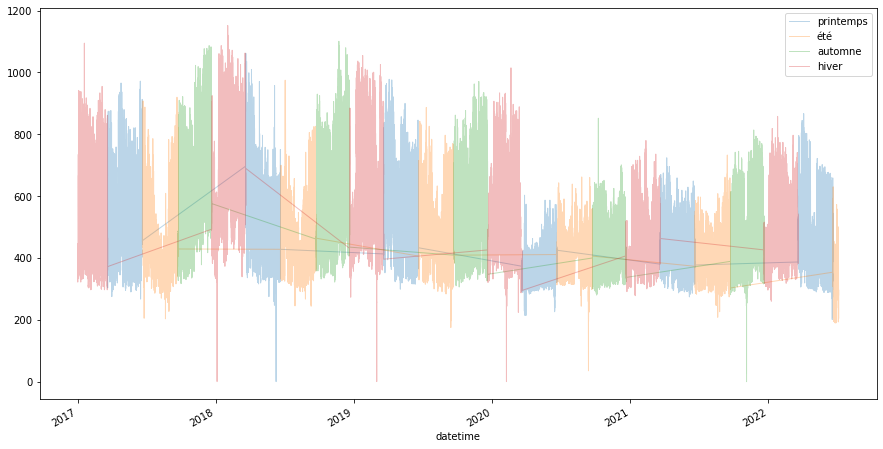

In [143]:
plt.figure(figsize=(15,8))
df_spring.loc['2017':'2022','kW'].plot(label='printemps', lw=1, ls='-', alpha=0.3)
df_summer.loc['2017':'2022','kW'].plot(label='été', lw=1, ls='-', alpha=0.3)
df_autumn.loc['2017':'2022','kW'].plot(label='automne', lw=1, ls='-', alpha=0.3)
df_winter.loc['2017':'2022','kW'].plot(label='hiver', lw=1, ls='-', alpha=0.3)
plt.legend()
plt.show()

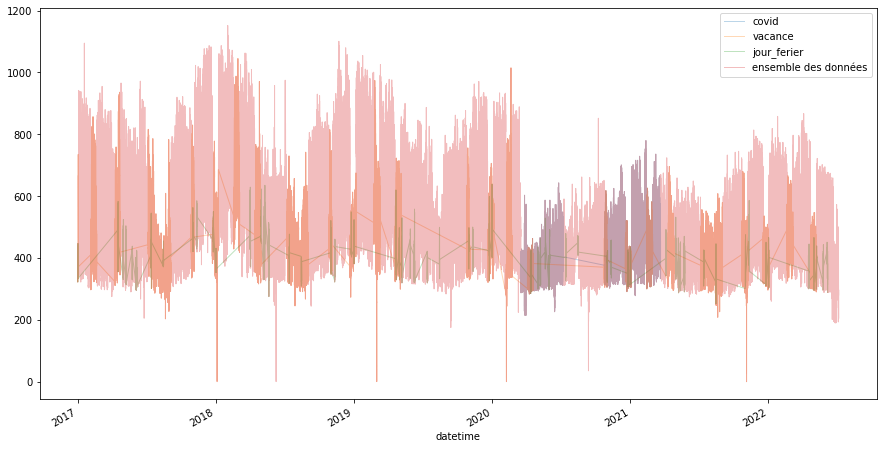

In [144]:
plt.figure(figsize=(15,8))
df_covid.loc['2017':'2022','kW'].plot(label='covid', lw=1, ls='-', alpha=0.3)
df_vacance.loc['2017':'2022','kW'].plot(label='vacance', lw=1, ls='-', alpha=0.3)
df_jour_ferier.loc['2017':'2022','kW'].plot(label='jour_ferier', lw=1, ls='-', alpha=0.3)
df.loc['2017':'2022','kW'].plot(label='ensemble des données', lw=1, ls='-', alpha=0.3)
plt.legend()
plt.show()

Pour rappel, la valeur moyenne de notre serie temporelle sur l'ensemble des données est de 491.719458. Lorsque l'on prend la valeur moyenne sur l'ensemble des hivers, la consommation est plus haute que la moyenne. A contrario, elle est concidérablement moins élevé sur la période d'été. La saison explique bien la consommation éléctrique. La même conclusion peut être faite pour les périodes non scolaire (vacances et jours férié).

## Prédiction 

Nous pouvons maintenant passer à la 2ème étape, qui est la prédiction de nos données.

In [145]:
df = df.loc['2017-01-01 00:00:00':'2022-07-05 23:50:00'].resample('W', offset='1s').mean()
df[['spring', 'summer', 'autumn', 'winter', 'covid', 'vacance','jour_ferier']] = df[['spring', 'summer', 'autumn', 'winter', 'covid', 'vacance','jour_ferier']].astype(int)
df.describe()

kW      spring      summer      autumn      winter       covid  \
count  289.000000  289.000000  289.000000  289.000000  289.000000  289.000000   
mean   492.735854    0.256055    0.224913    0.207612    0.249135    0.124567   
std     80.757103    0.437210    0.418250    0.406301    0.433262    0.330801   
min    330.864087    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    432.714286    0.000000    0.000000    0.000000    0.000000    0.000000   
50%    483.535714    0.000000    0.000000    0.000000    0.000000    0.000000   
75%    538.621032    1.000000    0.000000    0.000000    0.000000    0.000000   
max    750.915675    1.000000    1.000000    1.000000    1.000000    1.000000   

          vacance  jour_ferier  
count  289.000000   289.000000  
mean     0.221453     0.003460  
std      0.415945     0.058824  
min      0.000000     0.000000  
25%      0.000000     0.000000  
50%      0.000000     0.000000  
75%      0.000000     0.000000  
max      1.000000     1.000000

In [146]:
df2 = df

In [147]:
df = df.drop(['spring', 'summer', 'autumn', 'winter', 'covid', 'vacance','jour_ferier'], axis=1)

Nous vérifions que notre série ne sois pas stationnaire.

In [148]:
values = df.kW
 
parts = int(len(values)/3)

part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
print('mean 1 = %f, mean 2 = %f, mean 3 = %f' % (mean_1, mean_2, mean_3))
print('variance 1 = %f, variance 2 = %f, variance 3 = %f' % (var_1, var_2, var_3))

mean 1 = 530.093803, mean 2 = 501.334448, mean 3 = 448.367235
variance 1 = 7419.840801, variance 2 = 6398.556407, variance 3 = 2233.751123


Les valeurs moyennes étant assez proche, on s'est rendu compte en fonction de la période de temps que l'on choisissait que notre séries pourrait être stationnaire. Nous avons alors procédé a un test de Dickey-Fuller.

In [33]:
result = adfuller(df)
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.6802165059993115
p-value : 0.07752468726805457
Valeurs Critiques :
	1%: -3.4540076534999957
	5%: -2.8719557347997178
	10%: -2.5723200648758366


Notre P-value étant supérieur à 0,05, notre série n'est pas stationaire.

In [34]:
# Nous séparons maintenant notre jeu de donnée

n = len(df)

# Jeu de donnée sans les features
train_df = df[0:int(n*0.7)]
test_df = df[int(n*0.7):]

# Jeu de donnée sans les features
train_2 = df2[0:int(n*0.7)]
test_2 = df2[int(n*0.7):]

num_features = df.shape[1]

print(train_df.shape)
print(test_df.shape)

print(test_df.head())
print(test_2.head())

(202, 1)
(87, 1)
                    kW
datetime              
2020-11-15  430.469246
2020-11-22  423.542659
2020-11-29  418.764881
2020-12-06  449.900794
2020-12-13  474.263889
                    kW  spring  summer  autumn  winter  covid  vacance  \
datetime                                                                 
2020-11-15  430.469246       0       0       1       0      1        0   
2020-11-22  423.542659       0       0       1       0      1        0   
2020-11-29  418.764881       0       0       1       0      1        0   
2020-12-06  449.900794       0       0       1       0      1        0   
2020-12-13  474.263889       0       0       1       0      1        0   

            jour_ferier  
datetime                 
2020-11-15            0  
2020-11-22            0  
2020-11-29            0  
2020-12-06            0  
2020-12-13            0  


### Méthode naïve

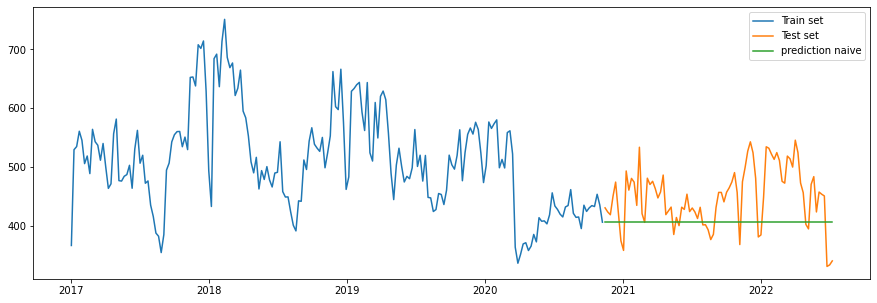

In [35]:
df_naive = test_df.copy()
df_naive['prediction_naive'] = train_df['kW'][len(train_df)-1]

plt.figure(figsize=(15,5))
plt.plot(train_df['kW'], label='Train set')
plt.plot(test_df['kW'], label='Test set')
plt.plot(df_naive['prediction_naive'], label='prediction naive')
plt.legend()
plt.show()

In [36]:
mse = np.sqrt(mean_squared_error(test_df['kW'], df_naive['prediction_naive']))
print( 'erreur quadratique moyenne :', mse)

erreur quadratique moyenne : 66.2536306185821


La méthode naïve consiste à prendre simplement la valeur moyenne sur l'ensemble des données et de s'en servir comme prédiction. 

### Régression linéaire

On a ensuite fait une régression linéaire sur nos données en prenant en compte nos features ajoutés.

In [37]:
train_2.drop('kW', axis = 1).head()

spring  summer  autumn  winter  covid  vacance  jour_ferier
datetime                                                               
2017-01-01       0       0       0       1      0        1            1
2017-01-08       0       0       0       1      0        0            0
2017-01-15       0       0       0       1      0        0            0
2017-01-22       0       0       0       1      0        0            0
2017-01-29       0       0       0       1      0        0            0

In [38]:
test_2.drop('kW', axis = 1).head()

spring  summer  autumn  winter  covid  vacance  jour_ferier
datetime                                                               
2020-11-15       0       0       1       0      1        0            0
2020-11-22       0       0       1       0      1        0            0
2020-11-29       0       0       1       0      1        0            0
2020-12-06       0       0       1       0      1        0            0
2020-12-13       0       0       1       0      1        0            0

In [39]:
lr = LinearRegression().fit(train_2.drop('kW', axis = 1), train_2[['kW']])

In [40]:
lr_prediction = lr.predict(test_2.drop('kW', axis = 1))


In [41]:
predictions = lr_prediction

test_2['Predictions'] = predictions
test_2.head()

kW  spring  summer  autumn  winter  covid  vacance  \
datetime                                                                 
2020-11-15  430.469246       0       0       1       0      1        0   
2020-11-22  423.542659       0       0       1       0      1        0   
2020-11-29  418.764881       0       0       1       0      1        0   
2020-12-06  449.900794       0       0       1       0      1        0   
2020-12-13  474.263889       0       0       1       0      1        0   

            jour_ferier  Predictions  
datetime                              
2020-11-15            0   447.840403  
2020-11-22            0   447.840403  
2020-11-29            0   447.840403  
2020-12-06            0   447.840403  
2020-12-13            0   447.840403

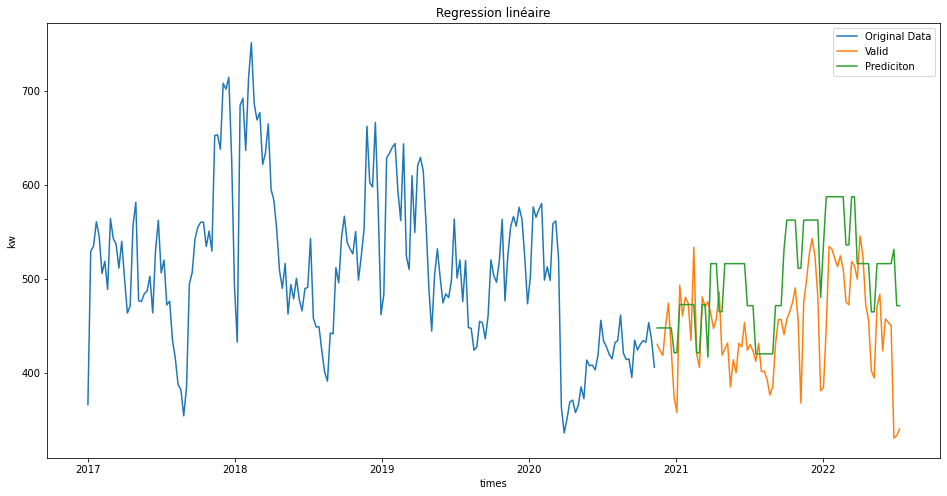

In [42]:
plt.figure(figsize=(16,8))
plt.title('Regression linéaire')
plt.xlabel('times')
plt.ylabel('kw')
plt.plot(train_2['kW'])
plt.plot(test_2['kW'])
plt.plot(test_2['Predictions'])
plt.legend(['Original Data', 'Valid','Prediciton'])
plt.show()

In [43]:
test_2.drop('Predictions', axis = 1).head()

kW  spring  summer  autumn  winter  covid  vacance  \
datetime                                                                 
2020-11-15  430.469246       0       0       1       0      1        0   
2020-11-22  423.542659       0       0       1       0      1        0   
2020-11-29  418.764881       0       0       1       0      1        0   
2020-12-06  449.900794       0       0       1       0      1        0   
2020-12-13  474.263889       0       0       1       0      1        0   

            jour_ferier  
datetime                 
2020-11-15            0  
2020-11-22            0  
2020-11-29            0  
2020-12-06            0  
2020-12-13            0

### Méthodes Statistique

<AxesSubplot:xlabel='datetime'>

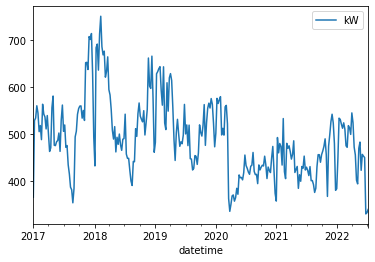

In [44]:
df.plot()

In [45]:
# data set sans nos features
out = seasonal_decompose(df)

res = STL(df).fit()

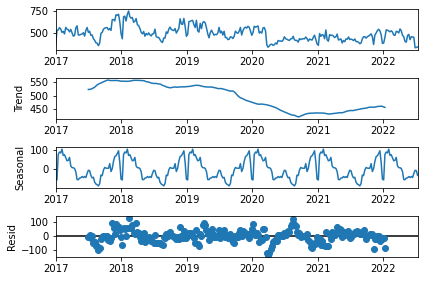

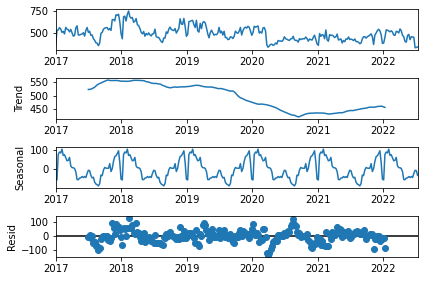

In [46]:
out.plot()

On remarque que notre série a un saisonalité annuel, et que notre série est à tendance stationaire mais diminue


<AxesSubplot:xlabel='datetime'>

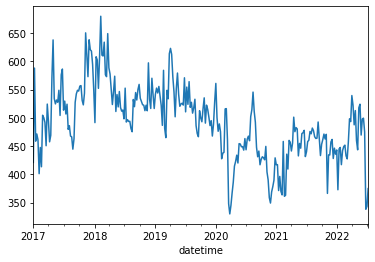

In [47]:
x =  out.observed - out.seasonal
x.plot()

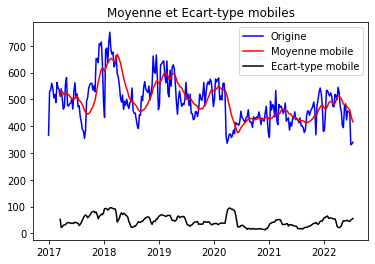

In [48]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

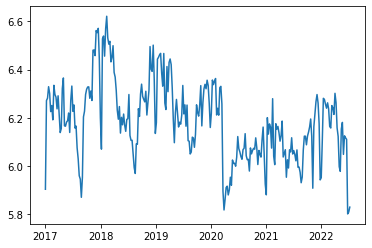

In [49]:
df_log = np.log(df)
plt.plot(df_log)

#### Auto ARIMA

In [50]:
# Model Auto ARIMA avec nos features ajouté
model_features = auto_arima(df2[['kW']], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3095.614, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3021.860, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3095.560, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3002.480, Time=0.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3001.866, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3020.932, Time=0.07 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3001.796, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3021.485, Time=0.08 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, T

In [51]:
# Model Auto ARIMA sans nos features ajouté
model = auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3095.614, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3021.860, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3095.560, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3002.480, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3001.866, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3020.932, Time=0.07 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3001.796, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3021.485, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, T

#### ARIMA

In [52]:
mod = ARIMA(x, order=(0,1,0))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1470.017
Date:                Mon, 07 Nov 2022   AIC                           2942.034
Time:                        18:03:07   BIC                           2945.697
Sample:                    01-01-2017   HQIC                          2943.502
                         - 07-10-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1588.5528     94.916     16.736      0.000    1402.521    1774.585
===================================================================================
Ljung-Box (L1) (Q):                  20.92   Jarque-Bera (JB):                44.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
res.aicc

2942.0482124307955

In [54]:
for p in [1,2,3,4]:
    for q in [0, 1, 2]:
        for d in [0, 1, 2]:
            mod = ARIMA(x, order=(p,d,q))
            res = mod.fit()
            print("p={}, d={}, q={} --> AICc = {}".format(p,d,q, res.aicc))

p=1, d=0, q=0 --> AICc = 2929.198370766256
p=1, d=1, q=0 --> AICc = 2921.2288951787255
p=1, d=2, q=0 --> AICc = 3094.872805769582
p=1, d=0, q=1 --> AICc = 2912.9012910931565
p=1, d=1, q=1 --> AICc = 2898.120160806075
p=1, d=2, q=1 --> AICc = 2920.3516883020616
p=1, d=0, q=2 --> AICc = 2909.109014159905
p=1, d=1, q=2 --> AICc = 2899.5410335145307
p=1, d=2, q=2 --> AICc = 2898.9337271839017
p=2, d=0, q=0 --> AICc = 2919.635329075699
p=2, d=1, q=0 --> AICc = 2908.289436160093
p=2, d=2, q=0 --> AICc = 3026.6852808875615
p=2, d=0, q=1 --> AICc = 2908.8970776868373
p=2, d=1, q=1 --> AICc = 2900.0852426372867
p=2, d=2, q=1 --> AICc = 2907.854206773493
p=2, d=0, q=2 --> AICc = 2910.9601040679736
p=2, d=1, q=2 --> AICc = 2896.70586129804
p=2, d=2, q=2 --> AICc = 2914.8906699284917
p=3, d=0, q=0 --> AICc = 2912.820998570658
p=3, d=1, q=0 --> AICc = 2909.024416585182
p=3, d=2, q=0 --> AICc = 3001.800438597233
p=3, d=0, q=1 --> AICc = 2910.9710887353126
p=3, d=1, q=1 --> AICc = 2899.559136248321
p

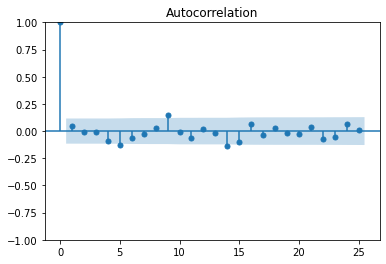

In [55]:
residus = res.resid[2:]
residus.plot(title="Résidus", figsize=(800,250) )
plot_acf(residus);

In [56]:
from statsmodels.stats.diagnostic import acorr_ljungbox


acorr_ljungbox(residus, lags=[10], return_df=True)

lb_stat  lb_pvalue
10  16.525453   0.085546

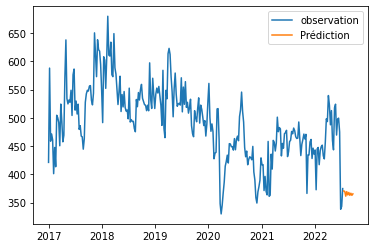

In [57]:
plt.plot(x,label='observation')
plt.plot(res.forecast(10),label='Prédiction')
plt.legend()

#### Prédiction avec Auto-ARIMA sur le jeu de donnée

In [58]:
# Model Auto ARIMA avec nos features ajouté
model_features = auto_arima(train_2[['kW']], start_p=1, start_q=1,
                           max_p = 5, max_q = 5, m = 12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

# Model Auto ARIMA sans nos features ajouté
model = auto_arima(train_df, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2138.111, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2084.520, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2139.343, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2076.951, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2075.270, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2082.611, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2046.508, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=2045.633, Time=0.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2046.5

In [59]:
print(model_features.summary())
model.summary()

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  202
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -1018.817
Date:                                 Mon, 07 Nov 2022   AIC                           2045.633
Time:                                         18:03:46   BIC                           2058.600
Sample:                                     01-01-2017   HQIC                          2050.887
                                          - 11-08-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9298      0.213     -4.374      0.000      -1.346      -0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1068.360
Date:                Mon, 07 Nov 2022   AIC                           2138.719
Time:                        18:03:46   BIC                           2142.023
Sample:                    01-01-2017   HQIC                          2140.056
                         - 11-08-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2422.5350    140.520     17.240      0.000    2147.122    2697.948
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):               143.06
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
prediction, confint = model.predict(n_periods = 87, return_conf_int=True)

prediction

2020-11-15    406.045635
2020-11-22    406.045635
2020-11-29    406.045635
2020-12-06    406.045635
2020-12-13    406.045635
                 ...    
2022-06-12    406.045635
2022-06-19    406.045635
2022-06-26    406.045635
2022-07-03    406.045635
2022-07-10    406.045635
Freq: W-SUN, Length: 87, dtype: float64

In [61]:
prediction_2, confint_2 = model_features.predict(n_periods = 87, return_conf_int=True)

prediction_2

2020-11-15    420.639985
2020-11-22    402.650012
2020-11-29    389.929716
2020-12-06    388.353603
2020-12-13    410.078112
                 ...    
2022-06-12    329.788893
2022-06-19    351.545800
2022-06-26    358.019752
2022-07-03    345.089549
2022-07-10    322.634977
Freq: W-SUN, Length: 87, dtype: float64

In [62]:
cf = pd.DataFrame(confint)
cf_2 = pd.DataFrame(confint_2)

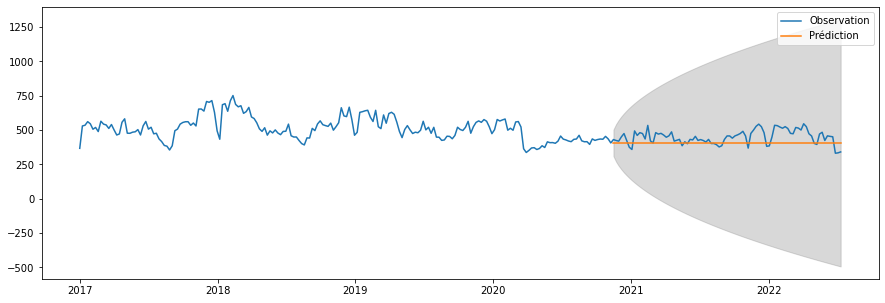

In [63]:
prediction_series = pd.Series(prediction,index=test_df.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.kW,label = 'Observation')
ax.plot(prediction_series,label = 'Prédiction')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
plt.legend()

On remarque en utilisant une seule feature 'kW' la prédiction est une moyenne simple donc pas fiable 

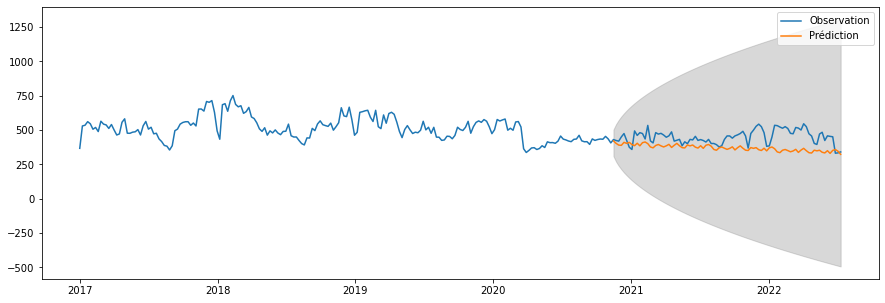

In [64]:
prediction_series_2 = pd.Series(prediction_2,index = test_df.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df2.kW,label = 'Observation')
ax.plot(prediction_series_2,label = 'Prédiction')
ax.fill_between(prediction_series_2.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
plt.legend()

Avec plusieurs features on a une meilleure prédiction de notre modèle.

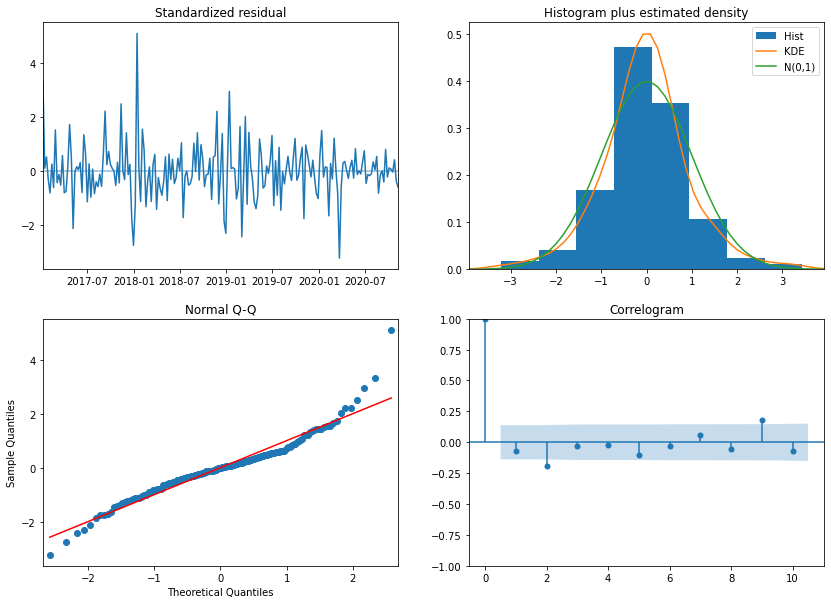

In [65]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

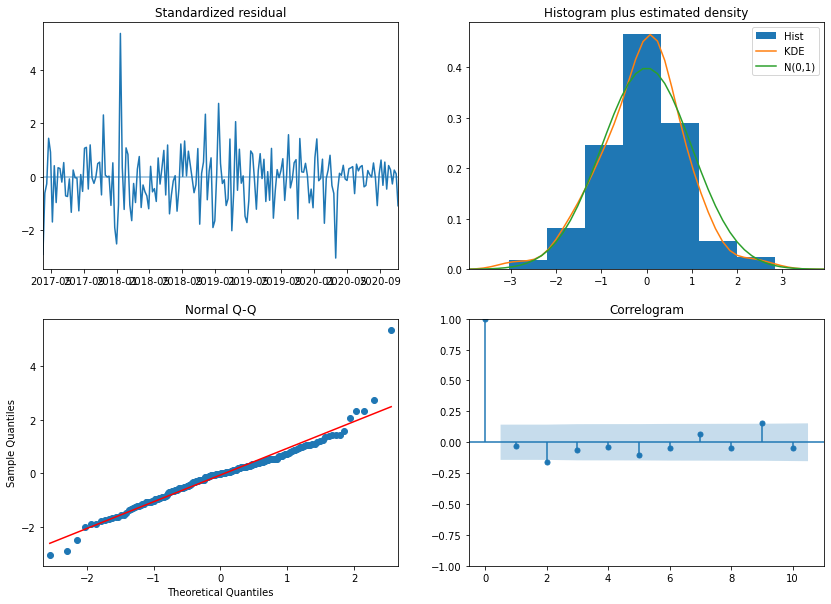

In [66]:
model_features.plot_diagnostics(figsize=(14,10))
plt.show()

#### HOLT

In [67]:
from statsmodels.tsa.api import Holt

# model sans feature
holt = Holt(test_df[["kW"]],initialization_method="estimated").fit()
fcast_holt = holt.forecast(40)

In [68]:
test_df.head()

kW
datetime              
2020-11-15  430.469246
2020-11-22  423.542659
2020-11-29  418.764881
2020-12-06  449.900794
2020-12-13  474.263889

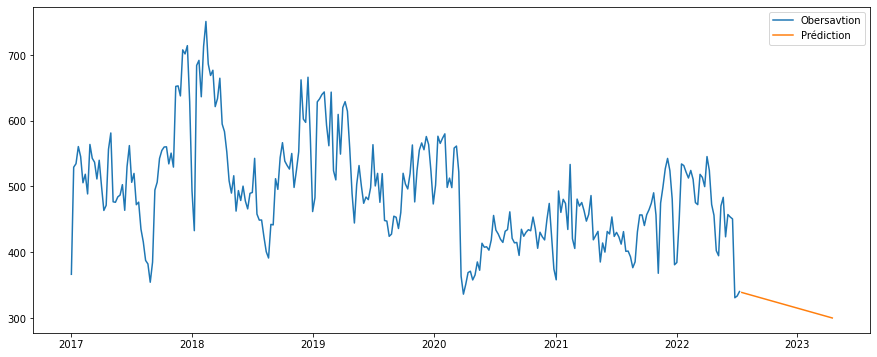

In [69]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(df.index,df["kW"],label="Obersavtion")
plt.plot(fcast_holt.index,fcast_holt,label='Prédiction')
plt.legend()

In [70]:
test_2 = test_2.drop('Predictions', axis=1).head()

In [71]:
test_2.head()

kW  spring  summer  autumn  winter  covid  vacance  \
datetime                                                                 
2020-11-15  430.469246       0       0       1       0      1        0   
2020-11-22  423.542659       0       0       1       0      1        0   
2020-11-29  418.764881       0       0       1       0      1        0   
2020-12-06  449.900794       0       0       1       0      1        0   
2020-12-13  474.263889       0       0       1       0      1        0   

            jour_ferier  
datetime                 
2020-11-15            0  
2020-11-22            0  
2020-11-29            0  
2020-12-06            0  
2020-12-13            0

In [72]:
# model avec feature
holt = Holt(test_2[['kW']], initialization_method="estimated").fit()
fcast_holt = holt.forecast(29)

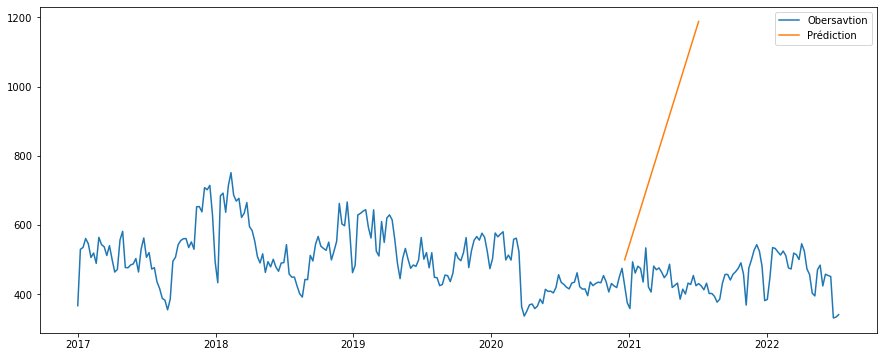

In [73]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(df.index,df["kW"],label="Obersavtion")
plt.plot(fcast_holt.index,fcast_holt,label='Prédiction')
plt.legend()

Nous n'obtenons pas des résultats satisfaisant avec cette méthode.

### Méthode par réseaux de neurone

Pour les méthodes statistiques, nous sommes parti sur un RNN et sur un CNN.

### RNN

#### Sans les features

In [74]:
# Scale des données
scaler = MinMaxScaler()
scaler.fit(train_df)
scaled_train_df = scaler.transform(train_df)
scaled_test_df = scaler.transform(test_df)

In [80]:
n_input = 100
n_features = 1
generator = TimeseriesGenerator(scaled_train_df , scaled_train_df , length = n_input, batch_size = 30)

In [81]:
model = Sequential()
model.add(LSTM(70, activation = 'relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'RMSprop', loss = 'mse')

In [82]:
model.fit(generator, epochs = 50)

Epoch 1/50
4/4 [==============================] - 1s 20ms/step - loss: 0.1637
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1141
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0633
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 8186939421229056.0000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0318
Epoch 6/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0317
Epoch 7/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0316
Epoch 8/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0315
Epoch 9/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0314
Epoch 10/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0312
Epoch 11/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0311
Epoch 12/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0310
Epoch 13/50
4/4 [=============================

In [83]:
test_predictions = []

first_eval_batch = scaled_train_df[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [84]:
true_predictions = scaler.inverse_transform(test_predictions)
test_df['Predictions'] = true_predictions

<AxesSubplot:xlabel='datetime'>

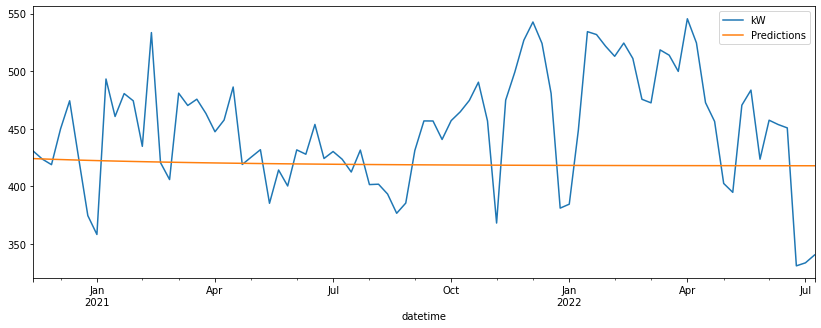

In [85]:
test_df.plot(figsize=(14,5))

#### Avec les features

In [90]:
train_2.columns

Index(['kW', 'spring', 'summer', 'autumn', 'winter', 'covid', 'vacance',
       'jour_ferier'],
      dtype='object')

In [149]:
# Scale des données
scaler = MinMaxScaler()
scaler.fit(train_2)
scaled_train_df = scaler.transform(train_2[['kW']])
scaled_test_df = scaler.transform(test_2)

ValueError: X has 1 features, but MinMaxScaler is expecting 8 features as input.

In [107]:
y_scaler

MinMaxScaler()

In [110]:
n_input = 100
n_features = 8
generator = TimeseriesGenerator(scaled_train_df, scaled_train_df, length = n_input, batch_size = 30)

In [111]:
model = Sequential()
model.add(LSTM(70, activation = 'relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'RMSprop', loss = 'mse')

In [112]:
model.fit(generator, epochs = 50)

Epoch 1/50
4/4 [==============================] - 1s 21ms/step - loss: 0.1433
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1371
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1358
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1353
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1351
Epoch 6/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1351
Epoch 7/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1348
Epoch 8/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1349
Epoch 9/50
4/4 [==============================] - 0s 19ms/step - loss: 0.1358
Epoch 10/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1350
Epoch 11/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1347
Epoch 12/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1346
Epoch 13/50
4/4 [==============================] - 0s 19ms/st

In [113]:
test_predictions = []

first_eval_batch = scaled_train_df[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    


1/1 [==============================] - 0s 18ms/step


In [114]:
test_predictions

[array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 array([0.26208618], dtype=float32),
 

In [115]:
true_predictions = scaler.inverse_transform(test_predictions)
test_df['Predictions'] = true_predictions

ValueError: non-broadcastable output operand with shape (87,1) doesn't match the broadcast shape (87,8)

#### CNN

In [626]:
valid_start_dt = '2021-10'
test_start_dt = '2022-01'

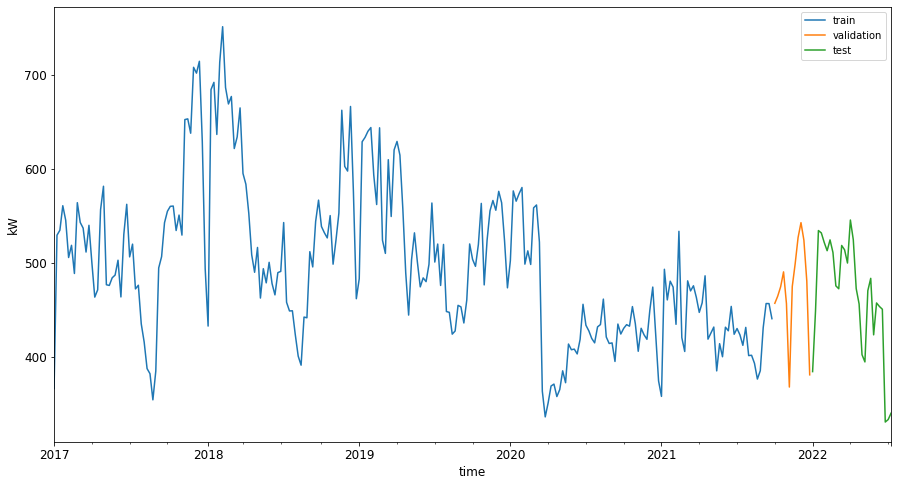

In [627]:
df[df.index < valid_start_dt][['kW']].rename(columns={'kW':'train'}) \
    .join(df[(df.index >=valid_start_dt) & (df.index < test_start_dt)][['kW']] \
          .rename(columns={'kW':'validation'}), how='outer') \
    .join(df[test_start_dt:][['kW']].rename(columns={'kW':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('time', fontsize=12)
plt.ylabel('kW', fontsize=12)
plt.show()

In [628]:
T = 10
HORIZON = 1

In [629]:
train = df.copy()[df.index < valid_start_dt][['kW']]

In [630]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['kW'] = scaler.fit_transform(train)
train.head(10)

kW
datetime            
2017-01-01  0.072765
2017-01-08  0.465544
2017-01-15  0.478415
2017-01-22  0.541199
2017-01-29  0.504086
2017-02-05  0.408481
2017-02-12  0.439684
2017-02-19  0.367529
2017-02-26  0.548993
2017-03-05  0.498305

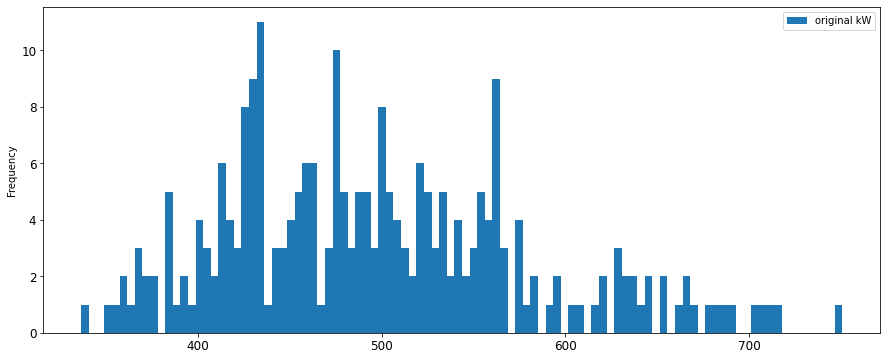

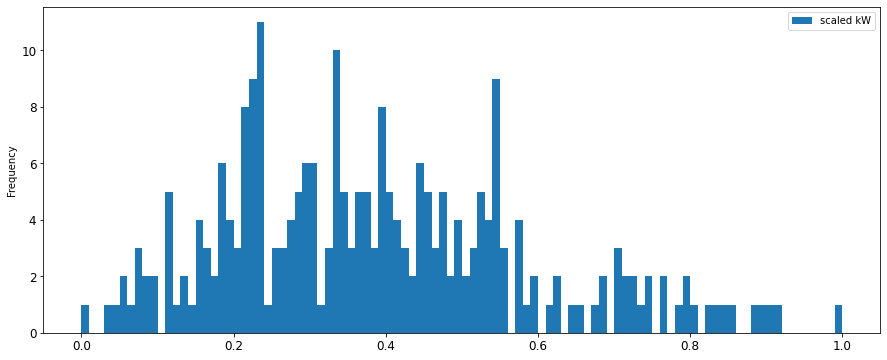

In [631]:
df[df.index < valid_start_dt][['kW']].rename(columns={'kW':'original kW'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'kW':'scaled kW'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [632]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['kW'].shift(-1, freq='W')
train_shifted.head(10)

kW     y_t+1
datetime                      
2017-01-01  0.072765  0.465544
2017-01-08  0.465544  0.478415
2017-01-15  0.478415  0.541199
2017-01-22  0.541199  0.504086
2017-01-29  0.504086  0.408481
2017-02-05  0.408481  0.439684
2017-02-12  0.439684  0.367529
2017-02-19  0.367529  0.548993
2017-02-26  0.548993  0.498305
2017-03-05  0.498305  0.483801

In [633]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['kW'].shift(T-t, freq='W')

train_shifted.head(10)

kW     y_t+1  load_t-9  load_t-8  load_t-7  load_t-6  \
datetime                                                                 
2017-01-01  0.072765  0.465544       NaN       NaN       NaN       NaN   
2017-01-08  0.465544  0.478415       NaN       NaN       NaN       NaN   
2017-01-15  0.478415  0.541199       NaN       NaN       NaN       NaN   
2017-01-22  0.541199  0.504086       NaN       NaN       NaN       NaN   
2017-01-29  0.504086  0.408481       NaN       NaN       NaN       NaN   
2017-02-05  0.408481  0.439684       NaN       NaN       NaN       NaN   
2017-02-12  0.439684  0.367529       NaN       NaN       NaN  0.072765   
2017-02-19  0.367529  0.548993       NaN       NaN  0.072765  0.465544   
2017-02-26  0.548993  0.498305       NaN  0.072765  0.465544  0.478415   
2017-03-05  0.498305  0.483801  0.072765  0.465544  0.478415  0.541199   

            load_t-5  load_t-4  load_t-3  load_t-2  load_t-1  load_t-0  
datetime                                                                
2017-01-01       NaN       NaN       NaN       NaN       NaN  0.072765  
2017-01-08       NaN       NaN       NaN       NaN  0.072765  0.465544  
2017-01-15       NaN       NaN       NaN  0.072765  0.465544  0.478415  
2017-01-22       NaN       NaN  0.072765  0.465544  0.478415  0.541199  
2017-01-29       NaN  0.072765  0.465544  0.478415  0.541199  0.504086  
2017-02-05  0.072765  0.465544  0.478415  0.541199  0.504086  0.408481  
2017-02-12  0.465544  0.478415  0.541199  0.504086  0.408481  0.439684  
2017-02-19  0.478415  0.541199  0.504086  0.408481  0.439684  0.367529  
2017-02-26  0.541199  0.504086  0.408481  0.439684  0.367529  0.548993  
2017-03-05  0.504086  0.408481  0.439684  0.367529  0.548993  0.498305

In [634]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

kW     y_t+1  load_t-9  load_t-8  load_t-7  load_t-6  \
datetime                                                                 
2017-03-05  0.498305  0.483801  0.072765  0.465544  0.478415  0.541199   
2017-03-12  0.483801  0.422439  0.465544  0.478415  0.541199  0.504086   
2017-03-19  0.422439  0.491014  0.478415  0.541199  0.504086  0.408481   
2017-03-26  0.491014  0.395717  0.541199  0.504086  0.408481  0.439684   
2017-04-02  0.395717  0.306989  0.504086  0.408481  0.439684  0.367529   

            load_t-5  load_t-4  load_t-3  load_t-2  load_t-1  load_t-0  
datetime                                                                
2017-03-05  0.504086  0.408481  0.439684  0.367529  0.548993  0.498305  
2017-03-12  0.408481  0.439684  0.367529  0.548993  0.498305  0.483801  
2017-03-19  0.439684  0.367529  0.548993  0.498305  0.483801  0.422439  
2017-03-26  0.367529  0.548993  0.498305  0.483801  0.422439  0.491014  
2017-04-02  0.548993  0.498305  0.483801  0.422439  0.491014  0.395717

In [635]:
y_train = train_shifted[['y_t+1']].to_numpy()

In [636]:
y_train.shape
y_train[:3]

array([[0.48380148],
       [0.42243855],
       [0.4910145 ]])

In [637]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

In [638]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['kW']]
valid.head()

kW
datetime              
2021-10-03  457.025794
2021-10-10  464.673611
2021-10-17  474.576389
2021-10-24  490.407738
2021-10-31  456.708333

In [639]:
valid['kW'] = scaler.transform(valid)
valid.head()

kW
datetime            
2021-10-03  0.291132
2021-10-10  0.309579
2021-10-17  0.333464
2021-10-24  0.371650
2021-10-31  0.290366

In [640]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['kW'].shift(-1, freq='W')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['kW'].shift(T-t, freq='W')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [641]:
LATENT_DIM = 5 
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [642]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [643]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 10, 5)             15        
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 5)             55        
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 5)             55        
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [644]:
model.compile(optimizer='Adam', loss='mse')

In [645]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [646]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [647]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
8/8 [==============================] - 3s 122ms/step - loss: 0.4279 - val_loss: 0.2267
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 0.3164 - val_loss: 0.1678
Epoch 3/10
8/8 [==============================] - 0s 19ms/step - loss: 0.2414 - val_loss: 0.1290
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.1873 - val_loss: 0.0999
Epoch 5/10
8/8 [==============================] - 0s 34ms/step - loss: 0.1461 - val_loss: 0.0751
Epoch 6/10
8/8 [==============================] - 0s 33ms/step - loss: 0.1134 - val_loss: 0.0557
Epoch 7/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0863 - val_loss: 0.0411
Epoch 8/10
8/8 [==============================] - 0s 24ms/step - loss: 0.0651 - val_loss: 0.0305
Epoch 9/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0493 - val_loss: 0.0251
Epoch 10/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0391 - val_loss: 0.0241


In [648]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

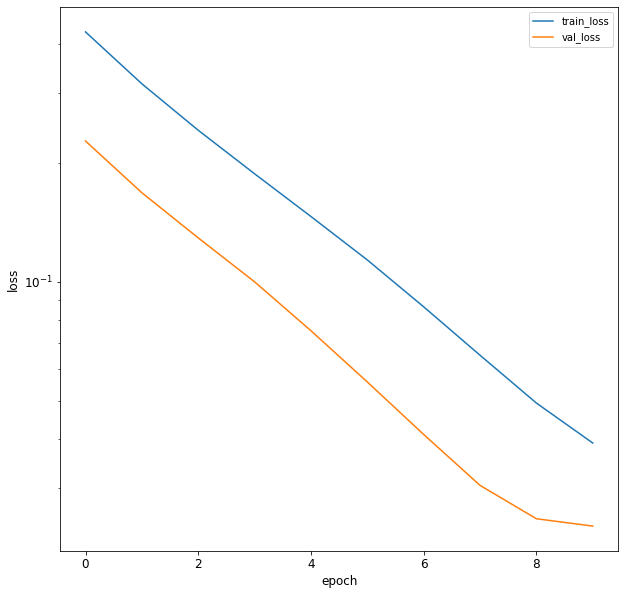

In [649]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [650]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['kW']]
test.head()

kW
datetime              
2022-01-02  384.434955
2022-01-09  448.680556
2022-01-16  534.309524
2022-01-23  531.790675
2022-01-30  521.633929

In [651]:
test['kW'] = scaler.transform(test)
test.head()

kW
datetime            
2022-01-02  0.116041
2022-01-09  0.271003
2022-01-16  0.477542
2022-01-23  0.471466
2022-01-30  0.446968

In [652]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['kW'].shift(-1, freq='W')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['kW'].shift(T-t, freq='W')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

In [653]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 0s 347ms/step


array([[0.37029937],
       [0.37351292],
       [0.35901603],
       [0.34521505],
       [0.33089194],
       [0.3358302 ],
       [0.35043895],
       [0.36408997],
       [0.378941  ],
       [0.38437438],
       [0.37119582],
       [0.33585542],
       [0.3089966 ],
       [0.28300482],
       [0.30010733],
       [0.33330175],
       [0.3391771 ],
       [0.3332062 ]], dtype=float32)

In [654]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction      actual
0 2022-03-06  t+1  489.847885  518.468254
1 2022-03-13  t+1  491.180194  513.861111
2 2022-03-20  t+1  485.169922  499.795409
3 2022-03-27  t+1  479.448170  545.518849
4 2022-04-03  t+1  473.509945  524.547619

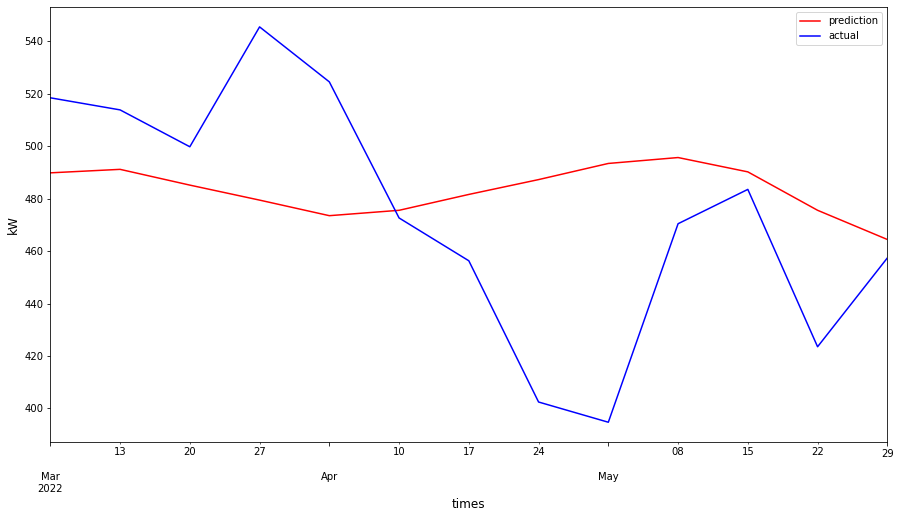

In [656]:
eval_df[eval_df.timestamp<'2022-06-03'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('times', fontsize=12)
plt.ylabel('kW', fontsize=12)
plt.show()